In [1]:
from contextlib import contextmanager
import gc
import os
from pathlib import Path
import pickle
import time

import catboost
import faiss
import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from lfm import calc_embeddings, calc_scores
from metric import apk, mapk
from utils import plot_images


In [2]:
@contextmanager
def timer(name):
    start_time = time.time()
    yield
    print(f'[{name}] {time.time() - start_time:.3f} s')

In [3]:
dataset = '100'

transactions = pd.read_pickle(f"input/{dataset}/transactions_train.pkl")
users = pd.read_pickle(f"input/{dataset}/users.pkl")
items = pd.read_pickle(f"input/{dataset}/items.pkl")


In [4]:
class CFG:
    model_type = 'CatBoost'
    # candidates
    popular_num_items = 36
    popular_weeks = 1
    train_weeks = 3
    item2item_num_items = 24
    item2item_num_items_for_same_product_code = 12
    cooc_weeks = 12
    cooc_threshold = 50
    ohe_distance_num_items = 32
    ohe_distance_num_weeks = 1
    # features
    user_transaction_feature_weeks = 8
    item_transaction_feature_weeks = 8
    item_age_feature_weeks = 8
    user_volume_feature_weeks = 1
    item_volume_feature_weeks = 1
    user_item_volume_feature_weeks = 1
    age_volume_feature_weeks = 1


# TUNED
# class CFG:
#     model_type = 'CatBoost'
#     # candidates
#     popular_num_items = 60
#     popular_weeks = 1
#     train_weeks = 3
#     item2item_num_items = 24
#     item2item_num_items_for_same_product_code = 12
#     cooc_weeks = 32
#     cooc_threshold = 150
#     ohe_distance_num_items = 48
#     ohe_distance_num_weeks = 20
#     # features
#     user_transaction_feature_weeks = 50
#     item_transaction_feature_weeks = 16
#     item_age_feature_weeks = 40
#     user_volume_feature_weeks = 50
#     item_volume_feature_weeks = 20
#     user_item_volume_feature_weeks = 16
#     age_volume_feature_weeks = 1

In [5]:
# age==25でのアイテムボリューム以上になるような幅を各年齢に対して求める
tr = transactions[['user', 'item']].merge(users[['user', 'age']], on='user')
age_volume_threshold = len(tr.query("24 <= age <= 26"))

age_volumes = {age: len(tr.query("age == @age")) for age in range(16, 100)}

age_shifts = {}
for age in range(16, 100):
    for i in range(0, 100):
        low = age - i
        high = age + i
        age_volume = 0
        for j in range(low, high+1):
            age_volume += age_volumes.get(j, 0)
        if age_volume >= age_volume_threshold:
            age_shifts[age] = i
            break
print(age_shifts)

{16: 7, 17: 6, 18: 5, 19: 4, 20: 3, 21: 2, 22: 2, 23: 2, 24: 2, 25: 1, 26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 3, 33: 3, 34: 4, 35: 4, 36: 5, 37: 5, 38: 5, 39: 5, 40: 6, 41: 6, 42: 5, 43: 5, 44: 5, 45: 5, 46: 4, 47: 4, 48: 4, 49: 4, 50: 4, 51: 4, 52: 4, 53: 4, 54: 4, 55: 5, 56: 5, 57: 6, 58: 7, 59: 7, 60: 8, 61: 9, 62: 10, 63: 11, 64: 12, 65: 13, 66: 14, 67: 15, 68: 16, 69: 17, 70: 18, 71: 19, 72: 20, 73: 21, 74: 22, 75: 23, 76: 24, 77: 25, 78: 26, 79: 27, 80: 28, 81: 29, 82: 30, 83: 31, 84: 32, 85: 33, 86: 34, 87: 35, 88: 36, 89: 37, 90: 38, 91: 39, 92: 40, 93: 41, 94: 42, 95: 43, 96: 44, 97: 45, 98: 46, 99: 47}


In [6]:
def create_candidates(transactions: pd.DataFrame, target_users: np.ndarray, week: int) -> pd.DataFrame:
    """
    transactions
        original transactions (user, item, week)
    target_users, week
        候補生成対象のユーザー
        weekで指定されている週の段階での情報のみから作られる
    """
    print(f"create candidates (week: {week})")
    assert len(target_users) == len(set(target_users))

    def create_candidates_repurchase(
            strategy: str,
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            max_items_per_user: int=1234567890
        ) -> pd.DataFrame:
        tr = transactions.query("user in @target_users and @week_start <= week")[['user', 'item', 'week', 'day']].drop_duplicates(ignore_index=True)

        gr_day = tr.groupby(['user', 'item'])['day'].min().reset_index(name='day')
        gr_week = tr.groupby(['user', 'item'])['week'].min().reset_index(name='week')
        gr_volume = tr.groupby(['user', 'item']).size().reset_index(name='volume')

        gr_day['day_rank'] = gr_day.groupby('user')['day'].rank()
        gr_week['week_rank'] = gr_week.groupby('user')['week'].rank()
        gr_volume['volume_rank'] = gr_volume.groupby('user')['volume'].rank(ascending=False)

        candidates = gr_day.merge(gr_week, on=['user', 'item']).merge(gr_volume, on=['user', 'item'])

        candidates['rank_meta'] = 10**9 * candidates['day_rank'] + candidates['volume_rank']
        candidates['rank_meta'] = candidates.groupby('user')['rank_meta'].rank(method='min')
        # item2itemに使う場合は全件使うと無駄に重くなってしまうので削る
        # dayの小ささ, volumeの大きさの辞書順にソートして上位アイテムのみ残す
        # 全部残したい場合はmax_items_per_userに十分大きな数を指定する
        candidates = candidates.query("rank_meta <= @max_items_per_user").reset_index(drop=True)

        candidates = candidates[['user', 'item', 'week_rank', 'volume_rank', 'rank_meta']].rename(columns={'week_rank': f'{strategy}_week_rank', 'volume_rank': f'{strategy}_volume_rank'})

        candidates['strategy'] = strategy
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_popular(
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            num_weeks: int,
            num_items: int,
        ) -> pd.DataFrame:
        tr = transactions.query("@week_start <= week < @week_start + @num_weeks")[['user', 'item']].drop_duplicates(ignore_index=True)
        popular_items = tr['item'].value_counts().index.values[:num_items]
        popular_items = pd.DataFrame({
            'item': popular_items,
            'rank': range(num_items),
            'crossjoinkey': 1,
        })

        candidates = pd.DataFrame({
            'user': target_users,
            'crossjoinkey': 1,
        })

        candidates = candidates.merge(popular_items, on='crossjoinkey').drop('crossjoinkey', axis=1)
        candidates = candidates.rename(columns={'rank': f'pop_rank'})

        candidates['strategy'] = 'pop'
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_age_popular(
            transactions: pd.DataFrame,
            users: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            num_weeks: int,
            num_items: int,
        ) -> pd.DataFrame:
        tr = transactions.query("@week_start <= week < @week_start + @num_weeks")[['user', 'item']].drop_duplicates(ignore_index=True)
        tr = tr.merge(users[['user', 'age']])

        pops = []
        for age in range(16, 100):
            low = age - age_shifts[age]
            high = age + age_shifts[age]
            pop = tr.query("@low <= age <= @high")['item'].value_counts().index.values[:num_items]
            pops.append(pd.DataFrame({
                'age': age,
                'item': pop,
                'age_popular_rank': range(num_items),
            }))
        pops = pd.concat(pops)

        candidates = users[['user', 'age']].dropna().query("user in @target_users").reset_index(drop=True)

        candidates = candidates.merge(pops, on='age').drop('age', axis=1)

        candidates['strategy'] = 'age_pop'
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_cooc(
            transactions: pd.DataFrame,
            base_candidates: pd.DataFrame,
            week_start: int,
            num_weeks: int,
            pair_count_threshold: int,
        ) -> pd.DataFrame:
        week_end = week_start + num_weeks
        tr = transactions.query("@week_start <= week < @week_end")[['user', 'item', 'week']].drop_duplicates(ignore_index=True)
        tr = tr.merge(tr.rename(columns={'item': 'item_with', 'week': 'week_with'}), on='user').query("item != item_with and week <= week_with")[['item', 'item_with']].reset_index(drop=True)
        gr_item_count = tr.groupby('item').size().reset_index(name='item_count')
        gr_pair_count = tr.groupby(['item', 'item_with']).size().reset_index(name='pair_count')
        item2item = gr_pair_count.merge(gr_item_count, on='item')
        item2item['ratio'] = item2item['pair_count'] / item2item['item_count']
        item2item = item2item.query("pair_count > @pair_count_threshold").reset_index(drop=True)

        candidates = base_candidates.merge(item2item, on='item').drop(['item', 'pair_count'], axis=1).rename(columns={'item_with': 'item'})
        base_candidates_columns = [c for c in base_candidates.columns if '_' in c]
        base_candidates_replace = {c: f"cooc_{c}" for c in base_candidates_columns}
        candidates = candidates.rename(columns=base_candidates_replace)
        candidates = candidates.rename(columns={'ratio': 'cooc_ratio', 'item_count': f'cooc_item_count'})

        candidates['strategy'] = 'cooc'
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_same_product_code(
            items: pd.DataFrame,
            base_candidates: pd.DataFrame
        ) -> pd.DataFrame:
        item2item = items[['item', 'product_code']].merge(items[['item', 'product_code']].rename({'item': 'item_with'}, axis=1), on='product_code')[['item', 'item_with']].query("item != item_with").reset_index(drop=True)

        candidates = base_candidates.merge(item2item, on='item').drop('item', axis=1).rename(columns={'item_with': 'item'})

        candidates['min_rank_meta'] = candidates.groupby(['user', 'item'])['rank_meta'].transform('min')
        candidates = candidates.query("rank_meta == min_rank_meta").reset_index(drop=True)
        
        base_candidates_columns = [c for c in base_candidates.columns if '_' in c]
        base_candidates_replace = {c: f"same_product_code_{c}" for c in base_candidates_columns}
        candidates = candidates.rename(columns=base_candidates_replace)

        candidates['strategy'] = 'same_product_code'
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_ohe_distance(
        transactions: pd.DataFrame,
        users: pd.DataFrame,
        items: pd.DataFrame,
        target_users: np.ndarray,
        week_start: int,
        num_weeks: int,
        num_items: int,
    ) -> pd.DataFrame:
        users_with_ohe = users[['user']].query("user in @target_users")
        cols = [c for c in items.columns if c.endswith('_idx')]
        for c in cols:
            tmp = pd.read_pickle(f"artifacts/user_features/user_ohe_agg_dataset{dataset}_week{week}_{c}.pkl")
            cs = [c for c in tmp.columns if c.endswith('_mean')]
            users_with_ohe = users_with_ohe.merge(tmp[['user'] + cs], on='user')

        users_with_ohe = users_with_ohe.dropna().reset_index(drop=True)
        limited_users = users_with_ohe['user'].values

        recent_items = transactions.query("@week <= week < @week + @num_weeks")['item'].unique()
        items_with_ohe = pd.get_dummies(items[['item'] + cols], columns=cols)
        items_with_ohe = items_with_ohe.query("item in @recent_items").reset_index(drop=True)
        limited_items = items_with_ohe['item'].values

        item_cols = [c for c in items_with_ohe.columns if c != 'item']
        user_cols = [f'user_ohe_agg_{c}_mean' for c in item_cols]
        users_with_ohe = users_with_ohe[['user'] + user_cols]
        items_with_ohe = items_with_ohe[['item'] + item_cols]

        a_users = users_with_ohe.drop('user', axis=1).values.astype(np.float32)
        a_items = items_with_ohe.drop('item', axis=1).values.astype(np.float32)
        a_users = np.ascontiguousarray(a_users)
        a_items = np.ascontiguousarray(a_items)
        index = faiss.index_factory(a_items.shape[1], "Flat", faiss.METRIC_INNER_PRODUCT)
        index = faiss.index_cpu_to_gpu(faiss.StandardGpuResources(), 0, index)
        index.add(a_items)
        distances, idxs = index.search(a_users, num_items)
        return pd.DataFrame({
            'user': np.repeat(limited_users, num_items),
            'item': limited_items[idxs.flatten()],
            'ohe_distance': distances.flatten(),
            'strategy': 'ohe_distance',
        })


    with timer("repurchase"):
        candidates_repurchase = create_candidates_repurchase('repurchase', transactions, target_users, week)
    with timer("popular"):
        candidates_popular = create_candidates_popular(transactions, target_users, week, CFG.popular_weeks, CFG.popular_num_items)
    with timer("age popular"):
        candidates_age_popular = create_candidates_age_popular(transactions, users, target_users, week, 1, 12)
    with timer("item2item"):
        candidates_item2item = create_candidates_repurchase('item2item', transactions, target_users, week, CFG.item2item_num_items)
    with timer("item2item2"):
        candidates_item2item2 = create_candidates_repurchase('item2item2', transactions, target_users, week, CFG.item2item_num_items_for_same_product_code) 
    with timer("cooccurrence"):
        candidates_cooc = create_candidates_cooc(transactions, candidates_item2item, week, CFG.cooc_weeks, CFG.cooc_threshold)
    with timer("same_product_code"):
        candidates_same_product_code = create_candidates_same_product_code(items, candidates_item2item2)
    with timer("ohe distance"):
        candidates_ohe_distance = create_candidates_ohe_distance(transactions, users, items, target_users, week, CFG.ohe_distance_num_weeks, CFG.ohe_distance_num_items)

    def drop_common_user_item(candidates_target: pd.DataFrame, candidates_reference: pd.DataFrame) -> pd.DataFrame:
        """
        candidates_targetのうちuser, itemの組がcandidates_referenceにあるものを落とす
        """
        tmp = candidates_reference[['user', 'item']].reset_index(drop=True)
        tmp['flag'] = 1
        candidates = candidates_target.merge(tmp, on=['user', 'item'], how='left')
        return candidates.query("flag != 1").reset_index(drop=True).drop('flag', axis=1)


    candidates_cooc = drop_common_user_item(candidates_cooc, candidates_repurchase)
    candidates_same_product_code = drop_common_user_item(candidates_same_product_code, candidates_repurchase)
    candidates_ohe_distance = drop_common_user_item(candidates_ohe_distance, candidates_repurchase)

    candidates = [
        candidates_repurchase,
        candidates_popular,
        candidates_age_popular,
        candidates_cooc,
        candidates_same_product_code,
        candidates_ohe_distance,
    ]
    candidates = pd.concat(candidates)

    print(f"volume: {len(candidates)}")
    print(f"duplicates: {len(candidates) / len(candidates[['user', 'item']].drop_duplicates())}")

    volumes = candidates.groupby('strategy').size().reset_index(name='volume').sort_values(by='volume', ascending=False).reset_index(drop=True)
    volumes['ratio'] = volumes['volume'] / volumes['volume'].sum()
    print(volumes)

    meta_columns = [c for c in candidates.columns if c.endswith('_meta')]
    return candidates.drop(meta_columns, axis=1)


In [7]:
# valid: week=0
# train: week=1..CFG.train_weeks
def func(week):
    target_users = transactions.query("week == @week")['user'].unique()
    return create_candidates(transactions, target_users, week+1)

candidates = joblib.Parallel(n_jobs=-1)(joblib.delayed(func)(week) for week in range(1+CFG.train_weeks))

In [8]:
def merge_labels(candidates: pd.DataFrame, week: int) -> pd.DataFrame:
    """
    candidatesに対してweekで指定される週のトランザクションからラベルを付与する
    """
    print(f"merge labels (week: {week})")
    labels = transactions[transactions['week'] == week][['user', 'item']].drop_duplicates(ignore_index=True)
    labels['y'] = 1
    original_positives = len(labels)
    labels = candidates.merge(labels, on=['user', 'item'], how='left')
    labels['y'] = labels['y'].fillna(0)

    remaining_positives_total = labels[['user', 'item', 'y']].drop_duplicates(ignore_index=True)['y'].sum()
    recall = remaining_positives_total / original_positives
    print(f"Recall: {recall}")

    volumes = candidates.groupby('strategy').size().reset_index(name='volume')
    remaining_positives = labels.groupby('strategy')['y'].sum().reset_index()
    remaining_positives = remaining_positives.merge(volumes, on='strategy')
    remaining_positives['recall'] = remaining_positives['y'] / original_positives
    remaining_positives['hit_ratio'] = remaining_positives['y'] / remaining_positives['volume']
    remaining_positives = remaining_positives.sort_values(by='y', ascending=False).reset_index(drop=True)
    print(remaining_positives)

    return labels


for idx in range(len(candidates)):
    candidates[idx] = merge_labels(candidates[idx], idx)

merge labels (week: 0)


Recall: 0.13581280880371313


            strategy        y   volume    recall  hit_ratio
0                pop  11811.0  2483424  0.055262   0.004756
1         repurchase   8437.0  3446562  0.039475   0.002448
2  same_product_code   6328.0  4186861  0.029608   0.001511
3            age_pop   5301.0   824304  0.024803   0.006431
4               cooc   5096.0  1203741  0.023843   0.004233
5       ohe_distance   2440.0  1981757  0.011416   0.001231
merge labels (week: 1)


Recall: 0.12718616997937782


            strategy        y   volume    recall  hit_ratio
0                pop  10203.0  2592684  0.044768   0.003935
1         repurchase   8955.0  3637145  0.039292   0.002462
2  same_product_code   7005.0  4398614  0.030736   0.001593
3               cooc   5210.0  1418037  0.022860   0.003674
4            age_pop   4816.0   860376  0.021131   0.005598
5       ohe_distance   2680.0  2080062  0.011759   0.001288
merge labels (week: 2)


Recall: 0.12885909423120542


            strategy        y   volume    recall  hit_ratio
0                pop  11942.0  2729592  0.050161   0.004375
1         repurchase   9195.0  3742824  0.038622   0.002457
2  same_product_code   6935.0  4679508  0.029130   0.001482
3            age_pop   5809.0   905772  0.024400   0.006413
4               cooc   5376.0  1590685  0.022581   0.003380
5       ohe_distance   2526.0  2188278  0.010610   0.001154
merge labels (week: 3)


Recall: 0.12816845108397473


            strategy        y   volume    recall  hit_ratio
0                pop  13485.0  2889108  0.052847   0.004668
1         repurchase   9002.0  3915353  0.035278   0.002299
2  same_product_code   7336.0  4998786  0.028749   0.001468
3            age_pop   6073.0   958704  0.023800   0.006335
4               cooc   5609.0  1797578  0.021981   0.003120
5       ohe_distance   2856.0  2320500  0.011192   0.001231


In [9]:
def drop_trivial_users(labels):
    """
    LightGBMのxendgcやlambdarankでは正例のみや負例のみのuserは学習に無意味なのと、メトリックの計算がおかしくなるので省く
    """
    bef = len(labels)
    df = labels[labels['user'].isin(labels[['user', 'y']].drop_duplicates().groupby('user').size().reset_index(name='sz').query("sz==2").user)].reset_index(drop=True)
    aft = len(df)
    print(f"drop trivial queries: {bef} -> {aft}")
    return df


for idx in range(len(candidates)):
    candidates[idx]['week'] = idx

candidates_valid_all = candidates[0].copy()

for idx in range(len(candidates)):
    candidates[idx] = drop_trivial_users(candidates[idx])


drop trivial queries: 14126649 -> 4657743


drop trivial queries: 14986918 -> 4905230


drop trivial queries: 15836659 -> 5200626


drop trivial queries: 16880029 -> 5551248


In [10]:
def attach_features(transactions: pd.DataFrame, users: pd.DataFrame, items: pd.DataFrame, candidates: pd.DataFrame, week: int, pretrain_week: int) -> pd.DataFrame:
    """
    user, itemに対して特徴を横付けする
    week: これを含めた以前の情報は使って良い
    """
    print(f"attach features (week: {week})")
    n_original = len(candidates)
    df = candidates.copy()
    with timer("user static fetaures"):
        user_features = ['FN', 'Active', 'age', 'club_member_status_idx', 'fashion_news_frequency_idx']
        df = df.merge(users[['user'] + user_features], on='user')

    with timer("item stacic features"):
        item_features = [c for c in items.columns if c.endswith('idx')]
        df = df.merge(items[['item'] + item_features], on='item')

    with timer("user dynamic features (transactions)"):
        week_end = week + CFG.user_transaction_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").groupby('user')[['price', 'sales_channel_id']].agg(['mean', 'std'])
        tmp.columns = ['user_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
        df = df.merge(tmp, on='user', how='left')

    with timer("item dynamic features (transactions)"):
        week_end = week + CFG.item_transaction_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").groupby('item')[['price', 'sales_channel_id']].agg(['mean', 'std'])
        tmp.columns = ['item_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
        df = df.merge(tmp, on='item', how='left')

    with timer("item dynamic features (user features)"):
        week_end = week + CFG.item_age_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").merge(users[['user', 'age']], on='user')
        tmp = tmp.groupby('item')['age'].agg(['mean', 'std'])
        tmp.columns = [f'age_{a}' for a in tmp.columns.to_flat_index()]
        df = df.merge(tmp, on='item', how='left')

    with timer("item freshness features"):
        tmp = transactions.query("@week <= week").groupby('item')['day'].min().reset_index(name='item_day_min')
        tmp['item_day_min'] -= transactions.query("@week == week")['day'].min()
        df = df.merge(tmp, on='item', how='left')

    with timer("item volume features"):
        week_end = week + CFG.item_volume_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").groupby('item').size().reset_index(name='item_volume')
        df = df.merge(tmp, on='item', how='left')

    with timer("user freshness features"):
        tmp = transactions.query("@week <= week").groupby('user')['day'].min().reset_index(name='user_day_min')
        tmp['user_day_min'] -= transactions.query("@week == week")['day'].min()
        df = df.merge(tmp, on='user', how='left')

    with timer("user volume features"):
        week_end = week + CFG.user_volume_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").groupby('user').size().reset_index(name='user_volume')
        df = df.merge(tmp, on='user', how='left')

    with timer("user-item freshness features"):
        tmp = transactions.query("@week <= week").groupby(['user', 'item'])['day'].min().reset_index(name='user_item_day_min')
        tmp['user_item_day_min'] -= transactions.query("@week == week")['day'].min()
        df = df.merge(tmp, on=['item', 'user'], how='left')

    with timer("user-item volume features"):
        week_end = week + CFG.user_item_volume_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").groupby(['user', 'item']).size().reset_index(name='user_item_volume')
        df = df.merge(tmp, on=['user', 'item'], how='left')

    with timer("item age volume features"):
        week_end = week + CFG.age_volume_feature_weeks
        tr = transactions.query("@week <= week < @week_end")[['user', 'item']].merge(users[['user', 'age']], on='user')
        item_age_volumes = []
        for age in range(16, 100):
            low = age - age_shifts[age]
            high = age + age_shifts[age]
            tmp = tr.query("@low <= age <= @high").groupby('item').size().reset_index(name='age_volume')
            tmp['age_volume'] = tmp['age_volume'].rank(ascending=False)
            tmp['age'] = age
            item_age_volumes.append(tmp)
        item_age_volumes = pd.concat(item_age_volumes)
        df = df.merge(item_age_volumes, on=['item', 'age'], how='left')

    with timer("ohe dot products"):
        item_target_cols = [c for c in items.columns if c.endswith('_idx')]

        items_with_ohe = pd.get_dummies(items[['item'] + item_target_cols], columns=item_target_cols)

        users_with_ohe = users[['user']]
        for c in item_target_cols:
            tmp = pd.read_pickle(f"artifacts/user_features/user_ohe_agg_dataset{dataset}_week{week}_{c}.pkl")
            assert tmp['user'].tolist() == users_with_ohe['user'].tolist()
            tmp = tmp[['user'] + [c for c in tmp.columns if c.endswith('_mean')]]
            tmp = tmp.drop('user', axis=1)
            users_with_ohe = pd.concat([users_with_ohe, tmp], axis=1)

        assert items_with_ohe['item'].tolist() == items['item'].tolist()
        assert users_with_ohe['user'].tolist() == users['user'].tolist()

        users_items = df[['user', 'item']].drop_duplicates().reset_index(drop=True)
        n_split = 10
        n_chunk = (len(users_items) + n_split - 1)// n_split
        ohe = []
        for i in range(0, len(users_items), n_chunk):
            users_items_small = users_items.iloc[i:i+n_chunk].reset_index(drop=True)
            users_small = users_items_small['user'].values
            items_small = users_items_small['item'].values

            for item_col in item_target_cols:
                i_cols = [c for c in items_with_ohe.columns if c.startswith(item_col)]
                u_cols = [f"user_ohe_agg_{c}_mean" for c in i_cols]
                users_items_small[f'{item_col}_ohe_score'] = (items_with_ohe[i_cols].values[items_small] * users_with_ohe[u_cols].values[users_small]).sum(axis=1)

            ohe_cols = [f'{col}_ohe_score' for col in item_target_cols]
            users_items_small = users_items_small[['user', 'item'] + ohe_cols]

            ohe.append(users_items_small)
        ohe = pd.concat(ohe)
        df = df.merge(ohe, on=['user', 'item'])

    with timer("lfm features"):
        user_reps, _ = calc_embeddings('i_i', dataset, pretrain_week, 16)
        df = df.merge(user_reps, on='user')

    assert len(df) == n_original
    return df


dataset_valid_all = attach_features(transactions, users, items, candidates_valid_all, 1, CFG.train_weeks+1)
# pretrained modelの学習期間が評価時と提出時で異なるので、candidatesは残しておく
datasets = joblib.Parallel(n_jobs=-1)(joblib.delayed(attach_features)(transactions, users, items, candidates[idx], 1+idx, CFG.train_weeks+1) for idx in range(len(candidates)))

attach features (week: 1)


[user static fetaures] 1.447 s


[item stacic features] 4.130 s


[user dynamic features (transactions)] 2.734 s


[item dynamic features (transactions)] 2.217 s


[item dynamic features (user features)] 2.770 s


[item freshness features] 4.177 s


[item volume features] 2.375 s


[user freshness features] 5.706 s


[user volume features] 2.858 s


[user-item freshness features] 23.955 s


[user-item volume features] 4.944 s


[item age volume features] 4.444 s


[ohe dot products] 103.380 s


[lfm features] 7.425 s


In [11]:
for idx in range(len(datasets)):
    datasets[idx]['query_group'] = datasets[idx]['week'].astype(str) + '_' + datasets[idx]['user'].astype(str)
    datasets[idx] = datasets[idx].sort_values(by='query_group').reset_index(drop=True)

In [12]:
def concat_train(datasets, begin, num):
    train = pd.concat([datasets[idx] for idx in range(begin, begin+num)])
    return train

valid = datasets[0]
train = concat_train(datasets, 1, CFG.train_weeks)

In [13]:
feature_columns = [c for c in valid.columns if c not in ['y', 'strategy', 'query_group', 'week']]
print(feature_columns)


['user', 'item', 'repurchase_week_rank', 'repurchase_volume_rank', 'pop_rank', 'age_popular_rank', 'cooc_item2item_week_rank', 'cooc_item2item_volume_rank', 'cooc_item_count', 'cooc_ratio', 'same_product_code_item2item2_week_rank', 'same_product_code_item2item2_volume_rank', 'ohe_distance', 'FN', 'Active', 'age', 'club_member_status_idx', 'fashion_news_frequency_idx', 'product_type_no_idx', 'product_group_name_idx', 'graphical_appearance_no_idx', 'colour_group_code_idx', 'perceived_colour_value_id_idx', 'perceived_colour_master_id_idx', 'department_no_idx', 'index_code_idx', 'index_group_no_idx', 'section_no_idx', 'garment_group_no_idx', 'user_price_mean', 'user_price_std', 'user_sales_channel_id_mean', 'user_sales_channel_id_std', 'item_price_mean', 'item_price_std', 'item_sales_channel_id_mean', 'item_sales_channel_id_std', 'age_mean', 'age_std', 'item_day_min', 'item_volume', 'user_day_min', 'user_volume', 'user_item_day_min', 'user_item_volume', 'age_volume', 'product_type_no_idx_o

In [14]:

cat_feature_values = [c for c in feature_columns if c.endswith('idx')]
cat_features = [feature_columns.index(c) for c in cat_feature_values]
print(cat_feature_values, cat_features)


['club_member_status_idx', 'fashion_news_frequency_idx', 'product_type_no_idx', 'product_group_name_idx', 'graphical_appearance_no_idx', 'colour_group_code_idx', 'perceived_colour_value_id_idx', 'perceived_colour_master_id_idx', 'department_no_idx', 'index_code_idx', 'index_group_no_idx', 'section_no_idx', 'garment_group_no_idx'] [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]


In [15]:
def get_query_group(df):
    def run_length_encoding(sequence):
        comp_seq_index, = np.concatenate(([True], sequence[1:] != sequence[:-1], [True])).nonzero()
        return sequence[comp_seq_index[:-1]], np.ediff1d(comp_seq_index)
    users = df['user'].values
    _, group = run_length_encoding(users)
    return list(group)

0:	test: 0.1642274	best: 0.1642274 (0)	total: 2s	remaining: 2h 47m 1s


1:	test: 0.1839344	best: 0.1839344 (1)	total: 4.01s	remaining: 2h 46m 56s


2:	test: 0.1704592	best: 0.1839344 (1)	total: 6.01s	remaining: 2h 46m 55s


3:	test: 0.1546814	best: 0.1839344 (1)	total: 8.02s	remaining: 2h 46m 52s


4:	test: 0.1538604	best: 0.1839344 (1)	total: 10s	remaining: 2h 47m 2s


5:	test: 0.1580788	best: 0.1839344 (1)	total: 12.1s	remaining: 2h 47m 19s


6:	test: 0.1702823	best: 0.1839344 (1)	total: 14.1s	remaining: 2h 47m 12s


7:	test: 0.1766896	best: 0.1839344 (1)	total: 16s	remaining: 2h 46m 51s


8:	test: 0.1787503	best: 0.1839344 (1)	total: 18s	remaining: 2h 46m 15s


9:	test: 0.1815753	best: 0.1839344 (1)	total: 20s	remaining: 2h 46m 7s


10:	test: 0.1972613	best: 0.1972613 (10)	total: 21.9s	remaining: 2h 45m 53s


11:	test: 0.2007746	best: 0.2007746 (11)	total: 24s	remaining: 2h 46m 13s


12:	test: 0.2139809	best: 0.2139809 (12)	total: 26s	remaining: 2h 45m 58s


13:	test: 0.2033857	best: 0.2139809 (12)	total: 28s	remaining: 2h 45m 54s


14:	test: 0.2015772	best: 0.2139809 (12)	total: 30s	remaining: 2h 46m 2s


15:	test: 0.2068131	best: 0.2139809 (12)	total: 32s	remaining: 2h 46m 10s


16:	test: 0.2227978	best: 0.2227978 (16)	total: 34s	remaining: 2h 46m 10s


17:	test: 0.2249182	best: 0.2249182 (17)	total: 36.1s	remaining: 2h 46m 22s


18:	test: 0.2267972	best: 0.2267972 (18)	total: 38.1s	remaining: 2h 46m 17s


19:	test: 0.2232073	best: 0.2267972 (18)	total: 40s	remaining: 2h 46m 11s


20:	test: 0.2225437	best: 0.2267972 (18)	total: 42s	remaining: 2h 46m 3s


21:	test: 0.2271880	best: 0.2271880 (21)	total: 44s	remaining: 2h 45m 58s


22:	test: 0.2306637	best: 0.2306637 (22)	total: 46.1s	remaining: 2h 46m 14s


23:	test: 0.2313323	best: 0.2313323 (23)	total: 48.1s	remaining: 2h 46m 11s


24:	test: 0.2344418	best: 0.2344418 (24)	total: 50.2s	remaining: 2h 46m 35s


25:	test: 0.2349928	best: 0.2349928 (25)	total: 52.5s	remaining: 2h 47m 14s


26:	test: 0.2369117	best: 0.2369117 (26)	total: 54.6s	remaining: 2h 47m 31s


27:	test: 0.2387077	best: 0.2387077 (27)	total: 56.7s	remaining: 2h 47m 47s


28:	test: 0.2435412	best: 0.2435412 (28)	total: 58.7s	remaining: 2h 47m 43s


29:	test: 0.2448369	best: 0.2448369 (29)	total: 1m	remaining: 2h 47m 39s


30:	test: 0.2468492	best: 0.2468492 (30)	total: 1m 2s	remaining: 2h 47m 49s


31:	test: 0.2479095	best: 0.2479095 (31)	total: 1m 4s	remaining: 2h 47m 53s


32:	test: 0.2484283	best: 0.2484283 (32)	total: 1m 6s	remaining: 2h 47m 47s


33:	test: 0.2496106	best: 0.2496106 (33)	total: 1m 9s	remaining: 2h 48m


34:	test: 0.2500422	best: 0.2500422 (34)	total: 1m 11s	remaining: 2h 47m 56s


35:	test: 0.2497886	best: 0.2500422 (34)	total: 1m 13s	remaining: 2h 47m 56s


36:	test: 0.2492953	best: 0.2500422 (34)	total: 1m 15s	remaining: 2h 47m 57s


37:	test: 0.2488354	best: 0.2500422 (34)	total: 1m 17s	remaining: 2h 47m 55s


38:	test: 0.2484472	best: 0.2500422 (34)	total: 1m 19s	remaining: 2h 47m 54s


39:	test: 0.2487448	best: 0.2500422 (34)	total: 1m 21s	remaining: 2h 47m 54s


40:	test: 0.2489480	best: 0.2500422 (34)	total: 1m 23s	remaining: 2h 47m 49s


41:	test: 0.2489937	best: 0.2500422 (34)	total: 1m 25s	remaining: 2h 47m 52s


42:	test: 0.2484761	best: 0.2500422 (34)	total: 1m 27s	remaining: 2h 47m 51s


43:	test: 0.2507149	best: 0.2507149 (43)	total: 1m 29s	remaining: 2h 47m 51s


44:	test: 0.2522364	best: 0.2522364 (44)	total: 1m 31s	remaining: 2h 47m 50s


45:	test: 0.2523791	best: 0.2523791 (45)	total: 1m 33s	remaining: 2h 47m 44s


46:	test: 0.2530964	best: 0.2530964 (46)	total: 1m 35s	remaining: 2h 47m 41s


47:	test: 0.2532535	best: 0.2532535 (47)	total: 1m 37s	remaining: 2h 47m 41s


48:	test: 0.2530109	best: 0.2532535 (47)	total: 1m 39s	remaining: 2h 47m 31s


49:	test: 0.2531718	best: 0.2532535 (47)	total: 1m 41s	remaining: 2h 47m 33s


50:	test: 0.2540104	best: 0.2540104 (50)	total: 1m 43s	remaining: 2h 47m 45s


51:	test: 0.2587547	best: 0.2587547 (51)	total: 1m 45s	remaining: 2h 47m 55s


52:	test: 0.2593808	best: 0.2593808 (52)	total: 1m 48s	remaining: 2h 48m


53:	test: 0.2602790	best: 0.2602790 (53)	total: 1m 50s	remaining: 2h 48m 22s


54:	test: 0.2608359	best: 0.2608359 (54)	total: 1m 52s	remaining: 2h 48m 25s


55:	test: 0.2610666	best: 0.2610666 (55)	total: 1m 54s	remaining: 2h 48m 23s


56:	test: 0.2616100	best: 0.2616100 (56)	total: 1m 56s	remaining: 2h 48m 31s


57:	test: 0.2623804	best: 0.2623804 (57)	total: 1m 58s	remaining: 2h 48m 39s


58:	test: 0.2629305	best: 0.2629305 (58)	total: 2m	remaining: 2h 48m 44s


59:	test: 0.2633493	best: 0.2633493 (59)	total: 2m 2s	remaining: 2h 48m 44s


60:	test: 0.2635651	best: 0.2635651 (60)	total: 2m 5s	remaining: 2h 48m 45s


61:	test: 0.2641734	best: 0.2641734 (61)	total: 2m 7s	remaining: 2h 48m 39s


62:	test: 0.2647843	best: 0.2647843 (62)	total: 2m 9s	remaining: 2h 48m 35s


63:	test: 0.2650956	best: 0.2650956 (63)	total: 2m 11s	remaining: 2h 48m 31s


64:	test: 0.2673829	best: 0.2673829 (64)	total: 2m 13s	remaining: 2h 48m 37s


65:	test: 0.2676337	best: 0.2676337 (65)	total: 2m 15s	remaining: 2h 48m 38s


66:	test: 0.2676459	best: 0.2676459 (66)	total: 2m 17s	remaining: 2h 48m 38s


67:	test: 0.2675283	best: 0.2676459 (66)	total: 2m 19s	remaining: 2h 48m 36s


68:	test: 0.2674792	best: 0.2676459 (66)	total: 2m 21s	remaining: 2h 48m 33s


69:	test: 0.2679518	best: 0.2679518 (69)	total: 2m 23s	remaining: 2h 48m 31s


70:	test: 0.2684727	best: 0.2684727 (70)	total: 2m 25s	remaining: 2h 48m 26s


71:	test: 0.2686861	best: 0.2686861 (71)	total: 2m 27s	remaining: 2h 48m 23s


72:	test: 0.2689512	best: 0.2689512 (72)	total: 2m 29s	remaining: 2h 48m 21s


73:	test: 0.2690583	best: 0.2690583 (73)	total: 2m 31s	remaining: 2h 48m 22s


74:	test: 0.2693553	best: 0.2693553 (74)	total: 2m 33s	remaining: 2h 48m 20s


75:	test: 0.2694991	best: 0.2694991 (75)	total: 2m 35s	remaining: 2h 48m 18s


76:	test: 0.2692812	best: 0.2694991 (75)	total: 2m 37s	remaining: 2h 48m 17s


77:	test: 0.2693870	best: 0.2694991 (75)	total: 2m 39s	remaining: 2h 48m 15s


78:	test: 0.2688774	best: 0.2694991 (75)	total: 2m 42s	remaining: 2h 48m 13s


79:	test: 0.2694691	best: 0.2694991 (75)	total: 2m 44s	remaining: 2h 48m 15s


80:	test: 0.2697057	best: 0.2697057 (80)	total: 2m 46s	remaining: 2h 48m 12s


81:	test: 0.2698939	best: 0.2698939 (81)	total: 2m 48s	remaining: 2h 48m 10s


82:	test: 0.2700251	best: 0.2700251 (82)	total: 2m 50s	remaining: 2h 48m 10s


83:	test: 0.2703088	best: 0.2703088 (83)	total: 2m 52s	remaining: 2h 48m 23s


84:	test: 0.2705182	best: 0.2705182 (84)	total: 2m 55s	remaining: 2h 48m 41s


85:	test: 0.2706713	best: 0.2706713 (85)	total: 2m 57s	remaining: 2h 49m 6s


86:	test: 0.2709126	best: 0.2709126 (86)	total: 3m	remaining: 2h 49m 25s


87:	test: 0.2711197	best: 0.2711197 (87)	total: 3m 2s	remaining: 2h 49m 37s


88:	test: 0.2711380	best: 0.2711380 (88)	total: 3m 4s	remaining: 2h 49m 51s


89:	test: 0.2713802	best: 0.2713802 (89)	total: 3m 7s	remaining: 2h 50m 4s


create candidates (week: 1)
[repurchase] 9.284 s
[popular] 0.520 s
[age popular] 0.609 s
[item2item] 8.838 s
[item2item2] 8.775 s
[cooccurrence] 16.692 s
[same_product_code] 3.305 s
[ohe distance] 19.208 s
volume: 14126649
duplicates: 1.1159809247601455
            strategy   volume     ratio
0  same_product_code  4186861  0.296380
1         repurchase  3446562  0.243976
2                pop  2483424  0.175797
3       ohe_distance  1981757  0.140285
4               cooc  1203741  0.085211
5            age_pop   824304  0.058351
attach features (week: 1)
[user static fetaures] 0.511 s
[item stacic features] 1.219 s
[user dynamic features (transactions)] 1.189 s
[item dynamic features (transactions)] 0.939 s
[item dynamic features (user features)] 1.407 s
[item freshness features] 2.884 s
[item volume features] 0.972 s
[user freshness features] 4.149 s
[user volume features] 1.125 s
[user-item freshness features] 25.112 s
[user-item volume features] 2.295 s
[item age volume features] 2.1

90:	test: 0.2713994	best: 0.2713994 (90)	total: 3m 9s	remaining: 2h 50m 6s


91:	test: 0.2714142	best: 0.2714142 (91)	total: 3m 11s	remaining: 2h 50m 1s


92:	test: 0.2718040	best: 0.2718040 (92)	total: 3m 13s	remaining: 2h 49m 54s


93:	test: 0.2720408	best: 0.2720408 (93)	total: 3m 15s	remaining: 2h 49m 48s


94:	test: 0.2722555	best: 0.2722555 (94)	total: 3m 17s	remaining: 2h 49m 48s


create candidates (week: 2)
[repurchase] 10.146 s
[popular] 0.572 s
[age popular] 0.656 s
[item2item] 9.715 s
[item2item2] 9.451 s
[cooccurrence] 18.309 s
[same_product_code] 3.382 s
[ohe distance] 18.889 s
volume: 14986918
duplicates: 1.115533986941921
            strategy   volume     ratio
0  same_product_code  4398614  0.293497
1         repurchase  3637145  0.242688
2                pop  2592684  0.172996
3       ohe_distance  2080062  0.138792
4               cooc  1418037  0.094618
5            age_pop   860376  0.057408
attach features (week: 2)
[user static fetaures] 0.572 s
[item stacic features] 1.267 s
[user dynamic features (transactions)] 1.264 s
[item dynamic features (transactions)] 1.047 s
[item dynamic features (user features)] 1.545 s
[item freshness features] 2.962 s
[item volume features] 1.002 s
[user freshness features] 4.243 s
[user volume features] 1.240 s
[user-item freshness features] 25.407 s
[user-item volume features] 2.189 s
[item age volume features] 2.4

95:	test: 0.2724364	best: 0.2724364 (95)	total: 3m 19s	remaining: 2h 49m 43s


96:	test: 0.2725926	best: 0.2725926 (96)	total: 3m 21s	remaining: 2h 49m 41s


97:	test: 0.2729836	best: 0.2729836 (97)	total: 3m 23s	remaining: 2h 49m 37s


98:	test: 0.2726998	best: 0.2729836 (97)	total: 3m 25s	remaining: 2h 49m 37s


99:	test: 0.2729771	best: 0.2729836 (97)	total: 3m 27s	remaining: 2h 49m 40s


100:	test: 0.2728741	best: 0.2729836 (97)	total: 3m 29s	remaining: 2h 49m 34s


101:	test: 0.2732169	best: 0.2732169 (101)	total: 3m 31s	remaining: 2h 49m 38s


create candidates (week: 3)
[repurchase] 10.729 s
[popular] 0.594 s
[age popular] 0.760 s
[item2item] 10.013 s
[item2item2] 10.102 s
[cooccurrence] 18.885 s
[same_product_code] 3.515 s
[ohe distance] 18.839 s
volume: 15836659
duplicates: 1.1224109114552732
            strategy   volume     ratio
0  same_product_code  4679508  0.295486
1         repurchase  3742824  0.236339
2                pop  2729592  0.172359
3       ohe_distance  2188278  0.138178
4               cooc  1590685  0.100443
5            age_pop   905772  0.057195
attach features (week: 3)
[user static fetaures] 0.585 s
[item stacic features] 1.440 s
[user dynamic features (transactions)] 1.409 s
[item dynamic features (transactions)] 1.179 s
[item dynamic features (user features)] 1.717 s
[item freshness features] 3.412 s
[item volume features] 1.262 s
[user freshness features] 4.580 s
[user volume features] 1.311 s
[user-item freshness features] 25.561 s
[user-item volume features] 2.383 s
[item age volume features] 

102:	test: 0.2733552	best: 0.2733552 (102)	total: 3m 34s	remaining: 2h 49m 35s


103:	test: 0.2735080	best: 0.2735080 (103)	total: 3m 36s	remaining: 2h 49m 29s


104:	test: 0.2740222	best: 0.2740222 (104)	total: 3m 38s	remaining: 2h 49m 28s


105:	test: 0.2741481	best: 0.2741481 (105)	total: 3m 40s	remaining: 2h 49m 29s


106:	test: 0.2743608	best: 0.2743608 (106)	total: 3m 42s	remaining: 2h 49m 32s


107:	test: 0.2748437	best: 0.2748437 (107)	total: 3m 44s	remaining: 2h 49m 33s


create candidates (week: 4)
[repurchase] 11.890 s
[popular] 0.635 s
[age popular] 0.754 s
[item2item] 11.263 s
[item2item2] 10.762 s
[cooccurrence] 19.717 s
[same_product_code] 4.005 s
[ohe distance] 18.126 s
volume: 16880029
duplicates: 1.1213765830531723
            strategy   volume     ratio
0  same_product_code  4998786  0.296136
1         repurchase  3915353  0.231952
2                pop  2889108  0.171155
3       ohe_distance  2320500  0.137470
4               cooc  1797578  0.106491
5            age_pop   958704  0.056795
attach features (week: 4)
[user static fetaures] 0.779 s
[item stacic features] 1.689 s
[user dynamic features (transactions)] 1.466 s
[item dynamic features (transactions)] 1.296 s
[item dynamic features (user features)] 1.846 s
[item freshness features] 3.523 s
[item volume features] 1.349 s
[user freshness features] 4.833 s
[user volume features] 1.494 s
[user-item freshness features] 28.097 s
[user-item volume features] 2.805 s
[item age volume features] 

108:	test: 0.2751698	best: 0.2751698 (108)	total: 3m 46s	remaining: 2h 49m 34s


109:	test: 0.2754127	best: 0.2754127 (109)	total: 3m 48s	remaining: 2h 49m 39s


110:	test: 0.2756767	best: 0.2756767 (110)	total: 3m 51s	remaining: 2h 49m 41s


111:	test: 0.2758145	best: 0.2758145 (111)	total: 3m 53s	remaining: 2h 49m 46s


112:	test: 0.2759301	best: 0.2759301 (112)	total: 3m 55s	remaining: 2h 49m 51s


113:	test: 0.2762195	best: 0.2762195 (113)	total: 3m 57s	remaining: 2h 49m 53s


114:	test: 0.2765377	best: 0.2765377 (114)	total: 3m 59s	remaining: 2h 49m 48s


115:	test: 0.2767397	best: 0.2767397 (115)	total: 4m 2s	remaining: 2h 49m 49s


116:	test: 0.2769515	best: 0.2769515 (116)	total: 4m 4s	remaining: 2h 49m 45s


117:	test: 0.2769319	best: 0.2769515 (116)	total: 4m 6s	remaining: 2h 49m 42s


118:	test: 0.2770774	best: 0.2770774 (118)	total: 4m 8s	remaining: 2h 49m 39s


119:	test: 0.2775086	best: 0.2775086 (119)	total: 4m 10s	remaining: 2h 49m 41s


120:	test: 0.2776807	best: 0.2776807 (120)	total: 4m 12s	remaining: 2h 49m 45s


121:	test: 0.2778060	best: 0.2778060 (121)	total: 4m 14s	remaining: 2h 49m 51s


122:	test: 0.2778622	best: 0.2778622 (122)	total: 4m 17s	remaining: 2h 49m 54s


123:	test: 0.2784763	best: 0.2784763 (123)	total: 4m 19s	remaining: 2h 49m 53s


124:	test: 0.2783285	best: 0.2784763 (123)	total: 4m 21s	remaining: 2h 49m 55s


125:	test: 0.2787044	best: 0.2787044 (125)	total: 4m 23s	remaining: 2h 49m 49s


126:	test: 0.2787941	best: 0.2787941 (126)	total: 4m 25s	remaining: 2h 49m 49s


127:	test: 0.2790848	best: 0.2790848 (127)	total: 4m 27s	remaining: 2h 49m 43s


128:	test: 0.2792247	best: 0.2792247 (128)	total: 4m 29s	remaining: 2h 49m 41s


129:	test: 0.2793797	best: 0.2793797 (129)	total: 4m 31s	remaining: 2h 49m 32s


130:	test: 0.2794432	best: 0.2794432 (130)	total: 4m 33s	remaining: 2h 49m 27s


131:	test: 0.2794955	best: 0.2794955 (131)	total: 4m 35s	remaining: 2h 49m 26s


132:	test: 0.2796624	best: 0.2796624 (132)	total: 4m 37s	remaining: 2h 49m 25s


133:	test: 0.2797217	best: 0.2797217 (133)	total: 4m 39s	remaining: 2h 49m 16s


134:	test: 0.2798721	best: 0.2798721 (134)	total: 4m 41s	remaining: 2h 49m 11s


135:	test: 0.2805035	best: 0.2805035 (135)	total: 4m 43s	remaining: 2h 49m 6s


136:	test: 0.2802647	best: 0.2805035 (135)	total: 4m 45s	remaining: 2h 49m 6s


137:	test: 0.2805461	best: 0.2805461 (137)	total: 4m 47s	remaining: 2h 49m 2s


138:	test: 0.2806675	best: 0.2806675 (138)	total: 4m 49s	remaining: 2h 48m 53s


139:	test: 0.2809029	best: 0.2809029 (139)	total: 4m 51s	remaining: 2h 48m 51s


140:	test: 0.2811168	best: 0.2811168 (140)	total: 4m 53s	remaining: 2h 48m 42s


141:	test: 0.2812204	best: 0.2812204 (141)	total: 4m 55s	remaining: 2h 48m 40s


142:	test: 0.2812897	best: 0.2812897 (142)	total: 4m 57s	remaining: 2h 48m 32s


143:	test: 0.2816273	best: 0.2816273 (143)	total: 4m 59s	remaining: 2h 48m 32s


144:	test: 0.2817735	best: 0.2817735 (144)	total: 5m 1s	remaining: 2h 48m 27s


145:	test: 0.2818988	best: 0.2818988 (145)	total: 5m 3s	remaining: 2h 48m 23s


146:	test: 0.2819770	best: 0.2819770 (146)	total: 5m 5s	remaining: 2h 48m 21s


147:	test: 0.2822880	best: 0.2822880 (147)	total: 5m 8s	remaining: 2h 48m 17s


148:	test: 0.2830985	best: 0.2830985 (148)	total: 5m 10s	remaining: 2h 48m 14s


149:	test: 0.2832835	best: 0.2832835 (149)	total: 5m 12s	remaining: 2h 48m 15s


150:	test: 0.2833447	best: 0.2833447 (150)	total: 5m 14s	remaining: 2h 48m 14s


151:	test: 0.2834402	best: 0.2834402 (151)	total: 5m 16s	remaining: 2h 48m 9s


152:	test: 0.2835228	best: 0.2835228 (152)	total: 5m 18s	remaining: 2h 48m 9s


153:	test: 0.2837784	best: 0.2837784 (153)	total: 5m 20s	remaining: 2h 48m 4s


154:	test: 0.2841991	best: 0.2841991 (154)	total: 5m 22s	remaining: 2h 47m 59s


155:	test: 0.2840644	best: 0.2841991 (154)	total: 5m 24s	remaining: 2h 47m 56s


156:	test: 0.2842967	best: 0.2842967 (156)	total: 5m 26s	remaining: 2h 47m 53s


157:	test: 0.2845921	best: 0.2845921 (157)	total: 5m 28s	remaining: 2h 47m 51s


158:	test: 0.2847840	best: 0.2847840 (158)	total: 5m 30s	remaining: 2h 47m 52s


159:	test: 0.2850747	best: 0.2850747 (159)	total: 5m 32s	remaining: 2h 47m 50s


160:	test: 0.2851070	best: 0.2851070 (160)	total: 5m 34s	remaining: 2h 47m 46s


161:	test: 0.2851000	best: 0.2851070 (160)	total: 5m 36s	remaining: 2h 47m 43s


162:	test: 0.2852002	best: 0.2852002 (162)	total: 5m 39s	remaining: 2h 47m 41s


163:	test: 0.2855174	best: 0.2855174 (163)	total: 5m 41s	remaining: 2h 47m 39s


164:	test: 0.2856701	best: 0.2856701 (164)	total: 5m 43s	remaining: 2h 47m 36s


165:	test: 0.2857347	best: 0.2857347 (165)	total: 5m 45s	remaining: 2h 47m 32s


166:	test: 0.2858598	best: 0.2858598 (166)	total: 5m 47s	remaining: 2h 47m 29s


167:	test: 0.2861667	best: 0.2861667 (167)	total: 5m 49s	remaining: 2h 47m 24s


168:	test: 0.2861745	best: 0.2861745 (168)	total: 5m 51s	remaining: 2h 47m 19s


169:	test: 0.2862873	best: 0.2862873 (169)	total: 5m 53s	remaining: 2h 47m 16s


170:	test: 0.2866251	best: 0.2866251 (170)	total: 5m 55s	remaining: 2h 47m 10s


171:	test: 0.2868975	best: 0.2868975 (171)	total: 5m 57s	remaining: 2h 47m 3s


172:	test: 0.2868547	best: 0.2868975 (171)	total: 5m 59s	remaining: 2h 46m 58s


173:	test: 0.2869197	best: 0.2869197 (173)	total: 6m 1s	remaining: 2h 46m 53s


174:	test: 0.2870748	best: 0.2870748 (174)	total: 6m 3s	remaining: 2h 46m 51s


175:	test: 0.2871600	best: 0.2871600 (175)	total: 6m 5s	remaining: 2h 46m 47s


176:	test: 0.2873223	best: 0.2873223 (176)	total: 6m 7s	remaining: 2h 46m 47s


177:	test: 0.2875739	best: 0.2875739 (177)	total: 6m 9s	remaining: 2h 46m 49s


178:	test: 0.2875372	best: 0.2875739 (177)	total: 6m 11s	remaining: 2h 46m 45s


179:	test: 0.2878080	best: 0.2878080 (179)	total: 6m 13s	remaining: 2h 46m 50s


180:	test: 0.2878859	best: 0.2878859 (180)	total: 6m 15s	remaining: 2h 46m 47s


181:	test: 0.2879549	best: 0.2879549 (181)	total: 6m 17s	remaining: 2h 46m 43s


182:	test: 0.2881129	best: 0.2881129 (182)	total: 6m 19s	remaining: 2h 46m 41s


183:	test: 0.2882839	best: 0.2882839 (183)	total: 6m 21s	remaining: 2h 46m 34s


184:	test: 0.2885242	best: 0.2885242 (184)	total: 6m 24s	remaining: 2h 46m 37s


185:	test: 0.2885334	best: 0.2885334 (185)	total: 6m 26s	remaining: 2h 46m 38s


186:	test: 0.2885263	best: 0.2885334 (185)	total: 6m 28s	remaining: 2h 46m 36s


187:	test: 0.2886991	best: 0.2886991 (187)	total: 6m 30s	remaining: 2h 46m 35s


188:	test: 0.2888336	best: 0.2888336 (188)	total: 6m 32s	remaining: 2h 46m 34s


189:	test: 0.2888756	best: 0.2888756 (189)	total: 6m 34s	remaining: 2h 46m 31s


190:	test: 0.2889895	best: 0.2889895 (190)	total: 6m 36s	remaining: 2h 46m 29s


191:	test: 0.2890205	best: 0.2890205 (191)	total: 6m 38s	remaining: 2h 46m 26s


192:	test: 0.2890840	best: 0.2890840 (192)	total: 6m 40s	remaining: 2h 46m 23s


193:	test: 0.2890565	best: 0.2890840 (192)	total: 6m 42s	remaining: 2h 46m 18s


194:	test: 0.2891969	best: 0.2891969 (194)	total: 6m 44s	remaining: 2h 46m 14s


195:	test: 0.2892732	best: 0.2892732 (195)	total: 6m 46s	remaining: 2h 46m 11s


196:	test: 0.2893970	best: 0.2893970 (196)	total: 6m 48s	remaining: 2h 46m 6s


197:	test: 0.2894373	best: 0.2894373 (197)	total: 6m 50s	remaining: 2h 46m 5s


198:	test: 0.2895410	best: 0.2895410 (198)	total: 6m 52s	remaining: 2h 46m 3s


199:	test: 0.2898944	best: 0.2898944 (199)	total: 6m 55s	remaining: 2h 46m 2s


200:	test: 0.2899147	best: 0.2899147 (200)	total: 6m 57s	remaining: 2h 46m 1s


201:	test: 0.2900339	best: 0.2900339 (201)	total: 6m 59s	remaining: 2h 45m 58s


202:	test: 0.2900987	best: 0.2900987 (202)	total: 7m 1s	remaining: 2h 45m 55s


203:	test: 0.2902330	best: 0.2902330 (203)	total: 7m 3s	remaining: 2h 45m 51s


204:	test: 0.2903803	best: 0.2903803 (204)	total: 7m 5s	remaining: 2h 45m 50s


205:	test: 0.2906066	best: 0.2906066 (205)	total: 7m 7s	remaining: 2h 45m 47s


206:	test: 0.2907531	best: 0.2907531 (206)	total: 7m 9s	remaining: 2h 45m 44s


207:	test: 0.2910071	best: 0.2910071 (207)	total: 7m 11s	remaining: 2h 45m 42s


208:	test: 0.2911044	best: 0.2911044 (208)	total: 7m 13s	remaining: 2h 45m 41s


209:	test: 0.2911572	best: 0.2911572 (209)	total: 7m 15s	remaining: 2h 45m 38s


210:	test: 0.2912036	best: 0.2912036 (210)	total: 7m 17s	remaining: 2h 45m 35s


211:	test: 0.2912595	best: 0.2912595 (211)	total: 7m 19s	remaining: 2h 45m 30s


212:	test: 0.2914001	best: 0.2914001 (212)	total: 7m 21s	remaining: 2h 45m 29s


213:	test: 0.2914603	best: 0.2914603 (213)	total: 7m 23s	remaining: 2h 45m 25s


214:	test: 0.2915274	best: 0.2915274 (214)	total: 7m 25s	remaining: 2h 45m 22s


215:	test: 0.2918953	best: 0.2918953 (215)	total: 7m 27s	remaining: 2h 45m 19s


216:	test: 0.2919963	best: 0.2919963 (216)	total: 7m 29s	remaining: 2h 45m 15s


217:	test: 0.2921113	best: 0.2921113 (217)	total: 7m 31s	remaining: 2h 45m 13s


218:	test: 0.2922195	best: 0.2922195 (218)	total: 7m 34s	remaining: 2h 45m 11s


219:	test: 0.2923076	best: 0.2923076 (219)	total: 7m 36s	remaining: 2h 45m 7s


220:	test: 0.2922434	best: 0.2923076 (219)	total: 7m 38s	remaining: 2h 45m 4s


221:	test: 0.2923668	best: 0.2923668 (221)	total: 7m 40s	remaining: 2h 45m 1s


222:	test: 0.2922882	best: 0.2923668 (221)	total: 7m 42s	remaining: 2h 44m 59s


223:	test: 0.2924024	best: 0.2924024 (223)	total: 7m 44s	remaining: 2h 44m 59s


224:	test: 0.2925455	best: 0.2925455 (224)	total: 7m 46s	remaining: 2h 44m 55s


225:	test: 0.2927630	best: 0.2927630 (225)	total: 7m 48s	remaining: 2h 44m 55s


226:	test: 0.2928370	best: 0.2928370 (226)	total: 7m 50s	remaining: 2h 44m 52s


227:	test: 0.2929201	best: 0.2929201 (227)	total: 7m 52s	remaining: 2h 44m 50s


228:	test: 0.2928732	best: 0.2929201 (227)	total: 7m 54s	remaining: 2h 44m 47s


229:	test: 0.2930042	best: 0.2930042 (229)	total: 7m 56s	remaining: 2h 44m 48s


230:	test: 0.2932395	best: 0.2932395 (230)	total: 7m 58s	remaining: 2h 44m 46s


231:	test: 0.2932027	best: 0.2932395 (230)	total: 8m	remaining: 2h 44m 44s


232:	test: 0.2932092	best: 0.2932395 (230)	total: 8m 3s	remaining: 2h 44m 42s


233:	test: 0.2932515	best: 0.2932515 (233)	total: 8m 5s	remaining: 2h 44m 40s


234:	test: 0.2934106	best: 0.2934106 (234)	total: 8m 7s	remaining: 2h 44m 41s


235:	test: 0.2934060	best: 0.2934106 (234)	total: 8m 9s	remaining: 2h 44m 37s


236:	test: 0.2934839	best: 0.2934839 (236)	total: 8m 11s	remaining: 2h 44m 33s


237:	test: 0.2935647	best: 0.2935647 (237)	total: 8m 13s	remaining: 2h 44m 30s


238:	test: 0.2936269	best: 0.2936269 (238)	total: 8m 15s	remaining: 2h 44m 27s


239:	test: 0.2936940	best: 0.2936940 (239)	total: 8m 17s	remaining: 2h 44m 25s


240:	test: 0.2937819	best: 0.2937819 (240)	total: 8m 19s	remaining: 2h 44m 22s


241:	test: 0.2937561	best: 0.2937819 (240)	total: 8m 21s	remaining: 2h 44m 19s


242:	test: 0.2938760	best: 0.2938760 (242)	total: 8m 23s	remaining: 2h 44m 16s


243:	test: 0.2938932	best: 0.2938932 (243)	total: 8m 25s	remaining: 2h 44m 17s


244:	test: 0.2941360	best: 0.2941360 (244)	total: 8m 28s	remaining: 2h 44m 19s


245:	test: 0.2941842	best: 0.2941842 (245)	total: 8m 30s	remaining: 2h 44m 16s


246:	test: 0.2943616	best: 0.2943616 (246)	total: 8m 32s	remaining: 2h 44m 15s


247:	test: 0.2944094	best: 0.2944094 (247)	total: 8m 34s	remaining: 2h 44m 14s


248:	test: 0.2943997	best: 0.2944094 (247)	total: 8m 36s	remaining: 2h 44m 11s


249:	test: 0.2944020	best: 0.2944094 (247)	total: 8m 38s	remaining: 2h 44m 11s


250:	test: 0.2943521	best: 0.2944094 (247)	total: 8m 40s	remaining: 2h 44m 8s


251:	test: 0.2942929	best: 0.2944094 (247)	total: 8m 42s	remaining: 2h 44m 9s


252:	test: 0.2944727	best: 0.2944727 (252)	total: 8m 44s	remaining: 2h 44m 8s


253:	test: 0.2945820	best: 0.2945820 (253)	total: 8m 47s	remaining: 2h 44m 7s


254:	test: 0.2946251	best: 0.2946251 (254)	total: 8m 49s	remaining: 2h 44m 4s


255:	test: 0.2948468	best: 0.2948468 (255)	total: 8m 51s	remaining: 2h 44m 2s


256:	test: 0.2949793	best: 0.2949793 (256)	total: 8m 53s	remaining: 2h 44m


257:	test: 0.2948712	best: 0.2949793 (256)	total: 8m 55s	remaining: 2h 43m 58s


258:	test: 0.2948739	best: 0.2949793 (256)	total: 8m 57s	remaining: 2h 43m 58s


259:	test: 0.2948867	best: 0.2949793 (256)	total: 8m 59s	remaining: 2h 43m 55s


260:	test: 0.2948968	best: 0.2949793 (256)	total: 9m 1s	remaining: 2h 43m 53s


261:	test: 0.2948742	best: 0.2949793 (256)	total: 9m 3s	remaining: 2h 43m 53s


262:	test: 0.2949459	best: 0.2949793 (256)	total: 9m 5s	remaining: 2h 43m 49s


263:	test: 0.2950825	best: 0.2950825 (263)	total: 9m 7s	remaining: 2h 43m 48s


264:	test: 0.2950886	best: 0.2950886 (264)	total: 9m 9s	remaining: 2h 43m 44s


265:	test: 0.2952180	best: 0.2952180 (265)	total: 9m 11s	remaining: 2h 43m 43s


266:	test: 0.2952423	best: 0.2952423 (266)	total: 9m 13s	remaining: 2h 43m 40s


267:	test: 0.2954231	best: 0.2954231 (267)	total: 9m 15s	remaining: 2h 43m 36s


268:	test: 0.2955133	best: 0.2955133 (268)	total: 9m 17s	remaining: 2h 43m 33s


269:	test: 0.2956386	best: 0.2956386 (269)	total: 9m 20s	remaining: 2h 43m 30s


270:	test: 0.2957833	best: 0.2957833 (270)	total: 9m 22s	remaining: 2h 43m 29s


271:	test: 0.2958417	best: 0.2958417 (271)	total: 9m 24s	remaining: 2h 43m 24s


272:	test: 0.2960161	best: 0.2960161 (272)	total: 9m 26s	remaining: 2h 43m 22s


273:	test: 0.2960042	best: 0.2960161 (272)	total: 9m 28s	remaining: 2h 43m 20s


274:	test: 0.2959940	best: 0.2960161 (272)	total: 9m 30s	remaining: 2h 43m 17s


275:	test: 0.2960739	best: 0.2960739 (275)	total: 9m 32s	remaining: 2h 43m 14s


276:	test: 0.2960832	best: 0.2960832 (276)	total: 9m 34s	remaining: 2h 43m 11s


277:	test: 0.2961583	best: 0.2961583 (277)	total: 9m 36s	remaining: 2h 43m 11s


278:	test: 0.2961803	best: 0.2961803 (278)	total: 9m 38s	remaining: 2h 43m 8s


279:	test: 0.2962023	best: 0.2962023 (279)	total: 9m 40s	remaining: 2h 43m 7s


280:	test: 0.2962918	best: 0.2962918 (280)	total: 9m 42s	remaining: 2h 43m 4s


281:	test: 0.2964075	best: 0.2964075 (281)	total: 9m 44s	remaining: 2h 43m 1s


282:	test: 0.2964957	best: 0.2964957 (282)	total: 9m 46s	remaining: 2h 42m 58s


283:	test: 0.2965993	best: 0.2965993 (283)	total: 9m 48s	remaining: 2h 42m 57s


284:	test: 0.2966377	best: 0.2966377 (284)	total: 9m 50s	remaining: 2h 42m 54s


285:	test: 0.2966660	best: 0.2966660 (285)	total: 9m 52s	remaining: 2h 42m 52s


286:	test: 0.2967554	best: 0.2967554 (286)	total: 9m 54s	remaining: 2h 42m 50s


287:	test: 0.2967262	best: 0.2967554 (286)	total: 9m 57s	remaining: 2h 42m 47s


288:	test: 0.2971047	best: 0.2971047 (288)	total: 9m 59s	remaining: 2h 42m 46s


289:	test: 0.2971699	best: 0.2971699 (289)	total: 10m 1s	remaining: 2h 42m 45s


290:	test: 0.2971612	best: 0.2971699 (289)	total: 10m 3s	remaining: 2h 42m 42s


291:	test: 0.2972175	best: 0.2972175 (291)	total: 10m 5s	remaining: 2h 42m 39s


292:	test: 0.2972933	best: 0.2972933 (292)	total: 10m 7s	remaining: 2h 42m 36s


293:	test: 0.2970836	best: 0.2972933 (292)	total: 10m 9s	remaining: 2h 42m 33s


294:	test: 0.2972071	best: 0.2972933 (292)	total: 10m 11s	remaining: 2h 42m 31s


295:	test: 0.2972727	best: 0.2972933 (292)	total: 10m 13s	remaining: 2h 42m 32s


296:	test: 0.2975572	best: 0.2975572 (296)	total: 10m 16s	remaining: 2h 42m 34s


297:	test: 0.2975351	best: 0.2975572 (296)	total: 10m 18s	remaining: 2h 42m 33s


298:	test: 0.2976429	best: 0.2976429 (298)	total: 10m 20s	remaining: 2h 42m 30s


299:	test: 0.2976950	best: 0.2976950 (299)	total: 10m 22s	remaining: 2h 42m 31s


300:	test: 0.2977854	best: 0.2977854 (300)	total: 10m 24s	remaining: 2h 42m 28s


301:	test: 0.2976471	best: 0.2977854 (300)	total: 10m 26s	remaining: 2h 42m 24s


302:	test: 0.2976393	best: 0.2977854 (300)	total: 10m 28s	remaining: 2h 42m 20s


303:	test: 0.2976887	best: 0.2977854 (300)	total: 10m 30s	remaining: 2h 42m 17s


304:	test: 0.2976905	best: 0.2977854 (300)	total: 10m 32s	remaining: 2h 42m 15s


305:	test: 0.2977670	best: 0.2977854 (300)	total: 10m 34s	remaining: 2h 42m 12s


306:	test: 0.2977466	best: 0.2977854 (300)	total: 10m 36s	remaining: 2h 42m 8s


307:	test: 0.2977726	best: 0.2977854 (300)	total: 10m 38s	remaining: 2h 42m 4s


308:	test: 0.2977169	best: 0.2977854 (300)	total: 10m 40s	remaining: 2h 42m 2s


309:	test: 0.2977730	best: 0.2977854 (300)	total: 10m 42s	remaining: 2h 41m 57s


310:	test: 0.2979085	best: 0.2979085 (310)	total: 10m 44s	remaining: 2h 41m 53s


311:	test: 0.2980167	best: 0.2980167 (311)	total: 10m 46s	remaining: 2h 41m 51s


312:	test: 0.2981836	best: 0.2981836 (312)	total: 10m 48s	remaining: 2h 41m 46s


313:	test: 0.2981277	best: 0.2981836 (312)	total: 10m 50s	remaining: 2h 41m 42s


314:	test: 0.2981795	best: 0.2981836 (312)	total: 10m 52s	remaining: 2h 41m 40s


315:	test: 0.2982123	best: 0.2982123 (315)	total: 10m 54s	remaining: 2h 41m 37s


316:	test: 0.2982013	best: 0.2982123 (315)	total: 10m 56s	remaining: 2h 41m 34s


317:	test: 0.2982451	best: 0.2982451 (317)	total: 10m 58s	remaining: 2h 41m 33s


318:	test: 0.2983649	best: 0.2983649 (318)	total: 11m	remaining: 2h 41m 31s


319:	test: 0.2983801	best: 0.2983801 (319)	total: 11m 2s	remaining: 2h 41m 29s


320:	test: 0.2983957	best: 0.2983957 (320)	total: 11m 4s	remaining: 2h 41m 25s


321:	test: 0.2983825	best: 0.2983957 (320)	total: 11m 6s	remaining: 2h 41m 21s


322:	test: 0.2983872	best: 0.2983957 (320)	total: 11m 8s	remaining: 2h 41m 18s


323:	test: 0.2984706	best: 0.2984706 (323)	total: 11m 10s	remaining: 2h 41m 14s


324:	test: 0.2987009	best: 0.2987009 (324)	total: 11m 12s	remaining: 2h 41m 13s


325:	test: 0.2987246	best: 0.2987246 (325)	total: 11m 14s	remaining: 2h 41m 10s


326:	test: 0.2988139	best: 0.2988139 (326)	total: 11m 16s	remaining: 2h 41m 6s


327:	test: 0.2988523	best: 0.2988523 (327)	total: 11m 18s	remaining: 2h 41m 3s


328:	test: 0.2989215	best: 0.2989215 (328)	total: 11m 20s	remaining: 2h 41m 1s


329:	test: 0.2989983	best: 0.2989983 (329)	total: 11m 22s	remaining: 2h 40m 56s


330:	test: 0.2989484	best: 0.2989983 (329)	total: 11m 24s	remaining: 2h 40m 54s


331:	test: 0.2990312	best: 0.2990312 (331)	total: 11m 26s	remaining: 2h 40m 51s


332:	test: 0.2991410	best: 0.2991410 (332)	total: 11m 28s	remaining: 2h 40m 49s


333:	test: 0.2990575	best: 0.2991410 (332)	total: 11m 30s	remaining: 2h 40m 45s


334:	test: 0.2991010	best: 0.2991410 (332)	total: 11m 32s	remaining: 2h 40m 42s


335:	test: 0.2990513	best: 0.2991410 (332)	total: 11m 34s	remaining: 2h 40m 40s


336:	test: 0.2990075	best: 0.2991410 (332)	total: 11m 36s	remaining: 2h 40m 37s


337:	test: 0.2991057	best: 0.2991410 (332)	total: 11m 38s	remaining: 2h 40m 35s


338:	test: 0.2991057	best: 0.2991410 (332)	total: 11m 40s	remaining: 2h 40m 33s


339:	test: 0.2991289	best: 0.2991410 (332)	total: 11m 42s	remaining: 2h 40m 28s


340:	test: 0.2990880	best: 0.2991410 (332)	total: 11m 44s	remaining: 2h 40m 25s


341:	test: 0.2991882	best: 0.2991882 (341)	total: 11m 46s	remaining: 2h 40m 22s


342:	test: 0.2992423	best: 0.2992423 (342)	total: 11m 48s	remaining: 2h 40m 20s


343:	test: 0.2991937	best: 0.2992423 (342)	total: 11m 50s	remaining: 2h 40m 16s


344:	test: 0.2992999	best: 0.2992999 (344)	total: 11m 52s	remaining: 2h 40m 14s


345:	test: 0.2993996	best: 0.2993996 (345)	total: 11m 54s	remaining: 2h 40m 11s


346:	test: 0.2994637	best: 0.2994637 (346)	total: 11m 56s	remaining: 2h 40m 8s


347:	test: 0.2993516	best: 0.2994637 (346)	total: 11m 58s	remaining: 2h 40m 6s


348:	test: 0.2993639	best: 0.2994637 (346)	total: 12m	remaining: 2h 40m 4s


349:	test: 0.2993646	best: 0.2994637 (346)	total: 12m 2s	remaining: 2h 40m 3s


350:	test: 0.2994539	best: 0.2994637 (346)	total: 12m 4s	remaining: 2h 40m


351:	test: 0.2994702	best: 0.2994702 (351)	total: 12m 6s	remaining: 2h 39m 56s


352:	test: 0.2995417	best: 0.2995417 (352)	total: 12m 8s	remaining: 2h 39m 53s


353:	test: 0.2995854	best: 0.2995854 (353)	total: 12m 10s	remaining: 2h 39m 49s


354:	test: 0.2996269	best: 0.2996269 (354)	total: 12m 12s	remaining: 2h 39m 46s


355:	test: 0.2995792	best: 0.2996269 (354)	total: 12m 14s	remaining: 2h 39m 42s


356:	test: 0.2995969	best: 0.2996269 (354)	total: 12m 16s	remaining: 2h 39m 39s


357:	test: 0.2996606	best: 0.2996606 (357)	total: 12m 18s	remaining: 2h 39m 36s


358:	test: 0.2996367	best: 0.2996606 (357)	total: 12m 20s	remaining: 2h 39m 33s


359:	test: 0.2997839	best: 0.2997839 (359)	total: 12m 22s	remaining: 2h 39m 30s


360:	test: 0.2997094	best: 0.2997839 (359)	total: 12m 24s	remaining: 2h 39m 28s


361:	test: 0.2997152	best: 0.2997839 (359)	total: 12m 26s	remaining: 2h 39m 26s


362:	test: 0.2997530	best: 0.2997839 (359)	total: 12m 28s	remaining: 2h 39m 23s


363:	test: 0.2997510	best: 0.2997839 (359)	total: 12m 30s	remaining: 2h 39m 20s


364:	test: 0.2998378	best: 0.2998378 (364)	total: 12m 32s	remaining: 2h 39m 17s


365:	test: 0.2998073	best: 0.2998378 (364)	total: 12m 34s	remaining: 2h 39m 14s


366:	test: 0.2998370	best: 0.2998378 (364)	total: 12m 36s	remaining: 2h 39m 11s


367:	test: 0.2999292	best: 0.2999292 (367)	total: 12m 38s	remaining: 2h 39m 7s


368:	test: 0.2998194	best: 0.2999292 (367)	total: 12m 40s	remaining: 2h 39m 5s


369:	test: 0.2998914	best: 0.2999292 (367)	total: 12m 42s	remaining: 2h 39m 1s


370:	test: 0.3000060	best: 0.3000060 (370)	total: 12m 44s	remaining: 2h 39m


371:	test: 0.3000325	best: 0.3000325 (371)	total: 12m 46s	remaining: 2h 38m 57s


372:	test: 0.2999849	best: 0.3000325 (371)	total: 12m 48s	remaining: 2h 38m 55s


373:	test: 0.2999856	best: 0.3000325 (371)	total: 12m 50s	remaining: 2h 38m 52s


374:	test: 0.2998581	best: 0.3000325 (371)	total: 12m 52s	remaining: 2h 38m 49s


375:	test: 0.2999926	best: 0.3000325 (371)	total: 12m 54s	remaining: 2h 38m 46s


376:	test: 0.3000014	best: 0.3000325 (371)	total: 12m 56s	remaining: 2h 38m 43s


377:	test: 0.3002708	best: 0.3002708 (377)	total: 12m 58s	remaining: 2h 38m 41s


378:	test: 0.3004148	best: 0.3004148 (378)	total: 13m	remaining: 2h 38m 38s


379:	test: 0.3004816	best: 0.3004816 (379)	total: 13m 2s	remaining: 2h 38m 36s


380:	test: 0.3005453	best: 0.3005453 (380)	total: 13m 4s	remaining: 2h 38m 31s


381:	test: 0.3006990	best: 0.3006990 (381)	total: 13m 6s	remaining: 2h 38m 29s


382:	test: 0.3007250	best: 0.3007250 (382)	total: 13m 8s	remaining: 2h 38m 26s


383:	test: 0.3007410	best: 0.3007410 (383)	total: 13m 10s	remaining: 2h 38m 23s


384:	test: 0.3007561	best: 0.3007561 (384)	total: 13m 12s	remaining: 2h 38m 21s


385:	test: 0.3008358	best: 0.3008358 (385)	total: 13m 14s	remaining: 2h 38m 19s


386:	test: 0.3007759	best: 0.3008358 (385)	total: 13m 16s	remaining: 2h 38m 17s


387:	test: 0.3008287	best: 0.3008358 (385)	total: 13m 18s	remaining: 2h 38m 14s


388:	test: 0.3007770	best: 0.3008358 (385)	total: 13m 20s	remaining: 2h 38m 12s


389:	test: 0.3008516	best: 0.3008516 (389)	total: 13m 22s	remaining: 2h 38m 8s


390:	test: 0.3008970	best: 0.3008970 (390)	total: 13m 24s	remaining: 2h 38m 6s


391:	test: 0.3009482	best: 0.3009482 (391)	total: 13m 26s	remaining: 2h 38m 3s


392:	test: 0.3010140	best: 0.3010140 (392)	total: 13m 28s	remaining: 2h 38m


393:	test: 0.3010289	best: 0.3010289 (393)	total: 13m 30s	remaining: 2h 37m 58s


394:	test: 0.3010502	best: 0.3010502 (394)	total: 13m 32s	remaining: 2h 37m 56s


395:	test: 0.3010740	best: 0.3010740 (395)	total: 13m 34s	remaining: 2h 37m 52s


396:	test: 0.3011660	best: 0.3011660 (396)	total: 13m 36s	remaining: 2h 37m 51s


397:	test: 0.3011829	best: 0.3011829 (397)	total: 13m 38s	remaining: 2h 37m 48s


398:	test: 0.3011682	best: 0.3011829 (397)	total: 13m 40s	remaining: 2h 37m 46s


399:	test: 0.3012764	best: 0.3012764 (399)	total: 13m 42s	remaining: 2h 37m 44s


400:	test: 0.3013368	best: 0.3013368 (400)	total: 13m 44s	remaining: 2h 37m 40s


401:	test: 0.3012767	best: 0.3013368 (400)	total: 13m 46s	remaining: 2h 37m 37s


402:	test: 0.3013698	best: 0.3013698 (402)	total: 13m 48s	remaining: 2h 37m 35s


403:	test: 0.3014594	best: 0.3014594 (403)	total: 13m 50s	remaining: 2h 37m 33s


404:	test: 0.3014815	best: 0.3014815 (404)	total: 13m 52s	remaining: 2h 37m 29s


405:	test: 0.3014781	best: 0.3014815 (404)	total: 13m 54s	remaining: 2h 37m 26s


406:	test: 0.3015323	best: 0.3015323 (406)	total: 13m 56s	remaining: 2h 37m 24s


407:	test: 0.3016732	best: 0.3016732 (407)	total: 13m 58s	remaining: 2h 37m 22s


408:	test: 0.3016461	best: 0.3016732 (407)	total: 14m 1s	remaining: 2h 37m 20s


409:	test: 0.3016581	best: 0.3016732 (407)	total: 14m 2s	remaining: 2h 37m 17s


410:	test: 0.3016936	best: 0.3016936 (410)	total: 14m 4s	remaining: 2h 37m 13s


411:	test: 0.3017193	best: 0.3017193 (411)	total: 14m 6s	remaining: 2h 37m 11s


412:	test: 0.3017527	best: 0.3017527 (412)	total: 14m 9s	remaining: 2h 37m 9s


413:	test: 0.3017291	best: 0.3017527 (412)	total: 14m 11s	remaining: 2h 37m 7s


414:	test: 0.3017568	best: 0.3017568 (414)	total: 14m 13s	remaining: 2h 37m 6s


415:	test: 0.3017736	best: 0.3017736 (415)	total: 14m 15s	remaining: 2h 37m 3s


416:	test: 0.3017860	best: 0.3017860 (416)	total: 14m 17s	remaining: 2h 37m


417:	test: 0.3018063	best: 0.3018063 (417)	total: 14m 19s	remaining: 2h 36m 58s


418:	test: 0.3017729	best: 0.3018063 (417)	total: 14m 21s	remaining: 2h 36m 54s


419:	test: 0.3018003	best: 0.3018063 (417)	total: 14m 23s	remaining: 2h 36m 52s


420:	test: 0.3017924	best: 0.3018063 (417)	total: 14m 25s	remaining: 2h 36m 49s


421:	test: 0.3017895	best: 0.3018063 (417)	total: 14m 27s	remaining: 2h 36m 46s


422:	test: 0.3017771	best: 0.3018063 (417)	total: 14m 29s	remaining: 2h 36m 44s


423:	test: 0.3018464	best: 0.3018464 (423)	total: 14m 31s	remaining: 2h 36m 41s


424:	test: 0.3018694	best: 0.3018694 (424)	total: 14m 33s	remaining: 2h 36m 39s


425:	test: 0.3018801	best: 0.3018801 (425)	total: 14m 35s	remaining: 2h 36m 36s


426:	test: 0.3020658	best: 0.3020658 (426)	total: 14m 37s	remaining: 2h 36m 35s


427:	test: 0.3021031	best: 0.3021031 (427)	total: 14m 39s	remaining: 2h 36m 32s


428:	test: 0.3021554	best: 0.3021554 (428)	total: 14m 41s	remaining: 2h 36m 30s


429:	test: 0.3021730	best: 0.3021730 (429)	total: 14m 43s	remaining: 2h 36m 28s


430:	test: 0.3021820	best: 0.3021820 (430)	total: 14m 45s	remaining: 2h 36m 25s


431:	test: 0.3021432	best: 0.3021820 (430)	total: 14m 47s	remaining: 2h 36m 24s


432:	test: 0.3022788	best: 0.3022788 (432)	total: 14m 49s	remaining: 2h 36m 21s


433:	test: 0.3023409	best: 0.3023409 (433)	total: 14m 51s	remaining: 2h 36m 19s


434:	test: 0.3024091	best: 0.3024091 (434)	total: 14m 53s	remaining: 2h 36m 17s


435:	test: 0.3023539	best: 0.3024091 (434)	total: 14m 55s	remaining: 2h 36m 14s


436:	test: 0.3024820	best: 0.3024820 (436)	total: 14m 57s	remaining: 2h 36m 11s


437:	test: 0.3024638	best: 0.3024820 (436)	total: 14m 59s	remaining: 2h 36m 9s


438:	test: 0.3024888	best: 0.3024888 (438)	total: 15m 1s	remaining: 2h 36m 7s


439:	test: 0.3024564	best: 0.3024888 (438)	total: 15m 3s	remaining: 2h 36m 4s


440:	test: 0.3025672	best: 0.3025672 (440)	total: 15m 5s	remaining: 2h 36m 2s


441:	test: 0.3025991	best: 0.3025991 (441)	total: 15m 7s	remaining: 2h 35m 59s


442:	test: 0.3026066	best: 0.3026066 (442)	total: 15m 9s	remaining: 2h 35m 57s


443:	test: 0.3026238	best: 0.3026238 (443)	total: 15m 11s	remaining: 2h 35m 54s


444:	test: 0.3026750	best: 0.3026750 (444)	total: 15m 13s	remaining: 2h 35m 51s


445:	test: 0.3026790	best: 0.3026790 (445)	total: 15m 15s	remaining: 2h 35m 47s


446:	test: 0.3027172	best: 0.3027172 (446)	total: 15m 17s	remaining: 2h 35m 45s


447:	test: 0.3027182	best: 0.3027182 (447)	total: 15m 19s	remaining: 2h 35m 42s


448:	test: 0.3028031	best: 0.3028031 (448)	total: 15m 21s	remaining: 2h 35m 39s


449:	test: 0.3027545	best: 0.3028031 (448)	total: 15m 23s	remaining: 2h 35m 37s


450:	test: 0.3028232	best: 0.3028232 (450)	total: 15m 25s	remaining: 2h 35m 34s


451:	test: 0.3028683	best: 0.3028683 (451)	total: 15m 27s	remaining: 2h 35m 31s


452:	test: 0.3029576	best: 0.3029576 (452)	total: 15m 29s	remaining: 2h 35m 28s


453:	test: 0.3029889	best: 0.3029889 (453)	total: 15m 31s	remaining: 2h 35m 25s


454:	test: 0.3030158	best: 0.3030158 (454)	total: 15m 33s	remaining: 2h 35m 23s


455:	test: 0.3030315	best: 0.3030315 (455)	total: 15m 35s	remaining: 2h 35m 20s


456:	test: 0.3030835	best: 0.3030835 (456)	total: 15m 37s	remaining: 2h 35m 17s


457:	test: 0.3030652	best: 0.3030835 (456)	total: 15m 39s	remaining: 2h 35m 14s


458:	test: 0.3031511	best: 0.3031511 (458)	total: 15m 41s	remaining: 2h 35m 11s


459:	test: 0.3031141	best: 0.3031511 (458)	total: 15m 43s	remaining: 2h 35m 9s


460:	test: 0.3031531	best: 0.3031531 (460)	total: 15m 45s	remaining: 2h 35m 7s


461:	test: 0.3031632	best: 0.3031632 (461)	total: 15m 47s	remaining: 2h 35m 5s


462:	test: 0.3031846	best: 0.3031846 (462)	total: 15m 49s	remaining: 2h 35m 3s


463:	test: 0.3031838	best: 0.3031846 (462)	total: 15m 51s	remaining: 2h 35m 1s


464:	test: 0.3032837	best: 0.3032837 (464)	total: 15m 53s	remaining: 2h 34m 58s


465:	test: 0.3033198	best: 0.3033198 (465)	total: 15m 55s	remaining: 2h 34m 55s


466:	test: 0.3033318	best: 0.3033318 (466)	total: 15m 57s	remaining: 2h 34m 52s


467:	test: 0.3032896	best: 0.3033318 (466)	total: 15m 59s	remaining: 2h 34m 50s


468:	test: 0.3032935	best: 0.3033318 (466)	total: 16m 1s	remaining: 2h 34m 47s


469:	test: 0.3033408	best: 0.3033408 (469)	total: 16m 3s	remaining: 2h 34m 45s


470:	test: 0.3034592	best: 0.3034592 (470)	total: 16m 5s	remaining: 2h 34m 42s


471:	test: 0.3034645	best: 0.3034645 (471)	total: 16m 7s	remaining: 2h 34m 40s


472:	test: 0.3034017	best: 0.3034645 (471)	total: 16m 9s	remaining: 2h 34m 37s


473:	test: 0.3033005	best: 0.3034645 (471)	total: 16m 11s	remaining: 2h 34m 36s


474:	test: 0.3033974	best: 0.3034645 (471)	total: 16m 13s	remaining: 2h 34m 33s


475:	test: 0.3034657	best: 0.3034657 (475)	total: 16m 15s	remaining: 2h 34m 32s


476:	test: 0.3034578	best: 0.3034657 (475)	total: 16m 17s	remaining: 2h 34m 29s


477:	test: 0.3034364	best: 0.3034657 (475)	total: 16m 19s	remaining: 2h 34m 27s


478:	test: 0.3034642	best: 0.3034657 (475)	total: 16m 21s	remaining: 2h 34m 24s


479:	test: 0.3034762	best: 0.3034762 (479)	total: 16m 23s	remaining: 2h 34m 22s


480:	test: 0.3035418	best: 0.3035418 (480)	total: 16m 25s	remaining: 2h 34m 19s


481:	test: 0.3036413	best: 0.3036413 (481)	total: 16m 27s	remaining: 2h 34m 15s


482:	test: 0.3037021	best: 0.3037021 (482)	total: 16m 29s	remaining: 2h 34m 12s


483:	test: 0.3036558	best: 0.3037021 (482)	total: 16m 31s	remaining: 2h 34m 11s


484:	test: 0.3036624	best: 0.3037021 (482)	total: 16m 33s	remaining: 2h 34m 8s


485:	test: 0.3036436	best: 0.3037021 (482)	total: 16m 35s	remaining: 2h 34m 5s


486:	test: 0.3038049	best: 0.3038049 (486)	total: 16m 37s	remaining: 2h 34m 3s


487:	test: 0.3037748	best: 0.3038049 (486)	total: 16m 39s	remaining: 2h 34m 1s


488:	test: 0.3038395	best: 0.3038395 (488)	total: 16m 41s	remaining: 2h 33m 59s


489:	test: 0.3038205	best: 0.3038395 (488)	total: 16m 43s	remaining: 2h 33m 57s


490:	test: 0.3038223	best: 0.3038395 (488)	total: 16m 45s	remaining: 2h 33m 53s


491:	test: 0.3038117	best: 0.3038395 (488)	total: 16m 47s	remaining: 2h 33m 50s


492:	test: 0.3038259	best: 0.3038395 (488)	total: 16m 49s	remaining: 2h 33m 48s


493:	test: 0.3037900	best: 0.3038395 (488)	total: 16m 51s	remaining: 2h 33m 46s


494:	test: 0.3037751	best: 0.3038395 (488)	total: 16m 53s	remaining: 2h 33m 43s


495:	test: 0.3037205	best: 0.3038395 (488)	total: 16m 55s	remaining: 2h 33m 41s


496:	test: 0.3037088	best: 0.3038395 (488)	total: 16m 57s	remaining: 2h 33m 38s


497:	test: 0.3037186	best: 0.3038395 (488)	total: 16m 59s	remaining: 2h 33m 36s


498:	test: 0.3037058	best: 0.3038395 (488)	total: 17m 1s	remaining: 2h 33m 33s


499:	test: 0.3036653	best: 0.3038395 (488)	total: 17m 3s	remaining: 2h 33m 30s


500:	test: 0.3036332	best: 0.3038395 (488)	total: 17m 5s	remaining: 2h 33m 28s


501:	test: 0.3037672	best: 0.3038395 (488)	total: 17m 7s	remaining: 2h 33m 25s


502:	test: 0.3037722	best: 0.3038395 (488)	total: 17m 9s	remaining: 2h 33m 23s


503:	test: 0.3038247	best: 0.3038395 (488)	total: 17m 11s	remaining: 2h 33m 21s


504:	test: 0.3038628	best: 0.3038628 (504)	total: 17m 13s	remaining: 2h 33m 18s


505:	test: 0.3039143	best: 0.3039143 (505)	total: 17m 15s	remaining: 2h 33m 15s


506:	test: 0.3038999	best: 0.3039143 (505)	total: 17m 17s	remaining: 2h 33m 13s


507:	test: 0.3038827	best: 0.3039143 (505)	total: 17m 19s	remaining: 2h 33m 10s


508:	test: 0.3037810	best: 0.3039143 (505)	total: 17m 21s	remaining: 2h 33m 9s


509:	test: 0.3038807	best: 0.3039143 (505)	total: 17m 23s	remaining: 2h 33m 7s


510:	test: 0.3038595	best: 0.3039143 (505)	total: 17m 25s	remaining: 2h 33m 5s


511:	test: 0.3039218	best: 0.3039218 (511)	total: 17m 27s	remaining: 2h 33m 1s


512:	test: 0.3038724	best: 0.3039218 (511)	total: 17m 29s	remaining: 2h 32m 59s


513:	test: 0.3038857	best: 0.3039218 (511)	total: 17m 31s	remaining: 2h 32m 55s


514:	test: 0.3040095	best: 0.3040095 (514)	total: 17m 33s	remaining: 2h 32m 53s


515:	test: 0.3039421	best: 0.3040095 (514)	total: 17m 35s	remaining: 2h 32m 50s


516:	test: 0.3039427	best: 0.3040095 (514)	total: 17m 37s	remaining: 2h 32m 48s


517:	test: 0.3039761	best: 0.3040095 (514)	total: 17m 39s	remaining: 2h 32m 46s


518:	test: 0.3040017	best: 0.3040095 (514)	total: 17m 41s	remaining: 2h 32m 43s


519:	test: 0.3040373	best: 0.3040373 (519)	total: 17m 43s	remaining: 2h 32m 41s


520:	test: 0.3040356	best: 0.3040373 (519)	total: 17m 45s	remaining: 2h 32m 38s


521:	test: 0.3040964	best: 0.3040964 (521)	total: 17m 47s	remaining: 2h 32m 36s


522:	test: 0.3040097	best: 0.3040964 (521)	total: 17m 49s	remaining: 2h 32m 33s


523:	test: 0.3040063	best: 0.3040964 (521)	total: 17m 51s	remaining: 2h 32m 31s


524:	test: 0.3040311	best: 0.3040964 (521)	total: 17m 53s	remaining: 2h 32m 29s


525:	test: 0.3040359	best: 0.3040964 (521)	total: 17m 55s	remaining: 2h 32m 26s


526:	test: 0.3040149	best: 0.3040964 (521)	total: 17m 57s	remaining: 2h 32m 25s


527:	test: 0.3040385	best: 0.3040964 (521)	total: 17m 59s	remaining: 2h 32m 22s


528:	test: 0.3041132	best: 0.3041132 (528)	total: 18m 1s	remaining: 2h 32m 21s


529:	test: 0.3042049	best: 0.3042049 (529)	total: 18m 3s	remaining: 2h 32m 19s


530:	test: 0.3042430	best: 0.3042430 (530)	total: 18m 5s	remaining: 2h 32m 17s


531:	test: 0.3043173	best: 0.3043173 (531)	total: 18m 7s	remaining: 2h 32m 14s


532:	test: 0.3043732	best: 0.3043732 (532)	total: 18m 9s	remaining: 2h 32m 13s


533:	test: 0.3043995	best: 0.3043995 (533)	total: 18m 11s	remaining: 2h 32m 10s


534:	test: 0.3043843	best: 0.3043995 (533)	total: 18m 13s	remaining: 2h 32m 7s


535:	test: 0.3044184	best: 0.3044184 (535)	total: 18m 15s	remaining: 2h 32m 5s


536:	test: 0.3044648	best: 0.3044648 (536)	total: 18m 17s	remaining: 2h 32m 3s


537:	test: 0.3044260	best: 0.3044648 (536)	total: 18m 19s	remaining: 2h 32m 1s


538:	test: 0.3044011	best: 0.3044648 (536)	total: 18m 21s	remaining: 2h 31m 58s


539:	test: 0.3043775	best: 0.3044648 (536)	total: 18m 23s	remaining: 2h 31m 55s


540:	test: 0.3043725	best: 0.3044648 (536)	total: 18m 25s	remaining: 2h 31m 53s


541:	test: 0.3044775	best: 0.3044775 (541)	total: 18m 27s	remaining: 2h 31m 51s


542:	test: 0.3043668	best: 0.3044775 (541)	total: 18m 29s	remaining: 2h 31m 48s


543:	test: 0.3044132	best: 0.3044775 (541)	total: 18m 31s	remaining: 2h 31m 46s


544:	test: 0.3043934	best: 0.3044775 (541)	total: 18m 33s	remaining: 2h 31m 44s


545:	test: 0.3044443	best: 0.3044775 (541)	total: 18m 35s	remaining: 2h 31m 42s


546:	test: 0.3044162	best: 0.3044775 (541)	total: 18m 37s	remaining: 2h 31m 39s


547:	test: 0.3044012	best: 0.3044775 (541)	total: 18m 39s	remaining: 2h 31m 36s


548:	test: 0.3044060	best: 0.3044775 (541)	total: 18m 41s	remaining: 2h 31m 33s


549:	test: 0.3044391	best: 0.3044775 (541)	total: 18m 43s	remaining: 2h 31m 30s


550:	test: 0.3044334	best: 0.3044775 (541)	total: 18m 45s	remaining: 2h 31m 28s


551:	test: 0.3043550	best: 0.3044775 (541)	total: 18m 47s	remaining: 2h 31m 27s


552:	test: 0.3043931	best: 0.3044775 (541)	total: 18m 49s	remaining: 2h 31m 24s


553:	test: 0.3044573	best: 0.3044775 (541)	total: 18m 51s	remaining: 2h 31m 21s


554:	test: 0.3044277	best: 0.3044775 (541)	total: 18m 53s	remaining: 2h 31m 18s


555:	test: 0.3044648	best: 0.3044775 (541)	total: 18m 55s	remaining: 2h 31m 16s


556:	test: 0.3045245	best: 0.3045245 (556)	total: 18m 57s	remaining: 2h 31m 14s


557:	test: 0.3045365	best: 0.3045365 (557)	total: 18m 59s	remaining: 2h 31m 12s


558:	test: 0.3044818	best: 0.3045365 (557)	total: 19m 1s	remaining: 2h 31m 9s


559:	test: 0.3045027	best: 0.3045365 (557)	total: 19m 3s	remaining: 2h 31m 7s


560:	test: 0.3046246	best: 0.3046246 (560)	total: 19m 5s	remaining: 2h 31m 4s


561:	test: 0.3046594	best: 0.3046594 (561)	total: 19m 7s	remaining: 2h 31m 2s


562:	test: 0.3047109	best: 0.3047109 (562)	total: 19m 9s	remaining: 2h 30m 59s


563:	test: 0.3047480	best: 0.3047480 (563)	total: 19m 11s	remaining: 2h 30m 56s


564:	test: 0.3047831	best: 0.3047831 (564)	total: 19m 13s	remaining: 2h 30m 54s


565:	test: 0.3048242	best: 0.3048242 (565)	total: 19m 15s	remaining: 2h 30m 51s


566:	test: 0.3047891	best: 0.3048242 (565)	total: 19m 17s	remaining: 2h 30m 50s


567:	test: 0.3048436	best: 0.3048436 (567)	total: 19m 19s	remaining: 2h 30m 48s


568:	test: 0.3049014	best: 0.3049014 (568)	total: 19m 21s	remaining: 2h 30m 45s


569:	test: 0.3049162	best: 0.3049162 (569)	total: 19m 23s	remaining: 2h 30m 43s


570:	test: 0.3050265	best: 0.3050265 (570)	total: 19m 25s	remaining: 2h 30m 39s


571:	test: 0.3050798	best: 0.3050798 (571)	total: 19m 27s	remaining: 2h 30m 36s


572:	test: 0.3051313	best: 0.3051313 (572)	total: 19m 29s	remaining: 2h 30m 34s


573:	test: 0.3051823	best: 0.3051823 (573)	total: 19m 31s	remaining: 2h 30m 30s


574:	test: 0.3051810	best: 0.3051823 (573)	total: 19m 33s	remaining: 2h 30m 29s


575:	test: 0.3052488	best: 0.3052488 (575)	total: 19m 35s	remaining: 2h 30m 28s


576:	test: 0.3051927	best: 0.3052488 (575)	total: 19m 37s	remaining: 2h 30m 25s


577:	test: 0.3051179	best: 0.3052488 (575)	total: 19m 39s	remaining: 2h 30m 23s


578:	test: 0.3052080	best: 0.3052488 (575)	total: 19m 41s	remaining: 2h 30m 20s


579:	test: 0.3052029	best: 0.3052488 (575)	total: 19m 43s	remaining: 2h 30m 18s


580:	test: 0.3052711	best: 0.3052711 (580)	total: 19m 45s	remaining: 2h 30m 17s


581:	test: 0.3052822	best: 0.3052822 (581)	total: 19m 47s	remaining: 2h 30m 14s


582:	test: 0.3052885	best: 0.3052885 (582)	total: 19m 49s	remaining: 2h 30m 12s


583:	test: 0.3052931	best: 0.3052931 (583)	total: 19m 51s	remaining: 2h 30m 10s


584:	test: 0.3054373	best: 0.3054373 (584)	total: 19m 53s	remaining: 2h 30m 7s


585:	test: 0.3053898	best: 0.3054373 (584)	total: 19m 55s	remaining: 2h 30m 4s


586:	test: 0.3054661	best: 0.3054661 (586)	total: 19m 57s	remaining: 2h 30m 2s


587:	test: 0.3055063	best: 0.3055063 (587)	total: 19m 59s	remaining: 2h 30m


588:	test: 0.3059074	best: 0.3059074 (588)	total: 20m 1s	remaining: 2h 29m 57s


589:	test: 0.3059611	best: 0.3059611 (589)	total: 20m 3s	remaining: 2h 29m 56s


590:	test: 0.3060331	best: 0.3060331 (590)	total: 20m 5s	remaining: 2h 29m 53s


591:	test: 0.3060593	best: 0.3060593 (591)	total: 20m 7s	remaining: 2h 29m 51s


592:	test: 0.3060188	best: 0.3060593 (591)	total: 20m 9s	remaining: 2h 29m 48s


593:	test: 0.3060774	best: 0.3060774 (593)	total: 20m 11s	remaining: 2h 29m 45s


594:	test: 0.3060279	best: 0.3060774 (593)	total: 20m 13s	remaining: 2h 29m 43s


595:	test: 0.3059965	best: 0.3060774 (593)	total: 20m 15s	remaining: 2h 29m 41s


596:	test: 0.3059824	best: 0.3060774 (593)	total: 20m 17s	remaining: 2h 29m 38s


597:	test: 0.3060914	best: 0.3060914 (597)	total: 20m 19s	remaining: 2h 29m 37s


598:	test: 0.3061626	best: 0.3061626 (598)	total: 20m 21s	remaining: 2h 29m 34s


599:	test: 0.3060863	best: 0.3061626 (598)	total: 20m 23s	remaining: 2h 29m 33s


600:	test: 0.3061280	best: 0.3061626 (598)	total: 20m 25s	remaining: 2h 29m 31s


601:	test: 0.3061607	best: 0.3061626 (598)	total: 20m 27s	remaining: 2h 29m 29s


602:	test: 0.3063012	best: 0.3063012 (602)	total: 20m 29s	remaining: 2h 29m 26s


603:	test: 0.3063493	best: 0.3063493 (603)	total: 20m 31s	remaining: 2h 29m 23s


604:	test: 0.3063641	best: 0.3063641 (604)	total: 20m 33s	remaining: 2h 29m 21s


605:	test: 0.3062816	best: 0.3063641 (604)	total: 20m 35s	remaining: 2h 29m 18s


606:	test: 0.3063978	best: 0.3063978 (606)	total: 20m 37s	remaining: 2h 29m 15s


607:	test: 0.3064442	best: 0.3064442 (607)	total: 20m 39s	remaining: 2h 29m 13s


608:	test: 0.3065530	best: 0.3065530 (608)	total: 20m 41s	remaining: 2h 29m 11s


609:	test: 0.3066448	best: 0.3066448 (609)	total: 20m 43s	remaining: 2h 29m 9s


610:	test: 0.3065406	best: 0.3066448 (609)	total: 20m 45s	remaining: 2h 29m 7s


611:	test: 0.3065715	best: 0.3066448 (609)	total: 20m 47s	remaining: 2h 29m 5s


612:	test: 0.3066928	best: 0.3066928 (612)	total: 20m 49s	remaining: 2h 29m 3s


613:	test: 0.3066553	best: 0.3066928 (612)	total: 20m 51s	remaining: 2h 29m 1s


614:	test: 0.3066381	best: 0.3066928 (612)	total: 20m 53s	remaining: 2h 28m 58s


615:	test: 0.3066585	best: 0.3066928 (612)	total: 20m 55s	remaining: 2h 28m 55s


616:	test: 0.3066910	best: 0.3066928 (612)	total: 20m 57s	remaining: 2h 28m 53s


617:	test: 0.3066594	best: 0.3066928 (612)	total: 20m 59s	remaining: 2h 28m 50s


618:	test: 0.3066860	best: 0.3066928 (612)	total: 21m 1s	remaining: 2h 28m 48s


619:	test: 0.3068098	best: 0.3068098 (619)	total: 21m 3s	remaining: 2h 28m 46s


620:	test: 0.3068412	best: 0.3068412 (620)	total: 21m 5s	remaining: 2h 28m 44s


621:	test: 0.3067832	best: 0.3068412 (620)	total: 21m 7s	remaining: 2h 28m 41s


622:	test: 0.3067792	best: 0.3068412 (620)	total: 21m 9s	remaining: 2h 28m 39s


623:	test: 0.3067022	best: 0.3068412 (620)	total: 21m 11s	remaining: 2h 28m 37s


624:	test: 0.3067716	best: 0.3068412 (620)	total: 21m 13s	remaining: 2h 28m 34s


625:	test: 0.3067480	best: 0.3068412 (620)	total: 21m 15s	remaining: 2h 28m 32s


626:	test: 0.3067601	best: 0.3068412 (620)	total: 21m 17s	remaining: 2h 28m 30s


627:	test: 0.3067161	best: 0.3068412 (620)	total: 21m 19s	remaining: 2h 28m 28s


628:	test: 0.3067857	best: 0.3068412 (620)	total: 21m 21s	remaining: 2h 28m 25s


629:	test: 0.3068019	best: 0.3068412 (620)	total: 21m 23s	remaining: 2h 28m 22s


630:	test: 0.3068069	best: 0.3068412 (620)	total: 21m 25s	remaining: 2h 28m 20s


631:	test: 0.3068373	best: 0.3068412 (620)	total: 21m 27s	remaining: 2h 28m 17s


632:	test: 0.3068685	best: 0.3068685 (632)	total: 21m 29s	remaining: 2h 28m 14s


633:	test: 0.3068894	best: 0.3068894 (633)	total: 21m 31s	remaining: 2h 28m 12s


634:	test: 0.3069205	best: 0.3069205 (634)	total: 21m 33s	remaining: 2h 28m 9s


635:	test: 0.3069258	best: 0.3069258 (635)	total: 21m 35s	remaining: 2h 28m 8s


636:	test: 0.3069745	best: 0.3069745 (636)	total: 21m 37s	remaining: 2h 28m 5s


637:	test: 0.3070130	best: 0.3070130 (637)	total: 21m 39s	remaining: 2h 28m 3s


638:	test: 0.3070306	best: 0.3070306 (638)	total: 21m 41s	remaining: 2h 28m 1s


639:	test: 0.3071037	best: 0.3071037 (639)	total: 21m 43s	remaining: 2h 27m 59s


640:	test: 0.3071294	best: 0.3071294 (640)	total: 21m 45s	remaining: 2h 27m 56s


641:	test: 0.3071439	best: 0.3071439 (641)	total: 21m 47s	remaining: 2h 27m 54s


642:	test: 0.3071314	best: 0.3071439 (641)	total: 21m 49s	remaining: 2h 27m 51s


643:	test: 0.3072555	best: 0.3072555 (643)	total: 21m 51s	remaining: 2h 27m 48s


644:	test: 0.3073003	best: 0.3073003 (644)	total: 21m 53s	remaining: 2h 27m 47s


645:	test: 0.3072945	best: 0.3073003 (644)	total: 21m 55s	remaining: 2h 27m 44s


646:	test: 0.3072962	best: 0.3073003 (644)	total: 21m 57s	remaining: 2h 27m 41s


647:	test: 0.3072940	best: 0.3073003 (644)	total: 21m 59s	remaining: 2h 27m 39s


648:	test: 0.3072822	best: 0.3073003 (644)	total: 22m 1s	remaining: 2h 27m 36s


649:	test: 0.3073367	best: 0.3073367 (649)	total: 22m 3s	remaining: 2h 27m 34s


650:	test: 0.3073823	best: 0.3073823 (650)	total: 22m 4s	remaining: 2h 27m 31s


651:	test: 0.3073444	best: 0.3073823 (650)	total: 22m 6s	remaining: 2h 27m 28s


652:	test: 0.3073474	best: 0.3073823 (650)	total: 22m 8s	remaining: 2h 27m 26s


653:	test: 0.3074681	best: 0.3074681 (653)	total: 22m 10s	remaining: 2h 27m 23s


654:	test: 0.3073767	best: 0.3074681 (653)	total: 22m 12s	remaining: 2h 27m 21s


655:	test: 0.3074856	best: 0.3074856 (655)	total: 22m 14s	remaining: 2h 27m 18s


656:	test: 0.3074854	best: 0.3074856 (655)	total: 22m 16s	remaining: 2h 27m 17s


657:	test: 0.3074838	best: 0.3074856 (655)	total: 22m 18s	remaining: 2h 27m 14s


658:	test: 0.3075203	best: 0.3075203 (658)	total: 22m 20s	remaining: 2h 27m 11s


659:	test: 0.3075096	best: 0.3075203 (658)	total: 22m 22s	remaining: 2h 27m 8s


660:	test: 0.3074813	best: 0.3075203 (658)	total: 22m 24s	remaining: 2h 27m 6s


661:	test: 0.3075037	best: 0.3075203 (658)	total: 22m 26s	remaining: 2h 27m 3s


662:	test: 0.3075401	best: 0.3075401 (662)	total: 22m 28s	remaining: 2h 27m 1s


663:	test: 0.3075776	best: 0.3075776 (663)	total: 22m 30s	remaining: 2h 26m 59s


664:	test: 0.3076079	best: 0.3076079 (664)	total: 22m 32s	remaining: 2h 26m 57s


665:	test: 0.3075724	best: 0.3076079 (664)	total: 22m 34s	remaining: 2h 26m 56s


666:	test: 0.3075836	best: 0.3076079 (664)	total: 22m 36s	remaining: 2h 26m 53s


667:	test: 0.3075500	best: 0.3076079 (664)	total: 22m 38s	remaining: 2h 26m 52s


668:	test: 0.3075782	best: 0.3076079 (664)	total: 22m 40s	remaining: 2h 26m 49s


669:	test: 0.3076069	best: 0.3076079 (664)	total: 22m 42s	remaining: 2h 26m 46s


670:	test: 0.3075969	best: 0.3076079 (664)	total: 22m 44s	remaining: 2h 26m 44s


671:	test: 0.3075946	best: 0.3076079 (664)	total: 22m 46s	remaining: 2h 26m 42s


672:	test: 0.3076449	best: 0.3076449 (672)	total: 22m 48s	remaining: 2h 26m 39s


673:	test: 0.3076804	best: 0.3076804 (673)	total: 22m 50s	remaining: 2h 26m 37s


674:	test: 0.3077014	best: 0.3077014 (674)	total: 22m 52s	remaining: 2h 26m 34s


675:	test: 0.3077121	best: 0.3077121 (675)	total: 22m 54s	remaining: 2h 26m 31s


676:	test: 0.3077624	best: 0.3077624 (676)	total: 22m 56s	remaining: 2h 26m 29s


677:	test: 0.3077663	best: 0.3077663 (677)	total: 22m 58s	remaining: 2h 26m 27s


678:	test: 0.3077762	best: 0.3077762 (678)	total: 23m	remaining: 2h 26m 24s


679:	test: 0.3077389	best: 0.3077762 (678)	total: 23m 2s	remaining: 2h 26m 22s


680:	test: 0.3076899	best: 0.3077762 (678)	total: 23m 4s	remaining: 2h 26m 20s


681:	test: 0.3077611	best: 0.3077762 (678)	total: 23m 6s	remaining: 2h 26m 17s


682:	test: 0.3078141	best: 0.3078141 (682)	total: 23m 8s	remaining: 2h 26m 15s


683:	test: 0.3079115	best: 0.3079115 (683)	total: 23m 10s	remaining: 2h 26m 13s


684:	test: 0.3079253	best: 0.3079253 (684)	total: 23m 12s	remaining: 2h 26m 10s


685:	test: 0.3079098	best: 0.3079253 (684)	total: 23m 14s	remaining: 2h 26m 8s


686:	test: 0.3079778	best: 0.3079778 (686)	total: 23m 16s	remaining: 2h 26m 6s


687:	test: 0.3078873	best: 0.3079778 (686)	total: 23m 18s	remaining: 2h 26m 4s


688:	test: 0.3078750	best: 0.3079778 (686)	total: 23m 20s	remaining: 2h 26m 1s


689:	test: 0.3079349	best: 0.3079778 (686)	total: 23m 22s	remaining: 2h 25m 58s


690:	test: 0.3080554	best: 0.3080554 (690)	total: 23m 24s	remaining: 2h 25m 56s


691:	test: 0.3080460	best: 0.3080554 (690)	total: 23m 26s	remaining: 2h 25m 54s


692:	test: 0.3080898	best: 0.3080898 (692)	total: 23m 28s	remaining: 2h 25m 51s


693:	test: 0.3081093	best: 0.3081093 (693)	total: 23m 30s	remaining: 2h 25m 49s


694:	test: 0.3080544	best: 0.3081093 (693)	total: 23m 32s	remaining: 2h 25m 47s


695:	test: 0.3080686	best: 0.3081093 (693)	total: 23m 34s	remaining: 2h 25m 44s


696:	test: 0.3080854	best: 0.3081093 (693)	total: 23m 36s	remaining: 2h 25m 42s


697:	test: 0.3080655	best: 0.3081093 (693)	total: 23m 38s	remaining: 2h 25m 40s


698:	test: 0.3081195	best: 0.3081195 (698)	total: 23m 40s	remaining: 2h 25m 37s


699:	test: 0.3080627	best: 0.3081195 (698)	total: 23m 41s	remaining: 2h 25m 34s


700:	test: 0.3080691	best: 0.3081195 (698)	total: 23m 43s	remaining: 2h 25m 31s


701:	test: 0.3081508	best: 0.3081508 (701)	total: 23m 45s	remaining: 2h 25m 29s


702:	test: 0.3081838	best: 0.3081838 (702)	total: 23m 47s	remaining: 2h 25m 26s


703:	test: 0.3081525	best: 0.3081838 (702)	total: 23m 49s	remaining: 2h 25m 24s


704:	test: 0.3081765	best: 0.3081838 (702)	total: 23m 51s	remaining: 2h 25m 22s


705:	test: 0.3081921	best: 0.3081921 (705)	total: 23m 53s	remaining: 2h 25m 20s


706:	test: 0.3083419	best: 0.3083419 (706)	total: 23m 55s	remaining: 2h 25m 18s


707:	test: 0.3083680	best: 0.3083680 (707)	total: 23m 57s	remaining: 2h 25m 15s


708:	test: 0.3083858	best: 0.3083858 (708)	total: 23m 59s	remaining: 2h 25m 13s


709:	test: 0.3083013	best: 0.3083858 (708)	total: 24m 1s	remaining: 2h 25m 10s


710:	test: 0.3082812	best: 0.3083858 (708)	total: 24m 3s	remaining: 2h 25m 7s


711:	test: 0.3083463	best: 0.3083858 (708)	total: 24m 5s	remaining: 2h 25m 4s


712:	test: 0.3083561	best: 0.3083858 (708)	total: 24m 7s	remaining: 2h 25m 2s


713:	test: 0.3083478	best: 0.3083858 (708)	total: 24m 9s	remaining: 2h 24m 59s


714:	test: 0.3082811	best: 0.3083858 (708)	total: 24m 11s	remaining: 2h 24m 57s


715:	test: 0.3083593	best: 0.3083858 (708)	total: 24m 13s	remaining: 2h 24m 54s


716:	test: 0.3084036	best: 0.3084036 (716)	total: 24m 15s	remaining: 2h 24m 52s


717:	test: 0.3083807	best: 0.3084036 (716)	total: 24m 17s	remaining: 2h 24m 50s


718:	test: 0.3084496	best: 0.3084496 (718)	total: 24m 19s	remaining: 2h 24m 48s


719:	test: 0.3084161	best: 0.3084496 (718)	total: 24m 21s	remaining: 2h 24m 46s


720:	test: 0.3083976	best: 0.3084496 (718)	total: 24m 23s	remaining: 2h 24m 44s


721:	test: 0.3084354	best: 0.3084496 (718)	total: 24m 25s	remaining: 2h 24m 42s


722:	test: 0.3084312	best: 0.3084496 (718)	total: 24m 27s	remaining: 2h 24m 40s


723:	test: 0.3084733	best: 0.3084733 (723)	total: 24m 29s	remaining: 2h 24m 38s


724:	test: 0.3085541	best: 0.3085541 (724)	total: 24m 31s	remaining: 2h 24m 36s


725:	test: 0.3084958	best: 0.3085541 (724)	total: 24m 33s	remaining: 2h 24m 33s


726:	test: 0.3084534	best: 0.3085541 (724)	total: 24m 35s	remaining: 2h 24m 31s


727:	test: 0.3085148	best: 0.3085541 (724)	total: 24m 37s	remaining: 2h 24m 29s


728:	test: 0.3085422	best: 0.3085541 (724)	total: 24m 39s	remaining: 2h 24m 27s


729:	test: 0.3085087	best: 0.3085541 (724)	total: 24m 41s	remaining: 2h 24m 24s


730:	test: 0.3085307	best: 0.3085541 (724)	total: 24m 43s	remaining: 2h 24m 22s


731:	test: 0.3085193	best: 0.3085541 (724)	total: 24m 45s	remaining: 2h 24m 20s


732:	test: 0.3084669	best: 0.3085541 (724)	total: 24m 47s	remaining: 2h 24m 18s


733:	test: 0.3085298	best: 0.3085541 (724)	total: 24m 49s	remaining: 2h 24m 16s


734:	test: 0.3085083	best: 0.3085541 (724)	total: 24m 51s	remaining: 2h 24m 13s


735:	test: 0.3084997	best: 0.3085541 (724)	total: 24m 53s	remaining: 2h 24m 11s


736:	test: 0.3085064	best: 0.3085541 (724)	total: 24m 55s	remaining: 2h 24m 9s


737:	test: 0.3085363	best: 0.3085541 (724)	total: 24m 57s	remaining: 2h 24m 6s


738:	test: 0.3085037	best: 0.3085541 (724)	total: 24m 59s	remaining: 2h 24m 4s


739:	test: 0.3085377	best: 0.3085541 (724)	total: 25m 1s	remaining: 2h 24m 2s


740:	test: 0.3085468	best: 0.3085541 (724)	total: 25m 3s	remaining: 2h 24m


741:	test: 0.3085206	best: 0.3085541 (724)	total: 25m 5s	remaining: 2h 23m 58s


742:	test: 0.3085444	best: 0.3085541 (724)	total: 25m 7s	remaining: 2h 23m 55s


743:	test: 0.3085600	best: 0.3085600 (743)	total: 25m 9s	remaining: 2h 23m 53s


744:	test: 0.3086452	best: 0.3086452 (744)	total: 25m 11s	remaining: 2h 23m 51s


745:	test: 0.3085594	best: 0.3086452 (744)	total: 25m 13s	remaining: 2h 23m 49s


746:	test: 0.3085907	best: 0.3086452 (744)	total: 25m 15s	remaining: 2h 23m 47s


747:	test: 0.3086278	best: 0.3086452 (744)	total: 25m 17s	remaining: 2h 23m 45s


748:	test: 0.3087486	best: 0.3087486 (748)	total: 25m 19s	remaining: 2h 23m 43s


749:	test: 0.3087431	best: 0.3087486 (748)	total: 25m 21s	remaining: 2h 23m 41s


750:	test: 0.3088078	best: 0.3088078 (750)	total: 25m 23s	remaining: 2h 23m 38s


751:	test: 0.3088034	best: 0.3088078 (750)	total: 25m 25s	remaining: 2h 23m 36s


752:	test: 0.3088717	best: 0.3088717 (752)	total: 25m 27s	remaining: 2h 23m 34s


753:	test: 0.3088447	best: 0.3088717 (752)	total: 25m 29s	remaining: 2h 23m 31s


754:	test: 0.3089180	best: 0.3089180 (754)	total: 25m 31s	remaining: 2h 23m 29s


755:	test: 0.3089288	best: 0.3089288 (755)	total: 25m 33s	remaining: 2h 23m 27s


756:	test: 0.3088416	best: 0.3089288 (755)	total: 25m 35s	remaining: 2h 23m 25s


757:	test: 0.3088058	best: 0.3089288 (755)	total: 25m 37s	remaining: 2h 23m 22s


758:	test: 0.3087726	best: 0.3089288 (755)	total: 25m 39s	remaining: 2h 23m 21s


759:	test: 0.3088030	best: 0.3089288 (755)	total: 25m 41s	remaining: 2h 23m 19s


760:	test: 0.3088400	best: 0.3089288 (755)	total: 25m 43s	remaining: 2h 23m 17s


761:	test: 0.3088726	best: 0.3089288 (755)	total: 25m 45s	remaining: 2h 23m 14s


762:	test: 0.3088315	best: 0.3089288 (755)	total: 25m 47s	remaining: 2h 23m 12s


763:	test: 0.3088998	best: 0.3089288 (755)	total: 25m 49s	remaining: 2h 23m 10s


764:	test: 0.3089469	best: 0.3089469 (764)	total: 25m 51s	remaining: 2h 23m 8s


765:	test: 0.3089937	best: 0.3089937 (765)	total: 25m 53s	remaining: 2h 23m 5s


766:	test: 0.3090112	best: 0.3090112 (766)	total: 25m 55s	remaining: 2h 23m 3s


767:	test: 0.3090560	best: 0.3090560 (767)	total: 25m 57s	remaining: 2h 23m


768:	test: 0.3091213	best: 0.3091213 (768)	total: 25m 59s	remaining: 2h 22m 58s


769:	test: 0.3091412	best: 0.3091412 (769)	total: 26m 1s	remaining: 2h 22m 56s


770:	test: 0.3091308	best: 0.3091412 (769)	total: 26m 3s	remaining: 2h 22m 53s


771:	test: 0.3092049	best: 0.3092049 (771)	total: 26m 5s	remaining: 2h 22m 51s


772:	test: 0.3091796	best: 0.3092049 (771)	total: 26m 7s	remaining: 2h 22m 49s


773:	test: 0.3091889	best: 0.3092049 (771)	total: 26m 9s	remaining: 2h 22m 47s


774:	test: 0.3090671	best: 0.3092049 (771)	total: 26m 11s	remaining: 2h 22m 45s


775:	test: 0.3090853	best: 0.3092049 (771)	total: 26m 13s	remaining: 2h 22m 43s


776:	test: 0.3090789	best: 0.3092049 (771)	total: 26m 15s	remaining: 2h 22m 40s


777:	test: 0.3090874	best: 0.3092049 (771)	total: 26m 17s	remaining: 2h 22m 38s


778:	test: 0.3091020	best: 0.3092049 (771)	total: 26m 19s	remaining: 2h 22m 36s


779:	test: 0.3090902	best: 0.3092049 (771)	total: 26m 21s	remaining: 2h 22m 34s


780:	test: 0.3090747	best: 0.3092049 (771)	total: 26m 23s	remaining: 2h 22m 32s


781:	test: 0.3090461	best: 0.3092049 (771)	total: 26m 25s	remaining: 2h 22m 29s


782:	test: 0.3091039	best: 0.3092049 (771)	total: 26m 27s	remaining: 2h 22m 27s


783:	test: 0.3090736	best: 0.3092049 (771)	total: 26m 29s	remaining: 2h 22m 25s


784:	test: 0.3091813	best: 0.3092049 (771)	total: 26m 31s	remaining: 2h 22m 23s


785:	test: 0.3092693	best: 0.3092693 (785)	total: 26m 33s	remaining: 2h 22m 20s


786:	test: 0.3092770	best: 0.3092770 (786)	total: 26m 35s	remaining: 2h 22m 19s


787:	test: 0.3092841	best: 0.3092841 (787)	total: 26m 37s	remaining: 2h 22m 16s


788:	test: 0.3094285	best: 0.3094285 (788)	total: 26m 39s	remaining: 2h 22m 14s


789:	test: 0.3094067	best: 0.3094285 (788)	total: 26m 40s	remaining: 2h 22m 11s


790:	test: 0.3093806	best: 0.3094285 (788)	total: 26m 43s	remaining: 2h 22m 10s


791:	test: 0.3093663	best: 0.3094285 (788)	total: 26m 45s	remaining: 2h 22m 7s


792:	test: 0.3093229	best: 0.3094285 (788)	total: 26m 47s	remaining: 2h 22m 5s


793:	test: 0.3092970	best: 0.3094285 (788)	total: 26m 48s	remaining: 2h 22m 2s


794:	test: 0.3094202	best: 0.3094285 (788)	total: 26m 50s	remaining: 2h 22m


795:	test: 0.3094666	best: 0.3094666 (795)	total: 26m 52s	remaining: 2h 21m 58s


796:	test: 0.3095058	best: 0.3095058 (796)	total: 26m 54s	remaining: 2h 21m 56s


797:	test: 0.3094586	best: 0.3095058 (796)	total: 26m 56s	remaining: 2h 21m 54s


798:	test: 0.3094046	best: 0.3095058 (796)	total: 26m 58s	remaining: 2h 21m 52s


799:	test: 0.3094616	best: 0.3095058 (796)	total: 27m	remaining: 2h 21m 50s


800:	test: 0.3094809	best: 0.3095058 (796)	total: 27m 2s	remaining: 2h 21m 47s


801:	test: 0.3095925	best: 0.3095925 (801)	total: 27m 5s	remaining: 2h 21m 46s


802:	test: 0.3095700	best: 0.3095925 (801)	total: 27m 6s	remaining: 2h 21m 43s


803:	test: 0.3096508	best: 0.3096508 (803)	total: 27m 8s	remaining: 2h 21m 41s


804:	test: 0.3095658	best: 0.3096508 (803)	total: 27m 10s	remaining: 2h 21m 38s


805:	test: 0.3095404	best: 0.3096508 (803)	total: 27m 12s	remaining: 2h 21m 36s


806:	test: 0.3095580	best: 0.3096508 (803)	total: 27m 14s	remaining: 2h 21m 34s


807:	test: 0.3095324	best: 0.3096508 (803)	total: 27m 16s	remaining: 2h 21m 32s


808:	test: 0.3094877	best: 0.3096508 (803)	total: 27m 18s	remaining: 2h 21m 30s


809:	test: 0.3095647	best: 0.3096508 (803)	total: 27m 20s	remaining: 2h 21m 28s


810:	test: 0.3095035	best: 0.3096508 (803)	total: 27m 23s	remaining: 2h 21m 26s


811:	test: 0.3095481	best: 0.3096508 (803)	total: 27m 24s	remaining: 2h 21m 23s


812:	test: 0.3096723	best: 0.3096723 (812)	total: 27m 26s	remaining: 2h 21m 21s


813:	test: 0.3096379	best: 0.3096723 (812)	total: 27m 28s	remaining: 2h 21m 19s


814:	test: 0.3096661	best: 0.3096723 (812)	total: 27m 30s	remaining: 2h 21m 17s


815:	test: 0.3096352	best: 0.3096723 (812)	total: 27m 32s	remaining: 2h 21m 15s


816:	test: 0.3096267	best: 0.3096723 (812)	total: 27m 34s	remaining: 2h 21m 13s


817:	test: 0.3096211	best: 0.3096723 (812)	total: 27m 37s	remaining: 2h 21m 11s


818:	test: 0.3096306	best: 0.3096723 (812)	total: 27m 39s	remaining: 2h 21m 9s


819:	test: 0.3097008	best: 0.3097008 (819)	total: 27m 41s	remaining: 2h 21m 7s


820:	test: 0.3097021	best: 0.3097021 (820)	total: 27m 43s	remaining: 2h 21m 5s


821:	test: 0.3097060	best: 0.3097060 (821)	total: 27m 45s	remaining: 2h 21m 3s


822:	test: 0.3097636	best: 0.3097636 (822)	total: 27m 47s	remaining: 2h 21m 1s


823:	test: 0.3098210	best: 0.3098210 (823)	total: 27m 49s	remaining: 2h 20m 59s


824:	test: 0.3098545	best: 0.3098545 (824)	total: 27m 51s	remaining: 2h 20m 57s


825:	test: 0.3099553	best: 0.3099553 (825)	total: 27m 53s	remaining: 2h 20m 55s


826:	test: 0.3099595	best: 0.3099595 (826)	total: 27m 55s	remaining: 2h 20m 53s


827:	test: 0.3099686	best: 0.3099686 (827)	total: 27m 57s	remaining: 2h 20m 51s


828:	test: 0.3100005	best: 0.3100005 (828)	total: 27m 59s	remaining: 2h 20m 49s


829:	test: 0.3098520	best: 0.3100005 (828)	total: 28m 1s	remaining: 2h 20m 47s


830:	test: 0.3099180	best: 0.3100005 (828)	total: 28m 3s	remaining: 2h 20m 44s


831:	test: 0.3099356	best: 0.3100005 (828)	total: 28m 5s	remaining: 2h 20m 42s


832:	test: 0.3099357	best: 0.3100005 (828)	total: 28m 7s	remaining: 2h 20m 39s


833:	test: 0.3099324	best: 0.3100005 (828)	total: 28m 9s	remaining: 2h 20m 38s


834:	test: 0.3099147	best: 0.3100005 (828)	total: 28m 11s	remaining: 2h 20m 36s


835:	test: 0.3098966	best: 0.3100005 (828)	total: 28m 13s	remaining: 2h 20m 33s


836:	test: 0.3098773	best: 0.3100005 (828)	total: 28m 15s	remaining: 2h 20m 31s


837:	test: 0.3099715	best: 0.3100005 (828)	total: 28m 17s	remaining: 2h 20m 29s


838:	test: 0.3100288	best: 0.3100288 (838)	total: 28m 19s	remaining: 2h 20m 27s


839:	test: 0.3099443	best: 0.3100288 (838)	total: 28m 21s	remaining: 2h 20m 24s


840:	test: 0.3099075	best: 0.3100288 (838)	total: 28m 23s	remaining: 2h 20m 22s


841:	test: 0.3099715	best: 0.3100288 (838)	total: 28m 25s	remaining: 2h 20m 20s


842:	test: 0.3099534	best: 0.3100288 (838)	total: 28m 27s	remaining: 2h 20m 17s


843:	test: 0.3099856	best: 0.3100288 (838)	total: 28m 29s	remaining: 2h 20m 15s


844:	test: 0.3100341	best: 0.3100341 (844)	total: 28m 30s	remaining: 2h 20m 13s


845:	test: 0.3100199	best: 0.3100341 (844)	total: 28m 32s	remaining: 2h 20m 10s


846:	test: 0.3101232	best: 0.3101232 (846)	total: 28m 34s	remaining: 2h 20m 8s


847:	test: 0.3101085	best: 0.3101232 (846)	total: 28m 36s	remaining: 2h 20m 6s


848:	test: 0.3100150	best: 0.3101232 (846)	total: 28m 38s	remaining: 2h 20m 4s


849:	test: 0.3100473	best: 0.3101232 (846)	total: 28m 40s	remaining: 2h 20m 1s


850:	test: 0.3101449	best: 0.3101449 (850)	total: 28m 42s	remaining: 2h 19m 59s


851:	test: 0.3101708	best: 0.3101708 (851)	total: 28m 44s	remaining: 2h 19m 57s


852:	test: 0.3101740	best: 0.3101740 (852)	total: 28m 46s	remaining: 2h 19m 55s


853:	test: 0.3102117	best: 0.3102117 (853)	total: 28m 49s	remaining: 2h 19m 54s


854:	test: 0.3102091	best: 0.3102117 (853)	total: 28m 51s	remaining: 2h 19m 52s


855:	test: 0.3102039	best: 0.3102117 (853)	total: 28m 53s	remaining: 2h 19m 51s


856:	test: 0.3101649	best: 0.3102117 (853)	total: 28m 55s	remaining: 2h 19m 49s


857:	test: 0.3100870	best: 0.3102117 (853)	total: 28m 57s	remaining: 2h 19m 47s


858:	test: 0.3100315	best: 0.3102117 (853)	total: 28m 59s	remaining: 2h 19m 44s


859:	test: 0.3100880	best: 0.3102117 (853)	total: 29m 1s	remaining: 2h 19m 42s


860:	test: 0.3100805	best: 0.3102117 (853)	total: 29m 3s	remaining: 2h 19m 40s


861:	test: 0.3100641	best: 0.3102117 (853)	total: 29m 5s	remaining: 2h 19m 38s


862:	test: 0.3100445	best: 0.3102117 (853)	total: 29m 7s	remaining: 2h 19m 36s


863:	test: 0.3100080	best: 0.3102117 (853)	total: 29m 9s	remaining: 2h 19m 34s


864:	test: 0.3101470	best: 0.3102117 (853)	total: 29m 11s	remaining: 2h 19m 32s


865:	test: 0.3101407	best: 0.3102117 (853)	total: 29m 13s	remaining: 2h 19m 29s


866:	test: 0.3101531	best: 0.3102117 (853)	total: 29m 15s	remaining: 2h 19m 27s


867:	test: 0.3101874	best: 0.3102117 (853)	total: 29m 17s	remaining: 2h 19m 25s


868:	test: 0.3101934	best: 0.3102117 (853)	total: 29m 19s	remaining: 2h 19m 23s


869:	test: 0.3101664	best: 0.3102117 (853)	total: 29m 21s	remaining: 2h 19m 21s


870:	test: 0.3101410	best: 0.3102117 (853)	total: 29m 23s	remaining: 2h 19m 19s


871:	test: 0.3102181	best: 0.3102181 (871)	total: 29m 25s	remaining: 2h 19m 17s


872:	test: 0.3101913	best: 0.3102181 (871)	total: 29m 27s	remaining: 2h 19m 14s


873:	test: 0.3101781	best: 0.3102181 (871)	total: 29m 29s	remaining: 2h 19m 12s


874:	test: 0.3101585	best: 0.3102181 (871)	total: 29m 31s	remaining: 2h 19m 10s


875:	test: 0.3101643	best: 0.3102181 (871)	total: 29m 33s	remaining: 2h 19m 8s


876:	test: 0.3101895	best: 0.3102181 (871)	total: 29m 35s	remaining: 2h 19m 6s


877:	test: 0.3101785	best: 0.3102181 (871)	total: 29m 37s	remaining: 2h 19m 4s


878:	test: 0.3101756	best: 0.3102181 (871)	total: 29m 39s	remaining: 2h 19m 3s


879:	test: 0.3101802	best: 0.3102181 (871)	total: 29m 41s	remaining: 2h 19m


880:	test: 0.3102106	best: 0.3102181 (871)	total: 29m 43s	remaining: 2h 18m 58s


881:	test: 0.3102215	best: 0.3102215 (881)	total: 29m 45s	remaining: 2h 18m 56s


882:	test: 0.3102648	best: 0.3102648 (882)	total: 29m 47s	remaining: 2h 18m 53s


883:	test: 0.3102700	best: 0.3102700 (883)	total: 29m 49s	remaining: 2h 18m 51s


884:	test: 0.3103305	best: 0.3103305 (884)	total: 29m 51s	remaining: 2h 18m 49s


885:	test: 0.3103600	best: 0.3103600 (885)	total: 29m 53s	remaining: 2h 18m 47s


886:	test: 0.3104109	best: 0.3104109 (886)	total: 29m 55s	remaining: 2h 18m 45s


887:	test: 0.3103955	best: 0.3104109 (886)	total: 29m 57s	remaining: 2h 18m 43s


888:	test: 0.3104425	best: 0.3104425 (888)	total: 29m 59s	remaining: 2h 18m 41s


889:	test: 0.3104196	best: 0.3104425 (888)	total: 30m 1s	remaining: 2h 18m 39s


890:	test: 0.3104396	best: 0.3104425 (888)	total: 30m 3s	remaining: 2h 18m 37s


891:	test: 0.3104382	best: 0.3104425 (888)	total: 30m 5s	remaining: 2h 18m 35s


892:	test: 0.3105301	best: 0.3105301 (892)	total: 30m 7s	remaining: 2h 18m 33s


893:	test: 0.3105253	best: 0.3105301 (892)	total: 30m 9s	remaining: 2h 18m 31s


894:	test: 0.3106481	best: 0.3106481 (894)	total: 30m 11s	remaining: 2h 18m 29s


895:	test: 0.3106493	best: 0.3106493 (895)	total: 30m 13s	remaining: 2h 18m 27s


896:	test: 0.3105723	best: 0.3106493 (895)	total: 30m 15s	remaining: 2h 18m 25s


897:	test: 0.3105273	best: 0.3106493 (895)	total: 30m 17s	remaining: 2h 18m 22s


898:	test: 0.3105254	best: 0.3106493 (895)	total: 30m 19s	remaining: 2h 18m 21s


899:	test: 0.3105897	best: 0.3106493 (895)	total: 30m 21s	remaining: 2h 18m 18s


900:	test: 0.3106457	best: 0.3106493 (895)	total: 30m 23s	remaining: 2h 18m 16s


901:	test: 0.3107083	best: 0.3107083 (901)	total: 30m 25s	remaining: 2h 18m 14s


902:	test: 0.3107227	best: 0.3107227 (902)	total: 30m 27s	remaining: 2h 18m 12s


903:	test: 0.3107248	best: 0.3107248 (903)	total: 30m 29s	remaining: 2h 18m 10s


904:	test: 0.3107574	best: 0.3107574 (904)	total: 30m 31s	remaining: 2h 18m 7s


905:	test: 0.3107840	best: 0.3107840 (905)	total: 30m 33s	remaining: 2h 18m 5s


906:	test: 0.3108119	best: 0.3108119 (906)	total: 30m 35s	remaining: 2h 18m 3s


907:	test: 0.3107889	best: 0.3108119 (906)	total: 30m 37s	remaining: 2h 18m 1s


908:	test: 0.3108069	best: 0.3108119 (906)	total: 30m 39s	remaining: 2h 17m 59s


909:	test: 0.3108238	best: 0.3108238 (909)	total: 30m 41s	remaining: 2h 17m 57s


910:	test: 0.3107590	best: 0.3108238 (909)	total: 30m 43s	remaining: 2h 17m 54s


911:	test: 0.3108382	best: 0.3108382 (911)	total: 30m 45s	remaining: 2h 17m 52s


912:	test: 0.3108174	best: 0.3108382 (911)	total: 30m 47s	remaining: 2h 17m 50s


913:	test: 0.3108234	best: 0.3108382 (911)	total: 30m 49s	remaining: 2h 17m 48s


914:	test: 0.3108125	best: 0.3108382 (911)	total: 30m 51s	remaining: 2h 17m 46s


915:	test: 0.3108041	best: 0.3108382 (911)	total: 30m 53s	remaining: 2h 17m 44s


916:	test: 0.3108090	best: 0.3108382 (911)	total: 30m 55s	remaining: 2h 17m 42s


917:	test: 0.3108328	best: 0.3108382 (911)	total: 30m 57s	remaining: 2h 17m 39s


918:	test: 0.3108719	best: 0.3108719 (918)	total: 30m 59s	remaining: 2h 17m 37s


919:	test: 0.3108705	best: 0.3108719 (918)	total: 31m 1s	remaining: 2h 17m 35s


920:	test: 0.3108998	best: 0.3108998 (920)	total: 31m 3s	remaining: 2h 17m 33s


921:	test: 0.3108865	best: 0.3108998 (920)	total: 31m 5s	remaining: 2h 17m 30s


922:	test: 0.3108374	best: 0.3108998 (920)	total: 31m 7s	remaining: 2h 17m 28s


923:	test: 0.3108270	best: 0.3108998 (920)	total: 31m 9s	remaining: 2h 17m 26s


924:	test: 0.3108387	best: 0.3108998 (920)	total: 31m 11s	remaining: 2h 17m 24s


925:	test: 0.3109271	best: 0.3109271 (925)	total: 31m 13s	remaining: 2h 17m 22s


926:	test: 0.3108501	best: 0.3109271 (925)	total: 31m 15s	remaining: 2h 17m 20s


927:	test: 0.3109297	best: 0.3109297 (927)	total: 31m 17s	remaining: 2h 17m 18s


928:	test: 0.3108459	best: 0.3109297 (927)	total: 31m 19s	remaining: 2h 17m 16s


929:	test: 0.3109677	best: 0.3109677 (929)	total: 31m 21s	remaining: 2h 17m 14s


930:	test: 0.3109907	best: 0.3109907 (930)	total: 31m 23s	remaining: 2h 17m 12s


931:	test: 0.3109413	best: 0.3109907 (930)	total: 31m 25s	remaining: 2h 17m 10s


932:	test: 0.3109309	best: 0.3109907 (930)	total: 31m 27s	remaining: 2h 17m 8s


933:	test: 0.3109609	best: 0.3109907 (930)	total: 31m 29s	remaining: 2h 17m 6s


934:	test: 0.3109957	best: 0.3109957 (934)	total: 31m 31s	remaining: 2h 17m 4s


935:	test: 0.3109793	best: 0.3109957 (934)	total: 31m 33s	remaining: 2h 17m 2s


936:	test: 0.3109820	best: 0.3109957 (934)	total: 31m 35s	remaining: 2h 17m


937:	test: 0.3109433	best: 0.3109957 (934)	total: 31m 37s	remaining: 2h 16m 57s


938:	test: 0.3109489	best: 0.3109957 (934)	total: 31m 39s	remaining: 2h 16m 56s


939:	test: 0.3109005	best: 0.3109957 (934)	total: 31m 41s	remaining: 2h 16m 53s


940:	test: 0.3109449	best: 0.3109957 (934)	total: 31m 43s	remaining: 2h 16m 51s


941:	test: 0.3108973	best: 0.3109957 (934)	total: 31m 45s	remaining: 2h 16m 48s


942:	test: 0.3109421	best: 0.3109957 (934)	total: 31m 47s	remaining: 2h 16m 46s


943:	test: 0.3109736	best: 0.3109957 (934)	total: 31m 49s	remaining: 2h 16m 44s


944:	test: 0.3109541	best: 0.3109957 (934)	total: 31m 51s	remaining: 2h 16m 42s


945:	test: 0.3109621	best: 0.3109957 (934)	total: 31m 53s	remaining: 2h 16m 39s


946:	test: 0.3110381	best: 0.3110381 (946)	total: 31m 55s	remaining: 2h 16m 37s


947:	test: 0.3110073	best: 0.3110381 (946)	total: 31m 57s	remaining: 2h 16m 35s


948:	test: 0.3109712	best: 0.3110381 (946)	total: 31m 59s	remaining: 2h 16m 32s


949:	test: 0.3110615	best: 0.3110615 (949)	total: 32m 1s	remaining: 2h 16m 30s


950:	test: 0.3111542	best: 0.3111542 (950)	total: 32m 3s	remaining: 2h 16m 27s


951:	test: 0.3111859	best: 0.3111859 (951)	total: 32m 5s	remaining: 2h 16m 26s


952:	test: 0.3111988	best: 0.3111988 (952)	total: 32m 7s	remaining: 2h 16m 23s


953:	test: 0.3112140	best: 0.3112140 (953)	total: 32m 9s	remaining: 2h 16m 21s


954:	test: 0.3111964	best: 0.3112140 (953)	total: 32m 11s	remaining: 2h 16m 20s


955:	test: 0.3112517	best: 0.3112517 (955)	total: 32m 13s	remaining: 2h 16m 18s


956:	test: 0.3112759	best: 0.3112759 (956)	total: 32m 15s	remaining: 2h 16m 15s


957:	test: 0.3112141	best: 0.3112759 (956)	total: 32m 17s	remaining: 2h 16m 13s


958:	test: 0.3112982	best: 0.3112982 (958)	total: 32m 19s	remaining: 2h 16m 11s


959:	test: 0.3113103	best: 0.3113103 (959)	total: 32m 21s	remaining: 2h 16m 9s


960:	test: 0.3113372	best: 0.3113372 (960)	total: 32m 23s	remaining: 2h 16m 7s


961:	test: 0.3113456	best: 0.3113456 (961)	total: 32m 25s	remaining: 2h 16m 5s


962:	test: 0.3114007	best: 0.3114007 (962)	total: 32m 27s	remaining: 2h 16m 2s


963:	test: 0.3113571	best: 0.3114007 (962)	total: 32m 29s	remaining: 2h 16m


964:	test: 0.3113172	best: 0.3114007 (962)	total: 32m 31s	remaining: 2h 15m 59s


965:	test: 0.3112898	best: 0.3114007 (962)	total: 32m 33s	remaining: 2h 15m 56s


966:	test: 0.3112890	best: 0.3114007 (962)	total: 32m 35s	remaining: 2h 15m 54s


967:	test: 0.3114527	best: 0.3114527 (967)	total: 32m 37s	remaining: 2h 15m 52s


968:	test: 0.3113844	best: 0.3114527 (967)	total: 32m 39s	remaining: 2h 15m 50s


969:	test: 0.3113956	best: 0.3114527 (967)	total: 32m 41s	remaining: 2h 15m 48s


970:	test: 0.3114390	best: 0.3114527 (967)	total: 32m 43s	remaining: 2h 15m 46s


971:	test: 0.3114672	best: 0.3114672 (971)	total: 32m 45s	remaining: 2h 15m 44s


972:	test: 0.3114737	best: 0.3114737 (972)	total: 32m 47s	remaining: 2h 15m 42s


973:	test: 0.3115101	best: 0.3115101 (973)	total: 32m 49s	remaining: 2h 15m 39s


974:	test: 0.3115536	best: 0.3115536 (974)	total: 32m 51s	remaining: 2h 15m 37s


975:	test: 0.3116187	best: 0.3116187 (975)	total: 32m 53s	remaining: 2h 15m 35s


976:	test: 0.3116677	best: 0.3116677 (976)	total: 32m 55s	remaining: 2h 15m 32s


977:	test: 0.3116754	best: 0.3116754 (977)	total: 32m 57s	remaining: 2h 15m 30s


978:	test: 0.3116713	best: 0.3116754 (977)	total: 32m 59s	remaining: 2h 15m 28s


979:	test: 0.3117036	best: 0.3117036 (979)	total: 33m 1s	remaining: 2h 15m 26s


980:	test: 0.3116914	best: 0.3117036 (979)	total: 33m 2s	remaining: 2h 15m 24s


981:	test: 0.3117403	best: 0.3117403 (981)	total: 33m 5s	remaining: 2h 15m 22s


982:	test: 0.3116794	best: 0.3117403 (981)	total: 33m 7s	remaining: 2h 15m 20s


983:	test: 0.3116890	best: 0.3117403 (981)	total: 33m 9s	remaining: 2h 15m 18s


984:	test: 0.3117545	best: 0.3117545 (984)	total: 33m 11s	remaining: 2h 15m 16s


985:	test: 0.3117696	best: 0.3117696 (985)	total: 33m 13s	remaining: 2h 15m 14s


986:	test: 0.3116639	best: 0.3117696 (985)	total: 33m 15s	remaining: 2h 15m 12s


987:	test: 0.3117030	best: 0.3117696 (985)	total: 33m 17s	remaining: 2h 15m 10s


988:	test: 0.3117345	best: 0.3117696 (985)	total: 33m 19s	remaining: 2h 15m 8s


989:	test: 0.3116960	best: 0.3117696 (985)	total: 33m 21s	remaining: 2h 15m 6s


990:	test: 0.3117179	best: 0.3117696 (985)	total: 33m 23s	remaining: 2h 15m 4s


991:	test: 0.3117671	best: 0.3117696 (985)	total: 33m 25s	remaining: 2h 15m 1s


992:	test: 0.3117028	best: 0.3117696 (985)	total: 33m 27s	remaining: 2h 14m 59s


993:	test: 0.3117562	best: 0.3117696 (985)	total: 33m 29s	remaining: 2h 14m 57s


994:	test: 0.3118194	best: 0.3118194 (994)	total: 33m 31s	remaining: 2h 14m 55s


995:	test: 0.3118049	best: 0.3118194 (994)	total: 33m 33s	remaining: 2h 14m 53s


996:	test: 0.3118028	best: 0.3118194 (994)	total: 33m 35s	remaining: 2h 14m 51s


997:	test: 0.3117826	best: 0.3118194 (994)	total: 33m 37s	remaining: 2h 14m 49s


998:	test: 0.3118521	best: 0.3118521 (998)	total: 33m 39s	remaining: 2h 14m 47s


999:	test: 0.3118564	best: 0.3118564 (999)	total: 33m 41s	remaining: 2h 14m 45s


1000:	test: 0.3118623	best: 0.3118623 (1000)	total: 33m 43s	remaining: 2h 14m 43s


1001:	test: 0.3118607	best: 0.3118623 (1000)	total: 33m 45s	remaining: 2h 14m 41s


1002:	test: 0.3118162	best: 0.3118623 (1000)	total: 33m 47s	remaining: 2h 14m 39s


1003:	test: 0.3118156	best: 0.3118623 (1000)	total: 33m 49s	remaining: 2h 14m 38s


1004:	test: 0.3118057	best: 0.3118623 (1000)	total: 33m 51s	remaining: 2h 14m 35s


1005:	test: 0.3118094	best: 0.3118623 (1000)	total: 33m 53s	remaining: 2h 14m 33s


1006:	test: 0.3118607	best: 0.3118623 (1000)	total: 33m 55s	remaining: 2h 14m 31s


1007:	test: 0.3118020	best: 0.3118623 (1000)	total: 33m 57s	remaining: 2h 14m 29s


1008:	test: 0.3118532	best: 0.3118623 (1000)	total: 33m 59s	remaining: 2h 14m 26s


1009:	test: 0.3119203	best: 0.3119203 (1009)	total: 34m 1s	remaining: 2h 14m 25s


1010:	test: 0.3119612	best: 0.3119612 (1010)	total: 34m 3s	remaining: 2h 14m 23s


1011:	test: 0.3120184	best: 0.3120184 (1011)	total: 34m 5s	remaining: 2h 14m 21s


1012:	test: 0.3120431	best: 0.3120431 (1012)	total: 34m 7s	remaining: 2h 14m 19s


1013:	test: 0.3120810	best: 0.3120810 (1013)	total: 34m 9s	remaining: 2h 14m 17s


1014:	test: 0.3120033	best: 0.3120810 (1013)	total: 34m 11s	remaining: 2h 14m 15s


1015:	test: 0.3120729	best: 0.3120810 (1013)	total: 34m 13s	remaining: 2h 14m 13s


1016:	test: 0.3120764	best: 0.3120810 (1013)	total: 34m 15s	remaining: 2h 14m 11s


1017:	test: 0.3120845	best: 0.3120845 (1017)	total: 34m 17s	remaining: 2h 14m 9s


1018:	test: 0.3121457	best: 0.3121457 (1018)	total: 34m 19s	remaining: 2h 14m 7s


1019:	test: 0.3120884	best: 0.3121457 (1018)	total: 34m 21s	remaining: 2h 14m 4s


1020:	test: 0.3120941	best: 0.3121457 (1018)	total: 34m 23s	remaining: 2h 14m 2s


1021:	test: 0.3121055	best: 0.3121457 (1018)	total: 34m 25s	remaining: 2h 14m


1022:	test: 0.3121925	best: 0.3121925 (1022)	total: 34m 27s	remaining: 2h 13m 58s


1023:	test: 0.3121839	best: 0.3121925 (1022)	total: 34m 29s	remaining: 2h 13m 56s


1024:	test: 0.3121822	best: 0.3121925 (1022)	total: 34m 31s	remaining: 2h 13m 54s


1025:	test: 0.3122559	best: 0.3122559 (1025)	total: 34m 33s	remaining: 2h 13m 52s


1026:	test: 0.3122429	best: 0.3122559 (1025)	total: 34m 35s	remaining: 2h 13m 50s


1027:	test: 0.3123202	best: 0.3123202 (1027)	total: 34m 37s	remaining: 2h 13m 48s


1028:	test: 0.3123455	best: 0.3123455 (1028)	total: 34m 39s	remaining: 2h 13m 46s


1029:	test: 0.3124469	best: 0.3124469 (1029)	total: 34m 41s	remaining: 2h 13m 44s


1030:	test: 0.3123840	best: 0.3124469 (1029)	total: 34m 43s	remaining: 2h 13m 42s


1031:	test: 0.3123815	best: 0.3124469 (1029)	total: 34m 45s	remaining: 2h 13m 40s


1032:	test: 0.3123883	best: 0.3124469 (1029)	total: 34m 47s	remaining: 2h 13m 37s


1033:	test: 0.3124100	best: 0.3124469 (1029)	total: 34m 49s	remaining: 2h 13m 35s


1034:	test: 0.3123804	best: 0.3124469 (1029)	total: 34m 51s	remaining: 2h 13m 33s


1035:	test: 0.3124109	best: 0.3124469 (1029)	total: 34m 53s	remaining: 2h 13m 31s


1036:	test: 0.3124243	best: 0.3124469 (1029)	total: 34m 55s	remaining: 2h 13m 28s


1037:	test: 0.3124943	best: 0.3124943 (1037)	total: 34m 57s	remaining: 2h 13m 26s


1038:	test: 0.3125381	best: 0.3125381 (1038)	total: 34m 59s	remaining: 2h 13m 24s


1039:	test: 0.3124944	best: 0.3125381 (1038)	total: 35m 1s	remaining: 2h 13m 22s


1040:	test: 0.3125735	best: 0.3125735 (1040)	total: 35m 3s	remaining: 2h 13m 20s


1041:	test: 0.3126337	best: 0.3126337 (1041)	total: 35m 5s	remaining: 2h 13m 18s


1042:	test: 0.3125985	best: 0.3126337 (1041)	total: 35m 7s	remaining: 2h 13m 16s


1043:	test: 0.3126053	best: 0.3126337 (1041)	total: 35m 9s	remaining: 2h 13m 14s


1044:	test: 0.3125924	best: 0.3126337 (1041)	total: 35m 11s	remaining: 2h 13m 12s


1045:	test: 0.3125755	best: 0.3126337 (1041)	total: 35m 13s	remaining: 2h 13m 10s


1046:	test: 0.3125791	best: 0.3126337 (1041)	total: 35m 15s	remaining: 2h 13m 7s


1047:	test: 0.3125627	best: 0.3126337 (1041)	total: 35m 17s	remaining: 2h 13m 4s


1048:	test: 0.3125424	best: 0.3126337 (1041)	total: 35m 19s	remaining: 2h 13m 2s


1049:	test: 0.3125557	best: 0.3126337 (1041)	total: 35m 21s	remaining: 2h 13m


1050:	test: 0.3125333	best: 0.3126337 (1041)	total: 35m 23s	remaining: 2h 12m 58s


1051:	test: 0.3125479	best: 0.3126337 (1041)	total: 35m 25s	remaining: 2h 12m 56s


1052:	test: 0.3125583	best: 0.3126337 (1041)	total: 35m 27s	remaining: 2h 12m 54s


1053:	test: 0.3125409	best: 0.3126337 (1041)	total: 35m 29s	remaining: 2h 12m 52s


1054:	test: 0.3125659	best: 0.3126337 (1041)	total: 35m 31s	remaining: 2h 12m 50s


1055:	test: 0.3126017	best: 0.3126337 (1041)	total: 35m 33s	remaining: 2h 12m 48s


1056:	test: 0.3125773	best: 0.3126337 (1041)	total: 35m 35s	remaining: 2h 12m 46s


1057:	test: 0.3126036	best: 0.3126337 (1041)	total: 35m 37s	remaining: 2h 12m 43s


1058:	test: 0.3126744	best: 0.3126744 (1058)	total: 35m 39s	remaining: 2h 12m 40s


1059:	test: 0.3126743	best: 0.3126744 (1058)	total: 35m 41s	remaining: 2h 12m 38s


1060:	test: 0.3126733	best: 0.3126744 (1058)	total: 35m 43s	remaining: 2h 12m 36s


1061:	test: 0.3126700	best: 0.3126744 (1058)	total: 35m 45s	remaining: 2h 12m 34s


1062:	test: 0.3126614	best: 0.3126744 (1058)	total: 35m 47s	remaining: 2h 12m 31s


1063:	test: 0.3126967	best: 0.3126967 (1063)	total: 35m 48s	remaining: 2h 12m 29s


1064:	test: 0.3126720	best: 0.3126967 (1063)	total: 35m 51s	remaining: 2h 12m 27s


1065:	test: 0.3126962	best: 0.3126967 (1063)	total: 35m 53s	remaining: 2h 12m 25s


1066:	test: 0.3125891	best: 0.3126967 (1063)	total: 35m 54s	remaining: 2h 12m 23s


1067:	test: 0.3125724	best: 0.3126967 (1063)	total: 35m 57s	remaining: 2h 12m 21s


1068:	test: 0.3125996	best: 0.3126967 (1063)	total: 35m 59s	remaining: 2h 12m 19s


1069:	test: 0.3125658	best: 0.3126967 (1063)	total: 36m 1s	remaining: 2h 12m 17s


1070:	test: 0.3126047	best: 0.3126967 (1063)	total: 36m 3s	remaining: 2h 12m 15s


1071:	test: 0.3125899	best: 0.3126967 (1063)	total: 36m 4s	remaining: 2h 12m 12s


1072:	test: 0.3126118	best: 0.3126967 (1063)	total: 36m 6s	remaining: 2h 12m 10s


1073:	test: 0.3125785	best: 0.3126967 (1063)	total: 36m 8s	remaining: 2h 12m 8s


1074:	test: 0.3125254	best: 0.3126967 (1063)	total: 36m 10s	remaining: 2h 12m 6s


1075:	test: 0.3125943	best: 0.3126967 (1063)	total: 36m 12s	remaining: 2h 12m 4s


1076:	test: 0.3126828	best: 0.3126967 (1063)	total: 36m 14s	remaining: 2h 12m 1s


1077:	test: 0.3127467	best: 0.3127467 (1077)	total: 36m 16s	remaining: 2h 11m 59s


1078:	test: 0.3127401	best: 0.3127467 (1077)	total: 36m 18s	remaining: 2h 11m 57s


1079:	test: 0.3127840	best: 0.3127840 (1079)	total: 36m 20s	remaining: 2h 11m 55s


1080:	test: 0.3127963	best: 0.3127963 (1080)	total: 36m 22s	remaining: 2h 11m 53s


1081:	test: 0.3128745	best: 0.3128745 (1081)	total: 36m 24s	remaining: 2h 11m 50s


1082:	test: 0.3128971	best: 0.3128971 (1082)	total: 36m 26s	remaining: 2h 11m 48s


1083:	test: 0.3129016	best: 0.3129016 (1083)	total: 36m 28s	remaining: 2h 11m 46s


1084:	test: 0.3128795	best: 0.3129016 (1083)	total: 36m 30s	remaining: 2h 11m 44s


1085:	test: 0.3128768	best: 0.3129016 (1083)	total: 36m 32s	remaining: 2h 11m 42s


1086:	test: 0.3126121	best: 0.3129016 (1083)	total: 36m 34s	remaining: 2h 11m 40s


1087:	test: 0.3126225	best: 0.3129016 (1083)	total: 36m 36s	remaining: 2h 11m 38s


1088:	test: 0.3126606	best: 0.3129016 (1083)	total: 36m 38s	remaining: 2h 11m 36s


1089:	test: 0.3127143	best: 0.3129016 (1083)	total: 36m 40s	remaining: 2h 11m 33s


1090:	test: 0.3127524	best: 0.3129016 (1083)	total: 36m 42s	remaining: 2h 11m 31s


1091:	test: 0.3127377	best: 0.3129016 (1083)	total: 36m 44s	remaining: 2h 11m 29s


1092:	test: 0.3127156	best: 0.3129016 (1083)	total: 36m 46s	remaining: 2h 11m 26s


1093:	test: 0.3127659	best: 0.3129016 (1083)	total: 36m 48s	remaining: 2h 11m 24s


1094:	test: 0.3127747	best: 0.3129016 (1083)	total: 36m 50s	remaining: 2h 11m 22s


1095:	test: 0.3127987	best: 0.3129016 (1083)	total: 36m 52s	remaining: 2h 11m 20s


1096:	test: 0.3128136	best: 0.3129016 (1083)	total: 36m 54s	remaining: 2h 11m 18s


1097:	test: 0.3128039	best: 0.3129016 (1083)	total: 36m 56s	remaining: 2h 11m 16s


1098:	test: 0.3127734	best: 0.3129016 (1083)	total: 36m 58s	remaining: 2h 11m 14s


1099:	test: 0.3128058	best: 0.3129016 (1083)	total: 37m	remaining: 2h 11m 11s


1100:	test: 0.3128166	best: 0.3129016 (1083)	total: 37m 2s	remaining: 2h 11m 9s


1101:	test: 0.3128079	best: 0.3129016 (1083)	total: 37m 4s	remaining: 2h 11m 7s


1102:	test: 0.3128119	best: 0.3129016 (1083)	total: 37m 6s	remaining: 2h 11m 4s


1103:	test: 0.3128613	best: 0.3129016 (1083)	total: 37m 8s	remaining: 2h 11m 2s


1104:	test: 0.3128756	best: 0.3129016 (1083)	total: 37m 10s	remaining: 2h 11m


1105:	test: 0.3129275	best: 0.3129275 (1105)	total: 37m 12s	remaining: 2h 10m 58s


1106:	test: 0.3128547	best: 0.3129275 (1105)	total: 37m 14s	remaining: 2h 10m 56s


1107:	test: 0.3128538	best: 0.3129275 (1105)	total: 37m 16s	remaining: 2h 10m 54s


1108:	test: 0.3128232	best: 0.3129275 (1105)	total: 37m 17s	remaining: 2h 10m 52s


1109:	test: 0.3129603	best: 0.3129603 (1109)	total: 37m 19s	remaining: 2h 10m 49s


1110:	test: 0.3129679	best: 0.3129679 (1110)	total: 37m 21s	remaining: 2h 10m 47s


1111:	test: 0.3130097	best: 0.3130097 (1111)	total: 37m 23s	remaining: 2h 10m 45s


1112:	test: 0.3130089	best: 0.3130097 (1111)	total: 37m 25s	remaining: 2h 10m 43s


1113:	test: 0.3130415	best: 0.3130415 (1113)	total: 37m 27s	remaining: 2h 10m 40s


1114:	test: 0.3130521	best: 0.3130521 (1114)	total: 37m 29s	remaining: 2h 10m 38s


1115:	test: 0.3130688	best: 0.3130688 (1115)	total: 37m 31s	remaining: 2h 10m 36s


1116:	test: 0.3130473	best: 0.3130688 (1115)	total: 37m 33s	remaining: 2h 10m 33s


1117:	test: 0.3130447	best: 0.3130688 (1115)	total: 37m 35s	remaining: 2h 10m 31s


1118:	test: 0.3130094	best: 0.3130688 (1115)	total: 37m 37s	remaining: 2h 10m 29s


1119:	test: 0.3130228	best: 0.3130688 (1115)	total: 37m 39s	remaining: 2h 10m 27s


1120:	test: 0.3129965	best: 0.3130688 (1115)	total: 37m 41s	remaining: 2h 10m 25s


1121:	test: 0.3130318	best: 0.3130688 (1115)	total: 37m 43s	remaining: 2h 10m 23s


1122:	test: 0.3129540	best: 0.3130688 (1115)	total: 37m 45s	remaining: 2h 10m 21s


1123:	test: 0.3130552	best: 0.3130688 (1115)	total: 37m 47s	remaining: 2h 10m 19s


1124:	test: 0.3130356	best: 0.3130688 (1115)	total: 37m 49s	remaining: 2h 10m 17s


1125:	test: 0.3130877	best: 0.3130877 (1125)	total: 37m 51s	remaining: 2h 10m 15s


1126:	test: 0.3130824	best: 0.3130877 (1125)	total: 37m 53s	remaining: 2h 10m 13s


1127:	test: 0.3130361	best: 0.3130877 (1125)	total: 37m 55s	remaining: 2h 10m 11s


1128:	test: 0.3130980	best: 0.3130980 (1128)	total: 37m 57s	remaining: 2h 10m 9s


1129:	test: 0.3131719	best: 0.3131719 (1129)	total: 37m 59s	remaining: 2h 10m 6s


1130:	test: 0.3131561	best: 0.3131719 (1129)	total: 38m 1s	remaining: 2h 10m 4s


1131:	test: 0.3131828	best: 0.3131828 (1131)	total: 38m 3s	remaining: 2h 10m 2s


1132:	test: 0.3131803	best: 0.3131828 (1131)	total: 38m 5s	remaining: 2h 10m


1133:	test: 0.3131883	best: 0.3131883 (1133)	total: 38m 7s	remaining: 2h 9m 58s


1134:	test: 0.3132067	best: 0.3132067 (1134)	total: 38m 9s	remaining: 2h 9m 55s


1135:	test: 0.3132265	best: 0.3132265 (1135)	total: 38m 11s	remaining: 2h 9m 53s


1136:	test: 0.3132267	best: 0.3132267 (1136)	total: 38m 13s	remaining: 2h 9m 51s


1137:	test: 0.3132856	best: 0.3132856 (1137)	total: 38m 15s	remaining: 2h 9m 49s


1138:	test: 0.3133227	best: 0.3133227 (1138)	total: 38m 17s	remaining: 2h 9m 47s


1139:	test: 0.3133607	best: 0.3133607 (1139)	total: 38m 19s	remaining: 2h 9m 45s


1140:	test: 0.3133229	best: 0.3133607 (1139)	total: 38m 21s	remaining: 2h 9m 43s


1141:	test: 0.3133278	best: 0.3133607 (1139)	total: 38m 23s	remaining: 2h 9m 41s


1142:	test: 0.3134036	best: 0.3134036 (1142)	total: 38m 25s	remaining: 2h 9m 39s


1143:	test: 0.3134163	best: 0.3134163 (1143)	total: 38m 27s	remaining: 2h 9m 37s


1144:	test: 0.3133316	best: 0.3134163 (1143)	total: 38m 29s	remaining: 2h 9m 35s


1145:	test: 0.3134030	best: 0.3134163 (1143)	total: 38m 31s	remaining: 2h 9m 33s


1146:	test: 0.3134045	best: 0.3134163 (1143)	total: 38m 33s	remaining: 2h 9m 31s


1147:	test: 0.3134212	best: 0.3134212 (1147)	total: 38m 35s	remaining: 2h 9m 29s


1148:	test: 0.3134318	best: 0.3134318 (1148)	total: 38m 37s	remaining: 2h 9m 26s


1149:	test: 0.3134420	best: 0.3134420 (1149)	total: 38m 39s	remaining: 2h 9m 25s


1150:	test: 0.3134595	best: 0.3134595 (1150)	total: 38m 41s	remaining: 2h 9m 22s


1151:	test: 0.3134407	best: 0.3134595 (1150)	total: 38m 43s	remaining: 2h 9m 20s


1152:	test: 0.3134415	best: 0.3134595 (1150)	total: 38m 45s	remaining: 2h 9m 18s


1153:	test: 0.3135173	best: 0.3135173 (1153)	total: 38m 47s	remaining: 2h 9m 16s


1154:	test: 0.3134863	best: 0.3135173 (1153)	total: 38m 49s	remaining: 2h 9m 14s


1155:	test: 0.3134069	best: 0.3135173 (1153)	total: 38m 51s	remaining: 2h 9m 12s


1156:	test: 0.3134579	best: 0.3135173 (1153)	total: 38m 53s	remaining: 2h 9m 10s


1157:	test: 0.3134496	best: 0.3135173 (1153)	total: 38m 55s	remaining: 2h 9m 8s


1158:	test: 0.3134290	best: 0.3135173 (1153)	total: 38m 57s	remaining: 2h 9m 5s


1159:	test: 0.3134464	best: 0.3135173 (1153)	total: 38m 59s	remaining: 2h 9m 3s


1160:	test: 0.3134613	best: 0.3135173 (1153)	total: 39m 1s	remaining: 2h 9m 1s


1161:	test: 0.3134055	best: 0.3135173 (1153)	total: 39m 3s	remaining: 2h 8m 59s


1162:	test: 0.3134559	best: 0.3135173 (1153)	total: 39m 5s	remaining: 2h 8m 57s


1163:	test: 0.3135087	best: 0.3135173 (1153)	total: 39m 7s	remaining: 2h 8m 54s


1164:	test: 0.3133632	best: 0.3135173 (1153)	total: 39m 9s	remaining: 2h 8m 53s


1165:	test: 0.3133400	best: 0.3135173 (1153)	total: 39m 11s	remaining: 2h 8m 51s


1166:	test: 0.3133240	best: 0.3135173 (1153)	total: 39m 13s	remaining: 2h 8m 49s


1167:	test: 0.3133635	best: 0.3135173 (1153)	total: 39m 15s	remaining: 2h 8m 46s


1168:	test: 0.3133992	best: 0.3135173 (1153)	total: 39m 17s	remaining: 2h 8m 44s


1169:	test: 0.3133769	best: 0.3135173 (1153)	total: 39m 19s	remaining: 2h 8m 42s


1170:	test: 0.3134010	best: 0.3135173 (1153)	total: 39m 21s	remaining: 2h 8m 40s


1171:	test: 0.3133995	best: 0.3135173 (1153)	total: 39m 23s	remaining: 2h 8m 38s


1172:	test: 0.3133819	best: 0.3135173 (1153)	total: 39m 25s	remaining: 2h 8m 36s


1173:	test: 0.3133662	best: 0.3135173 (1153)	total: 39m 27s	remaining: 2h 8m 34s


1174:	test: 0.3133956	best: 0.3135173 (1153)	total: 39m 29s	remaining: 2h 8m 32s


1175:	test: 0.3134057	best: 0.3135173 (1153)	total: 39m 31s	remaining: 2h 8m 30s


1176:	test: 0.3133977	best: 0.3135173 (1153)	total: 39m 33s	remaining: 2h 8m 28s


1177:	test: 0.3134435	best: 0.3135173 (1153)	total: 39m 35s	remaining: 2h 8m 26s


1178:	test: 0.3134007	best: 0.3135173 (1153)	total: 39m 37s	remaining: 2h 8m 24s


1179:	test: 0.3134352	best: 0.3135173 (1153)	total: 39m 39s	remaining: 2h 8m 22s


1180:	test: 0.3134783	best: 0.3135173 (1153)	total: 39m 41s	remaining: 2h 8m 20s


1181:	test: 0.3134589	best: 0.3135173 (1153)	total: 39m 43s	remaining: 2h 8m 18s


1182:	test: 0.3134514	best: 0.3135173 (1153)	total: 39m 45s	remaining: 2h 8m 15s


1183:	test: 0.3134623	best: 0.3135173 (1153)	total: 39m 47s	remaining: 2h 8m 13s


1184:	test: 0.3135026	best: 0.3135173 (1153)	total: 39m 49s	remaining: 2h 8m 11s


1185:	test: 0.3134871	best: 0.3135173 (1153)	total: 39m 51s	remaining: 2h 8m 9s


1186:	test: 0.3135780	best: 0.3135780 (1186)	total: 39m 53s	remaining: 2h 8m 7s


1187:	test: 0.3135162	best: 0.3135780 (1186)	total: 39m 55s	remaining: 2h 8m 5s


1188:	test: 0.3135024	best: 0.3135780 (1186)	total: 39m 57s	remaining: 2h 8m 2s


1189:	test: 0.3135211	best: 0.3135780 (1186)	total: 39m 58s	remaining: 2h 8m


1190:	test: 0.3135321	best: 0.3135780 (1186)	total: 40m	remaining: 2h 7m 58s


1191:	test: 0.3136343	best: 0.3136343 (1191)	total: 40m 2s	remaining: 2h 7m 56s


1192:	test: 0.3136495	best: 0.3136495 (1192)	total: 40m 4s	remaining: 2h 7m 54s


1193:	test: 0.3136527	best: 0.3136527 (1193)	total: 40m 7s	remaining: 2h 7m 52s


1194:	test: 0.3136205	best: 0.3136527 (1193)	total: 40m 9s	remaining: 2h 7m 50s


1195:	test: 0.3136296	best: 0.3136527 (1193)	total: 40m 10s	remaining: 2h 7m 48s


1196:	test: 0.3135951	best: 0.3136527 (1193)	total: 40m 12s	remaining: 2h 7m 46s


1197:	test: 0.3135936	best: 0.3136527 (1193)	total: 40m 14s	remaining: 2h 7m 44s


1198:	test: 0.3136236	best: 0.3136527 (1193)	total: 40m 16s	remaining: 2h 7m 41s


1199:	test: 0.3136161	best: 0.3136527 (1193)	total: 40m 18s	remaining: 2h 7m 39s


1200:	test: 0.3136588	best: 0.3136588 (1200)	total: 40m 20s	remaining: 2h 7m 37s


1201:	test: 0.3136580	best: 0.3136588 (1200)	total: 40m 22s	remaining: 2h 7m 35s


1202:	test: 0.3136524	best: 0.3136588 (1200)	total: 40m 24s	remaining: 2h 7m 32s


1203:	test: 0.3136377	best: 0.3136588 (1200)	total: 40m 26s	remaining: 2h 7m 30s


1204:	test: 0.3136897	best: 0.3136897 (1204)	total: 40m 28s	remaining: 2h 7m 28s


1205:	test: 0.3136968	best: 0.3136968 (1205)	total: 40m 30s	remaining: 2h 7m 26s


1206:	test: 0.3137406	best: 0.3137406 (1206)	total: 40m 32s	remaining: 2h 7m 24s


1207:	test: 0.3137490	best: 0.3137490 (1207)	total: 40m 34s	remaining: 2h 7m 22s


1208:	test: 0.3137483	best: 0.3137490 (1207)	total: 40m 36s	remaining: 2h 7m 19s


1209:	test: 0.3136863	best: 0.3137490 (1207)	total: 40m 38s	remaining: 2h 7m 17s


1210:	test: 0.3136452	best: 0.3137490 (1207)	total: 40m 40s	remaining: 2h 7m 15s


1211:	test: 0.3136268	best: 0.3137490 (1207)	total: 40m 42s	remaining: 2h 7m 13s


1212:	test: 0.3136439	best: 0.3137490 (1207)	total: 40m 44s	remaining: 2h 7m 11s


1213:	test: 0.3136391	best: 0.3137490 (1207)	total: 40m 46s	remaining: 2h 7m 9s


1214:	test: 0.3136785	best: 0.3137490 (1207)	total: 40m 48s	remaining: 2h 7m 6s


1215:	test: 0.3136964	best: 0.3137490 (1207)	total: 40m 50s	remaining: 2h 7m 4s


1216:	test: 0.3137116	best: 0.3137490 (1207)	total: 40m 52s	remaining: 2h 7m 2s


1217:	test: 0.3137465	best: 0.3137490 (1207)	total: 40m 54s	remaining: 2h 7m


1218:	test: 0.3137957	best: 0.3137957 (1218)	total: 40m 56s	remaining: 2h 6m 57s


1219:	test: 0.3137242	best: 0.3137957 (1218)	total: 40m 57s	remaining: 2h 6m 55s


1220:	test: 0.3136910	best: 0.3137957 (1218)	total: 40m 59s	remaining: 2h 6m 53s


1221:	test: 0.3137024	best: 0.3137957 (1218)	total: 41m 1s	remaining: 2h 6m 51s


1222:	test: 0.3136665	best: 0.3137957 (1218)	total: 41m 3s	remaining: 2h 6m 48s


1223:	test: 0.3137699	best: 0.3137957 (1218)	total: 41m 5s	remaining: 2h 6m 46s


1224:	test: 0.3137817	best: 0.3137957 (1218)	total: 41m 7s	remaining: 2h 6m 44s


1225:	test: 0.3137543	best: 0.3137957 (1218)	total: 41m 9s	remaining: 2h 6m 41s


1226:	test: 0.3137695	best: 0.3137957 (1218)	total: 41m 11s	remaining: 2h 6m 40s


1227:	test: 0.3136721	best: 0.3137957 (1218)	total: 41m 13s	remaining: 2h 6m 38s


1228:	test: 0.3136949	best: 0.3137957 (1218)	total: 41m 15s	remaining: 2h 6m 36s


1229:	test: 0.3137267	best: 0.3137957 (1218)	total: 41m 17s	remaining: 2h 6m 33s


1230:	test: 0.3137756	best: 0.3137957 (1218)	total: 41m 19s	remaining: 2h 6m 31s


1231:	test: 0.3137605	best: 0.3137957 (1218)	total: 41m 21s	remaining: 2h 6m 29s


1232:	test: 0.3137601	best: 0.3137957 (1218)	total: 41m 23s	remaining: 2h 6m 27s


1233:	test: 0.3137617	best: 0.3137957 (1218)	total: 41m 25s	remaining: 2h 6m 24s


1234:	test: 0.3138066	best: 0.3138066 (1234)	total: 41m 27s	remaining: 2h 6m 22s


1235:	test: 0.3137846	best: 0.3138066 (1234)	total: 41m 29s	remaining: 2h 6m 20s


1236:	test: 0.3137921	best: 0.3138066 (1234)	total: 41m 31s	remaining: 2h 6m 18s


1237:	test: 0.3137845	best: 0.3138066 (1234)	total: 41m 33s	remaining: 2h 6m 16s


1238:	test: 0.3138246	best: 0.3138246 (1238)	total: 41m 35s	remaining: 2h 6m 14s


1239:	test: 0.3138251	best: 0.3138251 (1239)	total: 41m 37s	remaining: 2h 6m 12s


1240:	test: 0.3138568	best: 0.3138568 (1240)	total: 41m 39s	remaining: 2h 6m 9s


1241:	test: 0.3138833	best: 0.3138833 (1241)	total: 41m 41s	remaining: 2h 6m 8s


1242:	test: 0.3138757	best: 0.3138833 (1241)	total: 41m 43s	remaining: 2h 6m 5s


1243:	test: 0.3138952	best: 0.3138952 (1243)	total: 41m 45s	remaining: 2h 6m 3s


1244:	test: 0.3138994	best: 0.3138994 (1244)	total: 41m 47s	remaining: 2h 6m 1s


1245:	test: 0.3139521	best: 0.3139521 (1245)	total: 41m 49s	remaining: 2h 5m 59s


1246:	test: 0.3140002	best: 0.3140002 (1246)	total: 41m 51s	remaining: 2h 5m 57s


1247:	test: 0.3139731	best: 0.3140002 (1246)	total: 41m 53s	remaining: 2h 5m 55s


1248:	test: 0.3139812	best: 0.3140002 (1246)	total: 41m 54s	remaining: 2h 5m 52s


1249:	test: 0.3140383	best: 0.3140383 (1249)	total: 41m 56s	remaining: 2h 5m 50s


1250:	test: 0.3140736	best: 0.3140736 (1250)	total: 41m 58s	remaining: 2h 5m 48s


1251:	test: 0.3140550	best: 0.3140736 (1250)	total: 42m	remaining: 2h 5m 46s


1252:	test: 0.3140861	best: 0.3140861 (1252)	total: 42m 2s	remaining: 2h 5m 43s


1253:	test: 0.3140449	best: 0.3140861 (1252)	total: 42m 4s	remaining: 2h 5m 41s


1254:	test: 0.3142951	best: 0.3142951 (1254)	total: 42m 6s	remaining: 2h 5m 39s


1255:	test: 0.3142429	best: 0.3142951 (1254)	total: 42m 8s	remaining: 2h 5m 37s


1256:	test: 0.3142059	best: 0.3142951 (1254)	total: 42m 10s	remaining: 2h 5m 35s


1257:	test: 0.3141505	best: 0.3142951 (1254)	total: 42m 12s	remaining: 2h 5m 33s


1258:	test: 0.3141892	best: 0.3142951 (1254)	total: 42m 14s	remaining: 2h 5m 31s


1259:	test: 0.3141619	best: 0.3142951 (1254)	total: 42m 16s	remaining: 2h 5m 29s


1260:	test: 0.3142040	best: 0.3142951 (1254)	total: 42m 18s	remaining: 2h 5m 26s


1261:	test: 0.3141989	best: 0.3142951 (1254)	total: 42m 20s	remaining: 2h 5m 24s


1262:	test: 0.3141488	best: 0.3142951 (1254)	total: 42m 22s	remaining: 2h 5m 22s


1263:	test: 0.3141970	best: 0.3142951 (1254)	total: 42m 24s	remaining: 2h 5m 20s


1264:	test: 0.3141993	best: 0.3142951 (1254)	total: 42m 26s	remaining: 2h 5m 18s


1265:	test: 0.3141662	best: 0.3142951 (1254)	total: 42m 28s	remaining: 2h 5m 16s


1266:	test: 0.3141208	best: 0.3142951 (1254)	total: 42m 30s	remaining: 2h 5m 14s


1267:	test: 0.3141714	best: 0.3142951 (1254)	total: 42m 32s	remaining: 2h 5m 12s


1268:	test: 0.3141449	best: 0.3142951 (1254)	total: 42m 34s	remaining: 2h 5m 9s


1269:	test: 0.3141628	best: 0.3142951 (1254)	total: 42m 36s	remaining: 2h 5m 7s


1270:	test: 0.3141648	best: 0.3142951 (1254)	total: 42m 38s	remaining: 2h 5m 5s


1271:	test: 0.3141360	best: 0.3142951 (1254)	total: 42m 40s	remaining: 2h 5m 3s


1272:	test: 0.3141124	best: 0.3142951 (1254)	total: 42m 42s	remaining: 2h 5m 1s


1273:	test: 0.3141276	best: 0.3142951 (1254)	total: 42m 44s	remaining: 2h 4m 59s


1274:	test: 0.3141797	best: 0.3142951 (1254)	total: 42m 46s	remaining: 2h 4m 56s


1275:	test: 0.3141715	best: 0.3142951 (1254)	total: 42m 48s	remaining: 2h 4m 54s


1276:	test: 0.3141838	best: 0.3142951 (1254)	total: 42m 49s	remaining: 2h 4m 52s


1277:	test: 0.3141935	best: 0.3142951 (1254)	total: 42m 51s	remaining: 2h 4m 50s


1278:	test: 0.3142209	best: 0.3142951 (1254)	total: 42m 53s	remaining: 2h 4m 48s


1279:	test: 0.3142886	best: 0.3142951 (1254)	total: 42m 56s	remaining: 2h 4m 46s


1280:	test: 0.3143136	best: 0.3143136 (1280)	total: 42m 58s	remaining: 2h 4m 44s


1281:	test: 0.3143195	best: 0.3143195 (1281)	total: 42m 59s	remaining: 2h 4m 42s


1282:	test: 0.3142906	best: 0.3143195 (1281)	total: 43m 1s	remaining: 2h 4m 39s


1283:	test: 0.3143153	best: 0.3143195 (1281)	total: 43m 3s	remaining: 2h 4m 37s


1284:	test: 0.3143150	best: 0.3143195 (1281)	total: 43m 5s	remaining: 2h 4m 35s


1285:	test: 0.3142881	best: 0.3143195 (1281)	total: 43m 7s	remaining: 2h 4m 33s


1286:	test: 0.3142476	best: 0.3143195 (1281)	total: 43m 9s	remaining: 2h 4m 31s


1287:	test: 0.3142619	best: 0.3143195 (1281)	total: 43m 11s	remaining: 2h 4m 29s


1288:	test: 0.3142508	best: 0.3143195 (1281)	total: 43m 13s	remaining: 2h 4m 27s


1289:	test: 0.3143079	best: 0.3143195 (1281)	total: 43m 15s	remaining: 2h 4m 25s


1290:	test: 0.3146261	best: 0.3146261 (1290)	total: 43m 17s	remaining: 2h 4m 23s


1291:	test: 0.3146115	best: 0.3146261 (1290)	total: 43m 19s	remaining: 2h 4m 20s


1292:	test: 0.3146359	best: 0.3146359 (1292)	total: 43m 21s	remaining: 2h 4m 18s


1293:	test: 0.3146397	best: 0.3146397 (1293)	total: 43m 23s	remaining: 2h 4m 16s


1294:	test: 0.3146626	best: 0.3146626 (1294)	total: 43m 25s	remaining: 2h 4m 14s


1295:	test: 0.3146968	best: 0.3146968 (1295)	total: 43m 27s	remaining: 2h 4m 12s


1296:	test: 0.3146797	best: 0.3146968 (1295)	total: 43m 29s	remaining: 2h 4m 10s


1297:	test: 0.3146709	best: 0.3146968 (1295)	total: 43m 31s	remaining: 2h 4m 8s


1298:	test: 0.3146656	best: 0.3146968 (1295)	total: 43m 33s	remaining: 2h 4m 6s


1299:	test: 0.3146380	best: 0.3146968 (1295)	total: 43m 35s	remaining: 2h 4m 4s


1300:	test: 0.3146305	best: 0.3146968 (1295)	total: 43m 37s	remaining: 2h 4m 2s


1301:	test: 0.3146322	best: 0.3146968 (1295)	total: 43m 39s	remaining: 2h 4m


1302:	test: 0.3146794	best: 0.3146968 (1295)	total: 43m 41s	remaining: 2h 3m 58s


1303:	test: 0.3146476	best: 0.3146968 (1295)	total: 43m 43s	remaining: 2h 3m 56s


1304:	test: 0.3146606	best: 0.3146968 (1295)	total: 43m 45s	remaining: 2h 3m 54s


1305:	test: 0.3146324	best: 0.3146968 (1295)	total: 43m 47s	remaining: 2h 3m 52s


1306:	test: 0.3146906	best: 0.3146968 (1295)	total: 43m 49s	remaining: 2h 3m 50s


1307:	test: 0.3147011	best: 0.3147011 (1307)	total: 43m 51s	remaining: 2h 3m 48s


1308:	test: 0.3146427	best: 0.3147011 (1307)	total: 43m 53s	remaining: 2h 3m 46s


1309:	test: 0.3146880	best: 0.3147011 (1307)	total: 43m 55s	remaining: 2h 3m 44s


1310:	test: 0.3146796	best: 0.3147011 (1307)	total: 43m 57s	remaining: 2h 3m 42s


1311:	test: 0.3146473	best: 0.3147011 (1307)	total: 43m 59s	remaining: 2h 3m 39s


1312:	test: 0.3146363	best: 0.3147011 (1307)	total: 44m 1s	remaining: 2h 3m 38s


1313:	test: 0.3146738	best: 0.3147011 (1307)	total: 44m 3s	remaining: 2h 3m 35s


1314:	test: 0.3146892	best: 0.3147011 (1307)	total: 44m 5s	remaining: 2h 3m 34s


1315:	test: 0.3147023	best: 0.3147023 (1315)	total: 44m 7s	remaining: 2h 3m 31s


1316:	test: 0.3147284	best: 0.3147284 (1316)	total: 44m 9s	remaining: 2h 3m 29s


1317:	test: 0.3147364	best: 0.3147364 (1317)	total: 44m 11s	remaining: 2h 3m 27s


1318:	test: 0.3147573	best: 0.3147573 (1318)	total: 44m 13s	remaining: 2h 3m 25s


1319:	test: 0.3147539	best: 0.3147573 (1318)	total: 44m 15s	remaining: 2h 3m 23s


1320:	test: 0.3147749	best: 0.3147749 (1320)	total: 44m 17s	remaining: 2h 3m 21s


1321:	test: 0.3147124	best: 0.3147749 (1320)	total: 44m 19s	remaining: 2h 3m 19s


1322:	test: 0.3147565	best: 0.3147749 (1320)	total: 44m 21s	remaining: 2h 3m 17s


1323:	test: 0.3147749	best: 0.3147749 (1323)	total: 44m 23s	remaining: 2h 3m 15s


1324:	test: 0.3148085	best: 0.3148085 (1324)	total: 44m 25s	remaining: 2h 3m 13s


1325:	test: 0.3148471	best: 0.3148471 (1325)	total: 44m 27s	remaining: 2h 3m 10s


1326:	test: 0.3148647	best: 0.3148647 (1326)	total: 44m 29s	remaining: 2h 3m 8s


1327:	test: 0.3148440	best: 0.3148647 (1326)	total: 44m 31s	remaining: 2h 3m 6s


1328:	test: 0.3148756	best: 0.3148756 (1328)	total: 44m 33s	remaining: 2h 3m 4s


1329:	test: 0.3148784	best: 0.3148784 (1329)	total: 44m 35s	remaining: 2h 3m 2s


1330:	test: 0.3149095	best: 0.3149095 (1330)	total: 44m 37s	remaining: 2h 3m


1331:	test: 0.3149779	best: 0.3149779 (1331)	total: 44m 39s	remaining: 2h 2m 57s


1332:	test: 0.3149804	best: 0.3149804 (1332)	total: 44m 41s	remaining: 2h 2m 55s


1333:	test: 0.3150440	best: 0.3150440 (1333)	total: 44m 42s	remaining: 2h 2m 53s


1334:	test: 0.3150110	best: 0.3150440 (1333)	total: 44m 45s	remaining: 2h 2m 51s


1335:	test: 0.3150124	best: 0.3150440 (1333)	total: 44m 47s	remaining: 2h 2m 49s


1336:	test: 0.3150405	best: 0.3150440 (1333)	total: 44m 48s	remaining: 2h 2m 46s


1337:	test: 0.3150369	best: 0.3150440 (1333)	total: 44m 50s	remaining: 2h 2m 44s


1338:	test: 0.3150530	best: 0.3150530 (1338)	total: 44m 52s	remaining: 2h 2m 42s


1339:	test: 0.3150661	best: 0.3150661 (1339)	total: 44m 54s	remaining: 2h 2m 40s


1340:	test: 0.3150461	best: 0.3150661 (1339)	total: 44m 56s	remaining: 2h 2m 38s


1341:	test: 0.3150783	best: 0.3150783 (1341)	total: 44m 58s	remaining: 2h 2m 36s


1342:	test: 0.3150529	best: 0.3150783 (1341)	total: 45m	remaining: 2h 2m 34s


1343:	test: 0.3151155	best: 0.3151155 (1343)	total: 45m 2s	remaining: 2h 2m 32s


1344:	test: 0.3151835	best: 0.3151835 (1344)	total: 45m 4s	remaining: 2h 2m 30s


1345:	test: 0.3151747	best: 0.3151835 (1344)	total: 45m 6s	remaining: 2h 2m 27s


1346:	test: 0.3151898	best: 0.3151898 (1346)	total: 45m 8s	remaining: 2h 2m 25s


1347:	test: 0.3152274	best: 0.3152274 (1347)	total: 45m 10s	remaining: 2h 2m 24s


1348:	test: 0.3151776	best: 0.3152274 (1347)	total: 45m 12s	remaining: 2h 2m 21s


1349:	test: 0.3151973	best: 0.3152274 (1347)	total: 45m 14s	remaining: 2h 2m 19s


1350:	test: 0.3151960	best: 0.3152274 (1347)	total: 45m 16s	remaining: 2h 2m 17s


1351:	test: 0.3151790	best: 0.3152274 (1347)	total: 45m 18s	remaining: 2h 2m 15s


1352:	test: 0.3151788	best: 0.3152274 (1347)	total: 45m 20s	remaining: 2h 2m 13s


1353:	test: 0.3151795	best: 0.3152274 (1347)	total: 45m 22s	remaining: 2h 2m 11s


1354:	test: 0.3152080	best: 0.3152274 (1347)	total: 45m 24s	remaining: 2h 2m 9s


1355:	test: 0.3151889	best: 0.3152274 (1347)	total: 45m 26s	remaining: 2h 2m 7s


1356:	test: 0.3152071	best: 0.3152274 (1347)	total: 45m 28s	remaining: 2h 2m 5s


1357:	test: 0.3151873	best: 0.3152274 (1347)	total: 45m 30s	remaining: 2h 2m 3s


1358:	test: 0.3151420	best: 0.3152274 (1347)	total: 45m 32s	remaining: 2h 2m 1s


1359:	test: 0.3151525	best: 0.3152274 (1347)	total: 45m 34s	remaining: 2h 1m 58s


1360:	test: 0.3152122	best: 0.3152274 (1347)	total: 45m 36s	remaining: 2h 1m 56s


1361:	test: 0.3152209	best: 0.3152274 (1347)	total: 45m 38s	remaining: 2h 1m 54s


1362:	test: 0.3152422	best: 0.3152422 (1362)	total: 45m 40s	remaining: 2h 1m 52s


1363:	test: 0.3151759	best: 0.3152422 (1362)	total: 45m 42s	remaining: 2h 1m 50s


1364:	test: 0.3151621	best: 0.3152422 (1362)	total: 45m 44s	remaining: 2h 1m 48s


1365:	test: 0.3152626	best: 0.3152626 (1365)	total: 45m 46s	remaining: 2h 1m 46s


1366:	test: 0.3152936	best: 0.3152936 (1366)	total: 45m 48s	remaining: 2h 1m 43s


1367:	test: 0.3152819	best: 0.3152936 (1366)	total: 45m 50s	remaining: 2h 1m 41s


1368:	test: 0.3153006	best: 0.3153006 (1368)	total: 45m 52s	remaining: 2h 1m 39s


1369:	test: 0.3152456	best: 0.3153006 (1368)	total: 45m 54s	remaining: 2h 1m 37s


1370:	test: 0.3152972	best: 0.3153006 (1368)	total: 45m 56s	remaining: 2h 1m 35s


1371:	test: 0.3153254	best: 0.3153254 (1371)	total: 45m 58s	remaining: 2h 1m 33s


1372:	test: 0.3153240	best: 0.3153254 (1371)	total: 46m	remaining: 2h 1m 31s


1373:	test: 0.3153374	best: 0.3153374 (1373)	total: 46m 2s	remaining: 2h 1m 29s


1374:	test: 0.3153725	best: 0.3153725 (1374)	total: 46m 4s	remaining: 2h 1m 26s


1375:	test: 0.3154008	best: 0.3154008 (1375)	total: 46m 5s	remaining: 2h 1m 24s


1376:	test: 0.3154411	best: 0.3154411 (1376)	total: 46m 7s	remaining: 2h 1m 22s


1377:	test: 0.3154113	best: 0.3154411 (1376)	total: 46m 9s	remaining: 2h 1m 20s


1378:	test: 0.3154269	best: 0.3154411 (1376)	total: 46m 11s	remaining: 2h 1m 18s


1379:	test: 0.3154582	best: 0.3154582 (1379)	total: 46m 13s	remaining: 2h 1m 15s


1380:	test: 0.3155079	best: 0.3155079 (1380)	total: 46m 15s	remaining: 2h 1m 13s


1381:	test: 0.3154444	best: 0.3155079 (1380)	total: 46m 17s	remaining: 2h 1m 11s


1382:	test: 0.3154489	best: 0.3155079 (1380)	total: 46m 19s	remaining: 2h 1m 9s


1383:	test: 0.3154657	best: 0.3155079 (1380)	total: 46m 21s	remaining: 2h 1m 7s


1384:	test: 0.3154496	best: 0.3155079 (1380)	total: 46m 23s	remaining: 2h 1m 6s


1385:	test: 0.3154114	best: 0.3155079 (1380)	total: 46m 25s	remaining: 2h 1m 4s


1386:	test: 0.3153981	best: 0.3155079 (1380)	total: 46m 27s	remaining: 2h 1m 2s


1387:	test: 0.3154281	best: 0.3155079 (1380)	total: 46m 29s	remaining: 2h 59s


1388:	test: 0.3154481	best: 0.3155079 (1380)	total: 46m 31s	remaining: 2h 57s


1389:	test: 0.3154721	best: 0.3155079 (1380)	total: 46m 33s	remaining: 2h 55s


1390:	test: 0.3154991	best: 0.3155079 (1380)	total: 46m 35s	remaining: 2h 53s


1391:	test: 0.3154749	best: 0.3155079 (1380)	total: 46m 37s	remaining: 2h 51s


1392:	test: 0.3154658	best: 0.3155079 (1380)	total: 46m 39s	remaining: 2h 49s


1393:	test: 0.3154765	best: 0.3155079 (1380)	total: 46m 41s	remaining: 2h 47s


1394:	test: 0.3155336	best: 0.3155336 (1394)	total: 46m 43s	remaining: 2h 45s


1395:	test: 0.3155426	best: 0.3155426 (1395)	total: 46m 45s	remaining: 2h 43s


1396:	test: 0.3155434	best: 0.3155434 (1396)	total: 46m 47s	remaining: 2h 41s


1397:	test: 0.3154826	best: 0.3155434 (1396)	total: 46m 49s	remaining: 2h 39s


1398:	test: 0.3155098	best: 0.3155434 (1396)	total: 46m 51s	remaining: 2h 37s


1399:	test: 0.3155010	best: 0.3155434 (1396)	total: 46m 53s	remaining: 2h 35s


1400:	test: 0.3154769	best: 0.3155434 (1396)	total: 46m 55s	remaining: 2h 32s


1401:	test: 0.3155027	best: 0.3155434 (1396)	total: 46m 57s	remaining: 2h 30s


1402:	test: 0.3154748	best: 0.3155434 (1396)	total: 46m 59s	remaining: 2h 28s


1403:	test: 0.3154421	best: 0.3155434 (1396)	total: 47m 1s	remaining: 2h 26s


1404:	test: 0.3155799	best: 0.3155799 (1404)	total: 47m 3s	remaining: 2h 23s


1405:	test: 0.3156291	best: 0.3156291 (1405)	total: 47m 5s	remaining: 2h 21s


1406:	test: 0.3155566	best: 0.3156291 (1405)	total: 47m 7s	remaining: 2h 19s


1407:	test: 0.3155532	best: 0.3156291 (1405)	total: 47m 9s	remaining: 2h 17s


1408:	test: 0.3155787	best: 0.3156291 (1405)	total: 47m 11s	remaining: 2h 15s


1409:	test: 0.3155756	best: 0.3156291 (1405)	total: 47m 13s	remaining: 2h 13s


1410:	test: 0.3155942	best: 0.3156291 (1405)	total: 47m 15s	remaining: 2h 11s


1411:	test: 0.3156019	best: 0.3156291 (1405)	total: 47m 17s	remaining: 2h 9s


1412:	test: 0.3156246	best: 0.3156291 (1405)	total: 47m 19s	remaining: 2h 7s


1413:	test: 0.3156239	best: 0.3156291 (1405)	total: 47m 21s	remaining: 2h 5s


1414:	test: 0.3156639	best: 0.3156639 (1414)	total: 47m 22s	remaining: 2h 2s


1415:	test: 0.3155692	best: 0.3156639 (1414)	total: 47m 24s	remaining: 2h


1416:	test: 0.3155964	best: 0.3156639 (1414)	total: 47m 26s	remaining: 1h 59m 58s


1417:	test: 0.3155970	best: 0.3156639 (1414)	total: 47m 28s	remaining: 1h 59m 56s


1418:	test: 0.3155742	best: 0.3156639 (1414)	total: 47m 30s	remaining: 1h 59m 54s


1419:	test: 0.3156462	best: 0.3156639 (1414)	total: 47m 32s	remaining: 1h 59m 52s


1420:	test: 0.3156181	best: 0.3156639 (1414)	total: 47m 34s	remaining: 1h 59m 49s


1421:	test: 0.3155952	best: 0.3156639 (1414)	total: 47m 36s	remaining: 1h 59m 47s


1422:	test: 0.3156449	best: 0.3156639 (1414)	total: 47m 38s	remaining: 1h 59m 45s


1423:	test: 0.3156595	best: 0.3156639 (1414)	total: 47m 40s	remaining: 1h 59m 43s


1424:	test: 0.3156666	best: 0.3156666 (1424)	total: 47m 42s	remaining: 1h 59m 41s


1425:	test: 0.3156654	best: 0.3156666 (1424)	total: 47m 44s	remaining: 1h 59m 39s


1426:	test: 0.3156351	best: 0.3156666 (1424)	total: 47m 46s	remaining: 1h 59m 37s


1427:	test: 0.3156390	best: 0.3156666 (1424)	total: 47m 48s	remaining: 1h 59m 35s


1428:	test: 0.3156089	best: 0.3156666 (1424)	total: 47m 50s	remaining: 1h 59m 32s


1429:	test: 0.3156376	best: 0.3156666 (1424)	total: 47m 52s	remaining: 1h 59m 30s


1430:	test: 0.3156146	best: 0.3156666 (1424)	total: 47m 54s	remaining: 1h 59m 28s


1431:	test: 0.3155994	best: 0.3156666 (1424)	total: 47m 56s	remaining: 1h 59m 26s


1432:	test: 0.3156068	best: 0.3156666 (1424)	total: 47m 58s	remaining: 1h 59m 24s


1433:	test: 0.3156215	best: 0.3156666 (1424)	total: 48m	remaining: 1h 59m 22s


1434:	test: 0.3156264	best: 0.3156666 (1424)	total: 48m 2s	remaining: 1h 59m 19s


1435:	test: 0.3156755	best: 0.3156755 (1435)	total: 48m 3s	remaining: 1h 59m 17s


1436:	test: 0.3156640	best: 0.3156755 (1435)	total: 48m 5s	remaining: 1h 59m 15s


1437:	test: 0.3157299	best: 0.3157299 (1437)	total: 48m 7s	remaining: 1h 59m 13s


1438:	test: 0.3158121	best: 0.3158121 (1438)	total: 48m 9s	remaining: 1h 59m 11s


1439:	test: 0.3157925	best: 0.3158121 (1438)	total: 48m 11s	remaining: 1h 59m 9s


1440:	test: 0.3158542	best: 0.3158542 (1440)	total: 48m 13s	remaining: 1h 59m 7s


1441:	test: 0.3158594	best: 0.3158594 (1441)	total: 48m 15s	remaining: 1h 59m 5s


1442:	test: 0.3158430	best: 0.3158594 (1441)	total: 48m 17s	remaining: 1h 59m 3s


1443:	test: 0.3158756	best: 0.3158756 (1443)	total: 48m 19s	remaining: 1h 59m


1444:	test: 0.3159445	best: 0.3159445 (1444)	total: 48m 21s	remaining: 1h 58m 59s


1445:	test: 0.3159461	best: 0.3159461 (1445)	total: 48m 23s	remaining: 1h 58m 57s


1446:	test: 0.3159484	best: 0.3159484 (1446)	total: 48m 25s	remaining: 1h 58m 55s


1447:	test: 0.3159315	best: 0.3159484 (1446)	total: 48m 27s	remaining: 1h 58m 53s


1448:	test: 0.3159408	best: 0.3159484 (1446)	total: 48m 29s	remaining: 1h 58m 51s


1449:	test: 0.3158953	best: 0.3159484 (1446)	total: 48m 32s	remaining: 1h 58m 49s


1450:	test: 0.3158872	best: 0.3159484 (1446)	total: 48m 34s	remaining: 1h 58m 47s


1451:	test: 0.3159156	best: 0.3159484 (1446)	total: 48m 36s	remaining: 1h 58m 45s


1452:	test: 0.3159198	best: 0.3159484 (1446)	total: 48m 37s	remaining: 1h 58m 43s


1453:	test: 0.3159965	best: 0.3159965 (1453)	total: 48m 39s	remaining: 1h 58m 40s


1454:	test: 0.3159535	best: 0.3159965 (1453)	total: 48m 41s	remaining: 1h 58m 38s


1455:	test: 0.3159672	best: 0.3159965 (1453)	total: 48m 43s	remaining: 1h 58m 36s


1456:	test: 0.3160771	best: 0.3160771 (1456)	total: 48m 45s	remaining: 1h 58m 34s


1457:	test: 0.3160647	best: 0.3160771 (1456)	total: 48m 47s	remaining: 1h 58m 32s


1458:	test: 0.3160668	best: 0.3160771 (1456)	total: 48m 49s	remaining: 1h 58m 29s


1459:	test: 0.3160655	best: 0.3160771 (1456)	total: 48m 51s	remaining: 1h 58m 28s


1460:	test: 0.3160562	best: 0.3160771 (1456)	total: 48m 53s	remaining: 1h 58m 26s


1461:	test: 0.3160065	best: 0.3160771 (1456)	total: 48m 55s	remaining: 1h 58m 23s


1462:	test: 0.3160019	best: 0.3160771 (1456)	total: 48m 57s	remaining: 1h 58m 21s


1463:	test: 0.3160005	best: 0.3160771 (1456)	total: 48m 59s	remaining: 1h 58m 19s


1464:	test: 0.3159935	best: 0.3160771 (1456)	total: 49m 1s	remaining: 1h 58m 17s


1465:	test: 0.3160635	best: 0.3160771 (1456)	total: 49m 3s	remaining: 1h 58m 15s


1466:	test: 0.3160477	best: 0.3160771 (1456)	total: 49m 5s	remaining: 1h 58m 13s


1467:	test: 0.3160689	best: 0.3160771 (1456)	total: 49m 7s	remaining: 1h 58m 11s


1468:	test: 0.3160771	best: 0.3160771 (1456)	total: 49m 9s	remaining: 1h 58m 8s


1469:	test: 0.3160189	best: 0.3160771 (1456)	total: 49m 11s	remaining: 1h 58m 6s


1470:	test: 0.3161333	best: 0.3161333 (1470)	total: 49m 13s	remaining: 1h 58m 4s


1471:	test: 0.3161454	best: 0.3161454 (1471)	total: 49m 15s	remaining: 1h 58m 2s


1472:	test: 0.3161434	best: 0.3161454 (1471)	total: 49m 17s	remaining: 1h 58m


1473:	test: 0.3161450	best: 0.3161454 (1471)	total: 49m 19s	remaining: 1h 57m 58s


1474:	test: 0.3161479	best: 0.3161479 (1474)	total: 49m 21s	remaining: 1h 57m 56s


1475:	test: 0.3161728	best: 0.3161728 (1475)	total: 49m 23s	remaining: 1h 57m 54s


1476:	test: 0.3161257	best: 0.3161728 (1475)	total: 49m 25s	remaining: 1h 57m 52s


1477:	test: 0.3161120	best: 0.3161728 (1475)	total: 49m 27s	remaining: 1h 57m 50s


1478:	test: 0.3161151	best: 0.3161728 (1475)	total: 49m 29s	remaining: 1h 57m 48s


1479:	test: 0.3161291	best: 0.3161728 (1475)	total: 49m 31s	remaining: 1h 57m 46s


1480:	test: 0.3161569	best: 0.3161728 (1475)	total: 49m 33s	remaining: 1h 57m 44s


1481:	test: 0.3161724	best: 0.3161728 (1475)	total: 49m 35s	remaining: 1h 57m 42s


1482:	test: 0.3161342	best: 0.3161728 (1475)	total: 49m 37s	remaining: 1h 57m 40s


1483:	test: 0.3161576	best: 0.3161728 (1475)	total: 49m 39s	remaining: 1h 57m 38s


1484:	test: 0.3161450	best: 0.3161728 (1475)	total: 49m 41s	remaining: 1h 57m 36s


1485:	test: 0.3161794	best: 0.3161794 (1485)	total: 49m 43s	remaining: 1h 57m 34s


1486:	test: 0.3161266	best: 0.3161794 (1485)	total: 49m 44s	remaining: 1h 57m 31s


1487:	test: 0.3160029	best: 0.3161794 (1485)	total: 49m 47s	remaining: 1h 57m 30s


1488:	test: 0.3160455	best: 0.3161794 (1485)	total: 49m 49s	remaining: 1h 57m 28s


1489:	test: 0.3161035	best: 0.3161794 (1485)	total: 49m 50s	remaining: 1h 57m 25s


1490:	test: 0.3160817	best: 0.3161794 (1485)	total: 49m 52s	remaining: 1h 57m 23s


1491:	test: 0.3160663	best: 0.3161794 (1485)	total: 49m 54s	remaining: 1h 57m 21s


1492:	test: 0.3161155	best: 0.3161794 (1485)	total: 49m 56s	remaining: 1h 57m 19s


1493:	test: 0.3160807	best: 0.3161794 (1485)	total: 49m 58s	remaining: 1h 57m 17s


1494:	test: 0.3160930	best: 0.3161794 (1485)	total: 50m	remaining: 1h 57m 15s


1495:	test: 0.3160355	best: 0.3161794 (1485)	total: 50m 2s	remaining: 1h 57m 13s


1496:	test: 0.3160249	best: 0.3161794 (1485)	total: 50m 4s	remaining: 1h 57m 11s


1497:	test: 0.3160247	best: 0.3161794 (1485)	total: 50m 6s	remaining: 1h 57m 8s


1498:	test: 0.3160697	best: 0.3161794 (1485)	total: 50m 8s	remaining: 1h 57m 6s


1499:	test: 0.3160779	best: 0.3161794 (1485)	total: 50m 10s	remaining: 1h 57m 4s


1500:	test: 0.3160545	best: 0.3161794 (1485)	total: 50m 12s	remaining: 1h 57m 2s


1501:	test: 0.3160617	best: 0.3161794 (1485)	total: 50m 14s	remaining: 1h 57m


1502:	test: 0.3160569	best: 0.3161794 (1485)	total: 50m 16s	remaining: 1h 56m 58s


1503:	test: 0.3160436	best: 0.3161794 (1485)	total: 50m 18s	remaining: 1h 56m 56s


1504:	test: 0.3160146	best: 0.3161794 (1485)	total: 50m 20s	remaining: 1h 56m 53s


1505:	test: 0.3159522	best: 0.3161794 (1485)	total: 50m 22s	remaining: 1h 56m 51s


1506:	test: 0.3158664	best: 0.3161794 (1485)	total: 50m 24s	remaining: 1h 56m 49s


1507:	test: 0.3158407	best: 0.3161794 (1485)	total: 50m 26s	remaining: 1h 56m 47s


1508:	test: 0.3158500	best: 0.3161794 (1485)	total: 50m 28s	remaining: 1h 56m 45s


1509:	test: 0.3158575	best: 0.3161794 (1485)	total: 50m 30s	remaining: 1h 56m 43s


1510:	test: 0.3158890	best: 0.3161794 (1485)	total: 50m 31s	remaining: 1h 56m 40s


1511:	test: 0.3159135	best: 0.3161794 (1485)	total: 50m 33s	remaining: 1h 56m 38s


1512:	test: 0.3159105	best: 0.3161794 (1485)	total: 50m 35s	remaining: 1h 56m 36s


1513:	test: 0.3159375	best: 0.3161794 (1485)	total: 50m 37s	remaining: 1h 56m 35s


1514:	test: 0.3159764	best: 0.3161794 (1485)	total: 50m 39s	remaining: 1h 56m 32s


1515:	test: 0.3159927	best: 0.3161794 (1485)	total: 50m 41s	remaining: 1h 56m 30s


1516:	test: 0.3160151	best: 0.3161794 (1485)	total: 50m 43s	remaining: 1h 56m 28s


1517:	test: 0.3160314	best: 0.3161794 (1485)	total: 50m 45s	remaining: 1h 56m 26s


1518:	test: 0.3160198	best: 0.3161794 (1485)	total: 50m 48s	remaining: 1h 56m 24s


1519:	test: 0.3160362	best: 0.3161794 (1485)	total: 50m 50s	remaining: 1h 56m 22s


1520:	test: 0.3160263	best: 0.3161794 (1485)	total: 50m 52s	remaining: 1h 56m 20s


1521:	test: 0.3160055	best: 0.3161794 (1485)	total: 50m 53s	remaining: 1h 56m 18s


1522:	test: 0.3159680	best: 0.3161794 (1485)	total: 50m 56s	remaining: 1h 56m 16s


1523:	test: 0.3159728	best: 0.3161794 (1485)	total: 50m 58s	remaining: 1h 56m 14s


1524:	test: 0.3159880	best: 0.3161794 (1485)	total: 50m 59s	remaining: 1h 56m 12s


1525:	test: 0.3159302	best: 0.3161794 (1485)	total: 51m 1s	remaining: 1h 56m 10s


1526:	test: 0.3159689	best: 0.3161794 (1485)	total: 51m 3s	remaining: 1h 56m 8s


1527:	test: 0.3159409	best: 0.3161794 (1485)	total: 51m 5s	remaining: 1h 56m 6s


1528:	test: 0.3160027	best: 0.3161794 (1485)	total: 51m 7s	remaining: 1h 56m 3s


1529:	test: 0.3160383	best: 0.3161794 (1485)	total: 51m 9s	remaining: 1h 56m 1s


1530:	test: 0.3160538	best: 0.3161794 (1485)	total: 51m 11s	remaining: 1h 55m 59s


1531:	test: 0.3160144	best: 0.3161794 (1485)	total: 51m 13s	remaining: 1h 55m 58s


1532:	test: 0.3159398	best: 0.3161794 (1485)	total: 51m 15s	remaining: 1h 55m 55s


1533:	test: 0.3159201	best: 0.3161794 (1485)	total: 51m 17s	remaining: 1h 55m 53s


1534:	test: 0.3159708	best: 0.3161794 (1485)	total: 51m 19s	remaining: 1h 55m 51s


1535:	test: 0.3160036	best: 0.3161794 (1485)	total: 51m 21s	remaining: 1h 55m 49s


1536:	test: 0.3160111	best: 0.3161794 (1485)	total: 51m 23s	remaining: 1h 55m 47s


1537:	test: 0.3160250	best: 0.3161794 (1485)	total: 51m 25s	remaining: 1h 55m 45s


1538:	test: 0.3159901	best: 0.3161794 (1485)	total: 51m 27s	remaining: 1h 55m 42s


1539:	test: 0.3159669	best: 0.3161794 (1485)	total: 51m 29s	remaining: 1h 55m 40s


1540:	test: 0.3159742	best: 0.3161794 (1485)	total: 51m 31s	remaining: 1h 55m 38s


1541:	test: 0.3159692	best: 0.3161794 (1485)	total: 51m 33s	remaining: 1h 55m 36s


1542:	test: 0.3159562	best: 0.3161794 (1485)	total: 51m 35s	remaining: 1h 55m 34s


1543:	test: 0.3159995	best: 0.3161794 (1485)	total: 51m 37s	remaining: 1h 55m 32s


1544:	test: 0.3159839	best: 0.3161794 (1485)	total: 51m 39s	remaining: 1h 55m 30s


1545:	test: 0.3160230	best: 0.3161794 (1485)	total: 51m 40s	remaining: 1h 55m 27s


1546:	test: 0.3160412	best: 0.3161794 (1485)	total: 51m 42s	remaining: 1h 55m 25s


1547:	test: 0.3160782	best: 0.3161794 (1485)	total: 51m 44s	remaining: 1h 55m 23s


1548:	test: 0.3160681	best: 0.3161794 (1485)	total: 51m 46s	remaining: 1h 55m 21s


1549:	test: 0.3160843	best: 0.3161794 (1485)	total: 51m 48s	remaining: 1h 55m 19s


1550:	test: 0.3161183	best: 0.3161794 (1485)	total: 51m 50s	remaining: 1h 55m 17s


1551:	test: 0.3161527	best: 0.3161794 (1485)	total: 51m 52s	remaining: 1h 55m 15s


1552:	test: 0.3161710	best: 0.3161794 (1485)	total: 51m 54s	remaining: 1h 55m 12s


1553:	test: 0.3161454	best: 0.3161794 (1485)	total: 51m 56s	remaining: 1h 55m 10s


1554:	test: 0.3161378	best: 0.3161794 (1485)	total: 51m 58s	remaining: 1h 55m 8s


1555:	test: 0.3161512	best: 0.3161794 (1485)	total: 52m	remaining: 1h 55m 6s


1556:	test: 0.3161346	best: 0.3161794 (1485)	total: 52m 2s	remaining: 1h 55m 4s


1557:	test: 0.3161146	best: 0.3161794 (1485)	total: 52m 4s	remaining: 1h 55m 2s


1558:	test: 0.3161205	best: 0.3161794 (1485)	total: 52m 6s	remaining: 1h 55m


1559:	test: 0.3161166	best: 0.3161794 (1485)	total: 52m 8s	remaining: 1h 54m 57s


1560:	test: 0.3161430	best: 0.3161794 (1485)	total: 52m 10s	remaining: 1h 54m 56s


1561:	test: 0.3161811	best: 0.3161811 (1561)	total: 52m 12s	remaining: 1h 54m 54s


1562:	test: 0.3161683	best: 0.3161811 (1561)	total: 52m 14s	remaining: 1h 54m 52s


1563:	test: 0.3161326	best: 0.3161811 (1561)	total: 52m 16s	remaining: 1h 54m 50s


1564:	test: 0.3160982	best: 0.3161811 (1561)	total: 52m 18s	remaining: 1h 54m 47s


1565:	test: 0.3160685	best: 0.3161811 (1561)	total: 52m 20s	remaining: 1h 54m 46s


1566:	test: 0.3161152	best: 0.3161811 (1561)	total: 52m 22s	remaining: 1h 54m 43s


1567:	test: 0.3161430	best: 0.3161811 (1561)	total: 52m 24s	remaining: 1h 54m 41s


1568:	test: 0.3161603	best: 0.3161811 (1561)	total: 52m 26s	remaining: 1h 54m 39s


1569:	test: 0.3161922	best: 0.3161922 (1569)	total: 52m 28s	remaining: 1h 54m 37s


1570:	test: 0.3161481	best: 0.3161922 (1569)	total: 52m 30s	remaining: 1h 54m 35s


1571:	test: 0.3162076	best: 0.3162076 (1571)	total: 52m 32s	remaining: 1h 54m 33s


1572:	test: 0.3163152	best: 0.3163152 (1572)	total: 52m 33s	remaining: 1h 54m 31s


1573:	test: 0.3163579	best: 0.3163579 (1573)	total: 52m 35s	remaining: 1h 54m 29s


1574:	test: 0.3163324	best: 0.3163579 (1573)	total: 52m 37s	remaining: 1h 54m 27s


1575:	test: 0.3163367	best: 0.3163579 (1573)	total: 52m 39s	remaining: 1h 54m 25s


1576:	test: 0.3163398	best: 0.3163579 (1573)	total: 52m 41s	remaining: 1h 54m 23s


1577:	test: 0.3163383	best: 0.3163579 (1573)	total: 52m 43s	remaining: 1h 54m 20s


1578:	test: 0.3163465	best: 0.3163579 (1573)	total: 52m 45s	remaining: 1h 54m 19s


1579:	test: 0.3163035	best: 0.3163579 (1573)	total: 52m 47s	remaining: 1h 54m 17s


1580:	test: 0.3163063	best: 0.3163579 (1573)	total: 52m 49s	remaining: 1h 54m 14s


1581:	test: 0.3163245	best: 0.3163579 (1573)	total: 52m 51s	remaining: 1h 54m 12s


1582:	test: 0.3163118	best: 0.3163579 (1573)	total: 52m 53s	remaining: 1h 54m 10s


1583:	test: 0.3163248	best: 0.3163579 (1573)	total: 52m 55s	remaining: 1h 54m 8s


1584:	test: 0.3163146	best: 0.3163579 (1573)	total: 52m 57s	remaining: 1h 54m 6s


1585:	test: 0.3162595	best: 0.3163579 (1573)	total: 52m 59s	remaining: 1h 54m 4s


1586:	test: 0.3162997	best: 0.3163579 (1573)	total: 53m 1s	remaining: 1h 54m 2s


1587:	test: 0.3162899	best: 0.3163579 (1573)	total: 53m 3s	remaining: 1h 53m 59s


1588:	test: 0.3163247	best: 0.3163579 (1573)	total: 53m 5s	remaining: 1h 53m 57s


1589:	test: 0.3163297	best: 0.3163579 (1573)	total: 53m 7s	remaining: 1h 53m 55s


1590:	test: 0.3163171	best: 0.3163579 (1573)	total: 53m 9s	remaining: 1h 53m 53s


1591:	test: 0.3163328	best: 0.3163579 (1573)	total: 53m 11s	remaining: 1h 53m 51s


1592:	test: 0.3163799	best: 0.3163799 (1592)	total: 53m 13s	remaining: 1h 53m 49s


1593:	test: 0.3163903	best: 0.3163903 (1593)	total: 53m 15s	remaining: 1h 53m 47s


1594:	test: 0.3163403	best: 0.3163903 (1593)	total: 53m 17s	remaining: 1h 53m 45s


1595:	test: 0.3163673	best: 0.3163903 (1593)	total: 53m 19s	remaining: 1h 53m 43s


1596:	test: 0.3163629	best: 0.3163903 (1593)	total: 53m 21s	remaining: 1h 53m 41s


1597:	test: 0.3163187	best: 0.3163903 (1593)	total: 53m 23s	remaining: 1h 53m 39s


1598:	test: 0.3163231	best: 0.3163903 (1593)	total: 53m 24s	remaining: 1h 53m 36s


1599:	test: 0.3162795	best: 0.3163903 (1593)	total: 53m 26s	remaining: 1h 53m 34s


1600:	test: 0.3162622	best: 0.3163903 (1593)	total: 53m 28s	remaining: 1h 53m 32s


1601:	test: 0.3162810	best: 0.3163903 (1593)	total: 53m 30s	remaining: 1h 53m 30s


1602:	test: 0.3162744	best: 0.3163903 (1593)	total: 53m 32s	remaining: 1h 53m 27s


1603:	test: 0.3162560	best: 0.3163903 (1593)	total: 53m 34s	remaining: 1h 53m 25s


1604:	test: 0.3162952	best: 0.3163903 (1593)	total: 53m 36s	remaining: 1h 53m 23s


1605:	test: 0.3163096	best: 0.3163903 (1593)	total: 53m 38s	remaining: 1h 53m 21s


1606:	test: 0.3163499	best: 0.3163903 (1593)	total: 53m 40s	remaining: 1h 53m 19s


1607:	test: 0.3163648	best: 0.3163903 (1593)	total: 53m 42s	remaining: 1h 53m 17s


1608:	test: 0.3163131	best: 0.3163903 (1593)	total: 53m 44s	remaining: 1h 53m 15s


1609:	test: 0.3163155	best: 0.3163903 (1593)	total: 53m 46s	remaining: 1h 53m 13s


1610:	test: 0.3163221	best: 0.3163903 (1593)	total: 53m 48s	remaining: 1h 53m 11s


1611:	test: 0.3163462	best: 0.3163903 (1593)	total: 53m 50s	remaining: 1h 53m 9s


1612:	test: 0.3163501	best: 0.3163903 (1593)	total: 53m 52s	remaining: 1h 53m 7s


1613:	test: 0.3163360	best: 0.3163903 (1593)	total: 53m 54s	remaining: 1h 53m 5s


1614:	test: 0.3163274	best: 0.3163903 (1593)	total: 53m 56s	remaining: 1h 53m 2s


1615:	test: 0.3163277	best: 0.3163903 (1593)	total: 53m 58s	remaining: 1h 53m


1616:	test: 0.3163587	best: 0.3163903 (1593)	total: 54m	remaining: 1h 52m 58s


1617:	test: 0.3163600	best: 0.3163903 (1593)	total: 54m 1s	remaining: 1h 52m 56s


1618:	test: 0.3163972	best: 0.3163972 (1618)	total: 54m 3s	remaining: 1h 52m 54s


1619:	test: 0.3164094	best: 0.3164094 (1619)	total: 54m 5s	remaining: 1h 52m 52s


1620:	test: 0.3164207	best: 0.3164207 (1620)	total: 54m 7s	remaining: 1h 52m 50s


1621:	test: 0.3164252	best: 0.3164252 (1621)	total: 54m 9s	remaining: 1h 52m 48s


1622:	test: 0.3164527	best: 0.3164527 (1622)	total: 54m 11s	remaining: 1h 52m 46s


1623:	test: 0.3163963	best: 0.3164527 (1622)	total: 54m 13s	remaining: 1h 52m 44s


1624:	test: 0.3163860	best: 0.3164527 (1622)	total: 54m 15s	remaining: 1h 52m 42s


1625:	test: 0.3163610	best: 0.3164527 (1622)	total: 54m 17s	remaining: 1h 52m 40s


1626:	test: 0.3164087	best: 0.3164527 (1622)	total: 54m 19s	remaining: 1h 52m 38s


1627:	test: 0.3164228	best: 0.3164527 (1622)	total: 54m 21s	remaining: 1h 52m 36s


1628:	test: 0.3164530	best: 0.3164530 (1628)	total: 54m 23s	remaining: 1h 52m 33s


1629:	test: 0.3164078	best: 0.3164530 (1628)	total: 54m 25s	remaining: 1h 52m 32s


1630:	test: 0.3164050	best: 0.3164530 (1628)	total: 54m 27s	remaining: 1h 52m 30s


1631:	test: 0.3164241	best: 0.3164530 (1628)	total: 54m 29s	remaining: 1h 52m 27s


1632:	test: 0.3164298	best: 0.3164530 (1628)	total: 54m 31s	remaining: 1h 52m 25s


1633:	test: 0.3164583	best: 0.3164583 (1633)	total: 54m 33s	remaining: 1h 52m 23s


1634:	test: 0.3164284	best: 0.3164583 (1633)	total: 54m 35s	remaining: 1h 52m 21s


1635:	test: 0.3163913	best: 0.3164583 (1633)	total: 54m 37s	remaining: 1h 52m 19s


1636:	test: 0.3163930	best: 0.3164583 (1633)	total: 54m 39s	remaining: 1h 52m 17s


1637:	test: 0.3164078	best: 0.3164583 (1633)	total: 54m 41s	remaining: 1h 52m 15s


1638:	test: 0.3163983	best: 0.3164583 (1633)	total: 54m 43s	remaining: 1h 52m 13s


1639:	test: 0.3164315	best: 0.3164583 (1633)	total: 54m 45s	remaining: 1h 52m 11s


1640:	test: 0.3165450	best: 0.3165450 (1640)	total: 54m 47s	remaining: 1h 52m 9s


1641:	test: 0.3165872	best: 0.3165872 (1641)	total: 54m 49s	remaining: 1h 52m 7s


1642:	test: 0.3166500	best: 0.3166500 (1642)	total: 54m 51s	remaining: 1h 52m 5s


1643:	test: 0.3166777	best: 0.3166777 (1643)	total: 54m 53s	remaining: 1h 52m 3s


1644:	test: 0.3166867	best: 0.3166867 (1644)	total: 54m 55s	remaining: 1h 52m


1645:	test: 0.3166950	best: 0.3166950 (1645)	total: 54m 57s	remaining: 1h 51m 58s


1646:	test: 0.3166998	best: 0.3166998 (1646)	total: 54m 59s	remaining: 1h 51m 56s


1647:	test: 0.3167413	best: 0.3167413 (1647)	total: 55m 1s	remaining: 1h 51m 54s


1648:	test: 0.3168467	best: 0.3168467 (1648)	total: 55m 3s	remaining: 1h 51m 52s


1649:	test: 0.3168311	best: 0.3168467 (1648)	total: 55m 5s	remaining: 1h 51m 50s


1650:	test: 0.3168846	best: 0.3168846 (1650)	total: 55m 7s	remaining: 1h 51m 48s


1651:	test: 0.3169022	best: 0.3169022 (1651)	total: 55m 9s	remaining: 1h 51m 46s


1652:	test: 0.3168676	best: 0.3169022 (1651)	total: 55m 11s	remaining: 1h 51m 44s


1653:	test: 0.3168626	best: 0.3169022 (1651)	total: 55m 13s	remaining: 1h 51m 42s


1654:	test: 0.3169491	best: 0.3169491 (1654)	total: 55m 15s	remaining: 1h 51m 40s


1655:	test: 0.3169346	best: 0.3169491 (1654)	total: 55m 17s	remaining: 1h 51m 38s


1656:	test: 0.3169386	best: 0.3169491 (1654)	total: 55m 19s	remaining: 1h 51m 36s


1657:	test: 0.3169435	best: 0.3169491 (1654)	total: 55m 21s	remaining: 1h 51m 34s


1658:	test: 0.3169252	best: 0.3169491 (1654)	total: 55m 22s	remaining: 1h 51m 32s


1659:	test: 0.3169500	best: 0.3169500 (1659)	total: 55m 24s	remaining: 1h 51m 30s


1660:	test: 0.3169699	best: 0.3169699 (1660)	total: 55m 26s	remaining: 1h 51m 27s


1661:	test: 0.3170010	best: 0.3170010 (1661)	total: 55m 28s	remaining: 1h 51m 25s


1662:	test: 0.3170038	best: 0.3170038 (1662)	total: 55m 30s	remaining: 1h 51m 23s


1663:	test: 0.3169914	best: 0.3170038 (1662)	total: 55m 32s	remaining: 1h 51m 21s


1664:	test: 0.3169826	best: 0.3170038 (1662)	total: 55m 34s	remaining: 1h 51m 19s


1665:	test: 0.3170255	best: 0.3170255 (1665)	total: 55m 36s	remaining: 1h 51m 17s


1666:	test: 0.3169841	best: 0.3170255 (1665)	total: 55m 38s	remaining: 1h 51m 15s


1667:	test: 0.3169661	best: 0.3170255 (1665)	total: 55m 40s	remaining: 1h 51m 13s


1668:	test: 0.3169855	best: 0.3170255 (1665)	total: 55m 42s	remaining: 1h 51m 11s


1669:	test: 0.3170157	best: 0.3170255 (1665)	total: 55m 44s	remaining: 1h 51m 9s


1670:	test: 0.3170338	best: 0.3170338 (1670)	total: 55m 46s	remaining: 1h 51m 7s


1671:	test: 0.3170761	best: 0.3170761 (1671)	total: 55m 48s	remaining: 1h 51m 5s


1672:	test: 0.3170829	best: 0.3170829 (1672)	total: 55m 50s	remaining: 1h 51m 3s


1673:	test: 0.3171050	best: 0.3171050 (1673)	total: 55m 52s	remaining: 1h 51m


1674:	test: 0.3170924	best: 0.3171050 (1673)	total: 55m 54s	remaining: 1h 50m 58s


1675:	test: 0.3171596	best: 0.3171596 (1675)	total: 55m 56s	remaining: 1h 50m 57s


1676:	test: 0.3171462	best: 0.3171596 (1675)	total: 55m 58s	remaining: 1h 50m 54s


1677:	test: 0.3171142	best: 0.3171596 (1675)	total: 56m	remaining: 1h 50m 52s


1678:	test: 0.3171019	best: 0.3171596 (1675)	total: 56m 2s	remaining: 1h 50m 50s


1679:	test: 0.3170784	best: 0.3171596 (1675)	total: 56m 4s	remaining: 1h 50m 48s


1680:	test: 0.3170624	best: 0.3171596 (1675)	total: 56m 6s	remaining: 1h 50m 46s


1681:	test: 0.3171118	best: 0.3171596 (1675)	total: 56m 8s	remaining: 1h 50m 44s


1682:	test: 0.3171387	best: 0.3171596 (1675)	total: 56m 10s	remaining: 1h 50m 42s


1683:	test: 0.3171187	best: 0.3171596 (1675)	total: 56m 12s	remaining: 1h 50m 40s


1684:	test: 0.3171002	best: 0.3171596 (1675)	total: 56m 14s	remaining: 1h 50m 38s


1685:	test: 0.3171502	best: 0.3171596 (1675)	total: 56m 16s	remaining: 1h 50m 36s


1686:	test: 0.3171726	best: 0.3171726 (1686)	total: 56m 18s	remaining: 1h 50m 34s


1687:	test: 0.3171271	best: 0.3171726 (1686)	total: 56m 20s	remaining: 1h 50m 31s


1688:	test: 0.3171554	best: 0.3171726 (1686)	total: 56m 22s	remaining: 1h 50m 29s


1689:	test: 0.3171891	best: 0.3171891 (1689)	total: 56m 23s	remaining: 1h 50m 27s


1690:	test: 0.3171893	best: 0.3171893 (1690)	total: 56m 25s	remaining: 1h 50m 25s


1691:	test: 0.3171910	best: 0.3171910 (1691)	total: 56m 27s	remaining: 1h 50m 23s


1692:	test: 0.3171876	best: 0.3171910 (1691)	total: 56m 29s	remaining: 1h 50m 21s


1693:	test: 0.3172304	best: 0.3172304 (1693)	total: 56m 31s	remaining: 1h 50m 19s


1694:	test: 0.3172320	best: 0.3172320 (1694)	total: 56m 33s	remaining: 1h 50m 17s


1695:	test: 0.3171900	best: 0.3172320 (1694)	total: 56m 35s	remaining: 1h 50m 15s


1696:	test: 0.3172143	best: 0.3172320 (1694)	total: 56m 37s	remaining: 1h 50m 13s


1697:	test: 0.3172571	best: 0.3172571 (1697)	total: 56m 39s	remaining: 1h 50m 11s


1698:	test: 0.3172862	best: 0.3172862 (1698)	total: 56m 41s	remaining: 1h 50m 9s


1699:	test: 0.3173150	best: 0.3173150 (1699)	total: 56m 43s	remaining: 1h 50m 7s


1700:	test: 0.3173151	best: 0.3173151 (1700)	total: 56m 45s	remaining: 1h 50m 5s


1701:	test: 0.3173597	best: 0.3173597 (1701)	total: 56m 47s	remaining: 1h 50m 3s


1702:	test: 0.3173256	best: 0.3173597 (1701)	total: 56m 49s	remaining: 1h 50m 1s


1703:	test: 0.3173334	best: 0.3173597 (1701)	total: 56m 51s	remaining: 1h 49m 59s


1704:	test: 0.3172876	best: 0.3173597 (1701)	total: 56m 53s	remaining: 1h 49m 57s


1705:	test: 0.3173069	best: 0.3173597 (1701)	total: 56m 55s	remaining: 1h 49m 55s


1706:	test: 0.3173564	best: 0.3173597 (1701)	total: 56m 57s	remaining: 1h 49m 53s


1707:	test: 0.3173751	best: 0.3173751 (1707)	total: 57m	remaining: 1h 49m 51s


1708:	test: 0.3173845	best: 0.3173845 (1708)	total: 57m 2s	remaining: 1h 49m 49s


1709:	test: 0.3173686	best: 0.3173845 (1708)	total: 57m 3s	remaining: 1h 49m 47s


1710:	test: 0.3173600	best: 0.3173845 (1708)	total: 57m 5s	remaining: 1h 49m 45s


1711:	test: 0.3173370	best: 0.3173845 (1708)	total: 57m 7s	remaining: 1h 49m 43s


1712:	test: 0.3173817	best: 0.3173845 (1708)	total: 57m 9s	remaining: 1h 49m 41s


1713:	test: 0.3173831	best: 0.3173845 (1708)	total: 57m 11s	remaining: 1h 49m 39s


1714:	test: 0.3174157	best: 0.3174157 (1714)	total: 57m 13s	remaining: 1h 49m 37s


1715:	test: 0.3174357	best: 0.3174357 (1715)	total: 57m 15s	remaining: 1h 49m 35s


1716:	test: 0.3174235	best: 0.3174357 (1715)	total: 57m 17s	remaining: 1h 49m 33s


1717:	test: 0.3174696	best: 0.3174696 (1717)	total: 57m 19s	remaining: 1h 49m 31s


1718:	test: 0.3174223	best: 0.3174696 (1717)	total: 57m 21s	remaining: 1h 49m 29s


1719:	test: 0.3173776	best: 0.3174696 (1717)	total: 57m 23s	remaining: 1h 49m 27s


1720:	test: 0.3173512	best: 0.3174696 (1717)	total: 57m 25s	remaining: 1h 49m 25s


1721:	test: 0.3173630	best: 0.3174696 (1717)	total: 57m 27s	remaining: 1h 49m 23s


1722:	test: 0.3174025	best: 0.3174696 (1717)	total: 57m 29s	remaining: 1h 49m 21s


1723:	test: 0.3174022	best: 0.3174696 (1717)	total: 57m 31s	remaining: 1h 49m 19s


1724:	test: 0.3173764	best: 0.3174696 (1717)	total: 57m 33s	remaining: 1h 49m 17s


1725:	test: 0.3173885	best: 0.3174696 (1717)	total: 57m 35s	remaining: 1h 49m 15s


1726:	test: 0.3173385	best: 0.3174696 (1717)	total: 57m 37s	remaining: 1h 49m 13s


1727:	test: 0.3173173	best: 0.3174696 (1717)	total: 57m 39s	remaining: 1h 49m 11s


1728:	test: 0.3173448	best: 0.3174696 (1717)	total: 57m 41s	remaining: 1h 49m 9s


1729:	test: 0.3173595	best: 0.3174696 (1717)	total: 57m 43s	remaining: 1h 49m 7s


1730:	test: 0.3173526	best: 0.3174696 (1717)	total: 57m 45s	remaining: 1h 49m 5s


1731:	test: 0.3173832	best: 0.3174696 (1717)	total: 57m 47s	remaining: 1h 49m 3s


1732:	test: 0.3173534	best: 0.3174696 (1717)	total: 57m 49s	remaining: 1h 49m 1s


1733:	test: 0.3173456	best: 0.3174696 (1717)	total: 57m 51s	remaining: 1h 48m 58s


1734:	test: 0.3173825	best: 0.3174696 (1717)	total: 57m 53s	remaining: 1h 48m 56s


1735:	test: 0.3174296	best: 0.3174696 (1717)	total: 57m 55s	remaining: 1h 48m 54s


1736:	test: 0.3174283	best: 0.3174696 (1717)	total: 57m 57s	remaining: 1h 48m 52s


1737:	test: 0.3174407	best: 0.3174696 (1717)	total: 57m 59s	remaining: 1h 48m 50s


1738:	test: 0.3174090	best: 0.3174696 (1717)	total: 58m 1s	remaining: 1h 48m 48s


1739:	test: 0.3174550	best: 0.3174696 (1717)	total: 58m 3s	remaining: 1h 48m 46s


1740:	test: 0.3174768	best: 0.3174768 (1740)	total: 58m 5s	remaining: 1h 48m 44s


1741:	test: 0.3174444	best: 0.3174768 (1740)	total: 58m 7s	remaining: 1h 48m 42s


1742:	test: 0.3174708	best: 0.3174768 (1740)	total: 58m 9s	remaining: 1h 48m 40s


1743:	test: 0.3174592	best: 0.3174768 (1740)	total: 58m 11s	remaining: 1h 48m 38s


1744:	test: 0.3174268	best: 0.3174768 (1740)	total: 58m 13s	remaining: 1h 48m 36s


1745:	test: 0.3174286	best: 0.3174768 (1740)	total: 58m 15s	remaining: 1h 48m 33s


1746:	test: 0.3174935	best: 0.3174935 (1746)	total: 58m 17s	remaining: 1h 48m 31s


1747:	test: 0.3175222	best: 0.3175222 (1747)	total: 58m 19s	remaining: 1h 48m 29s


1748:	test: 0.3175388	best: 0.3175388 (1748)	total: 58m 21s	remaining: 1h 48m 27s


1749:	test: 0.3175022	best: 0.3175388 (1748)	total: 58m 23s	remaining: 1h 48m 25s


1750:	test: 0.3175311	best: 0.3175388 (1748)	total: 58m 25s	remaining: 1h 48m 23s


1751:	test: 0.3175173	best: 0.3175388 (1748)	total: 58m 27s	remaining: 1h 48m 21s


1752:	test: 0.3175251	best: 0.3175388 (1748)	total: 58m 29s	remaining: 1h 48m 20s


1753:	test: 0.3175901	best: 0.3175901 (1753)	total: 58m 31s	remaining: 1h 48m 18s


1754:	test: 0.3175634	best: 0.3175901 (1753)	total: 58m 33s	remaining: 1h 48m 16s


1755:	test: 0.3175428	best: 0.3175901 (1753)	total: 58m 35s	remaining: 1h 48m 14s


1756:	test: 0.3175321	best: 0.3175901 (1753)	total: 58m 37s	remaining: 1h 48m 12s


1757:	test: 0.3175043	best: 0.3175901 (1753)	total: 58m 39s	remaining: 1h 48m 10s


1758:	test: 0.3175063	best: 0.3175901 (1753)	total: 58m 41s	remaining: 1h 48m 8s


1759:	test: 0.3175295	best: 0.3175901 (1753)	total: 58m 43s	remaining: 1h 48m 6s


1760:	test: 0.3175631	best: 0.3175901 (1753)	total: 58m 45s	remaining: 1h 48m 4s


1761:	test: 0.3176190	best: 0.3176190 (1761)	total: 58m 47s	remaining: 1h 48m 1s


1762:	test: 0.3175904	best: 0.3176190 (1761)	total: 58m 49s	remaining: 1h 47m 59s


1763:	test: 0.3175982	best: 0.3176190 (1761)	total: 58m 51s	remaining: 1h 47m 57s


1764:	test: 0.3176019	best: 0.3176190 (1761)	total: 58m 53s	remaining: 1h 47m 55s


1765:	test: 0.3175906	best: 0.3176190 (1761)	total: 58m 55s	remaining: 1h 47m 53s


1766:	test: 0.3175735	best: 0.3176190 (1761)	total: 58m 56s	remaining: 1h 47m 51s


1767:	test: 0.3176116	best: 0.3176190 (1761)	total: 58m 58s	remaining: 1h 47m 49s


1768:	test: 0.3176197	best: 0.3176197 (1768)	total: 59m	remaining: 1h 47m 47s


1769:	test: 0.3176498	best: 0.3176498 (1769)	total: 59m 2s	remaining: 1h 47m 45s


1770:	test: 0.3176310	best: 0.3176498 (1769)	total: 59m 4s	remaining: 1h 47m 43s


1771:	test: 0.3176525	best: 0.3176525 (1771)	total: 59m 6s	remaining: 1h 47m 41s


1772:	test: 0.3176750	best: 0.3176750 (1772)	total: 59m 8s	remaining: 1h 47m 39s


1773:	test: 0.3176665	best: 0.3176750 (1772)	total: 59m 10s	remaining: 1h 47m 37s


1774:	test: 0.3176429	best: 0.3176750 (1772)	total: 59m 12s	remaining: 1h 47m 34s


1775:	test: 0.3175885	best: 0.3176750 (1772)	total: 59m 14s	remaining: 1h 47m 33s


1776:	test: 0.3175972	best: 0.3176750 (1772)	total: 59m 16s	remaining: 1h 47m 31s


1777:	test: 0.3176042	best: 0.3176750 (1772)	total: 59m 18s	remaining: 1h 47m 28s


1778:	test: 0.3176090	best: 0.3176750 (1772)	total: 59m 20s	remaining: 1h 47m 26s


1779:	test: 0.3176023	best: 0.3176750 (1772)	total: 59m 22s	remaining: 1h 47m 24s


1780:	test: 0.3175965	best: 0.3176750 (1772)	total: 59m 24s	remaining: 1h 47m 22s


1781:	test: 0.3176478	best: 0.3176750 (1772)	total: 59m 26s	remaining: 1h 47m 20s


1782:	test: 0.3176085	best: 0.3176750 (1772)	total: 59m 28s	remaining: 1h 47m 18s


1783:	test: 0.3175345	best: 0.3176750 (1772)	total: 59m 30s	remaining: 1h 47m 16s


1784:	test: 0.3175497	best: 0.3176750 (1772)	total: 59m 32s	remaining: 1h 47m 14s


1785:	test: 0.3175786	best: 0.3176750 (1772)	total: 59m 34s	remaining: 1h 47m 12s


1786:	test: 0.3175664	best: 0.3176750 (1772)	total: 59m 36s	remaining: 1h 47m 10s


1787:	test: 0.3175897	best: 0.3176750 (1772)	total: 59m 38s	remaining: 1h 47m 8s


1788:	test: 0.3175782	best: 0.3176750 (1772)	total: 59m 40s	remaining: 1h 47m 6s


1789:	test: 0.3176600	best: 0.3176750 (1772)	total: 59m 42s	remaining: 1h 47m 4s


1790:	test: 0.3176652	best: 0.3176750 (1772)	total: 59m 44s	remaining: 1h 47m 2s


1791:	test: 0.3177277	best: 0.3177277 (1791)	total: 59m 46s	remaining: 1h 47m


1792:	test: 0.3177822	best: 0.3177822 (1792)	total: 59m 48s	remaining: 1h 46m 58s


1793:	test: 0.3177812	best: 0.3177822 (1792)	total: 59m 50s	remaining: 1h 46m 56s


1794:	test: 0.3178160	best: 0.3178160 (1794)	total: 59m 52s	remaining: 1h 46m 54s


1795:	test: 0.3178189	best: 0.3178189 (1795)	total: 59m 54s	remaining: 1h 46m 52s


1796:	test: 0.3177849	best: 0.3178189 (1795)	total: 59m 56s	remaining: 1h 46m 50s


1797:	test: 0.3177577	best: 0.3178189 (1795)	total: 59m 58s	remaining: 1h 46m 48s


1798:	test: 0.3177915	best: 0.3178189 (1795)	total: 1h	remaining: 1h 46m 45s


1799:	test: 0.3177781	best: 0.3178189 (1795)	total: 1h 2s	remaining: 1h 46m 43s


1800:	test: 0.3177592	best: 0.3178189 (1795)	total: 1h 4s	remaining: 1h 46m 41s


1801:	test: 0.3177796	best: 0.3178189 (1795)	total: 1h 5s	remaining: 1h 46m 39s


1802:	test: 0.3178433	best: 0.3178433 (1802)	total: 1h 7s	remaining: 1h 46m 37s


1803:	test: 0.3178435	best: 0.3178435 (1803)	total: 1h 9s	remaining: 1h 46m 35s


1804:	test: 0.3178710	best: 0.3178710 (1804)	total: 1h 11s	remaining: 1h 46m 33s


1805:	test: 0.3178682	best: 0.3178710 (1804)	total: 1h 13s	remaining: 1h 46m 31s


1806:	test: 0.3178971	best: 0.3178971 (1806)	total: 1h 15s	remaining: 1h 46m 29s


1807:	test: 0.3179171	best: 0.3179171 (1807)	total: 1h 18s	remaining: 1h 46m 27s


1808:	test: 0.3179253	best: 0.3179253 (1808)	total: 1h 20s	remaining: 1h 46m 25s


1809:	test: 0.3179251	best: 0.3179253 (1808)	total: 1h 21s	remaining: 1h 46m 23s


1810:	test: 0.3179343	best: 0.3179343 (1810)	total: 1h 23s	remaining: 1h 46m 21s


1811:	test: 0.3179725	best: 0.3179725 (1811)	total: 1h 25s	remaining: 1h 46m 19s


1812:	test: 0.3179209	best: 0.3179725 (1811)	total: 1h 27s	remaining: 1h 46m 17s


1813:	test: 0.3179519	best: 0.3179725 (1811)	total: 1h 30s	remaining: 1h 46m 15s


1814:	test: 0.3179418	best: 0.3179725 (1811)	total: 1h 31s	remaining: 1h 46m 13s


1815:	test: 0.3179412	best: 0.3179725 (1811)	total: 1h 34s	remaining: 1h 46m 11s


1816:	test: 0.3179800	best: 0.3179800 (1816)	total: 1h 36s	remaining: 1h 46m 9s


1817:	test: 0.3180026	best: 0.3180026 (1817)	total: 1h 37s	remaining: 1h 46m 7s


1818:	test: 0.3179733	best: 0.3180026 (1817)	total: 1h 39s	remaining: 1h 46m 5s


1819:	test: 0.3179480	best: 0.3180026 (1817)	total: 1h 41s	remaining: 1h 46m 3s


1820:	test: 0.3179634	best: 0.3180026 (1817)	total: 1h 44s	remaining: 1h 46m 1s


1821:	test: 0.3179544	best: 0.3180026 (1817)	total: 1h 46s	remaining: 1h 45m 59s


1822:	test: 0.3179598	best: 0.3180026 (1817)	total: 1h 48s	remaining: 1h 45m 57s


1823:	test: 0.3179667	best: 0.3180026 (1817)	total: 1h 50s	remaining: 1h 45m 55s


1824:	test: 0.3179752	best: 0.3180026 (1817)	total: 1h 52s	remaining: 1h 45m 53s


1825:	test: 0.3179494	best: 0.3180026 (1817)	total: 1h 54s	remaining: 1h 45m 51s


1826:	test: 0.3179092	best: 0.3180026 (1817)	total: 1h 55s	remaining: 1h 45m 49s


1827:	test: 0.3179235	best: 0.3180026 (1817)	total: 1h 57s	remaining: 1h 45m 47s


1828:	test: 0.3179350	best: 0.3180026 (1817)	total: 1h 59s	remaining: 1h 45m 45s


1829:	test: 0.3179128	best: 0.3180026 (1817)	total: 1h 1m 1s	remaining: 1h 45m 43s


1830:	test: 0.3178778	best: 0.3180026 (1817)	total: 1h 1m 3s	remaining: 1h 45m 41s


1831:	test: 0.3178827	best: 0.3180026 (1817)	total: 1h 1m 5s	remaining: 1h 45m 39s


1832:	test: 0.3178778	best: 0.3180026 (1817)	total: 1h 1m 7s	remaining: 1h 45m 37s


1833:	test: 0.3178765	best: 0.3180026 (1817)	total: 1h 1m 9s	remaining: 1h 45m 35s


1834:	test: 0.3179105	best: 0.3180026 (1817)	total: 1h 1m 12s	remaining: 1h 45m 33s


1835:	test: 0.3179004	best: 0.3180026 (1817)	total: 1h 1m 14s	remaining: 1h 45m 31s


1836:	test: 0.3178390	best: 0.3180026 (1817)	total: 1h 1m 16s	remaining: 1h 45m 29s


1837:	test: 0.3178350	best: 0.3180026 (1817)	total: 1h 1m 18s	remaining: 1h 45m 28s


1838:	test: 0.3178501	best: 0.3180026 (1817)	total: 1h 1m 20s	remaining: 1h 45m 26s


1839:	test: 0.3178365	best: 0.3180026 (1817)	total: 1h 1m 22s	remaining: 1h 45m 23s


1840:	test: 0.3178582	best: 0.3180026 (1817)	total: 1h 1m 24s	remaining: 1h 45m 21s


1841:	test: 0.3178817	best: 0.3180026 (1817)	total: 1h 1m 26s	remaining: 1h 45m 19s


1842:	test: 0.3179176	best: 0.3180026 (1817)	total: 1h 1m 28s	remaining: 1h 45m 17s


1843:	test: 0.3179057	best: 0.3180026 (1817)	total: 1h 1m 30s	remaining: 1h 45m 15s


1844:	test: 0.3179293	best: 0.3180026 (1817)	total: 1h 1m 32s	remaining: 1h 45m 13s


1845:	test: 0.3179080	best: 0.3180026 (1817)	total: 1h 1m 34s	remaining: 1h 45m 11s


1846:	test: 0.3179311	best: 0.3180026 (1817)	total: 1h 1m 35s	remaining: 1h 45m 9s


1847:	test: 0.3179273	best: 0.3180026 (1817)	total: 1h 1m 37s	remaining: 1h 45m 7s


1848:	test: 0.3179237	best: 0.3180026 (1817)	total: 1h 1m 39s	remaining: 1h 45m 5s


1849:	test: 0.3179274	best: 0.3180026 (1817)	total: 1h 1m 41s	remaining: 1h 45m 3s


1850:	test: 0.3179457	best: 0.3180026 (1817)	total: 1h 1m 43s	remaining: 1h 45m


1851:	test: 0.3179665	best: 0.3180026 (1817)	total: 1h 1m 45s	remaining: 1h 44m 58s


1852:	test: 0.3179186	best: 0.3180026 (1817)	total: 1h 1m 47s	remaining: 1h 44m 56s


1853:	test: 0.3179436	best: 0.3180026 (1817)	total: 1h 1m 49s	remaining: 1h 44m 54s


1854:	test: 0.3180049	best: 0.3180049 (1854)	total: 1h 1m 51s	remaining: 1h 44m 52s


1855:	test: 0.3179721	best: 0.3180049 (1854)	total: 1h 1m 53s	remaining: 1h 44m 50s


1856:	test: 0.3179692	best: 0.3180049 (1854)	total: 1h 1m 55s	remaining: 1h 44m 48s


1857:	test: 0.3179855	best: 0.3180049 (1854)	total: 1h 1m 57s	remaining: 1h 44m 47s


1858:	test: 0.3179612	best: 0.3180049 (1854)	total: 1h 1m 59s	remaining: 1h 44m 44s


1859:	test: 0.3179528	best: 0.3180049 (1854)	total: 1h 2m 1s	remaining: 1h 44m 43s


1860:	test: 0.3180501	best: 0.3180501 (1860)	total: 1h 2m 3s	remaining: 1h 44m 40s


1861:	test: 0.3180383	best: 0.3180501 (1860)	total: 1h 2m 5s	remaining: 1h 44m 39s


1862:	test: 0.3180452	best: 0.3180501 (1860)	total: 1h 2m 7s	remaining: 1h 44m 37s


1863:	test: 0.3180280	best: 0.3180501 (1860)	total: 1h 2m 10s	remaining: 1h 44m 35s


1864:	test: 0.3180274	best: 0.3180501 (1860)	total: 1h 2m 11s	remaining: 1h 44m 33s


1865:	test: 0.3180330	best: 0.3180501 (1860)	total: 1h 2m 14s	remaining: 1h 44m 31s


1866:	test: 0.3180503	best: 0.3180503 (1866)	total: 1h 2m 15s	remaining: 1h 44m 29s


1867:	test: 0.3180762	best: 0.3180762 (1867)	total: 1h 2m 17s	remaining: 1h 44m 27s


1868:	test: 0.3180732	best: 0.3180762 (1867)	total: 1h 2m 20s	remaining: 1h 44m 25s


1869:	test: 0.3180605	best: 0.3180762 (1867)	total: 1h 2m 22s	remaining: 1h 44m 23s


1870:	test: 0.3180448	best: 0.3180762 (1867)	total: 1h 2m 24s	remaining: 1h 44m 21s


1871:	test: 0.3180414	best: 0.3180762 (1867)	total: 1h 2m 26s	remaining: 1h 44m 19s


1872:	test: 0.3180233	best: 0.3180762 (1867)	total: 1h 2m 27s	remaining: 1h 44m 17s


1873:	test: 0.3179859	best: 0.3180762 (1867)	total: 1h 2m 29s	remaining: 1h 44m 15s


1874:	test: 0.3179501	best: 0.3180762 (1867)	total: 1h 2m 31s	remaining: 1h 44m 13s


1875:	test: 0.3179693	best: 0.3180762 (1867)	total: 1h 2m 33s	remaining: 1h 44m 10s


1876:	test: 0.3179873	best: 0.3180762 (1867)	total: 1h 2m 35s	remaining: 1h 44m 9s


1877:	test: 0.3180221	best: 0.3180762 (1867)	total: 1h 2m 37s	remaining: 1h 44m 6s


1878:	test: 0.3180131	best: 0.3180762 (1867)	total: 1h 2m 39s	remaining: 1h 44m 4s


1879:	test: 0.3180103	best: 0.3180762 (1867)	total: 1h 2m 41s	remaining: 1h 44m 2s


1880:	test: 0.3179881	best: 0.3180762 (1867)	total: 1h 2m 43s	remaining: 1h 44m


1881:	test: 0.3180141	best: 0.3180762 (1867)	total: 1h 2m 45s	remaining: 1h 43m 58s


1882:	test: 0.3180306	best: 0.3180762 (1867)	total: 1h 2m 47s	remaining: 1h 43m 56s


1883:	test: 0.3180008	best: 0.3180762 (1867)	total: 1h 2m 49s	remaining: 1h 43m 54s


1884:	test: 0.3180123	best: 0.3180762 (1867)	total: 1h 2m 51s	remaining: 1h 43m 52s


1885:	test: 0.3179972	best: 0.3180762 (1867)	total: 1h 2m 53s	remaining: 1h 43m 50s


1886:	test: 0.3179893	best: 0.3180762 (1867)	total: 1h 2m 55s	remaining: 1h 43m 48s


1887:	test: 0.3179868	best: 0.3180762 (1867)	total: 1h 2m 57s	remaining: 1h 43m 45s


1888:	test: 0.3179816	best: 0.3180762 (1867)	total: 1h 2m 59s	remaining: 1h 43m 43s


1889:	test: 0.3179852	best: 0.3180762 (1867)	total: 1h 3m 1s	remaining: 1h 43m 41s


1890:	test: 0.3180531	best: 0.3180762 (1867)	total: 1h 3m 3s	remaining: 1h 43m 39s


1891:	test: 0.3180313	best: 0.3180762 (1867)	total: 1h 3m 4s	remaining: 1h 43m 37s


1892:	test: 0.3180497	best: 0.3180762 (1867)	total: 1h 3m 7s	remaining: 1h 43m 35s


1893:	test: 0.3180995	best: 0.3180995 (1893)	total: 1h 3m 9s	remaining: 1h 43m 33s


1894:	test: 0.3181117	best: 0.3181117 (1894)	total: 1h 3m 11s	remaining: 1h 43m 31s


1895:	test: 0.3181131	best: 0.3181131 (1895)	total: 1h 3m 13s	remaining: 1h 43m 30s


1896:	test: 0.3181713	best: 0.3181713 (1896)	total: 1h 3m 15s	remaining: 1h 43m 28s


1897:	test: 0.3182227	best: 0.3182227 (1897)	total: 1h 3m 17s	remaining: 1h 43m 25s


1898:	test: 0.3181698	best: 0.3182227 (1897)	total: 1h 3m 19s	remaining: 1h 43m 23s


1899:	test: 0.3181910	best: 0.3182227 (1897)	total: 1h 3m 21s	remaining: 1h 43m 22s


1900:	test: 0.3183559	best: 0.3183559 (1900)	total: 1h 3m 23s	remaining: 1h 43m 20s


1901:	test: 0.3183731	best: 0.3183731 (1901)	total: 1h 3m 25s	remaining: 1h 43m 18s


1902:	test: 0.3183179	best: 0.3183731 (1901)	total: 1h 3m 27s	remaining: 1h 43m 16s


1903:	test: 0.3183550	best: 0.3183731 (1901)	total: 1h 3m 29s	remaining: 1h 43m 14s


1904:	test: 0.3183189	best: 0.3183731 (1901)	total: 1h 3m 31s	remaining: 1h 43m 12s


1905:	test: 0.3183220	best: 0.3183731 (1901)	total: 1h 3m 33s	remaining: 1h 43m 9s


1906:	test: 0.3183133	best: 0.3183731 (1901)	total: 1h 3m 35s	remaining: 1h 43m 7s


1907:	test: 0.3183136	best: 0.3183731 (1901)	total: 1h 3m 37s	remaining: 1h 43m 5s


1908:	test: 0.3183294	best: 0.3183731 (1901)	total: 1h 3m 39s	remaining: 1h 43m 3s


1909:	test: 0.3183022	best: 0.3183731 (1901)	total: 1h 3m 41s	remaining: 1h 43m 1s


1910:	test: 0.3182720	best: 0.3183731 (1901)	total: 1h 3m 43s	remaining: 1h 42m 59s


1911:	test: 0.3183129	best: 0.3183731 (1901)	total: 1h 3m 45s	remaining: 1h 42m 57s


1912:	test: 0.3183280	best: 0.3183731 (1901)	total: 1h 3m 47s	remaining: 1h 42m 55s


1913:	test: 0.3182805	best: 0.3183731 (1901)	total: 1h 3m 48s	remaining: 1h 42m 53s


1914:	test: 0.3182940	best: 0.3183731 (1901)	total: 1h 3m 51s	remaining: 1h 42m 51s


1915:	test: 0.3182912	best: 0.3183731 (1901)	total: 1h 3m 53s	remaining: 1h 42m 49s


1916:	test: 0.3182635	best: 0.3183731 (1901)	total: 1h 3m 55s	remaining: 1h 42m 47s


1917:	test: 0.3182675	best: 0.3183731 (1901)	total: 1h 3m 56s	remaining: 1h 42m 45s


1918:	test: 0.3182558	best: 0.3183731 (1901)	total: 1h 3m 58s	remaining: 1h 42m 43s


1919:	test: 0.3183232	best: 0.3183731 (1901)	total: 1h 4m	remaining: 1h 42m 41s


1920:	test: 0.3183239	best: 0.3183731 (1901)	total: 1h 4m 2s	remaining: 1h 42m 39s


1921:	test: 0.3183719	best: 0.3183731 (1901)	total: 1h 4m 4s	remaining: 1h 42m 37s


1922:	test: 0.3183551	best: 0.3183731 (1901)	total: 1h 4m 6s	remaining: 1h 42m 35s


1923:	test: 0.3183533	best: 0.3183731 (1901)	total: 1h 4m 8s	remaining: 1h 42m 33s


1924:	test: 0.3183391	best: 0.3183731 (1901)	total: 1h 4m 10s	remaining: 1h 42m 31s


1925:	test: 0.3183367	best: 0.3183731 (1901)	total: 1h 4m 12s	remaining: 1h 42m 29s


1926:	test: 0.3183378	best: 0.3183731 (1901)	total: 1h 4m 14s	remaining: 1h 42m 27s


1927:	test: 0.3183793	best: 0.3183793 (1927)	total: 1h 4m 16s	remaining: 1h 42m 25s


1928:	test: 0.3184057	best: 0.3184057 (1928)	total: 1h 4m 18s	remaining: 1h 42m 23s


1929:	test: 0.3184373	best: 0.3184373 (1929)	total: 1h 4m 20s	remaining: 1h 42m 21s


1930:	test: 0.3184644	best: 0.3184644 (1930)	total: 1h 4m 22s	remaining: 1h 42m 19s


1931:	test: 0.3184297	best: 0.3184644 (1930)	total: 1h 4m 24s	remaining: 1h 42m 17s


1932:	test: 0.3183866	best: 0.3184644 (1930)	total: 1h 4m 26s	remaining: 1h 42m 15s


1933:	test: 0.3183944	best: 0.3184644 (1930)	total: 1h 4m 28s	remaining: 1h 42m 12s


1934:	test: 0.3184325	best: 0.3184644 (1930)	total: 1h 4m 30s	remaining: 1h 42m 10s


1935:	test: 0.3184675	best: 0.3184675 (1935)	total: 1h 4m 32s	remaining: 1h 42m 8s


1936:	test: 0.3184769	best: 0.3184769 (1936)	total: 1h 4m 34s	remaining: 1h 42m 6s


1937:	test: 0.3184344	best: 0.3184769 (1936)	total: 1h 4m 36s	remaining: 1h 42m 4s


1938:	test: 0.3184198	best: 0.3184769 (1936)	total: 1h 4m 38s	remaining: 1h 42m 2s


1939:	test: 0.3184256	best: 0.3184769 (1936)	total: 1h 4m 40s	remaining: 1h 42m


1940:	test: 0.3184414	best: 0.3184769 (1936)	total: 1h 4m 42s	remaining: 1h 41m 58s


1941:	test: 0.3184482	best: 0.3184769 (1936)	total: 1h 4m 44s	remaining: 1h 41m 56s


1942:	test: 0.3184456	best: 0.3184769 (1936)	total: 1h 4m 46s	remaining: 1h 41m 54s


1943:	test: 0.3184031	best: 0.3184769 (1936)	total: 1h 4m 47s	remaining: 1h 41m 51s


1944:	test: 0.3184675	best: 0.3184769 (1936)	total: 1h 4m 49s	remaining: 1h 41m 49s


1945:	test: 0.3184680	best: 0.3184769 (1936)	total: 1h 4m 51s	remaining: 1h 41m 47s


1946:	test: 0.3184423	best: 0.3184769 (1936)	total: 1h 4m 53s	remaining: 1h 41m 45s


1947:	test: 0.3184854	best: 0.3184854 (1947)	total: 1h 4m 55s	remaining: 1h 41m 43s


1948:	test: 0.3184775	best: 0.3184854 (1947)	total: 1h 4m 57s	remaining: 1h 41m 41s


1949:	test: 0.3184963	best: 0.3184963 (1949)	total: 1h 4m 59s	remaining: 1h 41m 39s


1950:	test: 0.3184857	best: 0.3184963 (1949)	total: 1h 5m 1s	remaining: 1h 41m 37s


1951:	test: 0.3184668	best: 0.3184963 (1949)	total: 1h 5m 3s	remaining: 1h 41m 35s


1952:	test: 0.3184492	best: 0.3184963 (1949)	total: 1h 5m 5s	remaining: 1h 41m 33s


1953:	test: 0.3184449	best: 0.3184963 (1949)	total: 1h 5m 7s	remaining: 1h 41m 31s


1954:	test: 0.3184306	best: 0.3184963 (1949)	total: 1h 5m 9s	remaining: 1h 41m 29s


1955:	test: 0.3184385	best: 0.3184963 (1949)	total: 1h 5m 11s	remaining: 1h 41m 27s


1956:	test: 0.3184317	best: 0.3184963 (1949)	total: 1h 5m 13s	remaining: 1h 41m 25s


1957:	test: 0.3184684	best: 0.3184963 (1949)	total: 1h 5m 15s	remaining: 1h 41m 23s


1958:	test: 0.3184844	best: 0.3184963 (1949)	total: 1h 5m 17s	remaining: 1h 41m 21s


1959:	test: 0.3184894	best: 0.3184963 (1949)	total: 1h 5m 19s	remaining: 1h 41m 19s


1960:	test: 0.3185088	best: 0.3185088 (1960)	total: 1h 5m 21s	remaining: 1h 41m 17s


1961:	test: 0.3185697	best: 0.3185697 (1961)	total: 1h 5m 23s	remaining: 1h 41m 15s


1962:	test: 0.3186111	best: 0.3186111 (1962)	total: 1h 5m 25s	remaining: 1h 41m 13s


1963:	test: 0.3185545	best: 0.3186111 (1962)	total: 1h 5m 27s	remaining: 1h 41m 11s


1964:	test: 0.3186910	best: 0.3186910 (1964)	total: 1h 5m 29s	remaining: 1h 41m 9s


1965:	test: 0.3187248	best: 0.3187248 (1965)	total: 1h 5m 31s	remaining: 1h 41m 7s


1966:	test: 0.3187247	best: 0.3187248 (1965)	total: 1h 5m 33s	remaining: 1h 41m 5s


1967:	test: 0.3187062	best: 0.3187248 (1965)	total: 1h 5m 35s	remaining: 1h 41m 3s


1968:	test: 0.3187181	best: 0.3187248 (1965)	total: 1h 5m 37s	remaining: 1h 41m 1s


1969:	test: 0.3187018	best: 0.3187248 (1965)	total: 1h 5m 39s	remaining: 1h 40m 59s


1970:	test: 0.3187291	best: 0.3187291 (1970)	total: 1h 5m 41s	remaining: 1h 40m 57s


1971:	test: 0.3187289	best: 0.3187291 (1970)	total: 1h 5m 43s	remaining: 1h 40m 55s


1972:	test: 0.3187450	best: 0.3187450 (1972)	total: 1h 5m 45s	remaining: 1h 40m 53s


1973:	test: 0.3187142	best: 0.3187450 (1972)	total: 1h 5m 47s	remaining: 1h 40m 51s


1974:	test: 0.3187473	best: 0.3187473 (1974)	total: 1h 5m 49s	remaining: 1h 40m 49s


1975:	test: 0.3187522	best: 0.3187522 (1975)	total: 1h 5m 51s	remaining: 1h 40m 47s


1976:	test: 0.3187780	best: 0.3187780 (1976)	total: 1h 5m 53s	remaining: 1h 40m 45s


1977:	test: 0.3187950	best: 0.3187950 (1977)	total: 1h 5m 55s	remaining: 1h 40m 43s


1978:	test: 0.3188112	best: 0.3188112 (1978)	total: 1h 5m 57s	remaining: 1h 40m 40s


1979:	test: 0.3187757	best: 0.3188112 (1978)	total: 1h 5m 59s	remaining: 1h 40m 38s


1980:	test: 0.3188144	best: 0.3188144 (1980)	total: 1h 6m 1s	remaining: 1h 40m 36s


1981:	test: 0.3187746	best: 0.3188144 (1980)	total: 1h 6m 3s	remaining: 1h 40m 34s


1982:	test: 0.3187316	best: 0.3188144 (1980)	total: 1h 6m 5s	remaining: 1h 40m 32s


1983:	test: 0.3187458	best: 0.3188144 (1980)	total: 1h 6m 7s	remaining: 1h 40m 30s


1984:	test: 0.3187628	best: 0.3188144 (1980)	total: 1h 6m 9s	remaining: 1h 40m 28s


1985:	test: 0.3187923	best: 0.3188144 (1980)	total: 1h 6m 11s	remaining: 1h 40m 26s


1986:	test: 0.3187862	best: 0.3188144 (1980)	total: 1h 6m 13s	remaining: 1h 40m 24s


1987:	test: 0.3187404	best: 0.3188144 (1980)	total: 1h 6m 15s	remaining: 1h 40m 22s


1988:	test: 0.3187256	best: 0.3188144 (1980)	total: 1h 6m 17s	remaining: 1h 40m 20s


1989:	test: 0.3186882	best: 0.3188144 (1980)	total: 1h 6m 18s	remaining: 1h 40m 18s


1990:	test: 0.3186647	best: 0.3188144 (1980)	total: 1h 6m 20s	remaining: 1h 40m 16s


1991:	test: 0.3186683	best: 0.3188144 (1980)	total: 1h 6m 22s	remaining: 1h 40m 14s


1992:	test: 0.3186679	best: 0.3188144 (1980)	total: 1h 6m 24s	remaining: 1h 40m 12s


1993:	test: 0.3187443	best: 0.3188144 (1980)	total: 1h 6m 26s	remaining: 1h 40m 10s


1994:	test: 0.3187540	best: 0.3188144 (1980)	total: 1h 6m 29s	remaining: 1h 40m 8s


1995:	test: 0.3187619	best: 0.3188144 (1980)	total: 1h 6m 30s	remaining: 1h 40m 6s


1996:	test: 0.3187878	best: 0.3188144 (1980)	total: 1h 6m 32s	remaining: 1h 40m 4s


1997:	test: 0.3187796	best: 0.3188144 (1980)	total: 1h 6m 34s	remaining: 1h 40m 2s


1998:	test: 0.3187938	best: 0.3188144 (1980)	total: 1h 6m 36s	remaining: 1h 40m


1999:	test: 0.3188058	best: 0.3188144 (1980)	total: 1h 6m 38s	remaining: 1h 39m 58s


2000:	test: 0.3187856	best: 0.3188144 (1980)	total: 1h 6m 40s	remaining: 1h 39m 56s


2001:	test: 0.3187412	best: 0.3188144 (1980)	total: 1h 6m 42s	remaining: 1h 39m 54s


2002:	test: 0.3187580	best: 0.3188144 (1980)	total: 1h 6m 44s	remaining: 1h 39m 52s


2003:	test: 0.3187897	best: 0.3188144 (1980)	total: 1h 6m 46s	remaining: 1h 39m 50s


2004:	test: 0.3187862	best: 0.3188144 (1980)	total: 1h 6m 48s	remaining: 1h 39m 48s


2005:	test: 0.3187728	best: 0.3188144 (1980)	total: 1h 6m 50s	remaining: 1h 39m 46s


2006:	test: 0.3187839	best: 0.3188144 (1980)	total: 1h 6m 52s	remaining: 1h 39m 44s


2007:	test: 0.3188025	best: 0.3188144 (1980)	total: 1h 6m 54s	remaining: 1h 39m 42s


2008:	test: 0.3188002	best: 0.3188144 (1980)	total: 1h 6m 56s	remaining: 1h 39m 40s


2009:	test: 0.3188293	best: 0.3188293 (2009)	total: 1h 6m 58s	remaining: 1h 39m 38s


2010:	test: 0.3188347	best: 0.3188347 (2010)	total: 1h 7m	remaining: 1h 39m 35s


2011:	test: 0.3188217	best: 0.3188347 (2010)	total: 1h 7m 2s	remaining: 1h 39m 33s


2012:	test: 0.3188113	best: 0.3188347 (2010)	total: 1h 7m 4s	remaining: 1h 39m 31s


2013:	test: 0.3188046	best: 0.3188347 (2010)	total: 1h 7m 6s	remaining: 1h 39m 29s


2014:	test: 0.3187669	best: 0.3188347 (2010)	total: 1h 7m 8s	remaining: 1h 39m 27s


2015:	test: 0.3187690	best: 0.3188347 (2010)	total: 1h 7m 10s	remaining: 1h 39m 25s


2016:	test: 0.3188284	best: 0.3188347 (2010)	total: 1h 7m 12s	remaining: 1h 39m 23s


2017:	test: 0.3188558	best: 0.3188558 (2017)	total: 1h 7m 14s	remaining: 1h 39m 21s


2018:	test: 0.3187957	best: 0.3188558 (2017)	total: 1h 7m 16s	remaining: 1h 39m 20s


2019:	test: 0.3188149	best: 0.3188558 (2017)	total: 1h 7m 18s	remaining: 1h 39m 18s


2020:	test: 0.3188102	best: 0.3188558 (2017)	total: 1h 7m 20s	remaining: 1h 39m 16s


2021:	test: 0.3188657	best: 0.3188657 (2021)	total: 1h 7m 22s	remaining: 1h 39m 14s


2022:	test: 0.3188517	best: 0.3188657 (2021)	total: 1h 7m 24s	remaining: 1h 39m 12s


2023:	test: 0.3188521	best: 0.3188657 (2021)	total: 1h 7m 26s	remaining: 1h 39m 10s


2024:	test: 0.3188343	best: 0.3188657 (2021)	total: 1h 7m 28s	remaining: 1h 39m 8s


2025:	test: 0.3188106	best: 0.3188657 (2021)	total: 1h 7m 30s	remaining: 1h 39m 6s


2026:	test: 0.3188439	best: 0.3188657 (2021)	total: 1h 7m 32s	remaining: 1h 39m 4s


2027:	test: 0.3188467	best: 0.3188657 (2021)	total: 1h 7m 34s	remaining: 1h 39m 2s


2028:	test: 0.3189219	best: 0.3189219 (2028)	total: 1h 7m 36s	remaining: 1h 39m


2029:	test: 0.3188697	best: 0.3189219 (2028)	total: 1h 7m 38s	remaining: 1h 38m 58s


2030:	test: 0.3188559	best: 0.3189219 (2028)	total: 1h 7m 40s	remaining: 1h 38m 55s


2031:	test: 0.3188510	best: 0.3189219 (2028)	total: 1h 7m 42s	remaining: 1h 38m 53s


2032:	test: 0.3188607	best: 0.3189219 (2028)	total: 1h 7m 44s	remaining: 1h 38m 51s


2033:	test: 0.3188730	best: 0.3189219 (2028)	total: 1h 7m 46s	remaining: 1h 38m 49s


2034:	test: 0.3189093	best: 0.3189219 (2028)	total: 1h 7m 48s	remaining: 1h 38m 47s


2035:	test: 0.3188629	best: 0.3189219 (2028)	total: 1h 7m 50s	remaining: 1h 38m 45s


2036:	test: 0.3188603	best: 0.3189219 (2028)	total: 1h 7m 52s	remaining: 1h 38m 43s


2037:	test: 0.3189045	best: 0.3189219 (2028)	total: 1h 7m 54s	remaining: 1h 38m 41s


2038:	test: 0.3189094	best: 0.3189219 (2028)	total: 1h 7m 56s	remaining: 1h 38m 39s


2039:	test: 0.3188919	best: 0.3189219 (2028)	total: 1h 7m 58s	remaining: 1h 38m 37s


2040:	test: 0.3188893	best: 0.3189219 (2028)	total: 1h 8m	remaining: 1h 38m 35s


2041:	test: 0.3188741	best: 0.3189219 (2028)	total: 1h 8m 2s	remaining: 1h 38m 33s


2042:	test: 0.3188921	best: 0.3189219 (2028)	total: 1h 8m 3s	remaining: 1h 38m 31s


2043:	test: 0.3189022	best: 0.3189219 (2028)	total: 1h 8m 5s	remaining: 1h 38m 29s


2044:	test: 0.3189252	best: 0.3189252 (2044)	total: 1h 8m 7s	remaining: 1h 38m 27s


2045:	test: 0.3189282	best: 0.3189282 (2045)	total: 1h 8m 9s	remaining: 1h 38m 25s


2046:	test: 0.3189526	best: 0.3189526 (2046)	total: 1h 8m 11s	remaining: 1h 38m 22s


2047:	test: 0.3189467	best: 0.3189526 (2046)	total: 1h 8m 13s	remaining: 1h 38m 20s


2048:	test: 0.3189067	best: 0.3189526 (2046)	total: 1h 8m 15s	remaining: 1h 38m 18s


2049:	test: 0.3189285	best: 0.3189526 (2046)	total: 1h 8m 17s	remaining: 1h 38m 16s


2050:	test: 0.3189258	best: 0.3189526 (2046)	total: 1h 8m 19s	remaining: 1h 38m 14s


2051:	test: 0.3189450	best: 0.3189526 (2046)	total: 1h 8m 21s	remaining: 1h 38m 12s


2052:	test: 0.3189212	best: 0.3189526 (2046)	total: 1h 8m 23s	remaining: 1h 38m 10s


2053:	test: 0.3189176	best: 0.3189526 (2046)	total: 1h 8m 25s	remaining: 1h 38m 8s


2054:	test: 0.3188684	best: 0.3189526 (2046)	total: 1h 8m 27s	remaining: 1h 38m 6s


2055:	test: 0.3188493	best: 0.3189526 (2046)	total: 1h 8m 29s	remaining: 1h 38m 4s


2056:	test: 0.3188454	best: 0.3189526 (2046)	total: 1h 8m 31s	remaining: 1h 38m 2s


2057:	test: 0.3188333	best: 0.3189526 (2046)	total: 1h 8m 33s	remaining: 1h 38m


2058:	test: 0.3188826	best: 0.3189526 (2046)	total: 1h 8m 35s	remaining: 1h 37m 58s


2059:	test: 0.3188400	best: 0.3189526 (2046)	total: 1h 8m 37s	remaining: 1h 37m 56s


2060:	test: 0.3188612	best: 0.3189526 (2046)	total: 1h 8m 39s	remaining: 1h 37m 54s


2061:	test: 0.3188732	best: 0.3189526 (2046)	total: 1h 8m 41s	remaining: 1h 37m 52s


2062:	test: 0.3188802	best: 0.3189526 (2046)	total: 1h 8m 43s	remaining: 1h 37m 50s


2063:	test: 0.3188878	best: 0.3189526 (2046)	total: 1h 8m 45s	remaining: 1h 37m 48s


2064:	test: 0.3189320	best: 0.3189526 (2046)	total: 1h 8m 47s	remaining: 1h 37m 46s


2065:	test: 0.3189808	best: 0.3189808 (2065)	total: 1h 8m 49s	remaining: 1h 37m 43s


2066:	test: 0.3189447	best: 0.3189808 (2065)	total: 1h 8m 51s	remaining: 1h 37m 41s


2067:	test: 0.3190001	best: 0.3190001 (2067)	total: 1h 8m 53s	remaining: 1h 37m 39s


2068:	test: 0.3189826	best: 0.3190001 (2067)	total: 1h 8m 54s	remaining: 1h 37m 37s


2069:	test: 0.3189860	best: 0.3190001 (2067)	total: 1h 8m 57s	remaining: 1h 37m 35s


2070:	test: 0.3190355	best: 0.3190355 (2070)	total: 1h 8m 59s	remaining: 1h 37m 33s


2071:	test: 0.3190362	best: 0.3190362 (2071)	total: 1h 9m 1s	remaining: 1h 37m 31s


2072:	test: 0.3190352	best: 0.3190362 (2071)	total: 1h 9m 3s	remaining: 1h 37m 29s


2073:	test: 0.3190354	best: 0.3190362 (2071)	total: 1h 9m 5s	remaining: 1h 37m 27s


2074:	test: 0.3190194	best: 0.3190362 (2071)	total: 1h 9m 7s	remaining: 1h 37m 25s


2075:	test: 0.3190253	best: 0.3190362 (2071)	total: 1h 9m 8s	remaining: 1h 37m 23s


2076:	test: 0.3189910	best: 0.3190362 (2071)	total: 1h 9m 11s	remaining: 1h 37m 21s


2077:	test: 0.3189869	best: 0.3190362 (2071)	total: 1h 9m 12s	remaining: 1h 37m 19s


2078:	test: 0.3189630	best: 0.3190362 (2071)	total: 1h 9m 14s	remaining: 1h 37m 17s


2079:	test: 0.3189960	best: 0.3190362 (2071)	total: 1h 9m 16s	remaining: 1h 37m 15s


2080:	test: 0.3190185	best: 0.3190362 (2071)	total: 1h 9m 18s	remaining: 1h 37m 13s


2081:	test: 0.3190149	best: 0.3190362 (2071)	total: 1h 9m 20s	remaining: 1h 37m 11s


2082:	test: 0.3189875	best: 0.3190362 (2071)	total: 1h 9m 22s	remaining: 1h 37m 9s


2083:	test: 0.3189856	best: 0.3190362 (2071)	total: 1h 9m 24s	remaining: 1h 37m 6s


2084:	test: 0.3190108	best: 0.3190362 (2071)	total: 1h 9m 26s	remaining: 1h 37m 4s


2085:	test: 0.3190365	best: 0.3190365 (2085)	total: 1h 9m 28s	remaining: 1h 37m 2s


2086:	test: 0.3189980	best: 0.3190365 (2085)	total: 1h 9m 30s	remaining: 1h 37m


2087:	test: 0.3190599	best: 0.3190599 (2087)	total: 1h 9m 32s	remaining: 1h 36m 58s


2088:	test: 0.3191328	best: 0.3191328 (2088)	total: 1h 9m 34s	remaining: 1h 36m 56s


2089:	test: 0.3191253	best: 0.3191328 (2088)	total: 1h 9m 36s	remaining: 1h 36m 54s


2090:	test: 0.3191145	best: 0.3191328 (2088)	total: 1h 9m 38s	remaining: 1h 36m 52s


2091:	test: 0.3191234	best: 0.3191328 (2088)	total: 1h 9m 39s	remaining: 1h 36m 50s


2092:	test: 0.3191099	best: 0.3191328 (2088)	total: 1h 9m 41s	remaining: 1h 36m 48s


2093:	test: 0.3191200	best: 0.3191328 (2088)	total: 1h 9m 43s	remaining: 1h 36m 46s


2094:	test: 0.3191091	best: 0.3191328 (2088)	total: 1h 9m 45s	remaining: 1h 36m 44s


2095:	test: 0.3191264	best: 0.3191328 (2088)	total: 1h 9m 47s	remaining: 1h 36m 42s


2096:	test: 0.3190547	best: 0.3191328 (2088)	total: 1h 9m 49s	remaining: 1h 36m 40s


2097:	test: 0.3190287	best: 0.3191328 (2088)	total: 1h 9m 51s	remaining: 1h 36m 38s


2098:	test: 0.3190079	best: 0.3191328 (2088)	total: 1h 9m 53s	remaining: 1h 36m 36s


2099:	test: 0.3190143	best: 0.3191328 (2088)	total: 1h 9m 55s	remaining: 1h 36m 33s


2100:	test: 0.3190578	best: 0.3191328 (2088)	total: 1h 9m 57s	remaining: 1h 36m 32s


2101:	test: 0.3190467	best: 0.3191328 (2088)	total: 1h 9m 59s	remaining: 1h 36m 30s


2102:	test: 0.3190555	best: 0.3191328 (2088)	total: 1h 10m 1s	remaining: 1h 36m 28s


2103:	test: 0.3191212	best: 0.3191328 (2088)	total: 1h 10m 3s	remaining: 1h 36m 26s


2104:	test: 0.3190927	best: 0.3191328 (2088)	total: 1h 10m 5s	remaining: 1h 36m 23s


2105:	test: 0.3190835	best: 0.3191328 (2088)	total: 1h 10m 7s	remaining: 1h 36m 21s


2106:	test: 0.3191159	best: 0.3191328 (2088)	total: 1h 10m 9s	remaining: 1h 36m 19s


2107:	test: 0.3190779	best: 0.3191328 (2088)	total: 1h 10m 11s	remaining: 1h 36m 17s


2108:	test: 0.3190970	best: 0.3191328 (2088)	total: 1h 10m 13s	remaining: 1h 36m 15s


2109:	test: 0.3191201	best: 0.3191328 (2088)	total: 1h 10m 15s	remaining: 1h 36m 13s


2110:	test: 0.3190851	best: 0.3191328 (2088)	total: 1h 10m 17s	remaining: 1h 36m 11s


2111:	test: 0.3190987	best: 0.3191328 (2088)	total: 1h 10m 19s	remaining: 1h 36m 9s


2112:	test: 0.3190762	best: 0.3191328 (2088)	total: 1h 10m 21s	remaining: 1h 36m 7s


2113:	test: 0.3190668	best: 0.3191328 (2088)	total: 1h 10m 23s	remaining: 1h 36m 5s


2114:	test: 0.3190865	best: 0.3191328 (2088)	total: 1h 10m 25s	remaining: 1h 36m 3s


2115:	test: 0.3190973	best: 0.3191328 (2088)	total: 1h 10m 27s	remaining: 1h 36m 1s


2116:	test: 0.3190876	best: 0.3191328 (2088)	total: 1h 10m 29s	remaining: 1h 35m 59s


2117:	test: 0.3190692	best: 0.3191328 (2088)	total: 1h 10m 31s	remaining: 1h 35m 57s


2118:	test: 0.3190352	best: 0.3191328 (2088)	total: 1h 10m 33s	remaining: 1h 35m 55s


2119:	test: 0.3190839	best: 0.3191328 (2088)	total: 1h 10m 35s	remaining: 1h 35m 53s


2120:	test: 0.3191125	best: 0.3191328 (2088)	total: 1h 10m 37s	remaining: 1h 35m 51s


2121:	test: 0.3190691	best: 0.3191328 (2088)	total: 1h 10m 39s	remaining: 1h 35m 49s


2122:	test: 0.3190813	best: 0.3191328 (2088)	total: 1h 10m 41s	remaining: 1h 35m 47s


2123:	test: 0.3190999	best: 0.3191328 (2088)	total: 1h 10m 43s	remaining: 1h 35m 45s


2124:	test: 0.3190839	best: 0.3191328 (2088)	total: 1h 10m 45s	remaining: 1h 35m 43s


2125:	test: 0.3190813	best: 0.3191328 (2088)	total: 1h 10m 47s	remaining: 1h 35m 41s


2126:	test: 0.3190705	best: 0.3191328 (2088)	total: 1h 10m 49s	remaining: 1h 35m 39s


2127:	test: 0.3190909	best: 0.3191328 (2088)	total: 1h 10m 51s	remaining: 1h 35m 37s


2128:	test: 0.3191003	best: 0.3191328 (2088)	total: 1h 10m 53s	remaining: 1h 35m 35s


2129:	test: 0.3190930	best: 0.3191328 (2088)	total: 1h 10m 55s	remaining: 1h 35m 33s


2130:	test: 0.3191094	best: 0.3191328 (2088)	total: 1h 10m 56s	remaining: 1h 35m 31s


2131:	test: 0.3191524	best: 0.3191524 (2131)	total: 1h 10m 58s	remaining: 1h 35m 29s


2132:	test: 0.3191692	best: 0.3191692 (2132)	total: 1h 11m	remaining: 1h 35m 27s


2133:	test: 0.3191719	best: 0.3191719 (2133)	total: 1h 11m 3s	remaining: 1h 35m 25s


2134:	test: 0.3191474	best: 0.3191719 (2133)	total: 1h 11m 5s	remaining: 1h 35m 23s


2135:	test: 0.3190994	best: 0.3191719 (2133)	total: 1h 11m 7s	remaining: 1h 35m 21s


2136:	test: 0.3191145	best: 0.3191719 (2133)	total: 1h 11m 8s	remaining: 1h 35m 19s


2137:	test: 0.3191553	best: 0.3191719 (2133)	total: 1h 11m 10s	remaining: 1h 35m 17s


2138:	test: 0.3191475	best: 0.3191719 (2133)	total: 1h 11m 12s	remaining: 1h 35m 15s


2139:	test: 0.3191456	best: 0.3191719 (2133)	total: 1h 11m 14s	remaining: 1h 35m 13s


2140:	test: 0.3191643	best: 0.3191719 (2133)	total: 1h 11m 16s	remaining: 1h 35m 11s


2141:	test: 0.3191374	best: 0.3191719 (2133)	total: 1h 11m 18s	remaining: 1h 35m 9s


2142:	test: 0.3191660	best: 0.3191719 (2133)	total: 1h 11m 20s	remaining: 1h 35m 7s


2143:	test: 0.3191975	best: 0.3191975 (2143)	total: 1h 11m 22s	remaining: 1h 35m 5s


2144:	test: 0.3192193	best: 0.3192193 (2144)	total: 1h 11m 24s	remaining: 1h 35m 3s


2145:	test: 0.3191754	best: 0.3192193 (2144)	total: 1h 11m 26s	remaining: 1h 35m 1s


2146:	test: 0.3191802	best: 0.3192193 (2144)	total: 1h 11m 28s	remaining: 1h 34m 59s


2147:	test: 0.3191866	best: 0.3192193 (2144)	total: 1h 11m 30s	remaining: 1h 34m 57s


2148:	test: 0.3191996	best: 0.3192193 (2144)	total: 1h 11m 32s	remaining: 1h 34m 55s


2149:	test: 0.3192063	best: 0.3192193 (2144)	total: 1h 11m 34s	remaining: 1h 34m 52s


2150:	test: 0.3191882	best: 0.3192193 (2144)	total: 1h 11m 36s	remaining: 1h 34m 50s


2151:	test: 0.3191840	best: 0.3192193 (2144)	total: 1h 11m 38s	remaining: 1h 34m 48s


2152:	test: 0.3191793	best: 0.3192193 (2144)	total: 1h 11m 40s	remaining: 1h 34m 46s


2153:	test: 0.3190892	best: 0.3192193 (2144)	total: 1h 11m 42s	remaining: 1h 34m 44s


2154:	test: 0.3191215	best: 0.3192193 (2144)	total: 1h 11m 44s	remaining: 1h 34m 42s


2155:	test: 0.3191661	best: 0.3192193 (2144)	total: 1h 11m 46s	remaining: 1h 34m 40s


2156:	test: 0.3191237	best: 0.3192193 (2144)	total: 1h 11m 48s	remaining: 1h 34m 38s


2157:	test: 0.3191642	best: 0.3192193 (2144)	total: 1h 11m 50s	remaining: 1h 34m 36s


2158:	test: 0.3191344	best: 0.3192193 (2144)	total: 1h 11m 52s	remaining: 1h 34m 34s


2159:	test: 0.3191139	best: 0.3192193 (2144)	total: 1h 11m 54s	remaining: 1h 34m 32s


2160:	test: 0.3191297	best: 0.3192193 (2144)	total: 1h 11m 56s	remaining: 1h 34m 30s


2161:	test: 0.3191838	best: 0.3192193 (2144)	total: 1h 11m 58s	remaining: 1h 34m 28s


2162:	test: 0.3191543	best: 0.3192193 (2144)	total: 1h 11m 59s	remaining: 1h 34m 25s


2163:	test: 0.3191275	best: 0.3192193 (2144)	total: 1h 12m 1s	remaining: 1h 34m 24s


2164:	test: 0.3191861	best: 0.3192193 (2144)	total: 1h 12m 3s	remaining: 1h 34m 21s


2165:	test: 0.3191992	best: 0.3192193 (2144)	total: 1h 12m 5s	remaining: 1h 34m 19s


2166:	test: 0.3191515	best: 0.3192193 (2144)	total: 1h 12m 7s	remaining: 1h 34m 17s


2167:	test: 0.3191335	best: 0.3192193 (2144)	total: 1h 12m 9s	remaining: 1h 34m 15s


2168:	test: 0.3191180	best: 0.3192193 (2144)	total: 1h 12m 11s	remaining: 1h 34m 13s


2169:	test: 0.3191010	best: 0.3192193 (2144)	total: 1h 12m 13s	remaining: 1h 34m 11s


2170:	test: 0.3190910	best: 0.3192193 (2144)	total: 1h 12m 15s	remaining: 1h 34m 9s


2171:	test: 0.3191392	best: 0.3192193 (2144)	total: 1h 12m 17s	remaining: 1h 34m 7s


2172:	test: 0.3191700	best: 0.3192193 (2144)	total: 1h 12m 19s	remaining: 1h 34m 5s


2173:	test: 0.3191886	best: 0.3192193 (2144)	total: 1h 12m 21s	remaining: 1h 34m 3s


2174:	test: 0.3192167	best: 0.3192193 (2144)	total: 1h 12m 23s	remaining: 1h 34m 1s


2175:	test: 0.3192708	best: 0.3192708 (2175)	total: 1h 12m 25s	remaining: 1h 33m 59s


2176:	test: 0.3192751	best: 0.3192751 (2176)	total: 1h 12m 27s	remaining: 1h 33m 57s


2177:	test: 0.3192788	best: 0.3192788 (2177)	total: 1h 12m 29s	remaining: 1h 33m 55s


2178:	test: 0.3192632	best: 0.3192788 (2177)	total: 1h 12m 31s	remaining: 1h 33m 53s


2179:	test: 0.3192831	best: 0.3192831 (2179)	total: 1h 12m 33s	remaining: 1h 33m 51s


2180:	test: 0.3192414	best: 0.3192831 (2179)	total: 1h 12m 35s	remaining: 1h 33m 49s


2181:	test: 0.3192534	best: 0.3192831 (2179)	total: 1h 12m 37s	remaining: 1h 33m 47s


2182:	test: 0.3193102	best: 0.3193102 (2182)	total: 1h 12m 39s	remaining: 1h 33m 45s


2183:	test: 0.3193034	best: 0.3193102 (2182)	total: 1h 12m 41s	remaining: 1h 33m 43s


2184:	test: 0.3193324	best: 0.3193324 (2184)	total: 1h 12m 42s	remaining: 1h 33m 40s


2185:	test: 0.3193323	best: 0.3193324 (2184)	total: 1h 12m 44s	remaining: 1h 33m 38s


2186:	test: 0.3193683	best: 0.3193683 (2186)	total: 1h 12m 46s	remaining: 1h 33m 36s


2187:	test: 0.3193861	best: 0.3193861 (2187)	total: 1h 12m 48s	remaining: 1h 33m 34s


2188:	test: 0.3193777	best: 0.3193861 (2187)	total: 1h 12m 50s	remaining: 1h 33m 32s


2189:	test: 0.3193193	best: 0.3193861 (2187)	total: 1h 12m 52s	remaining: 1h 33m 30s


2190:	test: 0.3193133	best: 0.3193861 (2187)	total: 1h 12m 54s	remaining: 1h 33m 28s


2191:	test: 0.3192653	best: 0.3193861 (2187)	total: 1h 12m 56s	remaining: 1h 33m 26s


2192:	test: 0.3193216	best: 0.3193861 (2187)	total: 1h 12m 58s	remaining: 1h 33m 24s


2193:	test: 0.3193298	best: 0.3193861 (2187)	total: 1h 13m	remaining: 1h 33m 22s


2194:	test: 0.3193255	best: 0.3193861 (2187)	total: 1h 13m 2s	remaining: 1h 33m 20s


2195:	test: 0.3193503	best: 0.3193861 (2187)	total: 1h 13m 4s	remaining: 1h 33m 18s


2196:	test: 0.3193320	best: 0.3193861 (2187)	total: 1h 13m 6s	remaining: 1h 33m 16s


2197:	test: 0.3193370	best: 0.3193861 (2187)	total: 1h 13m 8s	remaining: 1h 33m 13s


2198:	test: 0.3193435	best: 0.3193861 (2187)	total: 1h 13m 10s	remaining: 1h 33m 11s


2199:	test: 0.3193321	best: 0.3193861 (2187)	total: 1h 13m 11s	remaining: 1h 33m 9s


2200:	test: 0.3193494	best: 0.3193861 (2187)	total: 1h 13m 13s	remaining: 1h 33m 7s


2201:	test: 0.3193595	best: 0.3193861 (2187)	total: 1h 13m 15s	remaining: 1h 33m 5s


2202:	test: 0.3193704	best: 0.3193861 (2187)	total: 1h 13m 17s	remaining: 1h 33m 3s


2203:	test: 0.3193488	best: 0.3193861 (2187)	total: 1h 13m 19s	remaining: 1h 33m 1s


2204:	test: 0.3193489	best: 0.3193861 (2187)	total: 1h 13m 21s	remaining: 1h 32m 59s


2205:	test: 0.3193929	best: 0.3193929 (2205)	total: 1h 13m 23s	remaining: 1h 32m 57s


2206:	test: 0.3194198	best: 0.3194198 (2206)	total: 1h 13m 25s	remaining: 1h 32m 55s


2207:	test: 0.3194120	best: 0.3194198 (2206)	total: 1h 13m 27s	remaining: 1h 32m 53s


2208:	test: 0.3194443	best: 0.3194443 (2208)	total: 1h 13m 29s	remaining: 1h 32m 51s


2209:	test: 0.3194015	best: 0.3194443 (2208)	total: 1h 13m 31s	remaining: 1h 32m 49s


2210:	test: 0.3194321	best: 0.3194443 (2208)	total: 1h 13m 33s	remaining: 1h 32m 47s


2211:	test: 0.3194498	best: 0.3194498 (2211)	total: 1h 13m 35s	remaining: 1h 32m 45s


2212:	test: 0.3194203	best: 0.3194498 (2211)	total: 1h 13m 37s	remaining: 1h 32m 43s


2213:	test: 0.3194675	best: 0.3194675 (2213)	total: 1h 13m 39s	remaining: 1h 32m 41s


2214:	test: 0.3195508	best: 0.3195508 (2214)	total: 1h 13m 41s	remaining: 1h 32m 39s


2215:	test: 0.3195313	best: 0.3195508 (2214)	total: 1h 13m 43s	remaining: 1h 32m 37s


2216:	test: 0.3195150	best: 0.3195508 (2214)	total: 1h 13m 45s	remaining: 1h 32m 35s


2217:	test: 0.3195234	best: 0.3195508 (2214)	total: 1h 13m 47s	remaining: 1h 32m 33s


2218:	test: 0.3195141	best: 0.3195508 (2214)	total: 1h 13m 49s	remaining: 1h 32m 31s


2219:	test: 0.3194691	best: 0.3195508 (2214)	total: 1h 13m 51s	remaining: 1h 32m 29s


2220:	test: 0.3194988	best: 0.3195508 (2214)	total: 1h 13m 53s	remaining: 1h 32m 27s


2221:	test: 0.3194798	best: 0.3195508 (2214)	total: 1h 13m 55s	remaining: 1h 32m 25s


2222:	test: 0.3194918	best: 0.3195508 (2214)	total: 1h 13m 57s	remaining: 1h 32m 23s


2223:	test: 0.3194978	best: 0.3195508 (2214)	total: 1h 13m 59s	remaining: 1h 32m 21s


2224:	test: 0.3195381	best: 0.3195508 (2214)	total: 1h 14m 1s	remaining: 1h 32m 19s


2225:	test: 0.3194721	best: 0.3195508 (2214)	total: 1h 14m 3s	remaining: 1h 32m 17s


2226:	test: 0.3194893	best: 0.3195508 (2214)	total: 1h 14m 5s	remaining: 1h 32m 15s


2227:	test: 0.3194978	best: 0.3195508 (2214)	total: 1h 14m 7s	remaining: 1h 32m 13s


2228:	test: 0.3195333	best: 0.3195508 (2214)	total: 1h 14m 9s	remaining: 1h 32m 10s


2229:	test: 0.3195027	best: 0.3195508 (2214)	total: 1h 14m 11s	remaining: 1h 32m 8s


2230:	test: 0.3194926	best: 0.3195508 (2214)	total: 1h 14m 13s	remaining: 1h 32m 6s


2231:	test: 0.3194756	best: 0.3195508 (2214)	total: 1h 14m 14s	remaining: 1h 32m 4s


2232:	test: 0.3194785	best: 0.3195508 (2214)	total: 1h 14m 16s	remaining: 1h 32m 2s


2233:	test: 0.3195061	best: 0.3195508 (2214)	total: 1h 14m 18s	remaining: 1h 32m


2234:	test: 0.3194901	best: 0.3195508 (2214)	total: 1h 14m 20s	remaining: 1h 31m 58s


2235:	test: 0.3195116	best: 0.3195508 (2214)	total: 1h 14m 22s	remaining: 1h 31m 56s


2236:	test: 0.3195845	best: 0.3195845 (2236)	total: 1h 14m 24s	remaining: 1h 31m 54s


2237:	test: 0.3195761	best: 0.3195845 (2236)	total: 1h 14m 26s	remaining: 1h 31m 52s


2238:	test: 0.3195952	best: 0.3195952 (2238)	total: 1h 14m 28s	remaining: 1h 31m 50s


2239:	test: 0.3195891	best: 0.3195952 (2238)	total: 1h 14m 30s	remaining: 1h 31m 48s


2240:	test: 0.3196110	best: 0.3196110 (2240)	total: 1h 14m 32s	remaining: 1h 31m 46s


2241:	test: 0.3196298	best: 0.3196298 (2241)	total: 1h 14m 34s	remaining: 1h 31m 44s


2242:	test: 0.3196427	best: 0.3196427 (2242)	total: 1h 14m 36s	remaining: 1h 31m 42s


2243:	test: 0.3196294	best: 0.3196427 (2242)	total: 1h 14m 38s	remaining: 1h 31m 40s


2244:	test: 0.3195968	best: 0.3196427 (2242)	total: 1h 14m 40s	remaining: 1h 31m 38s


2245:	test: 0.3195875	best: 0.3196427 (2242)	total: 1h 14m 42s	remaining: 1h 31m 36s


2246:	test: 0.3196091	best: 0.3196427 (2242)	total: 1h 14m 44s	remaining: 1h 31m 34s


2247:	test: 0.3196201	best: 0.3196427 (2242)	total: 1h 14m 46s	remaining: 1h 31m 32s


2248:	test: 0.3196150	best: 0.3196427 (2242)	total: 1h 14m 48s	remaining: 1h 31m 30s


2249:	test: 0.3195671	best: 0.3196427 (2242)	total: 1h 14m 50s	remaining: 1h 31m 28s


2250:	test: 0.3195173	best: 0.3196427 (2242)	total: 1h 14m 52s	remaining: 1h 31m 26s


2251:	test: 0.3195440	best: 0.3196427 (2242)	total: 1h 14m 54s	remaining: 1h 31m 24s


2252:	test: 0.3195789	best: 0.3196427 (2242)	total: 1h 14m 56s	remaining: 1h 31m 22s


2253:	test: 0.3195830	best: 0.3196427 (2242)	total: 1h 14m 58s	remaining: 1h 31m 20s


2254:	test: 0.3195695	best: 0.3196427 (2242)	total: 1h 15m	remaining: 1h 31m 18s


2255:	test: 0.3195599	best: 0.3196427 (2242)	total: 1h 15m 2s	remaining: 1h 31m 16s


2256:	test: 0.3195457	best: 0.3196427 (2242)	total: 1h 15m 4s	remaining: 1h 31m 14s


2257:	test: 0.3194843	best: 0.3196427 (2242)	total: 1h 15m 6s	remaining: 1h 31m 12s


2258:	test: 0.3195018	best: 0.3196427 (2242)	total: 1h 15m 8s	remaining: 1h 31m 10s


2259:	test: 0.3194890	best: 0.3196427 (2242)	total: 1h 15m 10s	remaining: 1h 31m 8s


2260:	test: 0.3195266	best: 0.3196427 (2242)	total: 1h 15m 12s	remaining: 1h 31m 6s


2261:	test: 0.3195612	best: 0.3196427 (2242)	total: 1h 15m 14s	remaining: 1h 31m 4s


2262:	test: 0.3195584	best: 0.3196427 (2242)	total: 1h 15m 16s	remaining: 1h 31m 2s


2263:	test: 0.3195806	best: 0.3196427 (2242)	total: 1h 15m 18s	remaining: 1h 31m


2264:	test: 0.3195850	best: 0.3196427 (2242)	total: 1h 15m 20s	remaining: 1h 30m 58s


2265:	test: 0.3195778	best: 0.3196427 (2242)	total: 1h 15m 22s	remaining: 1h 30m 56s


2266:	test: 0.3196234	best: 0.3196427 (2242)	total: 1h 15m 24s	remaining: 1h 30m 54s


2267:	test: 0.3195776	best: 0.3196427 (2242)	total: 1h 15m 26s	remaining: 1h 30m 52s


2268:	test: 0.3195554	best: 0.3196427 (2242)	total: 1h 15m 27s	remaining: 1h 30m 49s


2269:	test: 0.3195671	best: 0.3196427 (2242)	total: 1h 15m 30s	remaining: 1h 30m 48s


2270:	test: 0.3196487	best: 0.3196487 (2270)	total: 1h 15m 32s	remaining: 1h 30m 46s


2271:	test: 0.3196461	best: 0.3196487 (2270)	total: 1h 15m 34s	remaining: 1h 30m 44s


2272:	test: 0.3196502	best: 0.3196502 (2272)	total: 1h 15m 35s	remaining: 1h 30m 41s


2273:	test: 0.3196788	best: 0.3196788 (2273)	total: 1h 15m 37s	remaining: 1h 30m 39s


2274:	test: 0.3196724	best: 0.3196788 (2273)	total: 1h 15m 39s	remaining: 1h 30m 37s


2275:	test: 0.3196635	best: 0.3196788 (2273)	total: 1h 15m 41s	remaining: 1h 30m 35s


2276:	test: 0.3196371	best: 0.3196788 (2273)	total: 1h 15m 43s	remaining: 1h 30m 33s


2277:	test: 0.3196775	best: 0.3196788 (2273)	total: 1h 15m 45s	remaining: 1h 30m 31s


2278:	test: 0.3196534	best: 0.3196788 (2273)	total: 1h 15m 47s	remaining: 1h 30m 29s


2279:	test: 0.3196994	best: 0.3196994 (2279)	total: 1h 15m 49s	remaining: 1h 30m 27s


2280:	test: 0.3196807	best: 0.3196994 (2279)	total: 1h 15m 51s	remaining: 1h 30m 25s


2281:	test: 0.3196430	best: 0.3196994 (2279)	total: 1h 15m 53s	remaining: 1h 30m 23s


2282:	test: 0.3196028	best: 0.3196994 (2279)	total: 1h 15m 55s	remaining: 1h 30m 21s


2283:	test: 0.3196115	best: 0.3196994 (2279)	total: 1h 15m 57s	remaining: 1h 30m 19s


2284:	test: 0.3196917	best: 0.3196994 (2279)	total: 1h 15m 59s	remaining: 1h 30m 17s


2285:	test: 0.3196946	best: 0.3196994 (2279)	total: 1h 16m 1s	remaining: 1h 30m 15s


2286:	test: 0.3197175	best: 0.3197175 (2286)	total: 1h 16m 3s	remaining: 1h 30m 13s


2287:	test: 0.3196817	best: 0.3197175 (2286)	total: 1h 16m 5s	remaining: 1h 30m 11s


2288:	test: 0.3196164	best: 0.3197175 (2286)	total: 1h 16m 7s	remaining: 1h 30m 9s


2289:	test: 0.3195949	best: 0.3197175 (2286)	total: 1h 16m 9s	remaining: 1h 30m 7s


2290:	test: 0.3195999	best: 0.3197175 (2286)	total: 1h 16m 11s	remaining: 1h 30m 5s


2291:	test: 0.3196203	best: 0.3197175 (2286)	total: 1h 16m 13s	remaining: 1h 30m 3s


2292:	test: 0.3196290	best: 0.3197175 (2286)	total: 1h 16m 15s	remaining: 1h 30m 1s


2293:	test: 0.3196444	best: 0.3197175 (2286)	total: 1h 16m 17s	remaining: 1h 29m 59s


2294:	test: 0.3196959	best: 0.3197175 (2286)	total: 1h 16m 19s	remaining: 1h 29m 57s


2295:	test: 0.3197080	best: 0.3197175 (2286)	total: 1h 16m 21s	remaining: 1h 29m 55s


2296:	test: 0.3197154	best: 0.3197175 (2286)	total: 1h 16m 23s	remaining: 1h 29m 53s


2297:	test: 0.3197272	best: 0.3197272 (2297)	total: 1h 16m 25s	remaining: 1h 29m 51s


2298:	test: 0.3197300	best: 0.3197300 (2298)	total: 1h 16m 27s	remaining: 1h 29m 49s


2299:	test: 0.3197753	best: 0.3197753 (2299)	total: 1h 16m 29s	remaining: 1h 29m 47s


2300:	test: 0.3196537	best: 0.3197753 (2299)	total: 1h 16m 31s	remaining: 1h 29m 45s


2301:	test: 0.3196389	best: 0.3197753 (2299)	total: 1h 16m 33s	remaining: 1h 29m 43s


2302:	test: 0.3196535	best: 0.3197753 (2299)	total: 1h 16m 35s	remaining: 1h 29m 41s


2303:	test: 0.3196050	best: 0.3197753 (2299)	total: 1h 16m 37s	remaining: 1h 29m 39s


2304:	test: 0.3196256	best: 0.3197753 (2299)	total: 1h 16m 39s	remaining: 1h 29m 37s


2305:	test: 0.3196221	best: 0.3197753 (2299)	total: 1h 16m 41s	remaining: 1h 29m 35s


2306:	test: 0.3196438	best: 0.3197753 (2299)	total: 1h 16m 43s	remaining: 1h 29m 33s


2307:	test: 0.3196544	best: 0.3197753 (2299)	total: 1h 16m 45s	remaining: 1h 29m 31s


2308:	test: 0.3196469	best: 0.3197753 (2299)	total: 1h 16m 47s	remaining: 1h 29m 29s


2309:	test: 0.3196485	best: 0.3197753 (2299)	total: 1h 16m 49s	remaining: 1h 29m 27s


2310:	test: 0.3197060	best: 0.3197753 (2299)	total: 1h 16m 51s	remaining: 1h 29m 25s


2311:	test: 0.3196971	best: 0.3197753 (2299)	total: 1h 16m 53s	remaining: 1h 29m 23s


2312:	test: 0.3196796	best: 0.3197753 (2299)	total: 1h 16m 55s	remaining: 1h 29m 21s


2313:	test: 0.3196901	best: 0.3197753 (2299)	total: 1h 16m 57s	remaining: 1h 29m 19s


2314:	test: 0.3196859	best: 0.3197753 (2299)	total: 1h 16m 58s	remaining: 1h 29m 17s


2315:	test: 0.3197132	best: 0.3197753 (2299)	total: 1h 17m	remaining: 1h 29m 15s


2316:	test: 0.3197195	best: 0.3197753 (2299)	total: 1h 17m 2s	remaining: 1h 29m 13s


2317:	test: 0.3197051	best: 0.3197753 (2299)	total: 1h 17m 4s	remaining: 1h 29m 11s


2318:	test: 0.3197636	best: 0.3197753 (2299)	total: 1h 17m 6s	remaining: 1h 29m 9s


2319:	test: 0.3198526	best: 0.3198526 (2319)	total: 1h 17m 8s	remaining: 1h 29m 7s


2320:	test: 0.3198530	best: 0.3198530 (2320)	total: 1h 17m 10s	remaining: 1h 29m 4s


2321:	test: 0.3198587	best: 0.3198587 (2321)	total: 1h 17m 12s	remaining: 1h 29m 2s


2322:	test: 0.3198193	best: 0.3198587 (2321)	total: 1h 17m 14s	remaining: 1h 29m


2323:	test: 0.3198741	best: 0.3198741 (2323)	total: 1h 17m 16s	remaining: 1h 28m 59s


2324:	test: 0.3198815	best: 0.3198815 (2324)	total: 1h 17m 18s	remaining: 1h 28m 57s


2325:	test: 0.3198816	best: 0.3198816 (2325)	total: 1h 17m 20s	remaining: 1h 28m 55s


2326:	test: 0.3198577	best: 0.3198816 (2325)	total: 1h 17m 22s	remaining: 1h 28m 52s


2327:	test: 0.3198915	best: 0.3198915 (2327)	total: 1h 17m 24s	remaining: 1h 28m 51s


2328:	test: 0.3199313	best: 0.3199313 (2328)	total: 1h 17m 26s	remaining: 1h 28m 49s


2329:	test: 0.3199138	best: 0.3199313 (2328)	total: 1h 17m 28s	remaining: 1h 28m 46s


2330:	test: 0.3198892	best: 0.3199313 (2328)	total: 1h 17m 30s	remaining: 1h 28m 45s


2331:	test: 0.3198747	best: 0.3199313 (2328)	total: 1h 17m 32s	remaining: 1h 28m 43s


2332:	test: 0.3198838	best: 0.3199313 (2328)	total: 1h 17m 34s	remaining: 1h 28m 40s


2333:	test: 0.3198983	best: 0.3199313 (2328)	total: 1h 17m 36s	remaining: 1h 28m 39s


2334:	test: 0.3198691	best: 0.3199313 (2328)	total: 1h 17m 38s	remaining: 1h 28m 37s


2335:	test: 0.3198295	best: 0.3199313 (2328)	total: 1h 17m 40s	remaining: 1h 28m 34s


2336:	test: 0.3198822	best: 0.3199313 (2328)	total: 1h 17m 42s	remaining: 1h 28m 32s


2337:	test: 0.3199081	best: 0.3199313 (2328)	total: 1h 17m 44s	remaining: 1h 28m 30s


2338:	test: 0.3199041	best: 0.3199313 (2328)	total: 1h 17m 46s	remaining: 1h 28m 28s


2339:	test: 0.3199086	best: 0.3199313 (2328)	total: 1h 17m 48s	remaining: 1h 28m 26s


2340:	test: 0.3198860	best: 0.3199313 (2328)	total: 1h 17m 50s	remaining: 1h 28m 24s


2341:	test: 0.3198974	best: 0.3199313 (2328)	total: 1h 17m 52s	remaining: 1h 28m 22s


2342:	test: 0.3198861	best: 0.3199313 (2328)	total: 1h 17m 54s	remaining: 1h 28m 20s


2343:	test: 0.3198970	best: 0.3199313 (2328)	total: 1h 17m 56s	remaining: 1h 28m 18s


2344:	test: 0.3198779	best: 0.3199313 (2328)	total: 1h 17m 58s	remaining: 1h 28m 16s


2345:	test: 0.3198631	best: 0.3199313 (2328)	total: 1h 18m	remaining: 1h 28m 14s


2346:	test: 0.3198928	best: 0.3199313 (2328)	total: 1h 18m 2s	remaining: 1h 28m 12s


2347:	test: 0.3198958	best: 0.3199313 (2328)	total: 1h 18m 4s	remaining: 1h 28m 10s


2348:	test: 0.3198716	best: 0.3199313 (2328)	total: 1h 18m 6s	remaining: 1h 28m 8s


2349:	test: 0.3198478	best: 0.3199313 (2328)	total: 1h 18m 8s	remaining: 1h 28m 6s


2350:	test: 0.3198432	best: 0.3199313 (2328)	total: 1h 18m 10s	remaining: 1h 28m 4s


2351:	test: 0.3198847	best: 0.3199313 (2328)	total: 1h 18m 12s	remaining: 1h 28m 2s


2352:	test: 0.3198858	best: 0.3199313 (2328)	total: 1h 18m 14s	remaining: 1h 28m


2353:	test: 0.3198886	best: 0.3199313 (2328)	total: 1h 18m 15s	remaining: 1h 27m 58s


2354:	test: 0.3198921	best: 0.3199313 (2328)	total: 1h 18m 17s	remaining: 1h 27m 56s


2355:	test: 0.3198257	best: 0.3199313 (2328)	total: 1h 18m 19s	remaining: 1h 27m 54s


2356:	test: 0.3198895	best: 0.3199313 (2328)	total: 1h 18m 21s	remaining: 1h 27m 52s


2357:	test: 0.3199143	best: 0.3199313 (2328)	total: 1h 18m 24s	remaining: 1h 27m 50s


2358:	test: 0.3199140	best: 0.3199313 (2328)	total: 1h 18m 25s	remaining: 1h 27m 48s


2359:	test: 0.3198767	best: 0.3199313 (2328)	total: 1h 18m 28s	remaining: 1h 27m 46s


2360:	test: 0.3199194	best: 0.3199313 (2328)	total: 1h 18m 30s	remaining: 1h 27m 44s


2361:	test: 0.3199626	best: 0.3199626 (2361)	total: 1h 18m 31s	remaining: 1h 27m 42s


2362:	test: 0.3200015	best: 0.3200015 (2362)	total: 1h 18m 34s	remaining: 1h 27m 40s


2363:	test: 0.3199436	best: 0.3200015 (2362)	total: 1h 18m 35s	remaining: 1h 27m 38s


2364:	test: 0.3199296	best: 0.3200015 (2362)	total: 1h 18m 37s	remaining: 1h 27m 36s


2365:	test: 0.3199361	best: 0.3200015 (2362)	total: 1h 18m 39s	remaining: 1h 27m 34s


2366:	test: 0.3199406	best: 0.3200015 (2362)	total: 1h 18m 41s	remaining: 1h 27m 32s


2367:	test: 0.3199815	best: 0.3200015 (2362)	total: 1h 18m 43s	remaining: 1h 27m 30s


2368:	test: 0.3199603	best: 0.3200015 (2362)	total: 1h 18m 45s	remaining: 1h 27m 28s


2369:	test: 0.3200130	best: 0.3200130 (2369)	total: 1h 18m 47s	remaining: 1h 27m 26s


2370:	test: 0.3199712	best: 0.3200130 (2369)	total: 1h 18m 49s	remaining: 1h 27m 24s


2371:	test: 0.3200039	best: 0.3200130 (2369)	total: 1h 18m 51s	remaining: 1h 27m 22s


2372:	test: 0.3200040	best: 0.3200130 (2369)	total: 1h 18m 53s	remaining: 1h 27m 20s


2373:	test: 0.3200162	best: 0.3200162 (2373)	total: 1h 18m 55s	remaining: 1h 27m 18s


2374:	test: 0.3200876	best: 0.3200876 (2374)	total: 1h 18m 57s	remaining: 1h 27m 16s


2375:	test: 0.3200331	best: 0.3200876 (2374)	total: 1h 18m 59s	remaining: 1h 27m 14s


2376:	test: 0.3200520	best: 0.3200876 (2374)	total: 1h 19m 1s	remaining: 1h 27m 12s


2377:	test: 0.3200029	best: 0.3200876 (2374)	total: 1h 19m 3s	remaining: 1h 27m 10s


2378:	test: 0.3200600	best: 0.3200876 (2374)	total: 1h 19m 5s	remaining: 1h 27m 8s


2379:	test: 0.3200814	best: 0.3200876 (2374)	total: 1h 19m 7s	remaining: 1h 27m 6s


2380:	test: 0.3200435	best: 0.3200876 (2374)	total: 1h 19m 9s	remaining: 1h 27m 4s


2381:	test: 0.3200642	best: 0.3200876 (2374)	total: 1h 19m 11s	remaining: 1h 27m 2s


2382:	test: 0.3201087	best: 0.3201087 (2382)	total: 1h 19m 13s	remaining: 1h 27m


2383:	test: 0.3201074	best: 0.3201087 (2382)	total: 1h 19m 15s	remaining: 1h 26m 58s


2384:	test: 0.3201265	best: 0.3201265 (2384)	total: 1h 19m 17s	remaining: 1h 26m 56s


2385:	test: 0.3200569	best: 0.3201265 (2384)	total: 1h 19m 19s	remaining: 1h 26m 54s


2386:	test: 0.3200719	best: 0.3201265 (2384)	total: 1h 19m 21s	remaining: 1h 26m 52s


2387:	test: 0.3200580	best: 0.3201265 (2384)	total: 1h 19m 23s	remaining: 1h 26m 50s


2388:	test: 0.3200797	best: 0.3201265 (2384)	total: 1h 19m 25s	remaining: 1h 26m 48s


2389:	test: 0.3200586	best: 0.3201265 (2384)	total: 1h 19m 27s	remaining: 1h 26m 46s


2390:	test: 0.3200733	best: 0.3201265 (2384)	total: 1h 19m 29s	remaining: 1h 26m 44s


2391:	test: 0.3200925	best: 0.3201265 (2384)	total: 1h 19m 31s	remaining: 1h 26m 42s


2392:	test: 0.3201324	best: 0.3201324 (2392)	total: 1h 19m 33s	remaining: 1h 26m 40s


2393:	test: 0.3201493	best: 0.3201493 (2393)	total: 1h 19m 35s	remaining: 1h 26m 38s


2394:	test: 0.3200877	best: 0.3201493 (2393)	total: 1h 19m 37s	remaining: 1h 26m 36s


2395:	test: 0.3200890	best: 0.3201493 (2393)	total: 1h 19m 39s	remaining: 1h 26m 34s


2396:	test: 0.3200850	best: 0.3201493 (2393)	total: 1h 19m 41s	remaining: 1h 26m 32s


2397:	test: 0.3200574	best: 0.3201493 (2393)	total: 1h 19m 43s	remaining: 1h 26m 30s


2398:	test: 0.3200492	best: 0.3201493 (2393)	total: 1h 19m 45s	remaining: 1h 26m 28s


2399:	test: 0.3200531	best: 0.3201493 (2393)	total: 1h 19m 47s	remaining: 1h 26m 26s


2400:	test: 0.3201069	best: 0.3201493 (2393)	total: 1h 19m 49s	remaining: 1h 26m 24s


2401:	test: 0.3200976	best: 0.3201493 (2393)	total: 1h 19m 51s	remaining: 1h 26m 22s


2402:	test: 0.3200921	best: 0.3201493 (2393)	total: 1h 19m 53s	remaining: 1h 26m 20s


2403:	test: 0.3201010	best: 0.3201493 (2393)	total: 1h 19m 55s	remaining: 1h 26m 18s


2404:	test: 0.3201331	best: 0.3201493 (2393)	total: 1h 19m 57s	remaining: 1h 26m 16s


2405:	test: 0.3201096	best: 0.3201493 (2393)	total: 1h 19m 59s	remaining: 1h 26m 14s


2406:	test: 0.3201073	best: 0.3201493 (2393)	total: 1h 20m 1s	remaining: 1h 26m 12s


2407:	test: 0.3200848	best: 0.3201493 (2393)	total: 1h 20m 3s	remaining: 1h 26m 10s


2408:	test: 0.3200617	best: 0.3201493 (2393)	total: 1h 20m 5s	remaining: 1h 26m 8s


2409:	test: 0.3200847	best: 0.3201493 (2393)	total: 1h 20m 7s	remaining: 1h 26m 6s


2410:	test: 0.3201190	best: 0.3201493 (2393)	total: 1h 20m 9s	remaining: 1h 26m 4s


2411:	test: 0.3201435	best: 0.3201493 (2393)	total: 1h 20m 11s	remaining: 1h 26m 2s


2412:	test: 0.3201276	best: 0.3201493 (2393)	total: 1h 20m 13s	remaining: 1h 26m


2413:	test: 0.3201082	best: 0.3201493 (2393)	total: 1h 20m 15s	remaining: 1h 25m 58s


2414:	test: 0.3201495	best: 0.3201495 (2414)	total: 1h 20m 17s	remaining: 1h 25m 56s


2415:	test: 0.3201365	best: 0.3201495 (2414)	total: 1h 20m 18s	remaining: 1h 25m 54s


2416:	test: 0.3201098	best: 0.3201495 (2414)	total: 1h 20m 21s	remaining: 1h 25m 52s


2417:	test: 0.3201483	best: 0.3201495 (2414)	total: 1h 20m 22s	remaining: 1h 25m 50s


2418:	test: 0.3201748	best: 0.3201748 (2418)	total: 1h 20m 25s	remaining: 1h 25m 48s


2419:	test: 0.3201360	best: 0.3201748 (2418)	total: 1h 20m 27s	remaining: 1h 25m 46s


2420:	test: 0.3201601	best: 0.3201748 (2418)	total: 1h 20m 29s	remaining: 1h 25m 44s


2421:	test: 0.3200894	best: 0.3201748 (2418)	total: 1h 20m 31s	remaining: 1h 25m 42s


2422:	test: 0.3201243	best: 0.3201748 (2418)	total: 1h 20m 33s	remaining: 1h 25m 40s


2423:	test: 0.3200599	best: 0.3201748 (2418)	total: 1h 20m 34s	remaining: 1h 25m 38s


2424:	test: 0.3200631	best: 0.3201748 (2418)	total: 1h 20m 37s	remaining: 1h 25m 36s


2425:	test: 0.3200485	best: 0.3201748 (2418)	total: 1h 20m 38s	remaining: 1h 25m 34s


2426:	test: 0.3200585	best: 0.3201748 (2418)	total: 1h 20m 40s	remaining: 1h 25m 32s


2427:	test: 0.3200732	best: 0.3201748 (2418)	total: 1h 20m 42s	remaining: 1h 25m 30s


2428:	test: 0.3200745	best: 0.3201748 (2418)	total: 1h 20m 44s	remaining: 1h 25m 28s


2429:	test: 0.3200877	best: 0.3201748 (2418)	total: 1h 20m 46s	remaining: 1h 25m 26s


2430:	test: 0.3200943	best: 0.3201748 (2418)	total: 1h 20m 48s	remaining: 1h 25m 24s


2431:	test: 0.3201020	best: 0.3201748 (2418)	total: 1h 20m 50s	remaining: 1h 25m 22s


2432:	test: 0.3201255	best: 0.3201748 (2418)	total: 1h 20m 52s	remaining: 1h 25m 20s


2433:	test: 0.3201395	best: 0.3201748 (2418)	total: 1h 20m 54s	remaining: 1h 25m 18s


2434:	test: 0.3201347	best: 0.3201748 (2418)	total: 1h 20m 57s	remaining: 1h 25m 16s


2435:	test: 0.3200902	best: 0.3201748 (2418)	total: 1h 20m 58s	remaining: 1h 25m 14s


2436:	test: 0.3201332	best: 0.3201748 (2418)	total: 1h 21m	remaining: 1h 25m 12s


2437:	test: 0.3201588	best: 0.3201748 (2418)	total: 1h 21m 2s	remaining: 1h 25m 10s


2438:	test: 0.3201286	best: 0.3201748 (2418)	total: 1h 21m 4s	remaining: 1h 25m 8s


2439:	test: 0.3201190	best: 0.3201748 (2418)	total: 1h 21m 6s	remaining: 1h 25m 6s


2440:	test: 0.3200950	best: 0.3201748 (2418)	total: 1h 21m 8s	remaining: 1h 25m 4s


2441:	test: 0.3200896	best: 0.3201748 (2418)	total: 1h 21m 10s	remaining: 1h 25m 2s


2442:	test: 0.3200914	best: 0.3201748 (2418)	total: 1h 21m 12s	remaining: 1h 25m


2443:	test: 0.3200940	best: 0.3201748 (2418)	total: 1h 21m 14s	remaining: 1h 24m 57s


2444:	test: 0.3201513	best: 0.3201748 (2418)	total: 1h 21m 16s	remaining: 1h 24m 56s


2445:	test: 0.3201202	best: 0.3201748 (2418)	total: 1h 21m 18s	remaining: 1h 24m 54s


2446:	test: 0.3201089	best: 0.3201748 (2418)	total: 1h 21m 20s	remaining: 1h 24m 52s


2447:	test: 0.3200895	best: 0.3201748 (2418)	total: 1h 21m 22s	remaining: 1h 24m 50s


2448:	test: 0.3200956	best: 0.3201748 (2418)	total: 1h 21m 24s	remaining: 1h 24m 48s


2449:	test: 0.3201393	best: 0.3201748 (2418)	total: 1h 21m 26s	remaining: 1h 24m 46s


2450:	test: 0.3201919	best: 0.3201919 (2450)	total: 1h 21m 28s	remaining: 1h 24m 43s


2451:	test: 0.3202020	best: 0.3202020 (2451)	total: 1h 21m 30s	remaining: 1h 24m 41s


2452:	test: 0.3202396	best: 0.3202396 (2452)	total: 1h 21m 32s	remaining: 1h 24m 39s


2453:	test: 0.3202649	best: 0.3202649 (2453)	total: 1h 21m 34s	remaining: 1h 24m 37s


2454:	test: 0.3203013	best: 0.3203013 (2454)	total: 1h 21m 36s	remaining: 1h 24m 35s


2455:	test: 0.3202731	best: 0.3203013 (2454)	total: 1h 21m 38s	remaining: 1h 24m 33s


2456:	test: 0.3202819	best: 0.3203013 (2454)	total: 1h 21m 40s	remaining: 1h 24m 31s


2457:	test: 0.3202439	best: 0.3203013 (2454)	total: 1h 21m 42s	remaining: 1h 24m 29s


2458:	test: 0.3202167	best: 0.3203013 (2454)	total: 1h 21m 44s	remaining: 1h 24m 27s


2459:	test: 0.3202067	best: 0.3203013 (2454)	total: 1h 21m 46s	remaining: 1h 24m 25s


2460:	test: 0.3201633	best: 0.3203013 (2454)	total: 1h 21m 48s	remaining: 1h 24m 23s


2461:	test: 0.3202026	best: 0.3203013 (2454)	total: 1h 21m 50s	remaining: 1h 24m 21s


2462:	test: 0.3202137	best: 0.3203013 (2454)	total: 1h 21m 52s	remaining: 1h 24m 19s


2463:	test: 0.3201915	best: 0.3203013 (2454)	total: 1h 21m 54s	remaining: 1h 24m 17s


2464:	test: 0.3201818	best: 0.3203013 (2454)	total: 1h 21m 56s	remaining: 1h 24m 15s


2465:	test: 0.3202493	best: 0.3203013 (2454)	total: 1h 21m 58s	remaining: 1h 24m 13s


2466:	test: 0.3202197	best: 0.3203013 (2454)	total: 1h 21m 59s	remaining: 1h 24m 11s


2467:	test: 0.3201821	best: 0.3203013 (2454)	total: 1h 22m 1s	remaining: 1h 24m 9s


2468:	test: 0.3202194	best: 0.3203013 (2454)	total: 1h 22m 3s	remaining: 1h 24m 7s


2469:	test: 0.3202439	best: 0.3203013 (2454)	total: 1h 22m 6s	remaining: 1h 24m 5s


2470:	test: 0.3203431	best: 0.3203431 (2470)	total: 1h 22m 8s	remaining: 1h 24m 3s


2471:	test: 0.3203553	best: 0.3203553 (2471)	total: 1h 22m 9s	remaining: 1h 24m 1s


2472:	test: 0.3202918	best: 0.3203553 (2471)	total: 1h 22m 11s	remaining: 1h 23m 59s


2473:	test: 0.3202641	best: 0.3203553 (2471)	total: 1h 22m 13s	remaining: 1h 23m 57s


2474:	test: 0.3202503	best: 0.3203553 (2471)	total: 1h 22m 15s	remaining: 1h 23m 55s


2475:	test: 0.3202956	best: 0.3203553 (2471)	total: 1h 22m 17s	remaining: 1h 23m 53s


2476:	test: 0.3202187	best: 0.3203553 (2471)	total: 1h 22m 19s	remaining: 1h 23m 51s


2477:	test: 0.3202391	best: 0.3203553 (2471)	total: 1h 22m 21s	remaining: 1h 23m 49s


2478:	test: 0.3201869	best: 0.3203553 (2471)	total: 1h 22m 23s	remaining: 1h 23m 47s


2479:	test: 0.3202033	best: 0.3203553 (2471)	total: 1h 22m 25s	remaining: 1h 23m 45s


2480:	test: 0.3202193	best: 0.3203553 (2471)	total: 1h 22m 27s	remaining: 1h 23m 43s


2481:	test: 0.3202397	best: 0.3203553 (2471)	total: 1h 22m 29s	remaining: 1h 23m 41s


2482:	test: 0.3202878	best: 0.3203553 (2471)	total: 1h 22m 31s	remaining: 1h 23m 39s


2483:	test: 0.3202806	best: 0.3203553 (2471)	total: 1h 22m 33s	remaining: 1h 23m 37s


2484:	test: 0.3202899	best: 0.3203553 (2471)	total: 1h 22m 35s	remaining: 1h 23m 35s


2485:	test: 0.3203005	best: 0.3203553 (2471)	total: 1h 22m 37s	remaining: 1h 23m 33s


2486:	test: 0.3202821	best: 0.3203553 (2471)	total: 1h 22m 39s	remaining: 1h 23m 31s


2487:	test: 0.3202616	best: 0.3203553 (2471)	total: 1h 22m 41s	remaining: 1h 23m 29s


2488:	test: 0.3202599	best: 0.3203553 (2471)	total: 1h 22m 43s	remaining: 1h 23m 27s


2489:	test: 0.3202404	best: 0.3203553 (2471)	total: 1h 22m 45s	remaining: 1h 23m 25s


2490:	test: 0.3202995	best: 0.3203553 (2471)	total: 1h 22m 47s	remaining: 1h 23m 23s


2491:	test: 0.3203035	best: 0.3203553 (2471)	total: 1h 22m 49s	remaining: 1h 23m 21s


2492:	test: 0.3203021	best: 0.3203553 (2471)	total: 1h 22m 51s	remaining: 1h 23m 19s


2493:	test: 0.3202912	best: 0.3203553 (2471)	total: 1h 22m 53s	remaining: 1h 23m 17s


2494:	test: 0.3203093	best: 0.3203553 (2471)	total: 1h 22m 55s	remaining: 1h 23m 15s


2495:	test: 0.3202716	best: 0.3203553 (2471)	total: 1h 22m 57s	remaining: 1h 23m 13s


2496:	test: 0.3202534	best: 0.3203553 (2471)	total: 1h 22m 59s	remaining: 1h 23m 10s


2497:	test: 0.3202530	best: 0.3203553 (2471)	total: 1h 23m	remaining: 1h 23m 8s


2498:	test: 0.3202619	best: 0.3203553 (2471)	total: 1h 23m 2s	remaining: 1h 23m 6s


2499:	test: 0.3202702	best: 0.3203553 (2471)	total: 1h 23m 4s	remaining: 1h 23m 4s


2500:	test: 0.3202448	best: 0.3203553 (2471)	total: 1h 23m 6s	remaining: 1h 23m 2s


2501:	test: 0.3202827	best: 0.3203553 (2471)	total: 1h 23m 8s	remaining: 1h 23m


2502:	test: 0.3203263	best: 0.3203553 (2471)	total: 1h 23m 10s	remaining: 1h 22m 58s


2503:	test: 0.3203017	best: 0.3203553 (2471)	total: 1h 23m 12s	remaining: 1h 22m 56s


2504:	test: 0.3203091	best: 0.3203553 (2471)	total: 1h 23m 14s	remaining: 1h 22m 54s


2505:	test: 0.3202742	best: 0.3203553 (2471)	total: 1h 23m 16s	remaining: 1h 22m 52s


2506:	test: 0.3202574	best: 0.3203553 (2471)	total: 1h 23m 18s	remaining: 1h 22m 50s


2507:	test: 0.3202348	best: 0.3203553 (2471)	total: 1h 23m 20s	remaining: 1h 22m 48s


2508:	test: 0.3202069	best: 0.3203553 (2471)	total: 1h 23m 22s	remaining: 1h 22m 46s


2509:	test: 0.3202608	best: 0.3203553 (2471)	total: 1h 23m 24s	remaining: 1h 22m 44s


2510:	test: 0.3202685	best: 0.3203553 (2471)	total: 1h 23m 26s	remaining: 1h 22m 42s


2511:	test: 0.3202522	best: 0.3203553 (2471)	total: 1h 23m 28s	remaining: 1h 22m 40s


2512:	test: 0.3202260	best: 0.3203553 (2471)	total: 1h 23m 30s	remaining: 1h 22m 38s


2513:	test: 0.3202743	best: 0.3203553 (2471)	total: 1h 23m 32s	remaining: 1h 22m 36s


2514:	test: 0.3202843	best: 0.3203553 (2471)	total: 1h 23m 34s	remaining: 1h 22m 34s


2515:	test: 0.3203046	best: 0.3203553 (2471)	total: 1h 23m 36s	remaining: 1h 22m 32s


2516:	test: 0.3203223	best: 0.3203553 (2471)	total: 1h 23m 38s	remaining: 1h 22m 30s


2517:	test: 0.3203082	best: 0.3203553 (2471)	total: 1h 23m 40s	remaining: 1h 22m 28s


2518:	test: 0.3203244	best: 0.3203553 (2471)	total: 1h 23m 42s	remaining: 1h 22m 26s


2519:	test: 0.3203108	best: 0.3203553 (2471)	total: 1h 23m 44s	remaining: 1h 22m 24s


2520:	test: 0.3202919	best: 0.3203553 (2471)	total: 1h 23m 46s	remaining: 1h 22m 22s


2521:	test: 0.3203043	best: 0.3203553 (2471)	total: 1h 23m 48s	remaining: 1h 22m 20s


2522:	test: 0.3202951	best: 0.3203553 (2471)	total: 1h 23m 50s	remaining: 1h 22m 18s


2523:	test: 0.3202802	best: 0.3203553 (2471)	total: 1h 23m 52s	remaining: 1h 22m 16s


2524:	test: 0.3202853	best: 0.3203553 (2471)	total: 1h 23m 54s	remaining: 1h 22m 14s


2525:	test: 0.3202924	best: 0.3203553 (2471)	total: 1h 23m 56s	remaining: 1h 22m 12s


2526:	test: 0.3202656	best: 0.3203553 (2471)	total: 1h 23m 58s	remaining: 1h 22m 10s


2527:	test: 0.3202870	best: 0.3203553 (2471)	total: 1h 24m	remaining: 1h 22m 8s


2528:	test: 0.3202743	best: 0.3203553 (2471)	total: 1h 24m 2s	remaining: 1h 22m 6s


2529:	test: 0.3203326	best: 0.3203553 (2471)	total: 1h 24m 4s	remaining: 1h 22m 4s


2530:	test: 0.3202601	best: 0.3203553 (2471)	total: 1h 24m 5s	remaining: 1h 22m 2s


2531:	test: 0.3203303	best: 0.3203553 (2471)	total: 1h 24m 7s	remaining: 1h 22m


2532:	test: 0.3203617	best: 0.3203617 (2532)	total: 1h 24m 9s	remaining: 1h 21m 58s


2533:	test: 0.3203564	best: 0.3203617 (2532)	total: 1h 24m 11s	remaining: 1h 21m 56s


2534:	test: 0.3203578	best: 0.3203617 (2532)	total: 1h 24m 13s	remaining: 1h 21m 54s


2535:	test: 0.3203868	best: 0.3203868 (2535)	total: 1h 24m 15s	remaining: 1h 21m 52s


2536:	test: 0.3203834	best: 0.3203868 (2535)	total: 1h 24m 17s	remaining: 1h 21m 50s


2537:	test: 0.3203559	best: 0.3203868 (2535)	total: 1h 24m 19s	remaining: 1h 21m 48s


2538:	test: 0.3203737	best: 0.3203868 (2535)	total: 1h 24m 21s	remaining: 1h 21m 45s


2539:	test: 0.3204032	best: 0.3204032 (2539)	total: 1h 24m 23s	remaining: 1h 21m 43s


2540:	test: 0.3204435	best: 0.3204435 (2540)	total: 1h 24m 25s	remaining: 1h 21m 41s


2541:	test: 0.3204528	best: 0.3204528 (2541)	total: 1h 24m 27s	remaining: 1h 21m 39s


2542:	test: 0.3204547	best: 0.3204547 (2542)	total: 1h 24m 29s	remaining: 1h 21m 37s


2543:	test: 0.3203967	best: 0.3204547 (2542)	total: 1h 24m 31s	remaining: 1h 21m 35s


2544:	test: 0.3204261	best: 0.3204547 (2542)	total: 1h 24m 33s	remaining: 1h 21m 33s


2545:	test: 0.3204179	best: 0.3204547 (2542)	total: 1h 24m 35s	remaining: 1h 21m 31s


2546:	test: 0.3203743	best: 0.3204547 (2542)	total: 1h 24m 37s	remaining: 1h 21m 29s


2547:	test: 0.3204201	best: 0.3204547 (2542)	total: 1h 24m 39s	remaining: 1h 21m 27s


2548:	test: 0.3204089	best: 0.3204547 (2542)	total: 1h 24m 41s	remaining: 1h 21m 25s


2549:	test: 0.3204292	best: 0.3204547 (2542)	total: 1h 24m 42s	remaining: 1h 21m 23s


2550:	test: 0.3204053	best: 0.3204547 (2542)	total: 1h 24m 44s	remaining: 1h 21m 21s


2551:	test: 0.3203956	best: 0.3204547 (2542)	total: 1h 24m 46s	remaining: 1h 21m 19s


2552:	test: 0.3204272	best: 0.3204547 (2542)	total: 1h 24m 49s	remaining: 1h 21m 17s


2553:	test: 0.3203913	best: 0.3204547 (2542)	total: 1h 24m 51s	remaining: 1h 21m 15s


2554:	test: 0.3204042	best: 0.3204547 (2542)	total: 1h 24m 53s	remaining: 1h 21m 13s


2555:	test: 0.3204445	best: 0.3204547 (2542)	total: 1h 24m 55s	remaining: 1h 21m 11s


2556:	test: 0.3204323	best: 0.3204547 (2542)	total: 1h 24m 57s	remaining: 1h 21m 9s


2557:	test: 0.3203830	best: 0.3204547 (2542)	total: 1h 24m 58s	remaining: 1h 21m 7s


2558:	test: 0.3203881	best: 0.3204547 (2542)	total: 1h 25m	remaining: 1h 21m 5s


2559:	test: 0.3204051	best: 0.3204547 (2542)	total: 1h 25m 2s	remaining: 1h 21m 3s


2560:	test: 0.3204489	best: 0.3204547 (2542)	total: 1h 25m 4s	remaining: 1h 21m 1s


2561:	test: 0.3204440	best: 0.3204547 (2542)	total: 1h 25m 6s	remaining: 1h 20m 59s


2562:	test: 0.3204740	best: 0.3204740 (2562)	total: 1h 25m 8s	remaining: 1h 20m 57s


2563:	test: 0.3204643	best: 0.3204740 (2562)	total: 1h 25m 10s	remaining: 1h 20m 55s


2564:	test: 0.3204437	best: 0.3204740 (2562)	total: 1h 25m 12s	remaining: 1h 20m 53s


2565:	test: 0.3204719	best: 0.3204740 (2562)	total: 1h 25m 14s	remaining: 1h 20m 51s


2566:	test: 0.3204810	best: 0.3204810 (2566)	total: 1h 25m 16s	remaining: 1h 20m 49s


2567:	test: 0.3204837	best: 0.3204837 (2567)	total: 1h 25m 18s	remaining: 1h 20m 47s


2568:	test: 0.3204707	best: 0.3204837 (2567)	total: 1h 25m 20s	remaining: 1h 20m 45s


2569:	test: 0.3204993	best: 0.3204993 (2569)	total: 1h 25m 22s	remaining: 1h 20m 43s


2570:	test: 0.3204608	best: 0.3204993 (2569)	total: 1h 25m 24s	remaining: 1h 20m 41s


2571:	test: 0.3204448	best: 0.3204993 (2569)	total: 1h 25m 26s	remaining: 1h 20m 39s


2572:	test: 0.3204591	best: 0.3204993 (2569)	total: 1h 25m 28s	remaining: 1h 20m 37s


2573:	test: 0.3204720	best: 0.3204993 (2569)	total: 1h 25m 30s	remaining: 1h 20m 35s


2574:	test: 0.3203916	best: 0.3204993 (2569)	total: 1h 25m 32s	remaining: 1h 20m 33s


2575:	test: 0.3204086	best: 0.3204993 (2569)	total: 1h 25m 34s	remaining: 1h 20m 31s


2576:	test: 0.3204292	best: 0.3204993 (2569)	total: 1h 25m 36s	remaining: 1h 20m 29s


2577:	test: 0.3204288	best: 0.3204993 (2569)	total: 1h 25m 38s	remaining: 1h 20m 27s


2578:	test: 0.3204134	best: 0.3204993 (2569)	total: 1h 25m 40s	remaining: 1h 20m 25s


2579:	test: 0.3204100	best: 0.3204993 (2569)	total: 1h 25m 42s	remaining: 1h 20m 23s


2580:	test: 0.3203753	best: 0.3204993 (2569)	total: 1h 25m 44s	remaining: 1h 20m 21s


2581:	test: 0.3204107	best: 0.3204993 (2569)	total: 1h 25m 46s	remaining: 1h 20m 19s


2582:	test: 0.3204110	best: 0.3204993 (2569)	total: 1h 25m 48s	remaining: 1h 20m 17s


2583:	test: 0.3204026	best: 0.3204993 (2569)	total: 1h 25m 50s	remaining: 1h 20m 15s


2584:	test: 0.3204037	best: 0.3204993 (2569)	total: 1h 25m 52s	remaining: 1h 20m 13s


2585:	test: 0.3204306	best: 0.3204993 (2569)	total: 1h 25m 53s	remaining: 1h 20m 11s


2586:	test: 0.3204924	best: 0.3204993 (2569)	total: 1h 25m 55s	remaining: 1h 20m 9s


2587:	test: 0.3204645	best: 0.3204993 (2569)	total: 1h 25m 57s	remaining: 1h 20m 7s


2588:	test: 0.3205092	best: 0.3205092 (2588)	total: 1h 25m 59s	remaining: 1h 20m 5s


2589:	test: 0.3205370	best: 0.3205370 (2589)	total: 1h 26m 1s	remaining: 1h 20m 3s


2590:	test: 0.3205400	best: 0.3205400 (2590)	total: 1h 26m 3s	remaining: 1h 20m 1s


2591:	test: 0.3205095	best: 0.3205400 (2590)	total: 1h 26m 5s	remaining: 1h 19m 59s


2592:	test: 0.3205580	best: 0.3205580 (2592)	total: 1h 26m 7s	remaining: 1h 19m 57s


2593:	test: 0.3205616	best: 0.3205616 (2593)	total: 1h 26m 9s	remaining: 1h 19m 55s


2594:	test: 0.3205426	best: 0.3205616 (2593)	total: 1h 26m 12s	remaining: 1h 19m 53s


2595:	test: 0.3205701	best: 0.3205701 (2595)	total: 1h 26m 14s	remaining: 1h 19m 51s


2596:	test: 0.3205723	best: 0.3205723 (2596)	total: 1h 26m 15s	remaining: 1h 19m 49s


2597:	test: 0.3205600	best: 0.3205723 (2596)	total: 1h 26m 17s	remaining: 1h 19m 47s


2598:	test: 0.3205757	best: 0.3205757 (2598)	total: 1h 26m 19s	remaining: 1h 19m 45s


2599:	test: 0.3205304	best: 0.3205757 (2598)	total: 1h 26m 21s	remaining: 1h 19m 43s


2600:	test: 0.3205204	best: 0.3205757 (2598)	total: 1h 26m 23s	remaining: 1h 19m 41s


2601:	test: 0.3205076	best: 0.3205757 (2598)	total: 1h 26m 25s	remaining: 1h 19m 39s


2602:	test: 0.3205859	best: 0.3205859 (2602)	total: 1h 26m 27s	remaining: 1h 19m 37s


2603:	test: 0.3206118	best: 0.3206118 (2603)	total: 1h 26m 29s	remaining: 1h 19m 35s


2604:	test: 0.3206124	best: 0.3206124 (2604)	total: 1h 26m 31s	remaining: 1h 19m 33s


2605:	test: 0.3205866	best: 0.3206124 (2604)	total: 1h 26m 33s	remaining: 1h 19m 31s


2606:	test: 0.3205823	best: 0.3206124 (2604)	total: 1h 26m 35s	remaining: 1h 19m 29s


2607:	test: 0.3205841	best: 0.3206124 (2604)	total: 1h 26m 37s	remaining: 1h 19m 27s


2608:	test: 0.3206450	best: 0.3206450 (2608)	total: 1h 26m 39s	remaining: 1h 19m 25s


2609:	test: 0.3206540	best: 0.3206540 (2609)	total: 1h 26m 41s	remaining: 1h 19m 23s


2610:	test: 0.3206775	best: 0.3206775 (2610)	total: 1h 26m 43s	remaining: 1h 19m 20s


2611:	test: 0.3206585	best: 0.3206775 (2610)	total: 1h 26m 45s	remaining: 1h 19m 18s


2612:	test: 0.3206705	best: 0.3206775 (2610)	total: 1h 26m 47s	remaining: 1h 19m 16s


2613:	test: 0.3206459	best: 0.3206775 (2610)	total: 1h 26m 49s	remaining: 1h 19m 14s


2614:	test: 0.3206076	best: 0.3206775 (2610)	total: 1h 26m 51s	remaining: 1h 19m 12s


2615:	test: 0.3206438	best: 0.3206775 (2610)	total: 1h 26m 52s	remaining: 1h 19m 10s


2616:	test: 0.3206166	best: 0.3206775 (2610)	total: 1h 26m 54s	remaining: 1h 19m 8s


2617:	test: 0.3206103	best: 0.3206775 (2610)	total: 1h 26m 56s	remaining: 1h 19m 6s


2618:	test: 0.3206489	best: 0.3206775 (2610)	total: 1h 26m 58s	remaining: 1h 19m 4s


2619:	test: 0.3206657	best: 0.3206775 (2610)	total: 1h 27m	remaining: 1h 19m 2s


2620:	test: 0.3206543	best: 0.3206775 (2610)	total: 1h 27m 2s	remaining: 1h 19m


2621:	test: 0.3206893	best: 0.3206893 (2621)	total: 1h 27m 4s	remaining: 1h 18m 58s


2622:	test: 0.3206754	best: 0.3206893 (2621)	total: 1h 27m 6s	remaining: 1h 18m 56s


2623:	test: 0.3206882	best: 0.3206893 (2621)	total: 1h 27m 8s	remaining: 1h 18m 54s


2624:	test: 0.3206821	best: 0.3206893 (2621)	total: 1h 27m 10s	remaining: 1h 18m 52s


2625:	test: 0.3206906	best: 0.3206906 (2625)	total: 1h 27m 12s	remaining: 1h 18m 50s


2626:	test: 0.3206737	best: 0.3206906 (2625)	total: 1h 27m 14s	remaining: 1h 18m 48s


2627:	test: 0.3206812	best: 0.3206906 (2625)	total: 1h 27m 16s	remaining: 1h 18m 46s


2628:	test: 0.3206732	best: 0.3206906 (2625)	total: 1h 27m 18s	remaining: 1h 18m 44s


2629:	test: 0.3206642	best: 0.3206906 (2625)	total: 1h 27m 20s	remaining: 1h 18m 42s


2630:	test: 0.3206504	best: 0.3206906 (2625)	total: 1h 27m 22s	remaining: 1h 18m 40s


2631:	test: 0.3207410	best: 0.3207410 (2631)	total: 1h 27m 24s	remaining: 1h 18m 38s


2632:	test: 0.3207136	best: 0.3207410 (2631)	total: 1h 27m 26s	remaining: 1h 18m 36s


2633:	test: 0.3206874	best: 0.3207410 (2631)	total: 1h 27m 28s	remaining: 1h 18m 34s


2634:	test: 0.3206807	best: 0.3207410 (2631)	total: 1h 27m 30s	remaining: 1h 18m 32s


2635:	test: 0.3206776	best: 0.3207410 (2631)	total: 1h 27m 32s	remaining: 1h 18m 30s


2636:	test: 0.3206882	best: 0.3207410 (2631)	total: 1h 27m 34s	remaining: 1h 18m 28s


2637:	test: 0.3206686	best: 0.3207410 (2631)	total: 1h 27m 36s	remaining: 1h 18m 26s


2638:	test: 0.3206661	best: 0.3207410 (2631)	total: 1h 27m 38s	remaining: 1h 18m 24s


2639:	test: 0.3207043	best: 0.3207410 (2631)	total: 1h 27m 40s	remaining: 1h 18m 22s


2640:	test: 0.3206848	best: 0.3207410 (2631)	total: 1h 27m 42s	remaining: 1h 18m 20s


2641:	test: 0.3207113	best: 0.3207410 (2631)	total: 1h 27m 44s	remaining: 1h 18m 18s


2642:	test: 0.3206892	best: 0.3207410 (2631)	total: 1h 27m 46s	remaining: 1h 18m 16s


2643:	test: 0.3206920	best: 0.3207410 (2631)	total: 1h 27m 48s	remaining: 1h 18m 14s


2644:	test: 0.3207000	best: 0.3207410 (2631)	total: 1h 27m 50s	remaining: 1h 18m 12s


2645:	test: 0.3206783	best: 0.3207410 (2631)	total: 1h 27m 52s	remaining: 1h 18m 10s


2646:	test: 0.3207473	best: 0.3207473 (2646)	total: 1h 27m 54s	remaining: 1h 18m 8s


2647:	test: 0.3207257	best: 0.3207473 (2646)	total: 1h 27m 56s	remaining: 1h 18m 6s


2648:	test: 0.3207186	best: 0.3207473 (2646)	total: 1h 27m 58s	remaining: 1h 18m 4s


2649:	test: 0.3206959	best: 0.3207473 (2646)	total: 1h 28m	remaining: 1h 18m 2s


2650:	test: 0.3206881	best: 0.3207473 (2646)	total: 1h 28m 2s	remaining: 1h 18m


2651:	test: 0.3206899	best: 0.3207473 (2646)	total: 1h 28m 4s	remaining: 1h 17m 58s


2652:	test: 0.3206989	best: 0.3207473 (2646)	total: 1h 28m 5s	remaining: 1h 17m 56s


2653:	test: 0.3207143	best: 0.3207473 (2646)	total: 1h 28m 7s	remaining: 1h 17m 54s


2654:	test: 0.3207211	best: 0.3207473 (2646)	total: 1h 28m 9s	remaining: 1h 17m 52s


2655:	test: 0.3207111	best: 0.3207473 (2646)	total: 1h 28m 11s	remaining: 1h 17m 50s


2656:	test: 0.3207082	best: 0.3207473 (2646)	total: 1h 28m 13s	remaining: 1h 17m 48s


2657:	test: 0.3207042	best: 0.3207473 (2646)	total: 1h 28m 15s	remaining: 1h 17m 46s


2658:	test: 0.3207409	best: 0.3207473 (2646)	total: 1h 28m 17s	remaining: 1h 17m 44s


2659:	test: 0.3207580	best: 0.3207580 (2659)	total: 1h 28m 19s	remaining: 1h 17m 42s


2660:	test: 0.3207790	best: 0.3207790 (2660)	total: 1h 28m 21s	remaining: 1h 17m 39s


2661:	test: 0.3207717	best: 0.3207790 (2660)	total: 1h 28m 23s	remaining: 1h 17m 37s


2662:	test: 0.3207260	best: 0.3207790 (2660)	total: 1h 28m 25s	remaining: 1h 17m 35s


2663:	test: 0.3207443	best: 0.3207790 (2660)	total: 1h 28m 27s	remaining: 1h 17m 33s


2664:	test: 0.3207276	best: 0.3207790 (2660)	total: 1h 28m 29s	remaining: 1h 17m 31s


2665:	test: 0.3207729	best: 0.3207790 (2660)	total: 1h 28m 31s	remaining: 1h 17m 29s


2666:	test: 0.3207342	best: 0.3207790 (2660)	total: 1h 28m 33s	remaining: 1h 17m 27s


2667:	test: 0.3207737	best: 0.3207790 (2660)	total: 1h 28m 35s	remaining: 1h 17m 25s


2668:	test: 0.3207596	best: 0.3207790 (2660)	total: 1h 28m 37s	remaining: 1h 17m 23s


2669:	test: 0.3207614	best: 0.3207790 (2660)	total: 1h 28m 38s	remaining: 1h 17m 21s


2670:	test: 0.3208036	best: 0.3208036 (2670)	total: 1h 28m 40s	remaining: 1h 17m 19s


2671:	test: 0.3207957	best: 0.3208036 (2670)	total: 1h 28m 42s	remaining: 1h 17m 17s


2672:	test: 0.3207727	best: 0.3208036 (2670)	total: 1h 28m 44s	remaining: 1h 17m 15s


2673:	test: 0.3207391	best: 0.3208036 (2670)	total: 1h 28m 46s	remaining: 1h 17m 13s


2674:	test: 0.3207649	best: 0.3208036 (2670)	total: 1h 28m 48s	remaining: 1h 17m 11s


2675:	test: 0.3207853	best: 0.3208036 (2670)	total: 1h 28m 50s	remaining: 1h 17m 9s


2676:	test: 0.3207965	best: 0.3208036 (2670)	total: 1h 28m 52s	remaining: 1h 17m 7s


2677:	test: 0.3207788	best: 0.3208036 (2670)	total: 1h 28m 54s	remaining: 1h 17m 5s


2678:	test: 0.3207619	best: 0.3208036 (2670)	total: 1h 28m 56s	remaining: 1h 17m 3s


2679:	test: 0.3207995	best: 0.3208036 (2670)	total: 1h 28m 58s	remaining: 1h 17m 1s


2680:	test: 0.3207291	best: 0.3208036 (2670)	total: 1h 29m	remaining: 1h 16m 59s


2681:	test: 0.3207541	best: 0.3208036 (2670)	total: 1h 29m 2s	remaining: 1h 16m 57s


2682:	test: 0.3207241	best: 0.3208036 (2670)	total: 1h 29m 4s	remaining: 1h 16m 55s


2683:	test: 0.3207358	best: 0.3208036 (2670)	total: 1h 29m 6s	remaining: 1h 16m 53s


2684:	test: 0.3207467	best: 0.3208036 (2670)	total: 1h 29m 8s	remaining: 1h 16m 51s


2685:	test: 0.3207563	best: 0.3208036 (2670)	total: 1h 29m 10s	remaining: 1h 16m 49s


2686:	test: 0.3207951	best: 0.3208036 (2670)	total: 1h 29m 12s	remaining: 1h 16m 47s


2687:	test: 0.3208129	best: 0.3208129 (2687)	total: 1h 29m 14s	remaining: 1h 16m 45s


2688:	test: 0.3208274	best: 0.3208274 (2688)	total: 1h 29m 16s	remaining: 1h 16m 43s


2689:	test: 0.3208316	best: 0.3208316 (2689)	total: 1h 29m 18s	remaining: 1h 16m 41s


2690:	test: 0.3208024	best: 0.3208316 (2689)	total: 1h 29m 20s	remaining: 1h 16m 39s


2691:	test: 0.3207970	best: 0.3208316 (2689)	total: 1h 29m 22s	remaining: 1h 16m 37s


2692:	test: 0.3207925	best: 0.3208316 (2689)	total: 1h 29m 24s	remaining: 1h 16m 35s


2693:	test: 0.3208629	best: 0.3208629 (2693)	total: 1h 29m 26s	remaining: 1h 16m 33s


2694:	test: 0.3209078	best: 0.3209078 (2694)	total: 1h 29m 28s	remaining: 1h 16m 31s


2695:	test: 0.3209134	best: 0.3209134 (2695)	total: 1h 29m 30s	remaining: 1h 16m 29s


2696:	test: 0.3209036	best: 0.3209134 (2695)	total: 1h 29m 32s	remaining: 1h 16m 27s


2697:	test: 0.3209103	best: 0.3209134 (2695)	total: 1h 29m 34s	remaining: 1h 16m 25s


2698:	test: 0.3209036	best: 0.3209134 (2695)	total: 1h 29m 36s	remaining: 1h 16m 23s


2699:	test: 0.3209203	best: 0.3209203 (2699)	total: 1h 29m 37s	remaining: 1h 16m 21s


2700:	test: 0.3209119	best: 0.3209203 (2699)	total: 1h 29m 39s	remaining: 1h 16m 19s


2701:	test: 0.3208940	best: 0.3209203 (2699)	total: 1h 29m 41s	remaining: 1h 16m 17s


2702:	test: 0.3208545	best: 0.3209203 (2699)	total: 1h 29m 43s	remaining: 1h 16m 15s


2703:	test: 0.3208910	best: 0.3209203 (2699)	total: 1h 29m 45s	remaining: 1h 16m 13s


2704:	test: 0.3208764	best: 0.3209203 (2699)	total: 1h 29m 47s	remaining: 1h 16m 11s


2705:	test: 0.3208652	best: 0.3209203 (2699)	total: 1h 29m 49s	remaining: 1h 16m 9s


2706:	test: 0.3208701	best: 0.3209203 (2699)	total: 1h 29m 51s	remaining: 1h 16m 7s


2707:	test: 0.3208905	best: 0.3209203 (2699)	total: 1h 29m 53s	remaining: 1h 16m 5s


2708:	test: 0.3208951	best: 0.3209203 (2699)	total: 1h 29m 55s	remaining: 1h 16m 3s


2709:	test: 0.3208704	best: 0.3209203 (2699)	total: 1h 29m 57s	remaining: 1h 16m 1s


2710:	test: 0.3208969	best: 0.3209203 (2699)	total: 1h 29m 59s	remaining: 1h 15m 59s


2711:	test: 0.3209176	best: 0.3209203 (2699)	total: 1h 30m 1s	remaining: 1h 15m 57s


2712:	test: 0.3209252	best: 0.3209252 (2712)	total: 1h 30m 3s	remaining: 1h 15m 55s


2713:	test: 0.3208988	best: 0.3209252 (2712)	total: 1h 30m 5s	remaining: 1h 15m 53s


2714:	test: 0.3209357	best: 0.3209357 (2714)	total: 1h 30m 7s	remaining: 1h 15m 51s


2715:	test: 0.3209697	best: 0.3209697 (2715)	total: 1h 30m 9s	remaining: 1h 15m 49s


2716:	test: 0.3209739	best: 0.3209739 (2716)	total: 1h 30m 11s	remaining: 1h 15m 46s


2717:	test: 0.3209770	best: 0.3209770 (2717)	total: 1h 30m 13s	remaining: 1h 15m 45s


2718:	test: 0.3209545	best: 0.3209770 (2717)	total: 1h 30m 15s	remaining: 1h 15m 43s


2719:	test: 0.3209300	best: 0.3209770 (2717)	total: 1h 30m 17s	remaining: 1h 15m 41s


2720:	test: 0.3209376	best: 0.3209770 (2717)	total: 1h 30m 19s	remaining: 1h 15m 38s


2721:	test: 0.3209394	best: 0.3209770 (2717)	total: 1h 30m 21s	remaining: 1h 15m 37s


2722:	test: 0.3208651	best: 0.3209770 (2717)	total: 1h 30m 23s	remaining: 1h 15m 35s


2723:	test: 0.3208691	best: 0.3209770 (2717)	total: 1h 30m 25s	remaining: 1h 15m 33s


2724:	test: 0.3208364	best: 0.3209770 (2717)	total: 1h 30m 27s	remaining: 1h 15m 31s


2725:	test: 0.3208115	best: 0.3209770 (2717)	total: 1h 30m 29s	remaining: 1h 15m 29s


2726:	test: 0.3208082	best: 0.3209770 (2717)	total: 1h 30m 31s	remaining: 1h 15m 27s


2727:	test: 0.3207898	best: 0.3209770 (2717)	total: 1h 30m 33s	remaining: 1h 15m 25s


2728:	test: 0.3208336	best: 0.3209770 (2717)	total: 1h 30m 35s	remaining: 1h 15m 23s


2729:	test: 0.3208388	best: 0.3209770 (2717)	total: 1h 30m 37s	remaining: 1h 15m 21s


2730:	test: 0.3208701	best: 0.3209770 (2717)	total: 1h 30m 39s	remaining: 1h 15m 19s


2731:	test: 0.3208555	best: 0.3209770 (2717)	total: 1h 30m 41s	remaining: 1h 15m 17s


2732:	test: 0.3208249	best: 0.3209770 (2717)	total: 1h 30m 43s	remaining: 1h 15m 15s


2733:	test: 0.3208426	best: 0.3209770 (2717)	total: 1h 30m 45s	remaining: 1h 15m 13s


2734:	test: 0.3208263	best: 0.3209770 (2717)	total: 1h 30m 47s	remaining: 1h 15m 11s


2735:	test: 0.3208639	best: 0.3209770 (2717)	total: 1h 30m 49s	remaining: 1h 15m 9s


2736:	test: 0.3208429	best: 0.3209770 (2717)	total: 1h 30m 51s	remaining: 1h 15m 7s


2737:	test: 0.3209160	best: 0.3209770 (2717)	total: 1h 30m 53s	remaining: 1h 15m 5s


2738:	test: 0.3209290	best: 0.3209770 (2717)	total: 1h 30m 55s	remaining: 1h 15m 3s


2739:	test: 0.3209347	best: 0.3209770 (2717)	total: 1h 30m 57s	remaining: 1h 15m 1s


2740:	test: 0.3209327	best: 0.3209770 (2717)	total: 1h 30m 59s	remaining: 1h 14m 59s


2741:	test: 0.3209346	best: 0.3209770 (2717)	total: 1h 31m 1s	remaining: 1h 14m 57s


2742:	test: 0.3209803	best: 0.3209803 (2742)	total: 1h 31m 3s	remaining: 1h 14m 55s


2743:	test: 0.3210258	best: 0.3210258 (2743)	total: 1h 31m 5s	remaining: 1h 14m 53s


2744:	test: 0.3210145	best: 0.3210258 (2743)	total: 1h 31m 7s	remaining: 1h 14m 51s


2745:	test: 0.3209982	best: 0.3210258 (2743)	total: 1h 31m 9s	remaining: 1h 14m 49s


2746:	test: 0.3210374	best: 0.3210374 (2746)	total: 1h 31m 11s	remaining: 1h 14m 47s


2747:	test: 0.3210711	best: 0.3210711 (2747)	total: 1h 31m 13s	remaining: 1h 14m 45s


2748:	test: 0.3210263	best: 0.3210711 (2747)	total: 1h 31m 15s	remaining: 1h 14m 43s


2749:	test: 0.3210502	best: 0.3210711 (2747)	total: 1h 31m 17s	remaining: 1h 14m 41s


2750:	test: 0.3210568	best: 0.3210711 (2747)	total: 1h 31m 19s	remaining: 1h 14m 39s


2751:	test: 0.3210482	best: 0.3210711 (2747)	total: 1h 31m 20s	remaining: 1h 14m 37s


2752:	test: 0.3210158	best: 0.3210711 (2747)	total: 1h 31m 22s	remaining: 1h 14m 35s


2753:	test: 0.3210378	best: 0.3210711 (2747)	total: 1h 31m 24s	remaining: 1h 14m 33s


2754:	test: 0.3209974	best: 0.3210711 (2747)	total: 1h 31m 26s	remaining: 1h 14m 31s


2755:	test: 0.3210266	best: 0.3210711 (2747)	total: 1h 31m 29s	remaining: 1h 14m 29s


2756:	test: 0.3210528	best: 0.3210711 (2747)	total: 1h 31m 30s	remaining: 1h 14m 27s


2757:	test: 0.3210268	best: 0.3210711 (2747)	total: 1h 31m 32s	remaining: 1h 14m 25s


2758:	test: 0.3210467	best: 0.3210711 (2747)	total: 1h 31m 34s	remaining: 1h 14m 23s


2759:	test: 0.3209993	best: 0.3210711 (2747)	total: 1h 31m 36s	remaining: 1h 14m 21s


2760:	test: 0.3209866	best: 0.3210711 (2747)	total: 1h 31m 38s	remaining: 1h 14m 19s


2761:	test: 0.3209986	best: 0.3210711 (2747)	total: 1h 31m 40s	remaining: 1h 14m 17s


2762:	test: 0.3210092	best: 0.3210711 (2747)	total: 1h 31m 42s	remaining: 1h 14m 15s


2763:	test: 0.3209713	best: 0.3210711 (2747)	total: 1h 31m 44s	remaining: 1h 14m 13s


2764:	test: 0.3209887	best: 0.3210711 (2747)	total: 1h 31m 46s	remaining: 1h 14m 10s


2765:	test: 0.3209890	best: 0.3210711 (2747)	total: 1h 31m 48s	remaining: 1h 14m 8s


2766:	test: 0.3210048	best: 0.3210711 (2747)	total: 1h 31m 50s	remaining: 1h 14m 6s


2767:	test: 0.3209855	best: 0.3210711 (2747)	total: 1h 31m 52s	remaining: 1h 14m 4s


2768:	test: 0.3209797	best: 0.3210711 (2747)	total: 1h 31m 54s	remaining: 1h 14m 2s


2769:	test: 0.3209859	best: 0.3210711 (2747)	total: 1h 31m 56s	remaining: 1h 14m


2770:	test: 0.3209843	best: 0.3210711 (2747)	total: 1h 31m 58s	remaining: 1h 13m 58s


2771:	test: 0.3209687	best: 0.3210711 (2747)	total: 1h 32m	remaining: 1h 13m 56s


2772:	test: 0.3209847	best: 0.3210711 (2747)	total: 1h 32m 2s	remaining: 1h 13m 54s


2773:	test: 0.3209356	best: 0.3210711 (2747)	total: 1h 32m 3s	remaining: 1h 13m 52s


2774:	test: 0.3209704	best: 0.3210711 (2747)	total: 1h 32m 5s	remaining: 1h 13m 50s


2775:	test: 0.3209551	best: 0.3210711 (2747)	total: 1h 32m 7s	remaining: 1h 13m 48s


2776:	test: 0.3209672	best: 0.3210711 (2747)	total: 1h 32m 9s	remaining: 1h 13m 46s


2777:	test: 0.3209647	best: 0.3210711 (2747)	total: 1h 32m 11s	remaining: 1h 13m 44s


2778:	test: 0.3209770	best: 0.3210711 (2747)	total: 1h 32m 13s	remaining: 1h 13m 42s


2779:	test: 0.3210006	best: 0.3210711 (2747)	total: 1h 32m 15s	remaining: 1h 13m 40s


2780:	test: 0.3210463	best: 0.3210711 (2747)	total: 1h 32m 17s	remaining: 1h 13m 38s


2781:	test: 0.3210369	best: 0.3210711 (2747)	total: 1h 32m 19s	remaining: 1h 13m 36s


2782:	test: 0.3210176	best: 0.3210711 (2747)	total: 1h 32m 21s	remaining: 1h 13m 34s


2783:	test: 0.3210128	best: 0.3210711 (2747)	total: 1h 32m 23s	remaining: 1h 13m 32s


2784:	test: 0.3210266	best: 0.3210711 (2747)	total: 1h 32m 25s	remaining: 1h 13m 30s


2785:	test: 0.3210568	best: 0.3210711 (2747)	total: 1h 32m 27s	remaining: 1h 13m 28s


2786:	test: 0.3210771	best: 0.3210771 (2786)	total: 1h 32m 29s	remaining: 1h 13m 26s


2787:	test: 0.3210315	best: 0.3210771 (2786)	total: 1h 32m 31s	remaining: 1h 13m 24s


2788:	test: 0.3210466	best: 0.3210771 (2786)	total: 1h 32m 33s	remaining: 1h 13m 22s


2789:	test: 0.3210602	best: 0.3210771 (2786)	total: 1h 32m 35s	remaining: 1h 13m 20s


2790:	test: 0.3210382	best: 0.3210771 (2786)	total: 1h 32m 37s	remaining: 1h 13m 18s


2791:	test: 0.3210345	best: 0.3210771 (2786)	total: 1h 32m 39s	remaining: 1h 13m 16s


2792:	test: 0.3210526	best: 0.3210771 (2786)	total: 1h 32m 41s	remaining: 1h 13m 14s


2793:	test: 0.3210514	best: 0.3210771 (2786)	total: 1h 32m 43s	remaining: 1h 13m 12s


2794:	test: 0.3210363	best: 0.3210771 (2786)	total: 1h 32m 45s	remaining: 1h 13m 10s


2795:	test: 0.3210443	best: 0.3210771 (2786)	total: 1h 32m 47s	remaining: 1h 13m 8s


2796:	test: 0.3210325	best: 0.3210771 (2786)	total: 1h 32m 49s	remaining: 1h 13m 6s


2797:	test: 0.3210577	best: 0.3210771 (2786)	total: 1h 32m 51s	remaining: 1h 13m 4s


2798:	test: 0.3210575	best: 0.3210771 (2786)	total: 1h 32m 53s	remaining: 1h 13m 2s


2799:	test: 0.3210710	best: 0.3210771 (2786)	total: 1h 32m 55s	remaining: 1h 13m


2800:	test: 0.3210581	best: 0.3210771 (2786)	total: 1h 32m 57s	remaining: 1h 12m 58s


2801:	test: 0.3210275	best: 0.3210771 (2786)	total: 1h 32m 59s	remaining: 1h 12m 56s


2802:	test: 0.3210451	best: 0.3210771 (2786)	total: 1h 33m 1s	remaining: 1h 12m 54s


2803:	test: 0.3210882	best: 0.3210882 (2803)	total: 1h 33m 3s	remaining: 1h 12m 52s


2804:	test: 0.3210754	best: 0.3210882 (2803)	total: 1h 33m 5s	remaining: 1h 12m 50s


2805:	test: 0.3210822	best: 0.3210882 (2803)	total: 1h 33m 6s	remaining: 1h 12m 48s


2806:	test: 0.3210829	best: 0.3210882 (2803)	total: 1h 33m 8s	remaining: 1h 12m 46s


2807:	test: 0.3210917	best: 0.3210917 (2807)	total: 1h 33m 10s	remaining: 1h 12m 44s


2808:	test: 0.3210915	best: 0.3210917 (2807)	total: 1h 33m 12s	remaining: 1h 12m 42s


2809:	test: 0.3210579	best: 0.3210917 (2807)	total: 1h 33m 14s	remaining: 1h 12m 40s


2810:	test: 0.3210477	best: 0.3210917 (2807)	total: 1h 33m 16s	remaining: 1h 12m 38s


2811:	test: 0.3210455	best: 0.3210917 (2807)	total: 1h 33m 18s	remaining: 1h 12m 36s


2812:	test: 0.3210421	best: 0.3210917 (2807)	total: 1h 33m 20s	remaining: 1h 12m 34s


2813:	test: 0.3210497	best: 0.3210917 (2807)	total: 1h 33m 22s	remaining: 1h 12m 32s


2814:	test: 0.3210458	best: 0.3210917 (2807)	total: 1h 33m 24s	remaining: 1h 12m 30s


2815:	test: 0.3210801	best: 0.3210917 (2807)	total: 1h 33m 26s	remaining: 1h 12m 27s


2816:	test: 0.3210795	best: 0.3210917 (2807)	total: 1h 33m 28s	remaining: 1h 12m 25s


2817:	test: 0.3210639	best: 0.3210917 (2807)	total: 1h 33m 29s	remaining: 1h 12m 23s


2818:	test: 0.3210826	best: 0.3210917 (2807)	total: 1h 33m 31s	remaining: 1h 12m 21s


2819:	test: 0.3211292	best: 0.3211292 (2819)	total: 1h 33m 34s	remaining: 1h 12m 19s


2820:	test: 0.3211333	best: 0.3211333 (2820)	total: 1h 33m 35s	remaining: 1h 12m 17s


2821:	test: 0.3211024	best: 0.3211333 (2820)	total: 1h 33m 38s	remaining: 1h 12m 16s


2822:	test: 0.3211003	best: 0.3211333 (2820)	total: 1h 33m 39s	remaining: 1h 12m 13s


2823:	test: 0.3210860	best: 0.3211333 (2820)	total: 1h 33m 41s	remaining: 1h 12m 11s


2824:	test: 0.3210696	best: 0.3211333 (2820)	total: 1h 33m 43s	remaining: 1h 12m 9s


2825:	test: 0.3210734	best: 0.3211333 (2820)	total: 1h 33m 45s	remaining: 1h 12m 7s


2826:	test: 0.3211313	best: 0.3211333 (2820)	total: 1h 33m 47s	remaining: 1h 12m 5s


2827:	test: 0.3210850	best: 0.3211333 (2820)	total: 1h 33m 49s	remaining: 1h 12m 3s


2828:	test: 0.3211087	best: 0.3211333 (2820)	total: 1h 33m 51s	remaining: 1h 12m 1s


2829:	test: 0.3211215	best: 0.3211333 (2820)	total: 1h 33m 53s	remaining: 1h 11m 59s


2830:	test: 0.3211214	best: 0.3211333 (2820)	total: 1h 33m 55s	remaining: 1h 11m 57s


2831:	test: 0.3211650	best: 0.3211650 (2831)	total: 1h 33m 57s	remaining: 1h 11m 55s


2832:	test: 0.3211696	best: 0.3211696 (2832)	total: 1h 33m 59s	remaining: 1h 11m 53s


2833:	test: 0.3212147	best: 0.3212147 (2833)	total: 1h 34m 1s	remaining: 1h 11m 51s


2834:	test: 0.3212083	best: 0.3212147 (2833)	total: 1h 34m 3s	remaining: 1h 11m 49s


2835:	test: 0.3212096	best: 0.3212147 (2833)	total: 1h 34m 5s	remaining: 1h 11m 47s


2836:	test: 0.3212116	best: 0.3212147 (2833)	total: 1h 34m 7s	remaining: 1h 11m 45s


2837:	test: 0.3212107	best: 0.3212147 (2833)	total: 1h 34m 9s	remaining: 1h 11m 43s


2838:	test: 0.3211835	best: 0.3212147 (2833)	total: 1h 34m 11s	remaining: 1h 11m 41s


2839:	test: 0.3212432	best: 0.3212432 (2839)	total: 1h 34m 13s	remaining: 1h 11m 39s


2840:	test: 0.3212579	best: 0.3212579 (2840)	total: 1h 34m 15s	remaining: 1h 11m 37s


2841:	test: 0.3213105	best: 0.3213105 (2841)	total: 1h 34m 17s	remaining: 1h 11m 35s


2842:	test: 0.3213293	best: 0.3213293 (2842)	total: 1h 34m 19s	remaining: 1h 11m 33s


2843:	test: 0.3213158	best: 0.3213293 (2842)	total: 1h 34m 21s	remaining: 1h 11m 31s


2844:	test: 0.3212646	best: 0.3213293 (2842)	total: 1h 34m 23s	remaining: 1h 11m 29s


2845:	test: 0.3213065	best: 0.3213293 (2842)	total: 1h 34m 25s	remaining: 1h 11m 27s


2846:	test: 0.3213123	best: 0.3213293 (2842)	total: 1h 34m 27s	remaining: 1h 11m 25s


2847:	test: 0.3213107	best: 0.3213293 (2842)	total: 1h 34m 29s	remaining: 1h 11m 23s


2848:	test: 0.3213190	best: 0.3213293 (2842)	total: 1h 34m 31s	remaining: 1h 11m 21s


2849:	test: 0.3213363	best: 0.3213363 (2849)	total: 1h 34m 33s	remaining: 1h 11m 19s


2850:	test: 0.3212795	best: 0.3213363 (2849)	total: 1h 34m 35s	remaining: 1h 11m 17s


2851:	test: 0.3212790	best: 0.3213363 (2849)	total: 1h 34m 37s	remaining: 1h 11m 15s


2852:	test: 0.3212874	best: 0.3213363 (2849)	total: 1h 34m 39s	remaining: 1h 11m 13s


2853:	test: 0.3213009	best: 0.3213363 (2849)	total: 1h 34m 40s	remaining: 1h 11m 11s


2854:	test: 0.3212529	best: 0.3213363 (2849)	total: 1h 34m 42s	remaining: 1h 11m 9s


2855:	test: 0.3212635	best: 0.3213363 (2849)	total: 1h 34m 44s	remaining: 1h 11m 7s


2856:	test: 0.3212882	best: 0.3213363 (2849)	total: 1h 34m 46s	remaining: 1h 11m 5s


2857:	test: 0.3212743	best: 0.3213363 (2849)	total: 1h 34m 48s	remaining: 1h 11m 3s


2858:	test: 0.3212581	best: 0.3213363 (2849)	total: 1h 34m 50s	remaining: 1h 11m 1s


2859:	test: 0.3212636	best: 0.3213363 (2849)	total: 1h 34m 52s	remaining: 1h 10m 59s


2860:	test: 0.3212180	best: 0.3213363 (2849)	total: 1h 34m 54s	remaining: 1h 10m 57s


2861:	test: 0.3212332	best: 0.3213363 (2849)	total: 1h 34m 56s	remaining: 1h 10m 55s


2862:	test: 0.3212653	best: 0.3213363 (2849)	total: 1h 34m 58s	remaining: 1h 10m 53s


2863:	test: 0.3212714	best: 0.3213363 (2849)	total: 1h 35m	remaining: 1h 10m 51s


2864:	test: 0.3213175	best: 0.3213363 (2849)	total: 1h 35m 2s	remaining: 1h 10m 49s


2865:	test: 0.3212337	best: 0.3213363 (2849)	total: 1h 35m 4s	remaining: 1h 10m 47s


2866:	test: 0.3211916	best: 0.3213363 (2849)	total: 1h 35m 6s	remaining: 1h 10m 45s


2867:	test: 0.3211550	best: 0.3213363 (2849)	total: 1h 35m 8s	remaining: 1h 10m 43s


2868:	test: 0.3211497	best: 0.3213363 (2849)	total: 1h 35m 10s	remaining: 1h 10m 41s


2869:	test: 0.3211926	best: 0.3213363 (2849)	total: 1h 35m 12s	remaining: 1h 10m 39s


2870:	test: 0.3211674	best: 0.3213363 (2849)	total: 1h 35m 14s	remaining: 1h 10m 37s


2871:	test: 0.3211521	best: 0.3213363 (2849)	total: 1h 35m 16s	remaining: 1h 10m 35s


2872:	test: 0.3211196	best: 0.3213363 (2849)	total: 1h 35m 18s	remaining: 1h 10m 33s


2873:	test: 0.3211048	best: 0.3213363 (2849)	total: 1h 35m 20s	remaining: 1h 10m 31s


2874:	test: 0.3211413	best: 0.3213363 (2849)	total: 1h 35m 22s	remaining: 1h 10m 29s


2875:	test: 0.3211300	best: 0.3213363 (2849)	total: 1h 35m 24s	remaining: 1h 10m 27s


2876:	test: 0.3211478	best: 0.3213363 (2849)	total: 1h 35m 26s	remaining: 1h 10m 25s


2877:	test: 0.3211510	best: 0.3213363 (2849)	total: 1h 35m 28s	remaining: 1h 10m 23s


2878:	test: 0.3211727	best: 0.3213363 (2849)	total: 1h 35m 30s	remaining: 1h 10m 21s


2879:	test: 0.3211586	best: 0.3213363 (2849)	total: 1h 35m 32s	remaining: 1h 10m 19s


2880:	test: 0.3211739	best: 0.3213363 (2849)	total: 1h 35m 34s	remaining: 1h 10m 17s


2881:	test: 0.3211878	best: 0.3213363 (2849)	total: 1h 35m 36s	remaining: 1h 10m 15s


2882:	test: 0.3211806	best: 0.3213363 (2849)	total: 1h 35m 37s	remaining: 1h 10m 13s


2883:	test: 0.3212263	best: 0.3213363 (2849)	total: 1h 35m 39s	remaining: 1h 10m 11s


2884:	test: 0.3212488	best: 0.3213363 (2849)	total: 1h 35m 41s	remaining: 1h 10m 9s


2885:	test: 0.3212424	best: 0.3213363 (2849)	total: 1h 35m 43s	remaining: 1h 10m 7s


2886:	test: 0.3212575	best: 0.3213363 (2849)	total: 1h 35m 45s	remaining: 1h 10m 5s


2887:	test: 0.3212500	best: 0.3213363 (2849)	total: 1h 35m 47s	remaining: 1h 10m 3s


2888:	test: 0.3212284	best: 0.3213363 (2849)	total: 1h 35m 49s	remaining: 1h 10m 1s


2889:	test: 0.3212201	best: 0.3213363 (2849)	total: 1h 35m 51s	remaining: 1h 9m 59s


2890:	test: 0.3212102	best: 0.3213363 (2849)	total: 1h 35m 53s	remaining: 1h 9m 57s


2891:	test: 0.3212550	best: 0.3213363 (2849)	total: 1h 35m 55s	remaining: 1h 9m 55s


2892:	test: 0.3213034	best: 0.3213363 (2849)	total: 1h 35m 57s	remaining: 1h 9m 53s


2893:	test: 0.3213479	best: 0.3213479 (2893)	total: 1h 35m 59s	remaining: 1h 9m 51s


2894:	test: 0.3212999	best: 0.3213479 (2893)	total: 1h 36m 1s	remaining: 1h 9m 49s


2895:	test: 0.3212990	best: 0.3213479 (2893)	total: 1h 36m 3s	remaining: 1h 9m 47s


2896:	test: 0.3213071	best: 0.3213479 (2893)	total: 1h 36m 5s	remaining: 1h 9m 45s


2897:	test: 0.3213333	best: 0.3213479 (2893)	total: 1h 36m 7s	remaining: 1h 9m 43s


2898:	test: 0.3213242	best: 0.3213479 (2893)	total: 1h 36m 9s	remaining: 1h 9m 41s


2899:	test: 0.3213095	best: 0.3213479 (2893)	total: 1h 36m 11s	remaining: 1h 9m 39s


2900:	test: 0.3213048	best: 0.3213479 (2893)	total: 1h 36m 13s	remaining: 1h 9m 37s


2901:	test: 0.3213091	best: 0.3213479 (2893)	total: 1h 36m 15s	remaining: 1h 9m 35s


2902:	test: 0.3213552	best: 0.3213552 (2902)	total: 1h 36m 17s	remaining: 1h 9m 33s


2903:	test: 0.3213812	best: 0.3213812 (2903)	total: 1h 36m 19s	remaining: 1h 9m 31s


2904:	test: 0.3214106	best: 0.3214106 (2904)	total: 1h 36m 21s	remaining: 1h 9m 29s


2905:	test: 0.3213594	best: 0.3214106 (2904)	total: 1h 36m 23s	remaining: 1h 9m 27s


2906:	test: 0.3213606	best: 0.3214106 (2904)	total: 1h 36m 25s	remaining: 1h 9m 25s


2907:	test: 0.3214122	best: 0.3214122 (2907)	total: 1h 36m 27s	remaining: 1h 9m 23s


2908:	test: 0.3213920	best: 0.3214122 (2907)	total: 1h 36m 28s	remaining: 1h 9m 21s


2909:	test: 0.3213455	best: 0.3214122 (2907)	total: 1h 36m 30s	remaining: 1h 9m 19s


2910:	test: 0.3213922	best: 0.3214122 (2907)	total: 1h 36m 33s	remaining: 1h 9m 17s


2911:	test: 0.3214367	best: 0.3214367 (2911)	total: 1h 36m 34s	remaining: 1h 9m 15s


2912:	test: 0.3214474	best: 0.3214474 (2912)	total: 1h 36m 37s	remaining: 1h 9m 13s


2913:	test: 0.3214607	best: 0.3214607 (2913)	total: 1h 36m 39s	remaining: 1h 9m 11s


2914:	test: 0.3214452	best: 0.3214607 (2913)	total: 1h 36m 41s	remaining: 1h 9m 9s


2915:	test: 0.3214413	best: 0.3214607 (2913)	total: 1h 36m 43s	remaining: 1h 9m 7s


2916:	test: 0.3214720	best: 0.3214720 (2916)	total: 1h 36m 45s	remaining: 1h 9m 5s


2917:	test: 0.3214866	best: 0.3214866 (2917)	total: 1h 36m 46s	remaining: 1h 9m 3s


2918:	test: 0.3214892	best: 0.3214892 (2918)	total: 1h 36m 48s	remaining: 1h 9m 1s


2919:	test: 0.3214870	best: 0.3214892 (2918)	total: 1h 36m 50s	remaining: 1h 8m 59s


2920:	test: 0.3215254	best: 0.3215254 (2920)	total: 1h 36m 52s	remaining: 1h 8m 57s


2921:	test: 0.3214980	best: 0.3215254 (2920)	total: 1h 36m 54s	remaining: 1h 8m 55s


2922:	test: 0.3215137	best: 0.3215254 (2920)	total: 1h 36m 56s	remaining: 1h 8m 53s


2923:	test: 0.3215117	best: 0.3215254 (2920)	total: 1h 36m 58s	remaining: 1h 8m 51s


2924:	test: 0.3214861	best: 0.3215254 (2920)	total: 1h 37m	remaining: 1h 8m 49s


2925:	test: 0.3215081	best: 0.3215254 (2920)	total: 1h 37m 2s	remaining: 1h 8m 47s


2926:	test: 0.3215353	best: 0.3215353 (2926)	total: 1h 37m 4s	remaining: 1h 8m 45s


2927:	test: 0.3215349	best: 0.3215353 (2926)	total: 1h 37m 6s	remaining: 1h 8m 43s


2928:	test: 0.3215378	best: 0.3215378 (2928)	total: 1h 37m 8s	remaining: 1h 8m 41s


2929:	test: 0.3214858	best: 0.3215378 (2928)	total: 1h 37m 10s	remaining: 1h 8m 39s


2930:	test: 0.3214522	best: 0.3215378 (2928)	total: 1h 37m 12s	remaining: 1h 8m 37s


2931:	test: 0.3214612	best: 0.3215378 (2928)	total: 1h 37m 14s	remaining: 1h 8m 35s


2932:	test: 0.3214504	best: 0.3215378 (2928)	total: 1h 37m 16s	remaining: 1h 8m 33s


2933:	test: 0.3214264	best: 0.3215378 (2928)	total: 1h 37m 18s	remaining: 1h 8m 31s


2934:	test: 0.3214189	best: 0.3215378 (2928)	total: 1h 37m 20s	remaining: 1h 8m 29s


2935:	test: 0.3214561	best: 0.3215378 (2928)	total: 1h 37m 22s	remaining: 1h 8m 27s


2936:	test: 0.3214563	best: 0.3215378 (2928)	total: 1h 37m 24s	remaining: 1h 8m 25s


2937:	test: 0.3214810	best: 0.3215378 (2928)	total: 1h 37m 26s	remaining: 1h 8m 23s


2938:	test: 0.3214574	best: 0.3215378 (2928)	total: 1h 37m 28s	remaining: 1h 8m 20s


2939:	test: 0.3214651	best: 0.3215378 (2928)	total: 1h 37m 29s	remaining: 1h 8m 18s


2940:	test: 0.3214491	best: 0.3215378 (2928)	total: 1h 37m 31s	remaining: 1h 8m 16s


2941:	test: 0.3214089	best: 0.3215378 (2928)	total: 1h 37m 33s	remaining: 1h 8m 14s


2942:	test: 0.3214001	best: 0.3215378 (2928)	total: 1h 37m 35s	remaining: 1h 8m 12s


2943:	test: 0.3214304	best: 0.3215378 (2928)	total: 1h 37m 37s	remaining: 1h 8m 10s


2944:	test: 0.3214855	best: 0.3215378 (2928)	total: 1h 37m 39s	remaining: 1h 8m 8s


2945:	test: 0.3215149	best: 0.3215378 (2928)	total: 1h 37m 41s	remaining: 1h 8m 6s


2946:	test: 0.3214918	best: 0.3215378 (2928)	total: 1h 37m 43s	remaining: 1h 8m 4s


2947:	test: 0.3214810	best: 0.3215378 (2928)	total: 1h 37m 45s	remaining: 1h 8m 2s


2948:	test: 0.3215408	best: 0.3215408 (2948)	total: 1h 37m 47s	remaining: 1h 8m


2949:	test: 0.3215693	best: 0.3215693 (2949)	total: 1h 37m 49s	remaining: 1h 7m 58s


2950:	test: 0.3215276	best: 0.3215693 (2949)	total: 1h 37m 51s	remaining: 1h 7m 56s


2951:	test: 0.3215003	best: 0.3215693 (2949)	total: 1h 37m 53s	remaining: 1h 7m 54s


2952:	test: 0.3215059	best: 0.3215693 (2949)	total: 1h 37m 55s	remaining: 1h 7m 52s


2953:	test: 0.3214783	best: 0.3215693 (2949)	total: 1h 37m 57s	remaining: 1h 7m 50s


2954:	test: 0.3214552	best: 0.3215693 (2949)	total: 1h 37m 59s	remaining: 1h 7m 48s


2955:	test: 0.3214679	best: 0.3215693 (2949)	total: 1h 38m 1s	remaining: 1h 7m 46s


2956:	test: 0.3214787	best: 0.3215693 (2949)	total: 1h 38m 3s	remaining: 1h 7m 44s


2957:	test: 0.3214794	best: 0.3215693 (2949)	total: 1h 38m 5s	remaining: 1h 7m 42s


2958:	test: 0.3215239	best: 0.3215693 (2949)	total: 1h 38m 7s	remaining: 1h 7m 40s


2959:	test: 0.3215932	best: 0.3215932 (2959)	total: 1h 38m 9s	remaining: 1h 7m 38s


2960:	test: 0.3215937	best: 0.3215937 (2960)	total: 1h 38m 11s	remaining: 1h 7m 36s


2961:	test: 0.3215744	best: 0.3215937 (2960)	total: 1h 38m 13s	remaining: 1h 7m 34s


2962:	test: 0.3216289	best: 0.3216289 (2962)	total: 1h 38m 15s	remaining: 1h 7m 32s


2963:	test: 0.3216286	best: 0.3216289 (2962)	total: 1h 38m 17s	remaining: 1h 7m 30s


2964:	test: 0.3216332	best: 0.3216332 (2964)	total: 1h 38m 18s	remaining: 1h 7m 28s


2965:	test: 0.3217375	best: 0.3217375 (2965)	total: 1h 38m 20s	remaining: 1h 7m 26s


2966:	test: 0.3217455	best: 0.3217455 (2966)	total: 1h 38m 22s	remaining: 1h 7m 24s


2967:	test: 0.3217532	best: 0.3217532 (2967)	total: 1h 38m 24s	remaining: 1h 7m 22s


2968:	test: 0.3217713	best: 0.3217713 (2968)	total: 1h 38m 26s	remaining: 1h 7m 20s


2969:	test: 0.3217467	best: 0.3217713 (2968)	total: 1h 38m 28s	remaining: 1h 7m 18s


2970:	test: 0.3217428	best: 0.3217713 (2968)	total: 1h 38m 30s	remaining: 1h 7m 16s


2971:	test: 0.3217281	best: 0.3217713 (2968)	total: 1h 38m 32s	remaining: 1h 7m 14s


2972:	test: 0.3217364	best: 0.3217713 (2968)	total: 1h 38m 34s	remaining: 1h 7m 12s


2973:	test: 0.3217319	best: 0.3217713 (2968)	total: 1h 38m 36s	remaining: 1h 7m 10s


2974:	test: 0.3217089	best: 0.3217713 (2968)	total: 1h 38m 38s	remaining: 1h 7m 8s


2975:	test: 0.3216850	best: 0.3217713 (2968)	total: 1h 38m 40s	remaining: 1h 7m 6s


2976:	test: 0.3216860	best: 0.3217713 (2968)	total: 1h 38m 42s	remaining: 1h 7m 4s


2977:	test: 0.3216671	best: 0.3217713 (2968)	total: 1h 38m 44s	remaining: 1h 7m 2s


2978:	test: 0.3216865	best: 0.3217713 (2968)	total: 1h 38m 46s	remaining: 1h 7m


2979:	test: 0.3216867	best: 0.3217713 (2968)	total: 1h 38m 48s	remaining: 1h 6m 58s


2980:	test: 0.3216373	best: 0.3217713 (2968)	total: 1h 38m 50s	remaining: 1h 6m 56s


2981:	test: 0.3216723	best: 0.3217713 (2968)	total: 1h 38m 52s	remaining: 1h 6m 54s


2982:	test: 0.3217006	best: 0.3217713 (2968)	total: 1h 38m 54s	remaining: 1h 6m 52s


2983:	test: 0.3217374	best: 0.3217713 (2968)	total: 1h 38m 56s	remaining: 1h 6m 50s


2984:	test: 0.3216808	best: 0.3217713 (2968)	total: 1h 38m 58s	remaining: 1h 6m 48s


2985:	test: 0.3216930	best: 0.3217713 (2968)	total: 1h 39m	remaining: 1h 6m 46s


2986:	test: 0.3216625	best: 0.3217713 (2968)	total: 1h 39m 2s	remaining: 1h 6m 44s


2987:	test: 0.3216958	best: 0.3217713 (2968)	total: 1h 39m 4s	remaining: 1h 6m 42s


2988:	test: 0.3216490	best: 0.3217713 (2968)	total: 1h 39m 6s	remaining: 1h 6m 40s


2989:	test: 0.3216300	best: 0.3217713 (2968)	total: 1h 39m 7s	remaining: 1h 6m 38s


2990:	test: 0.3216022	best: 0.3217713 (2968)	total: 1h 39m 9s	remaining: 1h 6m 36s


2991:	test: 0.3215637	best: 0.3217713 (2968)	total: 1h 39m 11s	remaining: 1h 6m 34s


2992:	test: 0.3215519	best: 0.3217713 (2968)	total: 1h 39m 13s	remaining: 1h 6m 32s


2993:	test: 0.3215744	best: 0.3217713 (2968)	total: 1h 39m 15s	remaining: 1h 6m 30s


2994:	test: 0.3215952	best: 0.3217713 (2968)	total: 1h 39m 17s	remaining: 1h 6m 28s


2995:	test: 0.3215975	best: 0.3217713 (2968)	total: 1h 39m 19s	remaining: 1h 6m 26s


2996:	test: 0.3216498	best: 0.3217713 (2968)	total: 1h 39m 21s	remaining: 1h 6m 24s


2997:	test: 0.3216245	best: 0.3217713 (2968)	total: 1h 39m 23s	remaining: 1h 6m 22s


2998:	test: 0.3216111	best: 0.3217713 (2968)	total: 1h 39m 25s	remaining: 1h 6m 20s


2999:	test: 0.3216591	best: 0.3217713 (2968)	total: 1h 39m 27s	remaining: 1h 6m 18s


3000:	test: 0.3216295	best: 0.3217713 (2968)	total: 1h 39m 29s	remaining: 1h 6m 16s


3001:	test: 0.3216401	best: 0.3217713 (2968)	total: 1h 39m 31s	remaining: 1h 6m 14s


3002:	test: 0.3216460	best: 0.3217713 (2968)	total: 1h 39m 33s	remaining: 1h 6m 12s


3003:	test: 0.3216192	best: 0.3217713 (2968)	total: 1h 39m 35s	remaining: 1h 6m 10s


3004:	test: 0.3216188	best: 0.3217713 (2968)	total: 1h 39m 37s	remaining: 1h 6m 8s


3005:	test: 0.3216206	best: 0.3217713 (2968)	total: 1h 39m 39s	remaining: 1h 6m 6s


3006:	test: 0.3215942	best: 0.3217713 (2968)	total: 1h 39m 41s	remaining: 1h 6m 4s


3007:	test: 0.3216006	best: 0.3217713 (2968)	total: 1h 39m 43s	remaining: 1h 6m 2s


3008:	test: 0.3215819	best: 0.3217713 (2968)	total: 1h 39m 45s	remaining: 1h 6m


3009:	test: 0.3215586	best: 0.3217713 (2968)	total: 1h 39m 46s	remaining: 1h 5m 58s


3010:	test: 0.3216265	best: 0.3217713 (2968)	total: 1h 39m 48s	remaining: 1h 5m 56s


3011:	test: 0.3216332	best: 0.3217713 (2968)	total: 1h 39m 50s	remaining: 1h 5m 54s


3012:	test: 0.3216227	best: 0.3217713 (2968)	total: 1h 39m 52s	remaining: 1h 5m 52s


3013:	test: 0.3216218	best: 0.3217713 (2968)	total: 1h 39m 54s	remaining: 1h 5m 50s


3014:	test: 0.3214719	best: 0.3217713 (2968)	total: 1h 39m 56s	remaining: 1h 5m 48s


3015:	test: 0.3214537	best: 0.3217713 (2968)	total: 1h 39m 58s	remaining: 1h 5m 46s


3016:	test: 0.3214435	best: 0.3217713 (2968)	total: 1h 40m	remaining: 1h 5m 43s


3017:	test: 0.3214311	best: 0.3217713 (2968)	total: 1h 40m 2s	remaining: 1h 5m 41s


3018:	test: 0.3214617	best: 0.3217713 (2968)	total: 1h 40m 4s	remaining: 1h 5m 39s


3019:	test: 0.3214924	best: 0.3217713 (2968)	total: 1h 40m 6s	remaining: 1h 5m 37s


3020:	test: 0.3215424	best: 0.3217713 (2968)	total: 1h 40m 8s	remaining: 1h 5m 35s


3021:	test: 0.3215623	best: 0.3217713 (2968)	total: 1h 40m 10s	remaining: 1h 5m 33s


3022:	test: 0.3215349	best: 0.3217713 (2968)	total: 1h 40m 12s	remaining: 1h 5m 31s


3023:	test: 0.3215559	best: 0.3217713 (2968)	total: 1h 40m 14s	remaining: 1h 5m 29s


3024:	test: 0.3215445	best: 0.3217713 (2968)	total: 1h 40m 16s	remaining: 1h 5m 27s


3025:	test: 0.3215471	best: 0.3217713 (2968)	total: 1h 40m 18s	remaining: 1h 5m 25s


3026:	test: 0.3215591	best: 0.3217713 (2968)	total: 1h 40m 20s	remaining: 1h 5m 23s


3027:	test: 0.3215567	best: 0.3217713 (2968)	total: 1h 40m 22s	remaining: 1h 5m 21s


3028:	test: 0.3215495	best: 0.3217713 (2968)	total: 1h 40m 24s	remaining: 1h 5m 19s


3029:	test: 0.3215350	best: 0.3217713 (2968)	total: 1h 40m 25s	remaining: 1h 5m 17s


3030:	test: 0.3215435	best: 0.3217713 (2968)	total: 1h 40m 27s	remaining: 1h 5m 15s


3031:	test: 0.3215343	best: 0.3217713 (2968)	total: 1h 40m 29s	remaining: 1h 5m 13s


3032:	test: 0.3215455	best: 0.3217713 (2968)	total: 1h 40m 31s	remaining: 1h 5m 11s


3033:	test: 0.3215483	best: 0.3217713 (2968)	total: 1h 40m 33s	remaining: 1h 5m 9s


3034:	test: 0.3215305	best: 0.3217713 (2968)	total: 1h 40m 35s	remaining: 1h 5m 7s


3035:	test: 0.3215371	best: 0.3217713 (2968)	total: 1h 40m 37s	remaining: 1h 5m 5s


3036:	test: 0.3215530	best: 0.3217713 (2968)	total: 1h 40m 39s	remaining: 1h 5m 3s


3037:	test: 0.3215021	best: 0.3217713 (2968)	total: 1h 40m 41s	remaining: 1h 5m 1s


3038:	test: 0.3214636	best: 0.3217713 (2968)	total: 1h 40m 43s	remaining: 1h 4m 59s


3039:	test: 0.3214556	best: 0.3217713 (2968)	total: 1h 40m 45s	remaining: 1h 4m 57s


3040:	test: 0.3214796	best: 0.3217713 (2968)	total: 1h 40m 47s	remaining: 1h 4m 55s


3041:	test: 0.3215179	best: 0.3217713 (2968)	total: 1h 40m 49s	remaining: 1h 4m 53s


3042:	test: 0.3215175	best: 0.3217713 (2968)	total: 1h 40m 51s	remaining: 1h 4m 51s


3043:	test: 0.3214842	best: 0.3217713 (2968)	total: 1h 40m 53s	remaining: 1h 4m 49s


3044:	test: 0.3214783	best: 0.3217713 (2968)	total: 1h 40m 55s	remaining: 1h 4m 47s


3045:	test: 0.3215246	best: 0.3217713 (2968)	total: 1h 40m 57s	remaining: 1h 4m 45s


3046:	test: 0.3215403	best: 0.3217713 (2968)	total: 1h 40m 59s	remaining: 1h 4m 43s


3047:	test: 0.3215994	best: 0.3217713 (2968)	total: 1h 41m 1s	remaining: 1h 4m 41s


3048:	test: 0.3216090	best: 0.3217713 (2968)	total: 1h 41m 3s	remaining: 1h 4m 39s


3049:	test: 0.3215857	best: 0.3217713 (2968)	total: 1h 41m 5s	remaining: 1h 4m 37s


3050:	test: 0.3216027	best: 0.3217713 (2968)	total: 1h 41m 7s	remaining: 1h 4m 35s


3051:	test: 0.3215981	best: 0.3217713 (2968)	total: 1h 41m 9s	remaining: 1h 4m 33s


3052:	test: 0.3216085	best: 0.3217713 (2968)	total: 1h 41m 11s	remaining: 1h 4m 31s


3053:	test: 0.3215487	best: 0.3217713 (2968)	total: 1h 41m 13s	remaining: 1h 4m 29s


3054:	test: 0.3215688	best: 0.3217713 (2968)	total: 1h 41m 15s	remaining: 1h 4m 27s


3055:	test: 0.3215732	best: 0.3217713 (2968)	total: 1h 41m 17s	remaining: 1h 4m 25s


3056:	test: 0.3215592	best: 0.3217713 (2968)	total: 1h 41m 19s	remaining: 1h 4m 23s


3057:	test: 0.3215697	best: 0.3217713 (2968)	total: 1h 41m 21s	remaining: 1h 4m 21s


3058:	test: 0.3215429	best: 0.3217713 (2968)	total: 1h 41m 23s	remaining: 1h 4m 19s


3059:	test: 0.3215836	best: 0.3217713 (2968)	total: 1h 41m 24s	remaining: 1h 4m 17s


3060:	test: 0.3215879	best: 0.3217713 (2968)	total: 1h 41m 26s	remaining: 1h 4m 15s


3061:	test: 0.3215344	best: 0.3217713 (2968)	total: 1h 41m 29s	remaining: 1h 4m 13s


3062:	test: 0.3215650	best: 0.3217713 (2968)	total: 1h 41m 30s	remaining: 1h 4m 11s


3063:	test: 0.3215689	best: 0.3217713 (2968)	total: 1h 41m 32s	remaining: 1h 4m 9s


3064:	test: 0.3215825	best: 0.3217713 (2968)	total: 1h 41m 34s	remaining: 1h 4m 7s


3065:	test: 0.3216356	best: 0.3217713 (2968)	total: 1h 41m 36s	remaining: 1h 4m 5s


3066:	test: 0.3215867	best: 0.3217713 (2968)	total: 1h 41m 38s	remaining: 1h 4m 3s


3067:	test: 0.3215700	best: 0.3217713 (2968)	total: 1h 41m 40s	remaining: 1h 4m 1s


3068:	test: 0.3215711	best: 0.3217713 (2968)	total: 1h 41m 42s	remaining: 1h 3m 59s


3069:	test: 0.3215357	best: 0.3217713 (2968)	total: 1h 41m 44s	remaining: 1h 3m 57s


3070:	test: 0.3215500	best: 0.3217713 (2968)	total: 1h 41m 46s	remaining: 1h 3m 55s


3071:	test: 0.3215709	best: 0.3217713 (2968)	total: 1h 41m 48s	remaining: 1h 3m 53s


3072:	test: 0.3215548	best: 0.3217713 (2968)	total: 1h 41m 50s	remaining: 1h 3m 51s


3073:	test: 0.3215496	best: 0.3217713 (2968)	total: 1h 41m 52s	remaining: 1h 3m 49s


3074:	test: 0.3215343	best: 0.3217713 (2968)	total: 1h 41m 54s	remaining: 1h 3m 47s


3075:	test: 0.3215594	best: 0.3217713 (2968)	total: 1h 41m 56s	remaining: 1h 3m 45s


3076:	test: 0.3215293	best: 0.3217713 (2968)	total: 1h 41m 58s	remaining: 1h 3m 43s


3077:	test: 0.3215401	best: 0.3217713 (2968)	total: 1h 42m	remaining: 1h 3m 41s


3078:	test: 0.3215354	best: 0.3217713 (2968)	total: 1h 42m 2s	remaining: 1h 3m 39s


3079:	test: 0.3215958	best: 0.3217713 (2968)	total: 1h 42m 4s	remaining: 1h 3m 37s


3080:	test: 0.3216366	best: 0.3217713 (2968)	total: 1h 42m 6s	remaining: 1h 3m 35s


3081:	test: 0.3216131	best: 0.3217713 (2968)	total: 1h 42m 8s	remaining: 1h 3m 33s


3082:	test: 0.3216516	best: 0.3217713 (2968)	total: 1h 42m 10s	remaining: 1h 3m 31s


3083:	test: 0.3216876	best: 0.3217713 (2968)	total: 1h 42m 12s	remaining: 1h 3m 29s


3084:	test: 0.3216790	best: 0.3217713 (2968)	total: 1h 42m 14s	remaining: 1h 3m 27s


3085:	test: 0.3216800	best: 0.3217713 (2968)	total: 1h 42m 16s	remaining: 1h 3m 25s


3086:	test: 0.3217001	best: 0.3217713 (2968)	total: 1h 42m 18s	remaining: 1h 3m 23s


3087:	test: 0.3217092	best: 0.3217713 (2968)	total: 1h 42m 20s	remaining: 1h 3m 21s


3088:	test: 0.3217157	best: 0.3217713 (2968)	total: 1h 42m 21s	remaining: 1h 3m 19s


3089:	test: 0.3217246	best: 0.3217713 (2968)	total: 1h 42m 23s	remaining: 1h 3m 17s


3090:	test: 0.3217025	best: 0.3217713 (2968)	total: 1h 42m 25s	remaining: 1h 3m 15s


3091:	test: 0.3216760	best: 0.3217713 (2968)	total: 1h 42m 27s	remaining: 1h 3m 13s


3092:	test: 0.3216631	best: 0.3217713 (2968)	total: 1h 42m 29s	remaining: 1h 3m 11s


3093:	test: 0.3216241	best: 0.3217713 (2968)	total: 1h 42m 31s	remaining: 1h 3m 9s


3094:	test: 0.3216243	best: 0.3217713 (2968)	total: 1h 42m 33s	remaining: 1h 3m 7s


3095:	test: 0.3216241	best: 0.3217713 (2968)	total: 1h 42m 35s	remaining: 1h 3m 5s


3096:	test: 0.3216154	best: 0.3217713 (2968)	total: 1h 42m 37s	remaining: 1h 3m 3s


3097:	test: 0.3216188	best: 0.3217713 (2968)	total: 1h 42m 39s	remaining: 1h 3m 1s


3098:	test: 0.3216201	best: 0.3217713 (2968)	total: 1h 42m 41s	remaining: 1h 2m 59s


3099:	test: 0.3216150	best: 0.3217713 (2968)	total: 1h 42m 43s	remaining: 1h 2m 57s


3100:	test: 0.3215766	best: 0.3217713 (2968)	total: 1h 42m 45s	remaining: 1h 2m 55s


3101:	test: 0.3215635	best: 0.3217713 (2968)	total: 1h 42m 47s	remaining: 1h 2m 53s


3102:	test: 0.3215907	best: 0.3217713 (2968)	total: 1h 42m 49s	remaining: 1h 2m 51s


3103:	test: 0.3215993	best: 0.3217713 (2968)	total: 1h 42m 51s	remaining: 1h 2m 49s


3104:	test: 0.3215845	best: 0.3217713 (2968)	total: 1h 42m 53s	remaining: 1h 2m 47s


3105:	test: 0.3216153	best: 0.3217713 (2968)	total: 1h 42m 55s	remaining: 1h 2m 45s


3106:	test: 0.3216198	best: 0.3217713 (2968)	total: 1h 42m 57s	remaining: 1h 2m 43s


3107:	test: 0.3215978	best: 0.3217713 (2968)	total: 1h 42m 58s	remaining: 1h 2m 41s


3108:	test: 0.3215865	best: 0.3217713 (2968)	total: 1h 43m	remaining: 1h 2m 39s


3109:	test: 0.3216373	best: 0.3217713 (2968)	total: 1h 43m 2s	remaining: 1h 2m 37s


3110:	test: 0.3216198	best: 0.3217713 (2968)	total: 1h 43m 4s	remaining: 1h 2m 35s


3111:	test: 0.3216207	best: 0.3217713 (2968)	total: 1h 43m 6s	remaining: 1h 2m 33s


3112:	test: 0.3216382	best: 0.3217713 (2968)	total: 1h 43m 8s	remaining: 1h 2m 31s


3113:	test: 0.3216162	best: 0.3217713 (2968)	total: 1h 43m 10s	remaining: 1h 2m 29s


3114:	test: 0.3216020	best: 0.3217713 (2968)	total: 1h 43m 12s	remaining: 1h 2m 27s


3115:	test: 0.3216010	best: 0.3217713 (2968)	total: 1h 43m 14s	remaining: 1h 2m 25s


3116:	test: 0.3215995	best: 0.3217713 (2968)	total: 1h 43m 16s	remaining: 1h 2m 23s


3117:	test: 0.3216231	best: 0.3217713 (2968)	total: 1h 43m 18s	remaining: 1h 2m 21s


3118:	test: 0.3216860	best: 0.3217713 (2968)	total: 1h 43m 20s	remaining: 1h 2m 19s


3119:	test: 0.3217136	best: 0.3217713 (2968)	total: 1h 43m 22s	remaining: 1h 2m 17s


3120:	test: 0.3216853	best: 0.3217713 (2968)	total: 1h 43m 24s	remaining: 1h 2m 15s


3121:	test: 0.3216940	best: 0.3217713 (2968)	total: 1h 43m 26s	remaining: 1h 2m 13s


3122:	test: 0.3217011	best: 0.3217713 (2968)	total: 1h 43m 28s	remaining: 1h 2m 11s


3123:	test: 0.3216515	best: 0.3217713 (2968)	total: 1h 43m 30s	remaining: 1h 2m 9s


3124:	test: 0.3216569	best: 0.3217713 (2968)	total: 1h 43m 32s	remaining: 1h 2m 7s


3125:	test: 0.3216628	best: 0.3217713 (2968)	total: 1h 43m 34s	remaining: 1h 2m 5s


3126:	test: 0.3216652	best: 0.3217713 (2968)	total: 1h 43m 36s	remaining: 1h 2m 3s


3127:	test: 0.3216238	best: 0.3217713 (2968)	total: 1h 43m 38s	remaining: 1h 2m 1s


3128:	test: 0.3216110	best: 0.3217713 (2968)	total: 1h 43m 40s	remaining: 1h 1m 59s


3129:	test: 0.3216418	best: 0.3217713 (2968)	total: 1h 43m 42s	remaining: 1h 1m 57s


3130:	test: 0.3216474	best: 0.3217713 (2968)	total: 1h 43m 44s	remaining: 1h 1m 55s


3131:	test: 0.3216739	best: 0.3217713 (2968)	total: 1h 43m 46s	remaining: 1h 1m 53s


3132:	test: 0.3216970	best: 0.3217713 (2968)	total: 1h 43m 48s	remaining: 1h 1m 51s


3133:	test: 0.3217261	best: 0.3217713 (2968)	total: 1h 43m 50s	remaining: 1h 1m 49s


3134:	test: 0.3217229	best: 0.3217713 (2968)	total: 1h 43m 52s	remaining: 1h 1m 47s


3135:	test: 0.3217163	best: 0.3217713 (2968)	total: 1h 43m 54s	remaining: 1h 1m 45s


3136:	test: 0.3217117	best: 0.3217713 (2968)	total: 1h 43m 56s	remaining: 1h 1m 43s


3137:	test: 0.3217031	best: 0.3217713 (2968)	total: 1h 43m 58s	remaining: 1h 1m 41s


3138:	test: 0.3217099	best: 0.3217713 (2968)	total: 1h 44m	remaining: 1h 1m 39s


3139:	test: 0.3216846	best: 0.3217713 (2968)	total: 1h 44m 2s	remaining: 1h 1m 37s


3140:	test: 0.3217092	best: 0.3217713 (2968)	total: 1h 44m 4s	remaining: 1h 1m 35s


3141:	test: 0.3217099	best: 0.3217713 (2968)	total: 1h 44m 6s	remaining: 1h 1m 33s


3142:	test: 0.3217114	best: 0.3217713 (2968)	total: 1h 44m 8s	remaining: 1h 1m 31s


3143:	test: 0.3217034	best: 0.3217713 (2968)	total: 1h 44m 10s	remaining: 1h 1m 29s


3144:	test: 0.3217219	best: 0.3217713 (2968)	total: 1h 44m 12s	remaining: 1h 1m 27s


3145:	test: 0.3217089	best: 0.3217713 (2968)	total: 1h 44m 14s	remaining: 1h 1m 25s


3146:	test: 0.3217058	best: 0.3217713 (2968)	total: 1h 44m 16s	remaining: 1h 1m 23s


3147:	test: 0.3217028	best: 0.3217713 (2968)	total: 1h 44m 18s	remaining: 1h 1m 21s


3148:	test: 0.3216800	best: 0.3217713 (2968)	total: 1h 44m 20s	remaining: 1h 1m 19s


3149:	test: 0.3216588	best: 0.3217713 (2968)	total: 1h 44m 22s	remaining: 1h 1m 17s


3150:	test: 0.3216602	best: 0.3217713 (2968)	total: 1h 44m 24s	remaining: 1h 1m 15s


3151:	test: 0.3216547	best: 0.3217713 (2968)	total: 1h 44m 26s	remaining: 1h 1m 13s


3152:	test: 0.3216462	best: 0.3217713 (2968)	total: 1h 44m 28s	remaining: 1h 1m 11s


3153:	test: 0.3216363	best: 0.3217713 (2968)	total: 1h 44m 30s	remaining: 1h 1m 9s


3154:	test: 0.3216337	best: 0.3217713 (2968)	total: 1h 44m 32s	remaining: 1h 1m 7s


3155:	test: 0.3216283	best: 0.3217713 (2968)	total: 1h 44m 33s	remaining: 1h 1m 5s


3156:	test: 0.3216430	best: 0.3217713 (2968)	total: 1h 44m 36s	remaining: 1h 1m 3s


3157:	test: 0.3216585	best: 0.3217713 (2968)	total: 1h 44m 38s	remaining: 1h 1m 1s


3158:	test: 0.3216371	best: 0.3217713 (2968)	total: 1h 44m 40s	remaining: 1h 59s


3159:	test: 0.3216190	best: 0.3217713 (2968)	total: 1h 44m 41s	remaining: 1h 57s


3160:	test: 0.3216150	best: 0.3217713 (2968)	total: 1h 44m 43s	remaining: 1h 55s


3161:	test: 0.3216018	best: 0.3217713 (2968)	total: 1h 44m 45s	remaining: 1h 53s


3162:	test: 0.3216009	best: 0.3217713 (2968)	total: 1h 44m 47s	remaining: 1h 51s


3163:	test: 0.3215849	best: 0.3217713 (2968)	total: 1h 44m 49s	remaining: 1h 49s


3164:	test: 0.3215939	best: 0.3217713 (2968)	total: 1h 44m 51s	remaining: 1h 47s


3165:	test: 0.3216217	best: 0.3217713 (2968)	total: 1h 44m 53s	remaining: 1h 45s


3166:	test: 0.3216845	best: 0.3217713 (2968)	total: 1h 44m 55s	remaining: 1h 43s


3167:	test: 0.3216495	best: 0.3217713 (2968)	total: 1h 44m 57s	remaining: 1h 41s


3168:	test: 0.3216341	best: 0.3217713 (2968)	total: 1h 44m 59s	remaining: 1h 39s


3169:	test: 0.3216181	best: 0.3217713 (2968)	total: 1h 45m 1s	remaining: 1h 37s


3170:	test: 0.3215904	best: 0.3217713 (2968)	total: 1h 45m 3s	remaining: 1h 35s


3171:	test: 0.3216256	best: 0.3217713 (2968)	total: 1h 45m 5s	remaining: 1h 33s


3172:	test: 0.3216470	best: 0.3217713 (2968)	total: 1h 45m 7s	remaining: 1h 31s


3173:	test: 0.3216341	best: 0.3217713 (2968)	total: 1h 45m 9s	remaining: 1h 29s


3174:	test: 0.3216153	best: 0.3217713 (2968)	total: 1h 45m 11s	remaining: 1h 27s


3175:	test: 0.3216164	best: 0.3217713 (2968)	total: 1h 45m 13s	remaining: 1h 25s


3176:	test: 0.3216507	best: 0.3217713 (2968)	total: 1h 45m 15s	remaining: 1h 23s


3177:	test: 0.3216665	best: 0.3217713 (2968)	total: 1h 45m 17s	remaining: 1h 21s


3178:	test: 0.3216648	best: 0.3217713 (2968)	total: 1h 45m 19s	remaining: 1h 19s


3179:	test: 0.3216108	best: 0.3217713 (2968)	total: 1h 45m 21s	remaining: 1h 17s


3180:	test: 0.3216303	best: 0.3217713 (2968)	total: 1h 45m 23s	remaining: 1h 15s


3181:	test: 0.3216554	best: 0.3217713 (2968)	total: 1h 45m 25s	remaining: 1h 13s


3182:	test: 0.3216651	best: 0.3217713 (2968)	total: 1h 45m 27s	remaining: 1h 11s


3183:	test: 0.3216611	best: 0.3217713 (2968)	total: 1h 45m 29s	remaining: 1h 9s


3184:	test: 0.3217387	best: 0.3217713 (2968)	total: 1h 45m 30s	remaining: 1h 7s


3185:	test: 0.3217699	best: 0.3217713 (2968)	total: 1h 45m 33s	remaining: 1h 5s


3186:	test: 0.3217723	best: 0.3217723 (3186)	total: 1h 45m 35s	remaining: 1h 3s


3187:	test: 0.3217614	best: 0.3217723 (3186)	total: 1h 45m 37s	remaining: 1h 1s


3188:	test: 0.3217675	best: 0.3217723 (3186)	total: 1h 45m 39s	remaining: 59m 59s


3189:	test: 0.3218027	best: 0.3218027 (3189)	total: 1h 45m 41s	remaining: 59m 57s


3190:	test: 0.3217888	best: 0.3218027 (3189)	total: 1h 45m 42s	remaining: 59m 55s


3191:	test: 0.3217966	best: 0.3218027 (3189)	total: 1h 45m 44s	remaining: 59m 53s


3192:	test: 0.3217719	best: 0.3218027 (3189)	total: 1h 45m 46s	remaining: 59m 51s


3193:	test: 0.3217787	best: 0.3218027 (3189)	total: 1h 45m 48s	remaining: 59m 49s


3194:	test: 0.3218015	best: 0.3218027 (3189)	total: 1h 45m 50s	remaining: 59m 47s


3195:	test: 0.3218064	best: 0.3218064 (3195)	total: 1h 45m 52s	remaining: 59m 45s


3196:	test: 0.3217924	best: 0.3218064 (3195)	total: 1h 45m 54s	remaining: 59m 43s


3197:	test: 0.3217695	best: 0.3218064 (3195)	total: 1h 45m 56s	remaining: 59m 41s


3198:	test: 0.3217702	best: 0.3218064 (3195)	total: 1h 45m 58s	remaining: 59m 39s


3199:	test: 0.3217514	best: 0.3218064 (3195)	total: 1h 46m	remaining: 59m 37s


3200:	test: 0.3217481	best: 0.3218064 (3195)	total: 1h 46m 2s	remaining: 59m 35s


3201:	test: 0.3217569	best: 0.3218064 (3195)	total: 1h 46m 4s	remaining: 59m 33s


3202:	test: 0.3217504	best: 0.3218064 (3195)	total: 1h 46m 6s	remaining: 59m 31s


3203:	test: 0.3217995	best: 0.3218064 (3195)	total: 1h 46m 8s	remaining: 59m 29s


3204:	test: 0.3217711	best: 0.3218064 (3195)	total: 1h 46m 10s	remaining: 59m 27s


3205:	test: 0.3217975	best: 0.3218064 (3195)	total: 1h 46m 12s	remaining: 59m 25s


3206:	test: 0.3217889	best: 0.3218064 (3195)	total: 1h 46m 14s	remaining: 59m 23s


3207:	test: 0.3217892	best: 0.3218064 (3195)	total: 1h 46m 16s	remaining: 59m 21s


3208:	test: 0.3218099	best: 0.3218099 (3208)	total: 1h 46m 18s	remaining: 59m 19s


3209:	test: 0.3218016	best: 0.3218099 (3208)	total: 1h 46m 20s	remaining: 59m 17s


3210:	test: 0.3218905	best: 0.3218905 (3210)	total: 1h 46m 22s	remaining: 59m 15s


3211:	test: 0.3219066	best: 0.3219066 (3211)	total: 1h 46m 24s	remaining: 59m 13s


3212:	test: 0.3219358	best: 0.3219358 (3212)	total: 1h 46m 26s	remaining: 59m 11s


3213:	test: 0.3219217	best: 0.3219358 (3212)	total: 1h 46m 28s	remaining: 59m 9s


3214:	test: 0.3218346	best: 0.3219358 (3212)	total: 1h 46m 30s	remaining: 59m 7s


3215:	test: 0.3218542	best: 0.3219358 (3212)	total: 1h 46m 32s	remaining: 59m 5s


3216:	test: 0.3219088	best: 0.3219358 (3212)	total: 1h 46m 34s	remaining: 59m 3s


3217:	test: 0.3219266	best: 0.3219358 (3212)	total: 1h 46m 36s	remaining: 59m 1s


3218:	test: 0.3219372	best: 0.3219372 (3218)	total: 1h 46m 38s	remaining: 58m 59s


3219:	test: 0.3219145	best: 0.3219372 (3218)	total: 1h 46m 39s	remaining: 58m 57s


3220:	test: 0.3219011	best: 0.3219372 (3218)	total: 1h 46m 41s	remaining: 58m 55s


3221:	test: 0.3219147	best: 0.3219372 (3218)	total: 1h 46m 43s	remaining: 58m 53s


3222:	test: 0.3219120	best: 0.3219372 (3218)	total: 1h 46m 45s	remaining: 58m 51s


3223:	test: 0.3219135	best: 0.3219372 (3218)	total: 1h 46m 47s	remaining: 58m 49s


3224:	test: 0.3218897	best: 0.3219372 (3218)	total: 1h 46m 49s	remaining: 58m 47s


3225:	test: 0.3218995	best: 0.3219372 (3218)	total: 1h 46m 51s	remaining: 58m 45s


3226:	test: 0.3218454	best: 0.3219372 (3218)	total: 1h 46m 53s	remaining: 58m 43s


3227:	test: 0.3218629	best: 0.3219372 (3218)	total: 1h 46m 55s	remaining: 58m 41s


3228:	test: 0.3218582	best: 0.3219372 (3218)	total: 1h 46m 57s	remaining: 58m 39s


3229:	test: 0.3217667	best: 0.3219372 (3218)	total: 1h 46m 59s	remaining: 58m 37s


3230:	test: 0.3217771	best: 0.3219372 (3218)	total: 1h 47m 1s	remaining: 58m 35s


3231:	test: 0.3217700	best: 0.3219372 (3218)	total: 1h 47m 3s	remaining: 58m 33s


3232:	test: 0.3217909	best: 0.3219372 (3218)	total: 1h 47m 5s	remaining: 58m 31s


3233:	test: 0.3217633	best: 0.3219372 (3218)	total: 1h 47m 7s	remaining: 58m 29s


3234:	test: 0.3217570	best: 0.3219372 (3218)	total: 1h 47m 9s	remaining: 58m 27s


3235:	test: 0.3217270	best: 0.3219372 (3218)	total: 1h 47m 11s	remaining: 58m 25s


3236:	test: 0.3217402	best: 0.3219372 (3218)	total: 1h 47m 13s	remaining: 58m 23s


3237:	test: 0.3217179	best: 0.3219372 (3218)	total: 1h 47m 15s	remaining: 58m 21s


3238:	test: 0.3217046	best: 0.3219372 (3218)	total: 1h 47m 17s	remaining: 58m 19s


3239:	test: 0.3216965	best: 0.3219372 (3218)	total: 1h 47m 19s	remaining: 58m 17s


3240:	test: 0.3216602	best: 0.3219372 (3218)	total: 1h 47m 21s	remaining: 58m 15s


3241:	test: 0.3216839	best: 0.3219372 (3218)	total: 1h 47m 23s	remaining: 58m 13s


3242:	test: 0.3216745	best: 0.3219372 (3218)	total: 1h 47m 25s	remaining: 58m 11s


3243:	test: 0.3216853	best: 0.3219372 (3218)	total: 1h 47m 27s	remaining: 58m 9s


3244:	test: 0.3216982	best: 0.3219372 (3218)	total: 1h 47m 28s	remaining: 58m 7s


3245:	test: 0.3217052	best: 0.3219372 (3218)	total: 1h 47m 30s	remaining: 58m 5s


3246:	test: 0.3217021	best: 0.3219372 (3218)	total: 1h 47m 32s	remaining: 58m 3s


3247:	test: 0.3216753	best: 0.3219372 (3218)	total: 1h 47m 34s	remaining: 58m 1s


3248:	test: 0.3216499	best: 0.3219372 (3218)	total: 1h 47m 36s	remaining: 57m 59s


3249:	test: 0.3216809	best: 0.3219372 (3218)	total: 1h 47m 39s	remaining: 57m 57s


3250:	test: 0.3216966	best: 0.3219372 (3218)	total: 1h 47m 41s	remaining: 57m 55s


3251:	test: 0.3217072	best: 0.3219372 (3218)	total: 1h 47m 43s	remaining: 57m 54s


3252:	test: 0.3217222	best: 0.3219372 (3218)	total: 1h 47m 44s	remaining: 57m 51s


3253:	test: 0.3217112	best: 0.3219372 (3218)	total: 1h 47m 46s	remaining: 57m 49s


3254:	test: 0.3217175	best: 0.3219372 (3218)	total: 1h 47m 48s	remaining: 57m 47s


3255:	test: 0.3218201	best: 0.3219372 (3218)	total: 1h 47m 50s	remaining: 57m 45s


3256:	test: 0.3217916	best: 0.3219372 (3218)	total: 1h 47m 52s	remaining: 57m 43s


3257:	test: 0.3217874	best: 0.3219372 (3218)	total: 1h 47m 54s	remaining: 57m 41s


3258:	test: 0.3217669	best: 0.3219372 (3218)	total: 1h 47m 56s	remaining: 57m 39s


3259:	test: 0.3217737	best: 0.3219372 (3218)	total: 1h 47m 58s	remaining: 57m 37s


3260:	test: 0.3218422	best: 0.3219372 (3218)	total: 1h 48m	remaining: 57m 35s


3261:	test: 0.3218361	best: 0.3219372 (3218)	total: 1h 48m 2s	remaining: 57m 33s


3262:	test: 0.3218250	best: 0.3219372 (3218)	total: 1h 48m 4s	remaining: 57m 31s


3263:	test: 0.3218288	best: 0.3219372 (3218)	total: 1h 48m 6s	remaining: 57m 29s


3264:	test: 0.3218003	best: 0.3219372 (3218)	total: 1h 48m 8s	remaining: 57m 27s


3265:	test: 0.3218047	best: 0.3219372 (3218)	total: 1h 48m 10s	remaining: 57m 25s


3266:	test: 0.3217924	best: 0.3219372 (3218)	total: 1h 48m 12s	remaining: 57m 23s


3267:	test: 0.3217731	best: 0.3219372 (3218)	total: 1h 48m 14s	remaining: 57m 21s


3268:	test: 0.3217653	best: 0.3219372 (3218)	total: 1h 48m 15s	remaining: 57m 19s


3269:	test: 0.3218029	best: 0.3219372 (3218)	total: 1h 48m 17s	remaining: 57m 17s


3270:	test: 0.3218156	best: 0.3219372 (3218)	total: 1h 48m 19s	remaining: 57m 15s


3271:	test: 0.3217722	best: 0.3219372 (3218)	total: 1h 48m 21s	remaining: 57m 13s


3272:	test: 0.3217950	best: 0.3219372 (3218)	total: 1h 48m 23s	remaining: 57m 11s


3273:	test: 0.3217905	best: 0.3219372 (3218)	total: 1h 48m 25s	remaining: 57m 9s


3274:	test: 0.3218086	best: 0.3219372 (3218)	total: 1h 48m 27s	remaining: 57m 7s


3275:	test: 0.3218169	best: 0.3219372 (3218)	total: 1h 48m 29s	remaining: 57m 5s


3276:	test: 0.3218150	best: 0.3219372 (3218)	total: 1h 48m 31s	remaining: 57m 3s


3277:	test: 0.3218358	best: 0.3219372 (3218)	total: 1h 48m 33s	remaining: 57m 1s


3278:	test: 0.3218693	best: 0.3219372 (3218)	total: 1h 48m 35s	remaining: 56m 59s


3279:	test: 0.3217837	best: 0.3219372 (3218)	total: 1h 48m 37s	remaining: 56m 57s


3280:	test: 0.3218397	best: 0.3219372 (3218)	total: 1h 48m 39s	remaining: 56m 55s


3281:	test: 0.3218331	best: 0.3219372 (3218)	total: 1h 48m 41s	remaining: 56m 53s


3282:	test: 0.3217648	best: 0.3219372 (3218)	total: 1h 48m 43s	remaining: 56m 51s


3283:	test: 0.3217544	best: 0.3219372 (3218)	total: 1h 48m 45s	remaining: 56m 49s


3284:	test: 0.3217814	best: 0.3219372 (3218)	total: 1h 48m 47s	remaining: 56m 47s


3285:	test: 0.3217897	best: 0.3219372 (3218)	total: 1h 48m 49s	remaining: 56m 45s


3286:	test: 0.3218292	best: 0.3219372 (3218)	total: 1h 48m 51s	remaining: 56m 43s


3287:	test: 0.3218063	best: 0.3219372 (3218)	total: 1h 48m 52s	remaining: 56m 41s


3288:	test: 0.3218155	best: 0.3219372 (3218)	total: 1h 48m 55s	remaining: 56m 39s


3289:	test: 0.3218806	best: 0.3219372 (3218)	total: 1h 48m 56s	remaining: 56m 37s


3290:	test: 0.3218977	best: 0.3219372 (3218)	total: 1h 48m 58s	remaining: 56m 35s


3291:	test: 0.3218730	best: 0.3219372 (3218)	total: 1h 49m	remaining: 56m 33s


3292:	test: 0.3218939	best: 0.3219372 (3218)	total: 1h 49m 2s	remaining: 56m 31s


3293:	test: 0.3218737	best: 0.3219372 (3218)	total: 1h 49m 4s	remaining: 56m 29s


3294:	test: 0.3219067	best: 0.3219372 (3218)	total: 1h 49m 6s	remaining: 56m 27s


3295:	test: 0.3219206	best: 0.3219372 (3218)	total: 1h 49m 8s	remaining: 56m 25s


3296:	test: 0.3219233	best: 0.3219372 (3218)	total: 1h 49m 10s	remaining: 56m 23s


3297:	test: 0.3218965	best: 0.3219372 (3218)	total: 1h 49m 12s	remaining: 56m 21s


3298:	test: 0.3219182	best: 0.3219372 (3218)	total: 1h 49m 14s	remaining: 56m 19s


3299:	test: 0.3219860	best: 0.3219860 (3299)	total: 1h 49m 16s	remaining: 56m 17s


3300:	test: 0.3220285	best: 0.3220285 (3300)	total: 1h 49m 18s	remaining: 56m 15s


3301:	test: 0.3220220	best: 0.3220285 (3300)	total: 1h 49m 20s	remaining: 56m 13s


3302:	test: 0.3220514	best: 0.3220514 (3302)	total: 1h 49m 22s	remaining: 56m 11s


3303:	test: 0.3220671	best: 0.3220671 (3303)	total: 1h 49m 24s	remaining: 56m 9s


3304:	test: 0.3220270	best: 0.3220671 (3303)	total: 1h 49m 26s	remaining: 56m 7s


3305:	test: 0.3220223	best: 0.3220671 (3303)	total: 1h 49m 28s	remaining: 56m 5s


3306:	test: 0.3220618	best: 0.3220671 (3303)	total: 1h 49m 30s	remaining: 56m 3s


3307:	test: 0.3220583	best: 0.3220671 (3303)	total: 1h 49m 32s	remaining: 56m 1s


3308:	test: 0.3220443	best: 0.3220671 (3303)	total: 1h 49m 34s	remaining: 55m 59s


3309:	test: 0.3220051	best: 0.3220671 (3303)	total: 1h 49m 36s	remaining: 55m 57s


3310:	test: 0.3219627	best: 0.3220671 (3303)	total: 1h 49m 38s	remaining: 55m 55s


3311:	test: 0.3219155	best: 0.3220671 (3303)	total: 1h 49m 40s	remaining: 55m 53s


3312:	test: 0.3219062	best: 0.3220671 (3303)	total: 1h 49m 42s	remaining: 55m 51s


3313:	test: 0.3219540	best: 0.3220671 (3303)	total: 1h 49m 44s	remaining: 55m 49s


3314:	test: 0.3219784	best: 0.3220671 (3303)	total: 1h 49m 46s	remaining: 55m 47s


3315:	test: 0.3219723	best: 0.3220671 (3303)	total: 1h 49m 48s	remaining: 55m 45s


3316:	test: 0.3220183	best: 0.3220671 (3303)	total: 1h 49m 50s	remaining: 55m 43s


3317:	test: 0.3220176	best: 0.3220671 (3303)	total: 1h 49m 52s	remaining: 55m 41s


3318:	test: 0.3219867	best: 0.3220671 (3303)	total: 1h 49m 54s	remaining: 55m 39s


3319:	test: 0.3219700	best: 0.3220671 (3303)	total: 1h 49m 56s	remaining: 55m 37s


3320:	test: 0.3219483	best: 0.3220671 (3303)	total: 1h 49m 58s	remaining: 55m 35s


3321:	test: 0.3219631	best: 0.3220671 (3303)	total: 1h 49m 59s	remaining: 55m 33s


3322:	test: 0.3219567	best: 0.3220671 (3303)	total: 1h 50m 1s	remaining: 55m 31s


3323:	test: 0.3219385	best: 0.3220671 (3303)	total: 1h 50m 3s	remaining: 55m 29s


3324:	test: 0.3219506	best: 0.3220671 (3303)	total: 1h 50m 5s	remaining: 55m 27s


3325:	test: 0.3219473	best: 0.3220671 (3303)	total: 1h 50m 7s	remaining: 55m 25s


3326:	test: 0.3219830	best: 0.3220671 (3303)	total: 1h 50m 9s	remaining: 55m 23s


3327:	test: 0.3220152	best: 0.3220671 (3303)	total: 1h 50m 11s	remaining: 55m 21s


3328:	test: 0.3220095	best: 0.3220671 (3303)	total: 1h 50m 13s	remaining: 55m 19s


3329:	test: 0.3219975	best: 0.3220671 (3303)	total: 1h 50m 15s	remaining: 55m 17s


3330:	test: 0.3220155	best: 0.3220671 (3303)	total: 1h 50m 17s	remaining: 55m 15s


3331:	test: 0.3220132	best: 0.3220671 (3303)	total: 1h 50m 19s	remaining: 55m 13s


3332:	test: 0.3220197	best: 0.3220671 (3303)	total: 1h 50m 21s	remaining: 55m 11s


3333:	test: 0.3220240	best: 0.3220671 (3303)	total: 1h 50m 23s	remaining: 55m 9s


3334:	test: 0.3220041	best: 0.3220671 (3303)	total: 1h 50m 25s	remaining: 55m 7s


3335:	test: 0.3220243	best: 0.3220671 (3303)	total: 1h 50m 27s	remaining: 55m 5s


3336:	test: 0.3220114	best: 0.3220671 (3303)	total: 1h 50m 29s	remaining: 55m 3s


3337:	test: 0.3219929	best: 0.3220671 (3303)	total: 1h 50m 31s	remaining: 55m 1s


3338:	test: 0.3220100	best: 0.3220671 (3303)	total: 1h 50m 33s	remaining: 54m 59s


3339:	test: 0.3219993	best: 0.3220671 (3303)	total: 1h 50m 35s	remaining: 54m 57s


3340:	test: 0.3220388	best: 0.3220671 (3303)	total: 1h 50m 37s	remaining: 54m 55s


3341:	test: 0.3220489	best: 0.3220671 (3303)	total: 1h 50m 39s	remaining: 54m 53s


3342:	test: 0.3220389	best: 0.3220671 (3303)	total: 1h 50m 41s	remaining: 54m 51s


3343:	test: 0.3219879	best: 0.3220671 (3303)	total: 1h 50m 43s	remaining: 54m 49s


3344:	test: 0.3219629	best: 0.3220671 (3303)	total: 1h 50m 45s	remaining: 54m 47s


3345:	test: 0.3219675	best: 0.3220671 (3303)	total: 1h 50m 47s	remaining: 54m 45s


3346:	test: 0.3219488	best: 0.3220671 (3303)	total: 1h 50m 49s	remaining: 54m 43s


3347:	test: 0.3219527	best: 0.3220671 (3303)	total: 1h 50m 50s	remaining: 54m 41s


3348:	test: 0.3219650	best: 0.3220671 (3303)	total: 1h 50m 52s	remaining: 54m 39s


3349:	test: 0.3219543	best: 0.3220671 (3303)	total: 1h 50m 54s	remaining: 54m 37s


3350:	test: 0.3219461	best: 0.3220671 (3303)	total: 1h 50m 56s	remaining: 54m 35s


3351:	test: 0.3219962	best: 0.3220671 (3303)	total: 1h 50m 58s	remaining: 54m 33s


3352:	test: 0.3219701	best: 0.3220671 (3303)	total: 1h 51m	remaining: 54m 31s


3353:	test: 0.3219480	best: 0.3220671 (3303)	total: 1h 51m 2s	remaining: 54m 29s


3354:	test: 0.3219287	best: 0.3220671 (3303)	total: 1h 51m 4s	remaining: 54m 27s


3355:	test: 0.3219669	best: 0.3220671 (3303)	total: 1h 51m 6s	remaining: 54m 25s


3356:	test: 0.3219807	best: 0.3220671 (3303)	total: 1h 51m 8s	remaining: 54m 23s


3357:	test: 0.3219582	best: 0.3220671 (3303)	total: 1h 51m 10s	remaining: 54m 21s


3358:	test: 0.3219436	best: 0.3220671 (3303)	total: 1h 51m 12s	remaining: 54m 19s


3359:	test: 0.3219291	best: 0.3220671 (3303)	total: 1h 51m 14s	remaining: 54m 17s


3360:	test: 0.3219388	best: 0.3220671 (3303)	total: 1h 51m 16s	remaining: 54m 15s


3361:	test: 0.3219540	best: 0.3220671 (3303)	total: 1h 51m 18s	remaining: 54m 13s


3362:	test: 0.3219575	best: 0.3220671 (3303)	total: 1h 51m 20s	remaining: 54m 11s


3363:	test: 0.3219235	best: 0.3220671 (3303)	total: 1h 51m 22s	remaining: 54m 9s


3364:	test: 0.3219133	best: 0.3220671 (3303)	total: 1h 51m 24s	remaining: 54m 7s


3365:	test: 0.3219519	best: 0.3220671 (3303)	total: 1h 51m 26s	remaining: 54m 5s


3366:	test: 0.3219507	best: 0.3220671 (3303)	total: 1h 51m 28s	remaining: 54m 3s


3367:	test: 0.3219621	best: 0.3220671 (3303)	total: 1h 51m 30s	remaining: 54m 1s


3368:	test: 0.3219339	best: 0.3220671 (3303)	total: 1h 51m 32s	remaining: 53m 59s


3369:	test: 0.3219065	best: 0.3220671 (3303)	total: 1h 51m 34s	remaining: 53m 57s


3370:	test: 0.3219172	best: 0.3220671 (3303)	total: 1h 51m 36s	remaining: 53m 55s


3371:	test: 0.3219388	best: 0.3220671 (3303)	total: 1h 51m 38s	remaining: 53m 53s


3372:	test: 0.3219090	best: 0.3220671 (3303)	total: 1h 51m 40s	remaining: 53m 51s


3373:	test: 0.3219221	best: 0.3220671 (3303)	total: 1h 51m 42s	remaining: 53m 49s


3374:	test: 0.3219732	best: 0.3220671 (3303)	total: 1h 51m 44s	remaining: 53m 47s


3375:	test: 0.3219648	best: 0.3220671 (3303)	total: 1h 51m 46s	remaining: 53m 45s


3376:	test: 0.3219679	best: 0.3220671 (3303)	total: 1h 51m 48s	remaining: 53m 43s


3377:	test: 0.3219914	best: 0.3220671 (3303)	total: 1h 51m 50s	remaining: 53m 42s


3378:	test: 0.3220044	best: 0.3220671 (3303)	total: 1h 51m 52s	remaining: 53m 40s


3379:	test: 0.3220138	best: 0.3220671 (3303)	total: 1h 51m 54s	remaining: 53m 38s


3380:	test: 0.3220068	best: 0.3220671 (3303)	total: 1h 51m 56s	remaining: 53m 36s


3381:	test: 0.3220072	best: 0.3220671 (3303)	total: 1h 51m 58s	remaining: 53m 34s


3382:	test: 0.3220282	best: 0.3220671 (3303)	total: 1h 52m	remaining: 53m 32s


3383:	test: 0.3220308	best: 0.3220671 (3303)	total: 1h 52m 2s	remaining: 53m 30s


3384:	test: 0.3220242	best: 0.3220671 (3303)	total: 1h 52m 4s	remaining: 53m 28s


3385:	test: 0.3220383	best: 0.3220671 (3303)	total: 1h 52m 6s	remaining: 53m 26s


3386:	test: 0.3220754	best: 0.3220754 (3386)	total: 1h 52m 7s	remaining: 53m 24s


3387:	test: 0.3220489	best: 0.3220754 (3386)	total: 1h 52m 9s	remaining: 53m 22s


3388:	test: 0.3220738	best: 0.3220754 (3386)	total: 1h 52m 12s	remaining: 53m 20s


3389:	test: 0.3220552	best: 0.3220754 (3386)	total: 1h 52m 13s	remaining: 53m 18s


3390:	test: 0.3220907	best: 0.3220907 (3390)	total: 1h 52m 15s	remaining: 53m 16s


3391:	test: 0.3220489	best: 0.3220907 (3390)	total: 1h 52m 17s	remaining: 53m 14s


3392:	test: 0.3220415	best: 0.3220907 (3390)	total: 1h 52m 19s	remaining: 53m 12s


3393:	test: 0.3220629	best: 0.3220907 (3390)	total: 1h 52m 21s	remaining: 53m 10s


3394:	test: 0.3220441	best: 0.3220907 (3390)	total: 1h 52m 23s	remaining: 53m 8s


3395:	test: 0.3220488	best: 0.3220907 (3390)	total: 1h 52m 25s	remaining: 53m 6s


3396:	test: 0.3220209	best: 0.3220907 (3390)	total: 1h 52m 27s	remaining: 53m 4s


3397:	test: 0.3220472	best: 0.3220907 (3390)	total: 1h 52m 29s	remaining: 53m 2s


3398:	test: 0.3220072	best: 0.3220907 (3390)	total: 1h 52m 31s	remaining: 53m


3399:	test: 0.3220091	best: 0.3220907 (3390)	total: 1h 52m 33s	remaining: 52m 58s


3400:	test: 0.3220273	best: 0.3220907 (3390)	total: 1h 52m 35s	remaining: 52m 56s


3401:	test: 0.3220342	best: 0.3220907 (3390)	total: 1h 52m 37s	remaining: 52m 54s


3402:	test: 0.3220530	best: 0.3220907 (3390)	total: 1h 52m 39s	remaining: 52m 52s


3403:	test: 0.3220986	best: 0.3220986 (3403)	total: 1h 52m 41s	remaining: 52m 50s


3404:	test: 0.3220934	best: 0.3220986 (3403)	total: 1h 52m 43s	remaining: 52m 48s


3405:	test: 0.3220851	best: 0.3220986 (3403)	total: 1h 52m 45s	remaining: 52m 46s


3406:	test: 0.3220743	best: 0.3220986 (3403)	total: 1h 52m 47s	remaining: 52m 44s


3407:	test: 0.3220560	best: 0.3220986 (3403)	total: 1h 52m 49s	remaining: 52m 42s


3408:	test: 0.3220735	best: 0.3220986 (3403)	total: 1h 52m 51s	remaining: 52m 40s


3409:	test: 0.3220138	best: 0.3220986 (3403)	total: 1h 52m 53s	remaining: 52m 38s


3410:	test: 0.3220088	best: 0.3220986 (3403)	total: 1h 52m 55s	remaining: 52m 36s


3411:	test: 0.3220181	best: 0.3220986 (3403)	total: 1h 52m 57s	remaining: 52m 34s


3412:	test: 0.3220409	best: 0.3220986 (3403)	total: 1h 52m 59s	remaining: 52m 32s


3413:	test: 0.3220631	best: 0.3220986 (3403)	total: 1h 53m 1s	remaining: 52m 30s


3414:	test: 0.3220163	best: 0.3220986 (3403)	total: 1h 53m 3s	remaining: 52m 28s


3415:	test: 0.3220443	best: 0.3220986 (3403)	total: 1h 53m 5s	remaining: 52m 26s


3416:	test: 0.3220822	best: 0.3220986 (3403)	total: 1h 53m 7s	remaining: 52m 24s


3417:	test: 0.3220829	best: 0.3220986 (3403)	total: 1h 53m 9s	remaining: 52m 22s


3418:	test: 0.3220497	best: 0.3220986 (3403)	total: 1h 53m 11s	remaining: 52m 20s


3419:	test: 0.3220301	best: 0.3220986 (3403)	total: 1h 53m 13s	remaining: 52m 18s


3420:	test: 0.3220482	best: 0.3220986 (3403)	total: 1h 53m 15s	remaining: 52m 16s


3421:	test: 0.3220660	best: 0.3220986 (3403)	total: 1h 53m 16s	remaining: 52m 14s


3422:	test: 0.3220562	best: 0.3220986 (3403)	total: 1h 53m 18s	remaining: 52m 12s


3423:	test: 0.3220622	best: 0.3220986 (3403)	total: 1h 53m 20s	remaining: 52m 10s


3424:	test: 0.3220726	best: 0.3220986 (3403)	total: 1h 53m 22s	remaining: 52m 8s


3425:	test: 0.3220828	best: 0.3220986 (3403)	total: 1h 53m 24s	remaining: 52m 6s


3426:	test: 0.3220733	best: 0.3220986 (3403)	total: 1h 53m 26s	remaining: 52m 4s


3427:	test: 0.3220384	best: 0.3220986 (3403)	total: 1h 53m 28s	remaining: 52m 2s


3428:	test: 0.3220482	best: 0.3220986 (3403)	total: 1h 53m 30s	remaining: 52m


3429:	test: 0.3220300	best: 0.3220986 (3403)	total: 1h 53m 32s	remaining: 51m 58s


3430:	test: 0.3220133	best: 0.3220986 (3403)	total: 1h 53m 34s	remaining: 51m 56s


3431:	test: 0.3220311	best: 0.3220986 (3403)	total: 1h 53m 36s	remaining: 51m 54s


3432:	test: 0.3220446	best: 0.3220986 (3403)	total: 1h 53m 38s	remaining: 51m 52s


3433:	test: 0.3220186	best: 0.3220986 (3403)	total: 1h 53m 40s	remaining: 51m 50s


3434:	test: 0.3219922	best: 0.3220986 (3403)	total: 1h 53m 42s	remaining: 51m 48s


3435:	test: 0.3219993	best: 0.3220986 (3403)	total: 1h 53m 44s	remaining: 51m 46s


3436:	test: 0.3219390	best: 0.3220986 (3403)	total: 1h 53m 46s	remaining: 51m 44s


3437:	test: 0.3219435	best: 0.3220986 (3403)	total: 1h 53m 48s	remaining: 51m 42s


3438:	test: 0.3219712	best: 0.3220986 (3403)	total: 1h 53m 50s	remaining: 51m 40s


3439:	test: 0.3219761	best: 0.3220986 (3403)	total: 1h 53m 52s	remaining: 51m 38s


3440:	test: 0.3219770	best: 0.3220986 (3403)	total: 1h 53m 54s	remaining: 51m 36s


3441:	test: 0.3219968	best: 0.3220986 (3403)	total: 1h 53m 56s	remaining: 51m 34s


3442:	test: 0.3220216	best: 0.3220986 (3403)	total: 1h 53m 58s	remaining: 51m 32s


3443:	test: 0.3220768	best: 0.3220986 (3403)	total: 1h 54m	remaining: 51m 30s


3444:	test: 0.3220581	best: 0.3220986 (3403)	total: 1h 54m 2s	remaining: 51m 28s


3445:	test: 0.3220559	best: 0.3220986 (3403)	total: 1h 54m 4s	remaining: 51m 26s


3446:	test: 0.3220871	best: 0.3220986 (3403)	total: 1h 54m 6s	remaining: 51m 24s


3447:	test: 0.3221022	best: 0.3221022 (3447)	total: 1h 54m 8s	remaining: 51m 22s


3448:	test: 0.3220768	best: 0.3221022 (3447)	total: 1h 54m 10s	remaining: 51m 20s


3449:	test: 0.3220354	best: 0.3221022 (3447)	total: 1h 54m 11s	remaining: 51m 18s


3450:	test: 0.3220027	best: 0.3221022 (3447)	total: 1h 54m 13s	remaining: 51m 16s


3451:	test: 0.3220195	best: 0.3221022 (3447)	total: 1h 54m 15s	remaining: 51m 14s


3452:	test: 0.3220237	best: 0.3221022 (3447)	total: 1h 54m 17s	remaining: 51m 12s


3453:	test: 0.3219824	best: 0.3221022 (3447)	total: 1h 54m 19s	remaining: 51m 10s


3454:	test: 0.3220406	best: 0.3221022 (3447)	total: 1h 54m 21s	remaining: 51m 8s


3455:	test: 0.3220323	best: 0.3221022 (3447)	total: 1h 54m 23s	remaining: 51m 6s


3456:	test: 0.3220137	best: 0.3221022 (3447)	total: 1h 54m 25s	remaining: 51m 4s


3457:	test: 0.3220400	best: 0.3221022 (3447)	total: 1h 54m 27s	remaining: 51m 2s


3458:	test: 0.3220649	best: 0.3221022 (3447)	total: 1h 54m 29s	remaining: 51m


3459:	test: 0.3220483	best: 0.3221022 (3447)	total: 1h 54m 31s	remaining: 50m 58s


3460:	test: 0.3220601	best: 0.3221022 (3447)	total: 1h 54m 33s	remaining: 50m 56s


3461:	test: 0.3220463	best: 0.3221022 (3447)	total: 1h 54m 35s	remaining: 50m 54s


3462:	test: 0.3220521	best: 0.3221022 (3447)	total: 1h 54m 37s	remaining: 50m 52s


3463:	test: 0.3220395	best: 0.3221022 (3447)	total: 1h 54m 39s	remaining: 50m 50s


3464:	test: 0.3220164	best: 0.3221022 (3447)	total: 1h 54m 41s	remaining: 50m 48s


3465:	test: 0.3220366	best: 0.3221022 (3447)	total: 1h 54m 43s	remaining: 50m 46s


3466:	test: 0.3220197	best: 0.3221022 (3447)	total: 1h 54m 45s	remaining: 50m 44s


3467:	test: 0.3220524	best: 0.3221022 (3447)	total: 1h 54m 47s	remaining: 50m 42s


3468:	test: 0.3220621	best: 0.3221022 (3447)	total: 1h 54m 49s	remaining: 50m 40s


3469:	test: 0.3220563	best: 0.3221022 (3447)	total: 1h 54m 51s	remaining: 50m 38s


3470:	test: 0.3220481	best: 0.3221022 (3447)	total: 1h 54m 52s	remaining: 50m 36s


3471:	test: 0.3220497	best: 0.3221022 (3447)	total: 1h 54m 54s	remaining: 50m 34s


3472:	test: 0.3220354	best: 0.3221022 (3447)	total: 1h 54m 56s	remaining: 50m 32s


3473:	test: 0.3220255	best: 0.3221022 (3447)	total: 1h 54m 58s	remaining: 50m 30s


3474:	test: 0.3220232	best: 0.3221022 (3447)	total: 1h 55m	remaining: 50m 28s


3475:	test: 0.3220269	best: 0.3221022 (3447)	total: 1h 55m 2s	remaining: 50m 26s


3476:	test: 0.3220567	best: 0.3221022 (3447)	total: 1h 55m 4s	remaining: 50m 24s


3477:	test: 0.3220547	best: 0.3221022 (3447)	total: 1h 55m 6s	remaining: 50m 22s


3478:	test: 0.3220594	best: 0.3221022 (3447)	total: 1h 55m 8s	remaining: 50m 20s


3479:	test: 0.3220767	best: 0.3221022 (3447)	total: 1h 55m 10s	remaining: 50m 18s


3480:	test: 0.3220221	best: 0.3221022 (3447)	total: 1h 55m 12s	remaining: 50m 16s


3481:	test: 0.3220354	best: 0.3221022 (3447)	total: 1h 55m 14s	remaining: 50m 14s


3482:	test: 0.3220426	best: 0.3221022 (3447)	total: 1h 55m 16s	remaining: 50m 12s


3483:	test: 0.3220521	best: 0.3221022 (3447)	total: 1h 55m 18s	remaining: 50m 10s


3484:	test: 0.3220745	best: 0.3221022 (3447)	total: 1h 55m 20s	remaining: 50m 8s


3485:	test: 0.3220902	best: 0.3221022 (3447)	total: 1h 55m 22s	remaining: 50m 6s


3486:	test: 0.3221000	best: 0.3221022 (3447)	total: 1h 55m 24s	remaining: 50m 4s


3487:	test: 0.3220713	best: 0.3221022 (3447)	total: 1h 55m 26s	remaining: 50m 2s


3488:	test: 0.3221469	best: 0.3221469 (3488)	total: 1h 55m 28s	remaining: 50m


3489:	test: 0.3221558	best: 0.3221558 (3489)	total: 1h 55m 30s	remaining: 49m 58s


3490:	test: 0.3221717	best: 0.3221717 (3490)	total: 1h 55m 32s	remaining: 49m 56s


3491:	test: 0.3221473	best: 0.3221717 (3490)	total: 1h 55m 34s	remaining: 49m 54s


3492:	test: 0.3221654	best: 0.3221717 (3490)	total: 1h 55m 36s	remaining: 49m 52s


3493:	test: 0.3220872	best: 0.3221717 (3490)	total: 1h 55m 38s	remaining: 49m 50s


3494:	test: 0.3220627	best: 0.3221717 (3490)	total: 1h 55m 40s	remaining: 49m 48s


3495:	test: 0.3220893	best: 0.3221717 (3490)	total: 1h 55m 41s	remaining: 49m 46s


3496:	test: 0.3221275	best: 0.3221717 (3490)	total: 1h 55m 43s	remaining: 49m 44s


3497:	test: 0.3221213	best: 0.3221717 (3490)	total: 1h 55m 45s	remaining: 49m 42s


3498:	test: 0.3221290	best: 0.3221717 (3490)	total: 1h 55m 47s	remaining: 49m 40s


3499:	test: 0.3221527	best: 0.3221717 (3490)	total: 1h 55m 49s	remaining: 49m 38s


3500:	test: 0.3221853	best: 0.3221853 (3500)	total: 1h 55m 51s	remaining: 49m 36s


3501:	test: 0.3221700	best: 0.3221853 (3500)	total: 1h 55m 53s	remaining: 49m 34s


3502:	test: 0.3221716	best: 0.3221853 (3500)	total: 1h 55m 55s	remaining: 49m 32s


3503:	test: 0.3222216	best: 0.3222216 (3503)	total: 1h 55m 57s	remaining: 49m 30s


3504:	test: 0.3221959	best: 0.3222216 (3503)	total: 1h 55m 59s	remaining: 49m 28s


3505:	test: 0.3221923	best: 0.3222216 (3503)	total: 1h 56m 1s	remaining: 49m 26s


3506:	test: 0.3221893	best: 0.3222216 (3503)	total: 1h 56m 3s	remaining: 49m 24s


3507:	test: 0.3222025	best: 0.3222216 (3503)	total: 1h 56m 5s	remaining: 49m 22s


3508:	test: 0.3222271	best: 0.3222271 (3508)	total: 1h 56m 7s	remaining: 49m 20s


3509:	test: 0.3221698	best: 0.3222271 (3508)	total: 1h 56m 9s	remaining: 49m 18s


3510:	test: 0.3221910	best: 0.3222271 (3508)	total: 1h 56m 11s	remaining: 49m 16s


3511:	test: 0.3222092	best: 0.3222271 (3508)	total: 1h 56m 13s	remaining: 49m 14s


3512:	test: 0.3221985	best: 0.3222271 (3508)	total: 1h 56m 15s	remaining: 49m 12s


3513:	test: 0.3222190	best: 0.3222271 (3508)	total: 1h 56m 17s	remaining: 49m 10s


3514:	test: 0.3222179	best: 0.3222271 (3508)	total: 1h 56m 19s	remaining: 49m 8s


3515:	test: 0.3222117	best: 0.3222271 (3508)	total: 1h 56m 21s	remaining: 49m 6s


3516:	test: 0.3222009	best: 0.3222271 (3508)	total: 1h 56m 23s	remaining: 49m 4s


3517:	test: 0.3222468	best: 0.3222468 (3517)	total: 1h 56m 25s	remaining: 49m 2s


3518:	test: 0.3222278	best: 0.3222468 (3517)	total: 1h 56m 27s	remaining: 49m


3519:	test: 0.3222313	best: 0.3222468 (3517)	total: 1h 56m 29s	remaining: 48m 58s


3520:	test: 0.3221823	best: 0.3222468 (3517)	total: 1h 56m 31s	remaining: 48m 56s


3521:	test: 0.3221677	best: 0.3222468 (3517)	total: 1h 56m 33s	remaining: 48m 54s


3522:	test: 0.3221526	best: 0.3222468 (3517)	total: 1h 56m 35s	remaining: 48m 52s


3523:	test: 0.3221161	best: 0.3222468 (3517)	total: 1h 56m 37s	remaining: 48m 50s


3524:	test: 0.3220926	best: 0.3222468 (3517)	total: 1h 56m 38s	remaining: 48m 48s


3525:	test: 0.3221138	best: 0.3222468 (3517)	total: 1h 56m 40s	remaining: 48m 46s


3526:	test: 0.3221131	best: 0.3222468 (3517)	total: 1h 56m 42s	remaining: 48m 44s


3527:	test: 0.3221463	best: 0.3222468 (3517)	total: 1h 56m 44s	remaining: 48m 42s


3528:	test: 0.3221880	best: 0.3222468 (3517)	total: 1h 56m 46s	remaining: 48m 40s


3529:	test: 0.3221548	best: 0.3222468 (3517)	total: 1h 56m 48s	remaining: 48m 38s


3530:	test: 0.3221719	best: 0.3222468 (3517)	total: 1h 56m 50s	remaining: 48m 36s


3531:	test: 0.3221352	best: 0.3222468 (3517)	total: 1h 56m 52s	remaining: 48m 34s


3532:	test: 0.3220844	best: 0.3222468 (3517)	total: 1h 56m 54s	remaining: 48m 32s


3533:	test: 0.3221024	best: 0.3222468 (3517)	total: 1h 56m 56s	remaining: 48m 30s


3534:	test: 0.3220809	best: 0.3222468 (3517)	total: 1h 56m 58s	remaining: 48m 28s


3535:	test: 0.3221051	best: 0.3222468 (3517)	total: 1h 57m	remaining: 48m 26s


3536:	test: 0.3221262	best: 0.3222468 (3517)	total: 1h 57m 2s	remaining: 48m 24s


3537:	test: 0.3220918	best: 0.3222468 (3517)	total: 1h 57m 4s	remaining: 48m 22s


3538:	test: 0.3221296	best: 0.3222468 (3517)	total: 1h 57m 6s	remaining: 48m 20s


3539:	test: 0.3221352	best: 0.3222468 (3517)	total: 1h 57m 8s	remaining: 48m 18s


3540:	test: 0.3221405	best: 0.3222468 (3517)	total: 1h 57m 10s	remaining: 48m 16s


3541:	test: 0.3221204	best: 0.3222468 (3517)	total: 1h 57m 12s	remaining: 48m 14s


3542:	test: 0.3221172	best: 0.3222468 (3517)	total: 1h 57m 14s	remaining: 48m 12s


3543:	test: 0.3221364	best: 0.3222468 (3517)	total: 1h 57m 16s	remaining: 48m 10s


3544:	test: 0.3221430	best: 0.3222468 (3517)	total: 1h 57m 18s	remaining: 48m 8s


3545:	test: 0.3221657	best: 0.3222468 (3517)	total: 1h 57m 20s	remaining: 48m 6s


3546:	test: 0.3221673	best: 0.3222468 (3517)	total: 1h 57m 22s	remaining: 48m 4s


3547:	test: 0.3221366	best: 0.3222468 (3517)	total: 1h 57m 24s	remaining: 48m 2s


3548:	test: 0.3221403	best: 0.3222468 (3517)	total: 1h 57m 25s	remaining: 48m


3549:	test: 0.3221164	best: 0.3222468 (3517)	total: 1h 57m 28s	remaining: 47m 58s


3550:	test: 0.3221182	best: 0.3222468 (3517)	total: 1h 57m 29s	remaining: 47m 56s


3551:	test: 0.3221094	best: 0.3222468 (3517)	total: 1h 57m 31s	remaining: 47m 54s


3552:	test: 0.3221003	best: 0.3222468 (3517)	total: 1h 57m 33s	remaining: 47m 52s


3553:	test: 0.3221139	best: 0.3222468 (3517)	total: 1h 57m 35s	remaining: 47m 50s


3554:	test: 0.3221276	best: 0.3222468 (3517)	total: 1h 57m 37s	remaining: 47m 48s


3555:	test: 0.3221915	best: 0.3222468 (3517)	total: 1h 57m 39s	remaining: 47m 46s


3556:	test: 0.3221639	best: 0.3222468 (3517)	total: 1h 57m 41s	remaining: 47m 44s


3557:	test: 0.3221412	best: 0.3222468 (3517)	total: 1h 57m 43s	remaining: 47m 42s


3558:	test: 0.3221937	best: 0.3222468 (3517)	total: 1h 57m 45s	remaining: 47m 40s


3559:	test: 0.3221855	best: 0.3222468 (3517)	total: 1h 57m 47s	remaining: 47m 38s


3560:	test: 0.3221848	best: 0.3222468 (3517)	total: 1h 57m 49s	remaining: 47m 36s


3561:	test: 0.3221732	best: 0.3222468 (3517)	total: 1h 57m 51s	remaining: 47m 34s


3562:	test: 0.3221744	best: 0.3222468 (3517)	total: 1h 57m 53s	remaining: 47m 32s


3563:	test: 0.3221765	best: 0.3222468 (3517)	total: 1h 57m 55s	remaining: 47m 30s


3564:	test: 0.3221459	best: 0.3222468 (3517)	total: 1h 57m 57s	remaining: 47m 28s


3565:	test: 0.3221524	best: 0.3222468 (3517)	total: 1h 57m 59s	remaining: 47m 26s


3566:	test: 0.3221569	best: 0.3222468 (3517)	total: 1h 58m 1s	remaining: 47m 24s


3567:	test: 0.3221919	best: 0.3222468 (3517)	total: 1h 58m 3s	remaining: 47m 22s


3568:	test: 0.3221971	best: 0.3222468 (3517)	total: 1h 58m 5s	remaining: 47m 20s


3569:	test: 0.3221746	best: 0.3222468 (3517)	total: 1h 58m 7s	remaining: 47m 18s


3570:	test: 0.3221881	best: 0.3222468 (3517)	total: 1h 58m 9s	remaining: 47m 17s


3571:	test: 0.3221496	best: 0.3222468 (3517)	total: 1h 58m 11s	remaining: 47m 15s


3572:	test: 0.3221481	best: 0.3222468 (3517)	total: 1h 58m 13s	remaining: 47m 13s


3573:	test: 0.3221713	best: 0.3222468 (3517)	total: 1h 58m 15s	remaining: 47m 11s


3574:	test: 0.3222017	best: 0.3222468 (3517)	total: 1h 58m 17s	remaining: 47m 9s


3575:	test: 0.3222475	best: 0.3222475 (3575)	total: 1h 58m 19s	remaining: 47m 7s


3576:	test: 0.3222266	best: 0.3222475 (3575)	total: 1h 58m 21s	remaining: 47m 5s


3577:	test: 0.3222579	best: 0.3222579 (3577)	total: 1h 58m 23s	remaining: 47m 3s


3578:	test: 0.3222082	best: 0.3222579 (3577)	total: 1h 58m 25s	remaining: 47m 1s


3579:	test: 0.3221835	best: 0.3222579 (3577)	total: 1h 58m 27s	remaining: 46m 59s


3580:	test: 0.3221667	best: 0.3222579 (3577)	total: 1h 58m 29s	remaining: 46m 57s


3581:	test: 0.3221932	best: 0.3222579 (3577)	total: 1h 58m 31s	remaining: 46m 55s


3582:	test: 0.3221850	best: 0.3222579 (3577)	total: 1h 58m 33s	remaining: 46m 53s


3583:	test: 0.3222034	best: 0.3222579 (3577)	total: 1h 58m 35s	remaining: 46m 51s


3584:	test: 0.3222312	best: 0.3222579 (3577)	total: 1h 58m 37s	remaining: 46m 49s


3585:	test: 0.3222154	best: 0.3222579 (3577)	total: 1h 58m 39s	remaining: 46m 47s


3586:	test: 0.3222518	best: 0.3222579 (3577)	total: 1h 58m 41s	remaining: 46m 45s


3587:	test: 0.3222625	best: 0.3222625 (3587)	total: 1h 58m 43s	remaining: 46m 43s


3588:	test: 0.3222832	best: 0.3222832 (3588)	total: 1h 58m 45s	remaining: 46m 41s


3589:	test: 0.3222532	best: 0.3222832 (3588)	total: 1h 58m 47s	remaining: 46m 39s


3590:	test: 0.3222277	best: 0.3222832 (3588)	total: 1h 58m 49s	remaining: 46m 37s


3591:	test: 0.3222197	best: 0.3222832 (3588)	total: 1h 58m 51s	remaining: 46m 35s


3592:	test: 0.3222546	best: 0.3222832 (3588)	total: 1h 58m 53s	remaining: 46m 33s


3593:	test: 0.3222288	best: 0.3222832 (3588)	total: 1h 58m 54s	remaining: 46m 31s


3594:	test: 0.3222414	best: 0.3222832 (3588)	total: 1h 58m 56s	remaining: 46m 29s


3595:	test: 0.3222361	best: 0.3222832 (3588)	total: 1h 58m 58s	remaining: 46m 27s


3596:	test: 0.3222696	best: 0.3222832 (3588)	total: 1h 59m	remaining: 46m 25s


3597:	test: 0.3222743	best: 0.3222832 (3588)	total: 1h 59m 2s	remaining: 46m 23s


3598:	test: 0.3223015	best: 0.3223015 (3598)	total: 1h 59m 4s	remaining: 46m 21s


3599:	test: 0.3222879	best: 0.3223015 (3598)	total: 1h 59m 6s	remaining: 46m 19s


3600:	test: 0.3222807	best: 0.3223015 (3598)	total: 1h 59m 8s	remaining: 46m 17s


3601:	test: 0.3223275	best: 0.3223275 (3601)	total: 1h 59m 10s	remaining: 46m 15s


3602:	test: 0.3223178	best: 0.3223275 (3601)	total: 1h 59m 12s	remaining: 46m 13s


3603:	test: 0.3223324	best: 0.3223324 (3603)	total: 1h 59m 14s	remaining: 46m 11s


3604:	test: 0.3223901	best: 0.3223901 (3604)	total: 1h 59m 16s	remaining: 46m 9s


3605:	test: 0.3223898	best: 0.3223901 (3604)	total: 1h 59m 18s	remaining: 46m 7s


3606:	test: 0.3224021	best: 0.3224021 (3606)	total: 1h 59m 20s	remaining: 46m 5s


3607:	test: 0.3223668	best: 0.3224021 (3606)	total: 1h 59m 22s	remaining: 46m 3s


3608:	test: 0.3223498	best: 0.3224021 (3606)	total: 1h 59m 24s	remaining: 46m 1s


3609:	test: 0.3223257	best: 0.3224021 (3606)	total: 1h 59m 26s	remaining: 45m 59s


3610:	test: 0.3223355	best: 0.3224021 (3606)	total: 1h 59m 28s	remaining: 45m 57s


3611:	test: 0.3223236	best: 0.3224021 (3606)	total: 1h 59m 30s	remaining: 45m 55s


3612:	test: 0.3223545	best: 0.3224021 (3606)	total: 1h 59m 32s	remaining: 45m 53s


3613:	test: 0.3223807	best: 0.3224021 (3606)	total: 1h 59m 34s	remaining: 45m 51s


3614:	test: 0.3223719	best: 0.3224021 (3606)	total: 1h 59m 36s	remaining: 45m 49s


3615:	test: 0.3223940	best: 0.3224021 (3606)	total: 1h 59m 38s	remaining: 45m 47s


3616:	test: 0.3223647	best: 0.3224021 (3606)	total: 1h 59m 40s	remaining: 45m 45s


3617:	test: 0.3223644	best: 0.3224021 (3606)	total: 1h 59m 42s	remaining: 45m 43s


3618:	test: 0.3223786	best: 0.3224021 (3606)	total: 1h 59m 44s	remaining: 45m 41s


3619:	test: 0.3223601	best: 0.3224021 (3606)	total: 1h 59m 45s	remaining: 45m 39s


3620:	test: 0.3223767	best: 0.3224021 (3606)	total: 1h 59m 47s	remaining: 45m 37s


3621:	test: 0.3223809	best: 0.3224021 (3606)	total: 1h 59m 49s	remaining: 45m 35s


3622:	test: 0.3223898	best: 0.3224021 (3606)	total: 1h 59m 51s	remaining: 45m 33s


3623:	test: 0.3223894	best: 0.3224021 (3606)	total: 1h 59m 53s	remaining: 45m 31s


3624:	test: 0.3223776	best: 0.3224021 (3606)	total: 1h 59m 55s	remaining: 45m 29s


3625:	test: 0.3223889	best: 0.3224021 (3606)	total: 1h 59m 57s	remaining: 45m 27s


3626:	test: 0.3223753	best: 0.3224021 (3606)	total: 1h 59m 59s	remaining: 45m 25s


3627:	test: 0.3223768	best: 0.3224021 (3606)	total: 2h 1s	remaining: 45m 23s


3628:	test: 0.3223362	best: 0.3224021 (3606)	total: 2h 3s	remaining: 45m 21s


3629:	test: 0.3223587	best: 0.3224021 (3606)	total: 2h 5s	remaining: 45m 19s


3630:	test: 0.3223799	best: 0.3224021 (3606)	total: 2h 7s	remaining: 45m 17s


3631:	test: 0.3224114	best: 0.3224114 (3631)	total: 2h 9s	remaining: 45m 15s


3632:	test: 0.3223895	best: 0.3224114 (3631)	total: 2h 11s	remaining: 45m 13s


3633:	test: 0.3224312	best: 0.3224312 (3633)	total: 2h 13s	remaining: 45m 11s


3634:	test: 0.3224429	best: 0.3224429 (3634)	total: 2h 15s	remaining: 45m 9s


3635:	test: 0.3224392	best: 0.3224429 (3634)	total: 2h 17s	remaining: 45m 7s


3636:	test: 0.3224318	best: 0.3224429 (3634)	total: 2h 19s	remaining: 45m 5s


3637:	test: 0.3223509	best: 0.3224429 (3634)	total: 2h 21s	remaining: 45m 3s


3638:	test: 0.3223733	best: 0.3224429 (3634)	total: 2h 23s	remaining: 45m 1s


3639:	test: 0.3224033	best: 0.3224429 (3634)	total: 2h 25s	remaining: 44m 59s


3640:	test: 0.3224027	best: 0.3224429 (3634)	total: 2h 27s	remaining: 44m 57s


3641:	test: 0.3223564	best: 0.3224429 (3634)	total: 2h 29s	remaining: 44m 55s


3642:	test: 0.3223640	best: 0.3224429 (3634)	total: 2h 31s	remaining: 44m 53s


3643:	test: 0.3223450	best: 0.3224429 (3634)	total: 2h 33s	remaining: 44m 51s


3644:	test: 0.3223246	best: 0.3224429 (3634)	total: 2h 35s	remaining: 44m 49s


3645:	test: 0.3223108	best: 0.3224429 (3634)	total: 2h 37s	remaining: 44m 47s


3646:	test: 0.3223308	best: 0.3224429 (3634)	total: 2h 39s	remaining: 44m 45s


3647:	test: 0.3223701	best: 0.3224429 (3634)	total: 2h 41s	remaining: 44m 43s


3648:	test: 0.3223533	best: 0.3224429 (3634)	total: 2h 43s	remaining: 44m 41s


3649:	test: 0.3223571	best: 0.3224429 (3634)	total: 2h 45s	remaining: 44m 39s


3650:	test: 0.3223566	best: 0.3224429 (3634)	total: 2h 47s	remaining: 44m 37s


3651:	test: 0.3223317	best: 0.3224429 (3634)	total: 2h 48s	remaining: 44m 35s


3652:	test: 0.3223217	best: 0.3224429 (3634)	total: 2h 50s	remaining: 44m 33s


3653:	test: 0.3223262	best: 0.3224429 (3634)	total: 2h 52s	remaining: 44m 31s


3654:	test: 0.3223065	best: 0.3224429 (3634)	total: 2h 54s	remaining: 44m 29s


3655:	test: 0.3223528	best: 0.3224429 (3634)	total: 2h 56s	remaining: 44m 27s


3656:	test: 0.3223421	best: 0.3224429 (3634)	total: 2h 58s	remaining: 44m 25s


3657:	test: 0.3223815	best: 0.3224429 (3634)	total: 2h 1m	remaining: 44m 23s


3658:	test: 0.3223778	best: 0.3224429 (3634)	total: 2h 1m 2s	remaining: 44m 21s


3659:	test: 0.3223784	best: 0.3224429 (3634)	total: 2h 1m 4s	remaining: 44m 19s


3660:	test: 0.3223846	best: 0.3224429 (3634)	total: 2h 1m 6s	remaining: 44m 17s


3661:	test: 0.3223920	best: 0.3224429 (3634)	total: 2h 1m 8s	remaining: 44m 15s


3662:	test: 0.3223894	best: 0.3224429 (3634)	total: 2h 1m 10s	remaining: 44m 13s


3663:	test: 0.3223872	best: 0.3224429 (3634)	total: 2h 1m 12s	remaining: 44m 11s


3664:	test: 0.3223992	best: 0.3224429 (3634)	total: 2h 1m 14s	remaining: 44m 9s


3665:	test: 0.3224129	best: 0.3224429 (3634)	total: 2h 1m 16s	remaining: 44m 7s


3666:	test: 0.3224077	best: 0.3224429 (3634)	total: 2h 1m 18s	remaining: 44m 5s


3667:	test: 0.3224169	best: 0.3224429 (3634)	total: 2h 1m 20s	remaining: 44m 3s


3668:	test: 0.3223709	best: 0.3224429 (3634)	total: 2h 1m 22s	remaining: 44m 1s


3669:	test: 0.3223570	best: 0.3224429 (3634)	total: 2h 1m 24s	remaining: 43m 59s


3670:	test: 0.3223993	best: 0.3224429 (3634)	total: 2h 1m 26s	remaining: 43m 57s


3671:	test: 0.3224084	best: 0.3224429 (3634)	total: 2h 1m 28s	remaining: 43m 55s


3672:	test: 0.3224058	best: 0.3224429 (3634)	total: 2h 1m 30s	remaining: 43m 53s


3673:	test: 0.3224182	best: 0.3224429 (3634)	total: 2h 1m 32s	remaining: 43m 51s


3674:	test: 0.3224063	best: 0.3224429 (3634)	total: 2h 1m 34s	remaining: 43m 49s


3675:	test: 0.3224151	best: 0.3224429 (3634)	total: 2h 1m 36s	remaining: 43m 47s


3676:	test: 0.3223884	best: 0.3224429 (3634)	total: 2h 1m 38s	remaining: 43m 45s


3677:	test: 0.3224046	best: 0.3224429 (3634)	total: 2h 1m 39s	remaining: 43m 43s


3678:	test: 0.3224202	best: 0.3224429 (3634)	total: 2h 1m 41s	remaining: 43m 41s


3679:	test: 0.3224282	best: 0.3224429 (3634)	total: 2h 1m 43s	remaining: 43m 39s


3680:	test: 0.3224195	best: 0.3224429 (3634)	total: 2h 1m 45s	remaining: 43m 37s


3681:	test: 0.3224252	best: 0.3224429 (3634)	total: 2h 1m 47s	remaining: 43m 35s


3682:	test: 0.3224266	best: 0.3224429 (3634)	total: 2h 1m 49s	remaining: 43m 33s


3683:	test: 0.3223834	best: 0.3224429 (3634)	total: 2h 1m 51s	remaining: 43m 31s


3684:	test: 0.3223750	best: 0.3224429 (3634)	total: 2h 1m 53s	remaining: 43m 29s


3685:	test: 0.3223569	best: 0.3224429 (3634)	total: 2h 1m 55s	remaining: 43m 27s


3686:	test: 0.3223884	best: 0.3224429 (3634)	total: 2h 1m 57s	remaining: 43m 25s


3687:	test: 0.3223984	best: 0.3224429 (3634)	total: 2h 1m 59s	remaining: 43m 23s


3688:	test: 0.3224243	best: 0.3224429 (3634)	total: 2h 2m 1s	remaining: 43m 21s


3689:	test: 0.3224650	best: 0.3224650 (3689)	total: 2h 2m 3s	remaining: 43m 19s


3690:	test: 0.3224610	best: 0.3224650 (3689)	total: 2h 2m 5s	remaining: 43m 17s


3691:	test: 0.3224255	best: 0.3224650 (3689)	total: 2h 2m 7s	remaining: 43m 15s


3692:	test: 0.3223852	best: 0.3224650 (3689)	total: 2h 2m 9s	remaining: 43m 13s


3693:	test: 0.3223914	best: 0.3224650 (3689)	total: 2h 2m 11s	remaining: 43m 11s


3694:	test: 0.3223819	best: 0.3224650 (3689)	total: 2h 2m 12s	remaining: 43m 9s


3695:	test: 0.3224064	best: 0.3224650 (3689)	total: 2h 2m 14s	remaining: 43m 7s


3696:	test: 0.3223685	best: 0.3224650 (3689)	total: 2h 2m 16s	remaining: 43m 5s


3697:	test: 0.3224074	best: 0.3224650 (3689)	total: 2h 2m 19s	remaining: 43m 3s


3698:	test: 0.3224076	best: 0.3224650 (3689)	total: 2h 2m 21s	remaining: 43m 1s


3699:	test: 0.3224651	best: 0.3224651 (3699)	total: 2h 2m 23s	remaining: 42m 59s


3700:	test: 0.3224699	best: 0.3224699 (3700)	total: 2h 2m 25s	remaining: 42m 58s


3701:	test: 0.3224579	best: 0.3224699 (3700)	total: 2h 2m 27s	remaining: 42m 56s


3702:	test: 0.3224474	best: 0.3224699 (3700)	total: 2h 2m 29s	remaining: 42m 54s


3703:	test: 0.3224306	best: 0.3224699 (3700)	total: 2h 2m 31s	remaining: 42m 52s


3704:	test: 0.3224224	best: 0.3224699 (3700)	total: 2h 2m 33s	remaining: 42m 50s


3705:	test: 0.3224444	best: 0.3224699 (3700)	total: 2h 2m 34s	remaining: 42m 48s


3706:	test: 0.3224767	best: 0.3224767 (3706)	total: 2h 2m 36s	remaining: 42m 46s


3707:	test: 0.3224581	best: 0.3224767 (3706)	total: 2h 2m 38s	remaining: 42m 44s


3708:	test: 0.3224320	best: 0.3224767 (3706)	total: 2h 2m 40s	remaining: 42m 42s


3709:	test: 0.3224389	best: 0.3224767 (3706)	total: 2h 2m 42s	remaining: 42m 40s


3710:	test: 0.3224502	best: 0.3224767 (3706)	total: 2h 2m 44s	remaining: 42m 38s


3711:	test: 0.3224349	best: 0.3224767 (3706)	total: 2h 2m 46s	remaining: 42m 36s


3712:	test: 0.3225015	best: 0.3225015 (3712)	total: 2h 2m 48s	remaining: 42m 34s


3713:	test: 0.3225125	best: 0.3225125 (3713)	total: 2h 2m 50s	remaining: 42m 32s


3714:	test: 0.3224923	best: 0.3225125 (3713)	total: 2h 2m 52s	remaining: 42m 30s


3715:	test: 0.3224913	best: 0.3225125 (3713)	total: 2h 2m 54s	remaining: 42m 28s


3716:	test: 0.3224950	best: 0.3225125 (3713)	total: 2h 2m 56s	remaining: 42m 26s


3717:	test: 0.3224634	best: 0.3225125 (3713)	total: 2h 2m 58s	remaining: 42m 24s


3718:	test: 0.3224676	best: 0.3225125 (3713)	total: 2h 3m	remaining: 42m 22s


3719:	test: 0.3224799	best: 0.3225125 (3713)	total: 2h 3m 2s	remaining: 42m 20s


3720:	test: 0.3224461	best: 0.3225125 (3713)	total: 2h 3m 4s	remaining: 42m 18s


3721:	test: 0.3224417	best: 0.3225125 (3713)	total: 2h 3m 5s	remaining: 42m 16s


3722:	test: 0.3224868	best: 0.3225125 (3713)	total: 2h 3m 7s	remaining: 42m 14s


3723:	test: 0.3225000	best: 0.3225125 (3713)	total: 2h 3m 9s	remaining: 42m 12s


3724:	test: 0.3224880	best: 0.3225125 (3713)	total: 2h 3m 11s	remaining: 42m 10s


3725:	test: 0.3225057	best: 0.3225125 (3713)	total: 2h 3m 13s	remaining: 42m 8s


3726:	test: 0.3224938	best: 0.3225125 (3713)	total: 2h 3m 15s	remaining: 42m 6s


3727:	test: 0.3225016	best: 0.3225125 (3713)	total: 2h 3m 17s	remaining: 42m 4s


3728:	test: 0.3225120	best: 0.3225125 (3713)	total: 2h 3m 19s	remaining: 42m 2s


3729:	test: 0.3225170	best: 0.3225170 (3729)	total: 2h 3m 21s	remaining: 42m


3730:	test: 0.3225046	best: 0.3225170 (3729)	total: 2h 3m 23s	remaining: 41m 58s


3731:	test: 0.3225287	best: 0.3225287 (3731)	total: 2h 3m 25s	remaining: 41m 56s


3732:	test: 0.3225177	best: 0.3225287 (3731)	total: 2h 3m 27s	remaining: 41m 54s


3733:	test: 0.3225629	best: 0.3225629 (3733)	total: 2h 3m 29s	remaining: 41m 52s


3734:	test: 0.3225734	best: 0.3225734 (3734)	total: 2h 3m 31s	remaining: 41m 50s


3735:	test: 0.3225854	best: 0.3225854 (3735)	total: 2h 3m 33s	remaining: 41m 48s


3736:	test: 0.3226003	best: 0.3226003 (3736)	total: 2h 3m 35s	remaining: 41m 46s


3737:	test: 0.3226058	best: 0.3226058 (3737)	total: 2h 3m 37s	remaining: 41m 44s


3738:	test: 0.3226130	best: 0.3226130 (3738)	total: 2h 3m 39s	remaining: 41m 42s


3739:	test: 0.3225943	best: 0.3226130 (3738)	total: 2h 3m 41s	remaining: 41m 40s


3740:	test: 0.3226354	best: 0.3226354 (3740)	total: 2h 3m 43s	remaining: 41m 38s


3741:	test: 0.3226303	best: 0.3226354 (3740)	total: 2h 3m 44s	remaining: 41m 36s


3742:	test: 0.3226321	best: 0.3226354 (3740)	total: 2h 3m 46s	remaining: 41m 34s


3743:	test: 0.3226271	best: 0.3226354 (3740)	total: 2h 3m 48s	remaining: 41m 32s


3744:	test: 0.3226693	best: 0.3226693 (3744)	total: 2h 3m 50s	remaining: 41m 30s


3745:	test: 0.3226742	best: 0.3226742 (3745)	total: 2h 3m 52s	remaining: 41m 28s


3746:	test: 0.3226565	best: 0.3226742 (3745)	total: 2h 3m 54s	remaining: 41m 26s


3747:	test: 0.3226361	best: 0.3226742 (3745)	total: 2h 3m 56s	remaining: 41m 24s


3748:	test: 0.3226068	best: 0.3226742 (3745)	total: 2h 3m 58s	remaining: 41m 22s


3749:	test: 0.3226165	best: 0.3226742 (3745)	total: 2h 4m	remaining: 41m 20s


3750:	test: 0.3226042	best: 0.3226742 (3745)	total: 2h 4m 2s	remaining: 41m 18s


3751:	test: 0.3226016	best: 0.3226742 (3745)	total: 2h 4m 4s	remaining: 41m 16s


3752:	test: 0.3226133	best: 0.3226742 (3745)	total: 2h 4m 6s	remaining: 41m 14s


3753:	test: 0.3226173	best: 0.3226742 (3745)	total: 2h 4m 8s	remaining: 41m 12s


3754:	test: 0.3225517	best: 0.3226742 (3745)	total: 2h 4m 10s	remaining: 41m 10s


3755:	test: 0.3225667	best: 0.3226742 (3745)	total: 2h 4m 12s	remaining: 41m 8s


3756:	test: 0.3226188	best: 0.3226742 (3745)	total: 2h 4m 14s	remaining: 41m 6s


3757:	test: 0.3225695	best: 0.3226742 (3745)	total: 2h 4m 16s	remaining: 41m 4s


3758:	test: 0.3226175	best: 0.3226742 (3745)	total: 2h 4m 18s	remaining: 41m 2s


3759:	test: 0.3226111	best: 0.3226742 (3745)	total: 2h 4m 20s	remaining: 41m


3760:	test: 0.3225858	best: 0.3226742 (3745)	total: 2h 4m 22s	remaining: 40m 58s


3761:	test: 0.3226059	best: 0.3226742 (3745)	total: 2h 4m 24s	remaining: 40m 56s


3762:	test: 0.3225805	best: 0.3226742 (3745)	total: 2h 4m 26s	remaining: 40m 54s


3763:	test: 0.3225890	best: 0.3226742 (3745)	total: 2h 4m 28s	remaining: 40m 52s


3764:	test: 0.3225915	best: 0.3226742 (3745)	total: 2h 4m 30s	remaining: 40m 50s


3765:	test: 0.3226040	best: 0.3226742 (3745)	total: 2h 4m 32s	remaining: 40m 48s


3766:	test: 0.3225890	best: 0.3226742 (3745)	total: 2h 4m 34s	remaining: 40m 46s


3767:	test: 0.3225889	best: 0.3226742 (3745)	total: 2h 4m 36s	remaining: 40m 44s


3768:	test: 0.3225745	best: 0.3226742 (3745)	total: 2h 4m 38s	remaining: 40m 42s


3769:	test: 0.3225360	best: 0.3226742 (3745)	total: 2h 4m 40s	remaining: 40m 40s


3770:	test: 0.3225915	best: 0.3226742 (3745)	total: 2h 4m 42s	remaining: 40m 38s


3771:	test: 0.3225776	best: 0.3226742 (3745)	total: 2h 4m 44s	remaining: 40m 36s


3772:	test: 0.3225907	best: 0.3226742 (3745)	total: 2h 4m 46s	remaining: 40m 34s


3773:	test: 0.3225937	best: 0.3226742 (3745)	total: 2h 4m 48s	remaining: 40m 32s


3774:	test: 0.3226257	best: 0.3226742 (3745)	total: 2h 4m 50s	remaining: 40m 30s


3775:	test: 0.3226413	best: 0.3226742 (3745)	total: 2h 4m 52s	remaining: 40m 28s


3776:	test: 0.3225823	best: 0.3226742 (3745)	total: 2h 4m 54s	remaining: 40m 26s


3777:	test: 0.3225839	best: 0.3226742 (3745)	total: 2h 4m 56s	remaining: 40m 24s


3778:	test: 0.3225912	best: 0.3226742 (3745)	total: 2h 4m 58s	remaining: 40m 22s


3779:	test: 0.3226251	best: 0.3226742 (3745)	total: 2h 5m	remaining: 40m 20s


3780:	test: 0.3226441	best: 0.3226742 (3745)	total: 2h 5m 2s	remaining: 40m 18s


3781:	test: 0.3226246	best: 0.3226742 (3745)	total: 2h 5m 4s	remaining: 40m 16s


3782:	test: 0.3226497	best: 0.3226742 (3745)	total: 2h 5m 6s	remaining: 40m 14s


3783:	test: 0.3226623	best: 0.3226742 (3745)	total: 2h 5m 7s	remaining: 40m 12s


3784:	test: 0.3226793	best: 0.3226793 (3784)	total: 2h 5m 9s	remaining: 40m 10s


3785:	test: 0.3226968	best: 0.3226968 (3785)	total: 2h 5m 11s	remaining: 40m 8s


3786:	test: 0.3226592	best: 0.3226968 (3785)	total: 2h 5m 13s	remaining: 40m 6s


3787:	test: 0.3226542	best: 0.3226968 (3785)	total: 2h 5m 15s	remaining: 40m 4s


3788:	test: 0.3226213	best: 0.3226968 (3785)	total: 2h 5m 17s	remaining: 40m 2s


3789:	test: 0.3226730	best: 0.3226968 (3785)	total: 2h 5m 19s	remaining: 40m


3790:	test: 0.3227119	best: 0.3227119 (3790)	total: 2h 5m 21s	remaining: 39m 58s


3791:	test: 0.3227074	best: 0.3227119 (3790)	total: 2h 5m 23s	remaining: 39m 56s


3792:	test: 0.3226937	best: 0.3227119 (3790)	total: 2h 5m 25s	remaining: 39m 54s


3793:	test: 0.3226466	best: 0.3227119 (3790)	total: 2h 5m 27s	remaining: 39m 52s


3794:	test: 0.3226084	best: 0.3227119 (3790)	total: 2h 5m 29s	remaining: 39m 50s


3795:	test: 0.3226110	best: 0.3227119 (3790)	total: 2h 5m 31s	remaining: 39m 48s


3796:	test: 0.3226377	best: 0.3227119 (3790)	total: 2h 5m 33s	remaining: 39m 46s


3797:	test: 0.3226698	best: 0.3227119 (3790)	total: 2h 5m 35s	remaining: 39m 44s


3798:	test: 0.3227501	best: 0.3227501 (3798)	total: 2h 5m 37s	remaining: 39m 42s


3799:	test: 0.3227698	best: 0.3227698 (3799)	total: 2h 5m 39s	remaining: 39m 40s


3800:	test: 0.3227866	best: 0.3227866 (3800)	total: 2h 5m 41s	remaining: 39m 38s


3801:	test: 0.3227862	best: 0.3227866 (3800)	total: 2h 5m 43s	remaining: 39m 36s


3802:	test: 0.3228176	best: 0.3228176 (3802)	total: 2h 5m 45s	remaining: 39m 34s


3803:	test: 0.3228206	best: 0.3228206 (3803)	total: 2h 5m 47s	remaining: 39m 32s


3804:	test: 0.3228369	best: 0.3228369 (3804)	total: 2h 5m 49s	remaining: 39m 30s


3805:	test: 0.3227987	best: 0.3228369 (3804)	total: 2h 5m 50s	remaining: 39m 28s


3806:	test: 0.3227869	best: 0.3228369 (3804)	total: 2h 5m 52s	remaining: 39m 26s


3807:	test: 0.3227716	best: 0.3228369 (3804)	total: 2h 5m 54s	remaining: 39m 24s


3808:	test: 0.3227768	best: 0.3228369 (3804)	total: 2h 5m 57s	remaining: 39m 22s


3809:	test: 0.3228038	best: 0.3228369 (3804)	total: 2h 5m 58s	remaining: 39m 20s


3810:	test: 0.3227761	best: 0.3228369 (3804)	total: 2h 6m	remaining: 39m 18s


3811:	test: 0.3227772	best: 0.3228369 (3804)	total: 2h 6m 2s	remaining: 39m 16s


3812:	test: 0.3227902	best: 0.3228369 (3804)	total: 2h 6m 4s	remaining: 39m 14s


3813:	test: 0.3227820	best: 0.3228369 (3804)	total: 2h 6m 6s	remaining: 39m 12s


3814:	test: 0.3227865	best: 0.3228369 (3804)	total: 2h 6m 8s	remaining: 39m 10s


3815:	test: 0.3227931	best: 0.3228369 (3804)	total: 2h 6m 10s	remaining: 39m 8s


3816:	test: 0.3228095	best: 0.3228369 (3804)	total: 2h 6m 12s	remaining: 39m 6s


3817:	test: 0.3228504	best: 0.3228504 (3817)	total: 2h 6m 14s	remaining: 39m 4s


3818:	test: 0.3228548	best: 0.3228548 (3818)	total: 2h 6m 16s	remaining: 39m 2s


3819:	test: 0.3228518	best: 0.3228548 (3818)	total: 2h 6m 18s	remaining: 39m


3820:	test: 0.3228485	best: 0.3228548 (3818)	total: 2h 6m 20s	remaining: 38m 58s


3821:	test: 0.3228229	best: 0.3228548 (3818)	total: 2h 6m 22s	remaining: 38m 57s


3822:	test: 0.3228543	best: 0.3228548 (3818)	total: 2h 6m 24s	remaining: 38m 55s


3823:	test: 0.3228441	best: 0.3228548 (3818)	total: 2h 6m 26s	remaining: 38m 53s


3824:	test: 0.3228627	best: 0.3228627 (3824)	total: 2h 6m 28s	remaining: 38m 51s


3825:	test: 0.3228252	best: 0.3228627 (3824)	total: 2h 6m 30s	remaining: 38m 49s


3826:	test: 0.3228142	best: 0.3228627 (3824)	total: 2h 6m 32s	remaining: 38m 47s


3827:	test: 0.3228113	best: 0.3228627 (3824)	total: 2h 6m 34s	remaining: 38m 45s


3828:	test: 0.3227928	best: 0.3228627 (3824)	total: 2h 6m 36s	remaining: 38m 43s


3829:	test: 0.3227683	best: 0.3228627 (3824)	total: 2h 6m 38s	remaining: 38m 41s


3830:	test: 0.3227908	best: 0.3228627 (3824)	total: 2h 6m 39s	remaining: 38m 39s


3831:	test: 0.3228028	best: 0.3228627 (3824)	total: 2h 6m 41s	remaining: 38m 37s


3832:	test: 0.3227585	best: 0.3228627 (3824)	total: 2h 6m 44s	remaining: 38m 35s


3833:	test: 0.3227918	best: 0.3228627 (3824)	total: 2h 6m 46s	remaining: 38m 33s


3834:	test: 0.3227212	best: 0.3228627 (3824)	total: 2h 6m 48s	remaining: 38m 31s


3835:	test: 0.3227547	best: 0.3228627 (3824)	total: 2h 6m 49s	remaining: 38m 29s


3836:	test: 0.3227757	best: 0.3228627 (3824)	total: 2h 6m 51s	remaining: 38m 27s


3837:	test: 0.3228280	best: 0.3228627 (3824)	total: 2h 6m 53s	remaining: 38m 25s


3838:	test: 0.3228953	best: 0.3228953 (3838)	total: 2h 6m 55s	remaining: 38m 23s


3839:	test: 0.3229293	best: 0.3229293 (3839)	total: 2h 6m 57s	remaining: 38m 21s


3840:	test: 0.3228959	best: 0.3229293 (3839)	total: 2h 6m 59s	remaining: 38m 19s


3841:	test: 0.3228856	best: 0.3229293 (3839)	total: 2h 7m 1s	remaining: 38m 17s


3842:	test: 0.3228823	best: 0.3229293 (3839)	total: 2h 7m 3s	remaining: 38m 15s


3843:	test: 0.3228799	best: 0.3229293 (3839)	total: 2h 7m 5s	remaining: 38m 13s


3844:	test: 0.3228827	best: 0.3229293 (3839)	total: 2h 7m 7s	remaining: 38m 11s


3845:	test: 0.3228666	best: 0.3229293 (3839)	total: 2h 7m 9s	remaining: 38m 9s


3846:	test: 0.3228719	best: 0.3229293 (3839)	total: 2h 7m 11s	remaining: 38m 7s


3847:	test: 0.3229044	best: 0.3229293 (3839)	total: 2h 7m 13s	remaining: 38m 5s


3848:	test: 0.3229359	best: 0.3229359 (3848)	total: 2h 7m 15s	remaining: 38m 3s


3849:	test: 0.3229551	best: 0.3229551 (3849)	total: 2h 7m 17s	remaining: 38m 1s


3850:	test: 0.3229534	best: 0.3229551 (3849)	total: 2h 7m 19s	remaining: 37m 59s


3851:	test: 0.3229421	best: 0.3229551 (3849)	total: 2h 7m 21s	remaining: 37m 57s


3852:	test: 0.3228861	best: 0.3229551 (3849)	total: 2h 7m 23s	remaining: 37m 55s


3853:	test: 0.3228842	best: 0.3229551 (3849)	total: 2h 7m 25s	remaining: 37m 53s


3854:	test: 0.3228732	best: 0.3229551 (3849)	total: 2h 7m 27s	remaining: 37m 51s


3855:	test: 0.3228433	best: 0.3229551 (3849)	total: 2h 7m 29s	remaining: 37m 49s


3856:	test: 0.3228886	best: 0.3229551 (3849)	total: 2h 7m 31s	remaining: 37m 47s


3857:	test: 0.3228500	best: 0.3229551 (3849)	total: 2h 7m 33s	remaining: 37m 45s


3858:	test: 0.3229483	best: 0.3229551 (3849)	total: 2h 7m 35s	remaining: 37m 43s


3859:	test: 0.3229705	best: 0.3229705 (3859)	total: 2h 7m 37s	remaining: 37m 41s


3860:	test: 0.3229957	best: 0.3229957 (3860)	total: 2h 7m 39s	remaining: 37m 39s


3861:	test: 0.3229877	best: 0.3229957 (3860)	total: 2h 7m 41s	remaining: 37m 37s


3862:	test: 0.3230642	best: 0.3230642 (3862)	total: 2h 7m 43s	remaining: 37m 35s


3863:	test: 0.3230269	best: 0.3230642 (3862)	total: 2h 7m 45s	remaining: 37m 33s


3864:	test: 0.3230192	best: 0.3230642 (3862)	total: 2h 7m 47s	remaining: 37m 31s


3865:	test: 0.3230133	best: 0.3230642 (3862)	total: 2h 7m 49s	remaining: 37m 29s


3866:	test: 0.3230146	best: 0.3230642 (3862)	total: 2h 7m 51s	remaining: 37m 27s


3867:	test: 0.3230297	best: 0.3230642 (3862)	total: 2h 7m 53s	remaining: 37m 25s


3868:	test: 0.3230288	best: 0.3230642 (3862)	total: 2h 7m 55s	remaining: 37m 23s


3869:	test: 0.3230239	best: 0.3230642 (3862)	total: 2h 7m 57s	remaining: 37m 21s


3870:	test: 0.3230543	best: 0.3230642 (3862)	total: 2h 7m 59s	remaining: 37m 19s


3871:	test: 0.3230318	best: 0.3230642 (3862)	total: 2h 8m 1s	remaining: 37m 17s


3872:	test: 0.3230191	best: 0.3230642 (3862)	total: 2h 8m 3s	remaining: 37m 15s


3873:	test: 0.3230289	best: 0.3230642 (3862)	total: 2h 8m 5s	remaining: 37m 13s


3874:	test: 0.3230070	best: 0.3230642 (3862)	total: 2h 8m 7s	remaining: 37m 11s


3875:	test: 0.3230141	best: 0.3230642 (3862)	total: 2h 8m 9s	remaining: 37m 9s


3876:	test: 0.3229744	best: 0.3230642 (3862)	total: 2h 8m 10s	remaining: 37m 7s


3877:	test: 0.3229325	best: 0.3230642 (3862)	total: 2h 8m 12s	remaining: 37m 5s


3878:	test: 0.3229274	best: 0.3230642 (3862)	total: 2h 8m 14s	remaining: 37m 3s


3879:	test: 0.3229447	best: 0.3230642 (3862)	total: 2h 8m 16s	remaining: 37m 1s


3880:	test: 0.3229741	best: 0.3230642 (3862)	total: 2h 8m 18s	remaining: 36m 59s


3881:	test: 0.3229699	best: 0.3230642 (3862)	total: 2h 8m 20s	remaining: 36m 57s


3882:	test: 0.3229708	best: 0.3230642 (3862)	total: 2h 8m 22s	remaining: 36m 55s


3883:	test: 0.3229613	best: 0.3230642 (3862)	total: 2h 8m 24s	remaining: 36m 53s


3884:	test: 0.3229320	best: 0.3230642 (3862)	total: 2h 8m 26s	remaining: 36m 51s


3885:	test: 0.3229493	best: 0.3230642 (3862)	total: 2h 8m 28s	remaining: 36m 49s


3886:	test: 0.3229420	best: 0.3230642 (3862)	total: 2h 8m 30s	remaining: 36m 47s


3887:	test: 0.3229145	best: 0.3230642 (3862)	total: 2h 8m 32s	remaining: 36m 45s


3888:	test: 0.3229358	best: 0.3230642 (3862)	total: 2h 8m 34s	remaining: 36m 43s


3889:	test: 0.3229277	best: 0.3230642 (3862)	total: 2h 8m 36s	remaining: 36m 41s


3890:	test: 0.3229206	best: 0.3230642 (3862)	total: 2h 8m 38s	remaining: 36m 39s


3891:	test: 0.3229386	best: 0.3230642 (3862)	total: 2h 8m 40s	remaining: 36m 38s


3892:	test: 0.3229686	best: 0.3230642 (3862)	total: 2h 8m 42s	remaining: 36m 36s


3893:	test: 0.3229589	best: 0.3230642 (3862)	total: 2h 8m 44s	remaining: 36m 34s


3894:	test: 0.3229520	best: 0.3230642 (3862)	total: 2h 8m 46s	remaining: 36m 32s


3895:	test: 0.3229514	best: 0.3230642 (3862)	total: 2h 8m 48s	remaining: 36m 30s


3896:	test: 0.3229469	best: 0.3230642 (3862)	total: 2h 8m 50s	remaining: 36m 27s


3897:	test: 0.3229269	best: 0.3230642 (3862)	total: 2h 8m 52s	remaining: 36m 25s


3898:	test: 0.3229310	best: 0.3230642 (3862)	total: 2h 8m 54s	remaining: 36m 24s


3899:	test: 0.3229244	best: 0.3230642 (3862)	total: 2h 8m 56s	remaining: 36m 22s


3900:	test: 0.3228639	best: 0.3230642 (3862)	total: 2h 8m 58s	remaining: 36m 20s


3901:	test: 0.3228560	best: 0.3230642 (3862)	total: 2h 9m	remaining: 36m 18s


3902:	test: 0.3228522	best: 0.3230642 (3862)	total: 2h 9m 2s	remaining: 36m 16s


3903:	test: 0.3228537	best: 0.3230642 (3862)	total: 2h 9m 3s	remaining: 36m 13s


3904:	test: 0.3228320	best: 0.3230642 (3862)	total: 2h 9m 5s	remaining: 36m 11s


3905:	test: 0.3228216	best: 0.3230642 (3862)	total: 2h 9m 7s	remaining: 36m 10s


3906:	test: 0.3228152	best: 0.3230642 (3862)	total: 2h 9m 9s	remaining: 36m 8s


3907:	test: 0.3228369	best: 0.3230642 (3862)	total: 2h 9m 11s	remaining: 36m 6s


3908:	test: 0.3228203	best: 0.3230642 (3862)	total: 2h 9m 13s	remaining: 36m 4s


3909:	test: 0.3227798	best: 0.3230642 (3862)	total: 2h 9m 15s	remaining: 36m 2s


3910:	test: 0.3227792	best: 0.3230642 (3862)	total: 2h 9m 17s	remaining: 36m


3911:	test: 0.3228198	best: 0.3230642 (3862)	total: 2h 9m 19s	remaining: 35m 58s


3912:	test: 0.3228464	best: 0.3230642 (3862)	total: 2h 9m 21s	remaining: 35m 56s


3913:	test: 0.3228216	best: 0.3230642 (3862)	total: 2h 9m 23s	remaining: 35m 54s


3914:	test: 0.3227983	best: 0.3230642 (3862)	total: 2h 9m 25s	remaining: 35m 52s


3915:	test: 0.3228224	best: 0.3230642 (3862)	total: 2h 9m 27s	remaining: 35m 50s


3916:	test: 0.3228516	best: 0.3230642 (3862)	total: 2h 9m 29s	remaining: 35m 48s


3917:	test: 0.3228788	best: 0.3230642 (3862)	total: 2h 9m 31s	remaining: 35m 46s


3918:	test: 0.3228561	best: 0.3230642 (3862)	total: 2h 9m 33s	remaining: 35m 44s


3919:	test: 0.3228762	best: 0.3230642 (3862)	total: 2h 9m 35s	remaining: 35m 42s


3920:	test: 0.3228626	best: 0.3230642 (3862)	total: 2h 9m 37s	remaining: 35m 40s


3921:	test: 0.3228722	best: 0.3230642 (3862)	total: 2h 9m 38s	remaining: 35m 38s


3922:	test: 0.3228727	best: 0.3230642 (3862)	total: 2h 9m 40s	remaining: 35m 36s


3923:	test: 0.3228859	best: 0.3230642 (3862)	total: 2h 9m 42s	remaining: 35m 34s


3924:	test: 0.3228643	best: 0.3230642 (3862)	total: 2h 9m 44s	remaining: 35m 32s


3925:	test: 0.3228605	best: 0.3230642 (3862)	total: 2h 9m 46s	remaining: 35m 30s


3926:	test: 0.3228696	best: 0.3230642 (3862)	total: 2h 9m 48s	remaining: 35m 28s


3927:	test: 0.3229161	best: 0.3230642 (3862)	total: 2h 9m 50s	remaining: 35m 26s


3928:	test: 0.3229052	best: 0.3230642 (3862)	total: 2h 9m 52s	remaining: 35m 24s


3929:	test: 0.3229052	best: 0.3230642 (3862)	total: 2h 9m 54s	remaining: 35m 22s


3930:	test: 0.3229214	best: 0.3230642 (3862)	total: 2h 9m 56s	remaining: 35m 20s


3931:	test: 0.3229389	best: 0.3230642 (3862)	total: 2h 9m 58s	remaining: 35m 18s


3932:	test: 0.3229182	best: 0.3230642 (3862)	total: 2h 10m	remaining: 35m 16s


3933:	test: 0.3228949	best: 0.3230642 (3862)	total: 2h 10m 2s	remaining: 35m 14s


3934:	test: 0.3228881	best: 0.3230642 (3862)	total: 2h 10m 4s	remaining: 35m 12s


3935:	test: 0.3229219	best: 0.3230642 (3862)	total: 2h 10m 6s	remaining: 35m 10s


3936:	test: 0.3229100	best: 0.3230642 (3862)	total: 2h 10m 8s	remaining: 35m 8s


3937:	test: 0.3229073	best: 0.3230642 (3862)	total: 2h 10m 10s	remaining: 35m 6s


3938:	test: 0.3229185	best: 0.3230642 (3862)	total: 2h 10m 12s	remaining: 35m 4s


3939:	test: 0.3229314	best: 0.3230642 (3862)	total: 2h 10m 14s	remaining: 35m 2s


3940:	test: 0.3229710	best: 0.3230642 (3862)	total: 2h 10m 16s	remaining: 35m


3941:	test: 0.3229647	best: 0.3230642 (3862)	total: 2h 10m 18s	remaining: 34m 58s


3942:	test: 0.3229444	best: 0.3230642 (3862)	total: 2h 10m 20s	remaining: 34m 56s


3943:	test: 0.3229326	best: 0.3230642 (3862)	total: 2h 10m 22s	remaining: 34m 54s


3944:	test: 0.3229528	best: 0.3230642 (3862)	total: 2h 10m 24s	remaining: 34m 52s


3945:	test: 0.3229473	best: 0.3230642 (3862)	total: 2h 10m 26s	remaining: 34m 50s


3946:	test: 0.3229027	best: 0.3230642 (3862)	total: 2h 10m 27s	remaining: 34m 48s


3947:	test: 0.3229020	best: 0.3230642 (3862)	total: 2h 10m 29s	remaining: 34m 46s


3948:	test: 0.3229259	best: 0.3230642 (3862)	total: 2h 10m 31s	remaining: 34m 44s


3949:	test: 0.3229282	best: 0.3230642 (3862)	total: 2h 10m 33s	remaining: 34m 42s


3950:	test: 0.3228986	best: 0.3230642 (3862)	total: 2h 10m 35s	remaining: 34m 40s


3951:	test: 0.3228704	best: 0.3230642 (3862)	total: 2h 10m 37s	remaining: 34m 38s


3952:	test: 0.3229161	best: 0.3230642 (3862)	total: 2h 10m 39s	remaining: 34m 36s


3953:	test: 0.3229021	best: 0.3230642 (3862)	total: 2h 10m 41s	remaining: 34m 34s


3954:	test: 0.3229154	best: 0.3230642 (3862)	total: 2h 10m 43s	remaining: 34m 32s


3955:	test: 0.3229151	best: 0.3230642 (3862)	total: 2h 10m 45s	remaining: 34m 30s


3956:	test: 0.3229106	best: 0.3230642 (3862)	total: 2h 10m 47s	remaining: 34m 28s


3957:	test: 0.3229225	best: 0.3230642 (3862)	total: 2h 10m 49s	remaining: 34m 26s


3958:	test: 0.3229039	best: 0.3230642 (3862)	total: 2h 10m 51s	remaining: 34m 24s


3959:	test: 0.3229296	best: 0.3230642 (3862)	total: 2h 10m 53s	remaining: 34m 22s


3960:	test: 0.3229112	best: 0.3230642 (3862)	total: 2h 10m 55s	remaining: 34m 20s


3961:	test: 0.3229163	best: 0.3230642 (3862)	total: 2h 10m 57s	remaining: 34m 18s


3962:	test: 0.3229106	best: 0.3230642 (3862)	total: 2h 10m 59s	remaining: 34m 16s


3963:	test: 0.3229339	best: 0.3230642 (3862)	total: 2h 11m 1s	remaining: 34m 14s


3964:	test: 0.3229560	best: 0.3230642 (3862)	total: 2h 11m 3s	remaining: 34m 12s


3965:	test: 0.3229411	best: 0.3230642 (3862)	total: 2h 11m 5s	remaining: 34m 10s


3966:	test: 0.3229487	best: 0.3230642 (3862)	total: 2h 11m 7s	remaining: 34m 8s


3967:	test: 0.3229558	best: 0.3230642 (3862)	total: 2h 11m 9s	remaining: 34m 6s


3968:	test: 0.3229564	best: 0.3230642 (3862)	total: 2h 11m 11s	remaining: 34m 4s


3969:	test: 0.3229236	best: 0.3230642 (3862)	total: 2h 11m 13s	remaining: 34m 2s


3970:	test: 0.3229496	best: 0.3230642 (3862)	total: 2h 11m 15s	remaining: 34m


3971:	test: 0.3229535	best: 0.3230642 (3862)	total: 2h 11m 16s	remaining: 33m 58s


3972:	test: 0.3229588	best: 0.3230642 (3862)	total: 2h 11m 18s	remaining: 33m 56s


3973:	test: 0.3229659	best: 0.3230642 (3862)	total: 2h 11m 20s	remaining: 33m 54s


3974:	test: 0.3230209	best: 0.3230642 (3862)	total: 2h 11m 23s	remaining: 33m 52s


3975:	test: 0.3229998	best: 0.3230642 (3862)	total: 2h 11m 25s	remaining: 33m 50s


3976:	test: 0.3230246	best: 0.3230642 (3862)	total: 2h 11m 27s	remaining: 33m 48s


3977:	test: 0.3230256	best: 0.3230642 (3862)	total: 2h 11m 29s	remaining: 33m 46s


3978:	test: 0.3230460	best: 0.3230642 (3862)	total: 2h 11m 31s	remaining: 33m 44s


3979:	test: 0.3230287	best: 0.3230642 (3862)	total: 2h 11m 33s	remaining: 33m 42s


3980:	test: 0.3230345	best: 0.3230642 (3862)	total: 2h 11m 34s	remaining: 33m 40s


3981:	test: 0.3230127	best: 0.3230642 (3862)	total: 2h 11m 36s	remaining: 33m 38s


3982:	test: 0.3230241	best: 0.3230642 (3862)	total: 2h 11m 38s	remaining: 33m 36s


3983:	test: 0.3230039	best: 0.3230642 (3862)	total: 2h 11m 40s	remaining: 33m 34s


3984:	test: 0.3230611	best: 0.3230642 (3862)	total: 2h 11m 42s	remaining: 33m 32s


3985:	test: 0.3230810	best: 0.3230810 (3985)	total: 2h 11m 44s	remaining: 33m 30s


3986:	test: 0.3230403	best: 0.3230810 (3985)	total: 2h 11m 46s	remaining: 33m 28s


3987:	test: 0.3230742	best: 0.3230810 (3985)	total: 2h 11m 48s	remaining: 33m 26s


3988:	test: 0.3230564	best: 0.3230810 (3985)	total: 2h 11m 50s	remaining: 33m 24s


3989:	test: 0.3230589	best: 0.3230810 (3985)	total: 2h 11m 52s	remaining: 33m 22s


3990:	test: 0.3230290	best: 0.3230810 (3985)	total: 2h 11m 54s	remaining: 33m 20s


3991:	test: 0.3230040	best: 0.3230810 (3985)	total: 2h 11m 56s	remaining: 33m 18s


3992:	test: 0.3229963	best: 0.3230810 (3985)	total: 2h 11m 58s	remaining: 33m 16s


3993:	test: 0.3229809	best: 0.3230810 (3985)	total: 2h 12m	remaining: 33m 14s


3994:	test: 0.3229718	best: 0.3230810 (3985)	total: 2h 12m 2s	remaining: 33m 13s


3995:	test: 0.3229841	best: 0.3230810 (3985)	total: 2h 12m 4s	remaining: 33m 11s


3996:	test: 0.3229946	best: 0.3230810 (3985)	total: 2h 12m 6s	remaining: 33m 9s


3997:	test: 0.3229720	best: 0.3230810 (3985)	total: 2h 12m 8s	remaining: 33m 7s


3998:	test: 0.3229963	best: 0.3230810 (3985)	total: 2h 12m 10s	remaining: 33m 5s


3999:	test: 0.3230117	best: 0.3230810 (3985)	total: 2h 12m 12s	remaining: 33m 3s


4000:	test: 0.3230116	best: 0.3230810 (3985)	total: 2h 12m 14s	remaining: 33m 1s


4001:	test: 0.3230395	best: 0.3230810 (3985)	total: 2h 12m 15s	remaining: 32m 59s


4002:	test: 0.3230251	best: 0.3230810 (3985)	total: 2h 12m 17s	remaining: 32m 57s


4003:	test: 0.3230041	best: 0.3230810 (3985)	total: 2h 12m 19s	remaining: 32m 55s


4004:	test: 0.3230006	best: 0.3230810 (3985)	total: 2h 12m 21s	remaining: 32m 53s


4005:	test: 0.3230086	best: 0.3230810 (3985)	total: 2h 12m 23s	remaining: 32m 51s


4006:	test: 0.3230889	best: 0.3230889 (4006)	total: 2h 12m 25s	remaining: 32m 49s


4007:	test: 0.3230860	best: 0.3230889 (4006)	total: 2h 12m 27s	remaining: 32m 47s


4008:	test: 0.3230580	best: 0.3230889 (4006)	total: 2h 12m 29s	remaining: 32m 45s


4009:	test: 0.3230455	best: 0.3230889 (4006)	total: 2h 12m 31s	remaining: 32m 43s


4010:	test: 0.3230427	best: 0.3230889 (4006)	total: 2h 12m 33s	remaining: 32m 41s


4011:	test: 0.3230344	best: 0.3230889 (4006)	total: 2h 12m 35s	remaining: 32m 39s


4012:	test: 0.3230772	best: 0.3230889 (4006)	total: 2h 12m 37s	remaining: 32m 37s


4013:	test: 0.3230970	best: 0.3230970 (4013)	total: 2h 12m 39s	remaining: 32m 35s


4014:	test: 0.3231043	best: 0.3231043 (4014)	total: 2h 12m 41s	remaining: 32m 33s


4015:	test: 0.3230677	best: 0.3231043 (4014)	total: 2h 12m 43s	remaining: 32m 31s


4016:	test: 0.3230763	best: 0.3231043 (4014)	total: 2h 12m 45s	remaining: 32m 29s


4017:	test: 0.3231325	best: 0.3231325 (4017)	total: 2h 12m 47s	remaining: 32m 27s


4018:	test: 0.3231423	best: 0.3231423 (4018)	total: 2h 12m 49s	remaining: 32m 25s


4019:	test: 0.3231468	best: 0.3231468 (4019)	total: 2h 12m 51s	remaining: 32m 23s


4020:	test: 0.3231043	best: 0.3231468 (4019)	total: 2h 12m 53s	remaining: 32m 21s


4021:	test: 0.3231024	best: 0.3231468 (4019)	total: 2h 12m 55s	remaining: 32m 19s


4022:	test: 0.3230730	best: 0.3231468 (4019)	total: 2h 12m 57s	remaining: 32m 17s


4023:	test: 0.3230951	best: 0.3231468 (4019)	total: 2h 12m 59s	remaining: 32m 15s


4024:	test: 0.3229803	best: 0.3231468 (4019)	total: 2h 13m 1s	remaining: 32m 13s


4025:	test: 0.3229479	best: 0.3231468 (4019)	total: 2h 13m 3s	remaining: 32m 11s


4026:	test: 0.3229422	best: 0.3231468 (4019)	total: 2h 13m 5s	remaining: 32m 9s


4027:	test: 0.3229542	best: 0.3231468 (4019)	total: 2h 13m 7s	remaining: 32m 7s


4028:	test: 0.3229746	best: 0.3231468 (4019)	total: 2h 13m 9s	remaining: 32m 5s


4029:	test: 0.3229714	best: 0.3231468 (4019)	total: 2h 13m 11s	remaining: 32m 3s


4030:	test: 0.3229597	best: 0.3231468 (4019)	total: 2h 13m 13s	remaining: 32m 1s


4031:	test: 0.3230041	best: 0.3231468 (4019)	total: 2h 13m 15s	remaining: 31m 59s


4032:	test: 0.3230634	best: 0.3231468 (4019)	total: 2h 13m 17s	remaining: 31m 57s


4033:	test: 0.3230919	best: 0.3231468 (4019)	total: 2h 13m 19s	remaining: 31m 55s


4034:	test: 0.3230788	best: 0.3231468 (4019)	total: 2h 13m 21s	remaining: 31m 53s


4035:	test: 0.3230603	best: 0.3231468 (4019)	total: 2h 13m 23s	remaining: 31m 51s


4036:	test: 0.3230972	best: 0.3231468 (4019)	total: 2h 13m 25s	remaining: 31m 49s


4037:	test: 0.3231090	best: 0.3231468 (4019)	total: 2h 13m 27s	remaining: 31m 47s


4038:	test: 0.3231144	best: 0.3231468 (4019)	total: 2h 13m 29s	remaining: 31m 45s


4039:	test: 0.3230864	best: 0.3231468 (4019)	total: 2h 13m 31s	remaining: 31m 43s


4040:	test: 0.3230565	best: 0.3231468 (4019)	total: 2h 13m 33s	remaining: 31m 41s


4041:	test: 0.3230791	best: 0.3231468 (4019)	total: 2h 13m 35s	remaining: 31m 39s


4042:	test: 0.3231477	best: 0.3231477 (4042)	total: 2h 13m 37s	remaining: 31m 37s


4043:	test: 0.3230621	best: 0.3231477 (4042)	total: 2h 13m 39s	remaining: 31m 35s


4044:	test: 0.3230401	best: 0.3231477 (4042)	total: 2h 13m 40s	remaining: 31m 33s


4045:	test: 0.3230955	best: 0.3231477 (4042)	total: 2h 13m 42s	remaining: 31m 31s


4046:	test: 0.3231001	best: 0.3231477 (4042)	total: 2h 13m 44s	remaining: 31m 29s


4047:	test: 0.3230856	best: 0.3231477 (4042)	total: 2h 13m 46s	remaining: 31m 27s


4048:	test: 0.3230845	best: 0.3231477 (4042)	total: 2h 13m 48s	remaining: 31m 25s


4049:	test: 0.3230359	best: 0.3231477 (4042)	total: 2h 13m 50s	remaining: 31m 23s


4050:	test: 0.3230683	best: 0.3231477 (4042)	total: 2h 13m 52s	remaining: 31m 21s


4051:	test: 0.3231068	best: 0.3231477 (4042)	total: 2h 13m 54s	remaining: 31m 19s


4052:	test: 0.3230960	best: 0.3231477 (4042)	total: 2h 13m 56s	remaining: 31m 17s


4053:	test: 0.3230754	best: 0.3231477 (4042)	total: 2h 13m 58s	remaining: 31m 15s


4054:	test: 0.3230834	best: 0.3231477 (4042)	total: 2h 14m	remaining: 31m 13s


4055:	test: 0.3231217	best: 0.3231477 (4042)	total: 2h 14m 2s	remaining: 31m 11s


4056:	test: 0.3231128	best: 0.3231477 (4042)	total: 2h 14m 4s	remaining: 31m 9s


4057:	test: 0.3231486	best: 0.3231486 (4057)	total: 2h 14m 6s	remaining: 31m 7s


4058:	test: 0.3231582	best: 0.3231582 (4058)	total: 2h 14m 8s	remaining: 31m 5s


4059:	test: 0.3231631	best: 0.3231631 (4059)	total: 2h 14m 10s	remaining: 31m 3s


4060:	test: 0.3232468	best: 0.3232468 (4060)	total: 2h 14m 12s	remaining: 31m 1s


4061:	test: 0.3232298	best: 0.3232468 (4060)	total: 2h 14m 14s	remaining: 30m 59s


4062:	test: 0.3232494	best: 0.3232494 (4062)	total: 2h 14m 16s	remaining: 30m 57s


4063:	test: 0.3232284	best: 0.3232494 (4062)	total: 2h 14m 17s	remaining: 30m 55s


4064:	test: 0.3232239	best: 0.3232494 (4062)	total: 2h 14m 19s	remaining: 30m 53s


4065:	test: 0.3232265	best: 0.3232494 (4062)	total: 2h 14m 21s	remaining: 30m 51s


4066:	test: 0.3233034	best: 0.3233034 (4066)	total: 2h 14m 23s	remaining: 30m 49s


4067:	test: 0.3233115	best: 0.3233115 (4067)	total: 2h 14m 25s	remaining: 30m 47s


4068:	test: 0.3233174	best: 0.3233174 (4068)	total: 2h 14m 27s	remaining: 30m 45s


4069:	test: 0.3232757	best: 0.3233174 (4068)	total: 2h 14m 29s	remaining: 30m 43s


4070:	test: 0.3232586	best: 0.3233174 (4068)	total: 2h 14m 31s	remaining: 30m 41s


4071:	test: 0.3232720	best: 0.3233174 (4068)	total: 2h 14m 33s	remaining: 30m 39s


4072:	test: 0.3232646	best: 0.3233174 (4068)	total: 2h 14m 35s	remaining: 30m 37s


4073:	test: 0.3232391	best: 0.3233174 (4068)	total: 2h 14m 37s	remaining: 30m 35s


4074:	test: 0.3232180	best: 0.3233174 (4068)	total: 2h 14m 39s	remaining: 30m 33s


4075:	test: 0.3232524	best: 0.3233174 (4068)	total: 2h 14m 41s	remaining: 30m 31s


4076:	test: 0.3232455	best: 0.3233174 (4068)	total: 2h 14m 43s	remaining: 30m 29s


4077:	test: 0.3232319	best: 0.3233174 (4068)	total: 2h 14m 45s	remaining: 30m 27s


4078:	test: 0.3232139	best: 0.3233174 (4068)	total: 2h 14m 47s	remaining: 30m 25s


4079:	test: 0.3231776	best: 0.3233174 (4068)	total: 2h 14m 48s	remaining: 30m 23s


4080:	test: 0.3231956	best: 0.3233174 (4068)	total: 2h 14m 50s	remaining: 30m 22s


4081:	test: 0.3231915	best: 0.3233174 (4068)	total: 2h 14m 53s	remaining: 30m 20s


4082:	test: 0.3232080	best: 0.3233174 (4068)	total: 2h 14m 54s	remaining: 30m 18s


4083:	test: 0.3232205	best: 0.3233174 (4068)	total: 2h 14m 57s	remaining: 30m 16s


4084:	test: 0.3232011	best: 0.3233174 (4068)	total: 2h 14m 59s	remaining: 30m 14s


4085:	test: 0.3232020	best: 0.3233174 (4068)	total: 2h 15m	remaining: 30m 12s


4086:	test: 0.3231736	best: 0.3233174 (4068)	total: 2h 15m 3s	remaining: 30m 10s


4087:	test: 0.3232085	best: 0.3233174 (4068)	total: 2h 15m 5s	remaining: 30m 8s


4088:	test: 0.3232269	best: 0.3233174 (4068)	total: 2h 15m 7s	remaining: 30m 6s


4089:	test: 0.3232221	best: 0.3233174 (4068)	total: 2h 15m 9s	remaining: 30m 4s


4090:	test: 0.3232557	best: 0.3233174 (4068)	total: 2h 15m 11s	remaining: 30m 2s


4091:	test: 0.3232278	best: 0.3233174 (4068)	total: 2h 15m 13s	remaining: 30m


4092:	test: 0.3232348	best: 0.3233174 (4068)	total: 2h 15m 15s	remaining: 29m 58s


4093:	test: 0.3232754	best: 0.3233174 (4068)	total: 2h 15m 17s	remaining: 29m 56s


4094:	test: 0.3232906	best: 0.3233174 (4068)	total: 2h 15m 19s	remaining: 29m 54s


4095:	test: 0.3232434	best: 0.3233174 (4068)	total: 2h 15m 20s	remaining: 29m 52s


4096:	test: 0.3231849	best: 0.3233174 (4068)	total: 2h 15m 22s	remaining: 29m 50s


4097:	test: 0.3232700	best: 0.3233174 (4068)	total: 2h 15m 25s	remaining: 29m 48s


4098:	test: 0.3232388	best: 0.3233174 (4068)	total: 2h 15m 26s	remaining: 29m 46s


4099:	test: 0.3232890	best: 0.3233174 (4068)	total: 2h 15m 28s	remaining: 29m 44s


4100:	test: 0.3233147	best: 0.3233174 (4068)	total: 2h 15m 30s	remaining: 29m 42s


4101:	test: 0.3233287	best: 0.3233287 (4101)	total: 2h 15m 32s	remaining: 29m 40s


4102:	test: 0.3233128	best: 0.3233287 (4101)	total: 2h 15m 34s	remaining: 29m 38s


4103:	test: 0.3233075	best: 0.3233287 (4101)	total: 2h 15m 36s	remaining: 29m 36s


4104:	test: 0.3232861	best: 0.3233287 (4101)	total: 2h 15m 38s	remaining: 29m 34s


4105:	test: 0.3232805	best: 0.3233287 (4101)	total: 2h 15m 40s	remaining: 29m 32s


4106:	test: 0.3232081	best: 0.3233287 (4101)	total: 2h 15m 42s	remaining: 29m 30s


4107:	test: 0.3232574	best: 0.3233287 (4101)	total: 2h 15m 44s	remaining: 29m 28s


4108:	test: 0.3232080	best: 0.3233287 (4101)	total: 2h 15m 46s	remaining: 29m 26s


4109:	test: 0.3231738	best: 0.3233287 (4101)	total: 2h 15m 48s	remaining: 29m 24s


4110:	test: 0.3231877	best: 0.3233287 (4101)	total: 2h 15m 50s	remaining: 29m 22s


4111:	test: 0.3231877	best: 0.3233287 (4101)	total: 2h 15m 52s	remaining: 29m 20s


4112:	test: 0.3232144	best: 0.3233287 (4101)	total: 2h 15m 54s	remaining: 29m 18s


4113:	test: 0.3232018	best: 0.3233287 (4101)	total: 2h 15m 56s	remaining: 29m 16s


4114:	test: 0.3232211	best: 0.3233287 (4101)	total: 2h 15m 58s	remaining: 29m 14s


4115:	test: 0.3232137	best: 0.3233287 (4101)	total: 2h 16m	remaining: 29m 12s


4116:	test: 0.3232506	best: 0.3233287 (4101)	total: 2h 16m 2s	remaining: 29m 10s


4117:	test: 0.3232419	best: 0.3233287 (4101)	total: 2h 16m 4s	remaining: 29m 8s


4118:	test: 0.3232304	best: 0.3233287 (4101)	total: 2h 16m 6s	remaining: 29m 6s


4119:	test: 0.3231861	best: 0.3233287 (4101)	total: 2h 16m 8s	remaining: 29m 4s


4120:	test: 0.3231887	best: 0.3233287 (4101)	total: 2h 16m 10s	remaining: 29m 2s


4121:	test: 0.3231494	best: 0.3233287 (4101)	total: 2h 16m 12s	remaining: 29m


4122:	test: 0.3231692	best: 0.3233287 (4101)	total: 2h 16m 14s	remaining: 28m 58s


4123:	test: 0.3231805	best: 0.3233287 (4101)	total: 2h 16m 15s	remaining: 28m 56s


4124:	test: 0.3232078	best: 0.3233287 (4101)	total: 2h 16m 18s	remaining: 28m 54s


4125:	test: 0.3232161	best: 0.3233287 (4101)	total: 2h 16m 19s	remaining: 28m 52s


4126:	test: 0.3231902	best: 0.3233287 (4101)	total: 2h 16m 21s	remaining: 28m 50s


4127:	test: 0.3231983	best: 0.3233287 (4101)	total: 2h 16m 23s	remaining: 28m 48s


4128:	test: 0.3232087	best: 0.3233287 (4101)	total: 2h 16m 25s	remaining: 28m 46s


4129:	test: 0.3232145	best: 0.3233287 (4101)	total: 2h 16m 27s	remaining: 28m 44s


4130:	test: 0.3232213	best: 0.3233287 (4101)	total: 2h 16m 29s	remaining: 28m 42s


4131:	test: 0.3232095	best: 0.3233287 (4101)	total: 2h 16m 31s	remaining: 28m 40s


4132:	test: 0.3231913	best: 0.3233287 (4101)	total: 2h 16m 33s	remaining: 28m 38s


4133:	test: 0.3232026	best: 0.3233287 (4101)	total: 2h 16m 35s	remaining: 28m 36s


4134:	test: 0.3232280	best: 0.3233287 (4101)	total: 2h 16m 37s	remaining: 28m 34s


4135:	test: 0.3232404	best: 0.3233287 (4101)	total: 2h 16m 39s	remaining: 28m 32s


4136:	test: 0.3232590	best: 0.3233287 (4101)	total: 2h 16m 41s	remaining: 28m 30s


4137:	test: 0.3232436	best: 0.3233287 (4101)	total: 2h 16m 43s	remaining: 28m 28s


4138:	test: 0.3232335	best: 0.3233287 (4101)	total: 2h 16m 45s	remaining: 28m 26s


4139:	test: 0.3232226	best: 0.3233287 (4101)	total: 2h 16m 47s	remaining: 28m 24s


4140:	test: 0.3232196	best: 0.3233287 (4101)	total: 2h 16m 49s	remaining: 28m 22s


4141:	test: 0.3232275	best: 0.3233287 (4101)	total: 2h 16m 50s	remaining: 28m 20s


4142:	test: 0.3232082	best: 0.3233287 (4101)	total: 2h 16m 52s	remaining: 28m 18s


4143:	test: 0.3232317	best: 0.3233287 (4101)	total: 2h 16m 54s	remaining: 28m 16s


4144:	test: 0.3232641	best: 0.3233287 (4101)	total: 2h 16m 56s	remaining: 28m 14s


4145:	test: 0.3232381	best: 0.3233287 (4101)	total: 2h 16m 58s	remaining: 28m 12s


4146:	test: 0.3232584	best: 0.3233287 (4101)	total: 2h 17m	remaining: 28m 10s


4147:	test: 0.3232706	best: 0.3233287 (4101)	total: 2h 17m 2s	remaining: 28m 8s


4148:	test: 0.3232443	best: 0.3233287 (4101)	total: 2h 17m 4s	remaining: 28m 6s


4149:	test: 0.3232446	best: 0.3233287 (4101)	total: 2h 17m 6s	remaining: 28m 4s


4150:	test: 0.3232445	best: 0.3233287 (4101)	total: 2h 17m 8s	remaining: 28m 2s


4151:	test: 0.3232920	best: 0.3233287 (4101)	total: 2h 17m 10s	remaining: 28m


4152:	test: 0.3233282	best: 0.3233287 (4101)	total: 2h 17m 12s	remaining: 27m 58s


4153:	test: 0.3233480	best: 0.3233480 (4153)	total: 2h 17m 14s	remaining: 27m 56s


4154:	test: 0.3233343	best: 0.3233480 (4153)	total: 2h 17m 16s	remaining: 27m 54s


4155:	test: 0.3233095	best: 0.3233480 (4153)	total: 2h 17m 18s	remaining: 27m 53s


4156:	test: 0.3233097	best: 0.3233480 (4153)	total: 2h 17m 20s	remaining: 27m 51s


4157:	test: 0.3233287	best: 0.3233480 (4153)	total: 2h 17m 22s	remaining: 27m 49s


4158:	test: 0.3233194	best: 0.3233480 (4153)	total: 2h 17m 24s	remaining: 27m 47s


4159:	test: 0.3232651	best: 0.3233480 (4153)	total: 2h 17m 26s	remaining: 27m 45s


4160:	test: 0.3233264	best: 0.3233480 (4153)	total: 2h 17m 27s	remaining: 27m 43s


4161:	test: 0.3233590	best: 0.3233590 (4161)	total: 2h 17m 29s	remaining: 27m 41s


4162:	test: 0.3233701	best: 0.3233701 (4162)	total: 2h 17m 31s	remaining: 27m 39s


4163:	test: 0.3233404	best: 0.3233701 (4162)	total: 2h 17m 33s	remaining: 27m 37s


4164:	test: 0.3233147	best: 0.3233701 (4162)	total: 2h 17m 35s	remaining: 27m 35s


4165:	test: 0.3232910	best: 0.3233701 (4162)	total: 2h 17m 37s	remaining: 27m 33s


4166:	test: 0.3232966	best: 0.3233701 (4162)	total: 2h 17m 39s	remaining: 27m 31s


4167:	test: 0.3232464	best: 0.3233701 (4162)	total: 2h 17m 41s	remaining: 27m 29s


4168:	test: 0.3232560	best: 0.3233701 (4162)	total: 2h 17m 43s	remaining: 27m 27s


4169:	test: 0.3231945	best: 0.3233701 (4162)	total: 2h 17m 45s	remaining: 27m 25s


4170:	test: 0.3232045	best: 0.3233701 (4162)	total: 2h 17m 47s	remaining: 27m 23s


4171:	test: 0.3232016	best: 0.3233701 (4162)	total: 2h 17m 49s	remaining: 27m 21s


4172:	test: 0.3231867	best: 0.3233701 (4162)	total: 2h 17m 51s	remaining: 27m 19s


4173:	test: 0.3232142	best: 0.3233701 (4162)	total: 2h 17m 53s	remaining: 27m 17s


4174:	test: 0.3232396	best: 0.3233701 (4162)	total: 2h 17m 54s	remaining: 27m 15s


4175:	test: 0.3232167	best: 0.3233701 (4162)	total: 2h 17m 56s	remaining: 27m 13s


4176:	test: 0.3232211	best: 0.3233701 (4162)	total: 2h 17m 58s	remaining: 27m 11s


4177:	test: 0.3231859	best: 0.3233701 (4162)	total: 2h 18m	remaining: 27m 9s


4178:	test: 0.3232101	best: 0.3233701 (4162)	total: 2h 18m 2s	remaining: 27m 7s


4179:	test: 0.3232601	best: 0.3233701 (4162)	total: 2h 18m 4s	remaining: 27m 5s


4180:	test: 0.3232496	best: 0.3233701 (4162)	total: 2h 18m 6s	remaining: 27m 3s


4181:	test: 0.3231733	best: 0.3233701 (4162)	total: 2h 18m 8s	remaining: 27m 1s


4182:	test: 0.3231714	best: 0.3233701 (4162)	total: 2h 18m 10s	remaining: 26m 59s


4183:	test: 0.3231945	best: 0.3233701 (4162)	total: 2h 18m 12s	remaining: 26m 57s


4184:	test: 0.3231943	best: 0.3233701 (4162)	total: 2h 18m 14s	remaining: 26m 55s


4185:	test: 0.3232029	best: 0.3233701 (4162)	total: 2h 18m 16s	remaining: 26m 53s


4186:	test: 0.3231910	best: 0.3233701 (4162)	total: 2h 18m 18s	remaining: 26m 51s


4187:	test: 0.3231472	best: 0.3233701 (4162)	total: 2h 18m 20s	remaining: 26m 49s


4188:	test: 0.3231812	best: 0.3233701 (4162)	total: 2h 18m 22s	remaining: 26m 47s


4189:	test: 0.3231653	best: 0.3233701 (4162)	total: 2h 18m 24s	remaining: 26m 45s


4190:	test: 0.3232236	best: 0.3233701 (4162)	total: 2h 18m 26s	remaining: 26m 43s


4191:	test: 0.3232457	best: 0.3233701 (4162)	total: 2h 18m 27s	remaining: 26m 41s


4192:	test: 0.3232329	best: 0.3233701 (4162)	total: 2h 18m 29s	remaining: 26m 39s


4193:	test: 0.3232373	best: 0.3233701 (4162)	total: 2h 18m 31s	remaining: 26m 37s


4194:	test: 0.3232286	best: 0.3233701 (4162)	total: 2h 18m 33s	remaining: 26m 35s


4195:	test: 0.3231952	best: 0.3233701 (4162)	total: 2h 18m 35s	remaining: 26m 33s


4196:	test: 0.3232043	best: 0.3233701 (4162)	total: 2h 18m 37s	remaining: 26m 31s


4197:	test: 0.3232391	best: 0.3233701 (4162)	total: 2h 18m 39s	remaining: 26m 29s


4198:	test: 0.3232202	best: 0.3233701 (4162)	total: 2h 18m 41s	remaining: 26m 27s


4199:	test: 0.3232484	best: 0.3233701 (4162)	total: 2h 18m 43s	remaining: 26m 25s


4200:	test: 0.3232625	best: 0.3233701 (4162)	total: 2h 18m 45s	remaining: 26m 23s


4201:	test: 0.3232333	best: 0.3233701 (4162)	total: 2h 18m 47s	remaining: 26m 21s


4202:	test: 0.3232988	best: 0.3233701 (4162)	total: 2h 18m 49s	remaining: 26m 19s


4203:	test: 0.3232929	best: 0.3233701 (4162)	total: 2h 18m 51s	remaining: 26m 17s


4204:	test: 0.3232752	best: 0.3233701 (4162)	total: 2h 18m 53s	remaining: 26m 15s


4205:	test: 0.3232475	best: 0.3233701 (4162)	total: 2h 18m 55s	remaining: 26m 13s


4206:	test: 0.3232512	best: 0.3233701 (4162)	total: 2h 18m 57s	remaining: 26m 11s


4207:	test: 0.3232990	best: 0.3233701 (4162)	total: 2h 18m 59s	remaining: 26m 9s


4208:	test: 0.3233072	best: 0.3233701 (4162)	total: 2h 19m 1s	remaining: 26m 7s


4209:	test: 0.3232823	best: 0.3233701 (4162)	total: 2h 19m 3s	remaining: 26m 5s


4210:	test: 0.3232142	best: 0.3233701 (4162)	total: 2h 19m 5s	remaining: 26m 3s


4211:	test: 0.3232222	best: 0.3233701 (4162)	total: 2h 19m 7s	remaining: 26m 1s


4212:	test: 0.3232328	best: 0.3233701 (4162)	total: 2h 19m 9s	remaining: 25m 59s


4213:	test: 0.3232571	best: 0.3233701 (4162)	total: 2h 19m 11s	remaining: 25m 57s


4214:	test: 0.3232523	best: 0.3233701 (4162)	total: 2h 19m 13s	remaining: 25m 55s


4215:	test: 0.3232318	best: 0.3233701 (4162)	total: 2h 19m 15s	remaining: 25m 53s


4216:	test: 0.3232852	best: 0.3233701 (4162)	total: 2h 19m 17s	remaining: 25m 51s


4217:	test: 0.3232520	best: 0.3233701 (4162)	total: 2h 19m 19s	remaining: 25m 49s


4218:	test: 0.3232567	best: 0.3233701 (4162)	total: 2h 19m 21s	remaining: 25m 47s


4219:	test: 0.3232588	best: 0.3233701 (4162)	total: 2h 19m 23s	remaining: 25m 45s


4220:	test: 0.3232245	best: 0.3233701 (4162)	total: 2h 19m 25s	remaining: 25m 43s


4221:	test: 0.3232483	best: 0.3233701 (4162)	total: 2h 19m 27s	remaining: 25m 41s


4222:	test: 0.3232548	best: 0.3233701 (4162)	total: 2h 19m 29s	remaining: 25m 39s


4223:	test: 0.3232308	best: 0.3233701 (4162)	total: 2h 19m 30s	remaining: 25m 37s


4224:	test: 0.3232198	best: 0.3233701 (4162)	total: 2h 19m 33s	remaining: 25m 35s


4225:	test: 0.3232258	best: 0.3233701 (4162)	total: 2h 19m 34s	remaining: 25m 33s


4226:	test: 0.3232238	best: 0.3233701 (4162)	total: 2h 19m 36s	remaining: 25m 31s


4227:	test: 0.3232491	best: 0.3233701 (4162)	total: 2h 19m 38s	remaining: 25m 29s


4228:	test: 0.3232632	best: 0.3233701 (4162)	total: 2h 19m 40s	remaining: 25m 27s


4229:	test: 0.3232793	best: 0.3233701 (4162)	total: 2h 19m 42s	remaining: 25m 25s


4230:	test: 0.3232821	best: 0.3233701 (4162)	total: 2h 19m 44s	remaining: 25m 23s


4231:	test: 0.3232929	best: 0.3233701 (4162)	total: 2h 19m 46s	remaining: 25m 21s


4232:	test: 0.3232935	best: 0.3233701 (4162)	total: 2h 19m 48s	remaining: 25m 19s


4233:	test: 0.3233178	best: 0.3233701 (4162)	total: 2h 19m 50s	remaining: 25m 17s


4234:	test: 0.3233434	best: 0.3233701 (4162)	total: 2h 19m 52s	remaining: 25m 15s


4235:	test: 0.3233256	best: 0.3233701 (4162)	total: 2h 19m 54s	remaining: 25m 13s


4236:	test: 0.3233109	best: 0.3233701 (4162)	total: 2h 19m 56s	remaining: 25m 11s


4237:	test: 0.3232826	best: 0.3233701 (4162)	total: 2h 19m 58s	remaining: 25m 10s


4238:	test: 0.3232507	best: 0.3233701 (4162)	total: 2h 20m	remaining: 25m 8s


4239:	test: 0.3232965	best: 0.3233701 (4162)	total: 2h 20m 2s	remaining: 25m 6s


4240:	test: 0.3233214	best: 0.3233701 (4162)	total: 2h 20m 4s	remaining: 25m 4s


4241:	test: 0.3233247	best: 0.3233701 (4162)	total: 2h 20m 5s	remaining: 25m 2s


4242:	test: 0.3233479	best: 0.3233701 (4162)	total: 2h 20m 7s	remaining: 25m


4243:	test: 0.3233917	best: 0.3233917 (4243)	total: 2h 20m 9s	remaining: 24m 58s


4244:	test: 0.3233781	best: 0.3233917 (4243)	total: 2h 20m 11s	remaining: 24m 56s


4245:	test: 0.3232337	best: 0.3233917 (4243)	total: 2h 20m 13s	remaining: 24m 54s


4246:	test: 0.3232734	best: 0.3233917 (4243)	total: 2h 20m 15s	remaining: 24m 52s


4247:	test: 0.3232463	best: 0.3233917 (4243)	total: 2h 20m 17s	remaining: 24m 50s


4248:	test: 0.3232983	best: 0.3233917 (4243)	total: 2h 20m 19s	remaining: 24m 48s


4249:	test: 0.3233046	best: 0.3233917 (4243)	total: 2h 20m 21s	remaining: 24m 46s


4250:	test: 0.3233123	best: 0.3233917 (4243)	total: 2h 20m 23s	remaining: 24m 44s


4251:	test: 0.3233043	best: 0.3233917 (4243)	total: 2h 20m 25s	remaining: 24m 42s


4252:	test: 0.3233294	best: 0.3233917 (4243)	total: 2h 20m 27s	remaining: 24m 40s


4253:	test: 0.3233496	best: 0.3233917 (4243)	total: 2h 20m 29s	remaining: 24m 38s


4254:	test: 0.3233212	best: 0.3233917 (4243)	total: 2h 20m 31s	remaining: 24m 36s


4255:	test: 0.3233704	best: 0.3233917 (4243)	total: 2h 20m 33s	remaining: 24m 34s


4256:	test: 0.3233791	best: 0.3233917 (4243)	total: 2h 20m 35s	remaining: 24m 32s


4257:	test: 0.3233641	best: 0.3233917 (4243)	total: 2h 20m 37s	remaining: 24m 30s


4258:	test: 0.3233667	best: 0.3233917 (4243)	total: 2h 20m 39s	remaining: 24m 28s


4259:	test: 0.3233530	best: 0.3233917 (4243)	total: 2h 20m 41s	remaining: 24m 26s


4260:	test: 0.3233805	best: 0.3233917 (4243)	total: 2h 20m 43s	remaining: 24m 24s


4261:	test: 0.3233683	best: 0.3233917 (4243)	total: 2h 20m 45s	remaining: 24m 22s


4262:	test: 0.3233285	best: 0.3233917 (4243)	total: 2h 20m 47s	remaining: 24m 20s


4263:	test: 0.3233365	best: 0.3233917 (4243)	total: 2h 20m 49s	remaining: 24m 18s


4264:	test: 0.3233597	best: 0.3233917 (4243)	total: 2h 20m 51s	remaining: 24m 16s


4265:	test: 0.3233761	best: 0.3233917 (4243)	total: 2h 20m 52s	remaining: 24m 14s


4266:	test: 0.3233810	best: 0.3233917 (4243)	total: 2h 20m 54s	remaining: 24m 12s


4267:	test: 0.3233875	best: 0.3233917 (4243)	total: 2h 20m 56s	remaining: 24m 10s


4268:	test: 0.3233735	best: 0.3233917 (4243)	total: 2h 20m 58s	remaining: 24m 8s


4269:	test: 0.3233859	best: 0.3233917 (4243)	total: 2h 21m	remaining: 24m 6s


4270:	test: 0.3233841	best: 0.3233917 (4243)	total: 2h 21m 2s	remaining: 24m 4s


4271:	test: 0.3233799	best: 0.3233917 (4243)	total: 2h 21m 4s	remaining: 24m 2s


4272:	test: 0.3233933	best: 0.3233933 (4272)	total: 2h 21m 6s	remaining: 24m


4273:	test: 0.3234131	best: 0.3234131 (4273)	total: 2h 21m 8s	remaining: 23m 58s


4274:	test: 0.3234294	best: 0.3234294 (4274)	total: 2h 21m 10s	remaining: 23m 56s


4275:	test: 0.3234365	best: 0.3234365 (4275)	total: 2h 21m 12s	remaining: 23m 54s


4276:	test: 0.3234493	best: 0.3234493 (4276)	total: 2h 21m 14s	remaining: 23m 52s


4277:	test: 0.3234498	best: 0.3234498 (4277)	total: 2h 21m 16s	remaining: 23m 50s


4278:	test: 0.3234061	best: 0.3234498 (4277)	total: 2h 21m 18s	remaining: 23m 48s


4279:	test: 0.3234143	best: 0.3234498 (4277)	total: 2h 21m 20s	remaining: 23m 46s


4280:	test: 0.3233915	best: 0.3234498 (4277)	total: 2h 21m 22s	remaining: 23m 44s


4281:	test: 0.3233827	best: 0.3234498 (4277)	total: 2h 21m 24s	remaining: 23m 42s


4282:	test: 0.3234310	best: 0.3234498 (4277)	total: 2h 21m 26s	remaining: 23m 40s


4283:	test: 0.3233976	best: 0.3234498 (4277)	total: 2h 21m 28s	remaining: 23m 38s


4284:	test: 0.3233947	best: 0.3234498 (4277)	total: 2h 21m 30s	remaining: 23m 36s


4285:	test: 0.3234766	best: 0.3234766 (4285)	total: 2h 21m 32s	remaining: 23m 34s


4286:	test: 0.3234497	best: 0.3234766 (4285)	total: 2h 21m 34s	remaining: 23m 32s


4287:	test: 0.3234236	best: 0.3234766 (4285)	total: 2h 21m 36s	remaining: 23m 30s


4288:	test: 0.3233897	best: 0.3234766 (4285)	total: 2h 21m 38s	remaining: 23m 28s


4289:	test: 0.3233722	best: 0.3234766 (4285)	total: 2h 21m 40s	remaining: 23m 26s


4290:	test: 0.3233838	best: 0.3234766 (4285)	total: 2h 21m 42s	remaining: 23m 24s


4291:	test: 0.3233994	best: 0.3234766 (4285)	total: 2h 21m 44s	remaining: 23m 22s


4292:	test: 0.3234003	best: 0.3234766 (4285)	total: 2h 21m 46s	remaining: 23m 20s


4293:	test: 0.3233851	best: 0.3234766 (4285)	total: 2h 21m 48s	remaining: 23m 18s


4294:	test: 0.3233666	best: 0.3234766 (4285)	total: 2h 21m 50s	remaining: 23m 16s


4295:	test: 0.3233681	best: 0.3234766 (4285)	total: 2h 21m 52s	remaining: 23m 14s


4296:	test: 0.3233859	best: 0.3234766 (4285)	total: 2h 21m 54s	remaining: 23m 12s


4297:	test: 0.3233798	best: 0.3234766 (4285)	total: 2h 21m 56s	remaining: 23m 10s


4298:	test: 0.3234288	best: 0.3234766 (4285)	total: 2h 21m 58s	remaining: 23m 8s


4299:	test: 0.3234156	best: 0.3234766 (4285)	total: 2h 22m	remaining: 23m 7s


4300:	test: 0.3233971	best: 0.3234766 (4285)	total: 2h 22m 2s	remaining: 23m 5s


4301:	test: 0.3234174	best: 0.3234766 (4285)	total: 2h 22m 4s	remaining: 23m 3s


4302:	test: 0.3234078	best: 0.3234766 (4285)	total: 2h 22m 6s	remaining: 23m 1s


4303:	test: 0.3233709	best: 0.3234766 (4285)	total: 2h 22m 7s	remaining: 22m 59s


4304:	test: 0.3233972	best: 0.3234766 (4285)	total: 2h 22m 9s	remaining: 22m 57s


4305:	test: 0.3234113	best: 0.3234766 (4285)	total: 2h 22m 11s	remaining: 22m 55s


4306:	test: 0.3234508	best: 0.3234766 (4285)	total: 2h 22m 13s	remaining: 22m 53s


4307:	test: 0.3234507	best: 0.3234766 (4285)	total: 2h 22m 15s	remaining: 22m 51s


4308:	test: 0.3234446	best: 0.3234766 (4285)	total: 2h 22m 17s	remaining: 22m 49s


4309:	test: 0.3234160	best: 0.3234766 (4285)	total: 2h 22m 19s	remaining: 22m 47s


4310:	test: 0.3234256	best: 0.3234766 (4285)	total: 2h 22m 21s	remaining: 22m 45s


4311:	test: 0.3234375	best: 0.3234766 (4285)	total: 2h 22m 23s	remaining: 22m 43s


4312:	test: 0.3234730	best: 0.3234766 (4285)	total: 2h 22m 25s	remaining: 22m 41s


4313:	test: 0.3234684	best: 0.3234766 (4285)	total: 2h 22m 27s	remaining: 22m 39s


4314:	test: 0.3234441	best: 0.3234766 (4285)	total: 2h 22m 29s	remaining: 22m 37s


4315:	test: 0.3234871	best: 0.3234871 (4315)	total: 2h 22m 31s	remaining: 22m 35s


4316:	test: 0.3234822	best: 0.3234871 (4315)	total: 2h 22m 33s	remaining: 22m 33s


4317:	test: 0.3234475	best: 0.3234871 (4315)	total: 2h 22m 35s	remaining: 22m 31s


4318:	test: 0.3234282	best: 0.3234871 (4315)	total: 2h 22m 37s	remaining: 22m 29s


4319:	test: 0.3234335	best: 0.3234871 (4315)	total: 2h 22m 39s	remaining: 22m 27s


4320:	test: 0.3234335	best: 0.3234871 (4315)	total: 2h 22m 41s	remaining: 22m 25s


4321:	test: 0.3234416	best: 0.3234871 (4315)	total: 2h 22m 43s	remaining: 22m 23s


4322:	test: 0.3234850	best: 0.3234871 (4315)	total: 2h 22m 45s	remaining: 22m 21s


4323:	test: 0.3234568	best: 0.3234871 (4315)	total: 2h 22m 47s	remaining: 22m 19s


4324:	test: 0.3234430	best: 0.3234871 (4315)	total: 2h 22m 48s	remaining: 22m 17s


4325:	test: 0.3234652	best: 0.3234871 (4315)	total: 2h 22m 50s	remaining: 22m 15s


4326:	test: 0.3234648	best: 0.3234871 (4315)	total: 2h 22m 52s	remaining: 22m 13s


4327:	test: 0.3234420	best: 0.3234871 (4315)	total: 2h 22m 54s	remaining: 22m 11s


4328:	test: 0.3234454	best: 0.3234871 (4315)	total: 2h 22m 56s	remaining: 22m 9s


4329:	test: 0.3234187	best: 0.3234871 (4315)	total: 2h 22m 58s	remaining: 22m 7s


4330:	test: 0.3234373	best: 0.3234871 (4315)	total: 2h 23m	remaining: 22m 5s


4331:	test: 0.3234327	best: 0.3234871 (4315)	total: 2h 23m 2s	remaining: 22m 3s


4332:	test: 0.3234100	best: 0.3234871 (4315)	total: 2h 23m 4s	remaining: 22m 1s


4333:	test: 0.3234317	best: 0.3234871 (4315)	total: 2h 23m 6s	remaining: 21m 59s


4334:	test: 0.3234750	best: 0.3234871 (4315)	total: 2h 23m 8s	remaining: 21m 57s


4335:	test: 0.3234696	best: 0.3234871 (4315)	total: 2h 23m 10s	remaining: 21m 55s


4336:	test: 0.3234395	best: 0.3234871 (4315)	total: 2h 23m 12s	remaining: 21m 53s


4337:	test: 0.3234610	best: 0.3234871 (4315)	total: 2h 23m 14s	remaining: 21m 51s


4338:	test: 0.3234460	best: 0.3234871 (4315)	total: 2h 23m 16s	remaining: 21m 49s


4339:	test: 0.3234376	best: 0.3234871 (4315)	total: 2h 23m 18s	remaining: 21m 47s


4340:	test: 0.3234688	best: 0.3234871 (4315)	total: 2h 23m 20s	remaining: 21m 45s


4341:	test: 0.3234290	best: 0.3234871 (4315)	total: 2h 23m 22s	remaining: 21m 43s


4342:	test: 0.3234309	best: 0.3234871 (4315)	total: 2h 23m 24s	remaining: 21m 41s


4343:	test: 0.3233972	best: 0.3234871 (4315)	total: 2h 23m 26s	remaining: 21m 39s


4344:	test: 0.3233806	best: 0.3234871 (4315)	total: 2h 23m 27s	remaining: 21m 37s


4345:	test: 0.3234284	best: 0.3234871 (4315)	total: 2h 23m 29s	remaining: 21m 35s


4346:	test: 0.3234278	best: 0.3234871 (4315)	total: 2h 23m 31s	remaining: 21m 33s


4347:	test: 0.3234527	best: 0.3234871 (4315)	total: 2h 23m 33s	remaining: 21m 31s


4348:	test: 0.3234581	best: 0.3234871 (4315)	total: 2h 23m 35s	remaining: 21m 29s


4349:	test: 0.3234682	best: 0.3234871 (4315)	total: 2h 23m 37s	remaining: 21m 27s


4350:	test: 0.3234805	best: 0.3234871 (4315)	total: 2h 23m 39s	remaining: 21m 25s


4351:	test: 0.3234885	best: 0.3234885 (4351)	total: 2h 23m 41s	remaining: 21m 23s


4352:	test: 0.3235060	best: 0.3235060 (4352)	total: 2h 23m 43s	remaining: 21m 21s


4353:	test: 0.3234850	best: 0.3235060 (4352)	total: 2h 23m 45s	remaining: 21m 19s


4354:	test: 0.3234786	best: 0.3235060 (4352)	total: 2h 23m 47s	remaining: 21m 17s


4355:	test: 0.3235046	best: 0.3235060 (4352)	total: 2h 23m 49s	remaining: 21m 15s


4356:	test: 0.3234878	best: 0.3235060 (4352)	total: 2h 23m 51s	remaining: 21m 13s


4357:	test: 0.3234484	best: 0.3235060 (4352)	total: 2h 23m 53s	remaining: 21m 11s


4358:	test: 0.3234703	best: 0.3235060 (4352)	total: 2h 23m 55s	remaining: 21m 9s


4359:	test: 0.3234869	best: 0.3235060 (4352)	total: 2h 23m 57s	remaining: 21m 7s


4360:	test: 0.3234925	best: 0.3235060 (4352)	total: 2h 23m 59s	remaining: 21m 5s


4361:	test: 0.3234856	best: 0.3235060 (4352)	total: 2h 24m 1s	remaining: 21m 3s


4362:	test: 0.3234856	best: 0.3235060 (4352)	total: 2h 24m 3s	remaining: 21m 1s


4363:	test: 0.3234913	best: 0.3235060 (4352)	total: 2h 24m 5s	remaining: 20m 59s


4364:	test: 0.3234637	best: 0.3235060 (4352)	total: 2h 24m 7s	remaining: 20m 57s


4365:	test: 0.3234558	best: 0.3235060 (4352)	total: 2h 24m 9s	remaining: 20m 55s


4366:	test: 0.3234541	best: 0.3235060 (4352)	total: 2h 24m 11s	remaining: 20m 53s


4367:	test: 0.3234120	best: 0.3235060 (4352)	total: 2h 24m 13s	remaining: 20m 52s


4368:	test: 0.3234446	best: 0.3235060 (4352)	total: 2h 24m 15s	remaining: 20m 50s


4369:	test: 0.3234459	best: 0.3235060 (4352)	total: 2h 24m 16s	remaining: 20m 48s


4370:	test: 0.3234526	best: 0.3235060 (4352)	total: 2h 24m 18s	remaining: 20m 46s


4371:	test: 0.3234310	best: 0.3235060 (4352)	total: 2h 24m 20s	remaining: 20m 44s


4372:	test: 0.3234224	best: 0.3235060 (4352)	total: 2h 24m 22s	remaining: 20m 42s


4373:	test: 0.3234405	best: 0.3235060 (4352)	total: 2h 24m 24s	remaining: 20m 40s


4374:	test: 0.3234293	best: 0.3235060 (4352)	total: 2h 24m 26s	remaining: 20m 38s


4375:	test: 0.3234078	best: 0.3235060 (4352)	total: 2h 24m 28s	remaining: 20m 36s


4376:	test: 0.3234134	best: 0.3235060 (4352)	total: 2h 24m 30s	remaining: 20m 34s


4377:	test: 0.3233874	best: 0.3235060 (4352)	total: 2h 24m 32s	remaining: 20m 32s


4378:	test: 0.3233875	best: 0.3235060 (4352)	total: 2h 24m 34s	remaining: 20m 30s


4379:	test: 0.3233880	best: 0.3235060 (4352)	total: 2h 24m 36s	remaining: 20m 28s


4380:	test: 0.3233853	best: 0.3235060 (4352)	total: 2h 24m 38s	remaining: 20m 26s


4381:	test: 0.3234200	best: 0.3235060 (4352)	total: 2h 24m 40s	remaining: 20m 24s


4382:	test: 0.3233923	best: 0.3235060 (4352)	total: 2h 24m 42s	remaining: 20m 22s


4383:	test: 0.3233641	best: 0.3235060 (4352)	total: 2h 24m 44s	remaining: 20m 20s


4384:	test: 0.3233745	best: 0.3235060 (4352)	total: 2h 24m 46s	remaining: 20m 18s


4385:	test: 0.3234167	best: 0.3235060 (4352)	total: 2h 24m 48s	remaining: 20m 16s


4386:	test: 0.3234224	best: 0.3235060 (4352)	total: 2h 24m 50s	remaining: 20m 14s


4387:	test: 0.3234188	best: 0.3235060 (4352)	total: 2h 24m 52s	remaining: 20m 12s


4388:	test: 0.3233849	best: 0.3235060 (4352)	total: 2h 24m 54s	remaining: 20m 10s


4389:	test: 0.3234079	best: 0.3235060 (4352)	total: 2h 24m 56s	remaining: 20m 8s


4390:	test: 0.3234497	best: 0.3235060 (4352)	total: 2h 24m 57s	remaining: 20m 6s


4391:	test: 0.3234753	best: 0.3235060 (4352)	total: 2h 25m	remaining: 20m 4s


4392:	test: 0.3234841	best: 0.3235060 (4352)	total: 2h 25m 2s	remaining: 20m 2s


4393:	test: 0.3234684	best: 0.3235060 (4352)	total: 2h 25m 4s	remaining: 20m


4394:	test: 0.3234558	best: 0.3235060 (4352)	total: 2h 25m 6s	remaining: 19m 58s


4395:	test: 0.3234582	best: 0.3235060 (4352)	total: 2h 25m 7s	remaining: 19m 56s


4396:	test: 0.3234528	best: 0.3235060 (4352)	total: 2h 25m 9s	remaining: 19m 54s


4397:	test: 0.3234639	best: 0.3235060 (4352)	total: 2h 25m 11s	remaining: 19m 52s


4398:	test: 0.3234244	best: 0.3235060 (4352)	total: 2h 25m 13s	remaining: 19m 50s


4399:	test: 0.3234637	best: 0.3235060 (4352)	total: 2h 25m 15s	remaining: 19m 48s


4400:	test: 0.3234168	best: 0.3235060 (4352)	total: 2h 25m 17s	remaining: 19m 46s


4401:	test: 0.3234335	best: 0.3235060 (4352)	total: 2h 25m 19s	remaining: 19m 44s


4402:	test: 0.3234637	best: 0.3235060 (4352)	total: 2h 25m 21s	remaining: 19m 42s


4403:	test: 0.3234621	best: 0.3235060 (4352)	total: 2h 25m 23s	remaining: 19m 40s


4404:	test: 0.3235079	best: 0.3235079 (4404)	total: 2h 25m 25s	remaining: 19m 38s


4405:	test: 0.3235556	best: 0.3235556 (4405)	total: 2h 25m 27s	remaining: 19m 36s


4406:	test: 0.3235453	best: 0.3235556 (4405)	total: 2h 25m 29s	remaining: 19m 34s


4407:	test: 0.3234990	best: 0.3235556 (4405)	total: 2h 25m 31s	remaining: 19m 32s


4408:	test: 0.3235195	best: 0.3235556 (4405)	total: 2h 25m 33s	remaining: 19m 30s


4409:	test: 0.3235275	best: 0.3235556 (4405)	total: 2h 25m 35s	remaining: 19m 28s


4410:	test: 0.3235389	best: 0.3235556 (4405)	total: 2h 25m 37s	remaining: 19m 26s


4411:	test: 0.3235527	best: 0.3235556 (4405)	total: 2h 25m 39s	remaining: 19m 24s


4412:	test: 0.3235325	best: 0.3235556 (4405)	total: 2h 25m 41s	remaining: 19m 22s


4413:	test: 0.3235629	best: 0.3235629 (4413)	total: 2h 25m 43s	remaining: 19m 20s


4414:	test: 0.3235245	best: 0.3235629 (4413)	total: 2h 25m 45s	remaining: 19m 18s


4415:	test: 0.3235148	best: 0.3235629 (4413)	total: 2h 25m 47s	remaining: 19m 16s


4416:	test: 0.3235466	best: 0.3235629 (4413)	total: 2h 25m 49s	remaining: 19m 14s


4417:	test: 0.3235750	best: 0.3235750 (4417)	total: 2h 25m 50s	remaining: 19m 12s


4418:	test: 0.3236027	best: 0.3236027 (4418)	total: 2h 25m 52s	remaining: 19m 10s


4419:	test: 0.3236061	best: 0.3236061 (4419)	total: 2h 25m 54s	remaining: 19m 8s


4420:	test: 0.3236119	best: 0.3236119 (4420)	total: 2h 25m 56s	remaining: 19m 6s


4421:	test: 0.3236118	best: 0.3236119 (4420)	total: 2h 25m 58s	remaining: 19m 4s


4422:	test: 0.3236305	best: 0.3236305 (4422)	total: 2h 26m	remaining: 19m 2s


4423:	test: 0.3235960	best: 0.3236305 (4422)	total: 2h 26m 2s	remaining: 19m


4424:	test: 0.3235892	best: 0.3236305 (4422)	total: 2h 26m 4s	remaining: 18m 58s


4425:	test: 0.3236238	best: 0.3236305 (4422)	total: 2h 26m 6s	remaining: 18m 56s


4426:	test: 0.3236417	best: 0.3236417 (4426)	total: 2h 26m 8s	remaining: 18m 54s


4427:	test: 0.3236541	best: 0.3236541 (4427)	total: 2h 26m 10s	remaining: 18m 52s


4428:	test: 0.3236150	best: 0.3236541 (4427)	total: 2h 26m 12s	remaining: 18m 50s


4429:	test: 0.3236233	best: 0.3236541 (4427)	total: 2h 26m 14s	remaining: 18m 48s


4430:	test: 0.3236299	best: 0.3236541 (4427)	total: 2h 26m 16s	remaining: 18m 46s


4431:	test: 0.3236402	best: 0.3236541 (4427)	total: 2h 26m 18s	remaining: 18m 44s


4432:	test: 0.3236384	best: 0.3236541 (4427)	total: 2h 26m 20s	remaining: 18m 43s


4433:	test: 0.3236535	best: 0.3236541 (4427)	total: 2h 26m 22s	remaining: 18m 41s


4434:	test: 0.3236416	best: 0.3236541 (4427)	total: 2h 26m 24s	remaining: 18m 39s


4435:	test: 0.3235945	best: 0.3236541 (4427)	total: 2h 26m 25s	remaining: 18m 37s


4436:	test: 0.3236073	best: 0.3236541 (4427)	total: 2h 26m 27s	remaining: 18m 35s


4437:	test: 0.3236127	best: 0.3236541 (4427)	total: 2h 26m 29s	remaining: 18m 33s


4438:	test: 0.3235978	best: 0.3236541 (4427)	total: 2h 26m 31s	remaining: 18m 31s


4439:	test: 0.3236168	best: 0.3236541 (4427)	total: 2h 26m 33s	remaining: 18m 29s


4440:	test: 0.3236075	best: 0.3236541 (4427)	total: 2h 26m 35s	remaining: 18m 27s


4441:	test: 0.3236095	best: 0.3236541 (4427)	total: 2h 26m 37s	remaining: 18m 25s


4442:	test: 0.3236052	best: 0.3236541 (4427)	total: 2h 26m 39s	remaining: 18m 23s


4443:	test: 0.3236074	best: 0.3236541 (4427)	total: 2h 26m 41s	remaining: 18m 21s


4444:	test: 0.3235696	best: 0.3236541 (4427)	total: 2h 26m 43s	remaining: 18m 19s


4445:	test: 0.3236044	best: 0.3236541 (4427)	total: 2h 26m 45s	remaining: 18m 17s


4446:	test: 0.3236235	best: 0.3236541 (4427)	total: 2h 26m 47s	remaining: 18m 15s


4447:	test: 0.3236297	best: 0.3236541 (4427)	total: 2h 26m 49s	remaining: 18m 13s


4448:	test: 0.3236235	best: 0.3236541 (4427)	total: 2h 26m 51s	remaining: 18m 11s


4449:	test: 0.3236229	best: 0.3236541 (4427)	total: 2h 26m 53s	remaining: 18m 9s


4450:	test: 0.3235859	best: 0.3236541 (4427)	total: 2h 26m 55s	remaining: 18m 7s


4451:	test: 0.3236247	best: 0.3236541 (4427)	total: 2h 26m 57s	remaining: 18m 5s


4452:	test: 0.3235968	best: 0.3236541 (4427)	total: 2h 26m 59s	remaining: 18m 3s


4453:	test: 0.3235972	best: 0.3236541 (4427)	total: 2h 27m 1s	remaining: 18m 1s


4454:	test: 0.3235925	best: 0.3236541 (4427)	total: 2h 27m 3s	remaining: 17m 59s


4455:	test: 0.3235792	best: 0.3236541 (4427)	total: 2h 27m 5s	remaining: 17m 57s


4456:	test: 0.3235387	best: 0.3236541 (4427)	total: 2h 27m 7s	remaining: 17m 55s


4457:	test: 0.3235466	best: 0.3236541 (4427)	total: 2h 27m 9s	remaining: 17m 53s


4458:	test: 0.3236114	best: 0.3236541 (4427)	total: 2h 27m 11s	remaining: 17m 51s


4459:	test: 0.3235999	best: 0.3236541 (4427)	total: 2h 27m 13s	remaining: 17m 49s


4460:	test: 0.3236409	best: 0.3236541 (4427)	total: 2h 27m 15s	remaining: 17m 47s


4461:	test: 0.3236746	best: 0.3236746 (4461)	total: 2h 27m 17s	remaining: 17m 45s


4462:	test: 0.3236524	best: 0.3236746 (4461)	total: 2h 27m 19s	remaining: 17m 43s


4463:	test: 0.3236276	best: 0.3236746 (4461)	total: 2h 27m 21s	remaining: 17m 41s


4464:	test: 0.3236141	best: 0.3236746 (4461)	total: 2h 27m 23s	remaining: 17m 39s


4465:	test: 0.3235907	best: 0.3236746 (4461)	total: 2h 27m 25s	remaining: 17m 37s


4466:	test: 0.3235811	best: 0.3236746 (4461)	total: 2h 27m 27s	remaining: 17m 35s


4467:	test: 0.3235483	best: 0.3236746 (4461)	total: 2h 27m 29s	remaining: 17m 33s


4468:	test: 0.3235596	best: 0.3236746 (4461)	total: 2h 27m 31s	remaining: 17m 31s


4469:	test: 0.3235959	best: 0.3236746 (4461)	total: 2h 27m 33s	remaining: 17m 29s


4470:	test: 0.3235537	best: 0.3236746 (4461)	total: 2h 27m 35s	remaining: 17m 27s


4471:	test: 0.3235567	best: 0.3236746 (4461)	total: 2h 27m 36s	remaining: 17m 25s


4472:	test: 0.3235545	best: 0.3236746 (4461)	total: 2h 27m 38s	remaining: 17m 23s


4473:	test: 0.3235708	best: 0.3236746 (4461)	total: 2h 27m 40s	remaining: 17m 21s


4474:	test: 0.3235618	best: 0.3236746 (4461)	total: 2h 27m 43s	remaining: 17m 19s


4475:	test: 0.3235636	best: 0.3236746 (4461)	total: 2h 27m 45s	remaining: 17m 17s


4476:	test: 0.3235640	best: 0.3236746 (4461)	total: 2h 27m 47s	remaining: 17m 15s


4477:	test: 0.3235207	best: 0.3236746 (4461)	total: 2h 27m 49s	remaining: 17m 13s


4478:	test: 0.3235551	best: 0.3236746 (4461)	total: 2h 27m 51s	remaining: 17m 11s


4479:	test: 0.3235559	best: 0.3236746 (4461)	total: 2h 27m 53s	remaining: 17m 9s


4480:	test: 0.3235496	best: 0.3236746 (4461)	total: 2h 27m 55s	remaining: 17m 7s


4481:	test: 0.3235713	best: 0.3236746 (4461)	total: 2h 27m 57s	remaining: 17m 5s


4482:	test: 0.3235508	best: 0.3236746 (4461)	total: 2h 27m 58s	remaining: 17m 3s


4483:	test: 0.3235522	best: 0.3236746 (4461)	total: 2h 28m	remaining: 17m 1s


4484:	test: 0.3235455	best: 0.3236746 (4461)	total: 2h 28m 2s	remaining: 16m 59s


4485:	test: 0.3235529	best: 0.3236746 (4461)	total: 2h 28m 4s	remaining: 16m 57s


4486:	test: 0.3235609	best: 0.3236746 (4461)	total: 2h 28m 6s	remaining: 16m 55s


4487:	test: 0.3235600	best: 0.3236746 (4461)	total: 2h 28m 8s	remaining: 16m 54s


4488:	test: 0.3235314	best: 0.3236746 (4461)	total: 2h 28m 10s	remaining: 16m 52s


4489:	test: 0.3235070	best: 0.3236746 (4461)	total: 2h 28m 12s	remaining: 16m 50s


4490:	test: 0.3235180	best: 0.3236746 (4461)	total: 2h 28m 14s	remaining: 16m 48s


4491:	test: 0.3235525	best: 0.3236746 (4461)	total: 2h 28m 16s	remaining: 16m 46s


4492:	test: 0.3235534	best: 0.3236746 (4461)	total: 2h 28m 18s	remaining: 16m 44s


4493:	test: 0.3235360	best: 0.3236746 (4461)	total: 2h 28m 20s	remaining: 16m 42s


4494:	test: 0.3235379	best: 0.3236746 (4461)	total: 2h 28m 22s	remaining: 16m 40s


4495:	test: 0.3235329	best: 0.3236746 (4461)	total: 2h 28m 23s	remaining: 16m 38s


4496:	test: 0.3235691	best: 0.3236746 (4461)	total: 2h 28m 26s	remaining: 16m 36s


4497:	test: 0.3235572	best: 0.3236746 (4461)	total: 2h 28m 28s	remaining: 16m 34s


4498:	test: 0.3235732	best: 0.3236746 (4461)	total: 2h 28m 29s	remaining: 16m 32s


4499:	test: 0.3235931	best: 0.3236746 (4461)	total: 2h 28m 31s	remaining: 16m 30s


4500:	test: 0.3235677	best: 0.3236746 (4461)	total: 2h 28m 33s	remaining: 16m 28s


4501:	test: 0.3235484	best: 0.3236746 (4461)	total: 2h 28m 35s	remaining: 16m 26s


4502:	test: 0.3235128	best: 0.3236746 (4461)	total: 2h 28m 37s	remaining: 16m 24s


4503:	test: 0.3235149	best: 0.3236746 (4461)	total: 2h 28m 39s	remaining: 16m 22s


4504:	test: 0.3235219	best: 0.3236746 (4461)	total: 2h 28m 41s	remaining: 16m 20s


4505:	test: 0.3235354	best: 0.3236746 (4461)	total: 2h 28m 43s	remaining: 16m 18s


4506:	test: 0.3235543	best: 0.3236746 (4461)	total: 2h 28m 45s	remaining: 16m 16s


4507:	test: 0.3235350	best: 0.3236746 (4461)	total: 2h 28m 47s	remaining: 16m 14s


4508:	test: 0.3235237	best: 0.3236746 (4461)	total: 2h 28m 49s	remaining: 16m 12s


4509:	test: 0.3235028	best: 0.3236746 (4461)	total: 2h 28m 51s	remaining: 16m 10s


4510:	test: 0.3235332	best: 0.3236746 (4461)	total: 2h 28m 53s	remaining: 16m 8s


4511:	test: 0.3235408	best: 0.3236746 (4461)	total: 2h 28m 55s	remaining: 16m 6s


4512:	test: 0.3235444	best: 0.3236746 (4461)	total: 2h 28m 57s	remaining: 16m 4s


4513:	test: 0.3235552	best: 0.3236746 (4461)	total: 2h 28m 59s	remaining: 16m 2s


4514:	test: 0.3236139	best: 0.3236746 (4461)	total: 2h 29m 1s	remaining: 16m


4515:	test: 0.3236615	best: 0.3236746 (4461)	total: 2h 29m 3s	remaining: 15m 58s


4516:	test: 0.3236634	best: 0.3236746 (4461)	total: 2h 29m 5s	remaining: 15m 56s


4517:	test: 0.3236497	best: 0.3236746 (4461)	total: 2h 29m 7s	remaining: 15m 54s


4518:	test: 0.3236301	best: 0.3236746 (4461)	total: 2h 29m 9s	remaining: 15m 52s


4519:	test: 0.3236250	best: 0.3236746 (4461)	total: 2h 29m 11s	remaining: 15m 50s


4520:	test: 0.3235964	best: 0.3236746 (4461)	total: 2h 29m 13s	remaining: 15m 48s


4521:	test: 0.3235708	best: 0.3236746 (4461)	total: 2h 29m 14s	remaining: 15m 46s


4522:	test: 0.3235771	best: 0.3236746 (4461)	total: 2h 29m 16s	remaining: 15m 44s


4523:	test: 0.3235994	best: 0.3236746 (4461)	total: 2h 29m 18s	remaining: 15m 42s


4524:	test: 0.3235965	best: 0.3236746 (4461)	total: 2h 29m 20s	remaining: 15m 40s


4525:	test: 0.3236194	best: 0.3236746 (4461)	total: 2h 29m 22s	remaining: 15m 38s


4526:	test: 0.3236047	best: 0.3236746 (4461)	total: 2h 29m 24s	remaining: 15m 36s


4527:	test: 0.3236004	best: 0.3236746 (4461)	total: 2h 29m 26s	remaining: 15m 34s


4528:	test: 0.3236058	best: 0.3236746 (4461)	total: 2h 29m 28s	remaining: 15m 32s


4529:	test: 0.3236082	best: 0.3236746 (4461)	total: 2h 29m 30s	remaining: 15m 30s


4530:	test: 0.3235848	best: 0.3236746 (4461)	total: 2h 29m 32s	remaining: 15m 28s


4531:	test: 0.3235905	best: 0.3236746 (4461)	total: 2h 29m 34s	remaining: 15m 26s


4532:	test: 0.3235841	best: 0.3236746 (4461)	total: 2h 29m 36s	remaining: 15m 24s


4533:	test: 0.3236155	best: 0.3236746 (4461)	total: 2h 29m 38s	remaining: 15m 22s


4534:	test: 0.3236417	best: 0.3236746 (4461)	total: 2h 29m 40s	remaining: 15m 20s


4535:	test: 0.3236491	best: 0.3236746 (4461)	total: 2h 29m 42s	remaining: 15m 18s


4536:	test: 0.3236666	best: 0.3236746 (4461)	total: 2h 29m 44s	remaining: 15m 16s


4537:	test: 0.3236562	best: 0.3236746 (4461)	total: 2h 29m 46s	remaining: 15m 14s


4538:	test: 0.3236836	best: 0.3236836 (4538)	total: 2h 29m 48s	remaining: 15m 12s


4539:	test: 0.3236331	best: 0.3236836 (4538)	total: 2h 29m 50s	remaining: 15m 10s


4540:	test: 0.3236479	best: 0.3236836 (4538)	total: 2h 29m 52s	remaining: 15m 8s


4541:	test: 0.3236499	best: 0.3236836 (4538)	total: 2h 29m 53s	remaining: 15m 6s


4542:	test: 0.3236055	best: 0.3236836 (4538)	total: 2h 29m 55s	remaining: 15m 4s


4543:	test: 0.3236095	best: 0.3236836 (4538)	total: 2h 29m 57s	remaining: 15m 2s


4544:	test: 0.3236856	best: 0.3236856 (4544)	total: 2h 30m	remaining: 15m


4545:	test: 0.3237134	best: 0.3237134 (4545)	total: 2h 30m 2s	remaining: 14m 59s


4546:	test: 0.3237243	best: 0.3237243 (4546)	total: 2h 30m 3s	remaining: 14m 57s


4547:	test: 0.3237045	best: 0.3237243 (4546)	total: 2h 30m 6s	remaining: 14m 55s


4548:	test: 0.3237152	best: 0.3237243 (4546)	total: 2h 30m 7s	remaining: 14m 53s


4549:	test: 0.3237360	best: 0.3237360 (4549)	total: 2h 30m 9s	remaining: 14m 51s


4550:	test: 0.3237160	best: 0.3237360 (4549)	total: 2h 30m 11s	remaining: 14m 49s


4551:	test: 0.3237009	best: 0.3237360 (4549)	total: 2h 30m 13s	remaining: 14m 47s


4552:	test: 0.3237049	best: 0.3237360 (4549)	total: 2h 30m 15s	remaining: 14m 45s


4553:	test: 0.3237036	best: 0.3237360 (4549)	total: 2h 30m 17s	remaining: 14m 43s


4554:	test: 0.3237157	best: 0.3237360 (4549)	total: 2h 30m 19s	remaining: 14m 41s


4555:	test: 0.3237163	best: 0.3237360 (4549)	total: 2h 30m 21s	remaining: 14m 39s


4556:	test: 0.3236723	best: 0.3237360 (4549)	total: 2h 30m 23s	remaining: 14m 37s


4557:	test: 0.3236769	best: 0.3237360 (4549)	total: 2h 30m 25s	remaining: 14m 35s


4558:	test: 0.3236554	best: 0.3237360 (4549)	total: 2h 30m 27s	remaining: 14m 33s


4559:	test: 0.3236701	best: 0.3237360 (4549)	total: 2h 30m 29s	remaining: 14m 31s


4560:	test: 0.3236513	best: 0.3237360 (4549)	total: 2h 30m 31s	remaining: 14m 29s


4561:	test: 0.3236609	best: 0.3237360 (4549)	total: 2h 30m 33s	remaining: 14m 27s


4562:	test: 0.3236527	best: 0.3237360 (4549)	total: 2h 30m 35s	remaining: 14m 25s


4563:	test: 0.3236601	best: 0.3237360 (4549)	total: 2h 30m 37s	remaining: 14m 23s


4564:	test: 0.3236708	best: 0.3237360 (4549)	total: 2h 30m 39s	remaining: 14m 21s


4565:	test: 0.3236848	best: 0.3237360 (4549)	total: 2h 30m 41s	remaining: 14m 19s


4566:	test: 0.3237183	best: 0.3237360 (4549)	total: 2h 30m 43s	remaining: 14m 17s


4567:	test: 0.3237287	best: 0.3237360 (4549)	total: 2h 30m 45s	remaining: 14m 15s


4568:	test: 0.3237139	best: 0.3237360 (4549)	total: 2h 30m 47s	remaining: 14m 13s


4569:	test: 0.3236773	best: 0.3237360 (4549)	total: 2h 30m 49s	remaining: 14m 11s


4570:	test: 0.3236614	best: 0.3237360 (4549)	total: 2h 30m 51s	remaining: 14m 9s


4571:	test: 0.3236365	best: 0.3237360 (4549)	total: 2h 30m 53s	remaining: 14m 7s


4572:	test: 0.3236575	best: 0.3237360 (4549)	total: 2h 30m 54s	remaining: 14m 5s


4573:	test: 0.3236290	best: 0.3237360 (4549)	total: 2h 30m 56s	remaining: 14m 3s


4574:	test: 0.3236505	best: 0.3237360 (4549)	total: 2h 30m 58s	remaining: 14m 1s


4575:	test: 0.3236521	best: 0.3237360 (4549)	total: 2h 31m	remaining: 13m 59s


4576:	test: 0.3236705	best: 0.3237360 (4549)	total: 2h 31m 2s	remaining: 13m 57s


4577:	test: 0.3236536	best: 0.3237360 (4549)	total: 2h 31m 4s	remaining: 13m 55s


4578:	test: 0.3236868	best: 0.3237360 (4549)	total: 2h 31m 6s	remaining: 13m 53s


4579:	test: 0.3236754	best: 0.3237360 (4549)	total: 2h 31m 8s	remaining: 13m 51s


4580:	test: 0.3236644	best: 0.3237360 (4549)	total: 2h 31m 10s	remaining: 13m 49s


4581:	test: 0.3236823	best: 0.3237360 (4549)	total: 2h 31m 12s	remaining: 13m 47s


4582:	test: 0.3237123	best: 0.3237360 (4549)	total: 2h 31m 14s	remaining: 13m 45s


4583:	test: 0.3236944	best: 0.3237360 (4549)	total: 2h 31m 16s	remaining: 13m 43s


4584:	test: 0.3237007	best: 0.3237360 (4549)	total: 2h 31m 18s	remaining: 13m 41s


4585:	test: 0.3237227	best: 0.3237360 (4549)	total: 2h 31m 20s	remaining: 13m 39s


4586:	test: 0.3237236	best: 0.3237360 (4549)	total: 2h 31m 22s	remaining: 13m 37s


4587:	test: 0.3237212	best: 0.3237360 (4549)	total: 2h 31m 24s	remaining: 13m 35s


4588:	test: 0.3237441	best: 0.3237441 (4588)	total: 2h 31m 26s	remaining: 13m 33s


4589:	test: 0.3237749	best: 0.3237749 (4589)	total: 2h 31m 28s	remaining: 13m 31s


4590:	test: 0.3237387	best: 0.3237749 (4589)	total: 2h 31m 30s	remaining: 13m 29s


4591:	test: 0.3237360	best: 0.3237749 (4589)	total: 2h 31m 32s	remaining: 13m 27s


4592:	test: 0.3237075	best: 0.3237749 (4589)	total: 2h 31m 34s	remaining: 13m 25s


4593:	test: 0.3237033	best: 0.3237749 (4589)	total: 2h 31m 36s	remaining: 13m 23s


4594:	test: 0.3237220	best: 0.3237749 (4589)	total: 2h 31m 38s	remaining: 13m 21s


4595:	test: 0.3237473	best: 0.3237749 (4589)	total: 2h 31m 40s	remaining: 13m 19s


4596:	test: 0.3237678	best: 0.3237749 (4589)	total: 2h 31m 42s	remaining: 13m 17s


4597:	test: 0.3237539	best: 0.3237749 (4589)	total: 2h 31m 44s	remaining: 13m 15s


4598:	test: 0.3237639	best: 0.3237749 (4589)	total: 2h 31m 46s	remaining: 13m 13s


4599:	test: 0.3237770	best: 0.3237770 (4599)	total: 2h 31m 48s	remaining: 13m 12s


4600:	test: 0.3237954	best: 0.3237954 (4600)	total: 2h 31m 50s	remaining: 13m 10s


4601:	test: 0.3237964	best: 0.3237964 (4601)	total: 2h 31m 52s	remaining: 13m 8s


4602:	test: 0.3237900	best: 0.3237964 (4601)	total: 2h 31m 54s	remaining: 13m 6s


4603:	test: 0.3237806	best: 0.3237964 (4601)	total: 2h 31m 56s	remaining: 13m 4s


4604:	test: 0.3237950	best: 0.3237964 (4601)	total: 2h 31m 58s	remaining: 13m 2s


4605:	test: 0.3238252	best: 0.3238252 (4605)	total: 2h 32m	remaining: 13m


4606:	test: 0.3238337	best: 0.3238337 (4606)	total: 2h 32m 1s	remaining: 12m 58s


4607:	test: 0.3238307	best: 0.3238337 (4606)	total: 2h 32m 3s	remaining: 12m 56s


4608:	test: 0.3238282	best: 0.3238337 (4606)	total: 2h 32m 5s	remaining: 12m 54s


4609:	test: 0.3238355	best: 0.3238355 (4609)	total: 2h 32m 7s	remaining: 12m 52s


4610:	test: 0.3238160	best: 0.3238355 (4609)	total: 2h 32m 9s	remaining: 12m 50s


4611:	test: 0.3237708	best: 0.3238355 (4609)	total: 2h 32m 11s	remaining: 12m 48s


4612:	test: 0.3237838	best: 0.3238355 (4609)	total: 2h 32m 13s	remaining: 12m 46s


4613:	test: 0.3237577	best: 0.3238355 (4609)	total: 2h 32m 15s	remaining: 12m 44s


4614:	test: 0.3237544	best: 0.3238355 (4609)	total: 2h 32m 17s	remaining: 12m 42s


4615:	test: 0.3237532	best: 0.3238355 (4609)	total: 2h 32m 19s	remaining: 12m 40s


4616:	test: 0.3237722	best: 0.3238355 (4609)	total: 2h 32m 21s	remaining: 12m 38s


4617:	test: 0.3237737	best: 0.3238355 (4609)	total: 2h 32m 23s	remaining: 12m 36s


4618:	test: 0.3237820	best: 0.3238355 (4609)	total: 2h 32m 25s	remaining: 12m 34s


4619:	test: 0.3237612	best: 0.3238355 (4609)	total: 2h 32m 27s	remaining: 12m 32s


4620:	test: 0.3237533	best: 0.3238355 (4609)	total: 2h 32m 29s	remaining: 12m 30s


4621:	test: 0.3237844	best: 0.3238355 (4609)	total: 2h 32m 31s	remaining: 12m 28s


4622:	test: 0.3237891	best: 0.3238355 (4609)	total: 2h 32m 33s	remaining: 12m 26s


4623:	test: 0.3238190	best: 0.3238355 (4609)	total: 2h 32m 35s	remaining: 12m 24s


4624:	test: 0.3238311	best: 0.3238355 (4609)	total: 2h 32m 37s	remaining: 12m 22s


4625:	test: 0.3238070	best: 0.3238355 (4609)	total: 2h 32m 39s	remaining: 12m 20s


4626:	test: 0.3238289	best: 0.3238355 (4609)	total: 2h 32m 41s	remaining: 12m 18s


4627:	test: 0.3238259	best: 0.3238355 (4609)	total: 2h 32m 43s	remaining: 12m 16s


4628:	test: 0.3238220	best: 0.3238355 (4609)	total: 2h 32m 45s	remaining: 12m 14s


4629:	test: 0.3238038	best: 0.3238355 (4609)	total: 2h 32m 46s	remaining: 12m 12s


4630:	test: 0.3238429	best: 0.3238429 (4630)	total: 2h 32m 48s	remaining: 12m 10s


4631:	test: 0.3238781	best: 0.3238781 (4631)	total: 2h 32m 50s	remaining: 12m 8s


4632:	test: 0.3238770	best: 0.3238781 (4631)	total: 2h 32m 52s	remaining: 12m 6s


4633:	test: 0.3239238	best: 0.3239238 (4633)	total: 2h 32m 54s	remaining: 12m 4s


4634:	test: 0.3239123	best: 0.3239238 (4633)	total: 2h 32m 56s	remaining: 12m 2s


4635:	test: 0.3239213	best: 0.3239238 (4633)	total: 2h 32m 58s	remaining: 12m


4636:	test: 0.3239342	best: 0.3239342 (4636)	total: 2h 33m	remaining: 11m 58s


4637:	test: 0.3239665	best: 0.3239665 (4637)	total: 2h 33m 2s	remaining: 11m 56s


4638:	test: 0.3239274	best: 0.3239665 (4637)	total: 2h 33m 4s	remaining: 11m 54s


4639:	test: 0.3239115	best: 0.3239665 (4637)	total: 2h 33m 6s	remaining: 11m 52s


4640:	test: 0.3239165	best: 0.3239665 (4637)	total: 2h 33m 8s	remaining: 11m 50s


4641:	test: 0.3239041	best: 0.3239665 (4637)	total: 2h 33m 10s	remaining: 11m 48s


4642:	test: 0.3238963	best: 0.3239665 (4637)	total: 2h 33m 12s	remaining: 11m 46s


4643:	test: 0.3238911	best: 0.3239665 (4637)	total: 2h 33m 14s	remaining: 11m 44s


4644:	test: 0.3238800	best: 0.3239665 (4637)	total: 2h 33m 16s	remaining: 11m 42s


4645:	test: 0.3238831	best: 0.3239665 (4637)	total: 2h 33m 18s	remaining: 11m 40s


4646:	test: 0.3238530	best: 0.3239665 (4637)	total: 2h 33m 20s	remaining: 11m 38s


4647:	test: 0.3238668	best: 0.3239665 (4637)	total: 2h 33m 22s	remaining: 11m 36s


4648:	test: 0.3238788	best: 0.3239665 (4637)	total: 2h 33m 24s	remaining: 11m 34s


4649:	test: 0.3238893	best: 0.3239665 (4637)	total: 2h 33m 26s	remaining: 11m 32s


4650:	test: 0.3239219	best: 0.3239665 (4637)	total: 2h 33m 28s	remaining: 11m 30s


4651:	test: 0.3239374	best: 0.3239665 (4637)	total: 2h 33m 30s	remaining: 11m 28s


4652:	test: 0.3239235	best: 0.3239665 (4637)	total: 2h 33m 32s	remaining: 11m 26s


4653:	test: 0.3239066	best: 0.3239665 (4637)	total: 2h 33m 34s	remaining: 11m 25s


4654:	test: 0.3239127	best: 0.3239665 (4637)	total: 2h 33m 35s	remaining: 11m 23s


4655:	test: 0.3239052	best: 0.3239665 (4637)	total: 2h 33m 37s	remaining: 11m 21s


4656:	test: 0.3238210	best: 0.3239665 (4637)	total: 2h 33m 39s	remaining: 11m 19s


4657:	test: 0.3238347	best: 0.3239665 (4637)	total: 2h 33m 41s	remaining: 11m 17s


4658:	test: 0.3238396	best: 0.3239665 (4637)	total: 2h 33m 43s	remaining: 11m 15s


4659:	test: 0.3238233	best: 0.3239665 (4637)	total: 2h 33m 45s	remaining: 11m 13s


4660:	test: 0.3237843	best: 0.3239665 (4637)	total: 2h 33m 47s	remaining: 11m 11s


4661:	test: 0.3238212	best: 0.3239665 (4637)	total: 2h 33m 49s	remaining: 11m 9s


4662:	test: 0.3238288	best: 0.3239665 (4637)	total: 2h 33m 51s	remaining: 11m 7s


4663:	test: 0.3238709	best: 0.3239665 (4637)	total: 2h 33m 53s	remaining: 11m 5s


4664:	test: 0.3238851	best: 0.3239665 (4637)	total: 2h 33m 55s	remaining: 11m 3s


4665:	test: 0.3238544	best: 0.3239665 (4637)	total: 2h 33m 57s	remaining: 11m 1s


4666:	test: 0.3238958	best: 0.3239665 (4637)	total: 2h 33m 59s	remaining: 10m 59s


4667:	test: 0.3239006	best: 0.3239665 (4637)	total: 2h 34m 1s	remaining: 10m 57s


4668:	test: 0.3238950	best: 0.3239665 (4637)	total: 2h 34m 3s	remaining: 10m 55s


4669:	test: 0.3239175	best: 0.3239665 (4637)	total: 2h 34m 5s	remaining: 10m 53s


4670:	test: 0.3239269	best: 0.3239665 (4637)	total: 2h 34m 7s	remaining: 10m 51s


4671:	test: 0.3239104	best: 0.3239665 (4637)	total: 2h 34m 9s	remaining: 10m 49s


4672:	test: 0.3239116	best: 0.3239665 (4637)	total: 2h 34m 11s	remaining: 10m 47s


4673:	test: 0.3238528	best: 0.3239665 (4637)	total: 2h 34m 13s	remaining: 10m 45s


4674:	test: 0.3238582	best: 0.3239665 (4637)	total: 2h 34m 15s	remaining: 10m 43s


4675:	test: 0.3238624	best: 0.3239665 (4637)	total: 2h 34m 17s	remaining: 10m 41s


4676:	test: 0.3238831	best: 0.3239665 (4637)	total: 2h 34m 19s	remaining: 10m 39s


4677:	test: 0.3238928	best: 0.3239665 (4637)	total: 2h 34m 21s	remaining: 10m 37s


4678:	test: 0.3239297	best: 0.3239665 (4637)	total: 2h 34m 22s	remaining: 10m 35s


4679:	test: 0.3238957	best: 0.3239665 (4637)	total: 2h 34m 24s	remaining: 10m 33s


4680:	test: 0.3239023	best: 0.3239665 (4637)	total: 2h 34m 26s	remaining: 10m 31s


4681:	test: 0.3238895	best: 0.3239665 (4637)	total: 2h 34m 28s	remaining: 10m 29s


4682:	test: 0.3238835	best: 0.3239665 (4637)	total: 2h 34m 30s	remaining: 10m 27s


4683:	test: 0.3239045	best: 0.3239665 (4637)	total: 2h 34m 32s	remaining: 10m 25s


4684:	test: 0.3238979	best: 0.3239665 (4637)	total: 2h 34m 34s	remaining: 10m 23s


4685:	test: 0.3239131	best: 0.3239665 (4637)	total: 2h 34m 36s	remaining: 10m 21s


4686:	test: 0.3238769	best: 0.3239665 (4637)	total: 2h 34m 38s	remaining: 10m 19s


4687:	test: 0.3238812	best: 0.3239665 (4637)	total: 2h 34m 40s	remaining: 10m 17s


4688:	test: 0.3238654	best: 0.3239665 (4637)	total: 2h 34m 42s	remaining: 10m 15s


4689:	test: 0.3238862	best: 0.3239665 (4637)	total: 2h 34m 44s	remaining: 10m 13s


4690:	test: 0.3239382	best: 0.3239665 (4637)	total: 2h 34m 46s	remaining: 10m 11s


4691:	test: 0.3239451	best: 0.3239665 (4637)	total: 2h 34m 48s	remaining: 10m 9s


4692:	test: 0.3239567	best: 0.3239665 (4637)	total: 2h 34m 50s	remaining: 10m 7s


4693:	test: 0.3239651	best: 0.3239665 (4637)	total: 2h 34m 52s	remaining: 10m 5s


4694:	test: 0.3238090	best: 0.3239665 (4637)	total: 2h 34m 54s	remaining: 10m 3s


4695:	test: 0.3238213	best: 0.3239665 (4637)	total: 2h 34m 56s	remaining: 10m 1s


4696:	test: 0.3238173	best: 0.3239665 (4637)	total: 2h 34m 58s	remaining: 9m 59s


4697:	test: 0.3237760	best: 0.3239665 (4637)	total: 2h 35m	remaining: 9m 57s


4698:	test: 0.3237705	best: 0.3239665 (4637)	total: 2h 35m 2s	remaining: 9m 55s


4699:	test: 0.3237400	best: 0.3239665 (4637)	total: 2h 35m 4s	remaining: 9m 53s


4700:	test: 0.3237393	best: 0.3239665 (4637)	total: 2h 35m 5s	remaining: 9m 51s


4701:	test: 0.3237492	best: 0.3239665 (4637)	total: 2h 35m 7s	remaining: 9m 49s


4702:	test: 0.3237142	best: 0.3239665 (4637)	total: 2h 35m 9s	remaining: 9m 47s


4703:	test: 0.3237571	best: 0.3239665 (4637)	total: 2h 35m 11s	remaining: 9m 45s


4704:	test: 0.3237667	best: 0.3239665 (4637)	total: 2h 35m 13s	remaining: 9m 43s


4705:	test: 0.3237584	best: 0.3239665 (4637)	total: 2h 35m 15s	remaining: 9m 41s


4706:	test: 0.3237443	best: 0.3239665 (4637)	total: 2h 35m 17s	remaining: 9m 39s


4707:	test: 0.3237666	best: 0.3239665 (4637)	total: 2h 35m 19s	remaining: 9m 38s


4708:	test: 0.3237648	best: 0.3239665 (4637)	total: 2h 35m 21s	remaining: 9m 36s


4709:	test: 0.3237451	best: 0.3239665 (4637)	total: 2h 35m 23s	remaining: 9m 34s


4710:	test: 0.3237726	best: 0.3239665 (4637)	total: 2h 35m 25s	remaining: 9m 32s


4711:	test: 0.3237807	best: 0.3239665 (4637)	total: 2h 35m 27s	remaining: 9m 30s


4712:	test: 0.3237823	best: 0.3239665 (4637)	total: 2h 35m 29s	remaining: 9m 28s


4713:	test: 0.3238132	best: 0.3239665 (4637)	total: 2h 35m 31s	remaining: 9m 26s


4714:	test: 0.3237909	best: 0.3239665 (4637)	total: 2h 35m 33s	remaining: 9m 24s


4715:	test: 0.3237943	best: 0.3239665 (4637)	total: 2h 35m 35s	remaining: 9m 22s


4716:	test: 0.3238018	best: 0.3239665 (4637)	total: 2h 35m 37s	remaining: 9m 20s


4717:	test: 0.3238078	best: 0.3239665 (4637)	total: 2h 35m 39s	remaining: 9m 18s


4718:	test: 0.3238472	best: 0.3239665 (4637)	total: 2h 35m 41s	remaining: 9m 16s


4719:	test: 0.3238297	best: 0.3239665 (4637)	total: 2h 35m 43s	remaining: 9m 14s


4720:	test: 0.3238120	best: 0.3239665 (4637)	total: 2h 35m 45s	remaining: 9m 12s


4721:	test: 0.3238185	best: 0.3239665 (4637)	total: 2h 35m 47s	remaining: 9m 10s


4722:	test: 0.3238259	best: 0.3239665 (4637)	total: 2h 35m 49s	remaining: 9m 8s


4723:	test: 0.3238021	best: 0.3239665 (4637)	total: 2h 35m 51s	remaining: 9m 6s


4724:	test: 0.3238635	best: 0.3239665 (4637)	total: 2h 35m 53s	remaining: 9m 4s


4725:	test: 0.3238572	best: 0.3239665 (4637)	total: 2h 35m 55s	remaining: 9m 2s


4726:	test: 0.3238571	best: 0.3239665 (4637)	total: 2h 35m 57s	remaining: 9m


4727:	test: 0.3238744	best: 0.3239665 (4637)	total: 2h 35m 59s	remaining: 8m 58s


4728:	test: 0.3238808	best: 0.3239665 (4637)	total: 2h 36m 1s	remaining: 8m 56s


4729:	test: 0.3238862	best: 0.3239665 (4637)	total: 2h 36m 3s	remaining: 8m 54s


4730:	test: 0.3238897	best: 0.3239665 (4637)	total: 2h 36m 4s	remaining: 8m 52s


4731:	test: 0.3238828	best: 0.3239665 (4637)	total: 2h 36m 6s	remaining: 8m 50s


4732:	test: 0.3238751	best: 0.3239665 (4637)	total: 2h 36m 8s	remaining: 8m 48s


4733:	test: 0.3238570	best: 0.3239665 (4637)	total: 2h 36m 10s	remaining: 8m 46s


4734:	test: 0.3238291	best: 0.3239665 (4637)	total: 2h 36m 12s	remaining: 8m 44s


4735:	test: 0.3238424	best: 0.3239665 (4637)	total: 2h 36m 14s	remaining: 8m 42s


4736:	test: 0.3238234	best: 0.3239665 (4637)	total: 2h 36m 16s	remaining: 8m 40s


4737:	test: 0.3238353	best: 0.3239665 (4637)	total: 2h 36m 18s	remaining: 8m 38s


4738:	test: 0.3238314	best: 0.3239665 (4637)	total: 2h 36m 20s	remaining: 8m 36s


4739:	test: 0.3238475	best: 0.3239665 (4637)	total: 2h 36m 22s	remaining: 8m 34s


4740:	test: 0.3238445	best: 0.3239665 (4637)	total: 2h 36m 24s	remaining: 8m 32s


4741:	test: 0.3238767	best: 0.3239665 (4637)	total: 2h 36m 26s	remaining: 8m 30s


4742:	test: 0.3238577	best: 0.3239665 (4637)	total: 2h 36m 28s	remaining: 8m 28s


4743:	test: 0.3238861	best: 0.3239665 (4637)	total: 2h 36m 30s	remaining: 8m 26s


4744:	test: 0.3238933	best: 0.3239665 (4637)	total: 2h 36m 32s	remaining: 8m 24s


4745:	test: 0.3238684	best: 0.3239665 (4637)	total: 2h 36m 34s	remaining: 8m 22s


4746:	test: 0.3238529	best: 0.3239665 (4637)	total: 2h 36m 36s	remaining: 8m 20s


4747:	test: 0.3238534	best: 0.3239665 (4637)	total: 2h 36m 38s	remaining: 8m 18s


4748:	test: 0.3238489	best: 0.3239665 (4637)	total: 2h 36m 40s	remaining: 8m 16s


4749:	test: 0.3238804	best: 0.3239665 (4637)	total: 2h 36m 42s	remaining: 8m 14s


4750:	test: 0.3239036	best: 0.3239665 (4637)	total: 2h 36m 44s	remaining: 8m 12s


4751:	test: 0.3239053	best: 0.3239665 (4637)	total: 2h 36m 46s	remaining: 8m 10s


4752:	test: 0.3239017	best: 0.3239665 (4637)	total: 2h 36m 48s	remaining: 8m 8s


4753:	test: 0.3238874	best: 0.3239665 (4637)	total: 2h 36m 50s	remaining: 8m 6s


4754:	test: 0.3238623	best: 0.3239665 (4637)	total: 2h 36m 52s	remaining: 8m 4s


4755:	test: 0.3239044	best: 0.3239665 (4637)	total: 2h 36m 54s	remaining: 8m 2s


4756:	test: 0.3238866	best: 0.3239665 (4637)	total: 2h 36m 56s	remaining: 8m 1s


4757:	test: 0.3239121	best: 0.3239665 (4637)	total: 2h 36m 58s	remaining: 7m 59s


4758:	test: 0.3239050	best: 0.3239665 (4637)	total: 2h 37m	remaining: 7m 57s


4759:	test: 0.3238742	best: 0.3239665 (4637)	total: 2h 37m 2s	remaining: 7m 55s


4760:	test: 0.3238795	best: 0.3239665 (4637)	total: 2h 37m 4s	remaining: 7m 53s


4761:	test: 0.3238441	best: 0.3239665 (4637)	total: 2h 37m 6s	remaining: 7m 51s


4762:	test: 0.3238434	best: 0.3239665 (4637)	total: 2h 37m 8s	remaining: 7m 49s


4763:	test: 0.3238277	best: 0.3239665 (4637)	total: 2h 37m 10s	remaining: 7m 47s


4764:	test: 0.3238426	best: 0.3239665 (4637)	total: 2h 37m 12s	remaining: 7m 45s


4765:	test: 0.3238640	best: 0.3239665 (4637)	total: 2h 37m 14s	remaining: 7m 43s


4766:	test: 0.3238006	best: 0.3239665 (4637)	total: 2h 37m 16s	remaining: 7m 41s


4767:	test: 0.3237753	best: 0.3239665 (4637)	total: 2h 37m 18s	remaining: 7m 39s


4768:	test: 0.3238049	best: 0.3239665 (4637)	total: 2h 37m 20s	remaining: 7m 37s


4769:	test: 0.3238164	best: 0.3239665 (4637)	total: 2h 37m 22s	remaining: 7m 35s


4770:	test: 0.3237769	best: 0.3239665 (4637)	total: 2h 37m 24s	remaining: 7m 33s


4771:	test: 0.3237838	best: 0.3239665 (4637)	total: 2h 37m 26s	remaining: 7m 31s


4772:	test: 0.3237959	best: 0.3239665 (4637)	total: 2h 37m 28s	remaining: 7m 29s


4773:	test: 0.3237830	best: 0.3239665 (4637)	total: 2h 37m 30s	remaining: 7m 27s


4774:	test: 0.3237914	best: 0.3239665 (4637)	total: 2h 37m 32s	remaining: 7m 25s


4775:	test: 0.3237835	best: 0.3239665 (4637)	total: 2h 37m 34s	remaining: 7m 23s


4776:	test: 0.3238039	best: 0.3239665 (4637)	total: 2h 37m 36s	remaining: 7m 21s


4777:	test: 0.3237987	best: 0.3239665 (4637)	total: 2h 37m 38s	remaining: 7m 19s


4778:	test: 0.3238002	best: 0.3239665 (4637)	total: 2h 37m 40s	remaining: 7m 17s


4779:	test: 0.3238106	best: 0.3239665 (4637)	total: 2h 37m 41s	remaining: 7m 15s


4780:	test: 0.3238379	best: 0.3239665 (4637)	total: 2h 37m 43s	remaining: 7m 13s


4781:	test: 0.3238510	best: 0.3239665 (4637)	total: 2h 37m 45s	remaining: 7m 11s


4782:	test: 0.3238726	best: 0.3239665 (4637)	total: 2h 37m 47s	remaining: 7m 9s


4783:	test: 0.3238698	best: 0.3239665 (4637)	total: 2h 37m 49s	remaining: 7m 7s


4784:	test: 0.3238890	best: 0.3239665 (4637)	total: 2h 37m 51s	remaining: 7m 5s


4785:	test: 0.3238996	best: 0.3239665 (4637)	total: 2h 37m 53s	remaining: 7m 3s


4786:	test: 0.3238820	best: 0.3239665 (4637)	total: 2h 37m 55s	remaining: 7m 1s


4787:	test: 0.3239120	best: 0.3239665 (4637)	total: 2h 37m 57s	remaining: 6m 59s


4788:	test: 0.3239583	best: 0.3239665 (4637)	total: 2h 37m 59s	remaining: 6m 57s


4789:	test: 0.3239567	best: 0.3239665 (4637)	total: 2h 38m 1s	remaining: 6m 55s


4790:	test: 0.3239619	best: 0.3239665 (4637)	total: 2h 38m 3s	remaining: 6m 53s


4791:	test: 0.3239875	best: 0.3239875 (4791)	total: 2h 38m 5s	remaining: 6m 51s


4792:	test: 0.3240104	best: 0.3240104 (4792)	total: 2h 38m 7s	remaining: 6m 49s


4793:	test: 0.3239876	best: 0.3240104 (4792)	total: 2h 38m 9s	remaining: 6m 47s


4794:	test: 0.3240116	best: 0.3240116 (4794)	total: 2h 38m 11s	remaining: 6m 45s


4795:	test: 0.3239458	best: 0.3240116 (4794)	total: 2h 38m 13s	remaining: 6m 43s


4796:	test: 0.3239385	best: 0.3240116 (4794)	total: 2h 38m 15s	remaining: 6m 41s


4797:	test: 0.3240015	best: 0.3240116 (4794)	total: 2h 38m 17s	remaining: 6m 39s


4798:	test: 0.3239978	best: 0.3240116 (4794)	total: 2h 38m 19s	remaining: 6m 37s


4799:	test: 0.3240066	best: 0.3240116 (4794)	total: 2h 38m 21s	remaining: 6m 35s


4800:	test: 0.3239981	best: 0.3240116 (4794)	total: 2h 38m 23s	remaining: 6m 33s


4801:	test: 0.3240257	best: 0.3240257 (4801)	total: 2h 38m 24s	remaining: 6m 31s


4802:	test: 0.3239660	best: 0.3240257 (4801)	total: 2h 38m 26s	remaining: 6m 29s


4803:	test: 0.3239773	best: 0.3240257 (4801)	total: 2h 38m 28s	remaining: 6m 27s


4804:	test: 0.3240179	best: 0.3240257 (4801)	total: 2h 38m 30s	remaining: 6m 25s


4805:	test: 0.3240032	best: 0.3240257 (4801)	total: 2h 38m 32s	remaining: 6m 24s


4806:	test: 0.3239920	best: 0.3240257 (4801)	total: 2h 38m 34s	remaining: 6m 22s


4807:	test: 0.3239770	best: 0.3240257 (4801)	total: 2h 38m 36s	remaining: 6m 20s


4808:	test: 0.3239555	best: 0.3240257 (4801)	total: 2h 38m 38s	remaining: 6m 18s


4809:	test: 0.3239716	best: 0.3240257 (4801)	total: 2h 38m 40s	remaining: 6m 16s


4810:	test: 0.3239760	best: 0.3240257 (4801)	total: 2h 38m 42s	remaining: 6m 14s


4811:	test: 0.3239797	best: 0.3240257 (4801)	total: 2h 38m 44s	remaining: 6m 12s


4812:	test: 0.3239907	best: 0.3240257 (4801)	total: 2h 38m 46s	remaining: 6m 10s


4813:	test: 0.3239831	best: 0.3240257 (4801)	total: 2h 38m 48s	remaining: 6m 8s


4814:	test: 0.3239951	best: 0.3240257 (4801)	total: 2h 38m 50s	remaining: 6m 6s


4815:	test: 0.3240157	best: 0.3240257 (4801)	total: 2h 38m 52s	remaining: 6m 4s


4816:	test: 0.3240160	best: 0.3240257 (4801)	total: 2h 38m 54s	remaining: 6m 2s


4817:	test: 0.3239980	best: 0.3240257 (4801)	total: 2h 38m 56s	remaining: 6m


4818:	test: 0.3239988	best: 0.3240257 (4801)	total: 2h 38m 58s	remaining: 5m 58s


4819:	test: 0.3239687	best: 0.3240257 (4801)	total: 2h 39m	remaining: 5m 56s


4820:	test: 0.3239767	best: 0.3240257 (4801)	total: 2h 39m 2s	remaining: 5m 54s


4821:	test: 0.3239628	best: 0.3240257 (4801)	total: 2h 39m 4s	remaining: 5m 52s


4822:	test: 0.3239245	best: 0.3240257 (4801)	total: 2h 39m 5s	remaining: 5m 50s


4823:	test: 0.3238903	best: 0.3240257 (4801)	total: 2h 39m 7s	remaining: 5m 48s


4824:	test: 0.3238927	best: 0.3240257 (4801)	total: 2h 39m 9s	remaining: 5m 46s


4825:	test: 0.3239034	best: 0.3240257 (4801)	total: 2h 39m 11s	remaining: 5m 44s


4826:	test: 0.3239354	best: 0.3240257 (4801)	total: 2h 39m 13s	remaining: 5m 42s


4827:	test: 0.3239592	best: 0.3240257 (4801)	total: 2h 39m 15s	remaining: 5m 40s


4828:	test: 0.3239687	best: 0.3240257 (4801)	total: 2h 39m 17s	remaining: 5m 38s


4829:	test: 0.3239419	best: 0.3240257 (4801)	total: 2h 39m 19s	remaining: 5m 36s


4830:	test: 0.3239389	best: 0.3240257 (4801)	total: 2h 39m 21s	remaining: 5m 34s


4831:	test: 0.3239199	best: 0.3240257 (4801)	total: 2h 39m 23s	remaining: 5m 32s


4832:	test: 0.3239059	best: 0.3240257 (4801)	total: 2h 39m 25s	remaining: 5m 30s


4833:	test: 0.3239260	best: 0.3240257 (4801)	total: 2h 39m 27s	remaining: 5m 28s


4834:	test: 0.3239338	best: 0.3240257 (4801)	total: 2h 39m 29s	remaining: 5m 26s


4835:	test: 0.3239318	best: 0.3240257 (4801)	total: 2h 39m 31s	remaining: 5m 24s


4836:	test: 0.3239394	best: 0.3240257 (4801)	total: 2h 39m 33s	remaining: 5m 22s


4837:	test: 0.3239746	best: 0.3240257 (4801)	total: 2h 39m 35s	remaining: 5m 20s


4838:	test: 0.3239590	best: 0.3240257 (4801)	total: 2h 39m 37s	remaining: 5m 18s


4839:	test: 0.3239952	best: 0.3240257 (4801)	total: 2h 39m 39s	remaining: 5m 16s


4840:	test: 0.3239962	best: 0.3240257 (4801)	total: 2h 39m 41s	remaining: 5m 14s


4841:	test: 0.3239799	best: 0.3240257 (4801)	total: 2h 39m 42s	remaining: 5m 12s


4842:	test: 0.3239954	best: 0.3240257 (4801)	total: 2h 39m 44s	remaining: 5m 10s


4843:	test: 0.3240177	best: 0.3240257 (4801)	total: 2h 39m 47s	remaining: 5m 8s


4844:	test: 0.3240210	best: 0.3240257 (4801)	total: 2h 39m 48s	remaining: 5m 6s


4845:	test: 0.3239887	best: 0.3240257 (4801)	total: 2h 39m 50s	remaining: 5m 4s


4846:	test: 0.3240089	best: 0.3240257 (4801)	total: 2h 39m 52s	remaining: 5m 2s


4847:	test: 0.3240002	best: 0.3240257 (4801)	total: 2h 39m 54s	remaining: 5m


4848:	test: 0.3239757	best: 0.3240257 (4801)	total: 2h 39m 56s	remaining: 4m 58s


4849:	test: 0.3239562	best: 0.3240257 (4801)	total: 2h 39m 58s	remaining: 4m 56s


4850:	test: 0.3239637	best: 0.3240257 (4801)	total: 2h 40m	remaining: 4m 54s


4851:	test: 0.3239489	best: 0.3240257 (4801)	total: 2h 40m 2s	remaining: 4m 52s


4852:	test: 0.3239431	best: 0.3240257 (4801)	total: 2h 40m 4s	remaining: 4m 50s


4853:	test: 0.3239405	best: 0.3240257 (4801)	total: 2h 40m 6s	remaining: 4m 48s


4854:	test: 0.3239370	best: 0.3240257 (4801)	total: 2h 40m 8s	remaining: 4m 46s


4855:	test: 0.3239541	best: 0.3240257 (4801)	total: 2h 40m 10s	remaining: 4m 44s


4856:	test: 0.3239304	best: 0.3240257 (4801)	total: 2h 40m 12s	remaining: 4m 43s


4857:	test: 0.3239148	best: 0.3240257 (4801)	total: 2h 40m 14s	remaining: 4m 41s


4858:	test: 0.3239171	best: 0.3240257 (4801)	total: 2h 40m 16s	remaining: 4m 39s


4859:	test: 0.3239496	best: 0.3240257 (4801)	total: 2h 40m 18s	remaining: 4m 37s


4860:	test: 0.3239545	best: 0.3240257 (4801)	total: 2h 40m 20s	remaining: 4m 35s


4861:	test: 0.3239190	best: 0.3240257 (4801)	total: 2h 40m 22s	remaining: 4m 33s


4862:	test: 0.3238594	best: 0.3240257 (4801)	total: 2h 40m 24s	remaining: 4m 31s


4863:	test: 0.3238517	best: 0.3240257 (4801)	total: 2h 40m 26s	remaining: 4m 29s


4864:	test: 0.3238430	best: 0.3240257 (4801)	total: 2h 40m 28s	remaining: 4m 27s


4865:	test: 0.3238416	best: 0.3240257 (4801)	total: 2h 40m 30s	remaining: 4m 25s


4866:	test: 0.3238552	best: 0.3240257 (4801)	total: 2h 40m 32s	remaining: 4m 23s


4867:	test: 0.3238517	best: 0.3240257 (4801)	total: 2h 40m 34s	remaining: 4m 21s


4868:	test: 0.3238556	best: 0.3240257 (4801)	total: 2h 40m 36s	remaining: 4m 19s


4869:	test: 0.3238448	best: 0.3240257 (4801)	total: 2h 40m 38s	remaining: 4m 17s


4870:	test: 0.3238594	best: 0.3240257 (4801)	total: 2h 40m 40s	remaining: 4m 15s


4871:	test: 0.3238525	best: 0.3240257 (4801)	total: 2h 40m 42s	remaining: 4m 13s


4872:	test: 0.3238267	best: 0.3240257 (4801)	total: 2h 40m 44s	remaining: 4m 11s


4873:	test: 0.3238309	best: 0.3240257 (4801)	total: 2h 40m 45s	remaining: 4m 9s


4874:	test: 0.3238025	best: 0.3240257 (4801)	total: 2h 40m 47s	remaining: 4m 7s


4875:	test: 0.3237636	best: 0.3240257 (4801)	total: 2h 40m 49s	remaining: 4m 5s


4876:	test: 0.3237623	best: 0.3240257 (4801)	total: 2h 40m 51s	remaining: 4m 3s


4877:	test: 0.3237553	best: 0.3240257 (4801)	total: 2h 40m 53s	remaining: 4m 1s


4878:	test: 0.3237848	best: 0.3240257 (4801)	total: 2h 40m 55s	remaining: 3m 59s


4879:	test: 0.3237861	best: 0.3240257 (4801)	total: 2h 40m 57s	remaining: 3m 57s


4880:	test: 0.3237841	best: 0.3240257 (4801)	total: 2h 40m 59s	remaining: 3m 55s


4881:	test: 0.3237786	best: 0.3240257 (4801)	total: 2h 41m 1s	remaining: 3m 53s


4882:	test: 0.3237916	best: 0.3240257 (4801)	total: 2h 41m 3s	remaining: 3m 51s


4883:	test: 0.3237906	best: 0.3240257 (4801)	total: 2h 41m 5s	remaining: 3m 49s


4884:	test: 0.3237687	best: 0.3240257 (4801)	total: 2h 41m 7s	remaining: 3m 47s


4885:	test: 0.3238183	best: 0.3240257 (4801)	total: 2h 41m 9s	remaining: 3m 45s


4886:	test: 0.3238445	best: 0.3240257 (4801)	total: 2h 41m 11s	remaining: 3m 43s


4887:	test: 0.3238180	best: 0.3240257 (4801)	total: 2h 41m 13s	remaining: 3m 41s


4888:	test: 0.3238130	best: 0.3240257 (4801)	total: 2h 41m 14s	remaining: 3m 39s


4889:	test: 0.3238077	best: 0.3240257 (4801)	total: 2h 41m 16s	remaining: 3m 37s


4890:	test: 0.3237868	best: 0.3240257 (4801)	total: 2h 41m 19s	remaining: 3m 35s


4891:	test: 0.3237639	best: 0.3240257 (4801)	total: 2h 41m 20s	remaining: 3m 33s


4892:	test: 0.3237589	best: 0.3240257 (4801)	total: 2h 41m 22s	remaining: 3m 31s


4893:	test: 0.3237823	best: 0.3240257 (4801)	total: 2h 41m 24s	remaining: 3m 29s


4894:	test: 0.3237539	best: 0.3240257 (4801)	total: 2h 41m 26s	remaining: 3m 27s


4895:	test: 0.3237105	best: 0.3240257 (4801)	total: 2h 41m 28s	remaining: 3m 25s


4896:	test: 0.3237485	best: 0.3240257 (4801)	total: 2h 41m 30s	remaining: 3m 23s


4897:	test: 0.3237213	best: 0.3240257 (4801)	total: 2h 41m 32s	remaining: 3m 21s


4898:	test: 0.3237546	best: 0.3240257 (4801)	total: 2h 41m 34s	remaining: 3m 19s


4899:	test: 0.3237335	best: 0.3240257 (4801)	total: 2h 41m 36s	remaining: 3m 17s


4900:	test: 0.3237432	best: 0.3240257 (4801)	total: 2h 41m 38s	remaining: 3m 15s


4901:	test: 0.3237585	best: 0.3240257 (4801)	total: 2h 41m 40s	remaining: 3m 13s


4902:	test: 0.3237850	best: 0.3240257 (4801)	total: 2h 41m 42s	remaining: 3m 11s


4903:	test: 0.3237465	best: 0.3240257 (4801)	total: 2h 41m 44s	remaining: 3m 9s


4904:	test: 0.3237340	best: 0.3240257 (4801)	total: 2h 41m 46s	remaining: 3m 7s


4905:	test: 0.3237724	best: 0.3240257 (4801)	total: 2h 41m 48s	remaining: 3m 6s


4906:	test: 0.3237635	best: 0.3240257 (4801)	total: 2h 41m 50s	remaining: 3m 4s


4907:	test: 0.3237903	best: 0.3240257 (4801)	total: 2h 41m 52s	remaining: 3m 2s


4908:	test: 0.3237964	best: 0.3240257 (4801)	total: 2h 41m 54s	remaining: 3m


4909:	test: 0.3238034	best: 0.3240257 (4801)	total: 2h 41m 56s	remaining: 2m 58s


4910:	test: 0.3238061	best: 0.3240257 (4801)	total: 2h 41m 58s	remaining: 2m 56s


4911:	test: 0.3237965	best: 0.3240257 (4801)	total: 2h 42m	remaining: 2m 54s


4912:	test: 0.3238490	best: 0.3240257 (4801)	total: 2h 42m 2s	remaining: 2m 52s


4913:	test: 0.3238621	best: 0.3240257 (4801)	total: 2h 42m 4s	remaining: 2m 50s


4914:	test: 0.3238461	best: 0.3240257 (4801)	total: 2h 42m 5s	remaining: 2m 48s


4915:	test: 0.3238793	best: 0.3240257 (4801)	total: 2h 42m 8s	remaining: 2m 46s


4916:	test: 0.3238662	best: 0.3240257 (4801)	total: 2h 42m 9s	remaining: 2m 44s


4917:	test: 0.3238666	best: 0.3240257 (4801)	total: 2h 42m 11s	remaining: 2m 42s


4918:	test: 0.3238658	best: 0.3240257 (4801)	total: 2h 42m 13s	remaining: 2m 40s


4919:	test: 0.3238478	best: 0.3240257 (4801)	total: 2h 42m 15s	remaining: 2m 38s


4920:	test: 0.3238360	best: 0.3240257 (4801)	total: 2h 42m 17s	remaining: 2m 36s


4921:	test: 0.3238357	best: 0.3240257 (4801)	total: 2h 42m 19s	remaining: 2m 34s


4922:	test: 0.3238493	best: 0.3240257 (4801)	total: 2h 42m 21s	remaining: 2m 32s


4923:	test: 0.3238156	best: 0.3240257 (4801)	total: 2h 42m 23s	remaining: 2m 30s


4924:	test: 0.3238287	best: 0.3240257 (4801)	total: 2h 42m 25s	remaining: 2m 28s


4925:	test: 0.3238485	best: 0.3240257 (4801)	total: 2h 42m 27s	remaining: 2m 26s


4926:	test: 0.3238652	best: 0.3240257 (4801)	total: 2h 42m 29s	remaining: 2m 24s


4927:	test: 0.3238316	best: 0.3240257 (4801)	total: 2h 42m 31s	remaining: 2m 22s


4928:	test: 0.3238503	best: 0.3240257 (4801)	total: 2h 42m 33s	remaining: 2m 20s


4929:	test: 0.3238435	best: 0.3240257 (4801)	total: 2h 42m 35s	remaining: 2m 18s


4930:	test: 0.3238339	best: 0.3240257 (4801)	total: 2h 42m 37s	remaining: 2m 16s


4931:	test: 0.3238617	best: 0.3240257 (4801)	total: 2h 42m 39s	remaining: 2m 14s


4932:	test: 0.3238187	best: 0.3240257 (4801)	total: 2h 42m 41s	remaining: 2m 12s


4933:	test: 0.3238539	best: 0.3240257 (4801)	total: 2h 42m 43s	remaining: 2m 10s


4934:	test: 0.3238317	best: 0.3240257 (4801)	total: 2h 42m 45s	remaining: 2m 8s


4935:	test: 0.3238454	best: 0.3240257 (4801)	total: 2h 42m 47s	remaining: 2m 6s


4936:	test: 0.3238430	best: 0.3240257 (4801)	total: 2h 42m 49s	remaining: 2m 4s


4937:	test: 0.3238427	best: 0.3240257 (4801)	total: 2h 42m 51s	remaining: 2m 2s


4938:	test: 0.3238462	best: 0.3240257 (4801)	total: 2h 42m 53s	remaining: 2m


4939:	test: 0.3238493	best: 0.3240257 (4801)	total: 2h 42m 55s	remaining: 1m 58s


4940:	test: 0.3238260	best: 0.3240257 (4801)	total: 2h 42m 57s	remaining: 1m 56s


4941:	test: 0.3238308	best: 0.3240257 (4801)	total: 2h 42m 59s	remaining: 1m 54s


4942:	test: 0.3238153	best: 0.3240257 (4801)	total: 2h 43m 1s	remaining: 1m 52s


4943:	test: 0.3238167	best: 0.3240257 (4801)	total: 2h 43m 3s	remaining: 1m 50s


4944:	test: 0.3238534	best: 0.3240257 (4801)	total: 2h 43m 5s	remaining: 1m 48s


4945:	test: 0.3238106	best: 0.3240257 (4801)	total: 2h 43m 7s	remaining: 1m 46s


4946:	test: 0.3237869	best: 0.3240257 (4801)	total: 2h 43m 8s	remaining: 1m 44s


4947:	test: 0.3237945	best: 0.3240257 (4801)	total: 2h 43m 11s	remaining: 1m 42s


4948:	test: 0.3238342	best: 0.3240257 (4801)	total: 2h 43m 13s	remaining: 1m 40s


4949:	test: 0.3238523	best: 0.3240257 (4801)	total: 2h 43m 15s	remaining: 1m 38s


4950:	test: 0.3238505	best: 0.3240257 (4801)	total: 2h 43m 17s	remaining: 1m 36s


4951:	test: 0.3238567	best: 0.3240257 (4801)	total: 2h 43m 19s	remaining: 1m 34s


4952:	test: 0.3238181	best: 0.3240257 (4801)	total: 2h 43m 21s	remaining: 1m 33s


4953:	test: 0.3237965	best: 0.3240257 (4801)	total: 2h 43m 22s	remaining: 1m 31s


4954:	test: 0.3237727	best: 0.3240257 (4801)	total: 2h 43m 24s	remaining: 1m 29s


4955:	test: 0.3238364	best: 0.3240257 (4801)	total: 2h 43m 26s	remaining: 1m 27s


4956:	test: 0.3238310	best: 0.3240257 (4801)	total: 2h 43m 28s	remaining: 1m 25s


4957:	test: 0.3238067	best: 0.3240257 (4801)	total: 2h 43m 30s	remaining: 1m 23s


4958:	test: 0.3237945	best: 0.3240257 (4801)	total: 2h 43m 32s	remaining: 1m 21s


4959:	test: 0.3238152	best: 0.3240257 (4801)	total: 2h 43m 34s	remaining: 1m 19s


4960:	test: 0.3238132	best: 0.3240257 (4801)	total: 2h 43m 36s	remaining: 1m 17s


4961:	test: 0.3238157	best: 0.3240257 (4801)	total: 2h 43m 38s	remaining: 1m 15s


4962:	test: 0.3237989	best: 0.3240257 (4801)	total: 2h 43m 40s	remaining: 1m 13s


4963:	test: 0.3238070	best: 0.3240257 (4801)	total: 2h 43m 42s	remaining: 1m 11s


4964:	test: 0.3237995	best: 0.3240257 (4801)	total: 2h 43m 44s	remaining: 1m 9s


4965:	test: 0.3238000	best: 0.3240257 (4801)	total: 2h 43m 46s	remaining: 1m 7s


4966:	test: 0.3238501	best: 0.3240257 (4801)	total: 2h 43m 48s	remaining: 1m 5s


4967:	test: 0.3238507	best: 0.3240257 (4801)	total: 2h 43m 50s	remaining: 1m 3s


4968:	test: 0.3238339	best: 0.3240257 (4801)	total: 2h 43m 52s	remaining: 1m 1s


4969:	test: 0.3238180	best: 0.3240257 (4801)	total: 2h 43m 54s	remaining: 59.4s


4970:	test: 0.3238406	best: 0.3240257 (4801)	total: 2h 43m 56s	remaining: 57.4s


4971:	test: 0.3238550	best: 0.3240257 (4801)	total: 2h 43m 58s	remaining: 55.4s


4972:	test: 0.3238638	best: 0.3240257 (4801)	total: 2h 44m	remaining: 53.4s


4973:	test: 0.3238532	best: 0.3240257 (4801)	total: 2h 44m 1s	remaining: 51.4s


4974:	test: 0.3238688	best: 0.3240257 (4801)	total: 2h 44m 4s	remaining: 49.5s


4975:	test: 0.3238670	best: 0.3240257 (4801)	total: 2h 44m 5s	remaining: 47.5s


4976:	test: 0.3238609	best: 0.3240257 (4801)	total: 2h 44m 7s	remaining: 45.5s


4977:	test: 0.3238296	best: 0.3240257 (4801)	total: 2h 44m 9s	remaining: 43.5s


4978:	test: 0.3238162	best: 0.3240257 (4801)	total: 2h 44m 11s	remaining: 41.6s


4979:	test: 0.3238125	best: 0.3240257 (4801)	total: 2h 44m 13s	remaining: 39.6s


4980:	test: 0.3238444	best: 0.3240257 (4801)	total: 2h 44m 15s	remaining: 37.6s


4981:	test: 0.3238154	best: 0.3240257 (4801)	total: 2h 44m 17s	remaining: 35.6s


4982:	test: 0.3238203	best: 0.3240257 (4801)	total: 2h 44m 19s	remaining: 33.6s


4983:	test: 0.3237918	best: 0.3240257 (4801)	total: 2h 44m 21s	remaining: 31.7s


4984:	test: 0.3238487	best: 0.3240257 (4801)	total: 2h 44m 23s	remaining: 29.7s


4985:	test: 0.3238337	best: 0.3240257 (4801)	total: 2h 44m 25s	remaining: 27.7s


4986:	test: 0.3238429	best: 0.3240257 (4801)	total: 2h 44m 27s	remaining: 25.7s


4987:	test: 0.3238579	best: 0.3240257 (4801)	total: 2h 44m 29s	remaining: 23.7s


4988:	test: 0.3238533	best: 0.3240257 (4801)	total: 2h 44m 31s	remaining: 21.8s


4989:	test: 0.3238775	best: 0.3240257 (4801)	total: 2h 44m 33s	remaining: 19.8s


4990:	test: 0.3239054	best: 0.3240257 (4801)	total: 2h 44m 35s	remaining: 17.8s


4991:	test: 0.3238845	best: 0.3240257 (4801)	total: 2h 44m 37s	remaining: 15.8s


4992:	test: 0.3238847	best: 0.3240257 (4801)	total: 2h 44m 39s	remaining: 13.8s


4993:	test: 0.3239046	best: 0.3240257 (4801)	total: 2h 44m 41s	remaining: 11.9s


4994:	test: 0.3239416	best: 0.3240257 (4801)	total: 2h 44m 43s	remaining: 9.89s


4995:	test: 0.3239149	best: 0.3240257 (4801)	total: 2h 44m 45s	remaining: 7.91s


4996:	test: 0.3239748	best: 0.3240257 (4801)	total: 2h 44m 47s	remaining: 5.93s


4997:	test: 0.3239662	best: 0.3240257 (4801)	total: 2h 44m 49s	remaining: 3.96s


4998:	test: 0.3239609	best: 0.3240257 (4801)	total: 2h 44m 50s	remaining: 1.98s


4999:	test: 0.3239687	best: 0.3240257 (4801)	total: 2h 44m 52s	remaining: 0us

bestTest = 0.3240256638
bestIteration = 4801

Shrink model to first 4802 iterations.


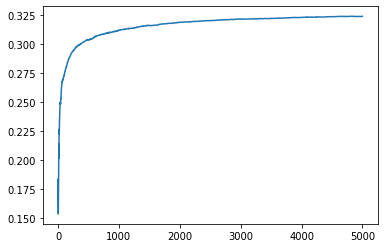

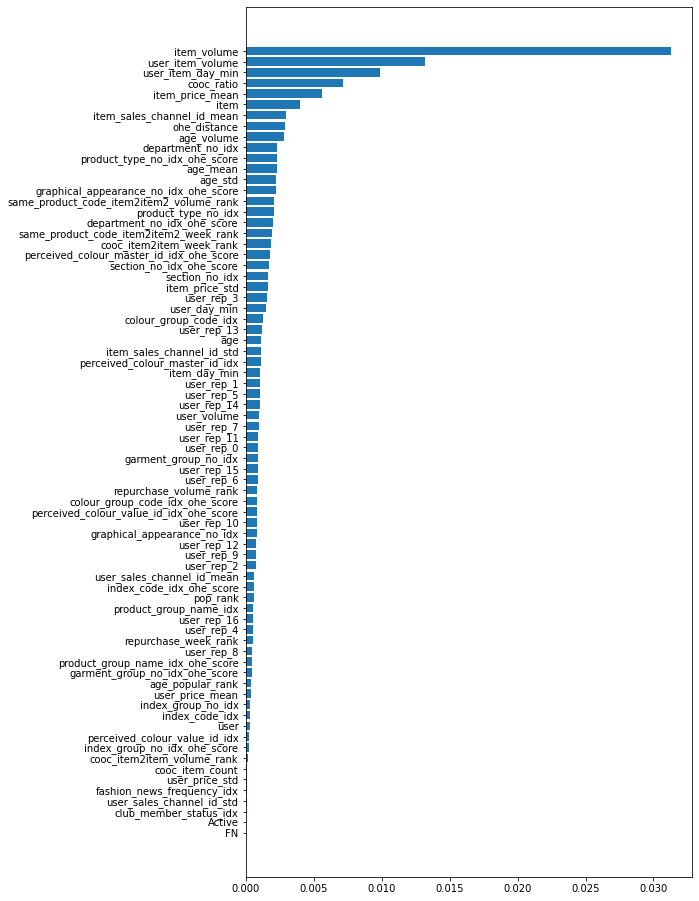

In [16]:
if CFG.model_type == 'LightGBM':
    group_train = get_query_group(train)
    group_valid = get_query_group(valid)

    train_dataset = lgb.Dataset(train[feature_columns], train['y'], group=group_train)
    valid_dataset = lgb.Dataset(valid[feature_columns], valid['y'], group=group_valid, reference=train_dataset)

    params = {
        'objective': 'xendcg',
        'boosting_type': 'gbdt',
        'learning_rate': 1e-6,
        'num_leaves': 255,
        'min_data_in_leaf': 100,
        'metric': 'map',
        'eval_at': 12,
    }

    model = lgb.train(params, train_dataset, valid_sets=[train_dataset, valid_dataset], num_boost_round=1000, callbacks=[lgb.early_stopping(20)])

    lgb.plot_importance(model, importance_type='gain', figsize=(8, 16))

elif CFG.model_type == 'CatBoost':
    train_dataset = catboost.Pool(data=train[feature_columns], label=train['y'], group_id=train['query_group'], cat_features=cat_features)
    valid_dataset = catboost.Pool(data=valid[feature_columns], label=valid['y'], group_id=valid['query_group'], cat_features=cat_features)

    params = {
        'loss_function': 'YetiRank',
        'use_best_model': True,
        'one_hot_max_size': 300,
        'iterations': 5000,
    }
    model = catboost.CatBoost(params)
    model.fit(train_dataset, eval_set=valid_dataset)

    plt.plot(model.get_evals_result()['validation']['PFound'])

    feature_importance = model.get_feature_importance(train_dataset)
    sorted_idx = np.argsort(feature_importance)
    plt.figure(figsize=(8, 16))
    plt.yticks(range(len(feature_columns)), np.array(feature_columns)[sorted_idx])
    plt.barh(range(len(feature_columns)), feature_importance[sorted_idx])


del train, valid, train_dataset, valid_dataset
gc.collect()
with open('output/model_for_validation.pkl', 'wb') as f:
    pickle.dump(model, f)

In [17]:
pred = dataset_valid_all[['user', 'item']].reset_index(drop=True)
pred['pred'] = model.predict(dataset_valid_all[feature_columns])

pred = pred.groupby(['user', 'item'])['pred'].max().reset_index()
pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()

gt = transactions.query("week == 0").groupby('user')['item'].apply(list).reset_index().rename(columns={'item': 'gt'})
merged = gt.merge(pred, on='user', how='left')
merged['item'] = merged['item'].fillna('').apply(list)

merged.to_pickle(f'output/merged_{dataset}.pkl')
dataset_valid_all.to_pickle(f'output/valid_all_{dataset}.pkl')

print('mAP@12:', mapk(merged['gt'], merged['item']))

mAP@12: 0.03505021366755347


In [18]:
# assert False

submission

In [19]:
datasets = joblib.Parallel(n_jobs=-1)(joblib.delayed(attach_features)(transactions, users, items, candidates[idx], 1+idx, CFG.train_weeks) for idx in range(len(candidates)))

for idx in range(len(datasets)):
    datasets[idx]['query_group'] = datasets[idx]['week'].astype(str) + '_' + datasets[idx]['user'].astype(str)
    datasets[idx] = datasets[idx].sort_values(by='query_group').reset_index(drop=True)

train = concat_train(datasets, 0, CFG.train_weeks)

0:	total: 1.87s	remaining: 2h 29m 23s


1:	total: 3.66s	remaining: 2h 26m 28s


2:	total: 5.49s	remaining: 2h 26m 16s


3:	total: 7.3s	remaining: 2h 25m 53s


4:	total: 9.11s	remaining: 2h 25m 39s


5:	total: 10.9s	remaining: 2h 25m 37s


6:	total: 12.8s	remaining: 2h 25m 33s


7:	total: 14.6s	remaining: 2h 25m 33s


8:	total: 16.4s	remaining: 2h 25m 30s


9:	total: 18.3s	remaining: 2h 25m 46s


10:	total: 20.1s	remaining: 2h 26m 9s


11:	total: 21.9s	remaining: 2h 25m 55s


12:	total: 23.8s	remaining: 2h 26m 1s


13:	total: 25.6s	remaining: 2h 26m 1s


14:	total: 27.4s	remaining: 2h 25m 49s


15:	total: 29.3s	remaining: 2h 25m 58s


16:	total: 31.1s	remaining: 2h 25m 57s


17:	total: 32.9s	remaining: 2h 25m 54s


18:	total: 34.8s	remaining: 2h 25m 52s


19:	total: 36.6s	remaining: 2h 25m 46s


20:	total: 38.4s	remaining: 2h 25m 51s


21:	total: 40.3s	remaining: 2h 25m 57s


22:	total: 42.1s	remaining: 2h 25m 51s


23:	total: 43.9s	remaining: 2h 25m 41s


24:	total: 45.8s	remaining: 2h 25m 48s


25:	total: 47.7s	remaining: 2h 26m 5s


26:	total: 49.6s	remaining: 2h 26m 14s


27:	total: 51.5s	remaining: 2h 26m 10s


28:	total: 53.4s	remaining: 2h 26m 32s


29:	total: 55.4s	remaining: 2h 26m 56s


30:	total: 57.3s	remaining: 2h 26m 59s


31:	total: 59.2s	remaining: 2h 27m 4s


32:	total: 1m 1s	remaining: 2h 27m 10s


33:	total: 1m 3s	remaining: 2h 27m 19s


34:	total: 1m 4s	remaining: 2h 27m 26s


35:	total: 1m 6s	remaining: 2h 27m 30s


36:	total: 1m 8s	remaining: 2h 27m 32s


37:	total: 1m 10s	remaining: 2h 27m 31s


38:	total: 1m 12s	remaining: 2h 27m 31s


39:	total: 1m 14s	remaining: 2h 27m 28s


40:	total: 1m 16s	remaining: 2h 27m 28s


41:	total: 1m 18s	remaining: 2h 27m 30s


42:	total: 1m 19s	remaining: 2h 27m 26s


43:	total: 1m 21s	remaining: 2h 27m 25s


44:	total: 1m 23s	remaining: 2h 27m 25s


45:	total: 1m 25s	remaining: 2h 27m 19s


46:	total: 1m 27s	remaining: 2h 27m 15s


47:	total: 1m 29s	remaining: 2h 27m 13s


48:	total: 1m 31s	remaining: 2h 27m 15s


49:	total: 1m 32s	remaining: 2h 27m 14s


50:	total: 1m 34s	remaining: 2h 27m 11s


51:	total: 1m 36s	remaining: 2h 27m 11s


52:	total: 1m 38s	remaining: 2h 27m 5s


53:	total: 1m 40s	remaining: 2h 27m 9s


54:	total: 1m 42s	remaining: 2h 27m 9s


55:	total: 1m 44s	remaining: 2h 27m 7s


56:	total: 1m 46s	remaining: 2h 27m 7s


57:	total: 1m 47s	remaining: 2h 27m 8s


58:	total: 1m 49s	remaining: 2h 27m 12s


59:	total: 1m 51s	remaining: 2h 27m 11s


60:	total: 1m 53s	remaining: 2h 27m 15s


61:	total: 1m 55s	remaining: 2h 27m 17s


62:	total: 1m 57s	remaining: 2h 27m 16s


63:	total: 1m 59s	remaining: 2h 27m 14s


64:	total: 2m 1s	remaining: 2h 27m 14s


65:	total: 2m 3s	remaining: 2h 27m 15s


66:	total: 2m 5s	remaining: 2h 27m 19s


67:	total: 2m 6s	remaining: 2h 27m 17s


68:	total: 2m 8s	remaining: 2h 27m 12s


69:	total: 2m 10s	remaining: 2h 27m 15s


70:	total: 2m 12s	remaining: 2h 27m 12s


71:	total: 2m 14s	remaining: 2h 27m 8s


72:	total: 2m 16s	remaining: 2h 27m 7s


73:	total: 2m 18s	remaining: 2h 27m 3s


74:	total: 2m 19s	remaining: 2h 27m 1s


75:	total: 2m 21s	remaining: 2h 27m


76:	total: 2m 23s	remaining: 2h 27m


77:	total: 2m 25s	remaining: 2h 27m 2s


78:	total: 2m 27s	remaining: 2h 27m


79:	total: 2m 29s	remaining: 2h 27m 1s


80:	total: 2m 31s	remaining: 2h 27m 1s


81:	total: 2m 33s	remaining: 2h 26m 56s


82:	total: 2m 35s	remaining: 2h 26m 57s


83:	total: 2m 36s	remaining: 2h 26m 55s


84:	total: 2m 38s	remaining: 2h 26m 52s


85:	total: 2m 40s	remaining: 2h 26m 46s


86:	total: 2m 42s	remaining: 2h 26m 45s


87:	total: 2m 44s	remaining: 2h 26m 44s


88:	total: 2m 46s	remaining: 2h 26m 44s


89:	total: 2m 48s	remaining: 2h 26m 36s


90:	total: 2m 49s	remaining: 2h 26m 35s


91:	total: 2m 51s	remaining: 2h 26m 32s


92:	total: 2m 53s	remaining: 2h 26m 32s


93:	total: 2m 55s	remaining: 2h 26m 30s


94:	total: 2m 57s	remaining: 2h 26m 32s


95:	total: 2m 59s	remaining: 2h 26m 28s


96:	total: 3m 1s	remaining: 2h 26m 23s


97:	total: 3m 2s	remaining: 2h 26m 16s


98:	total: 3m 4s	remaining: 2h 26m 13s


99:	total: 3m 6s	remaining: 2h 26m 8s


100:	total: 3m 8s	remaining: 2h 26m 5s


101:	total: 3m 10s	remaining: 2h 26m 4s


102:	total: 3m 12s	remaining: 2h 26m 4s
attach features (week: 1)
[user static fetaures] 0.554 s
[item stacic features] 1.228 s
[user dynamic features (transactions)] 1.200 s
[item dynamic features (transactions)] 0.986 s
[item dynamic features (user features)] 1.406 s
[item freshness features] 2.900 s
[item volume features] 0.962 s
[user freshness features] 4.303 s
[user volume features] 1.126 s
[user-item freshness features] 24.504 s
[user-item volume features] 2.200 s
[item age volume features] 2.335 s
[ohe dot products] 71.102 s
[lfm features] 3.899 s


103:	total: 3m 14s	remaining: 2h 26m 3s


104:	total: 3m 15s	remaining: 2h 25m 57s


105:	total: 3m 17s	remaining: 2h 25m 50s


106:	total: 3m 19s	remaining: 2h 25m 47s


107:	total: 3m 21s	remaining: 2h 25m 44s


108:	total: 3m 23s	remaining: 2h 25m 41s


109:	total: 3m 24s	remaining: 2h 25m 38s


110:	total: 3m 26s	remaining: 2h 25m 36s


111:	total: 3m 28s	remaining: 2h 25m 36s


112:	total: 3m 30s	remaining: 2h 25m 31s


attach features (week: 2)
[user static fetaures] 0.635 s
[item stacic features] 1.402 s
[user dynamic features (transactions)] 1.328 s
[item dynamic features (transactions)] 1.177 s
[item dynamic features (user features)] 1.670 s
[item freshness features] 3.140 s
[item volume features] 1.074 s
[user freshness features] 4.727 s
[user volume features] 1.279 s
[user-item freshness features] 25.762 s
[user-item volume features] 2.428 s
[item age volume features] 2.548 s
[ohe dot products] 77.966 s
[lfm features] 3.355 s


113:	total: 3m 32s	remaining: 2h 25m 27s


114:	total: 3m 34s	remaining: 2h 25m 22s


115:	total: 3m 35s	remaining: 2h 25m 20s


116:	total: 3m 37s	remaining: 2h 25m 19s


117:	total: 3m 39s	remaining: 2h 25m 15s


118:	total: 3m 41s	remaining: 2h 25m 12s


attach features (week: 3)
[user static fetaures] 0.725 s
[item stacic features] 1.582 s
[user dynamic features (transactions)] 1.415 s
[item dynamic features (transactions)] 1.276 s
[item dynamic features (user features)] 1.821 s
[item freshness features] 3.482 s
[item volume features] 1.260 s
[user freshness features] 4.590 s
[user volume features] 1.415 s
[user-item freshness features] 26.807 s
[user-item volume features] 2.490 s
[item age volume features] 2.982 s
[ohe dot products] 76.270 s
[lfm features] 4.119 s


119:	total: 3m 43s	remaining: 2h 25m 8s


120:	total: 3m 45s	remaining: 2h 25m 4s


121:	total: 3m 46s	remaining: 2h 25m


122:	total: 3m 48s	remaining: 2h 24m 59s


123:	total: 3m 50s	remaining: 2h 24m 57s


124:	total: 3m 52s	remaining: 2h 24m 54s


125:	total: 3m 54s	remaining: 2h 24m 47s
attach features (week: 4)
[user static fetaures] 0.837 s
[item stacic features] 1.898 s
[user dynamic features (transactions)] 1.508 s
[item dynamic features (transactions)] 1.312 s
[item dynamic features (user features)] 1.903 s
[item freshness features] 3.365 s
[item volume features] 1.408 s
[user freshness features] 4.783 s
[user volume features] 1.492 s
[user-item freshness features] 27.127 s
[user-item volume features] 2.775 s
[item age volume features] 3.388 s
[ohe dot products] 76.474 s
[lfm features] 3.221 s


126:	total: 3m 56s	remaining: 2h 24m 46s


127:	total: 3m 57s	remaining: 2h 24m 47s


128:	total: 3m 59s	remaining: 2h 24m 43s


129:	total: 4m 1s	remaining: 2h 24m 39s


130:	total: 4m 3s	remaining: 2h 24m 35s


131:	total: 4m 5s	remaining: 2h 24m 34s


132:	total: 4m 7s	remaining: 2h 24m 31s


133:	total: 4m 8s	remaining: 2h 24m 27s


134:	total: 4m 10s	remaining: 2h 24m 27s


135:	total: 4m 12s	remaining: 2h 24m 26s


136:	total: 4m 14s	remaining: 2h 24m 24s


137:	total: 4m 16s	remaining: 2h 24m 23s


138:	total: 4m 18s	remaining: 2h 24m 25s


139:	total: 4m 20s	remaining: 2h 24m 21s


140:	total: 4m 21s	remaining: 2h 24m 18s


141:	total: 4m 23s	remaining: 2h 24m 16s


142:	total: 4m 25s	remaining: 2h 24m 14s


143:	total: 4m 27s	remaining: 2h 24m 13s


144:	total: 4m 29s	remaining: 2h 24m 10s


145:	total: 4m 31s	remaining: 2h 24m 8s


146:	total: 4m 33s	remaining: 2h 24m 5s


147:	total: 4m 34s	remaining: 2h 24m 1s


148:	total: 4m 36s	remaining: 2h 24m


149:	total: 4m 38s	remaining: 2h 23m 58s


150:	total: 4m 40s	remaining: 2h 23m 56s


151:	total: 4m 42s	remaining: 2h 23m 55s


152:	total: 4m 44s	remaining: 2h 23m 52s


153:	total: 4m 45s	remaining: 2h 23m 47s


154:	total: 4m 47s	remaining: 2h 23m 45s


155:	total: 4m 49s	remaining: 2h 23m 44s


156:	total: 4m 51s	remaining: 2h 23m 39s


157:	total: 4m 53s	remaining: 2h 23m 36s


158:	total: 4m 55s	remaining: 2h 23m 35s


159:	total: 4m 56s	remaining: 2h 23m 33s


160:	total: 4m 58s	remaining: 2h 23m 31s


161:	total: 5m	remaining: 2h 23m 29s


162:	total: 5m 2s	remaining: 2h 23m 27s


163:	total: 5m 4s	remaining: 2h 23m 28s


164:	total: 5m 6s	remaining: 2h 23m 26s


165:	total: 5m 8s	remaining: 2h 23m 23s


166:	total: 5m 10s	remaining: 2h 23m 23s


167:	total: 5m 11s	remaining: 2h 23m 19s


168:	total: 5m 13s	remaining: 2h 23m 18s


169:	total: 5m 15s	remaining: 2h 23m 14s


170:	total: 5m 17s	remaining: 2h 23m 13s


171:	total: 5m 19s	remaining: 2h 23m 11s


172:	total: 5m 21s	remaining: 2h 23m 8s


173:	total: 5m 22s	remaining: 2h 23m 4s


174:	total: 5m 24s	remaining: 2h 23m


175:	total: 5m 26s	remaining: 2h 23m 1s


176:	total: 5m 28s	remaining: 2h 22m 59s


177:	total: 5m 30s	remaining: 2h 22m 59s


178:	total: 5m 32s	remaining: 2h 22m 56s


179:	total: 5m 34s	remaining: 2h 22m 55s


180:	total: 5m 35s	remaining: 2h 22m 52s


181:	total: 5m 37s	remaining: 2h 22m 50s


182:	total: 5m 39s	remaining: 2h 22m 48s


183:	total: 5m 41s	remaining: 2h 22m 45s


184:	total: 5m 43s	remaining: 2h 22m 44s


185:	total: 5m 45s	remaining: 2h 22m 40s


186:	total: 5m 46s	remaining: 2h 22m 39s


187:	total: 5m 48s	remaining: 2h 22m 38s


188:	total: 5m 50s	remaining: 2h 22m 37s


189:	total: 5m 52s	remaining: 2h 22m 35s


190:	total: 5m 54s	remaining: 2h 22m 36s


191:	total: 5m 56s	remaining: 2h 22m 34s


192:	total: 5m 58s	remaining: 2h 22m 32s


193:	total: 6m	remaining: 2h 22m 32s


194:	total: 6m 2s	remaining: 2h 22m 31s


195:	total: 6m 3s	remaining: 2h 22m 28s


196:	total: 6m 5s	remaining: 2h 22m 28s


197:	total: 6m 7s	remaining: 2h 22m 25s


198:	total: 6m 9s	remaining: 2h 22m 22s


199:	total: 6m 11s	remaining: 2h 22m 19s


200:	total: 6m 13s	remaining: 2h 22m 16s


201:	total: 6m 14s	remaining: 2h 22m 13s


202:	total: 6m 16s	remaining: 2h 22m 13s


203:	total: 6m 18s	remaining: 2h 22m 11s


204:	total: 6m 20s	remaining: 2h 22m 9s


205:	total: 6m 22s	remaining: 2h 22m 6s


206:	total: 6m 24s	remaining: 2h 22m 4s


207:	total: 6m 26s	remaining: 2h 22m 5s


208:	total: 6m 27s	remaining: 2h 22m 3s


209:	total: 6m 29s	remaining: 2h 22m


210:	total: 6m 31s	remaining: 2h 21m 59s


211:	total: 6m 33s	remaining: 2h 21m 58s


212:	total: 6m 35s	remaining: 2h 21m 57s


213:	total: 6m 37s	remaining: 2h 21m 54s


214:	total: 6m 39s	remaining: 2h 21m 53s


215:	total: 6m 40s	remaining: 2h 21m 51s


216:	total: 6m 42s	remaining: 2h 21m 49s


217:	total: 6m 44s	remaining: 2h 21m 46s


218:	total: 6m 46s	remaining: 2h 21m 45s


219:	total: 6m 48s	remaining: 2h 21m 43s


220:	total: 6m 50s	remaining: 2h 21m 40s


221:	total: 6m 52s	remaining: 2h 21m 38s


222:	total: 6m 53s	remaining: 2h 21m 34s


223:	total: 6m 55s	remaining: 2h 21m 33s


224:	total: 6m 57s	remaining: 2h 21m 31s


225:	total: 6m 59s	remaining: 2h 21m 28s


226:	total: 7m 1s	remaining: 2h 21m 26s


227:	total: 7m 3s	remaining: 2h 21m 24s


228:	total: 7m 4s	remaining: 2h 21m 23s


229:	total: 7m 6s	remaining: 2h 21m 23s


230:	total: 7m 8s	remaining: 2h 21m 21s


231:	total: 7m 10s	remaining: 2h 21m 19s


232:	total: 7m 12s	remaining: 2h 21m 19s


233:	total: 7m 14s	remaining: 2h 21m 19s


234:	total: 7m 16s	remaining: 2h 21m 18s


235:	total: 7m 18s	remaining: 2h 21m 16s


236:	total: 7m 20s	remaining: 2h 21m 15s


237:	total: 7m 22s	remaining: 2h 21m 14s


238:	total: 7m 23s	remaining: 2h 21m 11s


239:	total: 7m 25s	remaining: 2h 21m 9s


240:	total: 7m 27s	remaining: 2h 21m 8s


241:	total: 7m 29s	remaining: 2h 21m 6s


242:	total: 7m 31s	remaining: 2h 21m 3s


243:	total: 7m 33s	remaining: 2h 21m 1s


244:	total: 7m 34s	remaining: 2h 20m 59s


245:	total: 7m 36s	remaining: 2h 20m 57s


246:	total: 7m 38s	remaining: 2h 20m 57s


247:	total: 7m 40s	remaining: 2h 20m 55s


248:	total: 7m 42s	remaining: 2h 20m 53s


249:	total: 7m 44s	remaining: 2h 20m 50s


250:	total: 7m 46s	remaining: 2h 20m 50s


251:	total: 7m 47s	remaining: 2h 20m 46s


252:	total: 7m 49s	remaining: 2h 20m 45s


253:	total: 7m 51s	remaining: 2h 20m 43s


254:	total: 7m 53s	remaining: 2h 20m 41s


255:	total: 7m 55s	remaining: 2h 20m 40s


256:	total: 7m 57s	remaining: 2h 20m 37s


257:	total: 7m 59s	remaining: 2h 20m 34s


258:	total: 8m	remaining: 2h 20m 33s


259:	total: 8m 2s	remaining: 2h 20m 32s


260:	total: 8m 4s	remaining: 2h 20m 30s


261:	total: 8m 6s	remaining: 2h 20m 29s


262:	total: 8m 8s	remaining: 2h 20m 27s


263:	total: 8m 10s	remaining: 2h 20m 25s


264:	total: 8m 12s	remaining: 2h 20m 26s


265:	total: 8m 14s	remaining: 2h 20m 23s


266:	total: 8m 15s	remaining: 2h 20m 21s


267:	total: 8m 17s	remaining: 2h 20m 18s


268:	total: 8m 19s	remaining: 2h 20m 16s


269:	total: 8m 21s	remaining: 2h 20m 15s


270:	total: 8m 23s	remaining: 2h 20m 14s


271:	total: 8m 25s	remaining: 2h 20m 11s


272:	total: 8m 27s	remaining: 2h 20m 9s


273:	total: 8m 28s	remaining: 2h 20m 7s


274:	total: 8m 30s	remaining: 2h 20m 5s


275:	total: 8m 32s	remaining: 2h 20m 4s


276:	total: 8m 34s	remaining: 2h 20m 1s


277:	total: 8m 36s	remaining: 2h 19m 59s


278:	total: 8m 38s	remaining: 2h 19m 57s


279:	total: 8m 39s	remaining: 2h 19m 54s


280:	total: 8m 41s	remaining: 2h 19m 52s


281:	total: 8m 43s	remaining: 2h 19m 50s


282:	total: 8m 45s	remaining: 2h 19m 49s


283:	total: 8m 47s	remaining: 2h 19m 47s


284:	total: 8m 49s	remaining: 2h 19m 44s


285:	total: 8m 51s	remaining: 2h 19m 43s


286:	total: 8m 52s	remaining: 2h 19m 41s


287:	total: 8m 54s	remaining: 2h 19m 40s


288:	total: 8m 56s	remaining: 2h 19m 38s


289:	total: 8m 58s	remaining: 2h 19m 35s


290:	total: 9m	remaining: 2h 19m 33s


291:	total: 9m 2s	remaining: 2h 19m 31s


292:	total: 9m 3s	remaining: 2h 19m 29s


293:	total: 9m 5s	remaining: 2h 19m 29s


294:	total: 9m 7s	remaining: 2h 19m 28s


295:	total: 9m 9s	remaining: 2h 19m 25s


296:	total: 9m 11s	remaining: 2h 19m 21s


297:	total: 9m 13s	remaining: 2h 19m 20s


298:	total: 9m 15s	remaining: 2h 19m 17s


299:	total: 9m 16s	remaining: 2h 19m 15s


300:	total: 9m 18s	remaining: 2h 19m 13s


301:	total: 9m 20s	remaining: 2h 19m 12s


302:	total: 9m 22s	remaining: 2h 19m 9s


303:	total: 9m 24s	remaining: 2h 19m 6s


304:	total: 9m 26s	remaining: 2h 19m 4s


305:	total: 9m 27s	remaining: 2h 19m 2s


306:	total: 9m 29s	remaining: 2h 18m 59s


307:	total: 9m 31s	remaining: 2h 18m 57s


308:	total: 9m 33s	remaining: 2h 18m 55s


309:	total: 9m 35s	remaining: 2h 18m 54s


310:	total: 9m 37s	remaining: 2h 18m 51s


311:	total: 9m 39s	remaining: 2h 18m 50s


312:	total: 9m 40s	remaining: 2h 18m 49s


313:	total: 9m 42s	remaining: 2h 18m 46s


314:	total: 9m 44s	remaining: 2h 18m 45s


315:	total: 9m 46s	remaining: 2h 18m 43s


316:	total: 9m 48s	remaining: 2h 18m 41s


317:	total: 9m 50s	remaining: 2h 18m 38s


318:	total: 9m 51s	remaining: 2h 18m 35s


319:	total: 9m 53s	remaining: 2h 18m 32s


320:	total: 9m 55s	remaining: 2h 18m 29s


321:	total: 9m 57s	remaining: 2h 18m 27s


322:	total: 9m 59s	remaining: 2h 18m 26s


323:	total: 10m	remaining: 2h 18m 24s


324:	total: 10m 2s	remaining: 2h 18m 23s


325:	total: 10m 4s	remaining: 2h 18m 19s


326:	total: 10m 6s	remaining: 2h 18m 17s


327:	total: 10m 8s	remaining: 2h 18m 15s


328:	total: 10m 10s	remaining: 2h 18m 13s


329:	total: 10m 12s	remaining: 2h 18m 12s


330:	total: 10m 13s	remaining: 2h 18m 10s


331:	total: 10m 15s	remaining: 2h 18m 9s


332:	total: 10m 17s	remaining: 2h 18m 7s


333:	total: 10m 19s	remaining: 2h 18m 5s


334:	total: 10m 21s	remaining: 2h 18m 4s


335:	total: 10m 23s	remaining: 2h 18m 2s


336:	total: 10m 25s	remaining: 2h 18m


337:	total: 10m 26s	remaining: 2h 17m 58s


338:	total: 10m 28s	remaining: 2h 17m 56s


339:	total: 10m 30s	remaining: 2h 17m 53s


340:	total: 10m 32s	remaining: 2h 17m 51s


341:	total: 10m 34s	remaining: 2h 17m 48s


342:	total: 10m 36s	remaining: 2h 17m 47s


343:	total: 10m 37s	remaining: 2h 17m 45s


344:	total: 10m 39s	remaining: 2h 17m 42s


345:	total: 10m 41s	remaining: 2h 17m 41s


346:	total: 10m 43s	remaining: 2h 17m 38s


347:	total: 10m 45s	remaining: 2h 17m 36s


348:	total: 10m 47s	remaining: 2h 17m 35s


349:	total: 10m 48s	remaining: 2h 17m 33s


350:	total: 10m 50s	remaining: 2h 17m 30s


351:	total: 10m 52s	remaining: 2h 17m 28s


352:	total: 10m 54s	remaining: 2h 17m 27s


353:	total: 10m 56s	remaining: 2h 17m 26s


354:	total: 10m 58s	remaining: 2h 17m 22s


355:	total: 11m	remaining: 2h 17m 21s


356:	total: 11m 1s	remaining: 2h 17m 20s


357:	total: 11m 3s	remaining: 2h 17m 18s


358:	total: 11m 5s	remaining: 2h 17m 15s


359:	total: 11m 7s	remaining: 2h 17m 13s


360:	total: 11m 9s	remaining: 2h 17m 12s


361:	total: 11m 11s	remaining: 2h 17m 9s


362:	total: 11m 12s	remaining: 2h 17m 7s


363:	total: 11m 14s	remaining: 2h 17m 5s


364:	total: 11m 16s	remaining: 2h 17m 3s


365:	total: 11m 18s	remaining: 2h 17m 1s


366:	total: 11m 20s	remaining: 2h 16m 57s


367:	total: 11m 21s	remaining: 2h 16m 55s


368:	total: 11m 23s	remaining: 2h 16m 53s


369:	total: 11m 25s	remaining: 2h 16m 50s


370:	total: 11m 27s	remaining: 2h 16m 48s


371:	total: 11m 29s	remaining: 2h 16m 46s


372:	total: 11m 31s	remaining: 2h 16m 44s


373:	total: 11m 32s	remaining: 2h 16m 41s


374:	total: 11m 34s	remaining: 2h 16m 39s


375:	total: 11m 36s	remaining: 2h 16m 37s


376:	total: 11m 38s	remaining: 2h 16m 35s


377:	total: 11m 40s	remaining: 2h 16m 34s


378:	total: 11m 42s	remaining: 2h 16m 33s


379:	total: 11m 44s	remaining: 2h 16m 32s


380:	total: 11m 45s	remaining: 2h 16m 30s


381:	total: 11m 47s	remaining: 2h 16m 27s


382:	total: 11m 49s	remaining: 2h 16m 26s


383:	total: 11m 51s	remaining: 2h 16m 22s


384:	total: 11m 53s	remaining: 2h 16m 20s


385:	total: 11m 54s	remaining: 2h 16m 17s


386:	total: 11m 56s	remaining: 2h 16m 15s


387:	total: 11m 58s	remaining: 2h 16m 14s


388:	total: 12m	remaining: 2h 16m 12s


389:	total: 12m 2s	remaining: 2h 16m 11s


390:	total: 12m 4s	remaining: 2h 16m 9s


391:	total: 12m 6s	remaining: 2h 16m 7s


392:	total: 12m 7s	remaining: 2h 16m 4s


393:	total: 12m 9s	remaining: 2h 16m 3s


394:	total: 12m 11s	remaining: 2h 16m 1s


395:	total: 12m 13s	remaining: 2h 15m 59s


396:	total: 12m 15s	remaining: 2h 15m 57s


397:	total: 12m 17s	remaining: 2h 15m 54s


398:	total: 12m 18s	remaining: 2h 15m 52s


399:	total: 12m 20s	remaining: 2h 15m 50s


400:	total: 12m 22s	remaining: 2h 15m 49s


401:	total: 12m 24s	remaining: 2h 15m 47s


402:	total: 12m 26s	remaining: 2h 15m 46s


403:	total: 12m 28s	remaining: 2h 15m 44s


404:	total: 12m 30s	remaining: 2h 15m 42s


405:	total: 12m 31s	remaining: 2h 15m 39s


406:	total: 12m 33s	remaining: 2h 15m 37s


407:	total: 12m 35s	remaining: 2h 15m 35s


408:	total: 12m 37s	remaining: 2h 15m 33s


409:	total: 12m 39s	remaining: 2h 15m 31s


410:	total: 12m 41s	remaining: 2h 15m 28s


411:	total: 12m 42s	remaining: 2h 15m 25s


412:	total: 12m 44s	remaining: 2h 15m 23s


413:	total: 12m 46s	remaining: 2h 15m 21s


414:	total: 12m 48s	remaining: 2h 15m 19s


415:	total: 12m 50s	remaining: 2h 15m 16s


416:	total: 12m 51s	remaining: 2h 15m 15s


417:	total: 12m 53s	remaining: 2h 15m 13s


418:	total: 12m 55s	remaining: 2h 15m 11s


419:	total: 12m 57s	remaining: 2h 15m 9s


420:	total: 12m 59s	remaining: 2h 15m 7s


421:	total: 13m	remaining: 2h 15m 4s


422:	total: 13m 2s	remaining: 2h 15m 1s


423:	total: 13m 4s	remaining: 2h 14m 59s


424:	total: 13m 6s	remaining: 2h 14m 59s


425:	total: 13m 8s	remaining: 2h 14m 57s


426:	total: 13m 10s	remaining: 2h 14m 55s


427:	total: 13m 12s	remaining: 2h 14m 54s


428:	total: 13m 14s	remaining: 2h 14m 52s


429:	total: 13m 15s	remaining: 2h 14m 50s


430:	total: 13m 17s	remaining: 2h 14m 47s


431:	total: 13m 19s	remaining: 2h 14m 46s


432:	total: 13m 21s	remaining: 2h 14m 43s


433:	total: 13m 23s	remaining: 2h 14m 41s


434:	total: 13m 25s	remaining: 2h 14m 40s


435:	total: 13m 26s	remaining: 2h 14m 37s


436:	total: 13m 28s	remaining: 2h 14m 35s


437:	total: 13m 30s	remaining: 2h 14m 32s


438:	total: 13m 32s	remaining: 2h 14m 30s


439:	total: 13m 34s	remaining: 2h 14m 28s


440:	total: 13m 35s	remaining: 2h 14m 25s


441:	total: 13m 37s	remaining: 2h 14m 22s


442:	total: 13m 39s	remaining: 2h 14m 20s


443:	total: 13m 41s	remaining: 2h 14m 18s


444:	total: 13m 43s	remaining: 2h 14m 17s


445:	total: 13m 44s	remaining: 2h 14m 15s


446:	total: 13m 46s	remaining: 2h 14m 11s


447:	total: 13m 48s	remaining: 2h 14m 10s


448:	total: 13m 50s	remaining: 2h 14m 8s


449:	total: 13m 52s	remaining: 2h 14m 6s


450:	total: 13m 54s	remaining: 2h 14m 4s


451:	total: 13m 55s	remaining: 2h 14m 2s


452:	total: 13m 57s	remaining: 2h 14m


453:	total: 13m 59s	remaining: 2h 13m 59s


454:	total: 14m 1s	remaining: 2h 13m 57s


455:	total: 14m 3s	remaining: 2h 13m 55s


456:	total: 14m 5s	remaining: 2h 13m 53s


457:	total: 14m 6s	remaining: 2h 13m 51s


458:	total: 14m 8s	remaining: 2h 13m 48s


459:	total: 14m 10s	remaining: 2h 13m 47s


460:	total: 14m 12s	remaining: 2h 13m 44s


461:	total: 14m 14s	remaining: 2h 13m 41s


462:	total: 14m 15s	remaining: 2h 13m 39s


463:	total: 14m 17s	remaining: 2h 13m 36s


464:	total: 14m 19s	remaining: 2h 13m 34s


465:	total: 14m 21s	remaining: 2h 13m 32s


466:	total: 14m 23s	remaining: 2h 13m 29s


467:	total: 14m 24s	remaining: 2h 13m 27s


468:	total: 14m 26s	remaining: 2h 13m 25s


469:	total: 14m 28s	remaining: 2h 13m 23s


470:	total: 14m 30s	remaining: 2h 13m 21s


471:	total: 14m 32s	remaining: 2h 13m 19s


472:	total: 14m 34s	remaining: 2h 13m 17s


473:	total: 14m 35s	remaining: 2h 13m 15s


474:	total: 14m 37s	remaining: 2h 13m 14s


475:	total: 14m 39s	remaining: 2h 13m 11s


476:	total: 14m 41s	remaining: 2h 13m 9s


477:	total: 14m 43s	remaining: 2h 13m 8s


478:	total: 14m 44s	remaining: 2h 13m 5s


479:	total: 14m 46s	remaining: 2h 13m 2s


480:	total: 14m 48s	remaining: 2h 13m


481:	total: 14m 50s	remaining: 2h 12m 57s


482:	total: 14m 52s	remaining: 2h 12m 55s


483:	total: 14m 54s	remaining: 2h 12m 54s


484:	total: 14m 55s	remaining: 2h 12m 52s


485:	total: 14m 57s	remaining: 2h 12m 50s


486:	total: 14m 59s	remaining: 2h 12m 49s


487:	total: 15m 1s	remaining: 2h 12m 47s


488:	total: 15m 3s	remaining: 2h 12m 45s


489:	total: 15m 5s	remaining: 2h 12m 44s


490:	total: 15m 7s	remaining: 2h 12m 41s


491:	total: 15m 8s	remaining: 2h 12m 39s


492:	total: 15m 10s	remaining: 2h 12m 38s


493:	total: 15m 12s	remaining: 2h 12m 36s


494:	total: 15m 14s	remaining: 2h 12m 34s


495:	total: 15m 16s	remaining: 2h 12m 32s


496:	total: 15m 18s	remaining: 2h 12m 31s


497:	total: 15m 19s	remaining: 2h 12m 29s


498:	total: 15m 21s	remaining: 2h 12m 27s


499:	total: 15m 23s	remaining: 2h 12m 24s


500:	total: 15m 25s	remaining: 2h 12m 22s


501:	total: 15m 27s	remaining: 2h 12m 20s


502:	total: 15m 29s	remaining: 2h 12m 18s


503:	total: 15m 30s	remaining: 2h 12m 15s


504:	total: 15m 32s	remaining: 2h 12m 13s


505:	total: 15m 34s	remaining: 2h 12m 11s


506:	total: 15m 36s	remaining: 2h 12m 9s


507:	total: 15m 38s	remaining: 2h 12m 7s


508:	total: 15m 39s	remaining: 2h 12m 5s


509:	total: 15m 41s	remaining: 2h 12m 2s


510:	total: 15m 43s	remaining: 2h 12m


511:	total: 15m 45s	remaining: 2h 11m 59s


512:	total: 15m 47s	remaining: 2h 11m 56s


513:	total: 15m 48s	remaining: 2h 11m 54s


514:	total: 15m 50s	remaining: 2h 11m 53s


515:	total: 15m 52s	remaining: 2h 11m 51s


516:	total: 15m 54s	remaining: 2h 11m 49s


517:	total: 15m 56s	remaining: 2h 11m 48s


518:	total: 15m 58s	remaining: 2h 11m 46s


519:	total: 16m	remaining: 2h 11m 44s


520:	total: 16m 1s	remaining: 2h 11m 42s


521:	total: 16m 3s	remaining: 2h 11m 40s


522:	total: 16m 5s	remaining: 2h 11m 39s


523:	total: 16m 7s	remaining: 2h 11m 37s


524:	total: 16m 9s	remaining: 2h 11m 36s


525:	total: 16m 11s	remaining: 2h 11m 34s


526:	total: 16m 13s	remaining: 2h 11m 32s


527:	total: 16m 14s	remaining: 2h 11m 30s


528:	total: 16m 16s	remaining: 2h 11m 28s


529:	total: 16m 18s	remaining: 2h 11m 26s


530:	total: 16m 20s	remaining: 2h 11m 24s


531:	total: 16m 22s	remaining: 2h 11m 21s


532:	total: 16m 24s	remaining: 2h 11m 20s


533:	total: 16m 25s	remaining: 2h 11m 17s


534:	total: 16m 27s	remaining: 2h 11m 16s


535:	total: 16m 29s	remaining: 2h 11m 14s


536:	total: 16m 31s	remaining: 2h 11m 12s


537:	total: 16m 33s	remaining: 2h 11m 9s


538:	total: 16m 34s	remaining: 2h 11m 7s


539:	total: 16m 36s	remaining: 2h 11m 4s


540:	total: 16m 38s	remaining: 2h 11m 3s


541:	total: 16m 40s	remaining: 2h 11m


542:	total: 16m 42s	remaining: 2h 10m 59s


543:	total: 16m 44s	remaining: 2h 10m 56s


544:	total: 16m 45s	remaining: 2h 10m 55s


545:	total: 16m 47s	remaining: 2h 10m 53s


546:	total: 16m 49s	remaining: 2h 10m 51s


547:	total: 16m 51s	remaining: 2h 10m 49s


548:	total: 16m 53s	remaining: 2h 10m 47s


549:	total: 16m 55s	remaining: 2h 10m 45s


550:	total: 16m 56s	remaining: 2h 10m 43s


551:	total: 16m 58s	remaining: 2h 10m 41s


552:	total: 17m	remaining: 2h 10m 40s


553:	total: 17m 2s	remaining: 2h 10m 38s


554:	total: 17m 4s	remaining: 2h 10m 35s


555:	total: 17m 6s	remaining: 2h 10m 33s


556:	total: 17m 7s	remaining: 2h 10m 31s


557:	total: 17m 9s	remaining: 2h 10m 30s


558:	total: 17m 11s	remaining: 2h 10m 28s


559:	total: 17m 13s	remaining: 2h 10m 26s


560:	total: 17m 15s	remaining: 2h 10m 24s


561:	total: 17m 17s	remaining: 2h 10m 22s


562:	total: 17m 18s	remaining: 2h 10m 20s


563:	total: 17m 20s	remaining: 2h 10m 18s


564:	total: 17m 22s	remaining: 2h 10m 16s


565:	total: 17m 24s	remaining: 2h 10m 14s


566:	total: 17m 26s	remaining: 2h 10m 12s


567:	total: 17m 27s	remaining: 2h 10m 9s


568:	total: 17m 29s	remaining: 2h 10m 7s


569:	total: 17m 31s	remaining: 2h 10m 5s


570:	total: 17m 33s	remaining: 2h 10m 3s


571:	total: 17m 35s	remaining: 2h 10m 1s


572:	total: 17m 37s	remaining: 2h 9m 59s


573:	total: 17m 38s	remaining: 2h 9m 56s


574:	total: 17m 40s	remaining: 2h 9m 55s


575:	total: 17m 42s	remaining: 2h 9m 52s


576:	total: 17m 44s	remaining: 2h 9m 49s


577:	total: 17m 45s	remaining: 2h 9m 48s


578:	total: 17m 47s	remaining: 2h 9m 46s


579:	total: 17m 49s	remaining: 2h 9m 44s


580:	total: 17m 51s	remaining: 2h 9m 41s


581:	total: 17m 53s	remaining: 2h 9m 39s


582:	total: 17m 55s	remaining: 2h 9m 37s


583:	total: 17m 56s	remaining: 2h 9m 36s


584:	total: 17m 58s	remaining: 2h 9m 34s


585:	total: 18m	remaining: 2h 9m 32s


586:	total: 18m 2s	remaining: 2h 9m 30s


587:	total: 18m 4s	remaining: 2h 9m 28s


588:	total: 18m 6s	remaining: 2h 9m 26s


589:	total: 18m 7s	remaining: 2h 9m 24s


590:	total: 18m 9s	remaining: 2h 9m 22s


591:	total: 18m 11s	remaining: 2h 9m 20s


592:	total: 18m 13s	remaining: 2h 9m 19s


593:	total: 18m 15s	remaining: 2h 9m 17s


594:	total: 18m 17s	remaining: 2h 9m 16s


595:	total: 18m 19s	remaining: 2h 9m 14s


596:	total: 18m 20s	remaining: 2h 9m 12s


597:	total: 18m 22s	remaining: 2h 9m 10s


598:	total: 18m 24s	remaining: 2h 9m 8s


599:	total: 18m 26s	remaining: 2h 9m 7s


600:	total: 18m 28s	remaining: 2h 9m 5s


601:	total: 18m 30s	remaining: 2h 9m 3s


602:	total: 18m 31s	remaining: 2h 9m


603:	total: 18m 33s	remaining: 2h 8m 58s


604:	total: 18m 35s	remaining: 2h 8m 57s


605:	total: 18m 37s	remaining: 2h 8m 55s


606:	total: 18m 39s	remaining: 2h 8m 54s


607:	total: 18m 41s	remaining: 2h 8m 52s


608:	total: 18m 42s	remaining: 2h 8m 49s


609:	total: 18m 44s	remaining: 2h 8m 48s


610:	total: 18m 46s	remaining: 2h 8m 46s


611:	total: 18m 48s	remaining: 2h 8m 44s


612:	total: 18m 50s	remaining: 2h 8m 43s


613:	total: 18m 52s	remaining: 2h 8m 41s


614:	total: 18m 54s	remaining: 2h 8m 39s


615:	total: 18m 56s	remaining: 2h 8m 38s


616:	total: 18m 57s	remaining: 2h 8m 36s


617:	total: 18m 59s	remaining: 2h 8m 34s


618:	total: 19m 1s	remaining: 2h 8m 32s


619:	total: 19m 3s	remaining: 2h 8m 30s


620:	total: 19m 5s	remaining: 2h 8m 29s


621:	total: 19m 6s	remaining: 2h 8m 26s


622:	total: 19m 8s	remaining: 2h 8m 24s


623:	total: 19m 10s	remaining: 2h 8m 23s


624:	total: 19m 12s	remaining: 2h 8m 21s


625:	total: 19m 14s	remaining: 2h 8m 19s


626:	total: 19m 16s	remaining: 2h 8m 17s


627:	total: 19m 18s	remaining: 2h 8m 15s


628:	total: 19m 19s	remaining: 2h 8m 13s


629:	total: 19m 21s	remaining: 2h 8m 10s


630:	total: 19m 23s	remaining: 2h 8m 9s


631:	total: 19m 25s	remaining: 2h 8m 7s


632:	total: 19m 27s	remaining: 2h 8m 4s


633:	total: 19m 28s	remaining: 2h 8m 2s


634:	total: 19m 30s	remaining: 2h 8m


635:	total: 19m 32s	remaining: 2h 7m 58s


636:	total: 19m 34s	remaining: 2h 7m 56s


637:	total: 19m 36s	remaining: 2h 7m 54s


638:	total: 19m 37s	remaining: 2h 7m 52s


639:	total: 19m 39s	remaining: 2h 7m 50s


640:	total: 19m 41s	remaining: 2h 7m 48s


641:	total: 19m 43s	remaining: 2h 7m 46s


642:	total: 19m 45s	remaining: 2h 7m 44s


643:	total: 19m 47s	remaining: 2h 7m 42s


644:	total: 19m 48s	remaining: 2h 7m 40s


645:	total: 19m 50s	remaining: 2h 7m 38s


646:	total: 19m 52s	remaining: 2h 7m 36s


647:	total: 19m 54s	remaining: 2h 7m 34s


648:	total: 19m 56s	remaining: 2h 7m 33s


649:	total: 19m 58s	remaining: 2h 7m 31s


650:	total: 20m	remaining: 2h 7m 29s


651:	total: 20m 1s	remaining: 2h 7m 28s


652:	total: 20m 3s	remaining: 2h 7m 26s


653:	total: 20m 5s	remaining: 2h 7m 24s


654:	total: 20m 7s	remaining: 2h 7m 22s


655:	total: 20m 9s	remaining: 2h 7m 20s


656:	total: 20m 10s	remaining: 2h 7m 18s


657:	total: 20m 12s	remaining: 2h 7m 16s


658:	total: 20m 14s	remaining: 2h 7m 13s


659:	total: 20m 16s	remaining: 2h 7m 11s


660:	total: 20m 18s	remaining: 2h 7m 10s


661:	total: 20m 20s	remaining: 2h 7m 7s


662:	total: 20m 21s	remaining: 2h 7m 6s


663:	total: 20m 23s	remaining: 2h 7m 3s


664:	total: 20m 25s	remaining: 2h 7m 2s


665:	total: 20m 27s	remaining: 2h 6m 59s


666:	total: 20m 29s	remaining: 2h 6m 58s


667:	total: 20m 30s	remaining: 2h 6m 56s


668:	total: 20m 32s	remaining: 2h 6m 53s


669:	total: 20m 34s	remaining: 2h 6m 51s


670:	total: 20m 36s	remaining: 2h 6m 50s


671:	total: 20m 38s	remaining: 2h 6m 48s


672:	total: 20m 40s	remaining: 2h 6m 46s


673:	total: 20m 41s	remaining: 2h 6m 44s


674:	total: 20m 43s	remaining: 2h 6m 42s


675:	total: 20m 45s	remaining: 2h 6m 40s


676:	total: 20m 47s	remaining: 2h 6m 37s


677:	total: 20m 49s	remaining: 2h 6m 35s


678:	total: 20m 50s	remaining: 2h 6m 33s


679:	total: 20m 52s	remaining: 2h 6m 31s


680:	total: 20m 54s	remaining: 2h 6m 29s


681:	total: 20m 56s	remaining: 2h 6m 27s


682:	total: 20m 57s	remaining: 2h 6m 24s


683:	total: 20m 59s	remaining: 2h 6m 22s


684:	total: 21m 1s	remaining: 2h 6m 20s


685:	total: 21m 3s	remaining: 2h 6m 18s


686:	total: 21m 5s	remaining: 2h 6m 16s


687:	total: 21m 7s	remaining: 2h 6m 14s


688:	total: 21m 8s	remaining: 2h 6m 12s


689:	total: 21m 10s	remaining: 2h 6m 11s


690:	total: 21m 12s	remaining: 2h 6m 9s


691:	total: 21m 14s	remaining: 2h 6m 7s


692:	total: 21m 16s	remaining: 2h 6m 5s


693:	total: 21m 18s	remaining: 2h 6m 3s


694:	total: 21m 19s	remaining: 2h 6m 1s


695:	total: 21m 21s	remaining: 2h 5m 59s


696:	total: 21m 23s	remaining: 2h 5m 57s


697:	total: 21m 25s	remaining: 2h 5m 55s


698:	total: 21m 27s	remaining: 2h 5m 54s


699:	total: 21m 29s	remaining: 2h 5m 52s


700:	total: 21m 31s	remaining: 2h 5m 50s


701:	total: 21m 32s	remaining: 2h 5m 48s


702:	total: 21m 34s	remaining: 2h 5m 46s


703:	total: 21m 36s	remaining: 2h 5m 44s


704:	total: 21m 38s	remaining: 2h 5m 42s


705:	total: 21m 39s	remaining: 2h 5m 40s


706:	total: 21m 41s	remaining: 2h 5m 38s


707:	total: 21m 43s	remaining: 2h 5m 36s


708:	total: 21m 45s	remaining: 2h 5m 34s


709:	total: 21m 47s	remaining: 2h 5m 32s


710:	total: 21m 49s	remaining: 2h 5m 30s


711:	total: 21m 50s	remaining: 2h 5m 28s


712:	total: 21m 52s	remaining: 2h 5m 26s


713:	total: 21m 54s	remaining: 2h 5m 23s


714:	total: 21m 56s	remaining: 2h 5m 21s


715:	total: 21m 58s	remaining: 2h 5m 20s


716:	total: 21m 59s	remaining: 2h 5m 18s


717:	total: 22m 1s	remaining: 2h 5m 16s


718:	total: 22m 3s	remaining: 2h 5m 14s


719:	total: 22m 5s	remaining: 2h 5m 12s


720:	total: 22m 7s	remaining: 2h 5m 10s


721:	total: 22m 9s	remaining: 2h 5m 9s


722:	total: 22m 11s	remaining: 2h 5m 7s


723:	total: 22m 12s	remaining: 2h 5m 6s


724:	total: 22m 14s	remaining: 2h 5m 3s


725:	total: 22m 16s	remaining: 2h 5m 1s


726:	total: 22m 18s	remaining: 2h 4m 59s


727:	total: 22m 20s	remaining: 2h 4m 57s


728:	total: 22m 21s	remaining: 2h 4m 55s


729:	total: 22m 23s	remaining: 2h 4m 53s


730:	total: 22m 25s	remaining: 2h 4m 51s


731:	total: 22m 27s	remaining: 2h 4m 49s


732:	total: 22m 29s	remaining: 2h 4m 48s


733:	total: 22m 30s	remaining: 2h 4m 45s


734:	total: 22m 32s	remaining: 2h 4m 43s


735:	total: 22m 34s	remaining: 2h 4m 42s


736:	total: 22m 36s	remaining: 2h 4m 40s


737:	total: 22m 38s	remaining: 2h 4m 38s


738:	total: 22m 40s	remaining: 2h 4m 36s


739:	total: 22m 42s	remaining: 2h 4m 34s


740:	total: 22m 43s	remaining: 2h 4m 33s


741:	total: 22m 45s	remaining: 2h 4m 31s


742:	total: 22m 47s	remaining: 2h 4m 30s


743:	total: 22m 49s	remaining: 2h 4m 28s


744:	total: 22m 51s	remaining: 2h 4m 27s


745:	total: 22m 53s	remaining: 2h 4m 24s


746:	total: 22m 55s	remaining: 2h 4m 22s


747:	total: 22m 56s	remaining: 2h 4m 21s


748:	total: 22m 58s	remaining: 2h 4m 19s


749:	total: 23m	remaining: 2h 4m 17s


750:	total: 23m 2s	remaining: 2h 4m 16s


751:	total: 23m 4s	remaining: 2h 4m 14s


752:	total: 23m 6s	remaining: 2h 4m 11s


753:	total: 23m 7s	remaining: 2h 4m 9s


754:	total: 23m 9s	remaining: 2h 4m 8s


755:	total: 23m 11s	remaining: 2h 4m 6s


756:	total: 23m 13s	remaining: 2h 4m 3s


757:	total: 23m 15s	remaining: 2h 4m 1s


758:	total: 23m 16s	remaining: 2h 3m 59s


759:	total: 23m 18s	remaining: 2h 3m 57s


760:	total: 23m 20s	remaining: 2h 3m 56s


761:	total: 23m 22s	remaining: 2h 3m 53s


762:	total: 23m 24s	remaining: 2h 3m 52s


763:	total: 23m 26s	remaining: 2h 3m 50s


764:	total: 23m 28s	remaining: 2h 3m 49s


765:	total: 23m 29s	remaining: 2h 3m 47s


766:	total: 23m 31s	remaining: 2h 3m 45s


767:	total: 23m 33s	remaining: 2h 3m 43s


768:	total: 23m 35s	remaining: 2h 3m 42s


769:	total: 23m 37s	remaining: 2h 3m 39s


770:	total: 23m 39s	remaining: 2h 3m 37s


771:	total: 23m 40s	remaining: 2h 3m 35s


772:	total: 23m 42s	remaining: 2h 3m 33s


773:	total: 23m 44s	remaining: 2h 3m 31s


774:	total: 23m 46s	remaining: 2h 3m 29s


775:	total: 23m 48s	remaining: 2h 3m 28s


776:	total: 23m 49s	remaining: 2h 3m 25s


777:	total: 23m 51s	remaining: 2h 3m 23s


778:	total: 23m 53s	remaining: 2h 3m 21s


779:	total: 23m 55s	remaining: 2h 3m 19s


780:	total: 23m 57s	remaining: 2h 3m 18s


781:	total: 23m 59s	remaining: 2h 3m 16s


782:	total: 24m	remaining: 2h 3m 14s


783:	total: 24m 2s	remaining: 2h 3m 11s


784:	total: 24m 4s	remaining: 2h 3m 9s


785:	total: 24m 6s	remaining: 2h 3m 8s


786:	total: 24m 8s	remaining: 2h 3m 6s


787:	total: 24m 9s	remaining: 2h 3m 3s


788:	total: 24m 11s	remaining: 2h 3m 1s


789:	total: 24m 13s	remaining: 2h 2m 59s


790:	total: 24m 15s	remaining: 2h 2m 58s


791:	total: 24m 17s	remaining: 2h 2m 56s


792:	total: 24m 19s	remaining: 2h 2m 55s


793:	total: 24m 21s	remaining: 2h 2m 53s


794:	total: 24m 22s	remaining: 2h 2m 51s


795:	total: 24m 24s	remaining: 2h 2m 49s


796:	total: 24m 26s	remaining: 2h 2m 48s


797:	total: 24m 28s	remaining: 2h 2m 46s


798:	total: 24m 30s	remaining: 2h 2m 44s


799:	total: 24m 32s	remaining: 2h 2m 42s


800:	total: 24m 34s	remaining: 2h 2m 40s


801:	total: 24m 35s	remaining: 2h 2m 39s


802:	total: 24m 37s	remaining: 2h 2m 37s


803:	total: 24m 39s	remaining: 2h 2m 36s


804:	total: 24m 41s	remaining: 2h 2m 33s


805:	total: 24m 43s	remaining: 2h 2m 32s


806:	total: 24m 45s	remaining: 2h 2m 31s


807:	total: 24m 47s	remaining: 2h 2m 29s


808:	total: 24m 48s	remaining: 2h 2m 27s


809:	total: 24m 50s	remaining: 2h 2m 25s


810:	total: 24m 52s	remaining: 2h 2m 23s


811:	total: 24m 54s	remaining: 2h 2m 21s


812:	total: 24m 56s	remaining: 2h 2m 19s


813:	total: 24m 58s	remaining: 2h 2m 17s


814:	total: 24m 59s	remaining: 2h 2m 15s


815:	total: 25m 1s	remaining: 2h 2m 13s


816:	total: 25m 3s	remaining: 2h 2m 11s


817:	total: 25m 5s	remaining: 2h 2m 9s


818:	total: 25m 7s	remaining: 2h 2m 7s


819:	total: 25m 8s	remaining: 2h 2m 5s


820:	total: 25m 10s	remaining: 2h 2m 3s


821:	total: 25m 12s	remaining: 2h 2m 1s


822:	total: 25m 14s	remaining: 2h 1m 59s


823:	total: 25m 16s	remaining: 2h 1m 57s


824:	total: 25m 18s	remaining: 2h 1m 56s


825:	total: 25m 19s	remaining: 2h 1m 54s


826:	total: 25m 21s	remaining: 2h 1m 52s


827:	total: 25m 23s	remaining: 2h 1m 50s


828:	total: 25m 25s	remaining: 2h 1m 48s


829:	total: 25m 27s	remaining: 2h 1m 46s


830:	total: 25m 28s	remaining: 2h 1m 44s


831:	total: 25m 30s	remaining: 2h 1m 42s


832:	total: 25m 32s	remaining: 2h 1m 41s


833:	total: 25m 34s	remaining: 2h 1m 38s


834:	total: 25m 36s	remaining: 2h 1m 36s


835:	total: 25m 38s	remaining: 2h 1m 34s


836:	total: 25m 39s	remaining: 2h 1m 33s


837:	total: 25m 41s	remaining: 2h 1m 31s


838:	total: 25m 43s	remaining: 2h 1m 29s


839:	total: 25m 45s	remaining: 2h 1m 27s


840:	total: 25m 47s	remaining: 2h 1m 26s


841:	total: 25m 49s	remaining: 2h 1m 24s


842:	total: 25m 51s	remaining: 2h 1m 22s


843:	total: 25m 52s	remaining: 2h 1m 20s


844:	total: 25m 54s	remaining: 2h 1m 18s


845:	total: 25m 56s	remaining: 2h 1m 17s


846:	total: 25m 58s	remaining: 2h 1m 15s


847:	total: 26m	remaining: 2h 1m 14s


848:	total: 26m 2s	remaining: 2h 1m 11s


849:	total: 26m 4s	remaining: 2h 1m 10s


850:	total: 26m 5s	remaining: 2h 1m 7s


851:	total: 26m 7s	remaining: 2h 1m 6s


852:	total: 26m 9s	remaining: 2h 1m 4s


853:	total: 26m 11s	remaining: 2h 1m 2s


854:	total: 26m 13s	remaining: 2h 1m


855:	total: 26m 15s	remaining: 2h 58s


856:	total: 26m 16s	remaining: 2h 57s


857:	total: 26m 18s	remaining: 2h 55s


858:	total: 26m 20s	remaining: 2h 53s


859:	total: 26m 22s	remaining: 2h 52s


860:	total: 26m 24s	remaining: 2h 50s


861:	total: 26m 26s	remaining: 2h 48s


862:	total: 26m 28s	remaining: 2h 46s


863:	total: 26m 29s	remaining: 2h 44s


864:	total: 26m 31s	remaining: 2h 42s


865:	total: 26m 33s	remaining: 2h 40s


866:	total: 26m 35s	remaining: 2h 38s


867:	total: 26m 37s	remaining: 2h 36s


868:	total: 26m 38s	remaining: 2h 34s


869:	total: 26m 40s	remaining: 2h 32s


870:	total: 26m 42s	remaining: 2h 30s


871:	total: 26m 44s	remaining: 2h 28s


872:	total: 26m 45s	remaining: 2h 25s


873:	total: 26m 47s	remaining: 2h 23s


874:	total: 26m 49s	remaining: 2h 22s


875:	total: 26m 51s	remaining: 2h 20s


876:	total: 26m 53s	remaining: 2h 18s


877:	total: 26m 55s	remaining: 2h 16s


878:	total: 26m 56s	remaining: 2h 14s


879:	total: 26m 58s	remaining: 2h 12s


880:	total: 27m	remaining: 2h 10s


881:	total: 27m 2s	remaining: 2h 8s


882:	total: 27m 4s	remaining: 2h 6s


883:	total: 27m 5s	remaining: 2h 4s


884:	total: 27m 7s	remaining: 2h 2s


885:	total: 27m 9s	remaining: 2h


886:	total: 27m 11s	remaining: 1h 59m 58s


887:	total: 27m 13s	remaining: 1h 59m 57s


888:	total: 27m 15s	remaining: 1h 59m 55s


889:	total: 27m 17s	remaining: 1h 59m 53s


890:	total: 27m 18s	remaining: 1h 59m 51s


891:	total: 27m 20s	remaining: 1h 59m 49s


892:	total: 27m 22s	remaining: 1h 59m 47s


893:	total: 27m 24s	remaining: 1h 59m 45s


894:	total: 27m 26s	remaining: 1h 59m 43s


895:	total: 27m 27s	remaining: 1h 59m 41s


896:	total: 27m 29s	remaining: 1h 59m 39s


897:	total: 27m 31s	remaining: 1h 59m 37s


898:	total: 27m 33s	remaining: 1h 59m 35s


899:	total: 27m 34s	remaining: 1h 59m 33s


900:	total: 27m 36s	remaining: 1h 59m 31s


901:	total: 27m 38s	remaining: 1h 59m 28s


902:	total: 27m 40s	remaining: 1h 59m 27s


903:	total: 27m 42s	remaining: 1h 59m 24s


904:	total: 27m 43s	remaining: 1h 59m 23s


905:	total: 27m 45s	remaining: 1h 59m 20s


906:	total: 27m 47s	remaining: 1h 59m 18s


907:	total: 27m 49s	remaining: 1h 59m 16s


908:	total: 27m 51s	remaining: 1h 59m 15s


909:	total: 27m 53s	remaining: 1h 59m 13s


910:	total: 27m 54s	remaining: 1h 59m 11s


911:	total: 27m 56s	remaining: 1h 59m 9s


912:	total: 27m 58s	remaining: 1h 59m 7s


913:	total: 28m	remaining: 1h 59m 5s


914:	total: 28m 2s	remaining: 1h 59m 3s


915:	total: 28m 3s	remaining: 1h 59m 2s


916:	total: 28m 5s	remaining: 1h 59m


917:	total: 28m 7s	remaining: 1h 58m 58s


918:	total: 28m 9s	remaining: 1h 58m 56s


919:	total: 28m 11s	remaining: 1h 58m 54s


920:	total: 28m 13s	remaining: 1h 58m 53s


921:	total: 28m 15s	remaining: 1h 58m 51s


922:	total: 28m 16s	remaining: 1h 58m 49s


923:	total: 28m 18s	remaining: 1h 58m 47s


924:	total: 28m 20s	remaining: 1h 58m 46s


925:	total: 28m 22s	remaining: 1h 58m 43s


926:	total: 28m 24s	remaining: 1h 58m 41s


927:	total: 28m 26s	remaining: 1h 58m 40s


928:	total: 28m 27s	remaining: 1h 58m 37s


929:	total: 28m 29s	remaining: 1h 58m 35s


930:	total: 28m 31s	remaining: 1h 58m 33s


931:	total: 28m 33s	remaining: 1h 58m 32s


932:	total: 28m 35s	remaining: 1h 58m 30s


933:	total: 28m 36s	remaining: 1h 58m 28s


934:	total: 28m 38s	remaining: 1h 58m 26s


935:	total: 28m 40s	remaining: 1h 58m 24s


936:	total: 28m 42s	remaining: 1h 58m 23s


937:	total: 28m 44s	remaining: 1h 58m 21s


938:	total: 28m 46s	remaining: 1h 58m 19s


939:	total: 28m 47s	remaining: 1h 58m 17s


940:	total: 28m 49s	remaining: 1h 58m 15s


941:	total: 28m 51s	remaining: 1h 58m 13s


942:	total: 28m 53s	remaining: 1h 58m 11s


943:	total: 28m 55s	remaining: 1h 58m 9s


944:	total: 28m 57s	remaining: 1h 58m 8s


945:	total: 28m 59s	remaining: 1h 58m 6s


946:	total: 29m	remaining: 1h 58m 4s


947:	total: 29m 2s	remaining: 1h 58m 2s


948:	total: 29m 4s	remaining: 1h 58m 1s


949:	total: 29m 6s	remaining: 1h 57m 58s


950:	total: 29m 8s	remaining: 1h 57m 57s


951:	total: 29m 9s	remaining: 1h 57m 55s


952:	total: 29m 11s	remaining: 1h 57m 53s


953:	total: 29m 13s	remaining: 1h 57m 51s


954:	total: 29m 15s	remaining: 1h 57m 49s


955:	total: 29m 17s	remaining: 1h 57m 47s


956:	total: 29m 19s	remaining: 1h 57m 45s


957:	total: 29m 20s	remaining: 1h 57m 43s


958:	total: 29m 22s	remaining: 1h 57m 41s


959:	total: 29m 24s	remaining: 1h 57m 38s


960:	total: 29m 26s	remaining: 1h 57m 37s


961:	total: 29m 27s	remaining: 1h 57m 34s


962:	total: 29m 29s	remaining: 1h 57m 33s


963:	total: 29m 31s	remaining: 1h 57m 31s


964:	total: 29m 33s	remaining: 1h 57m 29s


965:	total: 29m 35s	remaining: 1h 57m 27s


966:	total: 29m 37s	remaining: 1h 57m 25s


967:	total: 29m 38s	remaining: 1h 57m 23s


968:	total: 29m 40s	remaining: 1h 57m 22s


969:	total: 29m 42s	remaining: 1h 57m 20s


970:	total: 29m 44s	remaining: 1h 57m 18s


971:	total: 29m 46s	remaining: 1h 57m 16s


972:	total: 29m 47s	remaining: 1h 57m 14s


973:	total: 29m 49s	remaining: 1h 57m 12s


974:	total: 29m 51s	remaining: 1h 57m 10s


975:	total: 29m 53s	remaining: 1h 57m 8s


976:	total: 29m 55s	remaining: 1h 57m 6s


977:	total: 29m 57s	remaining: 1h 57m 4s


978:	total: 29m 58s	remaining: 1h 57m 2s


979:	total: 30m	remaining: 1h 57m


980:	total: 30m 2s	remaining: 1h 56m 58s


981:	total: 30m 4s	remaining: 1h 56m 56s


982:	total: 30m 6s	remaining: 1h 56m 54s


983:	total: 30m 7s	remaining: 1h 56m 52s


984:	total: 30m 9s	remaining: 1h 56m 50s


985:	total: 30m 11s	remaining: 1h 56m 48s


986:	total: 30m 13s	remaining: 1h 56m 46s


987:	total: 30m 15s	remaining: 1h 56m 44s


988:	total: 30m 16s	remaining: 1h 56m 42s


989:	total: 30m 18s	remaining: 1h 56m 40s


990:	total: 30m 20s	remaining: 1h 56m 38s


991:	total: 30m 22s	remaining: 1h 56m 36s


992:	total: 30m 23s	remaining: 1h 56m 34s


993:	total: 30m 25s	remaining: 1h 56m 32s


994:	total: 30m 27s	remaining: 1h 56m 30s


995:	total: 30m 29s	remaining: 1h 56m 28s


996:	total: 30m 31s	remaining: 1h 56m 26s


997:	total: 30m 32s	remaining: 1h 56m 24s


998:	total: 30m 34s	remaining: 1h 56m 22s


999:	total: 30m 36s	remaining: 1h 56m 19s


1000:	total: 30m 38s	remaining: 1h 56m 18s


1001:	total: 30m 39s	remaining: 1h 56m 15s


1002:	total: 30m 41s	remaining: 1h 56m 13s


1003:	total: 30m 43s	remaining: 1h 56m 11s


1004:	total: 30m 45s	remaining: 1h 56m 10s


1005:	total: 30m 47s	remaining: 1h 56m 8s


1006:	total: 30m 48s	remaining: 1h 56m 6s


1007:	total: 30m 50s	remaining: 1h 56m 4s


1008:	total: 30m 52s	remaining: 1h 56m 2s


1009:	total: 30m 54s	remaining: 1h 56m


1010:	total: 30m 56s	remaining: 1h 55m 58s


1011:	total: 30m 58s	remaining: 1h 55m 56s


1012:	total: 30m 59s	remaining: 1h 55m 54s


1013:	total: 31m 1s	remaining: 1h 55m 53s


1014:	total: 31m 3s	remaining: 1h 55m 51s


1015:	total: 31m 5s	remaining: 1h 55m 49s


1016:	total: 31m 7s	remaining: 1h 55m 47s


1017:	total: 31m 9s	remaining: 1h 55m 45s


1018:	total: 31m 10s	remaining: 1h 55m 43s


1019:	total: 31m 12s	remaining: 1h 55m 41s


1020:	total: 31m 14s	remaining: 1h 55m 39s


1021:	total: 31m 16s	remaining: 1h 55m 38s


1022:	total: 31m 18s	remaining: 1h 55m 35s


1023:	total: 31m 19s	remaining: 1h 55m 34s


1024:	total: 31m 21s	remaining: 1h 55m 31s


1025:	total: 31m 23s	remaining: 1h 55m 29s


1026:	total: 31m 25s	remaining: 1h 55m 27s


1027:	total: 31m 26s	remaining: 1h 55m 25s


1028:	total: 31m 28s	remaining: 1h 55m 23s


1029:	total: 31m 30s	remaining: 1h 55m 22s


1030:	total: 31m 32s	remaining: 1h 55m 20s


1031:	total: 31m 34s	remaining: 1h 55m 18s


1032:	total: 31m 36s	remaining: 1h 55m 16s


1033:	total: 31m 38s	remaining: 1h 55m 14s


1034:	total: 31m 39s	remaining: 1h 55m 13s


1035:	total: 31m 41s	remaining: 1h 55m 11s


1036:	total: 31m 43s	remaining: 1h 55m 9s


1037:	total: 31m 45s	remaining: 1h 55m 7s


1038:	total: 31m 47s	remaining: 1h 55m 5s


1039:	total: 31m 48s	remaining: 1h 55m 3s


1040:	total: 31m 50s	remaining: 1h 55m 1s


1041:	total: 31m 52s	remaining: 1h 54m 59s


1042:	total: 31m 54s	remaining: 1h 54m 56s


1043:	total: 31m 56s	remaining: 1h 54m 55s


1044:	total: 31m 57s	remaining: 1h 54m 53s


1045:	total: 31m 59s	remaining: 1h 54m 51s


1046:	total: 32m 1s	remaining: 1h 54m 49s


1047:	total: 32m 3s	remaining: 1h 54m 47s


1048:	total: 32m 5s	remaining: 1h 54m 45s


1049:	total: 32m 6s	remaining: 1h 54m 43s


1050:	total: 32m 8s	remaining: 1h 54m 41s


1051:	total: 32m 10s	remaining: 1h 54m 39s


1052:	total: 32m 12s	remaining: 1h 54m 37s


1053:	total: 32m 14s	remaining: 1h 54m 36s


1054:	total: 32m 16s	remaining: 1h 54m 34s


1055:	total: 32m 17s	remaining: 1h 54m 32s


1056:	total: 32m 19s	remaining: 1h 54m 30s


1057:	total: 32m 21s	remaining: 1h 54m 28s


1058:	total: 32m 23s	remaining: 1h 54m 26s


1059:	total: 32m 25s	remaining: 1h 54m 24s


1060:	total: 32m 26s	remaining: 1h 54m 22s


1061:	total: 32m 28s	remaining: 1h 54m 20s


1062:	total: 32m 30s	remaining: 1h 54m 18s


1063:	total: 32m 32s	remaining: 1h 54m 16s


1064:	total: 32m 34s	remaining: 1h 54m 15s


1065:	total: 32m 36s	remaining: 1h 54m 13s


1066:	total: 32m 37s	remaining: 1h 54m 11s


1067:	total: 32m 39s	remaining: 1h 54m 9s


1068:	total: 32m 41s	remaining: 1h 54m 7s


1069:	total: 32m 43s	remaining: 1h 54m 5s


1070:	total: 32m 45s	remaining: 1h 54m 4s


1071:	total: 32m 47s	remaining: 1h 54m 2s


1072:	total: 32m 48s	remaining: 1h 54m


1073:	total: 32m 50s	remaining: 1h 53m 58s


1074:	total: 32m 52s	remaining: 1h 53m 56s


1075:	total: 32m 54s	remaining: 1h 53m 54s


1076:	total: 32m 55s	remaining: 1h 53m 52s


1077:	total: 32m 57s	remaining: 1h 53m 50s


1078:	total: 32m 59s	remaining: 1h 53m 49s


1079:	total: 33m 1s	remaining: 1h 53m 46s


1080:	total: 33m 3s	remaining: 1h 53m 44s


1081:	total: 33m 5s	remaining: 1h 53m 42s


1082:	total: 33m 6s	remaining: 1h 53m 41s


1083:	total: 33m 8s	remaining: 1h 53m 39s


1084:	total: 33m 10s	remaining: 1h 53m 37s


1085:	total: 33m 12s	remaining: 1h 53m 35s


1086:	total: 33m 14s	remaining: 1h 53m 33s


1087:	total: 33m 15s	remaining: 1h 53m 31s


1088:	total: 33m 17s	remaining: 1h 53m 29s


1089:	total: 33m 19s	remaining: 1h 53m 27s


1090:	total: 33m 21s	remaining: 1h 53m 25s


1091:	total: 33m 23s	remaining: 1h 53m 23s


1092:	total: 33m 25s	remaining: 1h 53m 22s


1093:	total: 33m 26s	remaining: 1h 53m 20s


1094:	total: 33m 28s	remaining: 1h 53m 18s


1095:	total: 33m 30s	remaining: 1h 53m 16s


1096:	total: 33m 32s	remaining: 1h 53m 14s


1097:	total: 33m 33s	remaining: 1h 53m 12s


1098:	total: 33m 35s	remaining: 1h 53m 10s


1099:	total: 33m 37s	remaining: 1h 53m 8s


1100:	total: 33m 39s	remaining: 1h 53m 6s


1101:	total: 33m 41s	remaining: 1h 53m 4s


1102:	total: 33m 43s	remaining: 1h 53m 2s


1103:	total: 33m 44s	remaining: 1h 53m


1104:	total: 33m 46s	remaining: 1h 52m 58s


1105:	total: 33m 48s	remaining: 1h 52m 57s


1106:	total: 33m 50s	remaining: 1h 52m 54s


1107:	total: 33m 52s	remaining: 1h 52m 53s


1108:	total: 33m 53s	remaining: 1h 52m 51s


1109:	total: 33m 55s	remaining: 1h 52m 49s


1110:	total: 33m 57s	remaining: 1h 52m 48s


1111:	total: 33m 59s	remaining: 1h 52m 46s


1112:	total: 34m 1s	remaining: 1h 52m 43s


1113:	total: 34m 3s	remaining: 1h 52m 42s


1114:	total: 34m 5s	remaining: 1h 52m 40s


1115:	total: 34m 6s	remaining: 1h 52m 38s


1116:	total: 34m 8s	remaining: 1h 52m 36s


1117:	total: 34m 10s	remaining: 1h 52m 35s


1118:	total: 34m 12s	remaining: 1h 52m 33s


1119:	total: 34m 14s	remaining: 1h 52m 31s


1120:	total: 34m 16s	remaining: 1h 52m 29s


1121:	total: 34m 18s	remaining: 1h 52m 28s


1122:	total: 34m 19s	remaining: 1h 52m 26s


1123:	total: 34m 21s	remaining: 1h 52m 24s


1124:	total: 34m 23s	remaining: 1h 52m 22s


1125:	total: 34m 25s	remaining: 1h 52m 21s


1126:	total: 34m 27s	remaining: 1h 52m 19s


1127:	total: 34m 29s	remaining: 1h 52m 17s


1128:	total: 34m 30s	remaining: 1h 52m 15s


1129:	total: 34m 32s	remaining: 1h 52m 13s


1130:	total: 34m 34s	remaining: 1h 52m 12s


1131:	total: 34m 36s	remaining: 1h 52m 10s


1132:	total: 34m 38s	remaining: 1h 52m 8s


1133:	total: 34m 40s	remaining: 1h 52m 6s


1134:	total: 34m 41s	remaining: 1h 52m 4s


1135:	total: 34m 43s	remaining: 1h 52m 2s


1136:	total: 34m 45s	remaining: 1h 52m 1s


1137:	total: 34m 47s	remaining: 1h 51m 59s


1138:	total: 34m 49s	remaining: 1h 51m 57s


1139:	total: 34m 50s	remaining: 1h 51m 55s


1140:	total: 34m 52s	remaining: 1h 51m 53s


1141:	total: 34m 54s	remaining: 1h 51m 51s


1142:	total: 34m 56s	remaining: 1h 51m 49s


1143:	total: 34m 58s	remaining: 1h 51m 47s


1144:	total: 35m	remaining: 1h 51m 45s


1145:	total: 35m 2s	remaining: 1h 51m 44s


1146:	total: 35m 3s	remaining: 1h 51m 42s


1147:	total: 35m 5s	remaining: 1h 51m 40s


1148:	total: 35m 7s	remaining: 1h 51m 38s


1149:	total: 35m 9s	remaining: 1h 51m 36s


1150:	total: 35m 11s	remaining: 1h 51m 34s


1151:	total: 35m 12s	remaining: 1h 51m 32s


1152:	total: 35m 14s	remaining: 1h 51m 30s


1153:	total: 35m 16s	remaining: 1h 51m 29s


1154:	total: 35m 18s	remaining: 1h 51m 27s


1155:	total: 35m 20s	remaining: 1h 51m 25s


1156:	total: 35m 22s	remaining: 1h 51m 23s


1157:	total: 35m 23s	remaining: 1h 51m 21s


1158:	total: 35m 25s	remaining: 1h 51m 19s


1159:	total: 35m 27s	remaining: 1h 51m 18s


1160:	total: 35m 29s	remaining: 1h 51m 16s


1161:	total: 35m 31s	remaining: 1h 51m 14s


1162:	total: 35m 33s	remaining: 1h 51m 12s


1163:	total: 35m 34s	remaining: 1h 51m 10s


1164:	total: 35m 36s	remaining: 1h 51m 8s


1165:	total: 35m 38s	remaining: 1h 51m 6s


1166:	total: 35m 40s	remaining: 1h 51m 4s


1167:	total: 35m 42s	remaining: 1h 51m 2s


1168:	total: 35m 43s	remaining: 1h 51m


1169:	total: 35m 45s	remaining: 1h 50m 58s


1170:	total: 35m 47s	remaining: 1h 50m 56s


1171:	total: 35m 48s	remaining: 1h 50m 54s


1172:	total: 35m 50s	remaining: 1h 50m 52s


1173:	total: 35m 52s	remaining: 1h 50m 50s


1174:	total: 35m 54s	remaining: 1h 50m 48s


1175:	total: 35m 56s	remaining: 1h 50m 46s


1176:	total: 35m 58s	remaining: 1h 50m 44s


1177:	total: 36m	remaining: 1h 50m 43s


1178:	total: 36m 1s	remaining: 1h 50m 41s


1179:	total: 36m 3s	remaining: 1h 50m 39s


1180:	total: 36m 5s	remaining: 1h 50m 37s


1181:	total: 36m 7s	remaining: 1h 50m 35s


1182:	total: 36m 9s	remaining: 1h 50m 33s


1183:	total: 36m 10s	remaining: 1h 50m 31s


1184:	total: 36m 12s	remaining: 1h 50m 30s


1185:	total: 36m 14s	remaining: 1h 50m 28s


1186:	total: 36m 16s	remaining: 1h 50m 26s


1187:	total: 36m 18s	remaining: 1h 50m 24s


1188:	total: 36m 20s	remaining: 1h 50m 22s


1189:	total: 36m 21s	remaining: 1h 50m 20s


1190:	total: 36m 23s	remaining: 1h 50m 19s


1191:	total: 36m 25s	remaining: 1h 50m 16s


1192:	total: 36m 27s	remaining: 1h 50m 15s


1193:	total: 36m 29s	remaining: 1h 50m 12s


1194:	total: 36m 30s	remaining: 1h 50m 11s


1195:	total: 36m 32s	remaining: 1h 50m 9s


1196:	total: 36m 34s	remaining: 1h 50m 7s


1197:	total: 36m 36s	remaining: 1h 50m 5s


1198:	total: 36m 38s	remaining: 1h 50m 3s


1199:	total: 36m 40s	remaining: 1h 50m 1s


1200:	total: 36m 41s	remaining: 1h 50m


1201:	total: 36m 43s	remaining: 1h 49m 58s


1202:	total: 36m 45s	remaining: 1h 49m 56s


1203:	total: 36m 47s	remaining: 1h 49m 54s


1204:	total: 36m 49s	remaining: 1h 49m 52s


1205:	total: 36m 50s	remaining: 1h 49m 50s


1206:	total: 36m 52s	remaining: 1h 49m 48s


1207:	total: 36m 54s	remaining: 1h 49m 46s


1208:	total: 36m 56s	remaining: 1h 49m 45s


1209:	total: 36m 58s	remaining: 1h 49m 43s


1210:	total: 37m	remaining: 1h 49m 41s


1211:	total: 37m 2s	remaining: 1h 49m 39s


1212:	total: 37m 3s	remaining: 1h 49m 38s


1213:	total: 37m 5s	remaining: 1h 49m 36s


1214:	total: 37m 7s	remaining: 1h 49m 34s


1215:	total: 37m 9s	remaining: 1h 49m 32s


1216:	total: 37m 11s	remaining: 1h 49m 30s


1217:	total: 37m 13s	remaining: 1h 49m 28s


1218:	total: 37m 14s	remaining: 1h 49m 27s


1219:	total: 37m 16s	remaining: 1h 49m 25s


1220:	total: 37m 18s	remaining: 1h 49m 23s


1221:	total: 37m 20s	remaining: 1h 49m 21s


1222:	total: 37m 22s	remaining: 1h 49m 19s


1223:	total: 37m 24s	remaining: 1h 49m 17s


1224:	total: 37m 25s	remaining: 1h 49m 16s


1225:	total: 37m 27s	remaining: 1h 49m 13s


1226:	total: 37m 29s	remaining: 1h 49m 12s


1227:	total: 37m 31s	remaining: 1h 49m 10s


1228:	total: 37m 33s	remaining: 1h 49m 8s


1229:	total: 37m 34s	remaining: 1h 49m 6s


1230:	total: 37m 36s	remaining: 1h 49m 4s


1231:	total: 37m 38s	remaining: 1h 49m 2s


1232:	total: 37m 40s	remaining: 1h 49m 1s


1233:	total: 37m 42s	remaining: 1h 48m 59s


1234:	total: 37m 44s	remaining: 1h 48m 57s


1235:	total: 37m 45s	remaining: 1h 48m 55s


1236:	total: 37m 47s	remaining: 1h 48m 53s


1237:	total: 37m 49s	remaining: 1h 48m 51s


1238:	total: 37m 51s	remaining: 1h 48m 49s


1239:	total: 37m 53s	remaining: 1h 48m 48s


1240:	total: 37m 55s	remaining: 1h 48m 46s


1241:	total: 37m 56s	remaining: 1h 48m 44s


1242:	total: 37m 58s	remaining: 1h 48m 42s


1243:	total: 38m	remaining: 1h 48m 40s


1244:	total: 38m 2s	remaining: 1h 48m 38s


1245:	total: 38m 4s	remaining: 1h 48m 36s


1246:	total: 38m 5s	remaining: 1h 48m 34s


1247:	total: 38m 7s	remaining: 1h 48m 32s


1248:	total: 38m 9s	remaining: 1h 48m 31s


1249:	total: 38m 11s	remaining: 1h 48m 29s


1250:	total: 38m 13s	remaining: 1h 48m 28s


1251:	total: 38m 15s	remaining: 1h 48m 26s


1252:	total: 38m 17s	remaining: 1h 48m 24s


1253:	total: 38m 19s	remaining: 1h 48m 22s


1254:	total: 38m 20s	remaining: 1h 48m 21s


1255:	total: 38m 22s	remaining: 1h 48m 19s


1256:	total: 38m 24s	remaining: 1h 48m 17s


1257:	total: 38m 26s	remaining: 1h 48m 15s


1258:	total: 38m 28s	remaining: 1h 48m 13s


1259:	total: 38m 30s	remaining: 1h 48m 12s


1260:	total: 38m 32s	remaining: 1h 48m 10s


1261:	total: 38m 33s	remaining: 1h 48m 8s


1262:	total: 38m 35s	remaining: 1h 48m 6s


1263:	total: 38m 37s	remaining: 1h 48m 5s


1264:	total: 38m 39s	remaining: 1h 48m 3s


1265:	total: 38m 41s	remaining: 1h 48m 1s


1266:	total: 38m 43s	remaining: 1h 47m 59s


1267:	total: 38m 44s	remaining: 1h 47m 57s


1268:	total: 38m 46s	remaining: 1h 47m 55s


1269:	total: 38m 48s	remaining: 1h 47m 54s


1270:	total: 38m 50s	remaining: 1h 47m 52s


1271:	total: 38m 52s	remaining: 1h 47m 50s


1272:	total: 38m 53s	remaining: 1h 47m 48s


1273:	total: 38m 55s	remaining: 1h 47m 46s


1274:	total: 38m 57s	remaining: 1h 47m 44s


1275:	total: 38m 59s	remaining: 1h 47m 42s


1276:	total: 39m 1s	remaining: 1h 47m 40s


1277:	total: 39m 3s	remaining: 1h 47m 38s


1278:	total: 39m 4s	remaining: 1h 47m 37s


1279:	total: 39m 6s	remaining: 1h 47m 35s


1280:	total: 39m 8s	remaining: 1h 47m 33s


1281:	total: 39m 10s	remaining: 1h 47m 31s


1282:	total: 39m 12s	remaining: 1h 47m 29s


1283:	total: 39m 13s	remaining: 1h 47m 27s


1284:	total: 39m 15s	remaining: 1h 47m 25s


1285:	total: 39m 17s	remaining: 1h 47m 23s


1286:	total: 39m 19s	remaining: 1h 47m 21s


1287:	total: 39m 21s	remaining: 1h 47m 20s


1288:	total: 39m 22s	remaining: 1h 47m 18s


1289:	total: 39m 24s	remaining: 1h 47m 16s


1290:	total: 39m 26s	remaining: 1h 47m 14s


1291:	total: 39m 28s	remaining: 1h 47m 12s


1292:	total: 39m 30s	remaining: 1h 47m 10s


1293:	total: 39m 32s	remaining: 1h 47m 8s


1294:	total: 39m 33s	remaining: 1h 47m 7s


1295:	total: 39m 35s	remaining: 1h 47m 5s


1296:	total: 39m 37s	remaining: 1h 47m 3s


1297:	total: 39m 39s	remaining: 1h 47m 1s


1298:	total: 39m 41s	remaining: 1h 46m 59s


1299:	total: 39m 42s	remaining: 1h 46m 57s


1300:	total: 39m 44s	remaining: 1h 46m 55s


1301:	total: 39m 46s	remaining: 1h 46m 53s


1302:	total: 39m 48s	remaining: 1h 46m 51s


1303:	total: 39m 50s	remaining: 1h 46m 49s


1304:	total: 39m 52s	remaining: 1h 46m 48s


1305:	total: 39m 53s	remaining: 1h 46m 46s


1306:	total: 39m 55s	remaining: 1h 46m 44s


1307:	total: 39m 57s	remaining: 1h 46m 41s


1308:	total: 39m 58s	remaining: 1h 46m 39s


1309:	total: 40m	remaining: 1h 46m 37s


1310:	total: 40m 2s	remaining: 1h 46m 35s


1311:	total: 40m 4s	remaining: 1h 46m 34s


1312:	total: 40m 6s	remaining: 1h 46m 32s


1313:	total: 40m 8s	remaining: 1h 46m 30s


1314:	total: 40m 9s	remaining: 1h 46m 28s


1315:	total: 40m 11s	remaining: 1h 46m 27s


1316:	total: 40m 13s	remaining: 1h 46m 25s


1317:	total: 40m 15s	remaining: 1h 46m 23s


1318:	total: 40m 17s	remaining: 1h 46m 21s


1319:	total: 40m 19s	remaining: 1h 46m 19s


1320:	total: 40m 20s	remaining: 1h 46m 17s


1321:	total: 40m 22s	remaining: 1h 46m 15s


1322:	total: 40m 24s	remaining: 1h 46m 13s


1323:	total: 40m 26s	remaining: 1h 46m 12s


1324:	total: 40m 28s	remaining: 1h 46m 10s


1325:	total: 40m 30s	remaining: 1h 46m 8s


1326:	total: 40m 32s	remaining: 1h 46m 6s


1327:	total: 40m 33s	remaining: 1h 46m 5s


1328:	total: 40m 35s	remaining: 1h 46m 3s


1329:	total: 40m 37s	remaining: 1h 46m 1s


1330:	total: 40m 39s	remaining: 1h 45m 59s


1331:	total: 40m 41s	remaining: 1h 45m 57s


1332:	total: 40m 43s	remaining: 1h 45m 56s


1333:	total: 40m 44s	remaining: 1h 45m 54s


1334:	total: 40m 46s	remaining: 1h 45m 51s


1335:	total: 40m 48s	remaining: 1h 45m 50s


1336:	total: 40m 50s	remaining: 1h 45m 48s


1337:	total: 40m 52s	remaining: 1h 45m 46s


1338:	total: 40m 54s	remaining: 1h 45m 45s


1339:	total: 40m 55s	remaining: 1h 45m 43s


1340:	total: 40m 57s	remaining: 1h 45m 41s


1341:	total: 40m 59s	remaining: 1h 45m 39s


1342:	total: 41m 1s	remaining: 1h 45m 37s


1343:	total: 41m 3s	remaining: 1h 45m 35s


1344:	total: 41m 4s	remaining: 1h 45m 33s


1345:	total: 41m 6s	remaining: 1h 45m 31s


1346:	total: 41m 8s	remaining: 1h 45m 29s


1347:	total: 41m 10s	remaining: 1h 45m 28s


1348:	total: 41m 12s	remaining: 1h 45m 25s


1349:	total: 41m 14s	remaining: 1h 45m 24s


1350:	total: 41m 15s	remaining: 1h 45m 22s


1351:	total: 41m 17s	remaining: 1h 45m 20s


1352:	total: 41m 19s	remaining: 1h 45m 18s


1353:	total: 41m 21s	remaining: 1h 45m 16s


1354:	total: 41m 23s	remaining: 1h 45m 14s


1355:	total: 41m 24s	remaining: 1h 45m 13s


1356:	total: 41m 26s	remaining: 1h 45m 11s


1357:	total: 41m 28s	remaining: 1h 45m 9s


1358:	total: 41m 30s	remaining: 1h 45m 6s


1359:	total: 41m 32s	remaining: 1h 45m 5s


1360:	total: 41m 33s	remaining: 1h 45m 3s


1361:	total: 41m 35s	remaining: 1h 45m 1s


1362:	total: 41m 37s	remaining: 1h 44m 59s


1363:	total: 41m 39s	remaining: 1h 44m 57s


1364:	total: 41m 40s	remaining: 1h 44m 55s


1365:	total: 41m 42s	remaining: 1h 44m 53s


1366:	total: 41m 44s	remaining: 1h 44m 51s


1367:	total: 41m 46s	remaining: 1h 44m 49s


1368:	total: 41m 48s	remaining: 1h 44m 47s


1369:	total: 41m 49s	remaining: 1h 44m 45s


1370:	total: 41m 51s	remaining: 1h 44m 43s


1371:	total: 41m 53s	remaining: 1h 44m 42s


1372:	total: 41m 55s	remaining: 1h 44m 40s


1373:	total: 41m 57s	remaining: 1h 44m 38s


1374:	total: 41m 58s	remaining: 1h 44m 36s


1375:	total: 42m	remaining: 1h 44m 34s


1376:	total: 42m 2s	remaining: 1h 44m 32s


1377:	total: 42m 4s	remaining: 1h 44m 30s


1378:	total: 42m 6s	remaining: 1h 44m 28s


1379:	total: 42m 7s	remaining: 1h 44m 26s


1380:	total: 42m 9s	remaining: 1h 44m 24s


1381:	total: 42m 11s	remaining: 1h 44m 22s


1382:	total: 42m 13s	remaining: 1h 44m 21s


1383:	total: 42m 15s	remaining: 1h 44m 19s


1384:	total: 42m 16s	remaining: 1h 44m 17s


1385:	total: 42m 18s	remaining: 1h 44m 15s


1386:	total: 42m 20s	remaining: 1h 44m 13s


1387:	total: 42m 22s	remaining: 1h 44m 11s


1388:	total: 42m 24s	remaining: 1h 44m 9s


1389:	total: 42m 26s	remaining: 1h 44m 7s


1390:	total: 42m 27s	remaining: 1h 44m 5s


1391:	total: 42m 29s	remaining: 1h 44m 3s


1392:	total: 42m 31s	remaining: 1h 44m 1s


1393:	total: 42m 33s	remaining: 1h 43m 59s


1394:	total: 42m 34s	remaining: 1h 43m 57s


1395:	total: 42m 36s	remaining: 1h 43m 56s


1396:	total: 42m 38s	remaining: 1h 43m 54s


1397:	total: 42m 40s	remaining: 1h 43m 52s


1398:	total: 42m 42s	remaining: 1h 43m 50s


1399:	total: 42m 44s	remaining: 1h 43m 48s


1400:	total: 42m 45s	remaining: 1h 43m 46s


1401:	total: 42m 47s	remaining: 1h 43m 44s


1402:	total: 42m 49s	remaining: 1h 43m 43s


1403:	total: 42m 51s	remaining: 1h 43m 41s


1404:	total: 42m 53s	remaining: 1h 43m 39s


1405:	total: 42m 54s	remaining: 1h 43m 37s


1406:	total: 42m 56s	remaining: 1h 43m 35s


1407:	total: 42m 58s	remaining: 1h 43m 33s


1408:	total: 43m	remaining: 1h 43m 31s


1409:	total: 43m 2s	remaining: 1h 43m 29s


1410:	total: 43m 3s	remaining: 1h 43m 27s


1411:	total: 43m 5s	remaining: 1h 43m 25s


1412:	total: 43m 7s	remaining: 1h 43m 24s


1413:	total: 43m 9s	remaining: 1h 43m 21s


1414:	total: 43m 11s	remaining: 1h 43m 20s


1415:	total: 43m 12s	remaining: 1h 43m 18s


1416:	total: 43m 14s	remaining: 1h 43m 16s


1417:	total: 43m 16s	remaining: 1h 43m 14s


1418:	total: 43m 18s	remaining: 1h 43m 12s


1419:	total: 43m 19s	remaining: 1h 43m 10s


1420:	total: 43m 21s	remaining: 1h 43m 8s


1421:	total: 43m 23s	remaining: 1h 43m 6s


1422:	total: 43m 25s	remaining: 1h 43m 4s


1423:	total: 43m 26s	remaining: 1h 43m 2s


1424:	total: 43m 28s	remaining: 1h 43m


1425:	total: 43m 30s	remaining: 1h 42m 58s


1426:	total: 43m 32s	remaining: 1h 42m 56s


1427:	total: 43m 34s	remaining: 1h 42m 54s


1428:	total: 43m 35s	remaining: 1h 42m 52s


1429:	total: 43m 37s	remaining: 1h 42m 50s


1430:	total: 43m 39s	remaining: 1h 42m 48s


1431:	total: 43m 41s	remaining: 1h 42m 46s


1432:	total: 43m 43s	remaining: 1h 42m 44s


1433:	total: 43m 44s	remaining: 1h 42m 43s


1434:	total: 43m 46s	remaining: 1h 42m 41s


1435:	total: 43m 48s	remaining: 1h 42m 39s


1436:	total: 43m 50s	remaining: 1h 42m 37s


1437:	total: 43m 51s	remaining: 1h 42m 35s


1438:	total: 43m 53s	remaining: 1h 42m 33s


1439:	total: 43m 55s	remaining: 1h 42m 31s


1440:	total: 43m 57s	remaining: 1h 42m 29s


1441:	total: 43m 59s	remaining: 1h 42m 27s


1442:	total: 44m 1s	remaining: 1h 42m 25s


1443:	total: 44m 2s	remaining: 1h 42m 23s


1444:	total: 44m 4s	remaining: 1h 42m 21s


1445:	total: 44m 6s	remaining: 1h 42m 20s


1446:	total: 44m 8s	remaining: 1h 42m 18s


1447:	total: 44m 10s	remaining: 1h 42m 16s


1448:	total: 44m 11s	remaining: 1h 42m 14s


1449:	total: 44m 13s	remaining: 1h 42m 13s


1450:	total: 44m 15s	remaining: 1h 42m 11s


1451:	total: 44m 17s	remaining: 1h 42m 9s


1452:	total: 44m 19s	remaining: 1h 42m 7s


1453:	total: 44m 20s	remaining: 1h 42m 5s


1454:	total: 44m 22s	remaining: 1h 42m 3s


1455:	total: 44m 24s	remaining: 1h 42m 1s


1456:	total: 44m 26s	remaining: 1h 41m 59s


1457:	total: 44m 28s	remaining: 1h 41m 58s


1458:	total: 44m 30s	remaining: 1h 41m 56s


1459:	total: 44m 31s	remaining: 1h 41m 54s


1460:	total: 44m 33s	remaining: 1h 41m 52s


1461:	total: 44m 35s	remaining: 1h 41m 50s


1462:	total: 44m 37s	remaining: 1h 41m 48s


1463:	total: 44m 39s	remaining: 1h 41m 46s


1464:	total: 44m 40s	remaining: 1h 41m 44s


1465:	total: 44m 42s	remaining: 1h 41m 42s


1466:	total: 44m 44s	remaining: 1h 41m 40s


1467:	total: 44m 46s	remaining: 1h 41m 38s


1468:	total: 44m 48s	remaining: 1h 41m 37s


1469:	total: 44m 49s	remaining: 1h 41m 35s


1470:	total: 44m 51s	remaining: 1h 41m 33s


1471:	total: 44m 53s	remaining: 1h 41m 31s


1472:	total: 44m 55s	remaining: 1h 41m 29s


1473:	total: 44m 57s	remaining: 1h 41m 27s


1474:	total: 44m 58s	remaining: 1h 41m 25s


1475:	total: 45m	remaining: 1h 41m 23s


1476:	total: 45m 2s	remaining: 1h 41m 22s


1477:	total: 45m 4s	remaining: 1h 41m 20s


1478:	total: 45m 6s	remaining: 1h 41m 18s


1479:	total: 45m 7s	remaining: 1h 41m 16s


1480:	total: 45m 9s	remaining: 1h 41m 14s


1481:	total: 45m 11s	remaining: 1h 41m 12s


1482:	total: 45m 13s	remaining: 1h 41m 10s


1483:	total: 45m 14s	remaining: 1h 41m 8s


1484:	total: 45m 16s	remaining: 1h 41m 6s


1485:	total: 45m 18s	remaining: 1h 41m 4s


1486:	total: 45m 20s	remaining: 1h 41m 2s


1487:	total: 45m 21s	remaining: 1h 41m


1488:	total: 45m 23s	remaining: 1h 40m 58s


1489:	total: 45m 25s	remaining: 1h 40m 56s


1490:	total: 45m 27s	remaining: 1h 40m 54s


1491:	total: 45m 29s	remaining: 1h 40m 52s


1492:	total: 45m 31s	remaining: 1h 40m 51s


1493:	total: 45m 32s	remaining: 1h 40m 49s


1494:	total: 45m 34s	remaining: 1h 40m 47s


1495:	total: 45m 36s	remaining: 1h 40m 45s


1496:	total: 45m 38s	remaining: 1h 40m 43s


1497:	total: 45m 40s	remaining: 1h 40m 42s


1498:	total: 45m 42s	remaining: 1h 40m 40s


1499:	total: 45m 43s	remaining: 1h 40m 38s


1500:	total: 45m 45s	remaining: 1h 40m 36s


1501:	total: 45m 47s	remaining: 1h 40m 35s


1502:	total: 45m 49s	remaining: 1h 40m 33s


1503:	total: 45m 51s	remaining: 1h 40m 30s


1504:	total: 45m 53s	remaining: 1h 40m 29s


1505:	total: 45m 54s	remaining: 1h 40m 27s


1506:	total: 45m 56s	remaining: 1h 40m 25s


1507:	total: 45m 58s	remaining: 1h 40m 23s


1508:	total: 46m	remaining: 1h 40m 21s


1509:	total: 46m 1s	remaining: 1h 40m 19s


1510:	total: 46m 3s	remaining: 1h 40m 17s


1511:	total: 46m 5s	remaining: 1h 40m 16s


1512:	total: 46m 7s	remaining: 1h 40m 14s


1513:	total: 46m 9s	remaining: 1h 40m 12s


1514:	total: 46m 11s	remaining: 1h 40m 10s


1515:	total: 46m 13s	remaining: 1h 40m 8s


1516:	total: 46m 14s	remaining: 1h 40m 7s


1517:	total: 46m 16s	remaining: 1h 40m 5s


1518:	total: 46m 18s	remaining: 1h 40m 3s


1519:	total: 46m 20s	remaining: 1h 40m 1s


1520:	total: 46m 22s	remaining: 1h 39m 59s


1521:	total: 46m 23s	remaining: 1h 39m 57s


1522:	total: 46m 25s	remaining: 1h 39m 55s


1523:	total: 46m 27s	remaining: 1h 39m 53s


1524:	total: 46m 29s	remaining: 1h 39m 52s


1525:	total: 46m 31s	remaining: 1h 39m 50s


1526:	total: 46m 33s	remaining: 1h 39m 48s


1527:	total: 46m 34s	remaining: 1h 39m 46s


1528:	total: 46m 36s	remaining: 1h 39m 44s


1529:	total: 46m 38s	remaining: 1h 39m 43s


1530:	total: 46m 40s	remaining: 1h 39m 41s


1531:	total: 46m 42s	remaining: 1h 39m 39s


1532:	total: 46m 43s	remaining: 1h 39m 37s


1533:	total: 46m 45s	remaining: 1h 39m 35s


1534:	total: 46m 47s	remaining: 1h 39m 33s


1535:	total: 46m 49s	remaining: 1h 39m 31s


1536:	total: 46m 51s	remaining: 1h 39m 30s


1537:	total: 46m 53s	remaining: 1h 39m 28s


1538:	total: 46m 55s	remaining: 1h 39m 26s


1539:	total: 46m 57s	remaining: 1h 39m 25s


1540:	total: 46m 58s	remaining: 1h 39m 23s


1541:	total: 47m	remaining: 1h 39m 21s


1542:	total: 47m 2s	remaining: 1h 39m 20s


1543:	total: 47m 4s	remaining: 1h 39m 18s


1544:	total: 47m 6s	remaining: 1h 39m 15s


1545:	total: 47m 8s	remaining: 1h 39m 14s


1546:	total: 47m 9s	remaining: 1h 39m 12s


1547:	total: 47m 11s	remaining: 1h 39m 10s


1548:	total: 47m 13s	remaining: 1h 39m 8s


1549:	total: 47m 15s	remaining: 1h 39m 6s


1550:	total: 47m 16s	remaining: 1h 39m 4s


1551:	total: 47m 18s	remaining: 1h 39m 2s


1552:	total: 47m 20s	remaining: 1h 39m


1553:	total: 47m 22s	remaining: 1h 38m 58s


1554:	total: 47m 24s	remaining: 1h 38m 57s


1555:	total: 47m 25s	remaining: 1h 38m 55s


1556:	total: 47m 27s	remaining: 1h 38m 53s


1557:	total: 47m 29s	remaining: 1h 38m 51s


1558:	total: 47m 31s	remaining: 1h 38m 49s


1559:	total: 47m 33s	remaining: 1h 38m 47s


1560:	total: 47m 34s	remaining: 1h 38m 45s


1561:	total: 47m 36s	remaining: 1h 38m 43s


1562:	total: 47m 38s	remaining: 1h 38m 41s


1563:	total: 47m 40s	remaining: 1h 38m 39s


1564:	total: 47m 42s	remaining: 1h 38m 38s


1565:	total: 47m 43s	remaining: 1h 38m 36s


1566:	total: 47m 45s	remaining: 1h 38m 34s


1567:	total: 47m 47s	remaining: 1h 38m 32s


1568:	total: 47m 49s	remaining: 1h 38m 30s


1569:	total: 47m 51s	remaining: 1h 38m 28s


1570:	total: 47m 52s	remaining: 1h 38m 26s


1571:	total: 47m 54s	remaining: 1h 38m 24s


1572:	total: 47m 56s	remaining: 1h 38m 23s


1573:	total: 47m 58s	remaining: 1h 38m 21s


1574:	total: 48m	remaining: 1h 38m 19s


1575:	total: 48m 1s	remaining: 1h 38m 17s


1576:	total: 48m 3s	remaining: 1h 38m 15s


1577:	total: 48m 5s	remaining: 1h 38m 13s


1578:	total: 48m 7s	remaining: 1h 38m 11s


1579:	total: 48m 9s	remaining: 1h 38m 9s


1580:	total: 48m 11s	remaining: 1h 38m 8s


1581:	total: 48m 12s	remaining: 1h 38m 6s


1582:	total: 48m 14s	remaining: 1h 38m 4s


1583:	total: 48m 16s	remaining: 1h 38m 2s


1584:	total: 48m 18s	remaining: 1h 38m


1585:	total: 48m 20s	remaining: 1h 37m 58s


1586:	total: 48m 21s	remaining: 1h 37m 56s


1587:	total: 48m 23s	remaining: 1h 37m 54s


1588:	total: 48m 25s	remaining: 1h 37m 52s


1589:	total: 48m 27s	remaining: 1h 37m 50s


1590:	total: 48m 28s	remaining: 1h 37m 48s


1591:	total: 48m 30s	remaining: 1h 37m 46s


1592:	total: 48m 32s	remaining: 1h 37m 45s


1593:	total: 48m 34s	remaining: 1h 37m 43s


1594:	total: 48m 35s	remaining: 1h 37m 41s


1595:	total: 48m 37s	remaining: 1h 37m 39s


1596:	total: 48m 39s	remaining: 1h 37m 37s


1597:	total: 48m 41s	remaining: 1h 37m 36s


1598:	total: 48m 43s	remaining: 1h 37m 34s


1599:	total: 48m 45s	remaining: 1h 37m 32s


1600:	total: 48m 47s	remaining: 1h 37m 30s


1601:	total: 48m 48s	remaining: 1h 37m 28s


1602:	total: 48m 50s	remaining: 1h 37m 26s


1603:	total: 48m 52s	remaining: 1h 37m 24s


1604:	total: 48m 54s	remaining: 1h 37m 22s


1605:	total: 48m 56s	remaining: 1h 37m 21s


1606:	total: 48m 57s	remaining: 1h 37m 19s


1607:	total: 48m 59s	remaining: 1h 37m 17s


1608:	total: 49m 1s	remaining: 1h 37m 15s


1609:	total: 49m 3s	remaining: 1h 37m 13s


1610:	total: 49m 5s	remaining: 1h 37m 11s


1611:	total: 49m 7s	remaining: 1h 37m 10s


1612:	total: 49m 8s	remaining: 1h 37m 8s


1613:	total: 49m 10s	remaining: 1h 37m 6s


1614:	total: 49m 12s	remaining: 1h 37m 4s


1615:	total: 49m 14s	remaining: 1h 37m 2s


1616:	total: 49m 16s	remaining: 1h 37m


1617:	total: 49m 17s	remaining: 1h 36m 58s


1618:	total: 49m 19s	remaining: 1h 36m 57s


1619:	total: 49m 21s	remaining: 1h 36m 55s


1620:	total: 49m 23s	remaining: 1h 36m 53s


1621:	total: 49m 25s	remaining: 1h 36m 51s


1622:	total: 49m 27s	remaining: 1h 36m 49s


1623:	total: 49m 28s	remaining: 1h 36m 47s


1624:	total: 49m 30s	remaining: 1h 36m 45s


1625:	total: 49m 32s	remaining: 1h 36m 44s


1626:	total: 49m 34s	remaining: 1h 36m 42s


1627:	total: 49m 36s	remaining: 1h 36m 40s


1628:	total: 49m 37s	remaining: 1h 36m 38s


1629:	total: 49m 39s	remaining: 1h 36m 36s


1630:	total: 49m 41s	remaining: 1h 36m 35s


1631:	total: 49m 43s	remaining: 1h 36m 33s


1632:	total: 49m 45s	remaining: 1h 36m 31s


1633:	total: 49m 46s	remaining: 1h 36m 29s


1634:	total: 49m 48s	remaining: 1h 36m 27s


1635:	total: 49m 50s	remaining: 1h 36m 25s


1636:	total: 49m 52s	remaining: 1h 36m 23s


1637:	total: 49m 54s	remaining: 1h 36m 21s


1638:	total: 49m 55s	remaining: 1h 36m 19s


1639:	total: 49m 57s	remaining: 1h 36m 17s


1640:	total: 49m 59s	remaining: 1h 36m 16s


1641:	total: 50m 1s	remaining: 1h 36m 14s


1642:	total: 50m 3s	remaining: 1h 36m 12s


1643:	total: 50m 4s	remaining: 1h 36m 10s


1644:	total: 50m 6s	remaining: 1h 36m 8s


1645:	total: 50m 8s	remaining: 1h 36m 6s


1646:	total: 50m 10s	remaining: 1h 36m 4s


1647:	total: 50m 12s	remaining: 1h 36m 2s


1648:	total: 50m 13s	remaining: 1h 36m 1s


1649:	total: 50m 15s	remaining: 1h 35m 59s


1650:	total: 50m 17s	remaining: 1h 35m 57s


1651:	total: 50m 19s	remaining: 1h 35m 55s


1652:	total: 50m 21s	remaining: 1h 35m 53s


1653:	total: 50m 23s	remaining: 1h 35m 51s


1654:	total: 50m 24s	remaining: 1h 35m 49s


1655:	total: 50m 26s	remaining: 1h 35m 48s


1656:	total: 50m 28s	remaining: 1h 35m 46s


1657:	total: 50m 30s	remaining: 1h 35m 44s


1658:	total: 50m 32s	remaining: 1h 35m 42s


1659:	total: 50m 33s	remaining: 1h 35m 40s


1660:	total: 50m 35s	remaining: 1h 35m 38s


1661:	total: 50m 37s	remaining: 1h 35m 36s


1662:	total: 50m 39s	remaining: 1h 35m 35s


1663:	total: 50m 41s	remaining: 1h 35m 33s


1664:	total: 50m 42s	remaining: 1h 35m 31s


1665:	total: 50m 44s	remaining: 1h 35m 29s


1666:	total: 50m 46s	remaining: 1h 35m 27s


1667:	total: 50m 48s	remaining: 1h 35m 25s


1668:	total: 50m 50s	remaining: 1h 35m 23s


1669:	total: 50m 52s	remaining: 1h 35m 22s


1670:	total: 50m 53s	remaining: 1h 35m 20s


1671:	total: 50m 55s	remaining: 1h 35m 18s


1672:	total: 50m 57s	remaining: 1h 35m 16s


1673:	total: 50m 59s	remaining: 1h 35m 15s


1674:	total: 51m 1s	remaining: 1h 35m 13s


1675:	total: 51m 3s	remaining: 1h 35m 11s


1676:	total: 51m 4s	remaining: 1h 35m 9s


1677:	total: 51m 6s	remaining: 1h 35m 7s


1678:	total: 51m 8s	remaining: 1h 35m 5s


1679:	total: 51m 10s	remaining: 1h 35m 3s


1680:	total: 51m 11s	remaining: 1h 35m 1s


1681:	total: 51m 13s	remaining: 1h 34m 59s


1682:	total: 51m 15s	remaining: 1h 34m 57s


1683:	total: 51m 17s	remaining: 1h 34m 55s


1684:	total: 51m 19s	remaining: 1h 34m 54s


1685:	total: 51m 20s	remaining: 1h 34m 52s


1686:	total: 51m 22s	remaining: 1h 34m 50s


1687:	total: 51m 24s	remaining: 1h 34m 48s


1688:	total: 51m 26s	remaining: 1h 34m 46s


1689:	total: 51m 28s	remaining: 1h 34m 45s


1690:	total: 51m 30s	remaining: 1h 34m 43s


1691:	total: 51m 31s	remaining: 1h 34m 41s


1692:	total: 51m 33s	remaining: 1h 34m 39s


1693:	total: 51m 35s	remaining: 1h 34m 37s


1694:	total: 51m 37s	remaining: 1h 34m 35s


1695:	total: 51m 39s	remaining: 1h 34m 33s


1696:	total: 51m 40s	remaining: 1h 34m 31s


1697:	total: 51m 42s	remaining: 1h 34m 29s


1698:	total: 51m 44s	remaining: 1h 34m 28s


1699:	total: 51m 46s	remaining: 1h 34m 26s


1700:	total: 51m 48s	remaining: 1h 34m 24s


1701:	total: 51m 50s	remaining: 1h 34m 22s


1702:	total: 51m 51s	remaining: 1h 34m 20s


1703:	total: 51m 53s	remaining: 1h 34m 19s


1704:	total: 51m 55s	remaining: 1h 34m 17s


1705:	total: 51m 57s	remaining: 1h 34m 15s


1706:	total: 51m 58s	remaining: 1h 34m 13s


1707:	total: 52m	remaining: 1h 34m 11s


1708:	total: 52m 2s	remaining: 1h 34m 9s


1709:	total: 52m 4s	remaining: 1h 34m 7s


1710:	total: 52m 6s	remaining: 1h 34m 5s


1711:	total: 52m 8s	remaining: 1h 34m 4s


1712:	total: 52m 9s	remaining: 1h 34m 2s


1713:	total: 52m 11s	remaining: 1h 34m


1714:	total: 52m 13s	remaining: 1h 33m 58s


1715:	total: 52m 15s	remaining: 1h 33m 56s


1716:	total: 52m 17s	remaining: 1h 33m 54s


1717:	total: 52m 19s	remaining: 1h 33m 53s


1718:	total: 52m 20s	remaining: 1h 33m 51s


1719:	total: 52m 22s	remaining: 1h 33m 49s


1720:	total: 52m 24s	remaining: 1h 33m 47s


1721:	total: 52m 26s	remaining: 1h 33m 45s


1722:	total: 52m 28s	remaining: 1h 33m 43s


1723:	total: 52m 29s	remaining: 1h 33m 42s


1724:	total: 52m 31s	remaining: 1h 33m 40s


1725:	total: 52m 33s	remaining: 1h 33m 38s


1726:	total: 52m 35s	remaining: 1h 33m 36s


1727:	total: 52m 37s	remaining: 1h 33m 34s


1728:	total: 52m 39s	remaining: 1h 33m 32s


1729:	total: 52m 40s	remaining: 1h 33m 31s


1730:	total: 52m 42s	remaining: 1h 33m 29s


1731:	total: 52m 44s	remaining: 1h 33m 27s


1732:	total: 52m 46s	remaining: 1h 33m 25s


1733:	total: 52m 48s	remaining: 1h 33m 23s


1734:	total: 52m 50s	remaining: 1h 33m 21s


1735:	total: 52m 51s	remaining: 1h 33m 20s


1736:	total: 52m 53s	remaining: 1h 33m 18s


1737:	total: 52m 55s	remaining: 1h 33m 16s


1738:	total: 52m 57s	remaining: 1h 33m 14s


1739:	total: 52m 59s	remaining: 1h 33m 12s


1740:	total: 53m	remaining: 1h 33m 10s


1741:	total: 53m 2s	remaining: 1h 33m 8s


1742:	total: 53m 4s	remaining: 1h 33m 6s


1743:	total: 53m 6s	remaining: 1h 33m 4s


1744:	total: 53m 8s	remaining: 1h 33m 3s


1745:	total: 53m 9s	remaining: 1h 33m 1s


1746:	total: 53m 11s	remaining: 1h 32m 59s


1747:	total: 53m 13s	remaining: 1h 32m 57s


1748:	total: 53m 15s	remaining: 1h 32m 55s


1749:	total: 53m 16s	remaining: 1h 32m 53s


1750:	total: 53m 18s	remaining: 1h 32m 51s


1751:	total: 53m 20s	remaining: 1h 32m 49s


1752:	total: 53m 22s	remaining: 1h 32m 47s


1753:	total: 53m 24s	remaining: 1h 32m 46s


1754:	total: 53m 25s	remaining: 1h 32m 44s


1755:	total: 53m 27s	remaining: 1h 32m 42s


1756:	total: 53m 29s	remaining: 1h 32m 40s


1757:	total: 53m 31s	remaining: 1h 32m 38s


1758:	total: 53m 33s	remaining: 1h 32m 37s


1759:	total: 53m 35s	remaining: 1h 32m 35s


1760:	total: 53m 37s	remaining: 1h 32m 33s


1761:	total: 53m 38s	remaining: 1h 32m 31s


1762:	total: 53m 40s	remaining: 1h 32m 29s


1763:	total: 53m 42s	remaining: 1h 32m 27s


1764:	total: 53m 44s	remaining: 1h 32m 26s


1765:	total: 53m 46s	remaining: 1h 32m 24s


1766:	total: 53m 47s	remaining: 1h 32m 22s


1767:	total: 53m 49s	remaining: 1h 32m 20s


1768:	total: 53m 51s	remaining: 1h 32m 18s


1769:	total: 53m 53s	remaining: 1h 32m 16s


1770:	total: 53m 54s	remaining: 1h 32m 14s


1771:	total: 53m 56s	remaining: 1h 32m 12s


1772:	total: 53m 58s	remaining: 1h 32m 10s


1773:	total: 54m	remaining: 1h 32m 8s


1774:	total: 54m 1s	remaining: 1h 32m 6s


1775:	total: 54m 3s	remaining: 1h 32m 5s


1776:	total: 54m 5s	remaining: 1h 32m 3s


1777:	total: 54m 7s	remaining: 1h 32m 1s


1778:	total: 54m 9s	remaining: 1h 31m 59s


1779:	total: 54m 11s	remaining: 1h 31m 57s


1780:	total: 54m 12s	remaining: 1h 31m 55s


1781:	total: 54m 14s	remaining: 1h 31m 53s


1782:	total: 54m 16s	remaining: 1h 31m 52s


1783:	total: 54m 18s	remaining: 1h 31m 50s


1784:	total: 54m 20s	remaining: 1h 31m 48s


1785:	total: 54m 22s	remaining: 1h 31m 46s


1786:	total: 54m 23s	remaining: 1h 31m 44s


1787:	total: 54m 25s	remaining: 1h 31m 42s


1788:	total: 54m 27s	remaining: 1h 31m 41s


1789:	total: 54m 29s	remaining: 1h 31m 39s


1790:	total: 54m 31s	remaining: 1h 31m 37s


1791:	total: 54m 32s	remaining: 1h 31m 35s


1792:	total: 54m 34s	remaining: 1h 31m 33s


1793:	total: 54m 36s	remaining: 1h 31m 31s


1794:	total: 54m 38s	remaining: 1h 31m 29s


1795:	total: 54m 39s	remaining: 1h 31m 27s


1796:	total: 54m 41s	remaining: 1h 31m 26s


1797:	total: 54m 43s	remaining: 1h 31m 24s


1798:	total: 54m 45s	remaining: 1h 31m 22s


1799:	total: 54m 47s	remaining: 1h 31m 20s


1800:	total: 54m 48s	remaining: 1h 31m 18s


1801:	total: 54m 50s	remaining: 1h 31m 16s


1802:	total: 54m 52s	remaining: 1h 31m 14s


1803:	total: 54m 54s	remaining: 1h 31m 13s


1804:	total: 54m 56s	remaining: 1h 31m 11s


1805:	total: 54m 58s	remaining: 1h 31m 9s


1806:	total: 54m 59s	remaining: 1h 31m 7s


1807:	total: 55m 1s	remaining: 1h 31m 5s


1808:	total: 55m 3s	remaining: 1h 31m 3s


1809:	total: 55m 5s	remaining: 1h 31m 1s


1810:	total: 55m 7s	remaining: 1h 30m 59s


1811:	total: 55m 8s	remaining: 1h 30m 58s


1812:	total: 55m 10s	remaining: 1h 30m 56s


1813:	total: 55m 12s	remaining: 1h 30m 54s


1814:	total: 55m 13s	remaining: 1h 30m 52s


1815:	total: 55m 15s	remaining: 1h 30m 50s


1816:	total: 55m 17s	remaining: 1h 30m 48s


1817:	total: 55m 19s	remaining: 1h 30m 46s


1818:	total: 55m 21s	remaining: 1h 30m 44s


1819:	total: 55m 23s	remaining: 1h 30m 42s


1820:	total: 55m 24s	remaining: 1h 30m 41s


1821:	total: 55m 26s	remaining: 1h 30m 39s


1822:	total: 55m 28s	remaining: 1h 30m 37s


1823:	total: 55m 30s	remaining: 1h 30m 35s


1824:	total: 55m 32s	remaining: 1h 30m 33s


1825:	total: 55m 33s	remaining: 1h 30m 31s


1826:	total: 55m 35s	remaining: 1h 30m 29s


1827:	total: 55m 37s	remaining: 1h 30m 28s


1828:	total: 55m 39s	remaining: 1h 30m 26s


1829:	total: 55m 41s	remaining: 1h 30m 24s


1830:	total: 55m 43s	remaining: 1h 30m 23s


1831:	total: 55m 45s	remaining: 1h 30m 21s


1832:	total: 55m 47s	remaining: 1h 30m 20s


1833:	total: 55m 49s	remaining: 1h 30m 18s


1834:	total: 55m 51s	remaining: 1h 30m 17s


1835:	total: 55m 53s	remaining: 1h 30m 15s


1836:	total: 55m 55s	remaining: 1h 30m 13s


1837:	total: 55m 56s	remaining: 1h 30m 11s


1838:	total: 55m 58s	remaining: 1h 30m 9s


1839:	total: 56m	remaining: 1h 30m 7s


1840:	total: 56m 2s	remaining: 1h 30m 6s


1841:	total: 56m 4s	remaining: 1h 30m 4s


1842:	total: 56m 5s	remaining: 1h 30m 2s


1843:	total: 56m 7s	remaining: 1h 30m


1844:	total: 56m 9s	remaining: 1h 29m 58s


1845:	total: 56m 11s	remaining: 1h 29m 56s


1846:	total: 56m 13s	remaining: 1h 29m 54s


1847:	total: 56m 14s	remaining: 1h 29m 52s


1848:	total: 56m 16s	remaining: 1h 29m 51s


1849:	total: 56m 18s	remaining: 1h 29m 49s


1850:	total: 56m 20s	remaining: 1h 29m 47s


1851:	total: 56m 21s	remaining: 1h 29m 45s


1852:	total: 56m 23s	remaining: 1h 29m 43s


1853:	total: 56m 25s	remaining: 1h 29m 41s


1854:	total: 56m 27s	remaining: 1h 29m 39s


1855:	total: 56m 29s	remaining: 1h 29m 37s


1856:	total: 56m 30s	remaining: 1h 29m 35s


1857:	total: 56m 32s	remaining: 1h 29m 34s


1858:	total: 56m 34s	remaining: 1h 29m 32s


1859:	total: 56m 36s	remaining: 1h 29m 30s


1860:	total: 56m 38s	remaining: 1h 29m 28s


1861:	total: 56m 40s	remaining: 1h 29m 26s


1862:	total: 56m 41s	remaining: 1h 29m 24s


1863:	total: 56m 43s	remaining: 1h 29m 22s


1864:	total: 56m 45s	remaining: 1h 29m 20s


1865:	total: 56m 46s	remaining: 1h 29m 18s


1866:	total: 56m 48s	remaining: 1h 29m 16s


1867:	total: 56m 50s	remaining: 1h 29m 14s


1868:	total: 56m 52s	remaining: 1h 29m 13s


1869:	total: 56m 54s	remaining: 1h 29m 11s


1870:	total: 56m 55s	remaining: 1h 29m 9s


1871:	total: 56m 57s	remaining: 1h 29m 7s


1872:	total: 56m 59s	remaining: 1h 29m 5s


1873:	total: 57m 1s	remaining: 1h 29m 3s


1874:	total: 57m 3s	remaining: 1h 29m 1s


1875:	total: 57m 4s	remaining: 1h 28m 59s


1876:	total: 57m 6s	remaining: 1h 28m 57s


1877:	total: 57m 8s	remaining: 1h 28m 56s


1878:	total: 57m 10s	remaining: 1h 28m 54s


1879:	total: 57m 11s	remaining: 1h 28m 52s


1880:	total: 57m 13s	remaining: 1h 28m 50s


1881:	total: 57m 15s	remaining: 1h 28m 48s


1882:	total: 57m 17s	remaining: 1h 28m 46s


1883:	total: 57m 19s	remaining: 1h 28m 44s


1884:	total: 57m 20s	remaining: 1h 28m 42s


1885:	total: 57m 22s	remaining: 1h 28m 41s


1886:	total: 57m 24s	remaining: 1h 28m 39s


1887:	total: 57m 26s	remaining: 1h 28m 37s


1888:	total: 57m 28s	remaining: 1h 28m 35s


1889:	total: 57m 30s	remaining: 1h 28m 33s


1890:	total: 57m 31s	remaining: 1h 28m 31s


1891:	total: 57m 33s	remaining: 1h 28m 30s


1892:	total: 57m 35s	remaining: 1h 28m 28s


1893:	total: 57m 37s	remaining: 1h 28m 26s


1894:	total: 57m 39s	remaining: 1h 28m 24s


1895:	total: 57m 40s	remaining: 1h 28m 22s


1896:	total: 57m 42s	remaining: 1h 28m 20s


1897:	total: 57m 44s	remaining: 1h 28m 19s


1898:	total: 57m 46s	remaining: 1h 28m 17s


1899:	total: 57m 48s	remaining: 1h 28m 15s


1900:	total: 57m 49s	remaining: 1h 28m 13s


1901:	total: 57m 51s	remaining: 1h 28m 11s


1902:	total: 57m 53s	remaining: 1h 28m 9s


1903:	total: 57m 55s	remaining: 1h 28m 8s


1904:	total: 57m 57s	remaining: 1h 28m 6s


1905:	total: 57m 59s	remaining: 1h 28m 4s


1906:	total: 58m 1s	remaining: 1h 28m 2s


1907:	total: 58m 3s	remaining: 1h 28m 1s


1908:	total: 58m 4s	remaining: 1h 27m 59s


1909:	total: 58m 6s	remaining: 1h 27m 57s


1910:	total: 58m 8s	remaining: 1h 27m 55s


1911:	total: 58m 10s	remaining: 1h 27m 54s


1912:	total: 58m 12s	remaining: 1h 27m 52s


1913:	total: 58m 14s	remaining: 1h 27m 50s


1914:	total: 58m 15s	remaining: 1h 27m 48s


1915:	total: 58m 17s	remaining: 1h 27m 46s


1916:	total: 58m 19s	remaining: 1h 27m 44s


1917:	total: 58m 21s	remaining: 1h 27m 43s


1918:	total: 58m 23s	remaining: 1h 27m 41s


1919:	total: 58m 25s	remaining: 1h 27m 39s


1920:	total: 58m 27s	remaining: 1h 27m 37s


1921:	total: 58m 28s	remaining: 1h 27m 36s


1922:	total: 58m 30s	remaining: 1h 27m 34s


1923:	total: 58m 32s	remaining: 1h 27m 32s


1924:	total: 58m 34s	remaining: 1h 27m 30s


1925:	total: 58m 36s	remaining: 1h 27m 29s


1926:	total: 58m 38s	remaining: 1h 27m 27s


1927:	total: 58m 40s	remaining: 1h 27m 25s


1928:	total: 58m 42s	remaining: 1h 27m 24s


1929:	total: 58m 44s	remaining: 1h 27m 23s


1930:	total: 58m 46s	remaining: 1h 27m 21s


1931:	total: 58m 48s	remaining: 1h 27m 19s


1932:	total: 58m 50s	remaining: 1h 27m 17s


1933:	total: 58m 51s	remaining: 1h 27m 15s


1934:	total: 58m 53s	remaining: 1h 27m 14s


1935:	total: 58m 55s	remaining: 1h 27m 12s


1936:	total: 58m 57s	remaining: 1h 27m 10s


1937:	total: 58m 59s	remaining: 1h 27m 8s


1938:	total: 59m 1s	remaining: 1h 27m 7s


1939:	total: 59m 3s	remaining: 1h 27m 5s


1940:	total: 59m 5s	remaining: 1h 27m 3s


1941:	total: 59m 7s	remaining: 1h 27m 2s


1942:	total: 59m 9s	remaining: 1h 27m 1s


1943:	total: 59m 11s	remaining: 1h 26m 59s


1944:	total: 59m 13s	remaining: 1h 26m 57s


1945:	total: 59m 14s	remaining: 1h 26m 55s


1946:	total: 59m 16s	remaining: 1h 26m 53s


1947:	total: 59m 18s	remaining: 1h 26m 51s


1948:	total: 59m 20s	remaining: 1h 26m 49s


1949:	total: 59m 22s	remaining: 1h 26m 47s


1950:	total: 59m 23s	remaining: 1h 26m 46s


1951:	total: 59m 25s	remaining: 1h 26m 44s


1952:	total: 59m 27s	remaining: 1h 26m 42s


1953:	total: 59m 29s	remaining: 1h 26m 41s


1954:	total: 59m 31s	remaining: 1h 26m 39s


1955:	total: 59m 33s	remaining: 1h 26m 37s


1956:	total: 59m 35s	remaining: 1h 26m 35s


1957:	total: 59m 37s	remaining: 1h 26m 33s


1958:	total: 59m 38s	remaining: 1h 26m 32s


1959:	total: 59m 40s	remaining: 1h 26m 30s


1960:	total: 59m 42s	remaining: 1h 26m 28s


1961:	total: 59m 44s	remaining: 1h 26m 26s


1962:	total: 59m 46s	remaining: 1h 26m 24s


1963:	total: 59m 47s	remaining: 1h 26m 22s


1964:	total: 59m 49s	remaining: 1h 26m 20s


1965:	total: 59m 51s	remaining: 1h 26m 18s


1966:	total: 59m 53s	remaining: 1h 26m 16s


1967:	total: 59m 55s	remaining: 1h 26m 15s


1968:	total: 59m 56s	remaining: 1h 26m 13s


1969:	total: 59m 58s	remaining: 1h 26m 11s


1970:	total: 1h	remaining: 1h 26m 9s


1971:	total: 1h 2s	remaining: 1h 26m 7s


1972:	total: 1h 4s	remaining: 1h 26m 6s


1973:	total: 1h 6s	remaining: 1h 26m 4s


1974:	total: 1h 7s	remaining: 1h 26m 2s


1975:	total: 1h 9s	remaining: 1h 26m


1976:	total: 1h 11s	remaining: 1h 25m 58s


1977:	total: 1h 13s	remaining: 1h 25m 56s


1978:	total: 1h 15s	remaining: 1h 25m 55s


1979:	total: 1h 17s	remaining: 1h 25m 53s


1980:	total: 1h 18s	remaining: 1h 25m 51s


1981:	total: 1h 20s	remaining: 1h 25m 49s


1982:	total: 1h 22s	remaining: 1h 25m 47s


1983:	total: 1h 24s	remaining: 1h 25m 45s


1984:	total: 1h 25s	remaining: 1h 25m 43s


1985:	total: 1h 27s	remaining: 1h 25m 41s


1986:	total: 1h 29s	remaining: 1h 25m 40s


1987:	total: 1h 31s	remaining: 1h 25m 38s


1988:	total: 1h 33s	remaining: 1h 25m 36s


1989:	total: 1h 34s	remaining: 1h 25m 34s


1990:	total: 1h 36s	remaining: 1h 25m 32s


1991:	total: 1h 38s	remaining: 1h 25m 30s


1992:	total: 1h 40s	remaining: 1h 25m 29s


1993:	total: 1h 42s	remaining: 1h 25m 27s


1994:	total: 1h 44s	remaining: 1h 25m 25s


1995:	total: 1h 45s	remaining: 1h 25m 23s


1996:	total: 1h 47s	remaining: 1h 25m 21s


1997:	total: 1h 49s	remaining: 1h 25m 19s


1998:	total: 1h 51s	remaining: 1h 25m 18s


1999:	total: 1h 53s	remaining: 1h 25m 16s


2000:	total: 1h 54s	remaining: 1h 25m 14s


2001:	total: 1h 56s	remaining: 1h 25m 12s


2002:	total: 1h 58s	remaining: 1h 25m 10s


2003:	total: 1h 1m	remaining: 1h 25m 8s


2004:	total: 1h 1m 2s	remaining: 1h 25m 6s


2005:	total: 1h 1m 3s	remaining: 1h 25m 4s


2006:	total: 1h 1m 5s	remaining: 1h 25m 2s


2007:	total: 1h 1m 7s	remaining: 1h 25m 1s


2008:	total: 1h 1m 9s	remaining: 1h 24m 59s


2009:	total: 1h 1m 10s	remaining: 1h 24m 57s


2010:	total: 1h 1m 12s	remaining: 1h 24m 55s


2011:	total: 1h 1m 14s	remaining: 1h 24m 53s


2012:	total: 1h 1m 16s	remaining: 1h 24m 51s


2013:	total: 1h 1m 18s	remaining: 1h 24m 49s


2014:	total: 1h 1m 19s	remaining: 1h 24m 47s


2015:	total: 1h 1m 21s	remaining: 1h 24m 45s


2016:	total: 1h 1m 23s	remaining: 1h 24m 43s


2017:	total: 1h 1m 25s	remaining: 1h 24m 42s


2018:	total: 1h 1m 26s	remaining: 1h 24m 40s


2019:	total: 1h 1m 28s	remaining: 1h 24m 38s


2020:	total: 1h 1m 30s	remaining: 1h 24m 36s


2021:	total: 1h 1m 32s	remaining: 1h 24m 34s


2022:	total: 1h 1m 34s	remaining: 1h 24m 32s


2023:	total: 1h 1m 35s	remaining: 1h 24m 30s


2024:	total: 1h 1m 37s	remaining: 1h 24m 29s


2025:	total: 1h 1m 39s	remaining: 1h 24m 27s


2026:	total: 1h 1m 41s	remaining: 1h 24m 25s


2027:	total: 1h 1m 43s	remaining: 1h 24m 23s


2028:	total: 1h 1m 44s	remaining: 1h 24m 21s


2029:	total: 1h 1m 46s	remaining: 1h 24m 19s


2030:	total: 1h 1m 48s	remaining: 1h 24m 17s


2031:	total: 1h 1m 50s	remaining: 1h 24m 16s


2032:	total: 1h 1m 52s	remaining: 1h 24m 14s


2033:	total: 1h 1m 54s	remaining: 1h 24m 12s


2034:	total: 1h 1m 56s	remaining: 1h 24m 11s


2035:	total: 1h 1m 58s	remaining: 1h 24m 9s


2036:	total: 1h 2m	remaining: 1h 24m 7s


2037:	total: 1h 2m 1s	remaining: 1h 24m 5s


2038:	total: 1h 2m 3s	remaining: 1h 24m 4s


2039:	total: 1h 2m 5s	remaining: 1h 24m 2s


2040:	total: 1h 2m 7s	remaining: 1h 24m


2041:	total: 1h 2m 9s	remaining: 1h 23m 58s


2042:	total: 1h 2m 10s	remaining: 1h 23m 56s


2043:	total: 1h 2m 12s	remaining: 1h 23m 54s


2044:	total: 1h 2m 14s	remaining: 1h 23m 52s


2045:	total: 1h 2m 16s	remaining: 1h 23m 51s


2046:	total: 1h 2m 18s	remaining: 1h 23m 49s


2047:	total: 1h 2m 20s	remaining: 1h 23m 47s


2048:	total: 1h 2m 21s	remaining: 1h 23m 45s


2049:	total: 1h 2m 23s	remaining: 1h 23m 43s


2050:	total: 1h 2m 25s	remaining: 1h 23m 41s


2051:	total: 1h 2m 27s	remaining: 1h 23m 40s


2052:	total: 1h 2m 29s	remaining: 1h 23m 38s


2053:	total: 1h 2m 30s	remaining: 1h 23m 36s


2054:	total: 1h 2m 32s	remaining: 1h 23m 34s


2055:	total: 1h 2m 34s	remaining: 1h 23m 32s


2056:	total: 1h 2m 36s	remaining: 1h 23m 30s


2057:	total: 1h 2m 38s	remaining: 1h 23m 28s


2058:	total: 1h 2m 39s	remaining: 1h 23m 27s


2059:	total: 1h 2m 41s	remaining: 1h 23m 25s


2060:	total: 1h 2m 43s	remaining: 1h 23m 23s


2061:	total: 1h 2m 45s	remaining: 1h 23m 21s


2062:	total: 1h 2m 47s	remaining: 1h 23m 19s


2063:	total: 1h 2m 49s	remaining: 1h 23m 17s


2064:	total: 1h 2m 50s	remaining: 1h 23m 16s


2065:	total: 1h 2m 52s	remaining: 1h 23m 14s


2066:	total: 1h 2m 54s	remaining: 1h 23m 12s


2067:	total: 1h 2m 56s	remaining: 1h 23m 10s


2068:	total: 1h 2m 57s	remaining: 1h 23m 8s


2069:	total: 1h 2m 59s	remaining: 1h 23m 6s


2070:	total: 1h 3m 1s	remaining: 1h 23m 4s


2071:	total: 1h 3m 3s	remaining: 1h 23m 2s


2072:	total: 1h 3m 5s	remaining: 1h 23m 1s


2073:	total: 1h 3m 6s	remaining: 1h 22m 59s


2074:	total: 1h 3m 8s	remaining: 1h 22m 57s


2075:	total: 1h 3m 10s	remaining: 1h 22m 55s


2076:	total: 1h 3m 12s	remaining: 1h 22m 53s


2077:	total: 1h 3m 14s	remaining: 1h 22m 51s


2078:	total: 1h 3m 16s	remaining: 1h 22m 50s


2079:	total: 1h 3m 17s	remaining: 1h 22m 48s


2080:	total: 1h 3m 19s	remaining: 1h 22m 46s


2081:	total: 1h 3m 21s	remaining: 1h 22m 44s


2082:	total: 1h 3m 23s	remaining: 1h 22m 42s


2083:	total: 1h 3m 25s	remaining: 1h 22m 41s


2084:	total: 1h 3m 27s	remaining: 1h 22m 39s


2085:	total: 1h 3m 28s	remaining: 1h 22m 37s


2086:	total: 1h 3m 30s	remaining: 1h 22m 35s


2087:	total: 1h 3m 32s	remaining: 1h 22m 33s


2088:	total: 1h 3m 34s	remaining: 1h 22m 31s


2089:	total: 1h 3m 36s	remaining: 1h 22m 30s


2090:	total: 1h 3m 38s	remaining: 1h 22m 28s


2091:	total: 1h 3m 40s	remaining: 1h 22m 26s


2092:	total: 1h 3m 42s	remaining: 1h 22m 25s


2093:	total: 1h 3m 43s	remaining: 1h 22m 23s


2094:	total: 1h 3m 45s	remaining: 1h 22m 21s


2095:	total: 1h 3m 47s	remaining: 1h 22m 20s


2096:	total: 1h 3m 49s	remaining: 1h 22m 18s


2097:	total: 1h 3m 51s	remaining: 1h 22m 16s


2098:	total: 1h 3m 53s	remaining: 1h 22m 14s


2099:	total: 1h 3m 55s	remaining: 1h 22m 12s


2100:	total: 1h 3m 57s	remaining: 1h 22m 11s


2101:	total: 1h 3m 59s	remaining: 1h 22m 9s


2102:	total: 1h 4m 1s	remaining: 1h 22m 7s


2103:	total: 1h 4m 2s	remaining: 1h 22m 5s


2104:	total: 1h 4m 4s	remaining: 1h 22m 4s


2105:	total: 1h 4m 6s	remaining: 1h 22m 2s


2106:	total: 1h 4m 8s	remaining: 1h 22m


2107:	total: 1h 4m 10s	remaining: 1h 21m 58s


2108:	total: 1h 4m 11s	remaining: 1h 21m 56s


2109:	total: 1h 4m 13s	remaining: 1h 21m 54s


2110:	total: 1h 4m 15s	remaining: 1h 21m 52s


2111:	total: 1h 4m 17s	remaining: 1h 21m 51s


2112:	total: 1h 4m 18s	remaining: 1h 21m 49s


2113:	total: 1h 4m 20s	remaining: 1h 21m 47s


2114:	total: 1h 4m 22s	remaining: 1h 21m 45s


2115:	total: 1h 4m 24s	remaining: 1h 21m 43s


2116:	total: 1h 4m 26s	remaining: 1h 21m 41s


2117:	total: 1h 4m 27s	remaining: 1h 21m 39s


2118:	total: 1h 4m 29s	remaining: 1h 21m 37s


2119:	total: 1h 4m 31s	remaining: 1h 21m 36s


2120:	total: 1h 4m 33s	remaining: 1h 21m 34s


2121:	total: 1h 4m 35s	remaining: 1h 21m 32s


2122:	total: 1h 4m 36s	remaining: 1h 21m 30s


2123:	total: 1h 4m 38s	remaining: 1h 21m 28s


2124:	total: 1h 4m 40s	remaining: 1h 21m 26s


2125:	total: 1h 4m 42s	remaining: 1h 21m 24s


2126:	total: 1h 4m 44s	remaining: 1h 21m 22s


2127:	total: 1h 4m 45s	remaining: 1h 21m 21s


2128:	total: 1h 4m 47s	remaining: 1h 21m 19s


2129:	total: 1h 4m 49s	remaining: 1h 21m 17s


2130:	total: 1h 4m 51s	remaining: 1h 21m 15s


2131:	total: 1h 4m 53s	remaining: 1h 21m 13s


2132:	total: 1h 4m 55s	remaining: 1h 21m 12s


2133:	total: 1h 4m 56s	remaining: 1h 21m 10s


2134:	total: 1h 4m 58s	remaining: 1h 21m 8s


2135:	total: 1h 5m	remaining: 1h 21m 6s


2136:	total: 1h 5m 2s	remaining: 1h 21m 4s


2137:	total: 1h 5m 4s	remaining: 1h 21m 2s


2138:	total: 1h 5m 5s	remaining: 1h 21m


2139:	total: 1h 5m 7s	remaining: 1h 20m 59s


2140:	total: 1h 5m 9s	remaining: 1h 20m 57s


2141:	total: 1h 5m 11s	remaining: 1h 20m 55s


2142:	total: 1h 5m 13s	remaining: 1h 20m 53s


2143:	total: 1h 5m 14s	remaining: 1h 20m 51s


2144:	total: 1h 5m 16s	remaining: 1h 20m 49s


2145:	total: 1h 5m 18s	remaining: 1h 20m 47s


2146:	total: 1h 5m 20s	remaining: 1h 20m 45s


2147:	total: 1h 5m 21s	remaining: 1h 20m 44s


2148:	total: 1h 5m 23s	remaining: 1h 20m 42s


2149:	total: 1h 5m 25s	remaining: 1h 20m 40s


2150:	total: 1h 5m 27s	remaining: 1h 20m 38s


2151:	total: 1h 5m 29s	remaining: 1h 20m 36s


2152:	total: 1h 5m 30s	remaining: 1h 20m 34s


2153:	total: 1h 5m 32s	remaining: 1h 20m 32s


2154:	total: 1h 5m 34s	remaining: 1h 20m 30s


2155:	total: 1h 5m 36s	remaining: 1h 20m 29s


2156:	total: 1h 5m 38s	remaining: 1h 20m 27s


2157:	total: 1h 5m 39s	remaining: 1h 20m 25s


2158:	total: 1h 5m 41s	remaining: 1h 20m 23s


2159:	total: 1h 5m 43s	remaining: 1h 20m 21s


2160:	total: 1h 5m 45s	remaining: 1h 20m 19s


2161:	total: 1h 5m 47s	remaining: 1h 20m 17s


2162:	total: 1h 5m 48s	remaining: 1h 20m 16s


2163:	total: 1h 5m 50s	remaining: 1h 20m 14s


2164:	total: 1h 5m 52s	remaining: 1h 20m 12s


2165:	total: 1h 5m 54s	remaining: 1h 20m 10s


2166:	total: 1h 5m 56s	remaining: 1h 20m 8s


2167:	total: 1h 5m 57s	remaining: 1h 20m 6s


2168:	total: 1h 5m 59s	remaining: 1h 20m 5s


2169:	total: 1h 6m 1s	remaining: 1h 20m 3s


2170:	total: 1h 6m 3s	remaining: 1h 20m 1s


2171:	total: 1h 6m 5s	remaining: 1h 19m 59s


2172:	total: 1h 6m 6s	remaining: 1h 19m 57s


2173:	total: 1h 6m 8s	remaining: 1h 19m 55s


2174:	total: 1h 6m 10s	remaining: 1h 19m 53s


2175:	total: 1h 6m 12s	remaining: 1h 19m 51s


2176:	total: 1h 6m 13s	remaining: 1h 19m 49s


2177:	total: 1h 6m 15s	remaining: 1h 19m 48s


2178:	total: 1h 6m 17s	remaining: 1h 19m 46s


2179:	total: 1h 6m 19s	remaining: 1h 19m 44s


2180:	total: 1h 6m 20s	remaining: 1h 19m 42s


2181:	total: 1h 6m 22s	remaining: 1h 19m 40s


2182:	total: 1h 6m 24s	remaining: 1h 19m 38s


2183:	total: 1h 6m 26s	remaining: 1h 19m 36s


2184:	total: 1h 6m 28s	remaining: 1h 19m 34s


2185:	total: 1h 6m 29s	remaining: 1h 19m 32s


2186:	total: 1h 6m 31s	remaining: 1h 19m 30s


2187:	total: 1h 6m 33s	remaining: 1h 19m 29s


2188:	total: 1h 6m 35s	remaining: 1h 19m 27s


2189:	total: 1h 6m 36s	remaining: 1h 19m 25s


2190:	total: 1h 6m 38s	remaining: 1h 19m 23s


2191:	total: 1h 6m 40s	remaining: 1h 19m 21s


2192:	total: 1h 6m 42s	remaining: 1h 19m 19s


2193:	total: 1h 6m 43s	remaining: 1h 19m 17s


2194:	total: 1h 6m 45s	remaining: 1h 19m 15s


2195:	total: 1h 6m 47s	remaining: 1h 19m 13s


2196:	total: 1h 6m 49s	remaining: 1h 19m 11s


2197:	total: 1h 6m 50s	remaining: 1h 19m 10s


2198:	total: 1h 6m 52s	remaining: 1h 19m 8s


2199:	total: 1h 6m 54s	remaining: 1h 19m 6s


2200:	total: 1h 6m 56s	remaining: 1h 19m 4s


2201:	total: 1h 6m 58s	remaining: 1h 19m 2s


2202:	total: 1h 6m 59s	remaining: 1h 19m


2203:	total: 1h 7m 1s	remaining: 1h 18m 58s


2204:	total: 1h 7m 3s	remaining: 1h 18m 56s


2205:	total: 1h 7m 5s	remaining: 1h 18m 55s


2206:	total: 1h 7m 7s	remaining: 1h 18m 53s


2207:	total: 1h 7m 8s	remaining: 1h 18m 51s


2208:	total: 1h 7m 10s	remaining: 1h 18m 49s


2209:	total: 1h 7m 12s	remaining: 1h 18m 47s


2210:	total: 1h 7m 14s	remaining: 1h 18m 45s


2211:	total: 1h 7m 16s	remaining: 1h 18m 44s


2212:	total: 1h 7m 17s	remaining: 1h 18m 42s


2213:	total: 1h 7m 19s	remaining: 1h 18m 40s


2214:	total: 1h 7m 21s	remaining: 1h 18m 38s


2215:	total: 1h 7m 23s	remaining: 1h 18m 36s


2216:	total: 1h 7m 24s	remaining: 1h 18m 34s


2217:	total: 1h 7m 26s	remaining: 1h 18m 32s


2218:	total: 1h 7m 28s	remaining: 1h 18m 30s


2219:	total: 1h 7m 30s	remaining: 1h 18m 28s


2220:	total: 1h 7m 32s	remaining: 1h 18m 27s


2221:	total: 1h 7m 33s	remaining: 1h 18m 25s


2222:	total: 1h 7m 35s	remaining: 1h 18m 23s


2223:	total: 1h 7m 37s	remaining: 1h 18m 21s


2224:	total: 1h 7m 39s	remaining: 1h 18m 19s


2225:	total: 1h 7m 40s	remaining: 1h 18m 17s


2226:	total: 1h 7m 42s	remaining: 1h 18m 15s


2227:	total: 1h 7m 44s	remaining: 1h 18m 13s


2228:	total: 1h 7m 46s	remaining: 1h 18m 11s


2229:	total: 1h 7m 48s	remaining: 1h 18m 10s


2230:	total: 1h 7m 49s	remaining: 1h 18m 8s


2231:	total: 1h 7m 51s	remaining: 1h 18m 6s


2232:	total: 1h 7m 53s	remaining: 1h 18m 4s


2233:	total: 1h 7m 55s	remaining: 1h 18m 2s


2234:	total: 1h 7m 57s	remaining: 1h 18m


2235:	total: 1h 7m 58s	remaining: 1h 17m 59s


2236:	total: 1h 8m	remaining: 1h 17m 57s


2237:	total: 1h 8m 2s	remaining: 1h 17m 55s


2238:	total: 1h 8m 4s	remaining: 1h 17m 53s


2239:	total: 1h 8m 6s	remaining: 1h 17m 51s


2240:	total: 1h 8m 7s	remaining: 1h 17m 49s


2241:	total: 1h 8m 9s	remaining: 1h 17m 47s


2242:	total: 1h 8m 11s	remaining: 1h 17m 45s


2243:	total: 1h 8m 13s	remaining: 1h 17m 43s


2244:	total: 1h 8m 14s	remaining: 1h 17m 42s


2245:	total: 1h 8m 16s	remaining: 1h 17m 40s


2246:	total: 1h 8m 18s	remaining: 1h 17m 38s


2247:	total: 1h 8m 20s	remaining: 1h 17m 36s


2248:	total: 1h 8m 21s	remaining: 1h 17m 34s


2249:	total: 1h 8m 23s	remaining: 1h 17m 32s


2250:	total: 1h 8m 25s	remaining: 1h 17m 30s


2251:	total: 1h 8m 27s	remaining: 1h 17m 28s


2252:	total: 1h 8m 29s	remaining: 1h 17m 27s


2253:	total: 1h 8m 30s	remaining: 1h 17m 25s


2254:	total: 1h 8m 32s	remaining: 1h 17m 23s


2255:	total: 1h 8m 34s	remaining: 1h 17m 21s


2256:	total: 1h 8m 36s	remaining: 1h 17m 19s


2257:	total: 1h 8m 37s	remaining: 1h 17m 17s


2258:	total: 1h 8m 39s	remaining: 1h 17m 15s


2259:	total: 1h 8m 41s	remaining: 1h 17m 13s


2260:	total: 1h 8m 43s	remaining: 1h 17m 12s


2261:	total: 1h 8m 45s	remaining: 1h 17m 10s


2262:	total: 1h 8m 46s	remaining: 1h 17m 8s


2263:	total: 1h 8m 48s	remaining: 1h 17m 6s


2264:	total: 1h 8m 50s	remaining: 1h 17m 4s


2265:	total: 1h 8m 52s	remaining: 1h 17m 2s


2266:	total: 1h 8m 53s	remaining: 1h 17m


2267:	total: 1h 8m 55s	remaining: 1h 16m 58s


2268:	total: 1h 8m 57s	remaining: 1h 16m 57s


2269:	total: 1h 8m 59s	remaining: 1h 16m 55s


2270:	total: 1h 9m 1s	remaining: 1h 16m 53s


2271:	total: 1h 9m 3s	remaining: 1h 16m 51s


2272:	total: 1h 9m 4s	remaining: 1h 16m 49s


2273:	total: 1h 9m 6s	remaining: 1h 16m 47s


2274:	total: 1h 9m 8s	remaining: 1h 16m 46s


2275:	total: 1h 9m 10s	remaining: 1h 16m 44s


2276:	total: 1h 9m 11s	remaining: 1h 16m 42s


2277:	total: 1h 9m 13s	remaining: 1h 16m 40s


2278:	total: 1h 9m 15s	remaining: 1h 16m 38s


2279:	total: 1h 9m 17s	remaining: 1h 16m 36s


2280:	total: 1h 9m 19s	remaining: 1h 16m 34s


2281:	total: 1h 9m 20s	remaining: 1h 16m 33s


2282:	total: 1h 9m 22s	remaining: 1h 16m 31s


2283:	total: 1h 9m 24s	remaining: 1h 16m 29s


2284:	total: 1h 9m 26s	remaining: 1h 16m 27s


2285:	total: 1h 9m 28s	remaining: 1h 16m 25s


2286:	total: 1h 9m 30s	remaining: 1h 16m 23s


2287:	total: 1h 9m 31s	remaining: 1h 16m 22s


2288:	total: 1h 9m 33s	remaining: 1h 16m 20s


2289:	total: 1h 9m 35s	remaining: 1h 16m 18s


2290:	total: 1h 9m 37s	remaining: 1h 16m 16s


2291:	total: 1h 9m 38s	remaining: 1h 16m 14s


2292:	total: 1h 9m 40s	remaining: 1h 16m 12s


2293:	total: 1h 9m 42s	remaining: 1h 16m 10s


2294:	total: 1h 9m 44s	remaining: 1h 16m 8s


2295:	total: 1h 9m 45s	remaining: 1h 16m 6s


2296:	total: 1h 9m 47s	remaining: 1h 16m 5s


2297:	total: 1h 9m 49s	remaining: 1h 16m 3s


2298:	total: 1h 9m 51s	remaining: 1h 16m 1s


2299:	total: 1h 9m 52s	remaining: 1h 15m 59s


2300:	total: 1h 9m 54s	remaining: 1h 15m 57s


2301:	total: 1h 9m 56s	remaining: 1h 15m 55s


2302:	total: 1h 9m 58s	remaining: 1h 15m 53s


2303:	total: 1h 10m	remaining: 1h 15m 51s


2304:	total: 1h 10m 1s	remaining: 1h 15m 49s


2305:	total: 1h 10m 3s	remaining: 1h 15m 48s


2306:	total: 1h 10m 5s	remaining: 1h 15m 46s


2307:	total: 1h 10m 7s	remaining: 1h 15m 44s


2308:	total: 1h 10m 8s	remaining: 1h 15m 42s


2309:	total: 1h 10m 10s	remaining: 1h 15m 40s


2310:	total: 1h 10m 12s	remaining: 1h 15m 38s


2311:	total: 1h 10m 14s	remaining: 1h 15m 37s


2312:	total: 1h 10m 16s	remaining: 1h 15m 35s


2313:	total: 1h 10m 18s	remaining: 1h 15m 33s


2314:	total: 1h 10m 19s	remaining: 1h 15m 31s


2315:	total: 1h 10m 21s	remaining: 1h 15m 29s


2316:	total: 1h 10m 23s	remaining: 1h 15m 27s


2317:	total: 1h 10m 25s	remaining: 1h 15m 25s


2318:	total: 1h 10m 27s	remaining: 1h 15m 24s


2319:	total: 1h 10m 28s	remaining: 1h 15m 22s


2320:	total: 1h 10m 30s	remaining: 1h 15m 20s


2321:	total: 1h 10m 32s	remaining: 1h 15m 18s


2322:	total: 1h 10m 34s	remaining: 1h 15m 16s


2323:	total: 1h 10m 36s	remaining: 1h 15m 15s


2324:	total: 1h 10m 38s	remaining: 1h 15m 13s


2325:	total: 1h 10m 39s	remaining: 1h 15m 11s


2326:	total: 1h 10m 41s	remaining: 1h 15m 9s


2327:	total: 1h 10m 43s	remaining: 1h 15m 7s


2328:	total: 1h 10m 45s	remaining: 1h 15m 5s


2329:	total: 1h 10m 46s	remaining: 1h 15m 3s


2330:	total: 1h 10m 48s	remaining: 1h 15m 2s


2331:	total: 1h 10m 50s	remaining: 1h 15m


2332:	total: 1h 10m 52s	remaining: 1h 14m 58s


2333:	total: 1h 10m 54s	remaining: 1h 14m 56s


2334:	total: 1h 10m 56s	remaining: 1h 14m 55s


2335:	total: 1h 10m 58s	remaining: 1h 14m 53s


2336:	total: 1h 10m 59s	remaining: 1h 14m 51s


2337:	total: 1h 11m 1s	remaining: 1h 14m 49s


2338:	total: 1h 11m 3s	remaining: 1h 14m 47s


2339:	total: 1h 11m 5s	remaining: 1h 14m 45s


2340:	total: 1h 11m 6s	remaining: 1h 14m 43s


2341:	total: 1h 11m 8s	remaining: 1h 14m 41s


2342:	total: 1h 11m 10s	remaining: 1h 14m 40s


2343:	total: 1h 11m 12s	remaining: 1h 14m 38s


2344:	total: 1h 11m 13s	remaining: 1h 14m 36s


2345:	total: 1h 11m 15s	remaining: 1h 14m 34s


2346:	total: 1h 11m 17s	remaining: 1h 14m 32s


2347:	total: 1h 11m 19s	remaining: 1h 14m 30s


2348:	total: 1h 11m 21s	remaining: 1h 14m 28s


2349:	total: 1h 11m 22s	remaining: 1h 14m 26s


2350:	total: 1h 11m 24s	remaining: 1h 14m 25s


2351:	total: 1h 11m 26s	remaining: 1h 14m 23s


2352:	total: 1h 11m 28s	remaining: 1h 14m 21s


2353:	total: 1h 11m 30s	remaining: 1h 14m 19s


2354:	total: 1h 11m 31s	remaining: 1h 14m 17s


2355:	total: 1h 11m 33s	remaining: 1h 14m 15s


2356:	total: 1h 11m 35s	remaining: 1h 14m 14s


2357:	total: 1h 11m 37s	remaining: 1h 14m 12s


2358:	total: 1h 11m 39s	remaining: 1h 14m 10s


2359:	total: 1h 11m 40s	remaining: 1h 14m 8s


2360:	total: 1h 11m 42s	remaining: 1h 14m 6s


2361:	total: 1h 11m 44s	remaining: 1h 14m 4s


2362:	total: 1h 11m 46s	remaining: 1h 14m 2s


2363:	total: 1h 11m 47s	remaining: 1h 14m


2364:	total: 1h 11m 49s	remaining: 1h 13m 58s


2365:	total: 1h 11m 51s	remaining: 1h 13m 57s


2366:	total: 1h 11m 53s	remaining: 1h 13m 55s


2367:	total: 1h 11m 55s	remaining: 1h 13m 53s


2368:	total: 1h 11m 56s	remaining: 1h 13m 51s


2369:	total: 1h 11m 58s	remaining: 1h 13m 49s


2370:	total: 1h 12m	remaining: 1h 13m 47s


2371:	total: 1h 12m 2s	remaining: 1h 13m 45s


2372:	total: 1h 12m 3s	remaining: 1h 13m 44s


2373:	total: 1h 12m 5s	remaining: 1h 13m 42s


2374:	total: 1h 12m 7s	remaining: 1h 13m 40s


2375:	total: 1h 12m 9s	remaining: 1h 13m 38s


2376:	total: 1h 12m 10s	remaining: 1h 13m 36s


2377:	total: 1h 12m 12s	remaining: 1h 13m 34s


2378:	total: 1h 12m 14s	remaining: 1h 13m 32s


2379:	total: 1h 12m 16s	remaining: 1h 13m 31s


2380:	total: 1h 12m 18s	remaining: 1h 13m 29s


2381:	total: 1h 12m 19s	remaining: 1h 13m 27s


2382:	total: 1h 12m 21s	remaining: 1h 13m 25s


2383:	total: 1h 12m 23s	remaining: 1h 13m 23s


2384:	total: 1h 12m 25s	remaining: 1h 13m 21s


2385:	total: 1h 12m 27s	remaining: 1h 13m 20s


2386:	total: 1h 12m 28s	remaining: 1h 13m 18s


2387:	total: 1h 12m 30s	remaining: 1h 13m 16s


2388:	total: 1h 12m 32s	remaining: 1h 13m 14s


2389:	total: 1h 12m 34s	remaining: 1h 13m 12s


2390:	total: 1h 12m 36s	remaining: 1h 13m 10s


2391:	total: 1h 12m 37s	remaining: 1h 13m 8s


2392:	total: 1h 12m 39s	remaining: 1h 13m 7s


2393:	total: 1h 12m 41s	remaining: 1h 13m 5s


2394:	total: 1h 12m 43s	remaining: 1h 13m 3s


2395:	total: 1h 12m 45s	remaining: 1h 13m 1s


2396:	total: 1h 12m 46s	remaining: 1h 12m 59s


2397:	total: 1h 12m 48s	remaining: 1h 12m 57s


2398:	total: 1h 12m 50s	remaining: 1h 12m 55s


2399:	total: 1h 12m 52s	remaining: 1h 12m 54s


2400:	total: 1h 12m 54s	remaining: 1h 12m 52s


2401:	total: 1h 12m 55s	remaining: 1h 12m 50s


2402:	total: 1h 12m 57s	remaining: 1h 12m 48s


2403:	total: 1h 12m 59s	remaining: 1h 12m 46s


2404:	total: 1h 13m 1s	remaining: 1h 12m 44s


2405:	total: 1h 13m 2s	remaining: 1h 12m 42s


2406:	total: 1h 13m 4s	remaining: 1h 12m 40s


2407:	total: 1h 13m 6s	remaining: 1h 12m 38s


2408:	total: 1h 13m 8s	remaining: 1h 12m 37s


2409:	total: 1h 13m 9s	remaining: 1h 12m 35s


2410:	total: 1h 13m 11s	remaining: 1h 12m 33s


2411:	total: 1h 13m 13s	remaining: 1h 12m 31s


2412:	total: 1h 13m 15s	remaining: 1h 12m 29s


2413:	total: 1h 13m 17s	remaining: 1h 12m 28s


2414:	total: 1h 13m 19s	remaining: 1h 12m 26s


2415:	total: 1h 13m 20s	remaining: 1h 12m 24s


2416:	total: 1h 13m 22s	remaining: 1h 12m 22s


2417:	total: 1h 13m 24s	remaining: 1h 12m 20s


2418:	total: 1h 13m 26s	remaining: 1h 12m 18s


2419:	total: 1h 13m 27s	remaining: 1h 12m 16s


2420:	total: 1h 13m 29s	remaining: 1h 12m 15s


2421:	total: 1h 13m 31s	remaining: 1h 12m 13s


2422:	total: 1h 13m 33s	remaining: 1h 12m 11s


2423:	total: 1h 13m 34s	remaining: 1h 12m 9s


2424:	total: 1h 13m 36s	remaining: 1h 12m 7s


2425:	total: 1h 13m 38s	remaining: 1h 12m 5s


2426:	total: 1h 13m 40s	remaining: 1h 12m 3s


2427:	total: 1h 13m 42s	remaining: 1h 12m 1s


2428:	total: 1h 13m 43s	remaining: 1h 12m


2429:	total: 1h 13m 45s	remaining: 1h 11m 58s


2430:	total: 1h 13m 47s	remaining: 1h 11m 56s


2431:	total: 1h 13m 49s	remaining: 1h 11m 54s


2432:	total: 1h 13m 50s	remaining: 1h 11m 52s


2433:	total: 1h 13m 52s	remaining: 1h 11m 50s


2434:	total: 1h 13m 54s	remaining: 1h 11m 49s


2435:	total: 1h 13m 56s	remaining: 1h 11m 47s


2436:	total: 1h 13m 58s	remaining: 1h 11m 45s


2437:	total: 1h 14m	remaining: 1h 11m 43s


2438:	total: 1h 14m 1s	remaining: 1h 11m 41s


2439:	total: 1h 14m 3s	remaining: 1h 11m 39s


2440:	total: 1h 14m 5s	remaining: 1h 11m 37s


2441:	total: 1h 14m 7s	remaining: 1h 11m 36s


2442:	total: 1h 14m 8s	remaining: 1h 11m 34s


2443:	total: 1h 14m 10s	remaining: 1h 11m 32s


2444:	total: 1h 14m 12s	remaining: 1h 11m 30s


2445:	total: 1h 14m 14s	remaining: 1h 11m 28s


2446:	total: 1h 14m 16s	remaining: 1h 11m 26s


2447:	total: 1h 14m 17s	remaining: 1h 11m 24s


2448:	total: 1h 14m 19s	remaining: 1h 11m 23s


2449:	total: 1h 14m 21s	remaining: 1h 11m 21s


2450:	total: 1h 14m 23s	remaining: 1h 11m 19s


2451:	total: 1h 14m 25s	remaining: 1h 11m 17s


2452:	total: 1h 14m 26s	remaining: 1h 11m 15s


2453:	total: 1h 14m 28s	remaining: 1h 11m 13s


2454:	total: 1h 14m 30s	remaining: 1h 11m 11s


2455:	total: 1h 14m 32s	remaining: 1h 11m 10s


2456:	total: 1h 14m 33s	remaining: 1h 11m 8s


2457:	total: 1h 14m 35s	remaining: 1h 11m 6s


2458:	total: 1h 14m 37s	remaining: 1h 11m 4s


2459:	total: 1h 14m 39s	remaining: 1h 11m 2s


2460:	total: 1h 14m 41s	remaining: 1h 11m


2461:	total: 1h 14m 43s	remaining: 1h 10m 59s


2462:	total: 1h 14m 44s	remaining: 1h 10m 57s


2463:	total: 1h 14m 46s	remaining: 1h 10m 55s


2464:	total: 1h 14m 48s	remaining: 1h 10m 53s


2465:	total: 1h 14m 50s	remaining: 1h 10m 51s


2466:	total: 1h 14m 52s	remaining: 1h 10m 49s


2467:	total: 1h 14m 53s	remaining: 1h 10m 47s


2468:	total: 1h 14m 55s	remaining: 1h 10m 46s


2469:	total: 1h 14m 57s	remaining: 1h 10m 44s


2470:	total: 1h 14m 59s	remaining: 1h 10m 42s


2471:	total: 1h 15m	remaining: 1h 10m 40s


2472:	total: 1h 15m 2s	remaining: 1h 10m 38s


2473:	total: 1h 15m 4s	remaining: 1h 10m 36s


2474:	total: 1h 15m 6s	remaining: 1h 10m 34s


2475:	total: 1h 15m 7s	remaining: 1h 10m 33s


2476:	total: 1h 15m 9s	remaining: 1h 10m 31s


2477:	total: 1h 15m 11s	remaining: 1h 10m 29s


2478:	total: 1h 15m 13s	remaining: 1h 10m 27s


2479:	total: 1h 15m 15s	remaining: 1h 10m 25s


2480:	total: 1h 15m 16s	remaining: 1h 10m 23s


2481:	total: 1h 15m 18s	remaining: 1h 10m 21s


2482:	total: 1h 15m 20s	remaining: 1h 10m 20s


2483:	total: 1h 15m 22s	remaining: 1h 10m 18s


2484:	total: 1h 15m 23s	remaining: 1h 10m 16s


2485:	total: 1h 15m 25s	remaining: 1h 10m 14s


2486:	total: 1h 15m 27s	remaining: 1h 10m 12s


2487:	total: 1h 15m 29s	remaining: 1h 10m 10s


2488:	total: 1h 15m 31s	remaining: 1h 10m 8s


2489:	total: 1h 15m 33s	remaining: 1h 10m 7s


2490:	total: 1h 15m 34s	remaining: 1h 10m 5s


2491:	total: 1h 15m 36s	remaining: 1h 10m 3s


2492:	total: 1h 15m 38s	remaining: 1h 10m 1s


2493:	total: 1h 15m 40s	remaining: 1h 9m 59s


2494:	total: 1h 15m 41s	remaining: 1h 9m 57s


2495:	total: 1h 15m 43s	remaining: 1h 9m 55s


2496:	total: 1h 15m 45s	remaining: 1h 9m 53s


2497:	total: 1h 15m 47s	remaining: 1h 9m 52s


2498:	total: 1h 15m 48s	remaining: 1h 9m 50s


2499:	total: 1h 15m 50s	remaining: 1h 9m 48s


2500:	total: 1h 15m 52s	remaining: 1h 9m 46s


2501:	total: 1h 15m 54s	remaining: 1h 9m 44s


2502:	total: 1h 15m 55s	remaining: 1h 9m 42s


2503:	total: 1h 15m 57s	remaining: 1h 9m 40s


2504:	total: 1h 15m 59s	remaining: 1h 9m 38s


2505:	total: 1h 16m 1s	remaining: 1h 9m 37s


2506:	total: 1h 16m 2s	remaining: 1h 9m 35s


2507:	total: 1h 16m 4s	remaining: 1h 9m 33s


2508:	total: 1h 16m 6s	remaining: 1h 9m 31s


2509:	total: 1h 16m 8s	remaining: 1h 9m 29s


2510:	total: 1h 16m 10s	remaining: 1h 9m 27s


2511:	total: 1h 16m 11s	remaining: 1h 9m 25s


2512:	total: 1h 16m 13s	remaining: 1h 9m 23s


2513:	total: 1h 16m 15s	remaining: 1h 9m 22s


2514:	total: 1h 16m 16s	remaining: 1h 9m 20s


2515:	total: 1h 16m 18s	remaining: 1h 9m 18s


2516:	total: 1h 16m 20s	remaining: 1h 9m 16s


2517:	total: 1h 16m 22s	remaining: 1h 9m 14s


2518:	total: 1h 16m 24s	remaining: 1h 9m 12s


2519:	total: 1h 16m 25s	remaining: 1h 9m 10s


2520:	total: 1h 16m 27s	remaining: 1h 9m 9s


2521:	total: 1h 16m 29s	remaining: 1h 9m 7s


2522:	total: 1h 16m 31s	remaining: 1h 9m 5s


2523:	total: 1h 16m 32s	remaining: 1h 9m 3s


2524:	total: 1h 16m 34s	remaining: 1h 9m 1s


2525:	total: 1h 16m 36s	remaining: 1h 8m 59s


2526:	total: 1h 16m 38s	remaining: 1h 8m 57s


2527:	total: 1h 16m 39s	remaining: 1h 8m 55s


2528:	total: 1h 16m 41s	remaining: 1h 8m 53s


2529:	total: 1h 16m 43s	remaining: 1h 8m 52s


2530:	total: 1h 16m 45s	remaining: 1h 8m 50s


2531:	total: 1h 16m 47s	remaining: 1h 8m 48s


2532:	total: 1h 16m 48s	remaining: 1h 8m 46s


2533:	total: 1h 16m 50s	remaining: 1h 8m 44s


2534:	total: 1h 16m 52s	remaining: 1h 8m 42s


2535:	total: 1h 16m 54s	remaining: 1h 8m 40s


2536:	total: 1h 16m 55s	remaining: 1h 8m 39s


2537:	total: 1h 16m 57s	remaining: 1h 8m 37s


2538:	total: 1h 16m 59s	remaining: 1h 8m 35s


2539:	total: 1h 17m 1s	remaining: 1h 8m 33s


2540:	total: 1h 17m 2s	remaining: 1h 8m 31s


2541:	total: 1h 17m 4s	remaining: 1h 8m 29s


2542:	total: 1h 17m 6s	remaining: 1h 8m 27s


2543:	total: 1h 17m 8s	remaining: 1h 8m 26s


2544:	total: 1h 17m 10s	remaining: 1h 8m 24s


2545:	total: 1h 17m 11s	remaining: 1h 8m 22s


2546:	total: 1h 17m 13s	remaining: 1h 8m 20s


2547:	total: 1h 17m 15s	remaining: 1h 8m 18s


2548:	total: 1h 17m 17s	remaining: 1h 8m 16s


2549:	total: 1h 17m 19s	remaining: 1h 8m 15s


2550:	total: 1h 17m 20s	remaining: 1h 8m 13s


2551:	total: 1h 17m 22s	remaining: 1h 8m 11s


2552:	total: 1h 17m 24s	remaining: 1h 8m 9s


2553:	total: 1h 17m 26s	remaining: 1h 8m 7s


2554:	total: 1h 17m 28s	remaining: 1h 8m 6s


2555:	total: 1h 17m 29s	remaining: 1h 8m 4s


2556:	total: 1h 17m 31s	remaining: 1h 8m 2s


2557:	total: 1h 17m 33s	remaining: 1h 8m


2558:	total: 1h 17m 35s	remaining: 1h 7m 58s


2559:	total: 1h 17m 37s	remaining: 1h 7m 56s


2560:	total: 1h 17m 38s	remaining: 1h 7m 54s


2561:	total: 1h 17m 40s	remaining: 1h 7m 53s


2562:	total: 1h 17m 42s	remaining: 1h 7m 51s


2563:	total: 1h 17m 44s	remaining: 1h 7m 49s


2564:	total: 1h 17m 46s	remaining: 1h 7m 47s


2565:	total: 1h 17m 47s	remaining: 1h 7m 45s


2566:	total: 1h 17m 49s	remaining: 1h 7m 43s


2567:	total: 1h 17m 51s	remaining: 1h 7m 42s


2568:	total: 1h 17m 53s	remaining: 1h 7m 40s


2569:	total: 1h 17m 55s	remaining: 1h 7m 38s


2570:	total: 1h 17m 56s	remaining: 1h 7m 36s


2571:	total: 1h 17m 58s	remaining: 1h 7m 34s


2572:	total: 1h 18m	remaining: 1h 7m 33s


2573:	total: 1h 18m 2s	remaining: 1h 7m 31s


2574:	total: 1h 18m 4s	remaining: 1h 7m 29s


2575:	total: 1h 18m 5s	remaining: 1h 7m 27s


2576:	total: 1h 18m 7s	remaining: 1h 7m 25s


2577:	total: 1h 18m 9s	remaining: 1h 7m 23s


2578:	total: 1h 18m 11s	remaining: 1h 7m 21s


2579:	total: 1h 18m 12s	remaining: 1h 7m 19s


2580:	total: 1h 18m 14s	remaining: 1h 7m 17s


2581:	total: 1h 18m 16s	remaining: 1h 7m 16s


2582:	total: 1h 18m 18s	remaining: 1h 7m 14s


2583:	total: 1h 18m 19s	remaining: 1h 7m 12s


2584:	total: 1h 18m 21s	remaining: 1h 7m 10s


2585:	total: 1h 18m 23s	remaining: 1h 7m 8s


2586:	total: 1h 18m 25s	remaining: 1h 7m 6s


2587:	total: 1h 18m 27s	remaining: 1h 7m 5s


2588:	total: 1h 18m 29s	remaining: 1h 7m 3s


2589:	total: 1h 18m 30s	remaining: 1h 7m 1s


2590:	total: 1h 18m 32s	remaining: 1h 6m 59s


2591:	total: 1h 18m 34s	remaining: 1h 6m 57s


2592:	total: 1h 18m 36s	remaining: 1h 6m 55s


2593:	total: 1h 18m 38s	remaining: 1h 6m 54s


2594:	total: 1h 18m 39s	remaining: 1h 6m 52s


2595:	total: 1h 18m 41s	remaining: 1h 6m 50s


2596:	total: 1h 18m 43s	remaining: 1h 6m 48s


2597:	total: 1h 18m 45s	remaining: 1h 6m 46s


2598:	total: 1h 18m 47s	remaining: 1h 6m 44s


2599:	total: 1h 18m 48s	remaining: 1h 6m 43s


2600:	total: 1h 18m 50s	remaining: 1h 6m 41s


2601:	total: 1h 18m 52s	remaining: 1h 6m 39s


2602:	total: 1h 18m 54s	remaining: 1h 6m 37s


2603:	total: 1h 18m 55s	remaining: 1h 6m 35s


2604:	total: 1h 18m 57s	remaining: 1h 6m 33s


2605:	total: 1h 18m 59s	remaining: 1h 6m 32s


2606:	total: 1h 19m 1s	remaining: 1h 6m 30s


2607:	total: 1h 19m 3s	remaining: 1h 6m 28s


2608:	total: 1h 19m 5s	remaining: 1h 6m 26s


2609:	total: 1h 19m 6s	remaining: 1h 6m 24s


2610:	total: 1h 19m 8s	remaining: 1h 6m 22s


2611:	total: 1h 19m 10s	remaining: 1h 6m 21s


2612:	total: 1h 19m 12s	remaining: 1h 6m 19s


2613:	total: 1h 19m 13s	remaining: 1h 6m 17s


2614:	total: 1h 19m 15s	remaining: 1h 6m 15s


2615:	total: 1h 19m 17s	remaining: 1h 6m 13s


2616:	total: 1h 19m 19s	remaining: 1h 6m 11s


2617:	total: 1h 19m 21s	remaining: 1h 6m 10s


2618:	total: 1h 19m 22s	remaining: 1h 6m 8s


2619:	total: 1h 19m 24s	remaining: 1h 6m 6s


2620:	total: 1h 19m 26s	remaining: 1h 6m 4s


2621:	total: 1h 19m 28s	remaining: 1h 6m 2s


2622:	total: 1h 19m 30s	remaining: 1h 6m


2623:	total: 1h 19m 31s	remaining: 1h 5m 59s


2624:	total: 1h 19m 33s	remaining: 1h 5m 57s


2625:	total: 1h 19m 35s	remaining: 1h 5m 55s


2626:	total: 1h 19m 37s	remaining: 1h 5m 53s


2627:	total: 1h 19m 38s	remaining: 1h 5m 51s


2628:	total: 1h 19m 40s	remaining: 1h 5m 49s


2629:	total: 1h 19m 42s	remaining: 1h 5m 47s


2630:	total: 1h 19m 44s	remaining: 1h 5m 46s


2631:	total: 1h 19m 46s	remaining: 1h 5m 44s


2632:	total: 1h 19m 48s	remaining: 1h 5m 42s


2633:	total: 1h 19m 49s	remaining: 1h 5m 40s


2634:	total: 1h 19m 51s	remaining: 1h 5m 38s


2635:	total: 1h 19m 53s	remaining: 1h 5m 36s


2636:	total: 1h 19m 54s	remaining: 1h 5m 34s


2637:	total: 1h 19m 56s	remaining: 1h 5m 33s


2638:	total: 1h 19m 58s	remaining: 1h 5m 31s


2639:	total: 1h 20m	remaining: 1h 5m 29s


2640:	total: 1h 20m 2s	remaining: 1h 5m 27s


2641:	total: 1h 20m 4s	remaining: 1h 5m 25s


2642:	total: 1h 20m 5s	remaining: 1h 5m 24s


2643:	total: 1h 20m 7s	remaining: 1h 5m 22s


2644:	total: 1h 20m 9s	remaining: 1h 5m 20s


2645:	total: 1h 20m 11s	remaining: 1h 5m 18s


2646:	total: 1h 20m 13s	remaining: 1h 5m 16s


2647:	total: 1h 20m 14s	remaining: 1h 5m 14s


2648:	total: 1h 20m 16s	remaining: 1h 5m 13s


2649:	total: 1h 20m 18s	remaining: 1h 5m 11s


2650:	total: 1h 20m 20s	remaining: 1h 5m 9s


2651:	total: 1h 20m 22s	remaining: 1h 5m 7s


2652:	total: 1h 20m 23s	remaining: 1h 5m 5s


2653:	total: 1h 20m 25s	remaining: 1h 5m 3s


2654:	total: 1h 20m 27s	remaining: 1h 5m 1s


2655:	total: 1h 20m 29s	remaining: 1h 5m


2656:	total: 1h 20m 30s	remaining: 1h 4m 58s


2657:	total: 1h 20m 32s	remaining: 1h 4m 56s


2658:	total: 1h 20m 34s	remaining: 1h 4m 54s


2659:	total: 1h 20m 36s	remaining: 1h 4m 52s


2660:	total: 1h 20m 38s	remaining: 1h 4m 50s


2661:	total: 1h 20m 39s	remaining: 1h 4m 49s


2662:	total: 1h 20m 41s	remaining: 1h 4m 47s


2663:	total: 1h 20m 43s	remaining: 1h 4m 45s


2664:	total: 1h 20m 45s	remaining: 1h 4m 43s


2665:	total: 1h 20m 47s	remaining: 1h 4m 41s


2666:	total: 1h 20m 48s	remaining: 1h 4m 39s


2667:	total: 1h 20m 50s	remaining: 1h 4m 38s


2668:	total: 1h 20m 52s	remaining: 1h 4m 36s


2669:	total: 1h 20m 54s	remaining: 1h 4m 34s


2670:	total: 1h 20m 56s	remaining: 1h 4m 32s


2671:	total: 1h 20m 58s	remaining: 1h 4m 30s


2672:	total: 1h 21m	remaining: 1h 4m 29s


2673:	total: 1h 21m 1s	remaining: 1h 4m 27s


2674:	total: 1h 21m 3s	remaining: 1h 4m 25s


2675:	total: 1h 21m 5s	remaining: 1h 4m 23s


2676:	total: 1h 21m 6s	remaining: 1h 4m 21s


2677:	total: 1h 21m 8s	remaining: 1h 4m 19s


2678:	total: 1h 21m 10s	remaining: 1h 4m 17s


2679:	total: 1h 21m 12s	remaining: 1h 4m 16s


2680:	total: 1h 21m 14s	remaining: 1h 4m 14s


2681:	total: 1h 21m 15s	remaining: 1h 4m 12s


2682:	total: 1h 21m 17s	remaining: 1h 4m 10s


2683:	total: 1h 21m 19s	remaining: 1h 4m 8s


2684:	total: 1h 21m 21s	remaining: 1h 4m 7s


2685:	total: 1h 21m 23s	remaining: 1h 4m 5s


2686:	total: 1h 21m 25s	remaining: 1h 4m 3s


2687:	total: 1h 21m 27s	remaining: 1h 4m 1s


2688:	total: 1h 21m 28s	remaining: 1h 3m 59s


2689:	total: 1h 21m 30s	remaining: 1h 3m 57s


2690:	total: 1h 21m 32s	remaining: 1h 3m 56s


2691:	total: 1h 21m 34s	remaining: 1h 3m 54s


2692:	total: 1h 21m 36s	remaining: 1h 3m 52s


2693:	total: 1h 21m 37s	remaining: 1h 3m 50s


2694:	total: 1h 21m 39s	remaining: 1h 3m 48s


2695:	total: 1h 21m 41s	remaining: 1h 3m 47s


2696:	total: 1h 21m 43s	remaining: 1h 3m 45s


2697:	total: 1h 21m 45s	remaining: 1h 3m 43s


2698:	total: 1h 21m 46s	remaining: 1h 3m 41s


2699:	total: 1h 21m 48s	remaining: 1h 3m 39s


2700:	total: 1h 21m 50s	remaining: 1h 3m 37s


2701:	total: 1h 21m 52s	remaining: 1h 3m 36s


2702:	total: 1h 21m 54s	remaining: 1h 3m 34s


2703:	total: 1h 21m 55s	remaining: 1h 3m 32s


2704:	total: 1h 21m 57s	remaining: 1h 3m 30s


2705:	total: 1h 21m 59s	remaining: 1h 3m 28s


2706:	total: 1h 22m 1s	remaining: 1h 3m 26s


2707:	total: 1h 22m 3s	remaining: 1h 3m 24s


2708:	total: 1h 22m 4s	remaining: 1h 3m 23s


2709:	total: 1h 22m 6s	remaining: 1h 3m 21s


2710:	total: 1h 22m 8s	remaining: 1h 3m 19s


2711:	total: 1h 22m 10s	remaining: 1h 3m 17s


2712:	total: 1h 22m 11s	remaining: 1h 3m 15s


2713:	total: 1h 22m 13s	remaining: 1h 3m 13s


2714:	total: 1h 22m 15s	remaining: 1h 3m 12s


2715:	total: 1h 22m 17s	remaining: 1h 3m 10s


2716:	total: 1h 22m 19s	remaining: 1h 3m 8s


2717:	total: 1h 22m 21s	remaining: 1h 3m 6s


2718:	total: 1h 22m 22s	remaining: 1h 3m 4s


2719:	total: 1h 22m 24s	remaining: 1h 3m 2s


2720:	total: 1h 22m 26s	remaining: 1h 3m 1s


2721:	total: 1h 22m 28s	remaining: 1h 2m 59s


2722:	total: 1h 22m 29s	remaining: 1h 2m 57s


2723:	total: 1h 22m 31s	remaining: 1h 2m 55s


2724:	total: 1h 22m 33s	remaining: 1h 2m 53s


2725:	total: 1h 22m 35s	remaining: 1h 2m 51s


2726:	total: 1h 22m 37s	remaining: 1h 2m 50s


2727:	total: 1h 22m 38s	remaining: 1h 2m 48s


2728:	total: 1h 22m 40s	remaining: 1h 2m 46s


2729:	total: 1h 22m 42s	remaining: 1h 2m 44s


2730:	total: 1h 22m 44s	remaining: 1h 2m 42s


2731:	total: 1h 22m 45s	remaining: 1h 2m 40s


2732:	total: 1h 22m 47s	remaining: 1h 2m 38s


2733:	total: 1h 22m 49s	remaining: 1h 2m 37s


2734:	total: 1h 22m 51s	remaining: 1h 2m 35s


2735:	total: 1h 22m 53s	remaining: 1h 2m 33s


2736:	total: 1h 22m 54s	remaining: 1h 2m 31s


2737:	total: 1h 22m 56s	remaining: 1h 2m 29s


2738:	total: 1h 22m 58s	remaining: 1h 2m 27s


2739:	total: 1h 23m	remaining: 1h 2m 26s


2740:	total: 1h 23m 2s	remaining: 1h 2m 24s


2741:	total: 1h 23m 4s	remaining: 1h 2m 22s


2742:	total: 1h 23m 5s	remaining: 1h 2m 20s


2743:	total: 1h 23m 7s	remaining: 1h 2m 18s


2744:	total: 1h 23m 9s	remaining: 1h 2m 16s


2745:	total: 1h 23m 11s	remaining: 1h 2m 15s


2746:	total: 1h 23m 12s	remaining: 1h 2m 13s


2747:	total: 1h 23m 14s	remaining: 1h 2m 11s


2748:	total: 1h 23m 16s	remaining: 1h 2m 9s


2749:	total: 1h 23m 18s	remaining: 1h 2m 7s


2750:	total: 1h 23m 20s	remaining: 1h 2m 5s


2751:	total: 1h 23m 21s	remaining: 1h 2m 4s


2752:	total: 1h 23m 23s	remaining: 1h 2m 2s


2753:	total: 1h 23m 25s	remaining: 1h 2m


2754:	total: 1h 23m 27s	remaining: 1h 1m 58s


2755:	total: 1h 23m 28s	remaining: 1h 1m 56s


2756:	total: 1h 23m 30s	remaining: 1h 1m 54s


2757:	total: 1h 23m 32s	remaining: 1h 1m 52s


2758:	total: 1h 23m 34s	remaining: 1h 1m 51s


2759:	total: 1h 23m 35s	remaining: 1h 1m 49s


2760:	total: 1h 23m 37s	remaining: 1h 1m 47s


2761:	total: 1h 23m 39s	remaining: 1h 1m 45s


2762:	total: 1h 23m 41s	remaining: 1h 1m 43s


2763:	total: 1h 23m 43s	remaining: 1h 1m 41s


2764:	total: 1h 23m 44s	remaining: 1h 1m 39s


2765:	total: 1h 23m 46s	remaining: 1h 1m 38s


2766:	total: 1h 23m 48s	remaining: 1h 1m 36s


2767:	total: 1h 23m 50s	remaining: 1h 1m 34s


2768:	total: 1h 23m 51s	remaining: 1h 1m 32s


2769:	total: 1h 23m 53s	remaining: 1h 1m 30s


2770:	total: 1h 23m 55s	remaining: 1h 1m 28s


2771:	total: 1h 23m 56s	remaining: 1h 1m 26s


2772:	total: 1h 23m 58s	remaining: 1h 1m 25s


2773:	total: 1h 24m	remaining: 1h 1m 23s


2774:	total: 1h 24m 2s	remaining: 1h 1m 21s


2775:	total: 1h 24m 4s	remaining: 1h 1m 19s


2776:	total: 1h 24m 6s	remaining: 1h 1m 17s


2777:	total: 1h 24m 7s	remaining: 1h 1m 15s


2778:	total: 1h 24m 9s	remaining: 1h 1m 14s


2779:	total: 1h 24m 11s	remaining: 1h 1m 12s


2780:	total: 1h 24m 12s	remaining: 1h 1m 10s


2781:	total: 1h 24m 14s	remaining: 1h 1m 8s


2782:	total: 1h 24m 16s	remaining: 1h 1m 6s


2783:	total: 1h 24m 18s	remaining: 1h 1m 4s


2784:	total: 1h 24m 20s	remaining: 1h 1m 2s


2785:	total: 1h 24m 21s	remaining: 1h 1m 1s


2786:	total: 1h 24m 23s	remaining: 1h 59s


2787:	total: 1h 24m 25s	remaining: 1h 57s


2788:	total: 1h 24m 27s	remaining: 1h 55s


2789:	total: 1h 24m 29s	remaining: 1h 53s


2790:	total: 1h 24m 30s	remaining: 1h 51s


2791:	total: 1h 24m 32s	remaining: 1h 50s


2792:	total: 1h 24m 34s	remaining: 1h 48s


2793:	total: 1h 24m 36s	remaining: 1h 46s


2794:	total: 1h 24m 37s	remaining: 1h 44s


2795:	total: 1h 24m 39s	remaining: 1h 42s


2796:	total: 1h 24m 41s	remaining: 1h 40s


2797:	total: 1h 24m 43s	remaining: 1h 38s


2798:	total: 1h 24m 44s	remaining: 1h 36s


2799:	total: 1h 24m 46s	remaining: 1h 35s


2800:	total: 1h 24m 48s	remaining: 1h 33s


2801:	total: 1h 24m 50s	remaining: 1h 31s


2802:	total: 1h 24m 51s	remaining: 1h 29s


2803:	total: 1h 24m 53s	remaining: 1h 27s


2804:	total: 1h 24m 55s	remaining: 1h 25s


2805:	total: 1h 24m 57s	remaining: 1h 24s


2806:	total: 1h 24m 59s	remaining: 1h 22s


2807:	total: 1h 25m	remaining: 1h 20s


2808:	total: 1h 25m 2s	remaining: 1h 18s


2809:	total: 1h 25m 4s	remaining: 1h 16s


2810:	total: 1h 25m 6s	remaining: 1h 14s


2811:	total: 1h 25m 8s	remaining: 1h 13s


2812:	total: 1h 25m 9s	remaining: 1h 11s


2813:	total: 1h 25m 11s	remaining: 1h 9s


2814:	total: 1h 25m 13s	remaining: 1h 7s


2815:	total: 1h 25m 15s	remaining: 1h 5s


2816:	total: 1h 25m 16s	remaining: 1h 3s


2817:	total: 1h 25m 18s	remaining: 1h 1s


2818:	total: 1h 25m 20s	remaining: 1h


2819:	total: 1h 25m 22s	remaining: 59m 58s


2820:	total: 1h 25m 24s	remaining: 59m 56s


2821:	total: 1h 25m 25s	remaining: 59m 54s


2822:	total: 1h 25m 27s	remaining: 59m 52s


2823:	total: 1h 25m 29s	remaining: 59m 51s


2824:	total: 1h 25m 31s	remaining: 59m 49s


2825:	total: 1h 25m 33s	remaining: 59m 47s


2826:	total: 1h 25m 34s	remaining: 59m 45s


2827:	total: 1h 25m 36s	remaining: 59m 43s


2828:	total: 1h 25m 38s	remaining: 59m 42s


2829:	total: 1h 25m 40s	remaining: 59m 40s


2830:	total: 1h 25m 42s	remaining: 59m 38s


2831:	total: 1h 25m 44s	remaining: 59m 36s


2832:	total: 1h 25m 46s	remaining: 59m 34s


2833:	total: 1h 25m 47s	remaining: 59m 33s


2834:	total: 1h 25m 49s	remaining: 59m 31s


2835:	total: 1h 25m 51s	remaining: 59m 29s


2836:	total: 1h 25m 53s	remaining: 59m 27s


2837:	total: 1h 25m 54s	remaining: 59m 25s


2838:	total: 1h 25m 56s	remaining: 59m 23s


2839:	total: 1h 25m 58s	remaining: 59m 22s


2840:	total: 1h 26m	remaining: 59m 20s


2841:	total: 1h 26m 2s	remaining: 59m 18s


2842:	total: 1h 26m 4s	remaining: 59m 16s


2843:	total: 1h 26m 5s	remaining: 59m 14s


2844:	total: 1h 26m 7s	remaining: 59m 12s


2845:	total: 1h 26m 9s	remaining: 59m 11s


2846:	total: 1h 26m 11s	remaining: 59m 9s


2847:	total: 1h 26m 12s	remaining: 59m 7s


2848:	total: 1h 26m 14s	remaining: 59m 5s


2849:	total: 1h 26m 16s	remaining: 59m 3s


2850:	total: 1h 26m 18s	remaining: 59m 1s


2851:	total: 1h 26m 20s	remaining: 58m 59s


2852:	total: 1h 26m 21s	remaining: 58m 58s


2853:	total: 1h 26m 23s	remaining: 58m 56s


2854:	total: 1h 26m 25s	remaining: 58m 54s


2855:	total: 1h 26m 27s	remaining: 58m 52s


2856:	total: 1h 26m 29s	remaining: 58m 50s


2857:	total: 1h 26m 30s	remaining: 58m 49s


2858:	total: 1h 26m 32s	remaining: 58m 47s


2859:	total: 1h 26m 34s	remaining: 58m 45s


2860:	total: 1h 26m 36s	remaining: 58m 43s


2861:	total: 1h 26m 37s	remaining: 58m 41s


2862:	total: 1h 26m 39s	remaining: 58m 39s


2863:	total: 1h 26m 41s	remaining: 58m 37s


2864:	total: 1h 26m 43s	remaining: 58m 36s


2865:	total: 1h 26m 45s	remaining: 58m 34s


2866:	total: 1h 26m 46s	remaining: 58m 32s


2867:	total: 1h 26m 48s	remaining: 58m 30s


2868:	total: 1h 26m 50s	remaining: 58m 28s


2869:	total: 1h 26m 52s	remaining: 58m 26s


2870:	total: 1h 26m 54s	remaining: 58m 25s


2871:	total: 1h 26m 55s	remaining: 58m 23s


2872:	total: 1h 26m 57s	remaining: 58m 21s


2873:	total: 1h 26m 59s	remaining: 58m 19s


2874:	total: 1h 27m 1s	remaining: 58m 17s


2875:	total: 1h 27m 3s	remaining: 58m 15s


2876:	total: 1h 27m 4s	remaining: 58m 14s


2877:	total: 1h 27m 6s	remaining: 58m 12s


2878:	total: 1h 27m 8s	remaining: 58m 10s


2879:	total: 1h 27m 9s	remaining: 58m 8s


2880:	total: 1h 27m 11s	remaining: 58m 6s


2881:	total: 1h 27m 13s	remaining: 58m 4s


2882:	total: 1h 27m 15s	remaining: 58m 3s


2883:	total: 1h 27m 17s	remaining: 58m 1s


2884:	total: 1h 27m 18s	remaining: 57m 59s


2885:	total: 1h 27m 20s	remaining: 57m 57s


2886:	total: 1h 27m 22s	remaining: 57m 55s


2887:	total: 1h 27m 24s	remaining: 57m 53s


2888:	total: 1h 27m 25s	remaining: 57m 51s


2889:	total: 1h 27m 27s	remaining: 57m 50s


2890:	total: 1h 27m 29s	remaining: 57m 48s


2891:	total: 1h 27m 31s	remaining: 57m 46s


2892:	total: 1h 27m 33s	remaining: 57m 44s


2893:	total: 1h 27m 34s	remaining: 57m 42s


2894:	total: 1h 27m 36s	remaining: 57m 40s


2895:	total: 1h 27m 38s	remaining: 57m 38s


2896:	total: 1h 27m 40s	remaining: 57m 37s


2897:	total: 1h 27m 41s	remaining: 57m 35s


2898:	total: 1h 27m 43s	remaining: 57m 33s


2899:	total: 1h 27m 45s	remaining: 57m 31s


2900:	total: 1h 27m 46s	remaining: 57m 29s


2901:	total: 1h 27m 48s	remaining: 57m 27s


2902:	total: 1h 27m 50s	remaining: 57m 25s


2903:	total: 1h 27m 52s	remaining: 57m 24s


2904:	total: 1h 27m 54s	remaining: 57m 22s


2905:	total: 1h 27m 55s	remaining: 57m 20s


2906:	total: 1h 27m 57s	remaining: 57m 18s


2907:	total: 1h 27m 59s	remaining: 57m 16s


2908:	total: 1h 28m 1s	remaining: 57m 14s


2909:	total: 1h 28m 3s	remaining: 57m 13s


2910:	total: 1h 28m 4s	remaining: 57m 11s


2911:	total: 1h 28m 6s	remaining: 57m 9s


2912:	total: 1h 28m 8s	remaining: 57m 7s


2913:	total: 1h 28m 9s	remaining: 57m 5s


2914:	total: 1h 28m 11s	remaining: 57m 3s


2915:	total: 1h 28m 13s	remaining: 57m 1s


2916:	total: 1h 28m 15s	remaining: 57m


2917:	total: 1h 28m 17s	remaining: 56m 58s


2918:	total: 1h 28m 18s	remaining: 56m 56s


2919:	total: 1h 28m 20s	remaining: 56m 54s


2920:	total: 1h 28m 22s	remaining: 56m 52s


2921:	total: 1h 28m 24s	remaining: 56m 50s


2922:	total: 1h 28m 25s	remaining: 56m 49s


2923:	total: 1h 28m 27s	remaining: 56m 47s


2924:	total: 1h 28m 29s	remaining: 56m 45s


2925:	total: 1h 28m 31s	remaining: 56m 43s


2926:	total: 1h 28m 32s	remaining: 56m 41s


2927:	total: 1h 28m 34s	remaining: 56m 39s


2928:	total: 1h 28m 36s	remaining: 56m 37s


2929:	total: 1h 28m 38s	remaining: 56m 36s


2930:	total: 1h 28m 40s	remaining: 56m 34s


2931:	total: 1h 28m 41s	remaining: 56m 32s


2932:	total: 1h 28m 43s	remaining: 56m 30s


2933:	total: 1h 28m 45s	remaining: 56m 28s


2934:	total: 1h 28m 47s	remaining: 56m 27s


2935:	total: 1h 28m 49s	remaining: 56m 25s


2936:	total: 1h 28m 50s	remaining: 56m 23s


2937:	total: 1h 28m 52s	remaining: 56m 21s


2938:	total: 1h 28m 54s	remaining: 56m 19s


2939:	total: 1h 28m 56s	remaining: 56m 17s


2940:	total: 1h 28m 58s	remaining: 56m 16s


2941:	total: 1h 29m	remaining: 56m 14s


2942:	total: 1h 29m 1s	remaining: 56m 12s


2943:	total: 1h 29m 3s	remaining: 56m 10s


2944:	total: 1h 29m 5s	remaining: 56m 8s


2945:	total: 1h 29m 7s	remaining: 56m 6s


2946:	total: 1h 29m 9s	remaining: 56m 5s


2947:	total: 1h 29m 10s	remaining: 56m 3s


2948:	total: 1h 29m 12s	remaining: 56m 1s


2949:	total: 1h 29m 14s	remaining: 55m 59s


2950:	total: 1h 29m 16s	remaining: 55m 57s


2951:	total: 1h 29m 18s	remaining: 55m 56s


2952:	total: 1h 29m 19s	remaining: 55m 54s


2953:	total: 1h 29m 21s	remaining: 55m 52s


2954:	total: 1h 29m 23s	remaining: 55m 50s


2955:	total: 1h 29m 25s	remaining: 55m 48s


2956:	total: 1h 29m 26s	remaining: 55m 46s


2957:	total: 1h 29m 28s	remaining: 55m 44s


2958:	total: 1h 29m 30s	remaining: 55m 43s


2959:	total: 1h 29m 32s	remaining: 55m 41s


2960:	total: 1h 29m 34s	remaining: 55m 39s


2961:	total: 1h 29m 35s	remaining: 55m 37s


2962:	total: 1h 29m 37s	remaining: 55m 35s


2963:	total: 1h 29m 39s	remaining: 55m 33s


2964:	total: 1h 29m 41s	remaining: 55m 32s


2965:	total: 1h 29m 42s	remaining: 55m 30s


2966:	total: 1h 29m 44s	remaining: 55m 28s


2967:	total: 1h 29m 46s	remaining: 55m 26s


2968:	total: 1h 29m 48s	remaining: 55m 24s


2969:	total: 1h 29m 49s	remaining: 55m 22s


2970:	total: 1h 29m 51s	remaining: 55m 21s


2971:	total: 1h 29m 53s	remaining: 55m 19s


2972:	total: 1h 29m 55s	remaining: 55m 17s


2973:	total: 1h 29m 56s	remaining: 55m 15s


2974:	total: 1h 29m 58s	remaining: 55m 13s


2975:	total: 1h 30m	remaining: 55m 11s


2976:	total: 1h 30m 2s	remaining: 55m 9s


2977:	total: 1h 30m 4s	remaining: 55m 8s


2978:	total: 1h 30m 5s	remaining: 55m 6s


2979:	total: 1h 30m 7s	remaining: 55m 4s


2980:	total: 1h 30m 9s	remaining: 55m 2s


2981:	total: 1h 30m 11s	remaining: 55m


2982:	total: 1h 30m 12s	remaining: 54m 58s


2983:	total: 1h 30m 14s	remaining: 54m 57s


2984:	total: 1h 30m 16s	remaining: 54m 55s


2985:	total: 1h 30m 18s	remaining: 54m 53s


2986:	total: 1h 30m 19s	remaining: 54m 51s


2987:	total: 1h 30m 21s	remaining: 54m 49s


2988:	total: 1h 30m 23s	remaining: 54m 47s


2989:	total: 1h 30m 25s	remaining: 54m 45s


2990:	total: 1h 30m 27s	remaining: 54m 44s


2991:	total: 1h 30m 28s	remaining: 54m 42s


2992:	total: 1h 30m 30s	remaining: 54m 40s


2993:	total: 1h 30m 32s	remaining: 54m 38s


2994:	total: 1h 30m 34s	remaining: 54m 36s


2995:	total: 1h 30m 35s	remaining: 54m 34s


2996:	total: 1h 30m 37s	remaining: 54m 33s


2997:	total: 1h 30m 39s	remaining: 54m 31s


2998:	total: 1h 30m 41s	remaining: 54m 29s


2999:	total: 1h 30m 43s	remaining: 54m 27s


3000:	total: 1h 30m 44s	remaining: 54m 25s


3001:	total: 1h 30m 46s	remaining: 54m 23s


3002:	total: 1h 30m 48s	remaining: 54m 22s


3003:	total: 1h 30m 50s	remaining: 54m 20s


3004:	total: 1h 30m 51s	remaining: 54m 18s


3005:	total: 1h 30m 53s	remaining: 54m 16s


3006:	total: 1h 30m 55s	remaining: 54m 14s


3007:	total: 1h 30m 57s	remaining: 54m 12s


3008:	total: 1h 30m 59s	remaining: 54m 11s


3009:	total: 1h 31m	remaining: 54m 9s


3010:	total: 1h 31m 2s	remaining: 54m 7s


3011:	total: 1h 31m 4s	remaining: 54m 5s


3012:	total: 1h 31m 6s	remaining: 54m 3s


3013:	total: 1h 31m 7s	remaining: 54m 1s


3014:	total: 1h 31m 9s	remaining: 54m


3015:	total: 1h 31m 11s	remaining: 53m 58s


3016:	total: 1h 31m 13s	remaining: 53m 56s


3017:	total: 1h 31m 15s	remaining: 53m 54s


3018:	total: 1h 31m 16s	remaining: 53m 52s


3019:	total: 1h 31m 18s	remaining: 53m 50s


3020:	total: 1h 31m 20s	remaining: 53m 49s


3021:	total: 1h 31m 22s	remaining: 53m 47s


3022:	total: 1h 31m 24s	remaining: 53m 45s


3023:	total: 1h 31m 25s	remaining: 53m 43s


3024:	total: 1h 31m 27s	remaining: 53m 41s


3025:	total: 1h 31m 29s	remaining: 53m 40s


3026:	total: 1h 31m 31s	remaining: 53m 38s


3027:	total: 1h 31m 33s	remaining: 53m 36s


3028:	total: 1h 31m 34s	remaining: 53m 34s


3029:	total: 1h 31m 36s	remaining: 53m 32s


3030:	total: 1h 31m 38s	remaining: 53m 30s


3031:	total: 1h 31m 40s	remaining: 53m 28s


3032:	total: 1h 31m 41s	remaining: 53m 27s


3033:	total: 1h 31m 43s	remaining: 53m 25s


3034:	total: 1h 31m 45s	remaining: 53m 23s


3035:	total: 1h 31m 47s	remaining: 53m 21s


3036:	total: 1h 31m 49s	remaining: 53m 19s


3037:	total: 1h 31m 50s	remaining: 53m 18s


3038:	total: 1h 31m 52s	remaining: 53m 16s


3039:	total: 1h 31m 54s	remaining: 53m 14s


3040:	total: 1h 31m 56s	remaining: 53m 12s


3041:	total: 1h 31m 58s	remaining: 53m 10s


3042:	total: 1h 31m 59s	remaining: 53m 8s


3043:	total: 1h 32m 1s	remaining: 53m 7s


3044:	total: 1h 32m 3s	remaining: 53m 5s


3045:	total: 1h 32m 5s	remaining: 53m 3s


3046:	total: 1h 32m 6s	remaining: 53m 1s


3047:	total: 1h 32m 8s	remaining: 52m 59s


3048:	total: 1h 32m 10s	remaining: 52m 57s


3049:	total: 1h 32m 12s	remaining: 52m 56s


3050:	total: 1h 32m 14s	remaining: 52m 54s


3051:	total: 1h 32m 15s	remaining: 52m 52s


3052:	total: 1h 32m 17s	remaining: 52m 50s


3053:	total: 1h 32m 19s	remaining: 52m 48s


3054:	total: 1h 32m 21s	remaining: 52m 46s


3055:	total: 1h 32m 23s	remaining: 52m 45s


3056:	total: 1h 32m 24s	remaining: 52m 43s


3057:	total: 1h 32m 26s	remaining: 52m 41s


3058:	total: 1h 32m 28s	remaining: 52m 39s


3059:	total: 1h 32m 30s	remaining: 52m 37s


3060:	total: 1h 32m 32s	remaining: 52m 35s


3061:	total: 1h 32m 33s	remaining: 52m 34s


3062:	total: 1h 32m 35s	remaining: 52m 32s


3063:	total: 1h 32m 37s	remaining: 52m 30s


3064:	total: 1h 32m 39s	remaining: 52m 28s


3065:	total: 1h 32m 40s	remaining: 52m 26s


3066:	total: 1h 32m 42s	remaining: 52m 24s


3067:	total: 1h 32m 44s	remaining: 52m 23s


3068:	total: 1h 32m 46s	remaining: 52m 21s


3069:	total: 1h 32m 48s	remaining: 52m 19s


3070:	total: 1h 32m 49s	remaining: 52m 17s


3071:	total: 1h 32m 51s	remaining: 52m 15s


3072:	total: 1h 32m 53s	remaining: 52m 14s


3073:	total: 1h 32m 55s	remaining: 52m 12s


3074:	total: 1h 32m 57s	remaining: 52m 10s


3075:	total: 1h 32m 58s	remaining: 52m 8s


3076:	total: 1h 33m	remaining: 52m 6s


3077:	total: 1h 33m 2s	remaining: 52m 4s


3078:	total: 1h 33m 4s	remaining: 52m 3s


3079:	total: 1h 33m 6s	remaining: 52m 1s


3080:	total: 1h 33m 7s	remaining: 51m 59s


3081:	total: 1h 33m 9s	remaining: 51m 57s


3082:	total: 1h 33m 11s	remaining: 51m 55s


3083:	total: 1h 33m 13s	remaining: 51m 54s


3084:	total: 1h 33m 15s	remaining: 51m 52s


3085:	total: 1h 33m 16s	remaining: 51m 50s


3086:	total: 1h 33m 18s	remaining: 51m 48s


3087:	total: 1h 33m 20s	remaining: 51m 46s


3088:	total: 1h 33m 22s	remaining: 51m 44s


3089:	total: 1h 33m 24s	remaining: 51m 43s


3090:	total: 1h 33m 25s	remaining: 51m 41s


3091:	total: 1h 33m 27s	remaining: 51m 39s


3092:	total: 1h 33m 29s	remaining: 51m 37s


3093:	total: 1h 33m 31s	remaining: 51m 35s


3094:	total: 1h 33m 33s	remaining: 51m 33s


3095:	total: 1h 33m 34s	remaining: 51m 32s


3096:	total: 1h 33m 36s	remaining: 51m 30s


3097:	total: 1h 33m 38s	remaining: 51m 28s


3098:	total: 1h 33m 40s	remaining: 51m 26s


3099:	total: 1h 33m 41s	remaining: 51m 24s


3100:	total: 1h 33m 43s	remaining: 51m 22s


3101:	total: 1h 33m 45s	remaining: 51m 21s


3102:	total: 1h 33m 47s	remaining: 51m 19s


3103:	total: 1h 33m 48s	remaining: 51m 17s


3104:	total: 1h 33m 50s	remaining: 51m 15s


3105:	total: 1h 33m 52s	remaining: 51m 13s


3106:	total: 1h 33m 54s	remaining: 51m 11s


3107:	total: 1h 33m 56s	remaining: 51m 10s


3108:	total: 1h 33m 57s	remaining: 51m 8s


3109:	total: 1h 33m 59s	remaining: 51m 6s


3110:	total: 1h 34m 1s	remaining: 51m 4s


3111:	total: 1h 34m 3s	remaining: 51m 2s


3112:	total: 1h 34m 4s	remaining: 51m


3113:	total: 1h 34m 6s	remaining: 50m 59s


3114:	total: 1h 34m 8s	remaining: 50m 57s


3115:	total: 1h 34m 10s	remaining: 50m 55s


3116:	total: 1h 34m 11s	remaining: 50m 53s


3117:	total: 1h 34m 13s	remaining: 50m 51s


3118:	total: 1h 34m 15s	remaining: 50m 49s


3119:	total: 1h 34m 17s	remaining: 50m 48s


3120:	total: 1h 34m 19s	remaining: 50m 46s


3121:	total: 1h 34m 20s	remaining: 50m 44s


3122:	total: 1h 34m 22s	remaining: 50m 42s


3123:	total: 1h 34m 24s	remaining: 50m 40s


3124:	total: 1h 34m 26s	remaining: 50m 38s


3125:	total: 1h 34m 28s	remaining: 50m 37s


3126:	total: 1h 34m 29s	remaining: 50m 35s


3127:	total: 1h 34m 31s	remaining: 50m 33s


3128:	total: 1h 34m 33s	remaining: 50m 31s


3129:	total: 1h 34m 35s	remaining: 50m 29s


3130:	total: 1h 34m 37s	remaining: 50m 28s


3131:	total: 1h 34m 38s	remaining: 50m 26s


3132:	total: 1h 34m 40s	remaining: 50m 24s


3133:	total: 1h 34m 42s	remaining: 50m 22s


3134:	total: 1h 34m 44s	remaining: 50m 20s


3135:	total: 1h 34m 46s	remaining: 50m 18s


3136:	total: 1h 34m 47s	remaining: 50m 17s


3137:	total: 1h 34m 49s	remaining: 50m 15s


3138:	total: 1h 34m 51s	remaining: 50m 13s


3139:	total: 1h 34m 53s	remaining: 50m 11s


3140:	total: 1h 34m 54s	remaining: 50m 9s


3141:	total: 1h 34m 56s	remaining: 50m 7s


3142:	total: 1h 34m 58s	remaining: 50m 6s


3143:	total: 1h 35m	remaining: 50m 4s


3144:	total: 1h 35m 2s	remaining: 50m 2s


3145:	total: 1h 35m 3s	remaining: 50m


3146:	total: 1h 35m 5s	remaining: 49m 58s


3147:	total: 1h 35m 7s	remaining: 49m 56s


3148:	total: 1h 35m 9s	remaining: 49m 55s


3149:	total: 1h 35m 11s	remaining: 49m 53s


3150:	total: 1h 35m 12s	remaining: 49m 51s


3151:	total: 1h 35m 14s	remaining: 49m 49s


3152:	total: 1h 35m 16s	remaining: 49m 47s


3153:	total: 1h 35m 18s	remaining: 49m 46s


3154:	total: 1h 35m 19s	remaining: 49m 44s


3155:	total: 1h 35m 21s	remaining: 49m 42s


3156:	total: 1h 35m 23s	remaining: 49m 40s


3157:	total: 1h 35m 25s	remaining: 49m 38s


3158:	total: 1h 35m 26s	remaining: 49m 36s


3159:	total: 1h 35m 28s	remaining: 49m 34s


3160:	total: 1h 35m 30s	remaining: 49m 33s


3161:	total: 1h 35m 32s	remaining: 49m 31s


3162:	total: 1h 35m 33s	remaining: 49m 29s


3163:	total: 1h 35m 35s	remaining: 49m 27s


3164:	total: 1h 35m 37s	remaining: 49m 25s


3165:	total: 1h 35m 39s	remaining: 49m 23s


3166:	total: 1h 35m 41s	remaining: 49m 22s


3167:	total: 1h 35m 42s	remaining: 49m 20s


3168:	total: 1h 35m 44s	remaining: 49m 18s


3169:	total: 1h 35m 46s	remaining: 49m 16s


3170:	total: 1h 35m 48s	remaining: 49m 14s


3171:	total: 1h 35m 49s	remaining: 49m 12s


3172:	total: 1h 35m 51s	remaining: 49m 11s


3173:	total: 1h 35m 53s	remaining: 49m 9s


3174:	total: 1h 35m 55s	remaining: 49m 7s


3175:	total: 1h 35m 57s	remaining: 49m 5s


3176:	total: 1h 35m 58s	remaining: 49m 3s


3177:	total: 1h 36m	remaining: 49m 1s


3178:	total: 1h 36m 2s	remaining: 49m


3179:	total: 1h 36m 4s	remaining: 48m 58s


3180:	total: 1h 36m 5s	remaining: 48m 56s


3181:	total: 1h 36m 7s	remaining: 48m 54s


3182:	total: 1h 36m 9s	remaining: 48m 52s


3183:	total: 1h 36m 11s	remaining: 48m 50s


3184:	total: 1h 36m 12s	remaining: 48m 49s


3185:	total: 1h 36m 14s	remaining: 48m 47s


3186:	total: 1h 36m 16s	remaining: 48m 45s


3187:	total: 1h 36m 18s	remaining: 48m 43s


3188:	total: 1h 36m 19s	remaining: 48m 41s


3189:	total: 1h 36m 21s	remaining: 48m 39s


3190:	total: 1h 36m 23s	remaining: 48m 37s


3191:	total: 1h 36m 25s	remaining: 48m 36s


3192:	total: 1h 36m 26s	remaining: 48m 34s


3193:	total: 1h 36m 28s	remaining: 48m 32s


3194:	total: 1h 36m 30s	remaining: 48m 30s


3195:	total: 1h 36m 32s	remaining: 48m 28s


3196:	total: 1h 36m 33s	remaining: 48m 26s


3197:	total: 1h 36m 35s	remaining: 48m 25s


3198:	total: 1h 36m 37s	remaining: 48m 23s


3199:	total: 1h 36m 39s	remaining: 48m 21s


3200:	total: 1h 36m 40s	remaining: 48m 19s


3201:	total: 1h 36m 42s	remaining: 48m 17s


3202:	total: 1h 36m 44s	remaining: 48m 15s


3203:	total: 1h 36m 46s	remaining: 48m 14s


3204:	total: 1h 36m 47s	remaining: 48m 12s


3205:	total: 1h 36m 49s	remaining: 48m 10s


3206:	total: 1h 36m 51s	remaining: 48m 8s


3207:	total: 1h 36m 53s	remaining: 48m 6s


3208:	total: 1h 36m 55s	remaining: 48m 4s


3209:	total: 1h 36m 56s	remaining: 48m 3s


3210:	total: 1h 36m 58s	remaining: 48m 1s


3211:	total: 1h 37m	remaining: 47m 59s


3212:	total: 1h 37m 2s	remaining: 47m 57s


3213:	total: 1h 37m 4s	remaining: 47m 55s


3214:	total: 1h 37m 5s	remaining: 47m 54s


3215:	total: 1h 37m 7s	remaining: 47m 52s


3216:	total: 1h 37m 9s	remaining: 47m 50s


3217:	total: 1h 37m 11s	remaining: 47m 48s


3218:	total: 1h 37m 13s	remaining: 47m 46s


3219:	total: 1h 37m 14s	remaining: 47m 44s


3220:	total: 1h 37m 16s	remaining: 47m 43s


3221:	total: 1h 37m 18s	remaining: 47m 41s


3222:	total: 1h 37m 20s	remaining: 47m 39s


3223:	total: 1h 37m 21s	remaining: 47m 37s


3224:	total: 1h 37m 23s	remaining: 47m 35s


3225:	total: 1h 37m 25s	remaining: 47m 33s


3226:	total: 1h 37m 27s	remaining: 47m 31s


3227:	total: 1h 37m 28s	remaining: 47m 30s


3228:	total: 1h 37m 30s	remaining: 47m 28s


3229:	total: 1h 37m 32s	remaining: 47m 26s


3230:	total: 1h 37m 34s	remaining: 47m 24s


3231:	total: 1h 37m 36s	remaining: 47m 22s


3232:	total: 1h 37m 37s	remaining: 47m 21s


3233:	total: 1h 37m 39s	remaining: 47m 19s


3234:	total: 1h 37m 41s	remaining: 47m 17s


3235:	total: 1h 37m 43s	remaining: 47m 15s


3236:	total: 1h 37m 45s	remaining: 47m 13s


3237:	total: 1h 37m 46s	remaining: 47m 11s


3238:	total: 1h 37m 48s	remaining: 47m 10s


3239:	total: 1h 37m 50s	remaining: 47m 8s


3240:	total: 1h 37m 52s	remaining: 47m 6s


3241:	total: 1h 37m 54s	remaining: 47m 4s


3242:	total: 1h 37m 55s	remaining: 47m 2s


3243:	total: 1h 37m 57s	remaining: 47m 1s


3244:	total: 1h 37m 59s	remaining: 46m 59s


3245:	total: 1h 38m 1s	remaining: 46m 57s


3246:	total: 1h 38m 3s	remaining: 46m 55s


3247:	total: 1h 38m 4s	remaining: 46m 53s


3248:	total: 1h 38m 6s	remaining: 46m 51s


3249:	total: 1h 38m 8s	remaining: 46m 50s


3250:	total: 1h 38m 10s	remaining: 46m 48s


3251:	total: 1h 38m 11s	remaining: 46m 46s


3252:	total: 1h 38m 13s	remaining: 46m 44s


3253:	total: 1h 38m 15s	remaining: 46m 42s


3254:	total: 1h 38m 17s	remaining: 46m 40s


3255:	total: 1h 38m 18s	remaining: 46m 39s


3256:	total: 1h 38m 20s	remaining: 46m 37s


3257:	total: 1h 38m 22s	remaining: 46m 35s


3258:	total: 1h 38m 24s	remaining: 46m 33s


3259:	total: 1h 38m 26s	remaining: 46m 31s


3260:	total: 1h 38m 27s	remaining: 46m 29s


3261:	total: 1h 38m 29s	remaining: 46m 28s


3262:	total: 1h 38m 31s	remaining: 46m 26s


3263:	total: 1h 38m 32s	remaining: 46m 24s


3264:	total: 1h 38m 34s	remaining: 46m 22s


3265:	total: 1h 38m 36s	remaining: 46m 20s


3266:	total: 1h 38m 38s	remaining: 46m 18s


3267:	total: 1h 38m 40s	remaining: 46m 17s


3268:	total: 1h 38m 41s	remaining: 46m 15s


3269:	total: 1h 38m 43s	remaining: 46m 13s


3270:	total: 1h 38m 45s	remaining: 46m 11s


3271:	total: 1h 38m 47s	remaining: 46m 9s


3272:	total: 1h 38m 48s	remaining: 46m 7s


3273:	total: 1h 38m 50s	remaining: 46m 6s


3274:	total: 1h 38m 52s	remaining: 46m 4s


3275:	total: 1h 38m 54s	remaining: 46m 2s


3276:	total: 1h 38m 56s	remaining: 46m


3277:	total: 1h 38m 57s	remaining: 45m 58s


3278:	total: 1h 38m 59s	remaining: 45m 56s


3279:	total: 1h 39m 1s	remaining: 45m 55s


3280:	total: 1h 39m 3s	remaining: 45m 53s


3281:	total: 1h 39m 4s	remaining: 45m 51s


3282:	total: 1h 39m 6s	remaining: 45m 49s


3283:	total: 1h 39m 8s	remaining: 45m 47s


3284:	total: 1h 39m 10s	remaining: 45m 46s


3285:	total: 1h 39m 12s	remaining: 45m 44s


3286:	total: 1h 39m 13s	remaining: 45m 42s


3287:	total: 1h 39m 15s	remaining: 45m 40s


3288:	total: 1h 39m 17s	remaining: 45m 38s


3289:	total: 1h 39m 19s	remaining: 45m 36s


3290:	total: 1h 39m 21s	remaining: 45m 35s


3291:	total: 1h 39m 22s	remaining: 45m 33s


3292:	total: 1h 39m 24s	remaining: 45m 31s


3293:	total: 1h 39m 26s	remaining: 45m 29s


3294:	total: 1h 39m 28s	remaining: 45m 27s


3295:	total: 1h 39m 29s	remaining: 45m 25s


3296:	total: 1h 39m 31s	remaining: 45m 24s


3297:	total: 1h 39m 33s	remaining: 45m 22s


3298:	total: 1h 39m 35s	remaining: 45m 20s


3299:	total: 1h 39m 37s	remaining: 45m 18s


3300:	total: 1h 39m 38s	remaining: 45m 16s


3301:	total: 1h 39m 40s	remaining: 45m 15s


3302:	total: 1h 39m 42s	remaining: 45m 13s


3303:	total: 1h 39m 44s	remaining: 45m 11s


3304:	total: 1h 39m 46s	remaining: 45m 9s


3305:	total: 1h 39m 47s	remaining: 45m 7s


3306:	total: 1h 39m 49s	remaining: 45m 5s


3307:	total: 1h 39m 51s	remaining: 45m 4s


3308:	total: 1h 39m 53s	remaining: 45m 2s


3309:	total: 1h 39m 55s	remaining: 45m


3310:	total: 1h 39m 57s	remaining: 44m 58s


3311:	total: 1h 39m 58s	remaining: 44m 56s


3312:	total: 1h 40m	remaining: 44m 55s


3313:	total: 1h 40m 2s	remaining: 44m 53s


3314:	total: 1h 40m 4s	remaining: 44m 51s


3315:	total: 1h 40m 6s	remaining: 44m 49s


3316:	total: 1h 40m 7s	remaining: 44m 47s


3317:	total: 1h 40m 9s	remaining: 44m 45s


3318:	total: 1h 40m 11s	remaining: 44m 44s


3319:	total: 1h 40m 13s	remaining: 44m 42s


3320:	total: 1h 40m 14s	remaining: 44m 40s


3321:	total: 1h 40m 16s	remaining: 44m 38s


3322:	total: 1h 40m 18s	remaining: 44m 36s


3323:	total: 1h 40m 20s	remaining: 44m 35s


3324:	total: 1h 40m 22s	remaining: 44m 33s


3325:	total: 1h 40m 23s	remaining: 44m 31s


3326:	total: 1h 40m 25s	remaining: 44m 29s


3327:	total: 1h 40m 27s	remaining: 44m 27s


3328:	total: 1h 40m 29s	remaining: 44m 26s


3329:	total: 1h 40m 31s	remaining: 44m 24s


3330:	total: 1h 40m 32s	remaining: 44m 22s


3331:	total: 1h 40m 34s	remaining: 44m 20s


3332:	total: 1h 40m 36s	remaining: 44m 18s


3333:	total: 1h 40m 38s	remaining: 44m 16s


3334:	total: 1h 40m 39s	remaining: 44m 15s


3335:	total: 1h 40m 41s	remaining: 44m 13s


3336:	total: 1h 40m 43s	remaining: 44m 11s


3337:	total: 1h 40m 45s	remaining: 44m 9s


3338:	total: 1h 40m 47s	remaining: 44m 7s


3339:	total: 1h 40m 49s	remaining: 44m 6s


3340:	total: 1h 40m 50s	remaining: 44m 4s


3341:	total: 1h 40m 52s	remaining: 44m 2s


3342:	total: 1h 40m 54s	remaining: 44m


3343:	total: 1h 40m 56s	remaining: 43m 58s


3344:	total: 1h 40m 57s	remaining: 43m 56s


3345:	total: 1h 40m 59s	remaining: 43m 55s


3346:	total: 1h 41m 1s	remaining: 43m 53s


3347:	total: 1h 41m 3s	remaining: 43m 51s


3348:	total: 1h 41m 4s	remaining: 43m 49s


3349:	total: 1h 41m 6s	remaining: 43m 47s


3350:	total: 1h 41m 8s	remaining: 43m 45s


3351:	total: 1h 41m 10s	remaining: 43m 44s


3352:	total: 1h 41m 12s	remaining: 43m 42s


3353:	total: 1h 41m 13s	remaining: 43m 40s


3354:	total: 1h 41m 15s	remaining: 43m 38s


3355:	total: 1h 41m 17s	remaining: 43m 36s


3356:	total: 1h 41m 19s	remaining: 43m 34s


3357:	total: 1h 41m 21s	remaining: 43m 33s


3358:	total: 1h 41m 22s	remaining: 43m 31s


3359:	total: 1h 41m 24s	remaining: 43m 29s


3360:	total: 1h 41m 26s	remaining: 43m 27s


3361:	total: 1h 41m 28s	remaining: 43m 25s


3362:	total: 1h 41m 30s	remaining: 43m 24s


3363:	total: 1h 41m 31s	remaining: 43m 22s


3364:	total: 1h 41m 33s	remaining: 43m 20s


3365:	total: 1h 41m 35s	remaining: 43m 18s


3366:	total: 1h 41m 37s	remaining: 43m 16s


3367:	total: 1h 41m 39s	remaining: 43m 15s


3368:	total: 1h 41m 40s	remaining: 43m 13s


3369:	total: 1h 41m 42s	remaining: 43m 11s


3370:	total: 1h 41m 44s	remaining: 43m 9s


3371:	total: 1h 41m 46s	remaining: 43m 7s


3372:	total: 1h 41m 48s	remaining: 43m 5s


3373:	total: 1h 41m 49s	remaining: 43m 4s


3374:	total: 1h 41m 51s	remaining: 43m 2s


3375:	total: 1h 41m 53s	remaining: 43m


3376:	total: 1h 41m 55s	remaining: 42m 58s


3377:	total: 1h 41m 56s	remaining: 42m 56s


3378:	total: 1h 41m 58s	remaining: 42m 54s


3379:	total: 1h 42m	remaining: 42m 53s


3380:	total: 1h 42m 2s	remaining: 42m 51s


3381:	total: 1h 42m 3s	remaining: 42m 49s


3382:	total: 1h 42m 5s	remaining: 42m 47s


3383:	total: 1h 42m 7s	remaining: 42m 45s


3384:	total: 1h 42m 9s	remaining: 42m 43s


3385:	total: 1h 42m 11s	remaining: 42m 42s


3386:	total: 1h 42m 12s	remaining: 42m 40s


3387:	total: 1h 42m 14s	remaining: 42m 38s


3388:	total: 1h 42m 16s	remaining: 42m 36s


3389:	total: 1h 42m 18s	remaining: 42m 34s


3390:	total: 1h 42m 20s	remaining: 42m 33s


3391:	total: 1h 42m 21s	remaining: 42m 31s


3392:	total: 1h 42m 23s	remaining: 42m 29s


3393:	total: 1h 42m 25s	remaining: 42m 27s


3394:	total: 1h 42m 27s	remaining: 42m 25s


3395:	total: 1h 42m 29s	remaining: 42m 24s


3396:	total: 1h 42m 30s	remaining: 42m 22s


3397:	total: 1h 42m 32s	remaining: 42m 20s


3398:	total: 1h 42m 34s	remaining: 42m 18s


3399:	total: 1h 42m 36s	remaining: 42m 16s


3400:	total: 1h 42m 37s	remaining: 42m 14s


3401:	total: 1h 42m 39s	remaining: 42m 13s


3402:	total: 1h 42m 41s	remaining: 42m 11s


3403:	total: 1h 42m 43s	remaining: 42m 9s


3404:	total: 1h 42m 45s	remaining: 42m 7s


3405:	total: 1h 42m 46s	remaining: 42m 5s


3406:	total: 1h 42m 48s	remaining: 42m 3s


3407:	total: 1h 42m 50s	remaining: 42m 2s


3408:	total: 1h 42m 52s	remaining: 42m


3409:	total: 1h 42m 53s	remaining: 41m 58s


3410:	total: 1h 42m 55s	remaining: 41m 56s


3411:	total: 1h 42m 57s	remaining: 41m 54s


3412:	total: 1h 42m 59s	remaining: 41m 53s


3413:	total: 1h 43m 1s	remaining: 41m 51s


3414:	total: 1h 43m 2s	remaining: 41m 49s


3415:	total: 1h 43m 4s	remaining: 41m 47s


3416:	total: 1h 43m 6s	remaining: 41m 45s


3417:	total: 1h 43m 8s	remaining: 41m 43s


3418:	total: 1h 43m 9s	remaining: 41m 42s


3419:	total: 1h 43m 11s	remaining: 41m 40s


3420:	total: 1h 43m 13s	remaining: 41m 38s


3421:	total: 1h 43m 15s	remaining: 41m 36s


3422:	total: 1h 43m 17s	remaining: 41m 34s


3423:	total: 1h 43m 18s	remaining: 41m 32s


3424:	total: 1h 43m 20s	remaining: 41m 31s


3425:	total: 1h 43m 22s	remaining: 41m 29s


3426:	total: 1h 43m 24s	remaining: 41m 27s


3427:	total: 1h 43m 26s	remaining: 41m 25s


3428:	total: 1h 43m 27s	remaining: 41m 23s


3429:	total: 1h 43m 29s	remaining: 41m 22s


3430:	total: 1h 43m 31s	remaining: 41m 20s


3431:	total: 1h 43m 33s	remaining: 41m 18s


3432:	total: 1h 43m 35s	remaining: 41m 16s


3433:	total: 1h 43m 36s	remaining: 41m 14s


3434:	total: 1h 43m 38s	remaining: 41m 12s


3435:	total: 1h 43m 40s	remaining: 41m 11s


3436:	total: 1h 43m 42s	remaining: 41m 9s


3437:	total: 1h 43m 44s	remaining: 41m 7s


3438:	total: 1h 43m 45s	remaining: 41m 5s


3439:	total: 1h 43m 47s	remaining: 41m 3s


3440:	total: 1h 43m 49s	remaining: 41m 1s


3441:	total: 1h 43m 50s	remaining: 41m


3442:	total: 1h 43m 52s	remaining: 40m 58s


3443:	total: 1h 43m 54s	remaining: 40m 56s


3444:	total: 1h 43m 56s	remaining: 40m 54s


3445:	total: 1h 43m 57s	remaining: 40m 52s


3446:	total: 1h 43m 59s	remaining: 40m 51s


3447:	total: 1h 44m 1s	remaining: 40m 49s


3448:	total: 1h 44m 3s	remaining: 40m 47s


3449:	total: 1h 44m 4s	remaining: 40m 45s


3450:	total: 1h 44m 6s	remaining: 40m 43s


3451:	total: 1h 44m 8s	remaining: 40m 41s


3452:	total: 1h 44m 10s	remaining: 40m 40s


3453:	total: 1h 44m 12s	remaining: 40m 38s


3454:	total: 1h 44m 14s	remaining: 40m 36s


3455:	total: 1h 44m 15s	remaining: 40m 34s


3456:	total: 1h 44m 17s	remaining: 40m 32s


3457:	total: 1h 44m 19s	remaining: 40m 30s


3458:	total: 1h 44m 21s	remaining: 40m 29s


3459:	total: 1h 44m 22s	remaining: 40m 27s


3460:	total: 1h 44m 24s	remaining: 40m 25s


3461:	total: 1h 44m 26s	remaining: 40m 23s


3462:	total: 1h 44m 28s	remaining: 40m 21s


3463:	total: 1h 44m 30s	remaining: 40m 20s


3464:	total: 1h 44m 31s	remaining: 40m 18s


3465:	total: 1h 44m 33s	remaining: 40m 16s


3466:	total: 1h 44m 35s	remaining: 40m 14s


3467:	total: 1h 44m 37s	remaining: 40m 12s


3468:	total: 1h 44m 39s	remaining: 40m 11s


3469:	total: 1h 44m 41s	remaining: 40m 9s


3470:	total: 1h 44m 42s	remaining: 40m 7s


3471:	total: 1h 44m 44s	remaining: 40m 5s


3472:	total: 1h 44m 46s	remaining: 40m 3s


3473:	total: 1h 44m 48s	remaining: 40m 1s


3474:	total: 1h 44m 49s	remaining: 40m


3475:	total: 1h 44m 51s	remaining: 39m 58s


3476:	total: 1h 44m 53s	remaining: 39m 56s


3477:	total: 1h 44m 55s	remaining: 39m 54s


3478:	total: 1h 44m 57s	remaining: 39m 52s


3479:	total: 1h 44m 58s	remaining: 39m 51s


3480:	total: 1h 45m	remaining: 39m 49s


3481:	total: 1h 45m 2s	remaining: 39m 47s


3482:	total: 1h 45m 4s	remaining: 39m 45s


3483:	total: 1h 45m 5s	remaining: 39m 43s


3484:	total: 1h 45m 7s	remaining: 39m 41s


3485:	total: 1h 45m 9s	remaining: 39m 40s


3486:	total: 1h 45m 11s	remaining: 39m 38s


3487:	total: 1h 45m 13s	remaining: 39m 36s


3488:	total: 1h 45m 14s	remaining: 39m 34s


3489:	total: 1h 45m 16s	remaining: 39m 32s


3490:	total: 1h 45m 18s	remaining: 39m 31s


3491:	total: 1h 45m 20s	remaining: 39m 29s


3492:	total: 1h 45m 22s	remaining: 39m 27s


3493:	total: 1h 45m 23s	remaining: 39m 25s


3494:	total: 1h 45m 25s	remaining: 39m 23s


3495:	total: 1h 45m 27s	remaining: 39m 21s


3496:	total: 1h 45m 29s	remaining: 39m 20s


3497:	total: 1h 45m 30s	remaining: 39m 18s


3498:	total: 1h 45m 32s	remaining: 39m 16s


3499:	total: 1h 45m 34s	remaining: 39m 14s


3500:	total: 1h 45m 36s	remaining: 39m 12s


3501:	total: 1h 45m 38s	remaining: 39m 10s


3502:	total: 1h 45m 39s	remaining: 39m 9s


3503:	total: 1h 45m 41s	remaining: 39m 7s


3504:	total: 1h 45m 43s	remaining: 39m 5s


3505:	total: 1h 45m 45s	remaining: 39m 3s


3506:	total: 1h 45m 46s	remaining: 39m 1s


3507:	total: 1h 45m 48s	remaining: 39m


3508:	total: 1h 45m 50s	remaining: 38m 58s


3509:	total: 1h 45m 52s	remaining: 38m 56s


3510:	total: 1h 45m 53s	remaining: 38m 54s


3511:	total: 1h 45m 55s	remaining: 38m 52s


3512:	total: 1h 45m 57s	remaining: 38m 50s


3513:	total: 1h 45m 59s	remaining: 38m 49s


3514:	total: 1h 46m 1s	remaining: 38m 47s


3515:	total: 1h 46m 3s	remaining: 38m 45s


3516:	total: 1h 46m 4s	remaining: 38m 43s


3517:	total: 1h 46m 6s	remaining: 38m 41s


3518:	total: 1h 46m 8s	remaining: 38m 40s


3519:	total: 1h 46m 10s	remaining: 38m 38s


3520:	total: 1h 46m 11s	remaining: 38m 36s


3521:	total: 1h 46m 13s	remaining: 38m 34s


3522:	total: 1h 46m 15s	remaining: 38m 32s


3523:	total: 1h 46m 17s	remaining: 38m 30s


3524:	total: 1h 46m 19s	remaining: 38m 29s


3525:	total: 1h 46m 20s	remaining: 38m 27s


3526:	total: 1h 46m 22s	remaining: 38m 25s


3527:	total: 1h 46m 24s	remaining: 38m 23s


3528:	total: 1h 46m 26s	remaining: 38m 21s


3529:	total: 1h 46m 28s	remaining: 38m 20s


3530:	total: 1h 46m 29s	remaining: 38m 18s


3531:	total: 1h 46m 31s	remaining: 38m 16s


3532:	total: 1h 46m 33s	remaining: 38m 14s


3533:	total: 1h 46m 35s	remaining: 38m 12s


3534:	total: 1h 46m 37s	remaining: 38m 10s


3535:	total: 1h 46m 38s	remaining: 38m 9s


3536:	total: 1h 46m 40s	remaining: 38m 7s


3537:	total: 1h 46m 42s	remaining: 38m 5s


3538:	total: 1h 46m 44s	remaining: 38m 3s


3539:	total: 1h 46m 46s	remaining: 38m 1s


3540:	total: 1h 46m 48s	remaining: 38m


3541:	total: 1h 46m 49s	remaining: 37m 58s


3542:	total: 1h 46m 51s	remaining: 37m 56s


3543:	total: 1h 46m 53s	remaining: 37m 54s


3544:	total: 1h 46m 55s	remaining: 37m 52s


3545:	total: 1h 46m 56s	remaining: 37m 51s


3546:	total: 1h 46m 58s	remaining: 37m 49s


3547:	total: 1h 47m	remaining: 37m 47s


3548:	total: 1h 47m 2s	remaining: 37m 45s


3549:	total: 1h 47m 3s	remaining: 37m 43s


3550:	total: 1h 47m 5s	remaining: 37m 41s


3551:	total: 1h 47m 7s	remaining: 37m 40s


3552:	total: 1h 47m 9s	remaining: 37m 38s


3553:	total: 1h 47m 11s	remaining: 37m 36s


3554:	total: 1h 47m 12s	remaining: 37m 34s


3555:	total: 1h 47m 14s	remaining: 37m 32s


3556:	total: 1h 47m 16s	remaining: 37m 31s


3557:	total: 1h 47m 18s	remaining: 37m 29s


3558:	total: 1h 47m 20s	remaining: 37m 27s


3559:	total: 1h 47m 21s	remaining: 37m 25s


3560:	total: 1h 47m 23s	remaining: 37m 23s


3561:	total: 1h 47m 25s	remaining: 37m 22s


3562:	total: 1h 47m 27s	remaining: 37m 20s


3563:	total: 1h 47m 29s	remaining: 37m 18s


3564:	total: 1h 47m 31s	remaining: 37m 16s


3565:	total: 1h 47m 32s	remaining: 37m 14s


3566:	total: 1h 47m 34s	remaining: 37m 12s


3567:	total: 1h 47m 36s	remaining: 37m 11s


3568:	total: 1h 47m 38s	remaining: 37m 9s


3569:	total: 1h 47m 40s	remaining: 37m 7s


3570:	total: 1h 47m 41s	remaining: 37m 5s


3571:	total: 1h 47m 43s	remaining: 37m 3s


3572:	total: 1h 47m 45s	remaining: 37m 2s


3573:	total: 1h 47m 47s	remaining: 37m


3574:	total: 1h 47m 49s	remaining: 36m 58s


3575:	total: 1h 47m 50s	remaining: 36m 56s


3576:	total: 1h 47m 52s	remaining: 36m 54s


3577:	total: 1h 47m 54s	remaining: 36m 52s


3578:	total: 1h 47m 56s	remaining: 36m 51s


3579:	total: 1h 47m 57s	remaining: 36m 49s


3580:	total: 1h 47m 59s	remaining: 36m 47s


3581:	total: 1h 48m 1s	remaining: 36m 45s


3582:	total: 1h 48m 3s	remaining: 36m 43s


3583:	total: 1h 48m 4s	remaining: 36m 42s


3584:	total: 1h 48m 6s	remaining: 36m 40s


3585:	total: 1h 48m 8s	remaining: 36m 38s


3586:	total: 1h 48m 10s	remaining: 36m 36s


3587:	total: 1h 48m 11s	remaining: 36m 34s


3588:	total: 1h 48m 13s	remaining: 36m 32s


3589:	total: 1h 48m 15s	remaining: 36m 31s


3590:	total: 1h 48m 17s	remaining: 36m 29s


3591:	total: 1h 48m 19s	remaining: 36m 27s


3592:	total: 1h 48m 20s	remaining: 36m 25s


3593:	total: 1h 48m 22s	remaining: 36m 23s


3594:	total: 1h 48m 24s	remaining: 36m 22s


3595:	total: 1h 48m 26s	remaining: 36m 20s


3596:	total: 1h 48m 27s	remaining: 36m 18s


3597:	total: 1h 48m 29s	remaining: 36m 16s


3598:	total: 1h 48m 31s	remaining: 36m 14s


3599:	total: 1h 48m 33s	remaining: 36m 12s


3600:	total: 1h 48m 34s	remaining: 36m 11s


3601:	total: 1h 48m 36s	remaining: 36m 9s


3602:	total: 1h 48m 38s	remaining: 36m 7s


3603:	total: 1h 48m 40s	remaining: 36m 5s


3604:	total: 1h 48m 42s	remaining: 36m 3s


3605:	total: 1h 48m 43s	remaining: 36m 1s


3606:	total: 1h 48m 45s	remaining: 36m


3607:	total: 1h 48m 47s	remaining: 35m 58s


3608:	total: 1h 48m 49s	remaining: 35m 56s


3609:	total: 1h 48m 51s	remaining: 35m 54s


3610:	total: 1h 48m 53s	remaining: 35m 52s


3611:	total: 1h 48m 54s	remaining: 35m 51s


3612:	total: 1h 48m 56s	remaining: 35m 49s


3613:	total: 1h 48m 58s	remaining: 35m 47s


3614:	total: 1h 49m	remaining: 35m 45s


3615:	total: 1h 49m 1s	remaining: 35m 43s


3616:	total: 1h 49m 3s	remaining: 35m 42s


3617:	total: 1h 49m 5s	remaining: 35m 40s


3618:	total: 1h 49m 7s	remaining: 35m 38s


3619:	total: 1h 49m 8s	remaining: 35m 36s


3620:	total: 1h 49m 10s	remaining: 35m 34s


3621:	total: 1h 49m 12s	remaining: 35m 32s


3622:	total: 1h 49m 14s	remaining: 35m 31s


3623:	total: 1h 49m 16s	remaining: 35m 29s


3624:	total: 1h 49m 17s	remaining: 35m 27s


3625:	total: 1h 49m 19s	remaining: 35m 25s


3626:	total: 1h 49m 21s	remaining: 35m 23s


3627:	total: 1h 49m 23s	remaining: 35m 21s


3628:	total: 1h 49m 25s	remaining: 35m 20s


3629:	total: 1h 49m 26s	remaining: 35m 18s


3630:	total: 1h 49m 28s	remaining: 35m 16s


3631:	total: 1h 49m 30s	remaining: 35m 14s


3632:	total: 1h 49m 32s	remaining: 35m 12s


3633:	total: 1h 49m 34s	remaining: 35m 11s


3634:	total: 1h 49m 35s	remaining: 35m 9s


3635:	total: 1h 49m 37s	remaining: 35m 7s


3636:	total: 1h 49m 39s	remaining: 35m 5s


3637:	total: 1h 49m 41s	remaining: 35m 3s


3638:	total: 1h 49m 42s	remaining: 35m 1s


3639:	total: 1h 49m 44s	remaining: 35m


3640:	total: 1h 49m 46s	remaining: 34m 58s


3641:	total: 1h 49m 48s	remaining: 34m 56s


3642:	total: 1h 49m 49s	remaining: 34m 54s


3643:	total: 1h 49m 51s	remaining: 34m 52s


3644:	total: 1h 49m 53s	remaining: 34m 51s


3645:	total: 1h 49m 55s	remaining: 34m 49s


3646:	total: 1h 49m 56s	remaining: 34m 47s


3647:	total: 1h 49m 58s	remaining: 34m 45s


3648:	total: 1h 50m	remaining: 34m 43s


3649:	total: 1h 50m 2s	remaining: 34m 41s


3650:	total: 1h 50m 3s	remaining: 34m 40s


3651:	total: 1h 50m 5s	remaining: 34m 38s


3652:	total: 1h 50m 7s	remaining: 34m 36s


3653:	total: 1h 50m 9s	remaining: 34m 34s


3654:	total: 1h 50m 11s	remaining: 34m 32s


3655:	total: 1h 50m 12s	remaining: 34m 31s


3656:	total: 1h 50m 14s	remaining: 34m 29s


3657:	total: 1h 50m 16s	remaining: 34m 27s


3658:	total: 1h 50m 18s	remaining: 34m 25s


3659:	total: 1h 50m 20s	remaining: 34m 23s


3660:	total: 1h 50m 21s	remaining: 34m 21s


3661:	total: 1h 50m 23s	remaining: 34m 20s


3662:	total: 1h 50m 25s	remaining: 34m 18s


3663:	total: 1h 50m 26s	remaining: 34m 16s


3664:	total: 1h 50m 28s	remaining: 34m 14s


3665:	total: 1h 50m 30s	remaining: 34m 12s


3666:	total: 1h 50m 32s	remaining: 34m 10s


3667:	total: 1h 50m 33s	remaining: 34m 9s


3668:	total: 1h 50m 35s	remaining: 34m 7s


3669:	total: 1h 50m 37s	remaining: 34m 5s


3670:	total: 1h 50m 39s	remaining: 34m 3s


3671:	total: 1h 50m 40s	remaining: 34m 1s


3672:	total: 1h 50m 42s	remaining: 34m


3673:	total: 1h 50m 44s	remaining: 33m 58s


3674:	total: 1h 50m 46s	remaining: 33m 56s


3675:	total: 1h 50m 47s	remaining: 33m 54s


3676:	total: 1h 50m 49s	remaining: 33m 52s


3677:	total: 1h 50m 51s	remaining: 33m 50s


3678:	total: 1h 50m 53s	remaining: 33m 49s


3679:	total: 1h 50m 55s	remaining: 33m 47s


3680:	total: 1h 50m 57s	remaining: 33m 45s


3681:	total: 1h 50m 58s	remaining: 33m 43s


3682:	total: 1h 51m	remaining: 33m 41s


3683:	total: 1h 51m 2s	remaining: 33m 40s


3684:	total: 1h 51m 4s	remaining: 33m 38s


3685:	total: 1h 51m 6s	remaining: 33m 36s


3686:	total: 1h 51m 7s	remaining: 33m 34s


3687:	total: 1h 51m 9s	remaining: 33m 32s


3688:	total: 1h 51m 11s	remaining: 33m 31s


3689:	total: 1h 51m 13s	remaining: 33m 29s


3690:	total: 1h 51m 15s	remaining: 33m 27s


3691:	total: 1h 51m 16s	remaining: 33m 25s


3692:	total: 1h 51m 18s	remaining: 33m 23s


3693:	total: 1h 51m 20s	remaining: 33m 21s


3694:	total: 1h 51m 22s	remaining: 33m 20s


3695:	total: 1h 51m 23s	remaining: 33m 18s


3696:	total: 1h 51m 25s	remaining: 33m 16s


3697:	total: 1h 51m 27s	remaining: 33m 14s


3698:	total: 1h 51m 29s	remaining: 33m 12s


3699:	total: 1h 51m 30s	remaining: 33m 11s


3700:	total: 1h 51m 32s	remaining: 33m 9s


3701:	total: 1h 51m 34s	remaining: 33m 7s


3702:	total: 1h 51m 36s	remaining: 33m 5s


3703:	total: 1h 51m 38s	remaining: 33m 3s


3704:	total: 1h 51m 39s	remaining: 33m 1s


3705:	total: 1h 51m 41s	remaining: 33m


3706:	total: 1h 51m 43s	remaining: 32m 58s


3707:	total: 1h 51m 45s	remaining: 32m 56s


3708:	total: 1h 51m 47s	remaining: 32m 54s


3709:	total: 1h 51m 48s	remaining: 32m 52s


3710:	total: 1h 51m 50s	remaining: 32m 51s


3711:	total: 1h 51m 52s	remaining: 32m 49s


3712:	total: 1h 51m 54s	remaining: 32m 47s


3713:	total: 1h 51m 55s	remaining: 32m 45s


3714:	total: 1h 51m 57s	remaining: 32m 43s


3715:	total: 1h 51m 59s	remaining: 32m 41s


3716:	total: 1h 52m 1s	remaining: 32m 40s


3717:	total: 1h 52m 3s	remaining: 32m 38s


3718:	total: 1h 52m 4s	remaining: 32m 36s


3719:	total: 1h 52m 6s	remaining: 32m 34s


3720:	total: 1h 52m 8s	remaining: 32m 32s


3721:	total: 1h 52m 10s	remaining: 32m 31s


3722:	total: 1h 52m 12s	remaining: 32m 29s


3723:	total: 1h 52m 13s	remaining: 32m 27s


3724:	total: 1h 52m 15s	remaining: 32m 25s


3725:	total: 1h 52m 17s	remaining: 32m 23s


3726:	total: 1h 52m 19s	remaining: 32m 22s


3727:	total: 1h 52m 20s	remaining: 32m 20s


3728:	total: 1h 52m 22s	remaining: 32m 18s


3729:	total: 1h 52m 24s	remaining: 32m 16s


3730:	total: 1h 52m 26s	remaining: 32m 14s


3731:	total: 1h 52m 28s	remaining: 32m 12s


3732:	total: 1h 52m 29s	remaining: 32m 11s


3733:	total: 1h 52m 31s	remaining: 32m 9s


3734:	total: 1h 52m 33s	remaining: 32m 7s


3735:	total: 1h 52m 35s	remaining: 32m 5s


3736:	total: 1h 52m 36s	remaining: 32m 3s


3737:	total: 1h 52m 38s	remaining: 32m 2s


3738:	total: 1h 52m 40s	remaining: 32m


3739:	total: 1h 52m 42s	remaining: 31m 58s


3740:	total: 1h 52m 44s	remaining: 31m 56s


3741:	total: 1h 52m 45s	remaining: 31m 54s


3742:	total: 1h 52m 47s	remaining: 31m 52s


3743:	total: 1h 52m 49s	remaining: 31m 51s


3744:	total: 1h 52m 51s	remaining: 31m 49s


3745:	total: 1h 52m 52s	remaining: 31m 47s


3746:	total: 1h 52m 54s	remaining: 31m 45s


3747:	total: 1h 52m 56s	remaining: 31m 43s


3748:	total: 1h 52m 58s	remaining: 31m 42s


3749:	total: 1h 52m 59s	remaining: 31m 40s


3750:	total: 1h 53m 1s	remaining: 31m 38s


3751:	total: 1h 53m 3s	remaining: 31m 36s


3752:	total: 1h 53m 5s	remaining: 31m 34s


3753:	total: 1h 53m 6s	remaining: 31m 32s


3754:	total: 1h 53m 8s	remaining: 31m 31s


3755:	total: 1h 53m 10s	remaining: 31m 29s


3756:	total: 1h 53m 12s	remaining: 31m 27s


3757:	total: 1h 53m 14s	remaining: 31m 25s


3758:	total: 1h 53m 15s	remaining: 31m 23s


3759:	total: 1h 53m 17s	remaining: 31m 21s


3760:	total: 1h 53m 19s	remaining: 31m 20s


3761:	total: 1h 53m 20s	remaining: 31m 18s


3762:	total: 1h 53m 22s	remaining: 31m 16s


3763:	total: 1h 53m 24s	remaining: 31m 14s


3764:	total: 1h 53m 26s	remaining: 31m 12s


3765:	total: 1h 53m 27s	remaining: 31m 11s


3766:	total: 1h 53m 29s	remaining: 31m 9s


3767:	total: 1h 53m 31s	remaining: 31m 7s


3768:	total: 1h 53m 33s	remaining: 31m 5s


3769:	total: 1h 53m 35s	remaining: 31m 3s


3770:	total: 1h 53m 37s	remaining: 31m 1s


3771:	total: 1h 53m 38s	remaining: 31m


3772:	total: 1h 53m 40s	remaining: 30m 58s


3773:	total: 1h 53m 42s	remaining: 30m 56s


3774:	total: 1h 53m 44s	remaining: 30m 54s


3775:	total: 1h 53m 45s	remaining: 30m 52s


3776:	total: 1h 53m 47s	remaining: 30m 51s


3777:	total: 1h 53m 49s	remaining: 30m 49s


3778:	total: 1h 53m 51s	remaining: 30m 47s


3779:	total: 1h 53m 52s	remaining: 30m 45s


3780:	total: 1h 53m 54s	remaining: 30m 43s


3781:	total: 1h 53m 56s	remaining: 30m 41s


3782:	total: 1h 53m 58s	remaining: 30m 40s


3783:	total: 1h 54m	remaining: 30m 38s


3784:	total: 1h 54m 1s	remaining: 30m 36s


3785:	total: 1h 54m 3s	remaining: 30m 34s


3786:	total: 1h 54m 5s	remaining: 30m 32s


3787:	total: 1h 54m 7s	remaining: 30m 31s


3788:	total: 1h 54m 8s	remaining: 30m 29s


3789:	total: 1h 54m 10s	remaining: 30m 27s


3790:	total: 1h 54m 12s	remaining: 30m 25s


3791:	total: 1h 54m 14s	remaining: 30m 23s


3792:	total: 1h 54m 16s	remaining: 30m 22s


3793:	total: 1h 54m 18s	remaining: 30m 20s


3794:	total: 1h 54m 19s	remaining: 30m 18s


3795:	total: 1h 54m 21s	remaining: 30m 16s


3796:	total: 1h 54m 23s	remaining: 30m 14s


3797:	total: 1h 54m 24s	remaining: 30m 12s


3798:	total: 1h 54m 26s	remaining: 30m 11s


3799:	total: 1h 54m 28s	remaining: 30m 9s


3800:	total: 1h 54m 30s	remaining: 30m 7s


3801:	total: 1h 54m 32s	remaining: 30m 5s


3802:	total: 1h 54m 33s	remaining: 30m 3s


3803:	total: 1h 54m 35s	remaining: 30m 2s


3804:	total: 1h 54m 37s	remaining: 30m


3805:	total: 1h 54m 39s	remaining: 29m 58s


3806:	total: 1h 54m 41s	remaining: 29m 56s


3807:	total: 1h 54m 43s	remaining: 29m 54s


3808:	total: 1h 54m 44s	remaining: 29m 53s


3809:	total: 1h 54m 46s	remaining: 29m 51s


3810:	total: 1h 54m 48s	remaining: 29m 49s


3811:	total: 1h 54m 50s	remaining: 29m 47s


3812:	total: 1h 54m 51s	remaining: 29m 45s


3813:	total: 1h 54m 53s	remaining: 29m 43s


3814:	total: 1h 54m 55s	remaining: 29m 42s


3815:	total: 1h 54m 57s	remaining: 29m 40s


3816:	total: 1h 54m 58s	remaining: 29m 38s


3817:	total: 1h 55m	remaining: 29m 36s


3818:	total: 1h 55m 2s	remaining: 29m 34s


3819:	total: 1h 55m 4s	remaining: 29m 33s


3820:	total: 1h 55m 6s	remaining: 29m 31s


3821:	total: 1h 55m 7s	remaining: 29m 29s


3822:	total: 1h 55m 9s	remaining: 29m 27s


3823:	total: 1h 55m 11s	remaining: 29m 25s


3824:	total: 1h 55m 13s	remaining: 29m 24s


3825:	total: 1h 55m 15s	remaining: 29m 22s


3826:	total: 1h 55m 16s	remaining: 29m 20s


3827:	total: 1h 55m 18s	remaining: 29m 18s


3828:	total: 1h 55m 20s	remaining: 29m 16s


3829:	total: 1h 55m 22s	remaining: 29m 14s


3830:	total: 1h 55m 24s	remaining: 29m 13s


3831:	total: 1h 55m 25s	remaining: 29m 11s


3832:	total: 1h 55m 27s	remaining: 29m 9s


3833:	total: 1h 55m 29s	remaining: 29m 7s


3834:	total: 1h 55m 31s	remaining: 29m 5s


3835:	total: 1h 55m 32s	remaining: 29m 4s


3836:	total: 1h 55m 34s	remaining: 29m 2s


3837:	total: 1h 55m 36s	remaining: 29m


3838:	total: 1h 55m 38s	remaining: 28m 58s


3839:	total: 1h 55m 39s	remaining: 28m 56s


3840:	total: 1h 55m 41s	remaining: 28m 54s


3841:	total: 1h 55m 43s	remaining: 28m 53s


3842:	total: 1h 55m 45s	remaining: 28m 51s


3843:	total: 1h 55m 47s	remaining: 28m 49s


3844:	total: 1h 55m 48s	remaining: 28m 47s


3845:	total: 1h 55m 50s	remaining: 28m 45s


3846:	total: 1h 55m 52s	remaining: 28m 44s


3847:	total: 1h 55m 54s	remaining: 28m 42s


3848:	total: 1h 55m 56s	remaining: 28m 40s


3849:	total: 1h 55m 57s	remaining: 28m 38s


3850:	total: 1h 55m 59s	remaining: 28m 36s


3851:	total: 1h 56m 1s	remaining: 28m 35s


3852:	total: 1h 56m 3s	remaining: 28m 33s


3853:	total: 1h 56m 4s	remaining: 28m 31s


3854:	total: 1h 56m 6s	remaining: 28m 29s


3855:	total: 1h 56m 8s	remaining: 28m 27s


3856:	total: 1h 56m 10s	remaining: 28m 25s


3857:	total: 1h 56m 11s	remaining: 28m 24s


3858:	total: 1h 56m 13s	remaining: 28m 22s


3859:	total: 1h 56m 15s	remaining: 28m 20s


3860:	total: 1h 56m 17s	remaining: 28m 18s


3861:	total: 1h 56m 19s	remaining: 28m 16s


3862:	total: 1h 56m 20s	remaining: 28m 15s


3863:	total: 1h 56m 22s	remaining: 28m 13s


3864:	total: 1h 56m 24s	remaining: 28m 11s


3865:	total: 1h 56m 26s	remaining: 28m 9s


3866:	total: 1h 56m 28s	remaining: 28m 7s


3867:	total: 1h 56m 29s	remaining: 28m 6s


3868:	total: 1h 56m 31s	remaining: 28m 4s


3869:	total: 1h 56m 33s	remaining: 28m 2s


3870:	total: 1h 56m 35s	remaining: 28m


3871:	total: 1h 56m 36s	remaining: 27m 58s


3872:	total: 1h 56m 38s	remaining: 27m 56s


3873:	total: 1h 56m 40s	remaining: 27m 55s


3874:	total: 1h 56m 42s	remaining: 27m 53s


3875:	total: 1h 56m 44s	remaining: 27m 51s


3876:	total: 1h 56m 45s	remaining: 27m 49s


3877:	total: 1h 56m 47s	remaining: 27m 47s


3878:	total: 1h 56m 49s	remaining: 27m 46s


3879:	total: 1h 56m 51s	remaining: 27m 44s


3880:	total: 1h 56m 53s	remaining: 27m 42s


3881:	total: 1h 56m 54s	remaining: 27m 40s


3882:	total: 1h 56m 56s	remaining: 27m 38s


3883:	total: 1h 56m 58s	remaining: 27m 37s


3884:	total: 1h 57m	remaining: 27m 35s


3885:	total: 1h 57m 2s	remaining: 27m 33s


3886:	total: 1h 57m 3s	remaining: 27m 31s


3887:	total: 1h 57m 5s	remaining: 27m 29s


3888:	total: 1h 57m 7s	remaining: 27m 27s


3889:	total: 1h 57m 9s	remaining: 27m 26s


3890:	total: 1h 57m 10s	remaining: 27m 24s


3891:	total: 1h 57m 12s	remaining: 27m 22s


3892:	total: 1h 57m 14s	remaining: 27m 20s


3893:	total: 1h 57m 16s	remaining: 27m 18s


3894:	total: 1h 57m 18s	remaining: 27m 17s


3895:	total: 1h 57m 19s	remaining: 27m 15s


3896:	total: 1h 57m 21s	remaining: 27m 13s


3897:	total: 1h 57m 23s	remaining: 27m 11s


3898:	total: 1h 57m 25s	remaining: 27m 9s


3899:	total: 1h 57m 26s	remaining: 27m 8s


3900:	total: 1h 57m 28s	remaining: 27m 6s


3901:	total: 1h 57m 30s	remaining: 27m 4s


3902:	total: 1h 57m 32s	remaining: 27m 2s


3903:	total: 1h 57m 33s	remaining: 27m


3904:	total: 1h 57m 35s	remaining: 26m 58s


3905:	total: 1h 57m 37s	remaining: 26m 57s


3906:	total: 1h 57m 39s	remaining: 26m 55s


3907:	total: 1h 57m 40s	remaining: 26m 53s


3908:	total: 1h 57m 42s	remaining: 26m 51s


3909:	total: 1h 57m 44s	remaining: 26m 49s


3910:	total: 1h 57m 46s	remaining: 26m 47s


3911:	total: 1h 57m 47s	remaining: 26m 46s


3912:	total: 1h 57m 49s	remaining: 26m 44s


3913:	total: 1h 57m 51s	remaining: 26m 42s


3914:	total: 1h 57m 53s	remaining: 26m 40s


3915:	total: 1h 57m 55s	remaining: 26m 38s


3916:	total: 1h 57m 56s	remaining: 26m 37s


3917:	total: 1h 57m 58s	remaining: 26m 35s


3918:	total: 1h 58m	remaining: 26m 33s


3919:	total: 1h 58m 2s	remaining: 26m 31s


3920:	total: 1h 58m 3s	remaining: 26m 29s


3921:	total: 1h 58m 5s	remaining: 26m 28s


3922:	total: 1h 58m 7s	remaining: 26m 26s


3923:	total: 1h 58m 9s	remaining: 26m 24s


3924:	total: 1h 58m 11s	remaining: 26m 22s


3925:	total: 1h 58m 12s	remaining: 26m 20s


3926:	total: 1h 58m 14s	remaining: 26m 18s


3927:	total: 1h 58m 16s	remaining: 26m 17s


3928:	total: 1h 58m 17s	remaining: 26m 15s


3929:	total: 1h 58m 19s	remaining: 26m 13s


3930:	total: 1h 58m 21s	remaining: 26m 11s


3931:	total: 1h 58m 23s	remaining: 26m 9s


3932:	total: 1h 58m 25s	remaining: 26m 8s


3933:	total: 1h 58m 27s	remaining: 26m 6s


3934:	total: 1h 58m 28s	remaining: 26m 4s


3935:	total: 1h 58m 30s	remaining: 26m 2s


3936:	total: 1h 58m 32s	remaining: 26m


3937:	total: 1h 58m 34s	remaining: 25m 59s


3938:	total: 1h 58m 36s	remaining: 25m 57s


3939:	total: 1h 58m 37s	remaining: 25m 55s


3940:	total: 1h 58m 39s	remaining: 25m 53s


3941:	total: 1h 58m 41s	remaining: 25m 51s


3942:	total: 1h 58m 43s	remaining: 25m 50s


3943:	total: 1h 58m 45s	remaining: 25m 48s


3944:	total: 1h 58m 47s	remaining: 25m 46s


3945:	total: 1h 58m 48s	remaining: 25m 44s


3946:	total: 1h 58m 50s	remaining: 25m 42s


3947:	total: 1h 58m 52s	remaining: 25m 41s


3948:	total: 1h 58m 54s	remaining: 25m 39s


3949:	total: 1h 58m 55s	remaining: 25m 37s


3950:	total: 1h 58m 57s	remaining: 25m 35s


3951:	total: 1h 58m 59s	remaining: 25m 33s


3952:	total: 1h 59m 1s	remaining: 25m 31s


3953:	total: 1h 59m 2s	remaining: 25m 30s


3954:	total: 1h 59m 4s	remaining: 25m 28s


3955:	total: 1h 59m 6s	remaining: 25m 26s


3956:	total: 1h 59m 8s	remaining: 25m 24s


3957:	total: 1h 59m 10s	remaining: 25m 22s


3958:	total: 1h 59m 11s	remaining: 25m 21s


3959:	total: 1h 59m 13s	remaining: 25m 19s


3960:	total: 1h 59m 15s	remaining: 25m 17s


3961:	total: 1h 59m 17s	remaining: 25m 15s


3962:	total: 1h 59m 19s	remaining: 25m 13s


3963:	total: 1h 59m 20s	remaining: 25m 12s


3964:	total: 1h 59m 22s	remaining: 25m 10s


3965:	total: 1h 59m 24s	remaining: 25m 8s


3966:	total: 1h 59m 26s	remaining: 25m 6s


3967:	total: 1h 59m 27s	remaining: 25m 4s


3968:	total: 1h 59m 29s	remaining: 25m 2s


3969:	total: 1h 59m 31s	remaining: 25m 1s


3970:	total: 1h 59m 32s	remaining: 24m 59s


3971:	total: 1h 59m 34s	remaining: 24m 57s


3972:	total: 1h 59m 36s	remaining: 24m 55s


3973:	total: 1h 59m 38s	remaining: 24m 53s


3974:	total: 1h 59m 40s	remaining: 24m 52s


3975:	total: 1h 59m 41s	remaining: 24m 50s


3976:	total: 1h 59m 43s	remaining: 24m 48s


3977:	total: 1h 59m 45s	remaining: 24m 46s


3978:	total: 1h 59m 47s	remaining: 24m 44s


3979:	total: 1h 59m 48s	remaining: 24m 42s


3980:	total: 1h 59m 50s	remaining: 24m 41s


3981:	total: 1h 59m 52s	remaining: 24m 39s


3982:	total: 1h 59m 54s	remaining: 24m 37s


3983:	total: 1h 59m 56s	remaining: 24m 35s


3984:	total: 1h 59m 57s	remaining: 24m 33s


3985:	total: 1h 59m 59s	remaining: 24m 32s


3986:	total: 2h 1s	remaining: 24m 30s


3987:	total: 2h 3s	remaining: 24m 28s


3988:	total: 2h 4s	remaining: 24m 26s


3989:	total: 2h 6s	remaining: 24m 24s


3990:	total: 2h 8s	remaining: 24m 23s


3991:	total: 2h 10s	remaining: 24m 21s


3992:	total: 2h 11s	remaining: 24m 19s


3993:	total: 2h 13s	remaining: 24m 17s


3994:	total: 2h 15s	remaining: 24m 15s


3995:	total: 2h 17s	remaining: 24m 13s


3996:	total: 2h 19s	remaining: 24m 12s


3997:	total: 2h 20s	remaining: 24m 10s


3998:	total: 2h 22s	remaining: 24m 8s


3999:	total: 2h 24s	remaining: 24m 6s


4000:	total: 2h 26s	remaining: 24m 4s


4001:	total: 2h 28s	remaining: 24m 3s


4002:	total: 2h 29s	remaining: 24m 1s


4003:	total: 2h 31s	remaining: 23m 59s


4004:	total: 2h 33s	remaining: 23m 57s


4005:	total: 2h 35s	remaining: 23m 55s


4006:	total: 2h 37s	remaining: 23m 54s


4007:	total: 2h 38s	remaining: 23m 52s


4008:	total: 2h 40s	remaining: 23m 50s


4009:	total: 2h 42s	remaining: 23m 48s


4010:	total: 2h 44s	remaining: 23m 46s


4011:	total: 2h 46s	remaining: 23m 45s


4012:	total: 2h 48s	remaining: 23m 43s


4013:	total: 2h 49s	remaining: 23m 41s


4014:	total: 2h 51s	remaining: 23m 39s


4015:	total: 2h 53s	remaining: 23m 37s


4016:	total: 2h 55s	remaining: 23m 36s


4017:	total: 2h 57s	remaining: 23m 34s


4018:	total: 2h 58s	remaining: 23m 32s


4019:	total: 2h 1m	remaining: 23m 30s


4020:	total: 2h 1m 2s	remaining: 23m 28s


4021:	total: 2h 1m 4s	remaining: 23m 26s


4022:	total: 2h 1m 5s	remaining: 23m 25s


4023:	total: 2h 1m 7s	remaining: 23m 23s


4024:	total: 2h 1m 9s	remaining: 23m 21s


4025:	total: 2h 1m 11s	remaining: 23m 19s


4026:	total: 2h 1m 12s	remaining: 23m 17s


4027:	total: 2h 1m 14s	remaining: 23m 16s


4028:	total: 2h 1m 16s	remaining: 23m 14s


4029:	total: 2h 1m 18s	remaining: 23m 12s


4030:	total: 2h 1m 20s	remaining: 23m 10s


4031:	total: 2h 1m 21s	remaining: 23m 8s


4032:	total: 2h 1m 23s	remaining: 23m 7s


4033:	total: 2h 1m 25s	remaining: 23m 5s


4034:	total: 2h 1m 27s	remaining: 23m 3s


4035:	total: 2h 1m 28s	remaining: 23m 1s


4036:	total: 2h 1m 30s	remaining: 22m 59s


4037:	total: 2h 1m 32s	remaining: 22m 57s


4038:	total: 2h 1m 34s	remaining: 22m 56s


4039:	total: 2h 1m 36s	remaining: 22m 54s


4040:	total: 2h 1m 37s	remaining: 22m 52s


4041:	total: 2h 1m 39s	remaining: 22m 50s


4042:	total: 2h 1m 41s	remaining: 22m 48s


4043:	total: 2h 1m 43s	remaining: 22m 47s


4044:	total: 2h 1m 44s	remaining: 22m 45s


4045:	total: 2h 1m 46s	remaining: 22m 43s


4046:	total: 2h 1m 48s	remaining: 22m 41s


4047:	total: 2h 1m 50s	remaining: 22m 39s


4048:	total: 2h 1m 51s	remaining: 22m 38s


4049:	total: 2h 1m 53s	remaining: 22m 36s


4050:	total: 2h 1m 55s	remaining: 22m 34s


4051:	total: 2h 1m 57s	remaining: 22m 32s


4052:	total: 2h 1m 59s	remaining: 22m 30s


4053:	total: 2h 2m	remaining: 22m 28s


4054:	total: 2h 2m 2s	remaining: 22m 27s


4055:	total: 2h 2m 4s	remaining: 22m 25s


4056:	total: 2h 2m 6s	remaining: 22m 23s


4057:	total: 2h 2m 7s	remaining: 22m 21s


4058:	total: 2h 2m 9s	remaining: 22m 19s


4059:	total: 2h 2m 11s	remaining: 22m 18s


4060:	total: 2h 2m 13s	remaining: 22m 16s


4061:	total: 2h 2m 14s	remaining: 22m 14s


4062:	total: 2h 2m 16s	remaining: 22m 12s


4063:	total: 2h 2m 18s	remaining: 22m 10s


4064:	total: 2h 2m 20s	remaining: 22m 9s


4065:	total: 2h 2m 22s	remaining: 22m 7s


4066:	total: 2h 2m 24s	remaining: 22m 5s


4067:	total: 2h 2m 25s	remaining: 22m 3s


4068:	total: 2h 2m 27s	remaining: 22m 1s


4069:	total: 2h 2m 29s	remaining: 22m


4070:	total: 2h 2m 31s	remaining: 21m 58s


4071:	total: 2h 2m 32s	remaining: 21m 56s


4072:	total: 2h 2m 34s	remaining: 21m 54s


4073:	total: 2h 2m 36s	remaining: 21m 52s


4074:	total: 2h 2m 38s	remaining: 21m 50s


4075:	total: 2h 2m 39s	remaining: 21m 49s


4076:	total: 2h 2m 41s	remaining: 21m 47s


4077:	total: 2h 2m 43s	remaining: 21m 45s


4078:	total: 2h 2m 45s	remaining: 21m 43s


4079:	total: 2h 2m 47s	remaining: 21m 41s


4080:	total: 2h 2m 48s	remaining: 21m 40s


4081:	total: 2h 2m 50s	remaining: 21m 38s


4082:	total: 2h 2m 52s	remaining: 21m 36s


4083:	total: 2h 2m 54s	remaining: 21m 34s


4084:	total: 2h 2m 55s	remaining: 21m 32s


4085:	total: 2h 2m 57s	remaining: 21m 31s


4086:	total: 2h 2m 59s	remaining: 21m 29s


4087:	total: 2h 3m 1s	remaining: 21m 27s


4088:	total: 2h 3m 3s	remaining: 21m 25s


4089:	total: 2h 3m 4s	remaining: 21m 23s


4090:	total: 2h 3m 6s	remaining: 21m 21s


4091:	total: 2h 3m 8s	remaining: 21m 20s


4092:	total: 2h 3m 9s	remaining: 21m 18s


4093:	total: 2h 3m 11s	remaining: 21m 16s


4094:	total: 2h 3m 13s	remaining: 21m 14s


4095:	total: 2h 3m 15s	remaining: 21m 12s


4096:	total: 2h 3m 17s	remaining: 21m 11s


4097:	total: 2h 3m 18s	remaining: 21m 9s


4098:	total: 2h 3m 20s	remaining: 21m 7s


4099:	total: 2h 3m 22s	remaining: 21m 5s


4100:	total: 2h 3m 24s	remaining: 21m 3s


4101:	total: 2h 3m 26s	remaining: 21m 2s


4102:	total: 2h 3m 27s	remaining: 21m


4103:	total: 2h 3m 29s	remaining: 20m 58s


4104:	total: 2h 3m 31s	remaining: 20m 56s


4105:	total: 2h 3m 33s	remaining: 20m 54s


4106:	total: 2h 3m 35s	remaining: 20m 52s


4107:	total: 2h 3m 36s	remaining: 20m 51s


4108:	total: 2h 3m 38s	remaining: 20m 49s


4109:	total: 2h 3m 40s	remaining: 20m 47s


4110:	total: 2h 3m 41s	remaining: 20m 45s


4111:	total: 2h 3m 43s	remaining: 20m 43s


4112:	total: 2h 3m 45s	remaining: 20m 42s


4113:	total: 2h 3m 47s	remaining: 20m 40s


4114:	total: 2h 3m 49s	remaining: 20m 38s


4115:	total: 2h 3m 50s	remaining: 20m 36s


4116:	total: 2h 3m 52s	remaining: 20m 34s


4117:	total: 2h 3m 54s	remaining: 20m 33s


4118:	total: 2h 3m 56s	remaining: 20m 31s


4119:	total: 2h 3m 58s	remaining: 20m 29s


4120:	total: 2h 4m	remaining: 20m 27s


4121:	total: 2h 4m 1s	remaining: 20m 25s


4122:	total: 2h 4m 3s	remaining: 20m 24s


4123:	total: 2h 4m 5s	remaining: 20m 22s


4124:	total: 2h 4m 7s	remaining: 20m 20s


4125:	total: 2h 4m 9s	remaining: 20m 18s


4126:	total: 2h 4m 10s	remaining: 20m 16s


4127:	total: 2h 4m 12s	remaining: 20m 15s


4128:	total: 2h 4m 14s	remaining: 20m 13s


4129:	total: 2h 4m 16s	remaining: 20m 11s


4130:	total: 2h 4m 18s	remaining: 20m 9s


4131:	total: 2h 4m 19s	remaining: 20m 7s


4132:	total: 2h 4m 21s	remaining: 20m 5s


4133:	total: 2h 4m 23s	remaining: 20m 4s


4134:	total: 2h 4m 25s	remaining: 20m 2s


4135:	total: 2h 4m 26s	remaining: 20m


4136:	total: 2h 4m 28s	remaining: 19m 58s


4137:	total: 2h 4m 30s	remaining: 19m 56s


4138:	total: 2h 4m 32s	remaining: 19m 55s


4139:	total: 2h 4m 34s	remaining: 19m 53s


4140:	total: 2h 4m 35s	remaining: 19m 51s


4141:	total: 2h 4m 37s	remaining: 19m 49s


4142:	total: 2h 4m 39s	remaining: 19m 47s


4143:	total: 2h 4m 40s	remaining: 19m 46s


4144:	total: 2h 4m 42s	remaining: 19m 44s


4145:	total: 2h 4m 44s	remaining: 19m 42s


4146:	total: 2h 4m 46s	remaining: 19m 40s


4147:	total: 2h 4m 47s	remaining: 19m 38s


4148:	total: 2h 4m 49s	remaining: 19m 36s


4149:	total: 2h 4m 51s	remaining: 19m 35s


4150:	total: 2h 4m 53s	remaining: 19m 33s


4151:	total: 2h 4m 54s	remaining: 19m 31s


4152:	total: 2h 4m 56s	remaining: 19m 29s


4153:	total: 2h 4m 58s	remaining: 19m 27s


4154:	total: 2h 5m	remaining: 19m 26s


4155:	total: 2h 5m 1s	remaining: 19m 24s


4156:	total: 2h 5m 3s	remaining: 19m 22s


4157:	total: 2h 5m 5s	remaining: 19m 20s


4158:	total: 2h 5m 7s	remaining: 19m 18s


4159:	total: 2h 5m 9s	remaining: 19m 17s


4160:	total: 2h 5m 10s	remaining: 19m 15s


4161:	total: 2h 5m 12s	remaining: 19m 13s


4162:	total: 2h 5m 14s	remaining: 19m 11s


4163:	total: 2h 5m 16s	remaining: 19m 9s


4164:	total: 2h 5m 17s	remaining: 19m 7s


4165:	total: 2h 5m 19s	remaining: 19m 6s


4166:	total: 2h 5m 21s	remaining: 19m 4s


4167:	total: 2h 5m 23s	remaining: 19m 2s


4168:	total: 2h 5m 24s	remaining: 19m


4169:	total: 2h 5m 26s	remaining: 18m 58s


4170:	total: 2h 5m 28s	remaining: 18m 57s


4171:	total: 2h 5m 30s	remaining: 18m 55s


4172:	total: 2h 5m 32s	remaining: 18m 53s


4173:	total: 2h 5m 33s	remaining: 18m 51s


4174:	total: 2h 5m 35s	remaining: 18m 49s


4175:	total: 2h 5m 37s	remaining: 18m 48s


4176:	total: 2h 5m 39s	remaining: 18m 46s


4177:	total: 2h 5m 41s	remaining: 18m 44s


4178:	total: 2h 5m 42s	remaining: 18m 42s


4179:	total: 2h 5m 44s	remaining: 18m 40s


4180:	total: 2h 5m 46s	remaining: 18m 39s


4181:	total: 2h 5m 48s	remaining: 18m 37s


4182:	total: 2h 5m 50s	remaining: 18m 35s


4183:	total: 2h 5m 51s	remaining: 18m 33s


4184:	total: 2h 5m 53s	remaining: 18m 31s


4185:	total: 2h 5m 55s	remaining: 18m 30s


4186:	total: 2h 5m 57s	remaining: 18m 28s


4187:	total: 2h 5m 58s	remaining: 18m 26s


4188:	total: 2h 6m	remaining: 18m 24s


4189:	total: 2h 6m 2s	remaining: 18m 22s


4190:	total: 2h 6m 4s	remaining: 18m 20s


4191:	total: 2h 6m 5s	remaining: 18m 19s


4192:	total: 2h 6m 7s	remaining: 18m 17s


4193:	total: 2h 6m 9s	remaining: 18m 15s


4194:	total: 2h 6m 11s	remaining: 18m 13s


4195:	total: 2h 6m 12s	remaining: 18m 11s


4196:	total: 2h 6m 14s	remaining: 18m 10s


4197:	total: 2h 6m 16s	remaining: 18m 8s


4198:	total: 2h 6m 18s	remaining: 18m 6s


4199:	total: 2h 6m 20s	remaining: 18m 4s


4200:	total: 2h 6m 21s	remaining: 18m 2s


4201:	total: 2h 6m 23s	remaining: 18m 1s


4202:	total: 2h 6m 25s	remaining: 17m 59s


4203:	total: 2h 6m 27s	remaining: 17m 57s


4204:	total: 2h 6m 29s	remaining: 17m 55s


4205:	total: 2h 6m 31s	remaining: 17m 53s


4206:	total: 2h 6m 32s	remaining: 17m 52s


4207:	total: 2h 6m 34s	remaining: 17m 50s


4208:	total: 2h 6m 36s	remaining: 17m 48s


4209:	total: 2h 6m 38s	remaining: 17m 46s


4210:	total: 2h 6m 40s	remaining: 17m 44s


4211:	total: 2h 6m 41s	remaining: 17m 43s


4212:	total: 2h 6m 43s	remaining: 17m 41s


4213:	total: 2h 6m 45s	remaining: 17m 39s


4214:	total: 2h 6m 47s	remaining: 17m 37s


4215:	total: 2h 6m 49s	remaining: 17m 35s


4216:	total: 2h 6m 50s	remaining: 17m 34s


4217:	total: 2h 6m 52s	remaining: 17m 32s


4218:	total: 2h 6m 54s	remaining: 17m 30s


4219:	total: 2h 6m 56s	remaining: 17m 28s


4220:	total: 2h 6m 58s	remaining: 17m 26s


4221:	total: 2h 6m 59s	remaining: 17m 24s


4222:	total: 2h 7m 1s	remaining: 17m 23s


4223:	total: 2h 7m 3s	remaining: 17m 21s


4224:	total: 2h 7m 5s	remaining: 17m 19s


4225:	total: 2h 7m 6s	remaining: 17m 17s


4226:	total: 2h 7m 8s	remaining: 17m 15s


4227:	total: 2h 7m 10s	remaining: 17m 14s


4228:	total: 2h 7m 12s	remaining: 17m 12s


4229:	total: 2h 7m 13s	remaining: 17m 10s


4230:	total: 2h 7m 15s	remaining: 17m 8s


4231:	total: 2h 7m 17s	remaining: 17m 6s


4232:	total: 2h 7m 19s	remaining: 17m 5s


4233:	total: 2h 7m 21s	remaining: 17m 3s


4234:	total: 2h 7m 22s	remaining: 17m 1s


4235:	total: 2h 7m 24s	remaining: 16m 59s


4236:	total: 2h 7m 26s	remaining: 16m 57s


4237:	total: 2h 7m 28s	remaining: 16m 56s


4238:	total: 2h 7m 30s	remaining: 16m 54s


4239:	total: 2h 7m 31s	remaining: 16m 52s


4240:	total: 2h 7m 33s	remaining: 16m 50s


4241:	total: 2h 7m 35s	remaining: 16m 48s


4242:	total: 2h 7m 37s	remaining: 16m 46s


4243:	total: 2h 7m 38s	remaining: 16m 45s


4244:	total: 2h 7m 40s	remaining: 16m 43s


4245:	total: 2h 7m 42s	remaining: 16m 41s


4246:	total: 2h 7m 44s	remaining: 16m 39s


4247:	total: 2h 7m 45s	remaining: 16m 37s


4248:	total: 2h 7m 47s	remaining: 16m 36s


4249:	total: 2h 7m 49s	remaining: 16m 34s


4250:	total: 2h 7m 51s	remaining: 16m 32s


4251:	total: 2h 7m 53s	remaining: 16m 30s


4252:	total: 2h 7m 54s	remaining: 16m 28s


4253:	total: 2h 7m 56s	remaining: 16m 27s


4254:	total: 2h 7m 58s	remaining: 16m 25s


4255:	total: 2h 8m	remaining: 16m 23s


4256:	total: 2h 8m 2s	remaining: 16m 21s


4257:	total: 2h 8m 3s	remaining: 16m 19s


4258:	total: 2h 8m 5s	remaining: 16m 18s


4259:	total: 2h 8m 7s	remaining: 16m 16s


4260:	total: 2h 8m 9s	remaining: 16m 14s


4261:	total: 2h 8m 11s	remaining: 16m 12s


4262:	total: 2h 8m 12s	remaining: 16m 10s


4263:	total: 2h 8m 14s	remaining: 16m 9s


4264:	total: 2h 8m 16s	remaining: 16m 7s


4265:	total: 2h 8m 18s	remaining: 16m 5s


4266:	total: 2h 8m 19s	remaining: 16m 3s


4267:	total: 2h 8m 21s	remaining: 16m 1s


4268:	total: 2h 8m 23s	remaining: 16m


4269:	total: 2h 8m 25s	remaining: 15m 58s


4270:	total: 2h 8m 27s	remaining: 15m 56s


4271:	total: 2h 8m 28s	remaining: 15m 54s


4272:	total: 2h 8m 30s	remaining: 15m 52s


4273:	total: 2h 8m 32s	remaining: 15m 50s


4274:	total: 2h 8m 34s	remaining: 15m 49s


4275:	total: 2h 8m 35s	remaining: 15m 47s


4276:	total: 2h 8m 37s	remaining: 15m 45s


4277:	total: 2h 8m 39s	remaining: 15m 43s


4278:	total: 2h 8m 41s	remaining: 15m 41s


4279:	total: 2h 8m 42s	remaining: 15m 40s


4280:	total: 2h 8m 44s	remaining: 15m 38s


4281:	total: 2h 8m 46s	remaining: 15m 36s


4282:	total: 2h 8m 48s	remaining: 15m 34s


4283:	total: 2h 8m 49s	remaining: 15m 32s


4284:	total: 2h 8m 51s	remaining: 15m 31s


4285:	total: 2h 8m 53s	remaining: 15m 29s


4286:	total: 2h 8m 55s	remaining: 15m 27s


4287:	total: 2h 8m 56s	remaining: 15m 25s


4288:	total: 2h 8m 58s	remaining: 15m 23s


4289:	total: 2h 9m	remaining: 15m 22s


4290:	total: 2h 9m 2s	remaining: 15m 20s


4291:	total: 2h 9m 4s	remaining: 15m 18s


4292:	total: 2h 9m 6s	remaining: 15m 16s


4293:	total: 2h 9m 7s	remaining: 15m 14s


4294:	total: 2h 9m 9s	remaining: 15m 12s


4295:	total: 2h 9m 11s	remaining: 15m 11s


4296:	total: 2h 9m 13s	remaining: 15m 9s


4297:	total: 2h 9m 14s	remaining: 15m 7s


4298:	total: 2h 9m 16s	remaining: 15m 5s


4299:	total: 2h 9m 18s	remaining: 15m 3s


4300:	total: 2h 9m 20s	remaining: 15m 2s


4301:	total: 2h 9m 22s	remaining: 15m


4302:	total: 2h 9m 23s	remaining: 14m 58s


4303:	total: 2h 9m 25s	remaining: 14m 56s


4304:	total: 2h 9m 27s	remaining: 14m 54s


4305:	total: 2h 9m 29s	remaining: 14m 53s


4306:	total: 2h 9m 31s	remaining: 14m 51s


4307:	total: 2h 9m 32s	remaining: 14m 49s


4308:	total: 2h 9m 34s	remaining: 14m 47s


4309:	total: 2h 9m 36s	remaining: 14m 45s


4310:	total: 2h 9m 38s	remaining: 14m 44s


4311:	total: 2h 9m 40s	remaining: 14m 42s


4312:	total: 2h 9m 41s	remaining: 14m 40s


4313:	total: 2h 9m 43s	remaining: 14m 38s


4314:	total: 2h 9m 45s	remaining: 14m 36s


4315:	total: 2h 9m 47s	remaining: 14m 35s


4316:	total: 2h 9m 49s	remaining: 14m 33s


4317:	total: 2h 9m 50s	remaining: 14m 31s


4318:	total: 2h 9m 52s	remaining: 14m 29s


4319:	total: 2h 9m 54s	remaining: 14m 27s


4320:	total: 2h 9m 56s	remaining: 14m 26s


4321:	total: 2h 9m 57s	remaining: 14m 24s


4322:	total: 2h 9m 59s	remaining: 14m 22s


4323:	total: 2h 10m 1s	remaining: 14m 20s


4324:	total: 2h 10m 3s	remaining: 14m 18s


4325:	total: 2h 10m 4s	remaining: 14m 16s


4326:	total: 2h 10m 6s	remaining: 14m 15s


4327:	total: 2h 10m 8s	remaining: 14m 13s


4328:	total: 2h 10m 10s	remaining: 14m 11s


4329:	total: 2h 10m 12s	remaining: 14m 9s


4330:	total: 2h 10m 13s	remaining: 14m 7s


4331:	total: 2h 10m 15s	remaining: 14m 6s


4332:	total: 2h 10m 17s	remaining: 14m 4s


4333:	total: 2h 10m 19s	remaining: 14m 2s


4334:	total: 2h 10m 20s	remaining: 14m


4335:	total: 2h 10m 22s	remaining: 13m 58s


4336:	total: 2h 10m 24s	remaining: 13m 57s


4337:	total: 2h 10m 26s	remaining: 13m 55s


4338:	total: 2h 10m 27s	remaining: 13m 53s


4339:	total: 2h 10m 29s	remaining: 13m 51s


4340:	total: 2h 10m 31s	remaining: 13m 49s


4341:	total: 2h 10m 33s	remaining: 13m 48s


4342:	total: 2h 10m 35s	remaining: 13m 46s


4343:	total: 2h 10m 36s	remaining: 13m 44s


4344:	total: 2h 10m 38s	remaining: 13m 42s


4345:	total: 2h 10m 40s	remaining: 13m 40s


4346:	total: 2h 10m 42s	remaining: 13m 39s


4347:	total: 2h 10m 44s	remaining: 13m 37s


4348:	total: 2h 10m 46s	remaining: 13m 35s


4349:	total: 2h 10m 47s	remaining: 13m 33s


4350:	total: 2h 10m 49s	remaining: 13m 31s


4351:	total: 2h 10m 51s	remaining: 13m 30s


4352:	total: 2h 10m 53s	remaining: 13m 28s


4353:	total: 2h 10m 55s	remaining: 13m 26s


4354:	total: 2h 10m 56s	remaining: 13m 24s


4355:	total: 2h 10m 58s	remaining: 13m 22s


4356:	total: 2h 11m	remaining: 13m 21s


4357:	total: 2h 11m 2s	remaining: 13m 19s


4358:	total: 2h 11m 4s	remaining: 13m 17s


4359:	total: 2h 11m 5s	remaining: 13m 15s


4360:	total: 2h 11m 7s	remaining: 13m 13s


4361:	total: 2h 11m 9s	remaining: 13m 11s


4362:	total: 2h 11m 10s	remaining: 13m 10s


4363:	total: 2h 11m 12s	remaining: 13m 8s


4364:	total: 2h 11m 14s	remaining: 13m 6s


4365:	total: 2h 11m 16s	remaining: 13m 4s


4366:	total: 2h 11m 18s	remaining: 13m 2s


4367:	total: 2h 11m 19s	remaining: 13m 1s


4368:	total: 2h 11m 21s	remaining: 12m 59s


4369:	total: 2h 11m 23s	remaining: 12m 57s


4370:	total: 2h 11m 25s	remaining: 12m 55s


4371:	total: 2h 11m 26s	remaining: 12m 53s


4372:	total: 2h 11m 28s	remaining: 12m 52s


4373:	total: 2h 11m 30s	remaining: 12m 50s


4374:	total: 2h 11m 32s	remaining: 12m 48s


4375:	total: 2h 11m 34s	remaining: 12m 46s


4376:	total: 2h 11m 35s	remaining: 12m 44s


4377:	total: 2h 11m 37s	remaining: 12m 43s


4378:	total: 2h 11m 39s	remaining: 12m 41s


4379:	total: 2h 11m 41s	remaining: 12m 39s


4380:	total: 2h 11m 42s	remaining: 12m 37s


4381:	total: 2h 11m 44s	remaining: 12m 35s


4382:	total: 2h 11m 46s	remaining: 12m 34s


4383:	total: 2h 11m 48s	remaining: 12m 32s


4384:	total: 2h 11m 49s	remaining: 12m 30s


4385:	total: 2h 11m 51s	remaining: 12m 28s


4386:	total: 2h 11m 53s	remaining: 12m 26s


4387:	total: 2h 11m 55s	remaining: 12m 24s


4388:	total: 2h 11m 57s	remaining: 12m 23s


4389:	total: 2h 11m 58s	remaining: 12m 21s


4390:	total: 2h 12m	remaining: 12m 19s


4391:	total: 2h 12m 2s	remaining: 12m 17s


4392:	total: 2h 12m 4s	remaining: 12m 15s


4393:	total: 2h 12m 6s	remaining: 12m 14s


4394:	total: 2h 12m 7s	remaining: 12m 12s


4395:	total: 2h 12m 9s	remaining: 12m 10s


4396:	total: 2h 12m 11s	remaining: 12m 8s


4397:	total: 2h 12m 13s	remaining: 12m 6s


4398:	total: 2h 12m 14s	remaining: 12m 5s


4399:	total: 2h 12m 16s	remaining: 12m 3s


4400:	total: 2h 12m 18s	remaining: 12m 1s


4401:	total: 2h 12m 20s	remaining: 11m 59s


4402:	total: 2h 12m 22s	remaining: 11m 57s


4403:	total: 2h 12m 24s	remaining: 11m 56s


4404:	total: 2h 12m 25s	remaining: 11m 54s


4405:	total: 2h 12m 27s	remaining: 11m 52s


4406:	total: 2h 12m 29s	remaining: 11m 50s


4407:	total: 2h 12m 31s	remaining: 11m 48s


4408:	total: 2h 12m 32s	remaining: 11m 47s


4409:	total: 2h 12m 34s	remaining: 11m 45s


4410:	total: 2h 12m 36s	remaining: 11m 43s


4411:	total: 2h 12m 38s	remaining: 11m 41s


4412:	total: 2h 12m 39s	remaining: 11m 39s


4413:	total: 2h 12m 41s	remaining: 11m 38s


4414:	total: 2h 12m 43s	remaining: 11m 36s


4415:	total: 2h 12m 45s	remaining: 11m 34s


4416:	total: 2h 12m 47s	remaining: 11m 32s


4417:	total: 2h 12m 48s	remaining: 11m 30s


4418:	total: 2h 12m 50s	remaining: 11m 29s


4419:	total: 2h 12m 52s	remaining: 11m 27s


4420:	total: 2h 12m 54s	remaining: 11m 25s


4421:	total: 2h 12m 56s	remaining: 11m 23s


4422:	total: 2h 12m 57s	remaining: 11m 21s


4423:	total: 2h 12m 59s	remaining: 11m 20s


4424:	total: 2h 13m 1s	remaining: 11m 18s


4425:	total: 2h 13m 3s	remaining: 11m 16s


4426:	total: 2h 13m 4s	remaining: 11m 14s


4427:	total: 2h 13m 6s	remaining: 11m 12s


4428:	total: 2h 13m 8s	remaining: 11m 10s


4429:	total: 2h 13m 10s	remaining: 11m 9s


4430:	total: 2h 13m 12s	remaining: 11m 7s


4431:	total: 2h 13m 13s	remaining: 11m 5s


4432:	total: 2h 13m 15s	remaining: 11m 3s


4433:	total: 2h 13m 17s	remaining: 11m 1s


4434:	total: 2h 13m 19s	remaining: 11m


4435:	total: 2h 13m 21s	remaining: 10m 58s


4436:	total: 2h 13m 22s	remaining: 10m 56s


4437:	total: 2h 13m 24s	remaining: 10m 54s


4438:	total: 2h 13m 26s	remaining: 10m 52s


4439:	total: 2h 13m 28s	remaining: 10m 51s


4440:	total: 2h 13m 29s	remaining: 10m 49s


4441:	total: 2h 13m 31s	remaining: 10m 47s


4442:	total: 2h 13m 33s	remaining: 10m 45s


4443:	total: 2h 13m 35s	remaining: 10m 43s


4444:	total: 2h 13m 37s	remaining: 10m 42s


4445:	total: 2h 13m 38s	remaining: 10m 40s


4446:	total: 2h 13m 40s	remaining: 10m 38s


4447:	total: 2h 13m 42s	remaining: 10m 36s


4448:	total: 2h 13m 44s	remaining: 10m 34s


4449:	total: 2h 13m 45s	remaining: 10m 33s


4450:	total: 2h 13m 47s	remaining: 10m 31s


4451:	total: 2h 13m 49s	remaining: 10m 29s


4452:	total: 2h 13m 51s	remaining: 10m 27s


4453:	total: 2h 13m 53s	remaining: 10m 25s


4454:	total: 2h 13m 54s	remaining: 10m 24s


4455:	total: 2h 13m 56s	remaining: 10m 22s


4456:	total: 2h 13m 58s	remaining: 10m 20s


4457:	total: 2h 14m	remaining: 10m 18s


4458:	total: 2h 14m 1s	remaining: 10m 16s


4459:	total: 2h 14m 3s	remaining: 10m 15s


4460:	total: 2h 14m 5s	remaining: 10m 13s


4461:	total: 2h 14m 7s	remaining: 10m 11s


4462:	total: 2h 14m 8s	remaining: 10m 9s


4463:	total: 2h 14m 10s	remaining: 10m 7s


4464:	total: 2h 14m 12s	remaining: 10m 5s


4465:	total: 2h 14m 14s	remaining: 10m 4s


4466:	total: 2h 14m 16s	remaining: 10m 2s


4467:	total: 2h 14m 17s	remaining: 10m


4468:	total: 2h 14m 19s	remaining: 9m 58s


4469:	total: 2h 14m 21s	remaining: 9m 56s


4470:	total: 2h 14m 23s	remaining: 9m 55s


4471:	total: 2h 14m 24s	remaining: 9m 53s


4472:	total: 2h 14m 26s	remaining: 9m 51s


4473:	total: 2h 14m 28s	remaining: 9m 49s


4474:	total: 2h 14m 30s	remaining: 9m 47s


4475:	total: 2h 14m 32s	remaining: 9m 46s


4476:	total: 2h 14m 33s	remaining: 9m 44s


4477:	total: 2h 14m 35s	remaining: 9m 42s


4478:	total: 2h 14m 37s	remaining: 9m 40s


4479:	total: 2h 14m 39s	remaining: 9m 38s


4480:	total: 2h 14m 40s	remaining: 9m 37s


4481:	total: 2h 14m 42s	remaining: 9m 35s


4482:	total: 2h 14m 44s	remaining: 9m 33s


4483:	total: 2h 14m 46s	remaining: 9m 31s


4484:	total: 2h 14m 48s	remaining: 9m 29s


4485:	total: 2h 14m 49s	remaining: 9m 28s


4486:	total: 2h 14m 51s	remaining: 9m 26s


4487:	total: 2h 14m 53s	remaining: 9m 24s


4488:	total: 2h 14m 55s	remaining: 9m 22s


4489:	total: 2h 14m 57s	remaining: 9m 20s


4490:	total: 2h 14m 59s	remaining: 9m 19s


4491:	total: 2h 15m	remaining: 9m 17s


4492:	total: 2h 15m 2s	remaining: 9m 15s


4493:	total: 2h 15m 4s	remaining: 9m 13s


4494:	total: 2h 15m 6s	remaining: 9m 11s


4495:	total: 2h 15m 7s	remaining: 9m 10s


4496:	total: 2h 15m 9s	remaining: 9m 8s


4497:	total: 2h 15m 11s	remaining: 9m 6s


4498:	total: 2h 15m 13s	remaining: 9m 4s


4499:	total: 2h 15m 14s	remaining: 9m 2s


4500:	total: 2h 15m 16s	remaining: 9m


4501:	total: 2h 15m 18s	remaining: 8m 59s


4502:	total: 2h 15m 20s	remaining: 8m 57s


4503:	total: 2h 15m 21s	remaining: 8m 55s


4504:	total: 2h 15m 23s	remaining: 8m 53s


4505:	total: 2h 15m 25s	remaining: 8m 51s


4506:	total: 2h 15m 27s	remaining: 8m 50s


4507:	total: 2h 15m 28s	remaining: 8m 48s


4508:	total: 2h 15m 30s	remaining: 8m 46s


4509:	total: 2h 15m 32s	remaining: 8m 44s


4510:	total: 2h 15m 34s	remaining: 8m 42s


4511:	total: 2h 15m 36s	remaining: 8m 41s


4512:	total: 2h 15m 38s	remaining: 8m 39s


4513:	total: 2h 15m 39s	remaining: 8m 37s


4514:	total: 2h 15m 41s	remaining: 8m 35s


4515:	total: 2h 15m 43s	remaining: 8m 33s


4516:	total: 2h 15m 45s	remaining: 8m 32s


4517:	total: 2h 15m 47s	remaining: 8m 30s


4518:	total: 2h 15m 49s	remaining: 8m 28s


4519:	total: 2h 15m 50s	remaining: 8m 26s


4520:	total: 2h 15m 52s	remaining: 8m 24s


4521:	total: 2h 15m 54s	remaining: 8m 23s


4522:	total: 2h 15m 55s	remaining: 8m 21s


4523:	total: 2h 15m 57s	remaining: 8m 19s


4524:	total: 2h 15m 59s	remaining: 8m 17s


4525:	total: 2h 16m 1s	remaining: 8m 15s


4526:	total: 2h 16m 3s	remaining: 8m 14s


4527:	total: 2h 16m 4s	remaining: 8m 12s


4528:	total: 2h 16m 6s	remaining: 8m 10s


4529:	total: 2h 16m 8s	remaining: 8m 8s


4530:	total: 2h 16m 10s	remaining: 8m 6s


4531:	total: 2h 16m 11s	remaining: 8m 5s


4532:	total: 2h 16m 13s	remaining: 8m 3s


4533:	total: 2h 16m 15s	remaining: 8m 1s


4534:	total: 2h 16m 17s	remaining: 7m 59s


4535:	total: 2h 16m 18s	remaining: 7m 57s


4536:	total: 2h 16m 20s	remaining: 7m 56s


4537:	total: 2h 16m 22s	remaining: 7m 54s


4538:	total: 2h 16m 24s	remaining: 7m 52s


4539:	total: 2h 16m 26s	remaining: 7m 50s


4540:	total: 2h 16m 27s	remaining: 7m 48s


4541:	total: 2h 16m 29s	remaining: 7m 46s


4542:	total: 2h 16m 31s	remaining: 7m 45s


4543:	total: 2h 16m 32s	remaining: 7m 43s


4544:	total: 2h 16m 34s	remaining: 7m 41s


4545:	total: 2h 16m 36s	remaining: 7m 39s


4546:	total: 2h 16m 38s	remaining: 7m 37s


4547:	total: 2h 16m 40s	remaining: 7m 36s


4548:	total: 2h 16m 41s	remaining: 7m 34s


4549:	total: 2h 16m 43s	remaining: 7m 32s


4550:	total: 2h 16m 45s	remaining: 7m 30s


4551:	total: 2h 16m 47s	remaining: 7m 28s


4552:	total: 2h 16m 48s	remaining: 7m 27s


4553:	total: 2h 16m 50s	remaining: 7m 25s


4554:	total: 2h 16m 52s	remaining: 7m 23s


4555:	total: 2h 16m 54s	remaining: 7m 21s


4556:	total: 2h 16m 56s	remaining: 7m 19s


4557:	total: 2h 16m 57s	remaining: 7m 18s


4558:	total: 2h 16m 59s	remaining: 7m 16s


4559:	total: 2h 17m 1s	remaining: 7m 14s


4560:	total: 2h 17m 3s	remaining: 7m 12s


4561:	total: 2h 17m 5s	remaining: 7m 10s


4562:	total: 2h 17m 6s	remaining: 7m 9s


4563:	total: 2h 17m 8s	remaining: 7m 7s


4564:	total: 2h 17m 10s	remaining: 7m 5s


4565:	total: 2h 17m 12s	remaining: 7m 3s


4566:	total: 2h 17m 13s	remaining: 7m 1s


4567:	total: 2h 17m 15s	remaining: 7m


4568:	total: 2h 17m 17s	remaining: 6m 58s


4569:	total: 2h 17m 18s	remaining: 6m 56s


4570:	total: 2h 17m 20s	remaining: 6m 54s


4571:	total: 2h 17m 22s	remaining: 6m 52s


4572:	total: 2h 17m 24s	remaining: 6m 51s


4573:	total: 2h 17m 26s	remaining: 6m 49s


4574:	total: 2h 17m 27s	remaining: 6m 47s


4575:	total: 2h 17m 29s	remaining: 6m 45s


4576:	total: 2h 17m 31s	remaining: 6m 43s


4577:	total: 2h 17m 33s	remaining: 6m 42s


4578:	total: 2h 17m 34s	remaining: 6m 40s


4579:	total: 2h 17m 36s	remaining: 6m 38s


4580:	total: 2h 17m 38s	remaining: 6m 36s


4581:	total: 2h 17m 40s	remaining: 6m 34s


4582:	total: 2h 17m 41s	remaining: 6m 32s


4583:	total: 2h 17m 43s	remaining: 6m 31s


4584:	total: 2h 17m 45s	remaining: 6m 29s


4585:	total: 2h 17m 47s	remaining: 6m 27s


4586:	total: 2h 17m 49s	remaining: 6m 25s


4587:	total: 2h 17m 50s	remaining: 6m 23s


4588:	total: 2h 17m 52s	remaining: 6m 22s


4589:	total: 2h 17m 54s	remaining: 6m 20s


4590:	total: 2h 17m 56s	remaining: 6m 18s


4591:	total: 2h 17m 57s	remaining: 6m 16s


4592:	total: 2h 17m 59s	remaining: 6m 14s


4593:	total: 2h 18m 1s	remaining: 6m 13s


4594:	total: 2h 18m 3s	remaining: 6m 11s


4595:	total: 2h 18m 5s	remaining: 6m 9s


4596:	total: 2h 18m 7s	remaining: 6m 7s


4597:	total: 2h 18m 9s	remaining: 6m 5s


4598:	total: 2h 18m 10s	remaining: 6m 4s


4599:	total: 2h 18m 12s	remaining: 6m 2s


4600:	total: 2h 18m 14s	remaining: 6m


4601:	total: 2h 18m 16s	remaining: 5m 58s


4602:	total: 2h 18m 17s	remaining: 5m 56s


4603:	total: 2h 18m 19s	remaining: 5m 55s


4604:	total: 2h 18m 21s	remaining: 5m 53s


4605:	total: 2h 18m 23s	remaining: 5m 51s


4606:	total: 2h 18m 25s	remaining: 5m 49s


4607:	total: 2h 18m 27s	remaining: 5m 47s


4608:	total: 2h 18m 28s	remaining: 5m 46s


4609:	total: 2h 18m 30s	remaining: 5m 44s


4610:	total: 2h 18m 32s	remaining: 5m 42s


4611:	total: 2h 18m 34s	remaining: 5m 40s


4612:	total: 2h 18m 35s	remaining: 5m 38s


4613:	total: 2h 18m 37s	remaining: 5m 37s


4614:	total: 2h 18m 39s	remaining: 5m 35s


4615:	total: 2h 18m 41s	remaining: 5m 33s


4616:	total: 2h 18m 42s	remaining: 5m 31s


4617:	total: 2h 18m 44s	remaining: 5m 29s


4618:	total: 2h 18m 46s	remaining: 5m 28s


4619:	total: 2h 18m 48s	remaining: 5m 26s


4620:	total: 2h 18m 49s	remaining: 5m 24s


4621:	total: 2h 18m 51s	remaining: 5m 22s


4622:	total: 2h 18m 53s	remaining: 5m 20s


4623:	total: 2h 18m 55s	remaining: 5m 19s


4624:	total: 2h 18m 57s	remaining: 5m 17s


4625:	total: 2h 18m 58s	remaining: 5m 15s


4626:	total: 2h 19m	remaining: 5m 13s


4627:	total: 2h 19m 2s	remaining: 5m 11s


4628:	total: 2h 19m 4s	remaining: 5m 10s


4629:	total: 2h 19m 5s	remaining: 5m 8s


4630:	total: 2h 19m 7s	remaining: 5m 6s


4631:	total: 2h 19m 9s	remaining: 5m 4s


4632:	total: 2h 19m 11s	remaining: 5m 2s


4633:	total: 2h 19m 13s	remaining: 5m 1s


4634:	total: 2h 19m 14s	remaining: 4m 59s


4635:	total: 2h 19m 16s	remaining: 4m 57s


4636:	total: 2h 19m 18s	remaining: 4m 55s


4637:	total: 2h 19m 20s	remaining: 4m 53s


4638:	total: 2h 19m 21s	remaining: 4m 52s


4639:	total: 2h 19m 23s	remaining: 4m 50s


4640:	total: 2h 19m 25s	remaining: 4m 48s


4641:	total: 2h 19m 27s	remaining: 4m 46s


4642:	total: 2h 19m 28s	remaining: 4m 44s


4643:	total: 2h 19m 30s	remaining: 4m 42s


4644:	total: 2h 19m 32s	remaining: 4m 41s


4645:	total: 2h 19m 34s	remaining: 4m 39s


4646:	total: 2h 19m 35s	remaining: 4m 37s


4647:	total: 2h 19m 37s	remaining: 4m 35s


4648:	total: 2h 19m 39s	remaining: 4m 33s


4649:	total: 2h 19m 41s	remaining: 4m 32s


4650:	total: 2h 19m 43s	remaining: 4m 30s


4651:	total: 2h 19m 44s	remaining: 4m 28s


4652:	total: 2h 19m 46s	remaining: 4m 26s


4653:	total: 2h 19m 48s	remaining: 4m 24s


4654:	total: 2h 19m 50s	remaining: 4m 23s


4655:	total: 2h 19m 51s	remaining: 4m 21s


4656:	total: 2h 19m 53s	remaining: 4m 19s


4657:	total: 2h 19m 55s	remaining: 4m 17s


4658:	total: 2h 19m 57s	remaining: 4m 15s


4659:	total: 2h 19m 59s	remaining: 4m 14s


4660:	total: 2h 20m	remaining: 4m 12s


4661:	total: 2h 20m 2s	remaining: 4m 10s


4662:	total: 2h 20m 4s	remaining: 4m 8s


4663:	total: 2h 20m 6s	remaining: 4m 6s


4664:	total: 2h 20m 7s	remaining: 4m 5s


4665:	total: 2h 20m 9s	remaining: 4m 3s


4666:	total: 2h 20m 11s	remaining: 4m 1s


4667:	total: 2h 20m 13s	remaining: 3m 59s


4668:	total: 2h 20m 15s	remaining: 3m 57s


4669:	total: 2h 20m 16s	remaining: 3m 56s


4670:	total: 2h 20m 18s	remaining: 3m 54s


4671:	total: 2h 20m 20s	remaining: 3m 52s


4672:	total: 2h 20m 22s	remaining: 3m 50s


4673:	total: 2h 20m 24s	remaining: 3m 48s


4674:	total: 2h 20m 25s	remaining: 3m 47s


4675:	total: 2h 20m 27s	remaining: 3m 45s


4676:	total: 2h 20m 29s	remaining: 3m 43s


4677:	total: 2h 20m 31s	remaining: 3m 41s


4678:	total: 2h 20m 32s	remaining: 3m 39s


4679:	total: 2h 20m 34s	remaining: 3m 38s


4680:	total: 2h 20m 36s	remaining: 3m 36s


4681:	total: 2h 20m 38s	remaining: 3m 34s


4682:	total: 2h 20m 39s	remaining: 3m 32s


4683:	total: 2h 20m 41s	remaining: 3m 30s


4684:	total: 2h 20m 43s	remaining: 3m 29s


4685:	total: 2h 20m 45s	remaining: 3m 27s


4686:	total: 2h 20m 47s	remaining: 3m 25s


4687:	total: 2h 20m 49s	remaining: 3m 23s


4688:	total: 2h 20m 50s	remaining: 3m 21s


4689:	total: 2h 20m 52s	remaining: 3m 20s


4690:	total: 2h 20m 54s	remaining: 3m 18s


4691:	total: 2h 20m 56s	remaining: 3m 16s


4692:	total: 2h 20m 58s	remaining: 3m 14s


4693:	total: 2h 21m	remaining: 3m 12s


4694:	total: 2h 21m 1s	remaining: 3m 11s


4695:	total: 2h 21m 3s	remaining: 3m 9s


4696:	total: 2h 21m 5s	remaining: 3m 7s


4697:	total: 2h 21m 7s	remaining: 3m 5s


4698:	total: 2h 21m 8s	remaining: 3m 3s


4699:	total: 2h 21m 10s	remaining: 3m 2s


4700:	total: 2h 21m 12s	remaining: 3m


4701:	total: 2h 21m 14s	remaining: 2m 58s


4702:	total: 2h 21m 15s	remaining: 2m 56s


4703:	total: 2h 21m 17s	remaining: 2m 54s


4704:	total: 2h 21m 19s	remaining: 2m 53s


4705:	total: 2h 21m 21s	remaining: 2m 51s


4706:	total: 2h 21m 22s	remaining: 2m 49s


4707:	total: 2h 21m 24s	remaining: 2m 47s


4708:	total: 2h 21m 26s	remaining: 2m 45s


4709:	total: 2h 21m 28s	remaining: 2m 44s


4710:	total: 2h 21m 30s	remaining: 2m 42s


4711:	total: 2h 21m 32s	remaining: 2m 40s


4712:	total: 2h 21m 33s	remaining: 2m 38s


4713:	total: 2h 21m 35s	remaining: 2m 36s


4714:	total: 2h 21m 37s	remaining: 2m 34s


4715:	total: 2h 21m 39s	remaining: 2m 33s


4716:	total: 2h 21m 41s	remaining: 2m 31s


4717:	total: 2h 21m 42s	remaining: 2m 29s


4718:	total: 2h 21m 44s	remaining: 2m 27s


4719:	total: 2h 21m 46s	remaining: 2m 25s


4720:	total: 2h 21m 48s	remaining: 2m 24s


4721:	total: 2h 21m 50s	remaining: 2m 22s


4722:	total: 2h 21m 51s	remaining: 2m 20s


4723:	total: 2h 21m 53s	remaining: 2m 18s


4724:	total: 2h 21m 55s	remaining: 2m 16s


4725:	total: 2h 21m 57s	remaining: 2m 15s


4726:	total: 2h 21m 58s	remaining: 2m 13s


4727:	total: 2h 22m	remaining: 2m 11s


4728:	total: 2h 22m 2s	remaining: 2m 9s


4729:	total: 2h 22m 4s	remaining: 2m 7s


4730:	total: 2h 22m 5s	remaining: 2m 6s


4731:	total: 2h 22m 7s	remaining: 2m 4s


4732:	total: 2h 22m 9s	remaining: 2m 2s


4733:	total: 2h 22m 11s	remaining: 2m


4734:	total: 2h 22m 13s	remaining: 1m 58s


4735:	total: 2h 22m 14s	remaining: 1m 57s


4736:	total: 2h 22m 16s	remaining: 1m 55s


4737:	total: 2h 22m 18s	remaining: 1m 53s


4738:	total: 2h 22m 20s	remaining: 1m 51s


4739:	total: 2h 22m 21s	remaining: 1m 49s


4740:	total: 2h 22m 23s	remaining: 1m 48s


4741:	total: 2h 22m 25s	remaining: 1m 46s


4742:	total: 2h 22m 27s	remaining: 1m 44s


4743:	total: 2h 22m 28s	remaining: 1m 42s


4744:	total: 2h 22m 30s	remaining: 1m 40s


4745:	total: 2h 22m 32s	remaining: 1m 39s


4746:	total: 2h 22m 34s	remaining: 1m 37s


4747:	total: 2h 22m 36s	remaining: 1m 35s


4748:	total: 2h 22m 37s	remaining: 1m 33s


4749:	total: 2h 22m 39s	remaining: 1m 31s


4750:	total: 2h 22m 41s	remaining: 1m 30s


4751:	total: 2h 22m 43s	remaining: 1m 28s


4752:	total: 2h 22m 44s	remaining: 1m 26s


4753:	total: 2h 22m 46s	remaining: 1m 24s


4754:	total: 2h 22m 48s	remaining: 1m 22s


4755:	total: 2h 22m 50s	remaining: 1m 21s


4756:	total: 2h 22m 51s	remaining: 1m 19s


4757:	total: 2h 22m 53s	remaining: 1m 17s


4758:	total: 2h 22m 55s	remaining: 1m 15s


4759:	total: 2h 22m 57s	remaining: 1m 13s


4760:	total: 2h 22m 58s	remaining: 1m 12s


4761:	total: 2h 23m	remaining: 1m 10s


4762:	total: 2h 23m 2s	remaining: 1m 8s


4763:	total: 2h 23m 4s	remaining: 1m 6s


4764:	total: 2h 23m 6s	remaining: 1m 4s


4765:	total: 2h 23m 7s	remaining: 1m 3s


4766:	total: 2h 23m 9s	remaining: 1m 1s


4767:	total: 2h 23m 11s	remaining: 59.5s


4768:	total: 2h 23m 13s	remaining: 57.7s


4769:	total: 2h 23m 15s	remaining: 55.9s


4770:	total: 2h 23m 16s	remaining: 54.1s


4771:	total: 2h 23m 18s	remaining: 52.3s


4772:	total: 2h 23m 20s	remaining: 50.5s


4773:	total: 2h 23m 22s	remaining: 48.6s


4774:	total: 2h 23m 23s	remaining: 46.8s


4775:	total: 2h 23m 25s	remaining: 45s


4776:	total: 2h 23m 27s	remaining: 43.2s


4777:	total: 2h 23m 28s	remaining: 41.4s


4778:	total: 2h 23m 30s	remaining: 39.6s


4779:	total: 2h 23m 32s	remaining: 37.8s


4780:	total: 2h 23m 34s	remaining: 36s


4781:	total: 2h 23m 36s	remaining: 34.2s


4782:	total: 2h 23m 37s	remaining: 32.4s


4783:	total: 2h 23m 39s	remaining: 30.6s


4784:	total: 2h 23m 41s	remaining: 28.8s


4785:	total: 2h 23m 43s	remaining: 27s


4786:	total: 2h 23m 44s	remaining: 25.2s


4787:	total: 2h 23m 46s	remaining: 23.4s


4788:	total: 2h 23m 48s	remaining: 21.6s


4789:	total: 2h 23m 50s	remaining: 19.8s


4790:	total: 2h 23m 52s	remaining: 18s


4791:	total: 2h 23m 53s	remaining: 16.2s


4792:	total: 2h 23m 55s	remaining: 14.4s


4793:	total: 2h 23m 57s	remaining: 12.6s


4794:	total: 2h 23m 59s	remaining: 10.8s


4795:	total: 2h 24m 1s	remaining: 9.01s


4796:	total: 2h 24m 2s	remaining: 7.21s


4797:	total: 2h 24m 4s	remaining: 5.41s


4798:	total: 2h 24m 6s	remaining: 3.6s


4799:	total: 2h 24m 8s	remaining: 1.8s


4800:	total: 2h 24m 9s	remaining: 0us


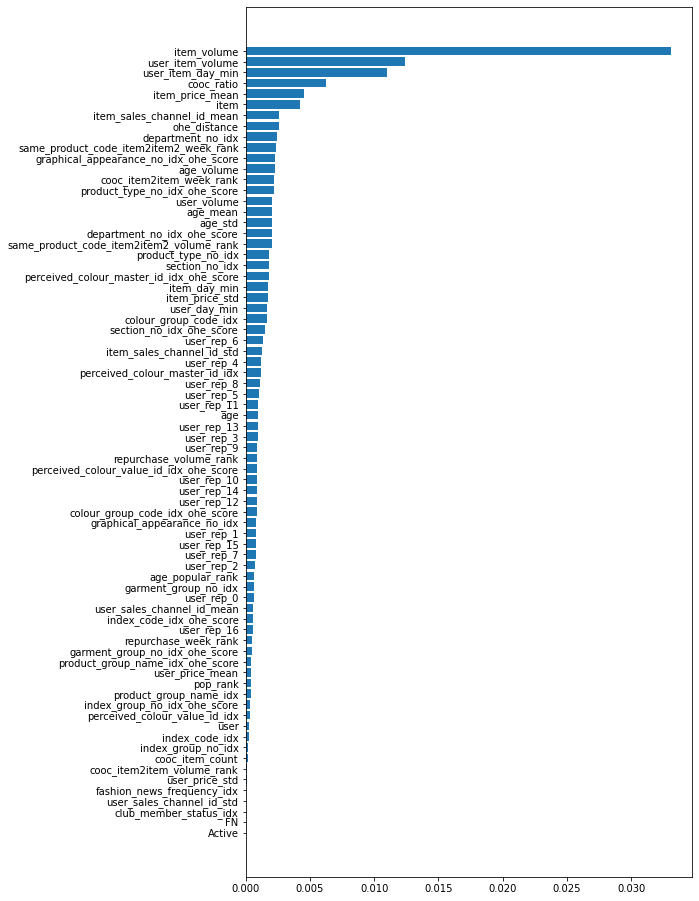

In [20]:
if CFG.model_type == 'LightGBM':
    group_train = get_query_group(train)
    train_dataset = lgb.Dataset(train[feature_columns], train['y'], group=group_train)

    best_iteration = model.best_iteration
    model = lgb.train(params, train_dataset, num_boost_round=best_iteration)

    lgb.plot_importance(model, importance_type='gain', figsize=(8, 16))

elif CFG.model_type == 'CatBoost':
    train_dataset = catboost.Pool(data=train[feature_columns], label=train['y'], group_id=train['query_group'], cat_features=cat_features)

    params['iterations'] = model.get_best_iteration()
    params['use_best_model'] = False
    model = catboost.CatBoost(params)
    model.fit(train_dataset)

    feature_importance = model.get_feature_importance(train_dataset)
    sorted_idx = np.argsort(feature_importance)
    plt.figure(figsize=(8, 16))
    plt.yticks(range(len(feature_columns)), np.array(feature_columns)[sorted_idx])
    plt.barh(range(len(feature_columns)), feature_importance[sorted_idx])

del train, train_dataset
gc.collect()
with open('output/model_for_submission.pkl', 'wb') as f:
    pickle.dump(model, f)

In [21]:
del datasets, dataset_valid_all, candidates, candidates_valid_all
gc.collect()

12279

In [22]:
all_users = users['user'].values
all_users

array([      0,       1,       2, ..., 1371977, 1371978, 1371979])

In [23]:
# to avoid OOM
preds = []

n_split_prediction = 10
n_chunk = (len(all_users) + n_split_prediction - 1)// n_split_prediction
for i in range(0, len(all_users), n_chunk):
    print(f"chunk: {i}")
    target_users = all_users[i:i+n_chunk]

    candidates = create_candidates(transactions, target_users, 0)
    candidates = attach_features(transactions, users, items, candidates, 0, CFG.train_weeks)

    candidates['pred'] = model.predict(candidates[feature_columns])
    pred = candidates.groupby(['user', 'item'])['pred'].max().reset_index()
    pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()
    preds.append(pred)

pred = pd.concat(preds).reset_index(drop=True)
assert len(pred) == len(all_users)
assert np.array_equal(pred['user'].values, all_users)

chunk: 0
create candidates (week: 0)


[repurchase] 6.018 s


[popular] 1.050 s


[age popular] 0.746 s


[item2item] 5.772 s


[item2item2] 5.397 s


[cooccurrence] 12.198 s


[same_product_code] 5.134 s


[ohe distance] 12.766 s


volume: 21317972


duplicates: 1.1165671908990908


            strategy   volume     ratio
0  same_product_code  6635618  0.311269
1                pop  4939128  0.231688
2       ohe_distance  4275973  0.200581
3         repurchase  2735882  0.128337
4            age_pop  1626996  0.076320
5               cooc  1104375  0.051805


attach features (week: 0)


[user static fetaures] 1.932 s


[item stacic features] 5.759 s


[user dynamic features (transactions)] 3.806 s


[item dynamic features (transactions)] 3.042 s


[item dynamic features (user features)] 3.629 s


[item freshness features] 5.182 s


[item volume features] 3.368 s


[user freshness features] 6.947 s


[user volume features] 4.131 s


[user-item freshness features] 24.738 s


[user-item volume features] 7.169 s


[item age volume features] 6.050 s


[ohe dot products] 111.316 s


[lfm features] 10.972 s


chunk: 137198
create candidates (week: 0)


[repurchase] 5.888 s


[popular] 1.007 s


[age popular] 0.732 s


[item2item] 5.720 s


[item2item2] 5.525 s


[cooccurrence] 12.202 s


[same_product_code] 5.045 s


[ohe distance] 9.640 s


volume: 21347933


duplicates: 1.116330378144245


            strategy   volume     ratio
0  same_product_code  6653380  0.311664
1                pop  4939128  0.231363
2       ohe_distance  4274077  0.200210
3         repurchase  2752227  0.128922
4            age_pop  1627296  0.076227
5               cooc  1101825  0.051613


attach features (week: 0)


[user static fetaures] 1.925 s


[item stacic features] 5.827 s


[user dynamic features (transactions)] 3.791 s


[item dynamic features (transactions)] 3.020 s


[item dynamic features (user features)] 3.754 s


[item freshness features] 5.136 s


[item volume features] 3.344 s


[user freshness features] 6.966 s


[user volume features] 4.108 s


[user-item freshness features] 25.051 s


[user-item volume features] 6.980 s


[item age volume features] 6.003 s


[ohe dot products] 113.313 s


[lfm features] 9.796 s


chunk: 274396
create candidates (week: 0)


[repurchase] 5.674 s


[popular] 1.004 s


[age popular] 0.744 s


[item2item] 5.514 s


[item2item2] 5.366 s


[cooccurrence] 12.124 s


[same_product_code] 5.031 s


[ohe distance] 9.574 s


volume: 21278232


duplicates: 1.1166957418291412


            strategy   volume     ratio
0  same_product_code  6634369  0.311791
1                pop  4939128  0.232121
2       ohe_distance  4275911  0.200952
3         repurchase  2708651  0.127297
4            age_pop  1626840  0.076456
5               cooc  1093333  0.051383


attach features (week: 0)


[user static fetaures] 1.911 s


[item stacic features] 5.844 s


[user dynamic features (transactions)] 3.812 s


[item dynamic features (transactions)] 3.011 s


[item dynamic features (user features)] 3.748 s


[item freshness features] 5.106 s


[item volume features] 3.321 s


[user freshness features] 6.987 s


[user volume features] 4.117 s


[user-item freshness features] 24.950 s


[user-item volume features] 6.966 s


[item age volume features] 5.951 s


[ohe dot products] 113.806 s


[lfm features] 11.246 s


chunk: 411594
create candidates (week: 0)


[repurchase] 5.752 s


[popular] 1.007 s


[age popular] 0.752 s


[item2item] 5.576 s


[item2item2] 5.420 s


[cooccurrence] 12.101 s


[same_product_code] 4.984 s


[ohe distance] 9.519 s


volume: 21320508


duplicates: 1.11653299836745


            strategy   volume     ratio
0  same_product_code  6636093  0.311254
1                pop  4939128  0.231661
2       ohe_distance  4275076  0.200515
3         repurchase  2737078  0.128378
4            age_pop  1628148  0.076365
5               cooc  1104985  0.051827


attach features (week: 0)


[user static fetaures] 1.924 s


[item stacic features] 5.669 s


[user dynamic features (transactions)] 3.768 s


[item dynamic features (transactions)] 2.903 s


[item dynamic features (user features)] 3.762 s


[item freshness features] 4.975 s


[item volume features] 3.322 s


[user freshness features] 6.706 s


[user volume features] 4.072 s


[user-item freshness features] 24.366 s


[user-item volume features] 6.869 s


[item age volume features] 5.828 s


[ohe dot products] 113.376 s


[lfm features] 10.111 s


chunk: 548792
create candidates (week: 0)


[repurchase] 5.754 s


[popular] 0.992 s


[age popular] 0.742 s


[item2item] 5.567 s


[item2item2] 5.383 s


[cooccurrence] 11.929 s


[same_product_code] 4.947 s


[ohe distance] 9.430 s


volume: 21317926


duplicates: 1.1165267110223691


            strategy   volume     ratio
0  same_product_code  6630508  0.311030
1                pop  4939128  0.231689
2       ohe_distance  4276533  0.200607
3         repurchase  2739307  0.128498
4            age_pop  1627584  0.076348
5               cooc  1104866  0.051828


attach features (week: 0)


[user static fetaures] 1.902 s


[item stacic features] 5.744 s


[user dynamic features (transactions)] 3.733 s


[item dynamic features (transactions)] 2.980 s


[item dynamic features (user features)] 3.710 s


[item freshness features] 5.084 s


[item volume features] 3.313 s


[user freshness features] 6.878 s


[user volume features] 4.071 s


[user-item freshness features] 24.557 s


[user-item volume features] 7.320 s


[item age volume features] 5.923 s


[ohe dot products] 112.207 s


[lfm features] 9.587 s


chunk: 685990
create candidates (week: 0)


[repurchase] 5.739 s


[popular] 1.020 s


[age popular] 0.742 s


[item2item] 5.556 s


[item2item2] 5.390 s


[cooccurrence] 12.015 s


[same_product_code] 5.067 s


[ohe distance] 9.463 s


volume: 21350326


duplicates: 1.1164808517044793


            strategy   volume     ratio
0  same_product_code  6653866  0.311652
1                pop  4939128  0.231337
2       ohe_distance  4273560  0.200164
3         repurchase  2745003  0.128570
4            age_pop  1627032  0.076206
5               cooc  1111737  0.052071


attach features (week: 0)


[user static fetaures] 1.905 s


[item stacic features] 5.776 s


[user dynamic features (transactions)] 3.806 s


[item dynamic features (transactions)] 3.000 s


[item dynamic features (user features)] 3.724 s


[item freshness features] 5.139 s


[item volume features] 3.300 s


[user freshness features] 6.958 s


[user volume features] 4.094 s


[user-item freshness features] 24.876 s


[user-item volume features] 7.019 s


[item age volume features] 5.992 s


[ohe dot products] 111.876 s


[lfm features] 11.786 s


chunk: 823188
create candidates (week: 0)


[repurchase] 5.635 s


[popular] 1.034 s


[age popular] 0.742 s


[item2item] 5.481 s


[item2item2] 5.244 s


[cooccurrence] 12.022 s


[same_product_code] 5.085 s


[ohe distance] 9.704 s


volume: 21289512


duplicates: 1.1169097666790742


            strategy   volume     ratio
0  same_product_code  6623896  0.311134
1                pop  4939128  0.231998
2       ohe_distance  4275160  0.200811
3         repurchase  2714357  0.127497
4            age_pop  1626984  0.076422
5               cooc  1109987  0.052138


attach features (week: 0)


[user static fetaures] 1.902 s


[item stacic features] 5.725 s


[user dynamic features (transactions)] 3.812 s


[item dynamic features (transactions)] 2.985 s


[item dynamic features (user features)] 3.726 s


[item freshness features] 5.080 s


[item volume features] 3.306 s


[user freshness features] 6.938 s


[user volume features] 4.098 s


[user-item freshness features] 24.541 s


[user-item volume features] 6.817 s


[item age volume features] 5.929 s


[ohe dot products] 111.843 s


[lfm features] 12.274 s


chunk: 960386
create candidates (week: 0)


[repurchase] 5.783 s


[popular] 1.003 s


[age popular] 0.739 s


[item2item] 5.628 s


[item2item2] 5.497 s


[cooccurrence] 12.209 s


[same_product_code] 5.044 s


[ohe distance] 9.596 s


volume: 21295470


duplicates: 1.1167939287188116


            strategy   volume     ratio
0  same_product_code  6618201  0.310780
1                pop  4939128  0.231933
2       ohe_distance  4275309  0.200761
3         repurchase  2731902  0.128286
4            age_pop  1628148  0.076455
5               cooc  1102782  0.051785


attach features (week: 0)


[user static fetaures] 1.961 s


[item stacic features] 5.861 s


[user dynamic features (transactions)] 3.783 s


[item dynamic features (transactions)] 3.009 s


[item dynamic features (user features)] 3.753 s


[item freshness features] 5.105 s


[item volume features] 3.352 s


[user freshness features] 6.929 s


[user volume features] 4.091 s


[user-item freshness features] 24.838 s


[user-item volume features] 7.257 s


[item age volume features] 5.958 s


[ohe dot products] 112.809 s


[lfm features] 10.019 s


chunk: 1097584
create candidates (week: 0)


[repurchase] 5.622 s


[popular] 1.041 s


[age popular] 0.736 s


[item2item] 5.500 s


[item2item2] 5.307 s


[cooccurrence] 11.953 s


[same_product_code] 5.065 s


[ohe distance] 9.371 s


volume: 21236078


duplicates: 1.1165785542411426


            strategy   volume     ratio
0  same_product_code  6593059  0.310465
1                pop  4939128  0.232582
2       ohe_distance  4273226  0.201225
3         repurchase  2711285  0.127674
4            age_pop  1627380  0.076633
5               cooc  1092000  0.051422


attach features (week: 0)


[user static fetaures] 1.895 s


[item stacic features] 5.730 s


[user dynamic features (transactions)] 3.777 s


[item dynamic features (transactions)] 2.977 s


[item dynamic features (user features)] 3.557 s


[item freshness features] 5.055 s


[item volume features] 3.322 s


[user freshness features] 6.897 s


[user volume features] 4.086 s


[user-item freshness features] 24.369 s


[user-item volume features] 7.104 s


[item age volume features] 5.936 s


[ohe dot products] 112.384 s


[lfm features] 11.710 s


chunk: 1234782
create candidates (week: 0)


[repurchase] 5.708 s


[popular] 0.998 s


[age popular] 0.735 s


[item2item] 5.530 s


[item2item2] 5.307 s


[cooccurrence] 12.029 s


[same_product_code] 4.868 s


[ohe distance] 9.392 s


volume: 21313077


duplicates: 1.1166769411262463


            strategy   volume     ratio
0  same_product_code  6638864  0.311493
1                pop  4939128  0.231742
2       ohe_distance  4274701  0.200567
3         repurchase  2730747  0.128125
4            age_pop  1627020  0.076339
5               cooc  1102617  0.051734


attach features (week: 0)


[user static fetaures] 1.911 s


[item stacic features] 5.753 s


[user dynamic features (transactions)] 3.765 s


[item dynamic features (transactions)] 2.985 s


[item dynamic features (user features)] 3.572 s


[item freshness features] 5.112 s


[item volume features] 3.311 s


[user freshness features] 6.872 s


[user volume features] 4.056 s


[user-item freshness features] 24.376 s


[user-item volume features] 7.077 s


[item age volume features] 5.992 s


[ohe dot products] 111.165 s


[lfm features] 9.835 s


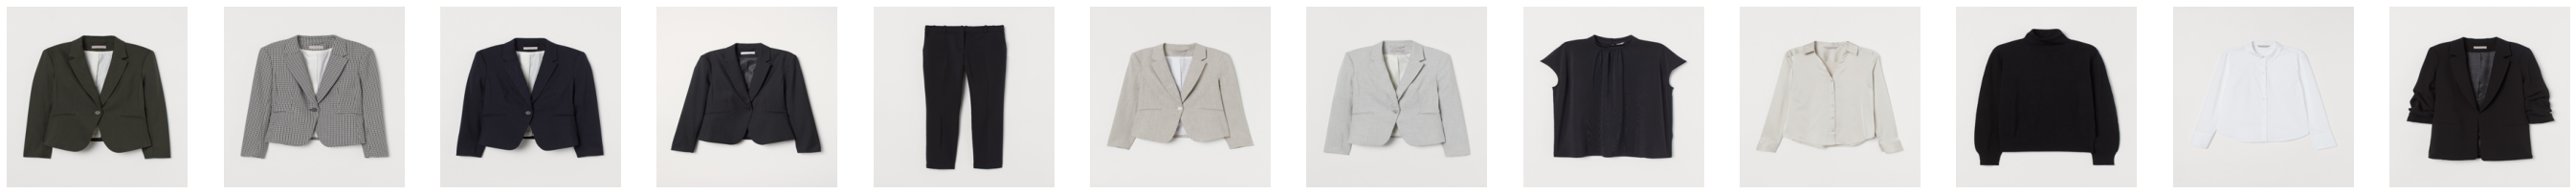

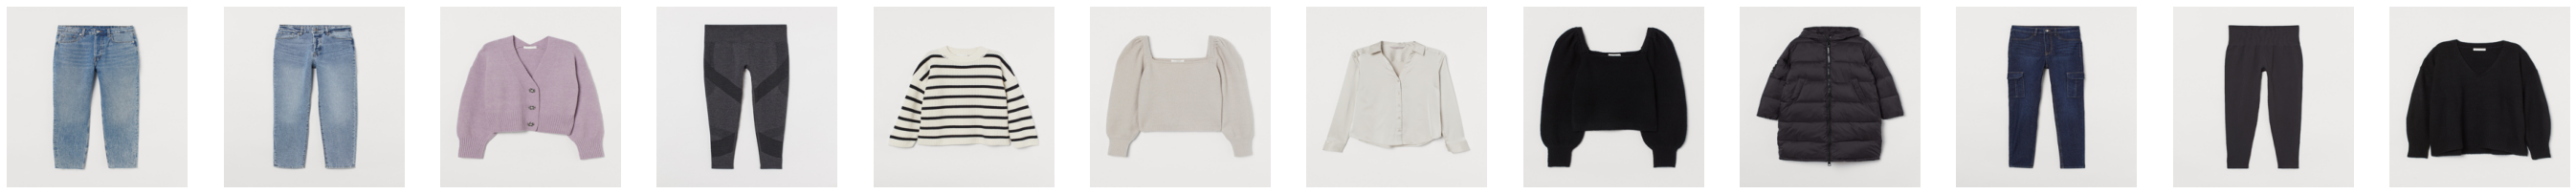

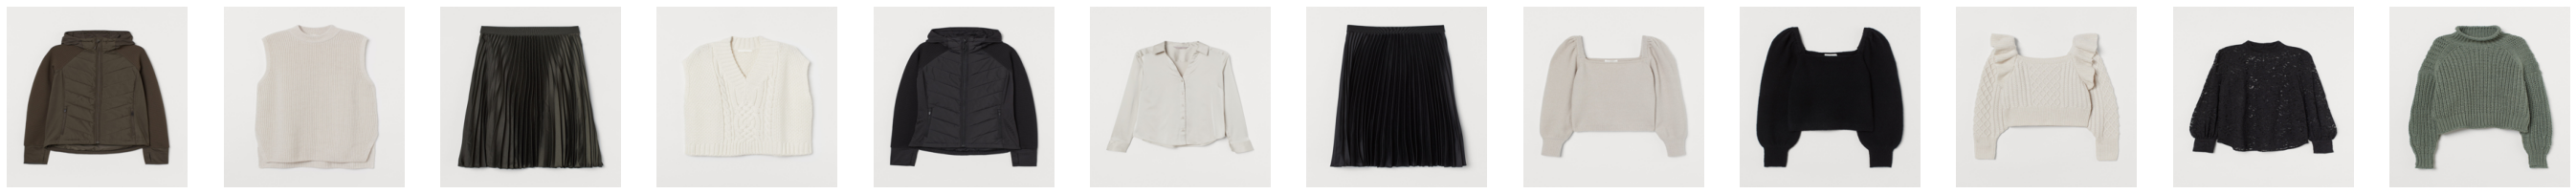

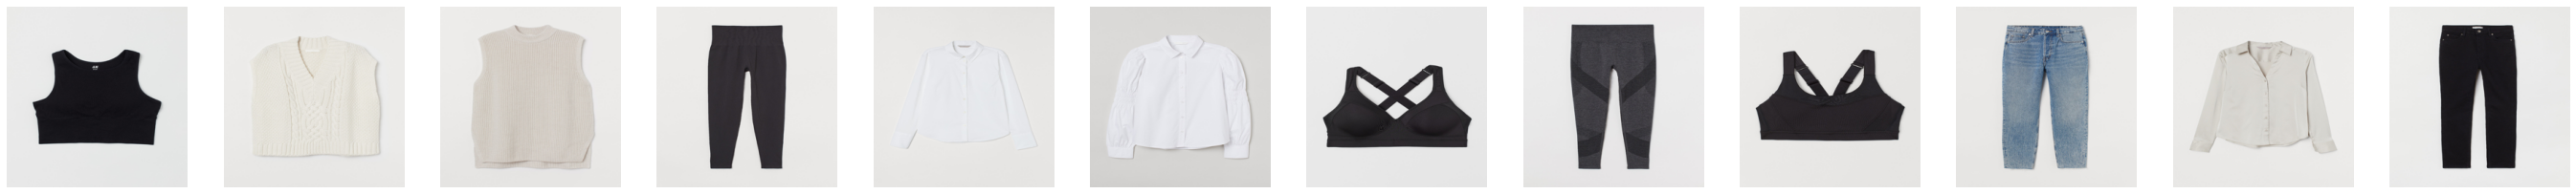

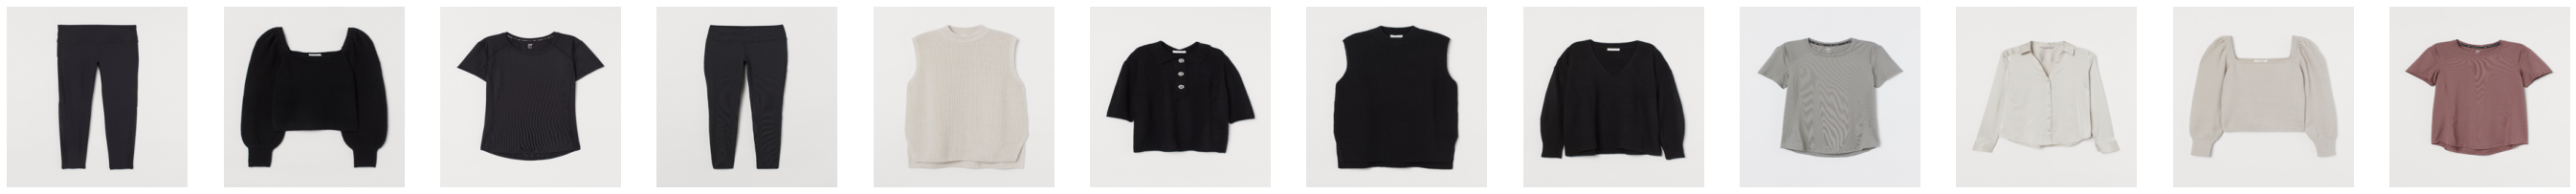

In [24]:
for i in range(5):
    plot_images(dataset, pred['item'][i])

In [25]:
mp_user = pd.read_pickle(f"input/{dataset}/mp_customer_id.pkl")
mp_item = pd.read_pickle(f"input/{dataset}/mp_article_id.pkl")

a_user = mp_user['val'].values
a_item = mp_item['val'].values

pred['customer_id'] = pred['user'].apply(lambda x: a_user[x])
pred['prediction'] = pred['item'].apply(lambda x: list(map(lambda y: a_item[y], x)))

pred['prediction'] = pred['prediction'].apply(lambda x: ' '.join(map(str, x)))

submission = pred[['customer_id', 'prediction']]
submission

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601043 0568601044 0568601007 0568601006 07...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0448509014 0714790020 0896169005 0918292001 08...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007 0924243001 0851400020 0918522001 07...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0869331006 0918522001 0924243001 0866731001 08...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0730683050 0915529003 0791587001 0852584001 09...
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0557599022 0804992014 0791587001 0791587015 06...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0762846027 0762846026 0762846006 0762846031 04...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0762846026 0762846031 0762846006 0762846027 07...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0714790020 0448509014 0821395005 0918292001 09...


In [26]:
submission.to_csv('submission.csv', index=False)